## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1951357406074513261
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6892342477
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2606919822742105845
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from scipy import interpolate
from utils.convert_coord import equirect_to_cart, cart_to_equirect
from utils.data_generator_seq2seq import data_generator_head_seq2seq_decoder_zeros
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

from attention_keras.layers.attention import AttentionLayer

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_decoder_zeros_attention_3-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(len_delay, 3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_1, dh1, dc1 = decoder_1(decoder_inputs, initial_state=[h1, c1])

decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[h2, c2])

decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[h3, c3])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_3, decoder_outputs_3])
decoder_concat_input = Concatenate()([decoder_outputs_3, attn_out])

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_1_outputs = dense_1(decoder_concat_input)
dense_2 = TimeDistributed(Dense(3))
decoder_outputs = dense_2(dense_1_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def smape(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_true) + K.abs(y_pred)))

def mfe(y_true, y_pred):
    return K.mean(y_pred - y_true)

model.compile(loss='mae', optimizer="adam", metrics=[rmse, smape, mfe])

print(model.summary())

(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 3)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 3)        0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        [(None, 25, 32), (No 4736        input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)        [(None, 10, 32), (No 4736        input_2[0][0]                    
                                                                 cu_dnnlstm_1[0][

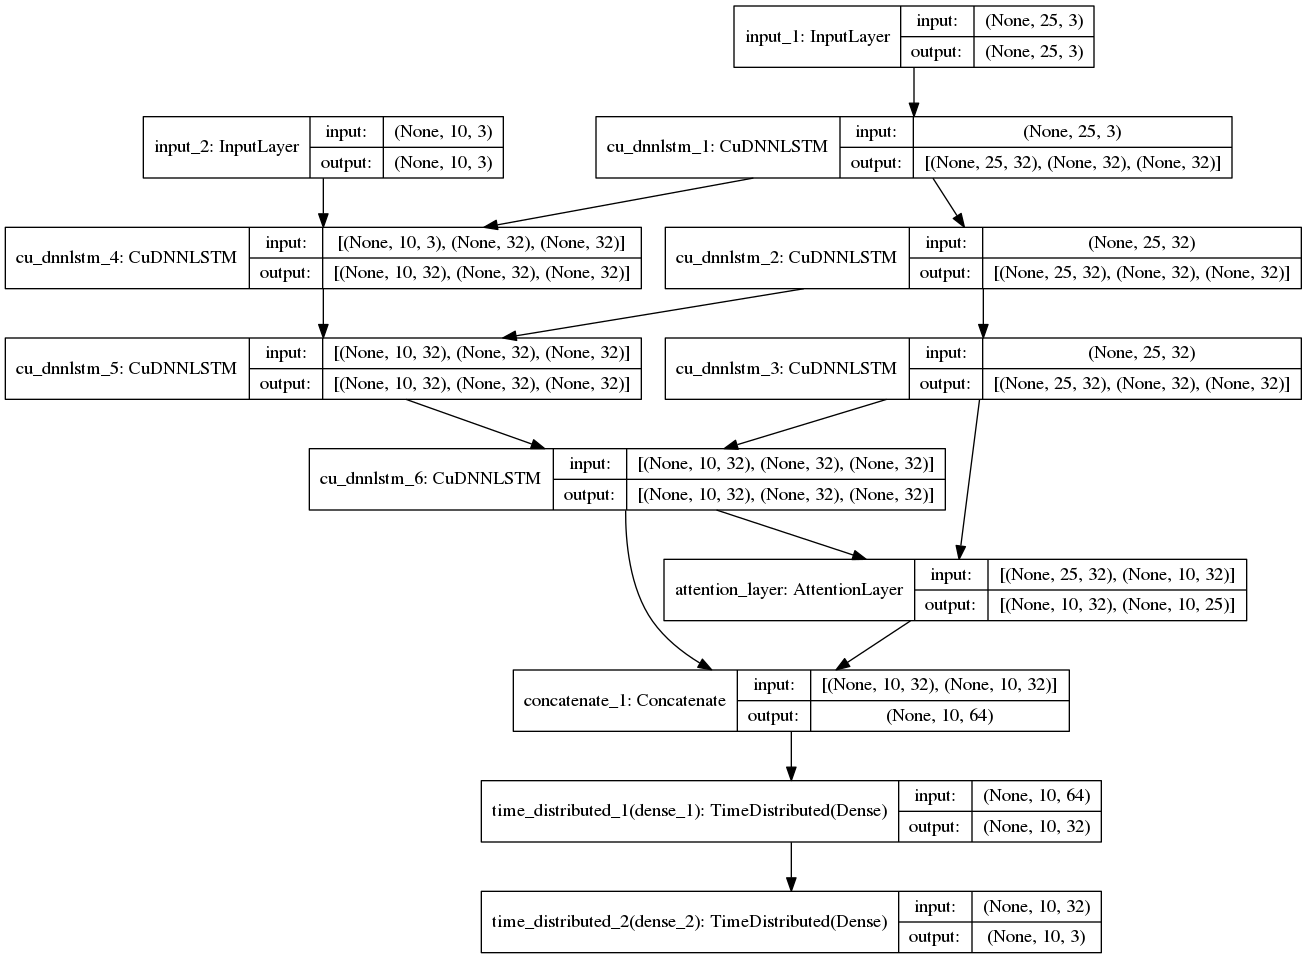

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(path_to_sensor_data_train)
videos = videos
print(videos)
video_width = 3840

['013_13_times_square_static.npy', '025_07_factory_robots_static.npy', '002_01_art_gallery_static.npy', '002_02_theatre_scene_static.npy', '002_03_lions_static_cuts.npy', '002_04_copenhagen_harbour_static_cuts.npy', '002_07_factory_robots_static.npy', '002_09_elephants_static.npy', '002_12_gym_workout_static.npy', '002_13_times_square_static.npy', '002_14_new_orleans_drive_motion.npy', '002_16_interview_static.npy', '002_17_weather_forecast_static.npy', '002_18_bomb_trapped_static.npy', '002_20_car_fix_static.npy', '002_23_dog_food_factory_motion.npy', '003_01_art_gallery_static.npy', '003_02_theatre_scene_static.npy', '003_03_lions_static_cuts.npy', '003_04_copenhagen_harbour_static_cuts.npy', '003_05_florida_yacht_motion.npy', '003_07_factory_robots_static.npy', '003_08_madagascar_cuts.npy', '003_09_elephants_static.npy', '003_11_lohdi_garden_india_cuts.npy', '003_12_gym_workout_static.npy', '003_13_times_square_static.npy', '003_14_new_orleans_drive_motion.npy', '003_18_bomb_trapped

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 100
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

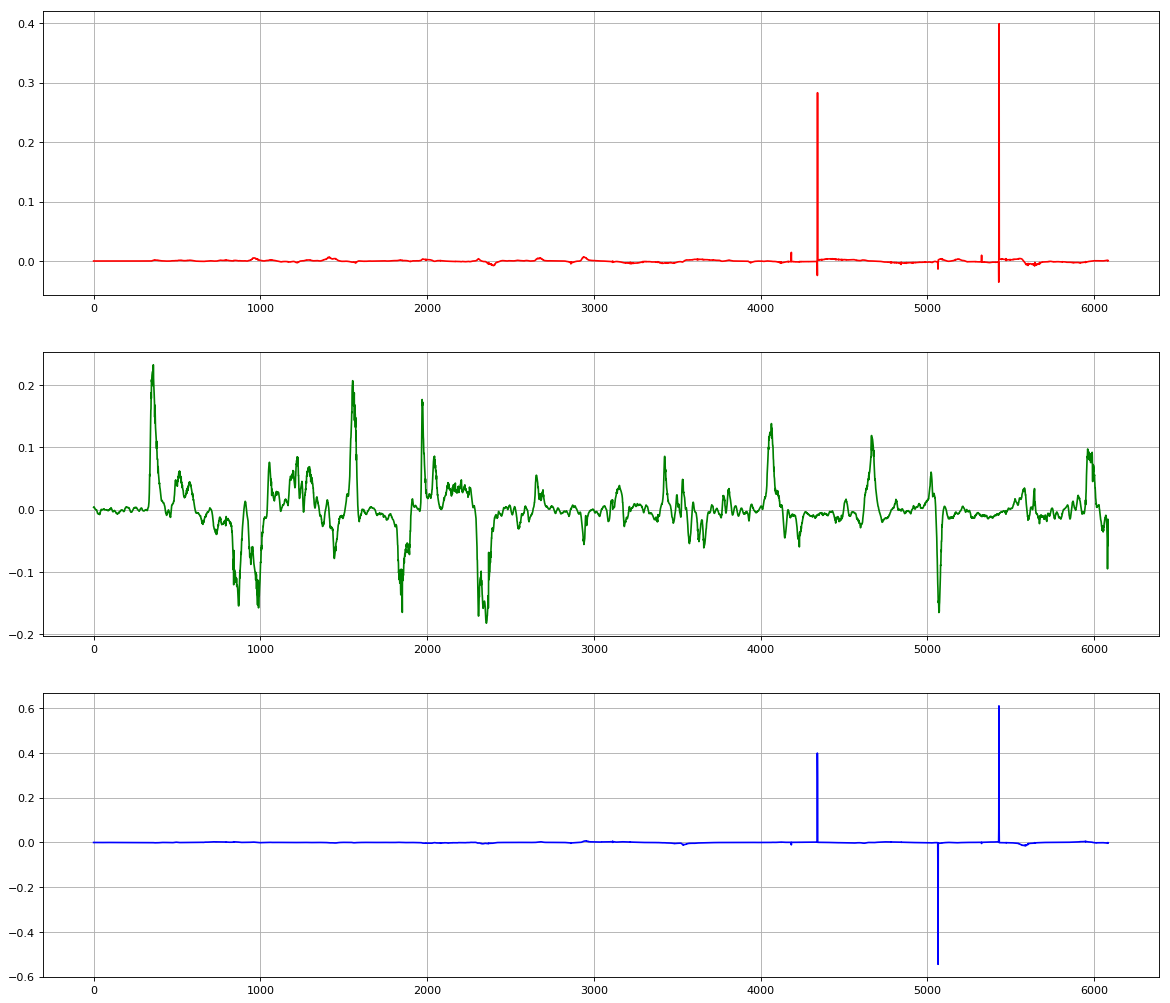

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)

fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=len(videos) - ind_max_train)
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/100


  1/542 [..............................] - ETA: 11:59 - loss: 0.0877 - rmse: 0.2706 - smape: 92.3175 - mfe: 4.3524e-04

  2/542 [..............................] - ETA: 6:16 - loss: 0.1152 - rmse: 0.3296 - smape: 89.6537 - mfe: -0.0021    

  3/542 [..............................] - ETA: 4:25 - loss: 0.0946 - rmse: 0.2578 - smape: 88.9862 - mfe: -0.0019

  4/542 [..............................] - ETA: 3:30 - loss: 0.0885 - rmse: 0.2397 - smape: 87.6019 - mfe: -0.0020

  5/542 [..............................] - ETA: 2:56 - loss: 0.0856 - rmse: 0.2287 - smape: 87.7091 - mfe: -0.0019

  6/542 [..............................] - ETA: 2:34 - loss: 0.0796 - rmse: 0.2136 - smape: 87.0862 - mfe: -0.0020

  7/542 [..............................] - ETA: 2:17 - loss: 0.0741 - rmse: 0.2031 - smape: 86.0008 - mfe: -0.0021

  8/542 [..............................] - ETA: 2:05 - loss: 0.0677 - rmse: 0.1831 - smape: 86.5251 - mfe: -0.0020

  9/542 [..............................] - ETA: 1:56 - loss: 0.0641 - rmse: 0.1796 - smape: 85.8414 - mfe: -0.0017

 10/542 [..............................] - ETA: 1:49 - loss: 0.0693 - rmse: 0.1884 - smape: 86.5702 - mfe: -0.0018

 11/542 [..............................] - ETA: 1:42 - loss: 0.0683 - rmse: 0.1864 - smape: 86.5151 - mfe: -0.0016

 12/542 [..............................] - ETA: 1:37 - loss: 0.0673 - rmse: 0.1846 - smape: 86.6333 - mfe: -0.0014

 13/542 [..............................] - ETA: 1:33 - loss: 0.0683 - rmse: 0.1854 - smape: 87.0544 - mfe: -0.0012

 14/542 [..............................] - ETA: 1:29 - loss: 0.0667 - rmse: 0.1860 - smape: 86.8623 - mfe: -9.7593e-04

 15/542 [..............................] - ETA: 1:26 - loss: 0.0656 - rmse: 0.1821 - smape: 87.1702 - mfe: -8.9122e-04

 16/542 [..............................] - ETA: 1:23 - loss: 0.0666 - rmse: 0.1827 - smape: 87.4458 - mfe: -8.0766e-04

 17/542 [..............................] - ETA: 1:20 - loss: 0.0649 - rmse: 0.1771 - smape: 87.6172 - mfe: -7.1192e-04

 18/542 [..............................] - ETA: 1:18 - loss: 0.0647 - rmse: 0.1753 - smape: 87.7815 - mfe: -6.8579e-04

 19/542 [>.............................] - ETA: 1:16 - loss: 0.0639 - rmse: 0.1727 - smape: 87.9393 - mfe: -5.9149e-04

 20/542 [>.............................] - ETA: 1:14 - loss: 0.0636 - rmse: 0.1716 - smape: 88.0653 - mfe: -5.8109e-04

 21/542 [>.............................] - ETA: 1:12 - loss: 0.0639 - rmse: 0.1724 - smape: 88.1714 - mfe: -5.8966e-04

 22/542 [>.............................] - ETA: 1:11 - loss: 0.0649 - rmse: 0.1768 - smape: 88.4214 - mfe: -6.2626e-04

 23/542 [>.............................] - ETA: 1:09 - loss: 0.0694 - rmse: 0.1887 - smape: 88.6263 - mfe: -5.5410e-04

 24/542 [>.............................] - ETA: 1:08 - loss: 0.0701 - rmse: 0.1918 - smape: 88.5347 - mfe: -4.2459e-04

 25/542 [>.............................] - ETA: 1:07 - loss: 0.0696 - rmse: 0.1900 - smape: 88.7596 - mfe: -4.1196e-04

 26/542 [>.............................] - ETA: 1:06 - loss: 0.0679 - rmse: 0.1870 - smape: 88.4595 - mfe: -4.1987e-04

 27/542 [>.............................] - ETA: 1:05 - loss: 0.0669 - rmse: 0.1847 - smape: 88.2436 - mfe: -4.6527e-04

 28/542 [>.............................] - ETA: 1:04 - loss: 0.0662 - rmse: 0.1827 - smape: 88.1822 - mfe: -5.1958e-04

 29/542 [>.............................] - ETA: 1:03 - loss: 0.0667 - rmse: 0.1832 - smape: 88.2235 - mfe: -5.1591e-04

 30/542 [>.............................] - ETA: 1:02 - loss: 0.0652 - rmse: 0.1791 - smape: 87.9667 - mfe: -5.1927e-04

 31/542 [>.............................] - ETA: 1:01 - loss: 0.0645 - rmse: 0.1778 - smape: 87.8537 - mfe: -5.5193e-04

 32/542 [>.............................] - ETA: 1:00 - loss: 0.0640 - rmse: 0.1758 - smape: 87.8648 - mfe: -5.6341e-04

 33/542 [>.............................] - ETA: 59s - loss: 0.0637 - rmse: 0.1756 - smape: 87.8099 - mfe: -5.7859e-04 

 34/542 [>.............................] - ETA: 58s - loss: 0.0647 - rmse: 0.1779 - smape: 87.9357 - mfe: -5.5915e-04

 35/542 [>.............................] - ETA: 58s - loss: 0.0652 - rmse: 0.1814 - smape: 88.0526 - mfe: -5.7175e-04

 36/542 [>.............................] - ETA: 57s - loss: 0.0655 - rmse: 0.1813 - smape: 88.1807 - mfe: -5.8365e-04

 37/542 [=>............................] - ETA: 57s - loss: 0.0656 - rmse: 0.1818 - smape: 88.2916 - mfe: -5.8242e-04

 38/542 [=>............................] - ETA: 56s - loss: 0.0681 - rmse: 0.1870 - smape: 88.5000 - mfe: -4.4921e-04

 39/542 [=>............................] - ETA: 55s - loss: 0.0683 - rmse: 0.1872 - smape: 88.5757 - mfe: -3.7708e-04

 40/542 [=>............................] - ETA: 55s - loss: 0.0684 - rmse: 0.1868 - smape: 88.7165 - mfe: -3.6600e-04

 41/542 [=>............................] - ETA: 54s - loss: 0.0687 - rmse: 0.1873 - smape: 88.7978 - mfe: -2.9635e-04

 42/542 [=>............................] - ETA: 54s - loss: 0.0673 - rmse: 0.1835 - smape: 88.6878 - mfe: -2.6557e-04

 43/542 [=>............................] - ETA: 53s - loss: 0.0670 - rmse: 0.1827 - smape: 88.7579 - mfe: -2.6561e-04

 44/542 [=>............................] - ETA: 53s - loss: 0.0681 - rmse: 0.1849 - smape: 88.8799 - mfe: -2.8326e-04

 45/542 [=>............................] - ETA: 53s - loss: 0.0696 - rmse: 0.1882 - smape: 88.9909 - mfe: -3.1348e-04

 46/542 [=>............................] - ETA: 52s - loss: 0.0702 - rmse: 0.1887 - smape: 89.0770 - mfe: -3.0723e-04

 47/542 [=>............................] - ETA: 52s - loss: 0.0700 - rmse: 0.1895 - smape: 88.9677 - mfe: -3.7363e-04

 48/542 [=>............................] - ETA: 51s - loss: 0.0697 - rmse: 0.1890 - smape: 89.0352 - mfe: -3.6769e-04

 49/542 [=>............................] - ETA: 51s - loss: 0.0702 - rmse: 0.1909 - smape: 88.9930 - mfe: -3.0646e-04

 50/542 [=>............................] - ETA: 51s - loss: 0.0704 - rmse: 0.1914 - smape: 89.0777 - mfe: -3.0069e-04

 51/542 [=>............................] - ETA: 50s - loss: 0.0700 - rmse: 0.1901 - smape: 89.1777 - mfe: -2.8942e-04

 52/542 [=>............................] - ETA: 50s - loss: 0.0700 - rmse: 0.1899 - smape: 89.2526 - mfe: -3.0569e-04

 53/542 [=>............................] - ETA: 50s - loss: 0.0701 - rmse: 0.1902 - smape: 89.3093 - mfe: -3.4318e-04

 54/542 [=>............................] - ETA: 49s - loss: 0.0705 - rmse: 0.1914 - smape: 89.3760 - mfe: -3.3064e-04

 55/542 [==>...........................] - ETA: 49s - loss: 0.0709 - rmse: 0.1923 - smape: 89.4566 - mfe: -3.3469e-04

 56/542 [==>...........................] - ETA: 49s - loss: 0.0710 - rmse: 0.1928 - smape: 89.4932 - mfe: -3.2649e-04

 57/542 [==>...........................] - ETA: 48s - loss: 0.0707 - rmse: 0.1918 - smape: 89.4812 - mfe: -3.2996e-04

 58/542 [==>...........................] - ETA: 48s - loss: 0.0703 - rmse: 0.1912 - smape: 89.3147 - mfe: -3.3636e-04

 59/542 [==>...........................] - ETA: 48s - loss: 0.0696 - rmse: 0.1897 - smape: 89.2109 - mfe: -3.0536e-04

 60/542 [==>...........................] - ETA: 47s - loss: 0.0693 - rmse: 0.1890 - smape: 89.2060 - mfe: -2.9339e-04

 61/542 [==>...........................] - ETA: 47s - loss: 0.0691 - rmse: 0.1890 - smape: 89.1901 - mfe: -3.1051e-04

 62/542 [==>...........................] - ETA: 47s - loss: 0.0691 - rmse: 0.1908 - smape: 89.1049 - mfe: -2.8310e-04

 63/542 [==>...........................] - ETA: 47s - loss: 0.0695 - rmse: 0.1913 - smape: 89.1285 - mfe: -3.0467e-04

 64/542 [==>...........................] - ETA: 46s - loss: 0.0698 - rmse: 0.1918 - smape: 89.1281 - mfe: -3.2718e-04

 65/542 [==>...........................] - ETA: 46s - loss: 0.0691 - rmse: 0.1899 - smape: 89.0363 - mfe: -3.4736e-04

 66/542 [==>...........................] - ETA: 46s - loss: 0.0697 - rmse: 0.1916 - smape: 89.0554 - mfe: -3.3809e-04

 67/542 [==>...........................] - ETA: 46s - loss: 0.0694 - rmse: 0.1906 - smape: 89.1057 - mfe: -3.6083e-04

 68/542 [==>...........................] - ETA: 45s - loss: 0.0695 - rmse: 0.1918 - smape: 89.0773 - mfe: -3.9656e-04

 69/542 [==>...........................] - ETA: 45s - loss: 0.0693 - rmse: 0.1918 - smape: 89.0365 - mfe: -4.1288e-04

 70/542 [==>...........................] - ETA: 45s - loss: 0.0687 - rmse: 0.1900 - smape: 88.9931 - mfe: -4.1574e-04

 71/542 [==>...........................] - ETA: 45s - loss: 0.0683 - rmse: 0.1890 - smape: 88.9552 - mfe: -4.0397e-04

 72/542 [==>...........................] - ETA: 45s - loss: 0.0684 - rmse: 0.1890 - smape: 88.9993 - mfe: -4.0326e-04

 73/542 [===>..........................] - ETA: 44s - loss: 0.0677 - rmse: 0.1870 - smape: 88.9219 - mfe: -3.9001e-04

 74/542 [===>..........................] - ETA: 44s - loss: 0.0676 - rmse: 0.1868 - smape: 88.9406 - mfe: -3.3526e-04

 75/542 [===>..........................] - ETA: 44s - loss: 0.0675 - rmse: 0.1861 - smape: 88.9516 - mfe: -3.8086e-04

 76/542 [===>..........................] - ETA: 44s - loss: 0.0676 - rmse: 0.1865 - smape: 88.9055 - mfe: -3.8080e-04

 77/542 [===>..........................] - ETA: 44s - loss: 0.0676 - rmse: 0.1861 - smape: 88.9241 - mfe: -3.9631e-04

 78/542 [===>..........................] - ETA: 43s - loss: 0.0672 - rmse: 0.1864 - smape: 88.7364 - mfe: -3.8453e-04

 79/542 [===>..........................] - ETA: 43s - loss: 0.0668 - rmse: 0.1851 - smape: 88.7259 - mfe: -3.8239e-04

 80/542 [===>..........................] - ETA: 43s - loss: 0.0665 - rmse: 0.1847 - smape: 88.6553 - mfe: -3.8573e-04

 81/542 [===>..........................] - ETA: 43s - loss: 0.0660 - rmse: 0.1830 - smape: 88.6433 - mfe: -3.8235e-04

 82/542 [===>..........................] - ETA: 43s - loss: 0.0660 - rmse: 0.1832 - smape: 88.6280 - mfe: -3.9205e-04

 83/542 [===>..........................] - ETA: 43s - loss: 0.0653 - rmse: 0.1815 - smape: 88.4934 - mfe: -3.7642e-04

 84/542 [===>..........................] - ETA: 42s - loss: 0.0649 - rmse: 0.1805 - smape: 88.4441 - mfe: -3.7852e-04

 85/542 [===>..........................] - ETA: 42s - loss: 0.0657 - rmse: 0.1821 - smape: 88.4920 - mfe: -3.6971e-04

 86/542 [===>..........................] - ETA: 42s - loss: 0.0657 - rmse: 0.1819 - smape: 88.5103 - mfe: -3.6967e-04

 87/542 [===>..........................] - ETA: 42s - loss: 0.0656 - rmse: 0.1820 - smape: 88.4479 - mfe: -3.6676e-04

 88/542 [===>..........................] - ETA: 42s - loss: 0.0658 - rmse: 0.1822 - smape: 88.4220 - mfe: -3.7910e-04

 89/542 [===>..........................] - ETA: 41s - loss: 0.0654 - rmse: 0.1808 - smape: 88.3888 - mfe: -3.7443e-04

 90/542 [===>..........................] - ETA: 41s - loss: 0.0655 - rmse: 0.1814 - smape: 88.3771 - mfe: -3.5101e-04

 91/542 [====>.........................] - ETA: 41s - loss: 0.0656 - rmse: 0.1817 - smape: 88.3942 - mfe: -3.2945e-04

 92/542 [====>.........................] - ETA: 41s - loss: 0.0657 - rmse: 0.1821 - smape: 88.4166 - mfe: -3.0946e-04

 93/542 [====>.........................] - ETA: 41s - loss: 0.0653 - rmse: 0.1816 - smape: 88.3313 - mfe: -2.9666e-04

 94/542 [====>.........................] - ETA: 41s - loss: 0.0652 - rmse: 0.1814 - smape: 88.3340 - mfe: -2.5893e-04

 95/542 [====>.........................] - ETA: 41s - loss: 0.0651 - rmse: 0.1815 - smape: 88.3359 - mfe: -2.5978e-04

 96/542 [====>.........................] - ETA: 40s - loss: 0.0654 - rmse: 0.1820 - smape: 88.3564 - mfe: -2.3778e-04

 97/542 [====>.........................] - ETA: 40s - loss: 0.0651 - rmse: 0.1810 - smape: 88.3563 - mfe: -2.5670e-04

 98/542 [====>.........................] - ETA: 40s - loss: 0.0653 - rmse: 0.1812 - smape: 88.3631 - mfe: -2.6431e-04

 99/542 [====>.........................] - ETA: 40s - loss: 0.0655 - rmse: 0.1816 - smape: 88.3109 - mfe: -2.5474e-04

100/542 [====>.........................] - ETA: 40s - loss: 0.0660 - rmse: 0.1827 - smape: 88.2976 - mfe: -2.5962e-04

101/542 [====>.........................] - ETA: 40s - loss: 0.0662 - rmse: 0.1831 - smape: 88.2724 - mfe: -2.4661e-04

102/542 [====>.........................] - ETA: 39s - loss: 0.0661 - rmse: 0.1830 - smape: 88.2487 - mfe: -2.1416e-04

103/542 [====>.........................] - ETA: 39s - loss: 0.0661 - rmse: 0.1829 - smape: 88.1987 - mfe: -2.1468e-04

104/542 [====>.........................] - ETA: 39s - loss: 0.0658 - rmse: 0.1819 - smape: 88.1672 - mfe: -2.1691e-04

105/542 [====>.........................] - ETA: 39s - loss: 0.0658 - rmse: 0.1816 - smape: 88.1358 - mfe: -2.2191e-04

106/542 [====>.........................] - ETA: 39s - loss: 0.0655 - rmse: 0.1808 - smape: 88.1095 - mfe: -2.2051e-04

107/542 [====>.........................] - ETA: 39s - loss: 0.0655 - rmse: 0.1806 - smape: 88.0621 - mfe: -2.2090e-04

108/542 [====>.........................] - ETA: 39s - loss: 0.0651 - rmse: 0.1796 - smape: 88.0186 - mfe: -1.9285e-04

109/542 [=====>........................] - ETA: 38s - loss: 0.0649 - rmse: 0.1792 - smape: 87.9892 - mfe: -2.0083e-04

110/542 [=====>........................] - ETA: 38s - loss: 0.0649 - rmse: 0.1791 - smape: 87.9174 - mfe: -2.0630e-04

111/542 [=====>........................] - ETA: 38s - loss: 0.0649 - rmse: 0.1790 - smape: 87.8737 - mfe: -1.9760e-04

112/542 [=====>........................] - ETA: 38s - loss: 0.0645 - rmse: 0.1776 - smape: 87.8402 - mfe: -1.9097e-04

113/542 [=====>........................] - ETA: 38s - loss: 0.0642 - rmse: 0.1767 - smape: 87.8199 - mfe: -1.7921e-04

114/542 [=====>........................] - ETA: 38s - loss: 0.0640 - rmse: 0.1760 - smape: 87.7990 - mfe: -1.8462e-04

115/542 [=====>........................] - ETA: 38s - loss: 0.0642 - rmse: 0.1765 - smape: 87.7543 - mfe: -1.8355e-04

116/542 [=====>........................] - ETA: 38s - loss: 0.0642 - rmse: 0.1763 - smape: 87.7390 - mfe: -2.0983e-04

117/542 [=====>........................] - ETA: 37s - loss: 0.0641 - rmse: 0.1758 - smape: 87.7178 - mfe: -2.1730e-04

118/542 [=====>........................] - ETA: 37s - loss: 0.0644 - rmse: 0.1766 - smape: 87.6887 - mfe: -1.9452e-04

119/542 [=====>........................] - ETA: 37s - loss: 0.0645 - rmse: 0.1768 - smape: 87.6759 - mfe: -1.7545e-04

120/542 [=====>........................] - ETA: 37s - loss: 0.0644 - rmse: 0.1764 - smape: 87.6679 - mfe: -1.5790e-04

121/542 [=====>........................] - ETA: 37s - loss: 0.0646 - rmse: 0.1769 - smape: 87.6504 - mfe: -1.3945e-04

122/542 [=====>........................] - ETA: 37s - loss: 0.0647 - rmse: 0.1769 - smape: 87.6415 - mfe: -1.3798e-04

123/542 [=====>........................] - ETA: 37s - loss: 0.0649 - rmse: 0.1772 - smape: 87.6308 - mfe: -1.3232e-04

124/542 [=====>........................] - ETA: 37s - loss: 0.0654 - rmse: 0.1785 - smape: 87.6097 - mfe: -1.1604e-04

125/542 [=====>........................] - ETA: 36s - loss: 0.0654 - rmse: 0.1786 - smape: 87.5930 - mfe: -1.3144e-04

126/542 [=====>........................] - ETA: 36s - loss: 0.0650 - rmse: 0.1776 - smape: 87.5575 - mfe: -1.5102e-04

127/542 [======>.......................] - ETA: 36s - loss: 0.0649 - rmse: 0.1774 - smape: 87.5141 - mfe: -1.5671e-04

128/542 [======>.......................] - ETA: 36s - loss: 0.0653 - rmse: 0.1782 - smape: 87.4632 - mfe: -1.5893e-04

129/542 [======>.......................] - ETA: 36s - loss: 0.0656 - rmse: 0.1789 - smape: 87.4259 - mfe: -1.4351e-04

130/542 [======>.......................] - ETA: 36s - loss: 0.0658 - rmse: 0.1791 - smape: 87.4081 - mfe: -1.3042e-04

131/542 [======>.......................] - ETA: 36s - loss: 0.0658 - rmse: 0.1791 - smape: 87.3760 - mfe: -1.4132e-04

132/542 [======>.......................] - ETA: 36s - loss: 0.0658 - rmse: 0.1793 - smape: 87.3530 - mfe: -1.8165e-04

133/542 [======>.......................] - ETA: 36s - loss: 0.0659 - rmse: 0.1795 - smape: 87.3505 - mfe: -2.0150e-04

134/542 [======>.......................] - ETA: 35s - loss: 0.0659 - rmse: 0.1795 - smape: 87.3429 - mfe: -2.0991e-04

135/542 [======>.......................] - ETA: 35s - loss: 0.0656 - rmse: 0.1787 - smape: 87.3342 - mfe: -1.8932e-04

136/542 [======>.......................] - ETA: 35s - loss: 0.0659 - rmse: 0.1789 - smape: 87.3396 - mfe: -1.9571e-04

137/542 [======>.......................] - ETA: 35s - loss: 0.0659 - rmse: 0.1790 - smape: 87.3248 - mfe: -1.9264e-04

138/542 [======>.......................] - ETA: 35s - loss: 0.0664 - rmse: 0.1799 - smape: 87.3126 - mfe: -1.8565e-04

139/542 [======>.......................] - ETA: 35s - loss: 0.0665 - rmse: 0.1803 - smape: 87.3141 - mfe: -1.6540e-04

140/542 [======>.......................] - ETA: 35s - loss: 0.0665 - rmse: 0.1805 - smape: 87.3292 - mfe: -1.6640e-04

141/542 [======>.......................] - ETA: 35s - loss: 0.0665 - rmse: 0.1806 - smape: 87.3093 - mfe: -1.7367e-04

142/542 [======>.......................] - ETA: 34s - loss: 0.0666 - rmse: 0.1811 - smape: 87.2996 - mfe: -1.9360e-04

143/542 [======>.......................] - ETA: 34s - loss: 0.0668 - rmse: 0.1817 - smape: 87.2879 - mfe: -2.1724e-04

144/542 [======>.......................] - ETA: 34s - loss: 0.0667 - rmse: 0.1813 - smape: 87.2716 - mfe: -2.3398e-04

145/542 [=======>......................] - ETA: 34s - loss: 0.0664 - rmse: 0.1807 - smape: 87.2555 - mfe: -2.2253e-04

146/542 [=======>......................] - ETA: 34s - loss: 0.0664 - rmse: 0.1806 - smape: 87.2414 - mfe: -1.9998e-04

147/542 [=======>......................] - ETA: 34s - loss: 0.0663 - rmse: 0.1802 - smape: 87.2344 - mfe: -1.9047e-04

148/542 [=======>......................] - ETA: 34s - loss: 0.0663 - rmse: 0.1808 - smape: 87.1908 - mfe: -1.9409e-04

149/542 [=======>......................] - ETA: 34s - loss: 0.0661 - rmse: 0.1803 - smape: 87.1625 - mfe: -2.0836e-04

150/542 [=======>......................] - ETA: 33s - loss: 0.0662 - rmse: 0.1802 - smape: 87.1681 - mfe: -2.1245e-04

151/542 [=======>......................] - ETA: 33s - loss: 0.0664 - rmse: 0.1810 - smape: 87.1421 - mfe: -2.0204e-04

152/542 [=======>......................] - ETA: 33s - loss: 0.0664 - rmse: 0.1807 - smape: 87.1679 - mfe: -1.8273e-04

153/542 [=======>......................] - ETA: 33s - loss: 0.0662 - rmse: 0.1802 - smape: 87.1763 - mfe: -1.6842e-04

154/542 [=======>......................] - ETA: 33s - loss: 0.0660 - rmse: 0.1797 - smape: 87.1805 - mfe: -1.6347e-04

155/542 [=======>......................] - ETA: 33s - loss: 0.0663 - rmse: 0.1805 - smape: 87.1848 - mfe: -1.7310e-04

156/542 [=======>......................] - ETA: 33s - loss: 0.0662 - rmse: 0.1801 - smape: 87.1699 - mfe: -1.8066e-04

157/542 [=======>......................] - ETA: 33s - loss: 0.0661 - rmse: 0.1799 - smape: 87.1449 - mfe: -1.9172e-04

158/542 [=======>......................] - ETA: 33s - loss: 0.0660 - rmse: 0.1795 - smape: 87.1559 - mfe: -1.9949e-04

159/542 [=======>......................] - ETA: 33s - loss: 0.0658 - rmse: 0.1793 - smape: 87.1547 - mfe: -1.9897e-04

160/542 [=======>......................] - ETA: 32s - loss: 0.0657 - rmse: 0.1791 - smape: 87.1363 - mfe: -2.1010e-04

161/542 [=======>......................] - ETA: 32s - loss: 0.0656 - rmse: 0.1789 - smape: 87.1386 - mfe: -2.1346e-04

162/542 [=======>......................] - ETA: 32s - loss: 0.0659 - rmse: 0.1792 - smape: 87.1534 - mfe: -2.0923e-04

163/542 [========>.....................] - ETA: 32s - loss: 0.0659 - rmse: 0.1795 - smape: 87.1324 - mfe: -1.9224e-04

164/542 [========>.....................] - ETA: 32s - loss: 0.0660 - rmse: 0.1798 - smape: 87.1390 - mfe: -1.7516e-04

165/542 [========>.....................] - ETA: 32s - loss: 0.0658 - rmse: 0.1793 - smape: 87.1266 - mfe: -1.6817e-04

166/542 [========>.....................] - ETA: 32s - loss: 0.0655 - rmse: 0.1785 - smape: 87.1293 - mfe: -1.7036e-04

167/542 [========>.....................] - ETA: 32s - loss: 0.0655 - rmse: 0.1782 - smape: 87.1072 - mfe: -1.8736e-04

168/542 [========>.....................] - ETA: 32s - loss: 0.0655 - rmse: 0.1784 - smape: 87.0879 - mfe: -1.8424e-04

169/542 [========>.....................] - ETA: 32s - loss: 0.0656 - rmse: 0.1786 - smape: 87.0704 - mfe: -1.9387e-04

170/542 [========>.....................] - ETA: 31s - loss: 0.0658 - rmse: 0.1791 - smape: 87.0341 - mfe: -2.0019e-04

171/542 [========>.....................] - ETA: 31s - loss: 0.0659 - rmse: 0.1798 - smape: 87.0060 - mfe: -1.9251e-04

172/542 [========>.....................] - ETA: 31s - loss: 0.0657 - rmse: 0.1791 - smape: 87.0043 - mfe: -2.0459e-04

173/542 [========>.....................] - ETA: 31s - loss: 0.0659 - rmse: 0.1795 - smape: 86.9823 - mfe: -2.1537e-04

174/542 [========>.....................] - ETA: 31s - loss: 0.0658 - rmse: 0.1793 - smape: 86.9592 - mfe: -2.2705e-04

175/542 [========>.....................] - ETA: 31s - loss: 0.0660 - rmse: 0.1799 - smape: 86.9335 - mfe: -2.5717e-04

176/542 [========>.....................] - ETA: 31s - loss: 0.0660 - rmse: 0.1800 - smape: 86.8907 - mfe: -2.6005e-04

177/542 [========>.....................] - ETA: 31s - loss: 0.0659 - rmse: 0.1797 - smape: 86.8435 - mfe: -2.6364e-04

178/542 [========>.....................] - ETA: 31s - loss: 0.0659 - rmse: 0.1798 - smape: 86.8255 - mfe: -2.6032e-04

179/542 [========>.....................] - ETA: 31s - loss: 0.0656 - rmse: 0.1792 - smape: 86.7658 - mfe: -2.5020e-04

180/542 [========>.....................] - ETA: 30s - loss: 0.0658 - rmse: 0.1795 - smape: 86.7536 - mfe: -2.6670e-04

181/542 [=========>....................] - ETA: 30s - loss: 0.0659 - rmse: 0.1796 - smape: 86.7497 - mfe: -2.9815e-04

182/542 [=========>....................] - ETA: 30s - loss: 0.0656 - rmse: 0.1789 - smape: 86.7191 - mfe: -3.1520e-04

183/542 [=========>....................] - ETA: 30s - loss: 0.0657 - rmse: 0.1791 - smape: 86.7099 - mfe: -2.9616e-04

184/542 [=========>....................] - ETA: 30s - loss: 0.0657 - rmse: 0.1788 - smape: 86.7030 - mfe: -2.6134e-04

185/542 [=========>....................] - ETA: 30s - loss: 0.0659 - rmse: 0.1793 - smape: 86.6937 - mfe: -2.4044e-04

186/542 [=========>....................] - ETA: 30s - loss: 0.0658 - rmse: 0.1791 - smape: 86.6960 - mfe: -2.3736e-04

187/542 [=========>....................] - ETA: 30s - loss: 0.0659 - rmse: 0.1795 - smape: 86.6831 - mfe: -2.4067e-04

188/542 [=========>....................] - ETA: 30s - loss: 0.0659 - rmse: 0.1796 - smape: 86.6580 - mfe: -2.4688e-04

189/542 [=========>....................] - ETA: 30s - loss: 0.0659 - rmse: 0.1795 - smape: 86.6486 - mfe: -2.6044e-04

190/542 [=========>....................] - ETA: 29s - loss: 0.0663 - rmse: 0.1802 - smape: 86.6329 - mfe: -2.7604e-04

191/542 [=========>....................] - ETA: 29s - loss: 0.0662 - rmse: 0.1800 - smape: 86.6098 - mfe: -2.8708e-04

192/542 [=========>....................] - ETA: 29s - loss: 0.0661 - rmse: 0.1796 - smape: 86.5970 - mfe: -3.0156e-04

193/542 [=========>....................] - ETA: 29s - loss: 0.0662 - rmse: 0.1797 - smape: 86.5799 - mfe: -3.0382e-04

194/542 [=========>....................] - ETA: 29s - loss: 0.0661 - rmse: 0.1795 - smape: 86.5562 - mfe: -3.0438e-04

195/542 [=========>....................] - ETA: 29s - loss: 0.0659 - rmse: 0.1793 - smape: 86.5267 - mfe: -3.0408e-04

196/542 [=========>....................] - ETA: 29s - loss: 0.0658 - rmse: 0.1788 - smape: 86.5291 - mfe: -3.1012e-04

197/542 [=========>....................] - ETA: 29s - loss: 0.0658 - rmse: 0.1789 - smape: 86.5248 - mfe: -3.2933e-04

198/542 [=========>....................] - ETA: 29s - loss: 0.0656 - rmse: 0.1782 - smape: 86.5012 - mfe: -3.3084e-04

199/542 [==========>...................] - ETA: 29s - loss: 0.0655 - rmse: 0.1780 - smape: 86.4969 - mfe: -3.4333e-04

200/542 [==========>...................] - ETA: 28s - loss: 0.0655 - rmse: 0.1780 - smape: 86.4840 - mfe: -3.5282e-04

201/542 [==========>...................] - ETA: 28s - loss: 0.0655 - rmse: 0.1779 - smape: 86.4771 - mfe: -3.5198e-04

202/542 [==========>...................] - ETA: 28s - loss: 0.0656 - rmse: 0.1780 - smape: 86.4558 - mfe: -3.6022e-04

203/542 [==========>...................] - ETA: 28s - loss: 0.0654 - rmse: 0.1776 - smape: 86.4542 - mfe: -3.6341e-04

204/542 [==========>...................] - ETA: 28s - loss: 0.0652 - rmse: 0.1769 - smape: 86.4440 - mfe: -3.6023e-04

205/542 [==========>...................] - ETA: 28s - loss: 0.0651 - rmse: 0.1768 - smape: 86.4338 - mfe: -3.5883e-04

206/542 [==========>...................] - ETA: 28s - loss: 0.0649 - rmse: 0.1762 - smape: 86.4255 - mfe: -3.6252e-04

207/542 [==========>...................] - ETA: 28s - loss: 0.0649 - rmse: 0.1762 - smape: 86.4171 - mfe: -3.6829e-04

208/542 [==========>...................] - ETA: 28s - loss: 0.0647 - rmse: 0.1756 - smape: 86.4242 - mfe: -3.6732e-04

209/542 [==========>...................] - ETA: 28s - loss: 0.0647 - rmse: 0.1754 - smape: 86.4126 - mfe: -3.7440e-04

210/542 [==========>...................] - ETA: 28s - loss: 0.0646 - rmse: 0.1752 - smape: 86.4159 - mfe: -3.8346e-04

211/542 [==========>...................] - ETA: 27s - loss: 0.0646 - rmse: 0.1750 - smape: 86.4002 - mfe: -3.8359e-04

212/542 [==========>...................] - ETA: 27s - loss: 0.0645 - rmse: 0.1748 - smape: 86.3647 - mfe: -3.6611e-04

213/542 [==========>...................] - ETA: 27s - loss: 0.0646 - rmse: 0.1751 - smape: 86.3488 - mfe: -3.6754e-04

214/542 [==========>...................] - ETA: 27s - loss: 0.0645 - rmse: 0.1750 - smape: 86.3466 - mfe: -3.7134e-04

215/542 [==========>...................] - ETA: 27s - loss: 0.0644 - rmse: 0.1747 - smape: 86.3313 - mfe: -3.7267e-04

216/542 [==========>...................] - ETA: 27s - loss: 0.0644 - rmse: 0.1748 - smape: 86.3071 - mfe: -3.5614e-04

217/542 [===========>..................] - ETA: 27s - loss: 0.0644 - rmse: 0.1749 - smape: 86.2985 - mfe: -3.3428e-04

218/542 [===========>..................] - ETA: 27s - loss: 0.0643 - rmse: 0.1746 - smape: 86.2911 - mfe: -3.3019e-04

219/542 [===========>..................] - ETA: 27s - loss: 0.0641 - rmse: 0.1740 - smape: 86.2722 - mfe: -3.2215e-04

220/542 [===========>..................] - ETA: 27s - loss: 0.0640 - rmse: 0.1738 - smape: 86.2574 - mfe: -3.3072e-04

221/542 [===========>..................] - ETA: 27s - loss: 0.0639 - rmse: 0.1734 - smape: 86.2356 - mfe: -3.4281e-04

222/542 [===========>..................] - ETA: 26s - loss: 0.0637 - rmse: 0.1730 - smape: 86.2342 - mfe: -3.4067e-04

223/542 [===========>..................] - ETA: 26s - loss: 0.0636 - rmse: 0.1728 - smape: 86.2188 - mfe: -3.3508e-04

224/542 [===========>..................] - ETA: 26s - loss: 0.0635 - rmse: 0.1726 - smape: 86.1992 - mfe: -3.1947e-04

225/542 [===========>..................] - ETA: 26s - loss: 0.0634 - rmse: 0.1724 - smape: 86.1760 - mfe: -3.2702e-04

226/542 [===========>..................] - ETA: 26s - loss: 0.0635 - rmse: 0.1726 - smape: 86.1642 - mfe: -3.3989e-04

227/542 [===========>..................] - ETA: 26s - loss: 0.0638 - rmse: 0.1734 - smape: 86.1287 - mfe: -3.3008e-04

228/542 [===========>..................] - ETA: 26s - loss: 0.0637 - rmse: 0.1733 - smape: 86.1255 - mfe: -3.3724e-04

229/542 [===========>..................] - ETA: 26s - loss: 0.0636 - rmse: 0.1729 - smape: 86.1066 - mfe: -3.4172e-04

230/542 [===========>..................] - ETA: 26s - loss: 0.0635 - rmse: 0.1726 - smape: 86.1054 - mfe: -3.4854e-04

231/542 [===========>..................] - ETA: 26s - loss: 0.0634 - rmse: 0.1723 - smape: 86.0884 - mfe: -3.4695e-04

232/542 [===========>..................] - ETA: 26s - loss: 0.0633 - rmse: 0.1721 - smape: 86.0852 - mfe: -3.4702e-04

233/542 [===========>..................] - ETA: 25s - loss: 0.0634 - rmse: 0.1723 - smape: 86.0783 - mfe: -3.4103e-04

234/542 [===========>..................] - ETA: 25s - loss: 0.0633 - rmse: 0.1721 - smape: 86.0656 - mfe: -3.3968e-04

235/542 [============>.................] - ETA: 25s - loss: 0.0633 - rmse: 0.1723 - smape: 86.0382 - mfe: -3.2214e-04

236/542 [============>.................] - ETA: 25s - loss: 0.0633 - rmse: 0.1721 - smape: 86.0162 - mfe: -3.1299e-04

237/542 [============>.................] - ETA: 25s - loss: 0.0633 - rmse: 0.1720 - smape: 86.0015 - mfe: -3.1517e-04

238/542 [============>.................] - ETA: 25s - loss: 0.0633 - rmse: 0.1723 - smape: 85.9819 - mfe: -3.0943e-04

239/542 [============>.................] - ETA: 25s - loss: 0.0632 - rmse: 0.1720 - smape: 85.9836 - mfe: -3.0919e-04

240/542 [============>.................] - ETA: 25s - loss: 0.0633 - rmse: 0.1721 - smape: 85.9795 - mfe: -3.0553e-04

241/542 [============>.................] - ETA: 25s - loss: 0.0634 - rmse: 0.1724 - smape: 85.9658 - mfe: -3.0797e-04

242/542 [============>.................] - ETA: 25s - loss: 0.0635 - rmse: 0.1725 - smape: 85.9524 - mfe: -3.2407e-04

243/542 [============>.................] - ETA: 25s - loss: 0.0635 - rmse: 0.1724 - smape: 85.9389 - mfe: -3.4078e-04

244/542 [============>.................] - ETA: 24s - loss: 0.0635 - rmse: 0.1725 - smape: 85.9189 - mfe: -3.5461e-04

245/542 [============>.................] - ETA: 24s - loss: 0.0635 - rmse: 0.1727 - smape: 85.9072 - mfe: -3.6463e-04

246/542 [============>.................] - ETA: 24s - loss: 0.0637 - rmse: 0.1732 - smape: 85.8856 - mfe: -3.7411e-04

247/542 [============>.................] - ETA: 24s - loss: 0.0640 - rmse: 0.1739 - smape: 85.8777 - mfe: -3.7808e-04

248/542 [============>.................] - ETA: 24s - loss: 0.0639 - rmse: 0.1737 - smape: 85.8520 - mfe: -3.5091e-04

249/542 [============>.................] - ETA: 24s - loss: 0.0638 - rmse: 0.1736 - smape: 85.8363 - mfe: -3.6173e-04

250/542 [============>.................] - ETA: 24s - loss: 0.0637 - rmse: 0.1732 - smape: 85.8299 - mfe: -3.7310e-04

251/542 [============>.................] - ETA: 24s - loss: 0.0637 - rmse: 0.1735 - smape: 85.7999 - mfe: -3.7758e-04

252/542 [============>.................] - ETA: 24s - loss: 0.0639 - rmse: 0.1740 - smape: 85.7918 - mfe: -3.7029e-04

253/542 [=============>................] - ETA: 24s - loss: 0.0639 - rmse: 0.1740 - smape: 85.7876 - mfe: -3.5620e-04

254/542 [=============>................] - ETA: 24s - loss: 0.0641 - rmse: 0.1744 - smape: 85.7808 - mfe: -3.4125e-04

255/542 [=============>................] - ETA: 23s - loss: 0.0642 - rmse: 0.1746 - smape: 85.7756 - mfe: -3.1914e-04

256/542 [=============>................] - ETA: 23s - loss: 0.0644 - rmse: 0.1751 - smape: 85.7594 - mfe: -3.0774e-04

257/542 [=============>................] - ETA: 23s - loss: 0.0644 - rmse: 0.1751 - smape: 85.7445 - mfe: -3.1636e-04

258/542 [=============>................] - ETA: 23s - loss: 0.0644 - rmse: 0.1750 - smape: 85.7203 - mfe: -3.2955e-04

259/542 [=============>................] - ETA: 23s - loss: 0.0644 - rmse: 0.1750 - smape: 85.6902 - mfe: -3.5455e-04

260/542 [=============>................] - ETA: 23s - loss: 0.0644 - rmse: 0.1750 - smape: 85.6678 - mfe: -3.5778e-04

261/542 [=============>................] - ETA: 23s - loss: 0.0644 - rmse: 0.1752 - smape: 85.6401 - mfe: -3.5716e-04

262/542 [=============>................] - ETA: 23s - loss: 0.0642 - rmse: 0.1750 - smape: 85.6090 - mfe: -3.5735e-04

263/542 [=============>................] - ETA: 23s - loss: 0.0642 - rmse: 0.1749 - smape: 85.5888 - mfe: -3.8461e-04

264/542 [=============>................] - ETA: 23s - loss: 0.0641 - rmse: 0.1746 - smape: 85.5652 - mfe: -4.0759e-04

265/542 [=============>................] - ETA: 23s - loss: 0.0643 - rmse: 0.1749 - smape: 85.5484 - mfe: -4.0916e-04

266/542 [=============>................] - ETA: 22s - loss: 0.0643 - rmse: 0.1749 - smape: 85.5452 - mfe: -3.9331e-04

267/542 [=============>................] - ETA: 22s - loss: 0.0643 - rmse: 0.1748 - smape: 85.5345 - mfe: -3.6728e-04

268/542 [=============>................] - ETA: 22s - loss: 0.0643 - rmse: 0.1749 - smape: 85.5160 - mfe: -3.3567e-04

269/542 [=============>................] - ETA: 22s - loss: 0.0643 - rmse: 0.1749 - smape: 85.5192 - mfe: -3.1681e-04

270/542 [=============>................] - ETA: 22s - loss: 0.0642 - rmse: 0.1749 - smape: 85.5221 - mfe: -3.0666e-04

271/542 [==============>...............] - ETA: 22s - loss: 0.0641 - rmse: 0.1746 - smape: 85.5308 - mfe: -3.0653e-04

272/542 [==============>...............] - ETA: 22s - loss: 0.0640 - rmse: 0.1745 - smape: 85.5097 - mfe: -3.1019e-04

273/542 [==============>...............] - ETA: 22s - loss: 0.0640 - rmse: 0.1746 - smape: 85.5083 - mfe: -3.0418e-04

274/542 [==============>...............] - ETA: 22s - loss: 0.0639 - rmse: 0.1742 - smape: 85.4980 - mfe: -3.0766e-04

275/542 [==============>...............] - ETA: 22s - loss: 0.0640 - rmse: 0.1744 - smape: 85.5034 - mfe: -3.1256e-04

276/542 [==============>...............] - ETA: 22s - loss: 0.0641 - rmse: 0.1745 - smape: 85.5103 - mfe: -3.1054e-04

277/542 [==============>...............] - ETA: 22s - loss: 0.0640 - rmse: 0.1743 - smape: 85.4950 - mfe: -3.1018e-04

278/542 [==============>...............] - ETA: 21s - loss: 0.0640 - rmse: 0.1744 - smape: 85.4951 - mfe: -3.0292e-04

279/542 [==============>...............] - ETA: 21s - loss: 0.0638 - rmse: 0.1738 - smape: 85.4770 - mfe: -2.9778e-04

280/542 [==============>...............] - ETA: 21s - loss: 0.0639 - rmse: 0.1743 - smape: 85.4554 - mfe: -2.8609e-04

281/542 [==============>...............] - ETA: 21s - loss: 0.0639 - rmse: 0.1744 - smape: 85.4677 - mfe: -2.6914e-04

282/542 [==============>...............] - ETA: 21s - loss: 0.0638 - rmse: 0.1740 - smape: 85.4680 - mfe: -2.5949e-04

283/542 [==============>...............] - ETA: 21s - loss: 0.0639 - rmse: 0.1741 - smape: 85.4614 - mfe: -2.4814e-04

284/542 [==============>...............] - ETA: 21s - loss: 0.0638 - rmse: 0.1739 - smape: 85.4561 - mfe: -2.5301e-04

285/542 [==============>...............] - ETA: 21s - loss: 0.0636 - rmse: 0.1734 - smape: 85.4319 - mfe: -2.5421e-04

286/542 [==============>...............] - ETA: 21s - loss: 0.0637 - rmse: 0.1736 - smape: 85.4226 - mfe: -2.6086e-04

287/542 [==============>...............] - ETA: 21s - loss: 0.0638 - rmse: 0.1737 - smape: 85.4207 - mfe: -2.6448e-04

288/542 [==============>...............] - ETA: 21s - loss: 0.0638 - rmse: 0.1738 - smape: 85.4166 - mfe: -2.6292e-04

289/542 [==============>...............] - ETA: 20s - loss: 0.0638 - rmse: 0.1736 - smape: 85.4202 - mfe: -2.5592e-04

290/542 [===============>..............] - ETA: 20s - loss: 0.0636 - rmse: 0.1731 - smape: 85.4066 - mfe: -2.5919e-04

291/542 [===============>..............] - ETA: 20s - loss: 0.0635 - rmse: 0.1729 - smape: 85.3938 - mfe: -2.6342e-04

292/542 [===============>..............] - ETA: 20s - loss: 0.0635 - rmse: 0.1728 - smape: 85.3953 - mfe: -2.7258e-04

293/542 [===============>..............] - ETA: 20s - loss: 0.0634 - rmse: 0.1725 - smape: 85.3737 - mfe: -2.7694e-04

294/542 [===============>..............] - ETA: 20s - loss: 0.0633 - rmse: 0.1725 - smape: 85.3702 - mfe: -2.8007e-04

295/542 [===============>..............] - ETA: 20s - loss: 0.0634 - rmse: 0.1727 - smape: 85.3654 - mfe: -2.7535e-04

296/542 [===============>..............] - ETA: 20s - loss: 0.0632 - rmse: 0.1722 - smape: 85.3634 - mfe: -2.7509e-04

297/542 [===============>..............] - ETA: 20s - loss: 0.0632 - rmse: 0.1723 - smape: 85.3510 - mfe: -2.7301e-04

298/542 [===============>..............] - ETA: 20s - loss: 0.0632 - rmse: 0.1722 - smape: 85.3622 - mfe: -2.6873e-04

299/542 [===============>..............] - ETA: 20s - loss: 0.0632 - rmse: 0.1721 - smape: 85.3601 - mfe: -2.6983e-04

300/542 [===============>..............] - ETA: 20s - loss: 0.0631 - rmse: 0.1718 - smape: 85.3577 - mfe: -2.6920e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0629 - rmse: 0.1714 - smape: 85.3509 - mfe: -2.6823e-04

302/542 [===============>..............] - ETA: 19s - loss: 0.0630 - rmse: 0.1714 - smape: 85.3495 - mfe: -2.6918e-04

303/542 [===============>..............] - ETA: 19s - loss: 0.0630 - rmse: 0.1715 - smape: 85.3504 - mfe: -2.7087e-04

304/542 [===============>..............] - ETA: 19s - loss: 0.0630 - rmse: 0.1716 - smape: 85.3541 - mfe: -2.7075e-04

305/542 [===============>..............] - ETA: 19s - loss: 0.0629 - rmse: 0.1716 - smape: 85.3528 - mfe: -2.7040e-04

306/542 [===============>..............] - ETA: 19s - loss: 0.0631 - rmse: 0.1720 - smape: 85.3454 - mfe: -2.7105e-04

307/542 [===============>..............] - ETA: 19s - loss: 0.0630 - rmse: 0.1716 - smape: 85.3393 - mfe: -2.7175e-04

308/542 [================>.............] - ETA: 19s - loss: 0.0629 - rmse: 0.1714 - smape: 85.3309 - mfe: -2.7671e-04

309/542 [================>.............] - ETA: 19s - loss: 0.0628 - rmse: 0.1711 - smape: 85.3342 - mfe: -2.6700e-04

310/542 [================>.............] - ETA: 19s - loss: 0.0628 - rmse: 0.1709 - smape: 85.3452 - mfe: -2.6161e-04

311/542 [================>.............] - ETA: 19s - loss: 0.0628 - rmse: 0.1708 - smape: 85.3427 - mfe: -2.5922e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0627 - rmse: 0.1706 - smape: 85.3466 - mfe: -2.5809e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0626 - rmse: 0.1704 - smape: 85.3362 - mfe: -2.5393e-04

314/542 [================>.............] - ETA: 18s - loss: 0.0625 - rmse: 0.1702 - smape: 85.3326 - mfe: -2.5186e-04

315/542 [================>.............] - ETA: 18s - loss: 0.0627 - rmse: 0.1706 - smape: 85.3275 - mfe: -2.5169e-04

316/542 [================>.............] - ETA: 18s - loss: 0.0627 - rmse: 0.1706 - smape: 85.3252 - mfe: -2.5082e-04

317/542 [================>.............] - ETA: 18s - loss: 0.0628 - rmse: 0.1710 - smape: 85.3189 - mfe: -2.4432e-04

318/542 [================>.............] - ETA: 18s - loss: 0.0627 - rmse: 0.1707 - smape: 85.2986 - mfe: -2.4637e-04

319/542 [================>.............] - ETA: 18s - loss: 0.0626 - rmse: 0.1706 - smape: 85.2795 - mfe: -2.4378e-04

320/542 [================>.............] - ETA: 18s - loss: 0.0625 - rmse: 0.1703 - smape: 85.2814 - mfe: -2.3977e-04

321/542 [================>.............] - ETA: 18s - loss: 0.0623 - rmse: 0.1699 - smape: 85.2716 - mfe: -2.4025e-04

322/542 [================>.............] - ETA: 18s - loss: 0.0623 - rmse: 0.1699 - smape: 85.2510 - mfe: -2.3802e-04

323/542 [================>.............] - ETA: 18s - loss: 0.0625 - rmse: 0.1703 - smape: 85.2441 - mfe: -2.4056e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0625 - rmse: 0.1701 - smape: 85.2472 - mfe: -2.4255e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0625 - rmse: 0.1702 - smape: 85.2301 - mfe: -2.4718e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0625 - rmse: 0.1705 - smape: 85.2124 - mfe: -2.4542e-04

327/542 [=================>............] - ETA: 17s - loss: 0.0626 - rmse: 0.1708 - smape: 85.1958 - mfe: -2.3833e-04

328/542 [=================>............] - ETA: 17s - loss: 0.0627 - rmse: 0.1712 - smape: 85.1737 - mfe: -2.2867e-04

329/542 [=================>............] - ETA: 17s - loss: 0.0627 - rmse: 0.1709 - smape: 85.1751 - mfe: -2.2920e-04

330/542 [=================>............] - ETA: 17s - loss: 0.0626 - rmse: 0.1710 - smape: 85.1623 - mfe: -2.2565e-04

331/542 [=================>............] - ETA: 17s - loss: 0.0625 - rmse: 0.1707 - smape: 85.1620 - mfe: -2.2806e-04

332/542 [=================>............] - ETA: 17s - loss: 0.0625 - rmse: 0.1705 - smape: 85.1636 - mfe: -2.2391e-04

333/542 [=================>............] - ETA: 17s - loss: 0.0624 - rmse: 0.1704 - smape: 85.1537 - mfe: -2.1839e-04

334/542 [=================>............] - ETA: 17s - loss: 0.0624 - rmse: 0.1704 - smape: 85.1645 - mfe: -2.1420e-04

335/542 [=================>............] - ETA: 17s - loss: 0.0624 - rmse: 0.1704 - smape: 85.1656 - mfe: -2.0758e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0625 - rmse: 0.1706 - smape: 85.1682 - mfe: -2.0044e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0625 - rmse: 0.1706 - smape: 85.1663 - mfe: -1.9323e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0625 - rmse: 0.1706 - smape: 85.1673 - mfe: -1.8209e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0624 - rmse: 0.1703 - smape: 85.1694 - mfe: -1.7667e-04

340/542 [=================>............] - ETA: 16s - loss: 0.0624 - rmse: 0.1703 - smape: 85.1706 - mfe: -1.6818e-04

341/542 [=================>............] - ETA: 16s - loss: 0.0623 - rmse: 0.1699 - smape: 85.1633 - mfe: -1.6612e-04

342/542 [=================>............] - ETA: 16s - loss: 0.0624 - rmse: 0.1702 - smape: 85.1465 - mfe: -1.4987e-04

343/542 [=================>............] - ETA: 16s - loss: 0.0624 - rmse: 0.1701 - smape: 85.1390 - mfe: -1.4080e-04

344/542 [==================>...........] - ETA: 16s - loss: 0.0624 - rmse: 0.1701 - smape: 85.1372 - mfe: -1.3732e-04

345/542 [==================>...........] - ETA: 16s - loss: 0.0624 - rmse: 0.1702 - smape: 85.1176 - mfe: -1.2985e-04

346/542 [==================>...........] - ETA: 16s - loss: 0.0625 - rmse: 0.1703 - smape: 85.1079 - mfe: -1.2490e-04

347/542 [==================>...........] - ETA: 16s - loss: 0.0625 - rmse: 0.1705 - smape: 85.0932 - mfe: -1.1604e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0624 - rmse: 0.1703 - smape: 85.0879 - mfe: -1.1421e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0624 - rmse: 0.1703 - smape: 85.0885 - mfe: -1.1840e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0623 - rmse: 0.1701 - smape: 85.0678 - mfe: -1.1927e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0623 - rmse: 0.1699 - smape: 85.0617 - mfe: -1.2232e-04

352/542 [==================>...........] - ETA: 15s - loss: 0.0623 - rmse: 0.1699 - smape: 85.0560 - mfe: -1.2282e-04

353/542 [==================>...........] - ETA: 15s - loss: 0.0624 - rmse: 0.1701 - smape: 85.0497 - mfe: -1.2069e-04

354/542 [==================>...........] - ETA: 15s - loss: 0.0623 - rmse: 0.1699 - smape: 85.0409 - mfe: -1.2058e-04

355/542 [==================>...........] - ETA: 15s - loss: 0.0622 - rmse: 0.1696 - smape: 85.0230 - mfe: -1.1950e-04

356/542 [==================>...........] - ETA: 15s - loss: 0.0623 - rmse: 0.1699 - smape: 85.0176 - mfe: -1.2093e-04

357/542 [==================>...........] - ETA: 15s - loss: 0.0623 - rmse: 0.1699 - smape: 85.0127 - mfe: -1.2440e-04

358/542 [==================>...........] - ETA: 15s - loss: 0.0622 - rmse: 0.1698 - smape: 84.9922 - mfe: -1.2627e-04

359/542 [==================>...........] - ETA: 15s - loss: 0.0622 - rmse: 0.1698 - smape: 84.9928 - mfe: -1.2432e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0621 - rmse: 0.1696 - smape: 84.9788 - mfe: -1.1628e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0620 - rmse: 0.1696 - smape: 84.9720 - mfe: -1.0901e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0621 - rmse: 0.1696 - smape: 84.9760 - mfe: -1.1820e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0621 - rmse: 0.1699 - smape: 84.9733 - mfe: -1.2650e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0621 - rmse: 0.1697 - smape: 84.9753 - mfe: -1.2519e-04

365/542 [===================>..........] - ETA: 14s - loss: 0.0621 - rmse: 0.1698 - smape: 84.9722 - mfe: -1.2121e-04

366/542 [===================>..........] - ETA: 14s - loss: 0.0620 - rmse: 0.1696 - smape: 84.9732 - mfe: -1.1795e-04

367/542 [===================>..........] - ETA: 14s - loss: 0.0619 - rmse: 0.1695 - smape: 84.9548 - mfe: -1.2420e-04

368/542 [===================>..........] - ETA: 14s - loss: 0.0620 - rmse: 0.1695 - smape: 84.9466 - mfe: -1.2522e-04

369/542 [===================>..........] - ETA: 14s - loss: 0.0619 - rmse: 0.1692 - smape: 84.9310 - mfe: -1.2570e-04

370/542 [===================>..........] - ETA: 14s - loss: 0.0619 - rmse: 0.1693 - smape: 84.9197 - mfe: -1.2540e-04

371/542 [===================>..........] - ETA: 14s - loss: 0.0618 - rmse: 0.1692 - smape: 84.9115 - mfe: -1.1724e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1693 - smape: 84.9048 - mfe: -1.0409e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1691 - smape: 84.9042 - mfe: -1.0568e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1691 - smape: 84.9027 - mfe: -1.1278e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1693 - smape: 84.8802 - mfe: -1.2411e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1693 - smape: 84.8801 - mfe: -1.1170e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1691 - smape: 84.8741 - mfe: -9.9182e-05

378/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1692 - smape: 84.8644 - mfe: -8.6489e-05

379/542 [===================>..........] - ETA: 13s - loss: 0.0618 - rmse: 0.1694 - smape: 84.8588 - mfe: -9.0682e-05

380/542 [====================>.........] - ETA: 13s - loss: 0.0617 - rmse: 0.1690 - smape: 84.8362 - mfe: -9.4309e-05

381/542 [====================>.........] - ETA: 13s - loss: 0.0616 - rmse: 0.1689 - smape: 84.8409 - mfe: -1.0278e-04

382/542 [====================>.........] - ETA: 13s - loss: 0.0617 - rmse: 0.1692 - smape: 84.8244 - mfe: -1.0175e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0616 - rmse: 0.1691 - smape: 84.8069 - mfe: -1.0068e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0617 - rmse: 0.1694 - smape: 84.7949 - mfe: -8.5453e-05

385/542 [====================>.........] - ETA: 12s - loss: 0.0617 - rmse: 0.1694 - smape: 84.8067 - mfe: -7.7517e-05

386/542 [====================>.........] - ETA: 12s - loss: 0.0616 - rmse: 0.1694 - smape: 84.7923 - mfe: -7.1464e-05

387/542 [====================>.........] - ETA: 12s - loss: 0.0617 - rmse: 0.1695 - smape: 84.7961 - mfe: -6.2288e-05

388/542 [====================>.........] - ETA: 12s - loss: 0.0618 - rmse: 0.1700 - smape: 84.7925 - mfe: -5.4845e-05

389/542 [====================>.........] - ETA: 12s - loss: 0.0618 - rmse: 0.1699 - smape: 84.7980 - mfe: -5.4403e-05

390/542 [====================>.........] - ETA: 12s - loss: 0.0618 - rmse: 0.1698 - smape: 84.7956 - mfe: -6.0876e-05

391/542 [====================>.........] - ETA: 12s - loss: 0.0617 - rmse: 0.1697 - smape: 84.7817 - mfe: -5.4759e-05

392/542 [====================>.........] - ETA: 12s - loss: 0.0617 - rmse: 0.1697 - smape: 84.7700 - mfe: -5.2071e-05

393/542 [====================>.........] - ETA: 12s - loss: 0.0618 - rmse: 0.1699 - smape: 84.7747 - mfe: -5.5848e-05

394/542 [====================>.........] - ETA: 12s - loss: 0.0619 - rmse: 0.1703 - smape: 84.7775 - mfe: -5.9644e-05

395/542 [====================>.........] - ETA: 12s - loss: 0.0617 - rmse: 0.1699 - smape: 84.7819 - mfe: -5.7023e-05

396/542 [====================>.........] - ETA: 11s - loss: 0.0618 - rmse: 0.1699 - smape: 84.7948 - mfe: -4.7665e-05

397/542 [====================>.........] - ETA: 11s - loss: 0.0619 - rmse: 0.1702 - smape: 84.7965 - mfe: -3.8442e-05

398/542 [=====================>........] - ETA: 11s - loss: 0.0618 - rmse: 0.1701 - smape: 84.7976 - mfe: -2.5268e-05

399/542 [=====================>........] - ETA: 11s - loss: 0.0618 - rmse: 0.1701 - smape: 84.7931 - mfe: -2.2751e-05

400/542 [=====================>........] - ETA: 11s - loss: 0.0618 - rmse: 0.1700 - smape: 84.7836 - mfe: -2.7815e-05

401/542 [=====================>........] - ETA: 11s - loss: 0.0620 - rmse: 0.1707 - smape: 84.7722 - mfe: -1.8845e-05

402/542 [=====================>........] - ETA: 11s - loss: 0.0620 - rmse: 0.1706 - smape: 84.7698 - mfe: -2.3671e-05

403/542 [=====================>........] - ETA: 11s - loss: 0.0620 - rmse: 0.1705 - smape: 84.7640 - mfe: -2.1538e-05

404/542 [=====================>........] - ETA: 11s - loss: 0.0620 - rmse: 0.1707 - smape: 84.7613 - mfe: -1.2364e-05

405/542 [=====================>........] - ETA: 11s - loss: 0.0621 - rmse: 0.1708 - smape: 84.7590 - mfe: -6.2606e-06

406/542 [=====================>........] - ETA: 11s - loss: 0.0622 - rmse: 0.1709 - smape: 84.7602 - mfe: 7.3723e-06 

407/542 [=====================>........] - ETA: 11s - loss: 0.0621 - rmse: 0.1706 - smape: 84.7520 - mfe: 1.2996e-05

408/542 [=====================>........] - ETA: 10s - loss: 0.0620 - rmse: 0.1704 - smape: 84.7438 - mfe: 1.4687e-05

409/542 [=====================>........] - ETA: 10s - loss: 0.0620 - rmse: 0.1705 - smape: 84.7396 - mfe: 2.1484e-05

410/542 [=====================>........] - ETA: 10s - loss: 0.0622 - rmse: 0.1707 - smape: 84.7375 - mfe: 3.3300e-05

411/542 [=====================>........] - ETA: 10s - loss: 0.0621 - rmse: 0.1707 - smape: 84.7204 - mfe: 3.9368e-05

412/542 [=====================>........] - ETA: 10s - loss: 0.0621 - rmse: 0.1707 - smape: 84.7118 - mfe: 4.3910e-05

413/542 [=====================>........] - ETA: 10s - loss: 0.0620 - rmse: 0.1704 - smape: 84.7004 - mfe: 3.7910e-05

414/542 [=====================>........] - ETA: 10s - loss: 0.0620 - rmse: 0.1704 - smape: 84.6889 - mfe: 4.1821e-05

415/542 [=====================>........] - ETA: 10s - loss: 0.0620 - rmse: 0.1703 - smape: 84.6829 - mfe: 4.0393e-05

416/542 [======================>.......] - ETA: 10s - loss: 0.0620 - rmse: 0.1703 - smape: 84.6763 - mfe: 3.8354e-05

417/542 [======================>.......] - ETA: 10s - loss: 0.0620 - rmse: 0.1703 - smape: 84.6724 - mfe: 4.0049e-05

418/542 [======================>.......] - ETA: 10s - loss: 0.0620 - rmse: 0.1703 - smape: 84.6684 - mfe: 3.6473e-05

419/542 [======================>.......] - ETA: 10s - loss: 0.0619 - rmse: 0.1701 - smape: 84.6538 - mfe: 3.5179e-05

420/542 [======================>.......] - ETA: 9s - loss: 0.0620 - rmse: 0.1703 - smape: 84.6464 - mfe: 3.2848e-05 

421/542 [======================>.......] - ETA: 9s - loss: 0.0619 - rmse: 0.1702 - smape: 84.6245 - mfe: 2.9211e-05

422/542 [======================>.......] - ETA: 9s - loss: 0.0619 - rmse: 0.1703 - smape: 84.6229 - mfe: 3.1792e-05

423/542 [======================>.......] - ETA: 9s - loss: 0.0620 - rmse: 0.1706 - smape: 84.6158 - mfe: 3.7208e-05

424/542 [======================>.......] - ETA: 9s - loss: 0.0621 - rmse: 0.1707 - smape: 84.6110 - mfe: 4.4444e-05

425/542 [======================>.......] - ETA: 9s - loss: 0.0621 - rmse: 0.1707 - smape: 84.6031 - mfe: 5.2752e-05

426/542 [======================>.......] - ETA: 9s - loss: 0.0621 - rmse: 0.1707 - smape: 84.6012 - mfe: 6.7310e-05

427/542 [======================>.......] - ETA: 9s - loss: 0.0621 - rmse: 0.1706 - smape: 84.5970 - mfe: 7.6915e-05

428/542 [======================>.......] - ETA: 9s - loss: 0.0620 - rmse: 0.1703 - smape: 84.5912 - mfe: 7.7785e-05

429/542 [======================>.......] - ETA: 9s - loss: 0.0620 - rmse: 0.1704 - smape: 84.5873 - mfe: 7.2509e-05

430/542 [======================>.......] - ETA: 9s - loss: 0.0619 - rmse: 0.1701 - smape: 84.5857 - mfe: 6.9826e-05

431/542 [======================>.......] - ETA: 9s - loss: 0.0619 - rmse: 0.1700 - smape: 84.5806 - mfe: 7.0089e-05

432/542 [======================>.......] - ETA: 8s - loss: 0.0618 - rmse: 0.1699 - smape: 84.5652 - mfe: 5.6278e-05

433/542 [======================>.......] - ETA: 8s - loss: 0.0618 - rmse: 0.1698 - smape: 84.5641 - mfe: 5.3790e-05

434/542 [=======================>......] - ETA: 8s - loss: 0.0618 - rmse: 0.1697 - smape: 84.5606 - mfe: 5.5042e-05

435/542 [=======================>......] - ETA: 8s - loss: 0.0617 - rmse: 0.1695 - smape: 84.5623 - mfe: 5.6540e-05

436/542 [=======================>......] - ETA: 8s - loss: 0.0617 - rmse: 0.1697 - smape: 84.5588 - mfe: 6.0029e-05

437/542 [=======================>......] - ETA: 8s - loss: 0.0617 - rmse: 0.1697 - smape: 84.5502 - mfe: 6.6986e-05

438/542 [=======================>......] - ETA: 8s - loss: 0.0617 - rmse: 0.1697 - smape: 84.5460 - mfe: 7.4614e-05

439/542 [=======================>......] - ETA: 8s - loss: 0.0617 - rmse: 0.1694 - smape: 84.5444 - mfe: 7.7860e-05

440/542 [=======================>......] - ETA: 8s - loss: 0.0617 - rmse: 0.1694 - smape: 84.5506 - mfe: 7.5862e-05

441/542 [=======================>......] - ETA: 8s - loss: 0.0616 - rmse: 0.1693 - smape: 84.5534 - mfe: 7.2135e-05

442/542 [=======================>......] - ETA: 8s - loss: 0.0618 - rmse: 0.1698 - smape: 84.5494 - mfe: 7.7773e-05

443/542 [=======================>......] - ETA: 8s - loss: 0.0619 - rmse: 0.1698 - smape: 84.5483 - mfe: 9.0982e-05

444/542 [=======================>......] - ETA: 7s - loss: 0.0618 - rmse: 0.1696 - smape: 84.5390 - mfe: 1.1403e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0618 - rmse: 0.1696 - smape: 84.5343 - mfe: 1.1511e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0618 - rmse: 0.1697 - smape: 84.5284 - mfe: 1.0355e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0618 - rmse: 0.1694 - smape: 84.5191 - mfe: 8.8170e-05

448/542 [=======================>......] - ETA: 7s - loss: 0.0617 - rmse: 0.1693 - smape: 84.5052 - mfe: 7.6808e-05

449/542 [=======================>......] - ETA: 7s - loss: 0.0617 - rmse: 0.1692 - smape: 84.5103 - mfe: 7.5427e-05

450/542 [=======================>......] - ETA: 7s - loss: 0.0618 - rmse: 0.1694 - smape: 84.5052 - mfe: 7.8237e-05

451/542 [=======================>......] - ETA: 7s - loss: 0.0618 - rmse: 0.1694 - smape: 84.5038 - mfe: 8.9451e-05

452/542 [========================>.....] - ETA: 7s - loss: 0.0619 - rmse: 0.1698 - smape: 84.4971 - mfe: 1.0142e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4982 - mfe: 1.0355e-04

454/542 [========================>.....] - ETA: 7s - loss: 0.0619 - rmse: 0.1697 - smape: 84.4907 - mfe: 1.0066e-04

455/542 [========================>.....] - ETA: 7s - loss: 0.0619 - rmse: 0.1696 - smape: 84.4881 - mfe: 8.9734e-05

456/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1694 - smape: 84.4836 - mfe: 7.4507e-05

457/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1694 - smape: 84.4716 - mfe: 6.6561e-05

458/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4761 - mfe: 5.6481e-05

459/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4747 - mfe: 5.1202e-05

460/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4716 - mfe: 5.0091e-05

461/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1694 - smape: 84.4681 - mfe: 5.2204e-05

462/542 [========================>.....] - ETA: 6s - loss: 0.0617 - rmse: 0.1692 - smape: 84.4703 - mfe: 5.4012e-05

463/542 [========================>.....] - ETA: 6s - loss: 0.0617 - rmse: 0.1692 - smape: 84.4701 - mfe: 5.9011e-05

464/542 [========================>.....] - ETA: 6s - loss: 0.0617 - rmse: 0.1691 - smape: 84.4690 - mfe: 6.2283e-05

465/542 [========================>.....] - ETA: 6s - loss: 0.0617 - rmse: 0.1691 - smape: 84.4673 - mfe: 6.7210e-05

466/542 [========================>.....] - ETA: 6s - loss: 0.0617 - rmse: 0.1692 - smape: 84.4692 - mfe: 7.0948e-05

467/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1694 - smape: 84.4666 - mfe: 7.4258e-05

468/542 [========================>.....] - ETA: 6s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4574 - mfe: 7.1210e-05

469/542 [========================>.....] - ETA: 5s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4522 - mfe: 6.9889e-05

470/542 [=========================>....] - ETA: 5s - loss: 0.0617 - rmse: 0.1694 - smape: 84.4464 - mfe: 6.9003e-05

471/542 [=========================>....] - ETA: 5s - loss: 0.0617 - rmse: 0.1694 - smape: 84.4419 - mfe: 6.8298e-05

472/542 [=========================>....] - ETA: 5s - loss: 0.0617 - rmse: 0.1694 - smape: 84.4379 - mfe: 7.0600e-05

473/542 [=========================>....] - ETA: 5s - loss: 0.0617 - rmse: 0.1693 - smape: 84.4378 - mfe: 7.2466e-05

474/542 [=========================>....] - ETA: 5s - loss: 0.0617 - rmse: 0.1694 - smape: 84.4367 - mfe: 7.5188e-05

475/542 [=========================>....] - ETA: 5s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4339 - mfe: 7.9294e-05

476/542 [=========================>....] - ETA: 5s - loss: 0.0617 - rmse: 0.1694 - smape: 84.4285 - mfe: 8.0708e-05

477/542 [=========================>....] - ETA: 5s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4218 - mfe: 7.7493e-05

478/542 [=========================>....] - ETA: 5s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4108 - mfe: 7.8338e-05

479/542 [=========================>....] - ETA: 5s - loss: 0.0618 - rmse: 0.1695 - smape: 84.4060 - mfe: 7.6348e-05

480/542 [=========================>....] - ETA: 5s - loss: 0.0617 - rmse: 0.1694 - smape: 84.4053 - mfe: 7.5463e-05

481/542 [=========================>....] - ETA: 4s - loss: 0.0617 - rmse: 0.1692 - smape: 84.4031 - mfe: 7.3776e-05

482/542 [=========================>....] - ETA: 4s - loss: 0.0617 - rmse: 0.1693 - smape: 84.4012 - mfe: 7.3991e-05

483/542 [=========================>....] - ETA: 4s - loss: 0.0616 - rmse: 0.1691 - smape: 84.3991 - mfe: 7.6405e-05

484/542 [=========================>....] - ETA: 4s - loss: 0.0617 - rmse: 0.1691 - smape: 84.3932 - mfe: 7.6328e-05

485/542 [=========================>....] - ETA: 4s - loss: 0.0616 - rmse: 0.1690 - smape: 84.3905 - mfe: 7.6884e-05

486/542 [=========================>....] - ETA: 4s - loss: 0.0616 - rmse: 0.1689 - smape: 84.3843 - mfe: 7.8682e-05

487/542 [=========================>....] - ETA: 4s - loss: 0.0615 - rmse: 0.1689 - smape: 84.3801 - mfe: 8.0937e-05

488/542 [==========================>...] - ETA: 4s - loss: 0.0617 - rmse: 0.1691 - smape: 84.3773 - mfe: 9.0810e-05

489/542 [==========================>...] - ETA: 4s - loss: 0.0617 - rmse: 0.1693 - smape: 84.3760 - mfe: 9.1541e-05

490/542 [==========================>...] - ETA: 4s - loss: 0.0617 - rmse: 0.1692 - smape: 84.3786 - mfe: 9.3662e-05

491/542 [==========================>...] - ETA: 4s - loss: 0.0616 - rmse: 0.1691 - smape: 84.3789 - mfe: 9.1336e-05

492/542 [==========================>...] - ETA: 4s - loss: 0.0616 - rmse: 0.1690 - smape: 84.3728 - mfe: 8.8604e-05

493/542 [==========================>...] - ETA: 3s - loss: 0.0615 - rmse: 0.1688 - smape: 84.3644 - mfe: 9.2091e-05

494/542 [==========================>...] - ETA: 3s - loss: 0.0616 - rmse: 0.1690 - smape: 84.3589 - mfe: 9.8719e-05

495/542 [==========================>...] - ETA: 3s - loss: 0.0615 - rmse: 0.1690 - smape: 84.3459 - mfe: 9.9997e-05

496/542 [==========================>...] - ETA: 3s - loss: 0.0615 - rmse: 0.1689 - smape: 84.3403 - mfe: 9.3337e-05

497/542 [==========================>...] - ETA: 3s - loss: 0.0615 - rmse: 0.1688 - smape: 84.3183 - mfe: 8.1470e-05

498/542 [==========================>...] - ETA: 3s - loss: 0.0615 - rmse: 0.1688 - smape: 84.3092 - mfe: 7.5593e-05

499/542 [==========================>...] - ETA: 3s - loss: 0.0615 - rmse: 0.1689 - smape: 84.2980 - mfe: 7.0107e-05

500/542 [==========================>...] - ETA: 3s - loss: 0.0614 - rmse: 0.1686 - smape: 84.2958 - mfe: 6.8637e-05

501/542 [==========================>...] - ETA: 3s - loss: 0.0614 - rmse: 0.1684 - smape: 84.2914 - mfe: 6.8169e-05

502/542 [==========================>...] - ETA: 3s - loss: 0.0614 - rmse: 0.1684 - smape: 84.2819 - mfe: 7.1075e-05

503/542 [==========================>...] - ETA: 3s - loss: 0.0614 - rmse: 0.1685 - smape: 84.2714 - mfe: 7.2105e-05

504/542 [==========================>...] - ETA: 3s - loss: 0.0615 - rmse: 0.1686 - smape: 84.2648 - mfe: 7.5712e-05

505/542 [==========================>...] - ETA: 2s - loss: 0.0615 - rmse: 0.1688 - smape: 84.2611 - mfe: 7.8549e-05

506/542 [===========================>..] - ETA: 2s - loss: 0.0614 - rmse: 0.1688 - smape: 84.2586 - mfe: 7.9765e-05

507/542 [===========================>..] - ETA: 2s - loss: 0.0614 - rmse: 0.1685 - smape: 84.2545 - mfe: 7.9489e-05

508/542 [===========================>..] - ETA: 2s - loss: 0.0614 - rmse: 0.1686 - smape: 84.2509 - mfe: 8.5597e-05

509/542 [===========================>..] - ETA: 2s - loss: 0.0614 - rmse: 0.1687 - smape: 84.2464 - mfe: 9.1376e-05

510/542 [===========================>..] - ETA: 2s - loss: 0.0613 - rmse: 0.1685 - smape: 84.2476 - mfe: 9.4505e-05

511/542 [===========================>..] - ETA: 2s - loss: 0.0614 - rmse: 0.1686 - smape: 84.2458 - mfe: 1.0017e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0614 - rmse: 0.1687 - smape: 84.2394 - mfe: 1.0500e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0615 - rmse: 0.1691 - smape: 84.2354 - mfe: 1.0958e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0616 - rmse: 0.1695 - smape: 84.2303 - mfe: 1.1244e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0616 - rmse: 0.1695 - smape: 84.2207 - mfe: 1.1407e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0615 - rmse: 0.1692 - smape: 84.2186 - mfe: 1.1556e-04

517/542 [===========================>..] - ETA: 2s - loss: 0.0615 - rmse: 0.1694 - smape: 84.2112 - mfe: 1.1161e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0617 - rmse: 0.1697 - smape: 84.2016 - mfe: 1.0334e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0616 - rmse: 0.1694 - smape: 84.1864 - mfe: 9.7079e-05

520/542 [===========================>..] - ETA: 1s - loss: 0.0616 - rmse: 0.1696 - smape: 84.1765 - mfe: 9.8089e-05

521/542 [===========================>..] - ETA: 1s - loss: 0.0616 - rmse: 0.1695 - smape: 84.1722 - mfe: 1.0316e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0616 - rmse: 0.1694 - smape: 84.1668 - mfe: 1.1179e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0615 - rmse: 0.1693 - smape: 84.1516 - mfe: 1.1517e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0615 - rmse: 0.1691 - smape: 84.1509 - mfe: 1.0453e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0614 - rmse: 0.1691 - smape: 84.1522 - mfe: 9.1491e-05

526/542 [============================>.] - ETA: 1s - loss: 0.0615 - rmse: 0.1691 - smape: 84.1484 - mfe: 8.5864e-05

527/542 [============================>.] - ETA: 1s - loss: 0.0614 - rmse: 0.1690 - smape: 84.1440 - mfe: 9.1868e-05

528/542 [============================>.] - ETA: 1s - loss: 0.0614 - rmse: 0.1690 - smape: 84.1418 - mfe: 9.9227e-05

529/542 [============================>.] - ETA: 1s - loss: 0.0614 - rmse: 0.1690 - smape: 84.1392 - mfe: 1.0179e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0614 - rmse: 0.1690 - smape: 84.1369 - mfe: 1.0317e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1688 - smape: 84.1358 - mfe: 1.0805e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1686 - smape: 84.1287 - mfe: 1.1015e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1686 - smape: 84.1311 - mfe: 1.1178e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1685 - smape: 84.1355 - mfe: 1.1176e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0613 - rmse: 0.1686 - smape: 84.1299 - mfe: 1.1016e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1684 - smape: 84.1082 - mfe: 1.1474e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1685 - smape: 84.1068 - mfe: 1.1861e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1685 - smape: 84.1131 - mfe: 1.1927e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0611 - rmse: 0.1683 - smape: 84.1155 - mfe: 1.1877e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0611 - rmse: 0.1684 - smape: 84.1133 - mfe: 1.2110e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0612 - rmse: 0.1684 - smape: 84.1098 - mfe: 1.2592e-04

542/542 [==============================] - 48s 89ms/step - loss: 0.0612 - rmse: 0.1684 - smape: 84.1098 - mfe: 1.3202e-04 - val_loss: 0.0628 - val_rmse: 0.1815 - val_smape: 83.6979 - val_mfe: 5.1013e-04


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_5 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/100
  1/542 [..............................] - ETA: 42s - loss: 0.0748 - rmse: 0.1858 - smape: 86.1072 - mfe: 9.7526e-04

  2/542 [..............................] - ETA: 43s - loss: 0.0757 - rmse: 0.2013 - smape: 83.1327 - mfe: 7.8995e-04

  3/542 [..............................] - ETA: 43s - loss: 0.0625 - rmse: 0.1596 - smape: 84.3770 - mfe: -2.9595e-05

  4/542 [..............................] - ETA: 43s - loss: 0.0580 - rmse: 0.1479 - smape: 84.3034 - mfe: -7.0664e-04

  5/542 [..............................] - ETA: 43s - loss: 0.0706 - rmse: 0.1758 - smape: 84.1302 - mfe: -8.4084e-04

  6/542 [..............................] - ETA: 41s - loss: 0.0677 - rmse: 0.1726 - smape: 84.3397 - mfe: -0.0011    

  7/542 [..............................] - ETA: 42s - loss: 0.0626 - rmse: 0.1609 - smape: 83.7131 - mfe: -0.0012

  8/542 [..............................] - ETA: 41s - loss: 0.0615 - rmse: 0.1681 - smape: 83.0767 - mfe: -0.0013

  9/542 [..............................] - ETA: 41s - loss: 0.0623 - rmse: 0.1685 - smape: 83.3871 - mfe: -9.7817e-04

 10/542 [..............................] - ETA: 41s - loss: 0.0605 - rmse: 0.1660 - smape: 83.0615 - mfe: -7.6634e-04

 11/542 [..............................] - ETA: 41s - loss: 0.0618 - rmse: 0.1675 - smape: 83.2290 - mfe: -6.2888e-04

 12/542 [..............................] - ETA: 42s - loss: 0.0584 - rmse: 0.1607 - smape: 82.7794 - mfe: -4.6913e-04

 13/542 [..............................] - ETA: 42s - loss: 0.0654 - rmse: 0.1753 - smape: 82.8020 - mfe: -4.0396e-04

 14/542 [..............................] - ETA: 42s - loss: 0.0659 - rmse: 0.1755 - smape: 83.1536 - mfe: -4.4870e-04

 15/542 [..............................] - ETA: 41s - loss: 0.0646 - rmse: 0.1743 - smape: 83.2499 - mfe: -4.1473e-04

 16/542 [..............................] - ETA: 41s - loss: 0.0636 - rmse: 0.1720 - smape: 83.2685 - mfe: -3.0539e-04

 17/542 [..............................] - ETA: 41s - loss: 0.0628 - rmse: 0.1683 - smape: 83.4697 - mfe: -1.6801e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0636 - rmse: 0.1698 - smape: 83.6032 - mfe: -1.7843e-05

 19/542 [>.............................] - ETA: 41s - loss: 0.0623 - rmse: 0.1666 - smape: 83.4540 - mfe: 1.5644e-04 

 20/542 [>.............................] - ETA: 41s - loss: 0.0619 - rmse: 0.1648 - smape: 83.5763 - mfe: 1.2852e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0600 - rmse: 0.1608 - smape: 83.4571 - mfe: 6.5662e-05

 22/542 [>.............................] - ETA: 41s - loss: 0.0588 - rmse: 0.1572 - smape: 83.3469 - mfe: -8.2003e-05

 23/542 [>.............................] - ETA: 41s - loss: 0.0588 - rmse: 0.1585 - smape: 83.2765 - mfe: -1.2782e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0597 - rmse: 0.1603 - smape: 83.3150 - mfe: -1.3343e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0589 - rmse: 0.1607 - smape: 83.3299 - mfe: -7.7551e-05

 26/542 [>.............................] - ETA: 41s - loss: 0.0582 - rmse: 0.1590 - smape: 83.1901 - mfe: -6.6474e-05

 27/542 [>.............................] - ETA: 40s - loss: 0.0588 - rmse: 0.1601 - smape: 83.2296 - mfe: -9.5496e-05

 28/542 [>.............................] - ETA: 40s - loss: 0.0586 - rmse: 0.1607 - smape: 83.2671 - mfe: -1.7760e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0580 - rmse: 0.1595 - smape: 83.2671 - mfe: -1.5051e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0578 - rmse: 0.1581 - smape: 83.3263 - mfe: -2.8367e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0578 - rmse: 0.1577 - smape: 83.3195 - mfe: -4.2300e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0587 - rmse: 0.1593 - smape: 83.3235 - mfe: -4.5583e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0572 - rmse: 0.1566 - smape: 83.1162 - mfe: -4.0605e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0567 - rmse: 0.1560 - smape: 83.1071 - mfe: -3.7303e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0570 - rmse: 0.1565 - smape: 83.1927 - mfe: -3.9991e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0561 - rmse: 0.1537 - smape: 83.2345 - mfe: -3.9027e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0553 - rmse: 0.1521 - smape: 83.1937 - mfe: -4.1153e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0547 - rmse: 0.1515 - smape: 83.2511 - mfe: -4.2477e-04

 39/542 [=>............................] - ETA: 39s - loss: 0.0544 - rmse: 0.1501 - smape: 83.3686 - mfe: -4.2815e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0543 - rmse: 0.1502 - smape: 83.4364 - mfe: -4.1845e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1482 - smape: 83.5877 - mfe: -3.9701e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1488 - smape: 83.5379 - mfe: -3.0522e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0544 - rmse: 0.1512 - smape: 83.5716 - mfe: -2.3236e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0540 - rmse: 0.1497 - smape: 83.6682 - mfe: -1.8216e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0531 - rmse: 0.1472 - smape: 83.7090 - mfe: -1.6057e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0531 - rmse: 0.1477 - smape: 83.7402 - mfe: -1.5084e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0532 - rmse: 0.1486 - smape: 83.8186 - mfe: -1.8752e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0532 - rmse: 0.1499 - smape: 83.7234 - mfe: -1.9355e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1514 - smape: 83.7870 - mfe: -1.9256e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0545 - rmse: 0.1530 - smape: 83.8300 - mfe: -1.8232e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0545 - rmse: 0.1546 - smape: 83.8485 - mfe: -1.5514e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0553 - rmse: 0.1561 - smape: 83.8753 - mfe: -9.4253e-05

 53/542 [=>............................] - ETA: 38s - loss: 0.0564 - rmse: 0.1588 - smape: 83.8801 - mfe: -4.5880e-06

 54/542 [=>............................] - ETA: 38s - loss: 0.0563 - rmse: 0.1584 - smape: 83.8392 - mfe: 6.7613e-05 

 55/542 [==>...........................] - ETA: 38s - loss: 0.0565 - rmse: 0.1591 - smape: 83.7987 - mfe: 9.8141e-05

 56/542 [==>...........................] - ETA: 38s - loss: 0.0568 - rmse: 0.1596 - smape: 83.7580 - mfe: 6.7795e-05

 57/542 [==>...........................] - ETA: 38s - loss: 0.0568 - rmse: 0.1595 - smape: 83.7657 - mfe: 4.8799e-05

 58/542 [==>...........................] - ETA: 38s - loss: 0.0563 - rmse: 0.1580 - smape: 83.7714 - mfe: 5.5265e-05

 59/542 [==>...........................] - ETA: 38s - loss: 0.0568 - rmse: 0.1591 - smape: 83.7530 - mfe: 1.0352e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0560 - rmse: 0.1569 - smape: 83.6764 - mfe: 1.1319e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0560 - rmse: 0.1563 - smape: 83.7134 - mfe: 9.4620e-05

 62/542 [==>...........................] - ETA: 38s - loss: 0.0560 - rmse: 0.1560 - smape: 83.7160 - mfe: 4.5006e-05

 63/542 [==>...........................] - ETA: 38s - loss: 0.0559 - rmse: 0.1561 - smape: 83.6890 - mfe: 1.6336e-05

 64/542 [==>...........................] - ETA: 37s - loss: 0.0559 - rmse: 0.1563 - smape: 83.6845 - mfe: -3.1737e-05

 65/542 [==>...........................] - ETA: 37s - loss: 0.0556 - rmse: 0.1555 - smape: 83.6796 - mfe: -4.2951e-05

 66/542 [==>...........................] - ETA: 37s - loss: 0.0563 - rmse: 0.1569 - smape: 83.6951 - mfe: -6.0687e-05

 67/542 [==>...........................] - ETA: 37s - loss: 0.0562 - rmse: 0.1565 - smape: 83.6903 - mfe: -6.2818e-05

 68/542 [==>...........................] - ETA: 37s - loss: 0.0556 - rmse: 0.1551 - smape: 83.6808 - mfe: -5.6444e-05

 69/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1570 - smape: 83.7099 - mfe: -6.0756e-05

 70/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1570 - smape: 83.6906 - mfe: -6.3237e-05

 71/542 [==>...........................] - ETA: 37s - loss: 0.0565 - rmse: 0.1566 - smape: 83.6943 - mfe: -8.4926e-05

 72/542 [==>...........................] - ETA: 37s - loss: 0.0569 - rmse: 0.1575 - smape: 83.7088 - mfe: -5.9270e-05

 73/542 [===>..........................] - ETA: 37s - loss: 0.0563 - rmse: 0.1562 - smape: 83.6250 - mfe: -3.0048e-05

 74/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1588 - smape: 83.6232 - mfe: 4.7754e-05 

 75/542 [===>..........................] - ETA: 36s - loss: 0.0571 - rmse: 0.1585 - smape: 83.5680 - mfe: 1.0736e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0582 - rmse: 0.1611 - smape: 83.5327 - mfe: 1.5620e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0580 - rmse: 0.1606 - smape: 83.5504 - mfe: 1.6427e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1620 - smape: 83.5537 - mfe: 2.2192e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0582 - rmse: 0.1624 - smape: 83.4485 - mfe: 2.5583e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0590 - rmse: 0.1643 - smape: 83.4406 - mfe: 2.7716e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0592 - rmse: 0.1646 - smape: 83.4219 - mfe: 2.9952e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0598 - rmse: 0.1657 - smape: 83.4045 - mfe: 3.4021e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0595 - rmse: 0.1652 - smape: 83.3589 - mfe: 3.3700e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0597 - rmse: 0.1655 - smape: 83.3526 - mfe: 3.4630e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0595 - rmse: 0.1652 - smape: 83.3297 - mfe: 3.6146e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0596 - rmse: 0.1656 - smape: 83.3230 - mfe: 3.5401e-04

 87/542 [===>..........................] - ETA: 35s - loss: 0.0596 - rmse: 0.1660 - smape: 83.2703 - mfe: 3.3022e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0596 - rmse: 0.1657 - smape: 83.2281 - mfe: 2.9847e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0606 - rmse: 0.1682 - smape: 83.1864 - mfe: 2.9092e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0604 - rmse: 0.1677 - smape: 83.1419 - mfe: 2.5739e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0606 - rmse: 0.1685 - smape: 83.0821 - mfe: 2.6223e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0609 - rmse: 0.1691 - smape: 83.0704 - mfe: 2.6851e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0609 - rmse: 0.1690 - smape: 83.0814 - mfe: 2.6573e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0610 - rmse: 0.1694 - smape: 83.1053 - mfe: 2.7287e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0615 - rmse: 0.1704 - smape: 83.0834 - mfe: 2.8597e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0612 - rmse: 0.1696 - smape: 83.0803 - mfe: 2.7213e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0614 - rmse: 0.1698 - smape: 83.0795 - mfe: 2.8116e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0614 - rmse: 0.1698 - smape: 83.0542 - mfe: 3.4176e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0610 - rmse: 0.1694 - smape: 83.0120 - mfe: 4.0274e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0612 - rmse: 0.1698 - smape: 83.0427 - mfe: 3.9960e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0610 - rmse: 0.1694 - smape: 83.0151 - mfe: 3.5363e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0613 - rmse: 0.1696 - smape: 83.0308 - mfe: 3.0214e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0614 - rmse: 0.1697 - smape: 83.0465 - mfe: 2.6359e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0609 - rmse: 0.1683 - smape: 82.9970 - mfe: 2.2269e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0606 - rmse: 0.1673 - smape: 82.9625 - mfe: 2.2121e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0605 - rmse: 0.1668 - smape: 82.9992 - mfe: 2.4565e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0601 - rmse: 0.1659 - smape: 82.9556 - mfe: 2.5017e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0602 - rmse: 0.1660 - smape: 82.9824 - mfe: 2.5291e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0607 - rmse: 0.1676 - smape: 82.9713 - mfe: 3.0579e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0607 - rmse: 0.1680 - smape: 82.9468 - mfe: 3.0745e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0609 - rmse: 0.1683 - smape: 82.9737 - mfe: 2.8328e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0609 - rmse: 0.1682 - smape: 82.9739 - mfe: 2.6878e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0611 - rmse: 0.1685 - smape: 82.9869 - mfe: 2.8730e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0608 - rmse: 0.1676 - smape: 82.9893 - mfe: 3.1338e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0609 - rmse: 0.1676 - smape: 83.0071 - mfe: 3.4168e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0606 - rmse: 0.1669 - smape: 83.0433 - mfe: 3.7360e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0609 - rmse: 0.1675 - smape: 83.0527 - mfe: 3.9983e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0609 - rmse: 0.1674 - smape: 83.0874 - mfe: 4.0090e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0613 - rmse: 0.1683 - smape: 83.0938 - mfe: 4.0349e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0615 - rmse: 0.1688 - smape: 83.0905 - mfe: 3.8723e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0615 - rmse: 0.1686 - smape: 83.0975 - mfe: 3.5104e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0615 - rmse: 0.1686 - smape: 83.0924 - mfe: 3.3724e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0616 - rmse: 0.1690 - smape: 83.0826 - mfe: 3.4645e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0618 - rmse: 0.1696 - smape: 83.0872 - mfe: 3.4057e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0623 - rmse: 0.1712 - smape: 83.0753 - mfe: 3.3888e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0623 - rmse: 0.1713 - smape: 83.0944 - mfe: 3.3080e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0622 - rmse: 0.1714 - smape: 83.1101 - mfe: 3.2197e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0620 - rmse: 0.1711 - smape: 83.0720 - mfe: 3.0969e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0620 - rmse: 0.1709 - smape: 83.0549 - mfe: 2.8466e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0619 - rmse: 0.1708 - smape: 83.0290 - mfe: 2.4472e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0618 - rmse: 0.1705 - smape: 83.0148 - mfe: 2.1125e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0615 - rmse: 0.1694 - smape: 83.0149 - mfe: 2.0380e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0617 - rmse: 0.1701 - smape: 83.0239 - mfe: 1.8171e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0618 - rmse: 0.1703 - smape: 83.0337 - mfe: 1.7178e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0617 - rmse: 0.1699 - smape: 83.0701 - mfe: 1.8232e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0615 - rmse: 0.1697 - smape: 83.0718 - mfe: 1.7863e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0615 - rmse: 0.1698 - smape: 83.0893 - mfe: 1.7854e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0612 - rmse: 0.1690 - smape: 83.1003 - mfe: 1.7688e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0610 - rmse: 0.1684 - smape: 83.1331 - mfe: 1.9564e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0611 - rmse: 0.1686 - smape: 83.1464 - mfe: 2.0198e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0610 - rmse: 0.1682 - smape: 83.1778 - mfe: 2.1240e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0612 - rmse: 0.1686 - smape: 83.1946 - mfe: 2.3236e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0610 - rmse: 0.1680 - smape: 83.2237 - mfe: 2.4118e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0610 - rmse: 0.1685 - smape: 83.2182 - mfe: 2.5053e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0611 - rmse: 0.1685 - smape: 83.2463 - mfe: 2.6131e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0609 - rmse: 0.1680 - smape: 83.2313 - mfe: 2.6155e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0609 - rmse: 0.1679 - smape: 83.2160 - mfe: 2.7276e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0606 - rmse: 0.1674 - smape: 83.2164 - mfe: 2.8141e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0608 - rmse: 0.1676 - smape: 83.2373 - mfe: 2.9192e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0608 - rmse: 0.1676 - smape: 83.2568 - mfe: 2.9300e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0609 - rmse: 0.1681 - smape: 83.2592 - mfe: 3.0122e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0608 - rmse: 0.1677 - smape: 83.2566 - mfe: 3.0396e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0607 - rmse: 0.1675 - smape: 83.2452 - mfe: 3.0353e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0610 - rmse: 0.1683 - smape: 83.2273 - mfe: 3.2864e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0611 - rmse: 0.1692 - smape: 83.2136 - mfe: 3.3633e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0612 - rmse: 0.1694 - smape: 83.2333 - mfe: 3.5643e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0611 - rmse: 0.1691 - smape: 83.2419 - mfe: 3.6401e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0610 - rmse: 0.1688 - smape: 83.2360 - mfe: 3.5993e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0611 - rmse: 0.1692 - smape: 83.2359 - mfe: 3.6697e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0613 - rmse: 0.1698 - smape: 83.2390 - mfe: 3.6974e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0613 - rmse: 0.1700 - smape: 83.2416 - mfe: 3.7884e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0614 - rmse: 0.1702 - smape: 83.2330 - mfe: 3.7392e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0616 - rmse: 0.1705 - smape: 83.2162 - mfe: 3.8191e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0614 - rmse: 0.1701 - smape: 83.1879 - mfe: 3.7323e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0614 - rmse: 0.1699 - smape: 83.1909 - mfe: 3.6790e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0612 - rmse: 0.1697 - smape: 83.1477 - mfe: 3.6344e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0610 - rmse: 0.1695 - smape: 83.1337 - mfe: 3.5744e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0610 - rmse: 0.1696 - smape: 83.1318 - mfe: 3.5579e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0608 - rmse: 0.1689 - smape: 83.1139 - mfe: 3.4782e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0609 - rmse: 0.1691 - smape: 83.1081 - mfe: 3.4827e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0607 - rmse: 0.1686 - smape: 83.0923 - mfe: 3.5042e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0607 - rmse: 0.1685 - smape: 83.1086 - mfe: 3.6321e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0608 - rmse: 0.1690 - smape: 83.1198 - mfe: 3.6979e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0609 - rmse: 0.1690 - smape: 83.1388 - mfe: 3.6411e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0609 - rmse: 0.1689 - smape: 83.1533 - mfe: 3.6296e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0607 - rmse: 0.1685 - smape: 83.1507 - mfe: 3.5358e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0607 - rmse: 0.1685 - smape: 83.1675 - mfe: 3.5760e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0610 - rmse: 0.1695 - smape: 83.1699 - mfe: 3.8370e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0610 - rmse: 0.1692 - smape: 83.1941 - mfe: 3.9412e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0609 - rmse: 0.1692 - smape: 83.2121 - mfe: 3.9815e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0608 - rmse: 0.1691 - smape: 83.1790 - mfe: 4.0012e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0609 - rmse: 0.1691 - smape: 83.1691 - mfe: 3.6944e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0610 - rmse: 0.1692 - smape: 83.1618 - mfe: 3.5097e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0610 - rmse: 0.1693 - smape: 83.1529 - mfe: 3.4177e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0610 - rmse: 0.1693 - smape: 83.1720 - mfe: 3.4108e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0613 - rmse: 0.1700 - smape: 83.1675 - mfe: 3.3101e-04

187/542 [=========>....................] - ETA: 28s - loss: 0.0613 - rmse: 0.1700 - smape: 83.1786 - mfe: 3.2533e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0615 - rmse: 0.1705 - smape: 83.1577 - mfe: 2.9918e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0618 - rmse: 0.1711 - smape: 83.1438 - mfe: 2.5919e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0615 - rmse: 0.1703 - smape: 83.1099 - mfe: 2.4565e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0615 - rmse: 0.1703 - smape: 83.1097 - mfe: 2.6168e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0614 - rmse: 0.1702 - smape: 83.1135 - mfe: 2.9118e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0613 - rmse: 0.1699 - smape: 83.1019 - mfe: 3.1961e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0614 - rmse: 0.1702 - smape: 83.0985 - mfe: 3.2227e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0615 - rmse: 0.1704 - smape: 83.0986 - mfe: 3.1287e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0615 - rmse: 0.1705 - smape: 83.0922 - mfe: 2.9136e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0615 - rmse: 0.1702 - smape: 83.0933 - mfe: 2.7982e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0618 - rmse: 0.1714 - smape: 83.0741 - mfe: 3.2248e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0621 - rmse: 0.1724 - smape: 83.0747 - mfe: 3.5292e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0621 - rmse: 0.1724 - smape: 83.0773 - mfe: 3.7355e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0622 - rmse: 0.1726 - smape: 83.0706 - mfe: 3.9923e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0620 - rmse: 0.1721 - smape: 83.0810 - mfe: 4.1341e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0620 - rmse: 0.1721 - smape: 83.0876 - mfe: 4.1575e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0622 - rmse: 0.1725 - smape: 83.0790 - mfe: 4.1537e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0621 - rmse: 0.1723 - smape: 83.0775 - mfe: 4.0518e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0621 - rmse: 0.1723 - smape: 83.0570 - mfe: 3.8822e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0619 - rmse: 0.1717 - smape: 83.0709 - mfe: 3.7440e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0619 - rmse: 0.1719 - smape: 83.0543 - mfe: 3.5671e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0618 - rmse: 0.1717 - smape: 83.0277 - mfe: 3.3793e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0617 - rmse: 0.1712 - smape: 83.0230 - mfe: 3.2832e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0616 - rmse: 0.1712 - smape: 83.0104 - mfe: 3.2048e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0617 - rmse: 0.1716 - smape: 83.0042 - mfe: 3.1959e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0615 - rmse: 0.1713 - smape: 82.9564 - mfe: 3.1337e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0616 - rmse: 0.1715 - smape: 82.9594 - mfe: 3.0004e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0615 - rmse: 0.1715 - smape: 82.9670 - mfe: 3.0510e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0617 - rmse: 0.1717 - smape: 82.9681 - mfe: 3.1284e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0618 - rmse: 0.1719 - smape: 82.9748 - mfe: 3.2583e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0616 - rmse: 0.1713 - smape: 82.9872 - mfe: 3.2938e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0616 - rmse: 0.1715 - smape: 82.9918 - mfe: 3.4672e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0616 - rmse: 0.1714 - smape: 83.0009 - mfe: 3.5089e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0618 - rmse: 0.1719 - smape: 83.0049 - mfe: 3.5997e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0618 - rmse: 0.1719 - smape: 82.9913 - mfe: 3.7453e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0616 - rmse: 0.1715 - smape: 82.9875 - mfe: 3.8342e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0619 - rmse: 0.1720 - smape: 82.9977 - mfe: 4.0836e-04

225/542 [===========>..................] - ETA: 24s - loss: 0.0619 - rmse: 0.1723 - smape: 82.9960 - mfe: 4.1007e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0621 - rmse: 0.1725 - smape: 83.0094 - mfe: 4.1336e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0619 - rmse: 0.1723 - smape: 82.9911 - mfe: 4.1814e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0618 - rmse: 0.1720 - smape: 82.9874 - mfe: 4.1925e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0616 - rmse: 0.1715 - smape: 82.9863 - mfe: 4.1711e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0615 - rmse: 0.1712 - smape: 82.9861 - mfe: 4.0940e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0616 - rmse: 0.1716 - smape: 82.9711 - mfe: 3.9869e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0615 - rmse: 0.1711 - smape: 82.9804 - mfe: 3.9290e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0614 - rmse: 0.1710 - smape: 82.9803 - mfe: 3.7857e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0612 - rmse: 0.1708 - smape: 82.9383 - mfe: 3.8088e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0612 - rmse: 0.1706 - smape: 82.9341 - mfe: 3.6005e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0613 - rmse: 0.1708 - smape: 82.9314 - mfe: 3.2841e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0614 - rmse: 0.1710 - smape: 82.9437 - mfe: 3.0317e-04

238/542 [============>.................] - ETA: 23s - loss: 0.0614 - rmse: 0.1712 - smape: 82.9521 - mfe: 2.9693e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0615 - rmse: 0.1712 - smape: 82.9538 - mfe: 2.9989e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0616 - rmse: 0.1717 - smape: 82.9530 - mfe: 2.9467e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0617 - rmse: 0.1720 - smape: 82.9406 - mfe: 2.8554e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0618 - rmse: 0.1722 - smape: 82.9358 - mfe: 2.8095e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0617 - rmse: 0.1719 - smape: 82.9302 - mfe: 2.7574e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0617 - rmse: 0.1719 - smape: 82.9391 - mfe: 2.7010e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0618 - rmse: 0.1722 - smape: 82.9380 - mfe: 2.5594e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0617 - rmse: 0.1720 - smape: 82.9482 - mfe: 2.5166e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0616 - rmse: 0.1718 - smape: 82.9632 - mfe: 2.4840e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0616 - rmse: 0.1718 - smape: 82.9638 - mfe: 2.4674e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0614 - rmse: 0.1712 - smape: 82.9522 - mfe: 2.4630e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0613 - rmse: 0.1710 - smape: 82.9602 - mfe: 2.4379e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0613 - rmse: 0.1710 - smape: 82.9649 - mfe: 2.3657e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0613 - rmse: 0.1710 - smape: 82.9637 - mfe: 2.3350e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0614 - rmse: 0.1712 - smape: 82.9541 - mfe: 2.2848e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0614 - rmse: 0.1712 - smape: 82.9454 - mfe: 2.2212e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0614 - rmse: 0.1712 - smape: 82.9427 - mfe: 2.2430e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0614 - rmse: 0.1712 - smape: 82.9425 - mfe: 2.2261e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0615 - rmse: 0.1712 - smape: 82.9423 - mfe: 2.1755e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0613 - rmse: 0.1708 - smape: 82.9383 - mfe: 2.1259e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0614 - rmse: 0.1708 - smape: 82.9328 - mfe: 2.0564e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0612 - rmse: 0.1703 - smape: 82.9241 - mfe: 1.9534e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0610 - rmse: 0.1698 - smape: 82.8936 - mfe: 1.9678e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0612 - rmse: 0.1703 - smape: 82.8889 - mfe: 2.0389e-04

263/542 [=============>................] - ETA: 22s - loss: 0.0613 - rmse: 0.1705 - smape: 82.8918 - mfe: 2.1325e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0612 - rmse: 0.1702 - smape: 82.9058 - mfe: 2.1802e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0613 - rmse: 0.1705 - smape: 82.9020 - mfe: 2.2497e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0613 - rmse: 0.1703 - smape: 82.9039 - mfe: 2.2249e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0613 - rmse: 0.1704 - smape: 82.9063 - mfe: 2.2404e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0613 - rmse: 0.1705 - smape: 82.8863 - mfe: 2.3903e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0611 - rmse: 0.1700 - smape: 82.8759 - mfe: 2.4611e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0612 - rmse: 0.1700 - smape: 82.8705 - mfe: 2.5883e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0612 - rmse: 0.1701 - smape: 82.8635 - mfe: 2.6482e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0611 - rmse: 0.1698 - smape: 82.8448 - mfe: 2.7393e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0612 - rmse: 0.1699 - smape: 82.8382 - mfe: 2.8298e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0611 - rmse: 0.1698 - smape: 82.8372 - mfe: 2.8248e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0612 - rmse: 0.1701 - smape: 82.8338 - mfe: 2.7084e-04

276/542 [==============>...............] - ETA: 21s - loss: 0.0610 - rmse: 0.1696 - smape: 82.8223 - mfe: 2.6230e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0610 - rmse: 0.1695 - smape: 82.8256 - mfe: 2.4770e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0610 - rmse: 0.1694 - smape: 82.8180 - mfe: 2.3294e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0610 - rmse: 0.1693 - smape: 82.8099 - mfe: 2.1956e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0609 - rmse: 0.1690 - smape: 82.8091 - mfe: 2.1171e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0610 - rmse: 0.1694 - smape: 82.7933 - mfe: 2.0967e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0609 - rmse: 0.1692 - smape: 82.7850 - mfe: 2.0503e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0610 - rmse: 0.1692 - smape: 82.7913 - mfe: 2.0410e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0610 - rmse: 0.1693 - smape: 82.7890 - mfe: 2.0143e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0609 - rmse: 0.1693 - smape: 82.7732 - mfe: 2.0163e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0609 - rmse: 0.1691 - smape: 82.7724 - mfe: 1.9794e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0609 - rmse: 0.1695 - smape: 82.7553 - mfe: 2.0452e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0609 - rmse: 0.1696 - smape: 82.7584 - mfe: 2.0639e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0608 - rmse: 0.1693 - smape: 82.7484 - mfe: 2.1484e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0608 - rmse: 0.1694 - smape: 82.7454 - mfe: 2.2495e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0608 - rmse: 0.1692 - smape: 82.7458 - mfe: 2.2579e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0607 - rmse: 0.1690 - smape: 82.7475 - mfe: 2.2361e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0608 - rmse: 0.1693 - smape: 82.7296 - mfe: 2.3141e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0607 - rmse: 0.1690 - smape: 82.7147 - mfe: 2.3481e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0608 - rmse: 0.1692 - smape: 82.7162 - mfe: 2.3735e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0607 - rmse: 0.1690 - smape: 82.7101 - mfe: 2.3375e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0606 - rmse: 0.1686 - smape: 82.7140 - mfe: 2.3690e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0606 - rmse: 0.1685 - smape: 82.7057 - mfe: 2.3576e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0606 - rmse: 0.1685 - smape: 82.6907 - mfe: 2.2848e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0608 - rmse: 0.1689 - smape: 82.6771 - mfe: 2.2518e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0606 - rmse: 0.1684 - smape: 82.6582 - mfe: 2.1918e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0607 - rmse: 0.1685 - smape: 82.6566 - mfe: 2.1933e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0606 - rmse: 0.1683 - smape: 82.6584 - mfe: 2.2419e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0605 - rmse: 0.1681 - smape: 82.6539 - mfe: 2.2801e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0605 - rmse: 0.1681 - smape: 82.6464 - mfe: 2.3003e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0604 - rmse: 0.1678 - smape: 82.6438 - mfe: 2.2961e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0604 - rmse: 0.1678 - smape: 82.6305 - mfe: 2.3933e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0604 - rmse: 0.1678 - smape: 82.6242 - mfe: 2.4126e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0605 - rmse: 0.1680 - smape: 82.6133 - mfe: 2.5306e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0604 - rmse: 0.1677 - smape: 82.6020 - mfe: 2.5801e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0604 - rmse: 0.1677 - smape: 82.5953 - mfe: 2.6074e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0605 - rmse: 0.1680 - smape: 82.5862 - mfe: 2.6210e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0603 - rmse: 0.1676 - smape: 82.5608 - mfe: 2.6140e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0602 - rmse: 0.1673 - smape: 82.5592 - mfe: 2.5713e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0601 - rmse: 0.1670 - smape: 82.5399 - mfe: 2.6217e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0601 - rmse: 0.1671 - smape: 82.5442 - mfe: 2.5735e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0601 - rmse: 0.1672 - smape: 82.5345 - mfe: 2.4339e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0601 - rmse: 0.1672 - smape: 82.5337 - mfe: 2.3991e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0600 - rmse: 0.1671 - smape: 82.5344 - mfe: 2.4024e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0600 - rmse: 0.1670 - smape: 82.5395 - mfe: 2.3982e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0601 - rmse: 0.1671 - smape: 82.5438 - mfe: 2.3713e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0600 - rmse: 0.1670 - smape: 82.5546 - mfe: 2.3591e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0600 - rmse: 0.1670 - smape: 82.5558 - mfe: 2.3401e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0600 - rmse: 0.1668 - smape: 82.5660 - mfe: 2.3798e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0601 - rmse: 0.1668 - smape: 82.5599 - mfe: 2.4184e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0600 - rmse: 0.1666 - smape: 82.5543 - mfe: 2.3886e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0599 - rmse: 0.1666 - smape: 82.5492 - mfe: 2.3878e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0599 - rmse: 0.1665 - smape: 82.5421 - mfe: 2.4088e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0599 - rmse: 0.1664 - smape: 82.5307 - mfe: 2.4548e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0598 - rmse: 0.1662 - smape: 82.5215 - mfe: 2.4615e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0598 - rmse: 0.1661 - smape: 82.5092 - mfe: 2.4602e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0596 - rmse: 0.1658 - smape: 82.5040 - mfe: 2.4494e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0596 - rmse: 0.1658 - smape: 82.4989 - mfe: 2.4204e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0596 - rmse: 0.1658 - smape: 82.4898 - mfe: 2.3983e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0597 - rmse: 0.1659 - smape: 82.4865 - mfe: 2.3703e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0597 - rmse: 0.1659 - smape: 82.4866 - mfe: 2.3418e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0597 - rmse: 0.1658 - smape: 82.4799 - mfe: 2.2548e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0597 - rmse: 0.1659 - smape: 82.4759 - mfe: 2.2046e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0597 - rmse: 0.1657 - smape: 82.4706 - mfe: 2.1382e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0596 - rmse: 0.1656 - smape: 82.4675 - mfe: 2.1017e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0595 - rmse: 0.1653 - smape: 82.4606 - mfe: 2.1059e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0594 - rmse: 0.1652 - smape: 82.4607 - mfe: 2.0793e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0595 - rmse: 0.1653 - smape: 82.4643 - mfe: 2.0818e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0595 - rmse: 0.1653 - smape: 82.4613 - mfe: 2.0427e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0595 - rmse: 0.1652 - smape: 82.4572 - mfe: 2.0245e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0594 - rmse: 0.1651 - smape: 82.4518 - mfe: 2.0000e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0593 - rmse: 0.1649 - smape: 82.4649 - mfe: 2.0093e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0592 - rmse: 0.1646 - smape: 82.4673 - mfe: 2.0039e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0593 - rmse: 0.1650 - smape: 82.4653 - mfe: 2.0039e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0593 - rmse: 0.1648 - smape: 82.4681 - mfe: 1.9995e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0593 - rmse: 0.1647 - smape: 82.4626 - mfe: 1.9864e-04

352/542 [==================>...........] - ETA: 15s - loss: 0.0592 - rmse: 0.1647 - smape: 82.4592 - mfe: 1.9638e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0594 - rmse: 0.1649 - smape: 82.4526 - mfe: 1.9378e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0593 - rmse: 0.1649 - smape: 82.4367 - mfe: 1.9092e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0593 - rmse: 0.1648 - smape: 82.4323 - mfe: 1.9062e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0593 - rmse: 0.1648 - smape: 82.4241 - mfe: 1.8739e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0593 - rmse: 0.1648 - smape: 82.4180 - mfe: 1.7927e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0592 - rmse: 0.1647 - smape: 82.4009 - mfe: 1.7115e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0591 - rmse: 0.1646 - smape: 82.3901 - mfe: 1.7020e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0591 - rmse: 0.1645 - smape: 82.3842 - mfe: 1.6908e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0591 - rmse: 0.1646 - smape: 82.3812 - mfe: 1.7200e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0592 - rmse: 0.1647 - smape: 82.3791 - mfe: 1.7440e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0591 - rmse: 0.1643 - smape: 82.3605 - mfe: 1.7685e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0590 - rmse: 0.1642 - smape: 82.3664 - mfe: 1.7713e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0591 - rmse: 0.1644 - smape: 82.3650 - mfe: 1.8253e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0592 - rmse: 0.1646 - smape: 82.3637 - mfe: 1.8518e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0592 - rmse: 0.1644 - smape: 82.3631 - mfe: 1.9062e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0592 - rmse: 0.1646 - smape: 82.3610 - mfe: 1.9588e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0593 - rmse: 0.1647 - smape: 82.3581 - mfe: 1.9751e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0593 - rmse: 0.1648 - smape: 82.3591 - mfe: 2.0298e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0594 - rmse: 0.1651 - smape: 82.3602 - mfe: 2.0523e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0594 - rmse: 0.1650 - smape: 82.3514 - mfe: 2.0484e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0594 - rmse: 0.1650 - smape: 82.3491 - mfe: 2.0551e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0593 - rmse: 0.1650 - smape: 82.3261 - mfe: 2.0532e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0593 - rmse: 0.1649 - smape: 82.3126 - mfe: 2.0340e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0593 - rmse: 0.1648 - smape: 82.3071 - mfe: 2.0061e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0592 - rmse: 0.1645 - smape: 82.3060 - mfe: 2.0257e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0592 - rmse: 0.1646 - smape: 82.3048 - mfe: 2.0647e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0592 - rmse: 0.1646 - smape: 82.2946 - mfe: 2.0327e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0592 - rmse: 0.1647 - smape: 82.2860 - mfe: 1.9709e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0592 - rmse: 0.1645 - smape: 82.2726 - mfe: 1.8221e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0591 - rmse: 0.1644 - smape: 82.2532 - mfe: 1.7608e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0591 - rmse: 0.1644 - smape: 82.2437 - mfe: 1.7353e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0591 - rmse: 0.1643 - smape: 82.2385 - mfe: 1.7206e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0590 - rmse: 0.1640 - smape: 82.2248 - mfe: 1.6908e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0591 - rmse: 0.1642 - smape: 82.2198 - mfe: 1.6019e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0590 - rmse: 0.1641 - smape: 82.2057 - mfe: 1.5865e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0590 - rmse: 0.1641 - smape: 82.1974 - mfe: 1.4944e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0590 - rmse: 0.1639 - smape: 82.1822 - mfe: 1.4275e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0590 - rmse: 0.1641 - smape: 82.1780 - mfe: 1.3578e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0590 - rmse: 0.1641 - smape: 82.1693 - mfe: 1.2931e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0589 - rmse: 0.1638 - smape: 82.1540 - mfe: 1.2764e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0589 - rmse: 0.1637 - smape: 82.1547 - mfe: 1.2356e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0589 - rmse: 0.1639 - smape: 82.1552 - mfe: 1.1739e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0589 - rmse: 0.1636 - smape: 82.1578 - mfe: 1.1559e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0590 - rmse: 0.1639 - smape: 82.1533 - mfe: 1.1498e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0590 - rmse: 0.1640 - smape: 82.1464 - mfe: 1.2182e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0591 - rmse: 0.1641 - smape: 82.1427 - mfe: 1.3115e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0590 - rmse: 0.1638 - smape: 82.1390 - mfe: 1.3670e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0590 - rmse: 0.1640 - smape: 82.1275 - mfe: 1.4367e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0590 - rmse: 0.1639 - smape: 82.1238 - mfe: 1.4224e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0590 - rmse: 0.1640 - smape: 82.1156 - mfe: 1.4368e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0589 - rmse: 0.1638 - smape: 82.1102 - mfe: 1.4353e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0589 - rmse: 0.1638 - smape: 82.0999 - mfe: 1.4576e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0590 - rmse: 0.1640 - smape: 82.0947 - mfe: 1.4248e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0589 - rmse: 0.1638 - smape: 82.0868 - mfe: 1.3848e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0589 - rmse: 0.1637 - smape: 82.0773 - mfe: 1.3081e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0590 - rmse: 0.1640 - smape: 82.0684 - mfe: 1.2078e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0590 - rmse: 0.1638 - smape: 82.0676 - mfe: 1.1180e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0590 - rmse: 0.1638 - smape: 82.0631 - mfe: 1.0497e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0590 - rmse: 0.1637 - smape: 82.0584 - mfe: 1.0181e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0589 - rmse: 0.1635 - smape: 82.0512 - mfe: 9.8017e-05

413/542 [=====================>........] - ETA: 10s - loss: 0.0589 - rmse: 0.1634 - smape: 82.0463 - mfe: 9.0771e-05

414/542 [=====================>........] - ETA: 10s - loss: 0.0589 - rmse: 0.1635 - smape: 82.0388 - mfe: 8.2063e-05

415/542 [=====================>........] - ETA: 9s - loss: 0.0589 - rmse: 0.1636 - smape: 82.0274 - mfe: 8.7609e-05 

416/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1636 - smape: 82.0287 - mfe: 9.6264e-05

417/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1636 - smape: 82.0240 - mfe: 1.0145e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1635 - smape: 82.0206 - mfe: 1.0464e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0590 - rmse: 0.1638 - smape: 82.0163 - mfe: 1.0921e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1636 - smape: 82.0146 - mfe: 1.0862e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1635 - smape: 82.0082 - mfe: 1.1159e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0588 - rmse: 0.1635 - smape: 82.0077 - mfe: 1.1863e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0587 - rmse: 0.1633 - smape: 82.0015 - mfe: 1.2131e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0587 - rmse: 0.1633 - smape: 82.0024 - mfe: 1.2375e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1636 - smape: 81.9953 - mfe: 1.3099e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1636 - smape: 81.9962 - mfe: 1.3408e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0589 - rmse: 0.1636 - smape: 81.9898 - mfe: 1.3819e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1637 - smape: 81.9865 - mfe: 1.3708e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0588 - rmse: 0.1637 - smape: 81.9738 - mfe: 1.3781e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0588 - rmse: 0.1636 - smape: 81.9677 - mfe: 1.3417e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1638 - smape: 81.9601 - mfe: 1.3274e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1637 - smape: 81.9578 - mfe: 1.3233e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0589 - rmse: 0.1639 - smape: 81.9531 - mfe: 1.3504e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0589 - rmse: 0.1638 - smape: 81.9518 - mfe: 1.3452e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0590 - rmse: 0.1639 - smape: 81.9487 - mfe: 1.3852e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0589 - rmse: 0.1638 - smape: 81.9391 - mfe: 1.3956e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0589 - rmse: 0.1638 - smape: 81.9349 - mfe: 1.4270e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0590 - rmse: 0.1639 - smape: 81.9307 - mfe: 1.3985e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0590 - rmse: 0.1639 - smape: 81.9316 - mfe: 1.3723e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0589 - rmse: 0.1636 - smape: 81.9353 - mfe: 1.3651e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0589 - rmse: 0.1636 - smape: 81.9362 - mfe: 1.3704e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0590 - rmse: 0.1637 - smape: 81.9363 - mfe: 1.4026e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0590 - rmse: 0.1638 - smape: 81.9333 - mfe: 1.4195e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0590 - rmse: 0.1638 - smape: 81.9286 - mfe: 1.4738e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0590 - rmse: 0.1639 - smape: 81.9188 - mfe: 1.5468e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0590 - rmse: 0.1639 - smape: 81.9214 - mfe: 1.5926e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0591 - rmse: 0.1641 - smape: 81.9210 - mfe: 1.5620e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0592 - rmse: 0.1643 - smape: 81.9179 - mfe: 1.4898e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0592 - rmse: 0.1643 - smape: 81.9167 - mfe: 1.3810e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0591 - rmse: 0.1641 - smape: 81.9130 - mfe: 1.3281e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0591 - rmse: 0.1641 - smape: 81.9125 - mfe: 1.3088e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0591 - rmse: 0.1641 - smape: 81.9057 - mfe: 1.3505e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0592 - rmse: 0.1646 - smape: 81.8976 - mfe: 1.4712e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0592 - rmse: 0.1645 - smape: 81.8974 - mfe: 1.4806e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0592 - rmse: 0.1643 - smape: 81.9007 - mfe: 1.4819e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0591 - rmse: 0.1642 - smape: 81.8993 - mfe: 1.4291e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0593 - rmse: 0.1646 - smape: 81.8944 - mfe: 1.5154e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0593 - rmse: 0.1644 - smape: 81.8951 - mfe: 1.5043e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0592 - rmse: 0.1643 - smape: 81.8883 - mfe: 1.5467e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0593 - rmse: 0.1645 - smape: 81.8777 - mfe: 1.6476e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0592 - rmse: 0.1644 - smape: 81.8692 - mfe: 1.7099e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0593 - rmse: 0.1646 - smape: 81.8660 - mfe: 1.7070e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0592 - rmse: 0.1644 - smape: 81.8626 - mfe: 1.6708e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0592 - rmse: 0.1644 - smape: 81.8595 - mfe: 1.6179e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0592 - rmse: 0.1643 - smape: 81.8541 - mfe: 1.5954e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0592 - rmse: 0.1644 - smape: 81.8473 - mfe: 1.5841e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0591 - rmse: 0.1642 - smape: 81.8445 - mfe: 1.6071e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0590 - rmse: 0.1639 - smape: 81.8390 - mfe: 1.6276e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0589 - rmse: 0.1637 - smape: 81.8403 - mfe: 1.5924e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0589 - rmse: 0.1637 - smape: 81.8389 - mfe: 1.5352e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0589 - rmse: 0.1636 - smape: 81.8404 - mfe: 1.5186e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0588 - rmse: 0.1634 - smape: 81.8383 - mfe: 1.5238e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0588 - rmse: 0.1633 - smape: 81.8350 - mfe: 1.5160e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0589 - rmse: 0.1634 - smape: 81.8416 - mfe: 1.5612e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0588 - rmse: 0.1632 - smape: 81.8426 - mfe: 1.6117e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0588 - rmse: 0.1633 - smape: 81.8341 - mfe: 1.6409e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0589 - rmse: 0.1635 - smape: 81.8224 - mfe: 1.6871e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0589 - rmse: 0.1636 - smape: 81.8230 - mfe: 1.7466e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0590 - rmse: 0.1637 - smape: 81.8174 - mfe: 1.7956e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0590 - rmse: 0.1637 - smape: 81.8165 - mfe: 1.8618e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0590 - rmse: 0.1636 - smape: 81.8205 - mfe: 1.8932e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0590 - rmse: 0.1638 - smape: 81.8142 - mfe: 1.9060e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0590 - rmse: 0.1638 - smape: 81.8165 - mfe: 1.8919e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0590 - rmse: 0.1639 - smape: 81.8129 - mfe: 1.9082e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0591 - rmse: 0.1641 - smape: 81.8154 - mfe: 1.8984e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0591 - rmse: 0.1640 - smape: 81.8194 - mfe: 1.9140e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0591 - rmse: 0.1640 - smape: 81.8191 - mfe: 1.9236e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0592 - rmse: 0.1643 - smape: 81.8163 - mfe: 1.9173e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0592 - rmse: 0.1641 - smape: 81.8143 - mfe: 1.8767e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0592 - rmse: 0.1642 - smape: 81.8057 - mfe: 1.8340e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0592 - rmse: 0.1644 - smape: 81.8046 - mfe: 1.7681e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0591 - rmse: 0.1642 - smape: 81.8076 - mfe: 1.7374e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1640 - smape: 81.8010 - mfe: 1.7203e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1638 - smape: 81.8051 - mfe: 1.7225e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0589 - rmse: 0.1636 - smape: 81.8051 - mfe: 1.7155e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1636 - smape: 81.8047 - mfe: 1.7329e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1636 - smape: 81.8079 - mfe: 1.7286e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1637 - smape: 81.8046 - mfe: 1.7329e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0589 - rmse: 0.1635 - smape: 81.8003 - mfe: 1.6769e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1636 - smape: 81.7934 - mfe: 1.6062e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1636 - smape: 81.7866 - mfe: 1.5657e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0589 - rmse: 0.1635 - smape: 81.7824 - mfe: 1.5027e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0590 - rmse: 0.1637 - smape: 81.7790 - mfe: 1.4922e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0590 - rmse: 0.1635 - smape: 81.7791 - mfe: 1.5184e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0590 - rmse: 0.1636 - smape: 81.7794 - mfe: 1.5391e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0590 - rmse: 0.1638 - smape: 81.7742 - mfe: 1.5271e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0589 - rmse: 0.1636 - smape: 81.7707 - mfe: 1.4938e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0589 - rmse: 0.1635 - smape: 81.7684 - mfe: 1.4504e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0589 - rmse: 0.1634 - smape: 81.7577 - mfe: 1.4356e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0588 - rmse: 0.1633 - smape: 81.7542 - mfe: 1.4531e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0588 - rmse: 0.1633 - smape: 81.7467 - mfe: 1.4713e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0589 - rmse: 0.1636 - smape: 81.7376 - mfe: 1.5339e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0589 - rmse: 0.1635 - smape: 81.7292 - mfe: 1.5304e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0588 - rmse: 0.1634 - smape: 81.7226 - mfe: 1.4987e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0587 - rmse: 0.1632 - smape: 81.7177 - mfe: 1.4357e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0587 - rmse: 0.1631 - smape: 81.7247 - mfe: 1.3858e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0587 - rmse: 0.1631 - smape: 81.7221 - mfe: 1.4242e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0587 - rmse: 0.1631 - smape: 81.7213 - mfe: 1.4457e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0587 - rmse: 0.1630 - smape: 81.7191 - mfe: 1.4681e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1629 - smape: 81.7151 - mfe: 1.5006e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1631 - smape: 81.7122 - mfe: 1.4759e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0586 - rmse: 0.1631 - smape: 81.7100 - mfe: 1.4100e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0587 - rmse: 0.1634 - smape: 81.7057 - mfe: 1.3859e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0587 - rmse: 0.1632 - smape: 81.6968 - mfe: 1.4424e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0587 - rmse: 0.1632 - smape: 81.6968 - mfe: 1.5117e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0587 - rmse: 0.1632 - smape: 81.6922 - mfe: 1.5357e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0586 - rmse: 0.1630 - smape: 81.6941 - mfe: 1.5276e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0586 - rmse: 0.1629 - smape: 81.6870 - mfe: 1.5502e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0585 - rmse: 0.1627 - smape: 81.6951 - mfe: 1.4982e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0584 - rmse: 0.1626 - smape: 81.6872 - mfe: 1.4700e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1623 - smape: 81.6799 - mfe: 1.4506e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1623 - smape: 81.6837 - mfe: 1.4579e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1623 - smape: 81.6694 - mfe: 1.4509e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1622 - smape: 81.6689 - mfe: 1.4853e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1622 - smape: 81.6683 - mfe: 1.4463e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1622 - smape: 81.6694 - mfe: 1.4003e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0583 - rmse: 0.1624 - smape: 81.6670 - mfe: 1.3110e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1621 - smape: 81.6526 - mfe: 1.2733e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1619 - smape: 81.6611 - mfe: 1.2430e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1619 - smape: 81.6595 - mfe: 1.2627e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0581 - rmse: 0.1617 - smape: 81.6610 - mfe: 1.2643e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0581 - rmse: 0.1618 - smape: 81.6618 - mfe: 1.3561e-04 - val_loss: 0.0615 - val_rmse: 0.1790 - val_smape: 80.1051 - val_mfe: 0.0032


Epoch 3/100
  1/542 [..............................] - ETA: 43s - loss: 0.0801 - rmse: 0.2551 - smape: 81.2444 - mfe: 0.0042

  2/542 [..............................] - ETA: 43s - loss: 0.0603 - rmse: 0.1791 - smape: 81.9754 - mfe: 0.0035

  3/542 [..............................] - ETA: 41s - loss: 0.0799 - rmse: 0.2135 - smape: 81.1718 - mfe: 0.0040

  4/542 [..............................] - ETA: 41s - loss: 0.0623 - rmse: 0.1697 - smape: 79.9067 - mfe: 0.0036

  5/542 [..............................] - ETA: 42s - loss: 0.0588 - rmse: 0.1603 - smape: 79.8826 - mfe: 0.0031

  6/542 [..............................] - ETA: 42s - loss: 0.0528 - rmse: 0.1408 - smape: 80.7583 - mfe: 0.0025

  7/542 [..............................] - ETA: 42s - loss: 0.0537 - rmse: 0.1476 - smape: 80.2585 - mfe: 0.0022

  8/542 [..............................] - ETA: 42s - loss: 0.0518 - rmse: 0.1452 - smape: 80.4281 - mfe: 0.0020

  9/542 [..............................] - ETA: 42s - loss: 0.0539 - rmse: 0.1560 - smape: 80.2915 - mfe: 0.0019

 10/542 [..............................] - ETA: 42s - loss: 0.0521 - rmse: 0.1504 - smape: 80.1619 - mfe: 0.0015

 11/542 [..............................] - ETA: 42s - loss: 0.0576 - rmse: 0.1637 - smape: 79.9434 - mfe: 0.0016

 12/542 [..............................] - ETA: 42s - loss: 0.0609 - rmse: 0.1689 - smape: 79.9036 - mfe: 0.0013

 13/542 [..............................] - ETA: 42s - loss: 0.0605 - rmse: 0.1660 - smape: 79.7371 - mfe: 0.0011

 14/542 [..............................] - ETA: 42s - loss: 0.0607 - rmse: 0.1666 - smape: 79.5199 - mfe: 0.0010

 15/542 [..............................] - ETA: 42s - loss: 0.0592 - rmse: 0.1622 - smape: 79.2828 - mfe: 7.8749e-04

 16/542 [..............................] - ETA: 42s - loss: 0.0610 - rmse: 0.1664 - smape: 79.1711 - mfe: 4.9846e-04

 17/542 [..............................] - ETA: 42s - loss: 0.0605 - rmse: 0.1668 - smape: 79.0951 - mfe: 4.7035e-04

 18/542 [..............................] - ETA: 42s - loss: 0.0623 - rmse: 0.1720 - smape: 78.9725 - mfe: 5.3873e-04

 19/542 [>.............................] - ETA: 42s - loss: 0.0604 - rmse: 0.1659 - smape: 79.0506 - mfe: 5.8608e-04

 20/542 [>.............................] - ETA: 42s - loss: 0.0603 - rmse: 0.1671 - smape: 79.0514 - mfe: 7.1009e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0612 - rmse: 0.1715 - smape: 79.1621 - mfe: 7.5471e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0600 - rmse: 0.1677 - smape: 79.1820 - mfe: 7.3836e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0578 - rmse: 0.1616 - smape: 79.0518 - mfe: 6.6483e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0574 - rmse: 0.1606 - smape: 79.0872 - mfe: 6.6338e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0565 - rmse: 0.1572 - smape: 79.1342 - mfe: 6.5897e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0573 - rmse: 0.1587 - smape: 79.1176 - mfe: 6.1628e-04

 27/542 [>.............................] - ETA: 41s - loss: 0.0575 - rmse: 0.1597 - smape: 78.9983 - mfe: 5.6649e-04

 28/542 [>.............................] - ETA: 41s - loss: 0.0580 - rmse: 0.1605 - smape: 78.9993 - mfe: 5.1109e-04

 29/542 [>.............................] - ETA: 41s - loss: 0.0576 - rmse: 0.1596 - smape: 79.0322 - mfe: 4.8629e-04

 30/542 [>.............................] - ETA: 41s - loss: 0.0594 - rmse: 0.1635 - smape: 79.0960 - mfe: 5.4779e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0604 - rmse: 0.1655 - smape: 79.1059 - mfe: 5.3179e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0599 - rmse: 0.1652 - smape: 79.1469 - mfe: 4.5121e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0596 - rmse: 0.1646 - smape: 79.0808 - mfe: 3.5551e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0597 - rmse: 0.1647 - smape: 79.1935 - mfe: 2.8555e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0601 - rmse: 0.1661 - smape: 79.1697 - mfe: 3.1006e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0607 - rmse: 0.1663 - smape: 79.1413 - mfe: 3.2071e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0601 - rmse: 0.1651 - smape: 79.0965 - mfe: 3.5324e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0605 - rmse: 0.1657 - smape: 79.0326 - mfe: 3.8623e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0601 - rmse: 0.1639 - smape: 78.9778 - mfe: 3.0561e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0592 - rmse: 0.1615 - smape: 78.8869 - mfe: 2.4833e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0586 - rmse: 0.1600 - smape: 78.8766 - mfe: 2.1378e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1587 - smape: 78.9227 - mfe: 2.1341e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0583 - rmse: 0.1593 - smape: 78.9358 - mfe: 2.6066e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1589 - smape: 78.9437 - mfe: 2.7336e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0574 - rmse: 0.1563 - smape: 78.9879 - mfe: 2.8831e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0578 - rmse: 0.1577 - smape: 78.9713 - mfe: 3.2763e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1570 - smape: 78.9927 - mfe: 3.2712e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0572 - rmse: 0.1558 - smape: 78.9629 - mfe: 3.0459e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0571 - rmse: 0.1561 - smape: 79.0374 - mfe: 3.0464e-04

 50/542 [=>............................] - ETA: 38s - loss: 0.0575 - rmse: 0.1568 - smape: 79.0878 - mfe: 3.2752e-04

 51/542 [=>............................] - ETA: 38s - loss: 0.0568 - rmse: 0.1548 - smape: 79.0941 - mfe: 3.3789e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0560 - rmse: 0.1527 - smape: 79.1105 - mfe: 3.7824e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0561 - rmse: 0.1531 - smape: 79.1025 - mfe: 4.3600e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0569 - rmse: 0.1551 - smape: 79.1254 - mfe: 4.8957e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0572 - rmse: 0.1559 - smape: 79.1215 - mfe: 5.3657e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0569 - rmse: 0.1561 - smape: 79.1341 - mfe: 5.4546e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0576 - rmse: 0.1579 - smape: 79.1177 - mfe: 6.1184e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0574 - rmse: 0.1578 - smape: 79.0848 - mfe: 6.4104e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0572 - rmse: 0.1575 - smape: 79.1018 - mfe: 6.3128e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0577 - rmse: 0.1583 - smape: 79.0797 - mfe: 6.4013e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0570 - rmse: 0.1564 - smape: 79.0745 - mfe: 6.0306e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0572 - rmse: 0.1567 - smape: 79.0573 - mfe: 6.1628e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0567 - rmse: 0.1550 - smape: 79.0899 - mfe: 6.4319e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1555 - smape: 79.0669 - mfe: 7.0293e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0569 - rmse: 0.1551 - smape: 79.0197 - mfe: 6.8601e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0568 - rmse: 0.1550 - smape: 78.9661 - mfe: 6.8723e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0563 - rmse: 0.1535 - smape: 78.9607 - mfe: 7.0300e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0562 - rmse: 0.1528 - smape: 78.9133 - mfe: 7.6848e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0557 - rmse: 0.1516 - smape: 78.8476 - mfe: 8.1477e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0553 - rmse: 0.1506 - smape: 78.7947 - mfe: 7.4499e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0551 - rmse: 0.1500 - smape: 78.7456 - mfe: 6.3387e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0557 - rmse: 0.1515 - smape: 78.7011 - mfe: 6.0308e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0553 - rmse: 0.1501 - smape: 78.7165 - mfe: 6.0658e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0559 - rmse: 0.1519 - smape: 78.7110 - mfe: 6.3059e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0561 - rmse: 0.1524 - smape: 78.7040 - mfe: 6.2035e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1519 - smape: 78.6994 - mfe: 5.9964e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0560 - rmse: 0.1521 - smape: 78.7329 - mfe: 5.4971e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0560 - rmse: 0.1520 - smape: 78.7263 - mfe: 5.0170e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0564 - rmse: 0.1535 - smape: 78.7397 - mfe: 4.8698e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1519 - smape: 78.7015 - mfe: 4.6306e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0564 - rmse: 0.1531 - smape: 78.7273 - mfe: 4.7200e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0566 - rmse: 0.1534 - smape: 78.7492 - mfe: 5.1184e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0566 - rmse: 0.1537 - smape: 78.7550 - mfe: 5.3689e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0569 - rmse: 0.1543 - smape: 78.7515 - mfe: 5.9276e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0570 - rmse: 0.1554 - smape: 78.7770 - mfe: 6.3414e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0566 - rmse: 0.1543 - smape: 78.7924 - mfe: 6.3827e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0562 - rmse: 0.1535 - smape: 78.8072 - mfe: 6.2826e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0565 - rmse: 0.1542 - smape: 78.8085 - mfe: 6.3458e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0566 - rmse: 0.1543 - smape: 78.8179 - mfe: 6.1294e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1551 - smape: 78.8294 - mfe: 5.9194e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0564 - rmse: 0.1548 - smape: 78.8026 - mfe: 5.8658e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1555 - smape: 78.7829 - mfe: 5.6274e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0566 - rmse: 0.1554 - smape: 78.7689 - mfe: 5.6263e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0565 - rmse: 0.1553 - smape: 78.7881 - mfe: 5.3815e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1556 - smape: 78.7771 - mfe: 4.9528e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1558 - smape: 78.7464 - mfe: 4.4465e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0564 - rmse: 0.1551 - smape: 78.7071 - mfe: 3.8522e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0566 - rmse: 0.1558 - smape: 78.7086 - mfe: 3.5932e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0565 - rmse: 0.1552 - smape: 78.7236 - mfe: 3.7313e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0571 - rmse: 0.1564 - smape: 78.7249 - mfe: 4.1819e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0570 - rmse: 0.1564 - smape: 78.7131 - mfe: 4.5839e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0573 - rmse: 0.1571 - smape: 78.7207 - mfe: 4.9375e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0571 - rmse: 0.1567 - smape: 78.7428 - mfe: 5.1067e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0576 - rmse: 0.1579 - smape: 78.7683 - mfe: 5.3343e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0575 - rmse: 0.1577 - smape: 78.7919 - mfe: 5.6284e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0581 - rmse: 0.1600 - smape: 78.7886 - mfe: 6.6721e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0579 - rmse: 0.1593 - smape: 78.7739 - mfe: 7.1416e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0580 - rmse: 0.1597 - smape: 78.7777 - mfe: 7.5262e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0586 - rmse: 0.1610 - smape: 78.7623 - mfe: 7.9794e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0581 - rmse: 0.1599 - smape: 78.7522 - mfe: 8.1717e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0581 - rmse: 0.1601 - smape: 78.7469 - mfe: 8.3022e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0582 - rmse: 0.1600 - smape: 78.7671 - mfe: 8.4818e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0583 - rmse: 0.1603 - smape: 78.7627 - mfe: 8.7033e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0581 - rmse: 0.1601 - smape: 78.7692 - mfe: 8.8697e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1589 - smape: 78.7921 - mfe: 8.6575e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1591 - smape: 78.8055 - mfe: 8.5842e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1589 - smape: 78.8260 - mfe: 8.5804e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0579 - rmse: 0.1598 - smape: 78.8159 - mfe: 8.5035e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0578 - rmse: 0.1598 - smape: 78.8300 - mfe: 8.2748e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1595 - smape: 78.7894 - mfe: 8.0952e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1597 - smape: 78.7645 - mfe: 7.9076e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0580 - rmse: 0.1606 - smape: 78.7615 - mfe: 7.8200e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0579 - rmse: 0.1606 - smape: 78.7355 - mfe: 7.8093e-04

124/542 [=====>........................] - ETA: 32s - loss: 0.0582 - rmse: 0.1611 - smape: 78.7261 - mfe: 8.0313e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1609 - smape: 78.7186 - mfe: 8.0145e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0578 - rmse: 0.1606 - smape: 78.7360 - mfe: 7.9431e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1602 - smape: 78.7357 - mfe: 7.9659e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0577 - rmse: 0.1602 - smape: 78.7512 - mfe: 7.8502e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0577 - rmse: 0.1606 - smape: 78.7512 - mfe: 7.7827e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1603 - smape: 78.7535 - mfe: 7.6473e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0577 - rmse: 0.1606 - smape: 78.7660 - mfe: 7.4589e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0578 - rmse: 0.1609 - smape: 78.7565 - mfe: 7.4792e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0579 - rmse: 0.1612 - smape: 78.7589 - mfe: 7.2820e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0578 - rmse: 0.1607 - smape: 78.7893 - mfe: 7.2262e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0580 - rmse: 0.1613 - smape: 78.7938 - mfe: 7.2149e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0580 - rmse: 0.1617 - smape: 78.7906 - mfe: 7.1452e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0580 - rmse: 0.1615 - smape: 78.8034 - mfe: 6.9881e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0583 - rmse: 0.1621 - smape: 78.8028 - mfe: 6.9488e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0584 - rmse: 0.1624 - smape: 78.8049 - mfe: 6.8477e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0588 - rmse: 0.1635 - smape: 78.7953 - mfe: 6.7982e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0590 - rmse: 0.1636 - smape: 78.7682 - mfe: 6.9821e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0590 - rmse: 0.1635 - smape: 78.7462 - mfe: 7.1396e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0590 - rmse: 0.1634 - smape: 78.7414 - mfe: 7.1890e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0588 - rmse: 0.1634 - smape: 78.7396 - mfe: 7.0870e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0589 - rmse: 0.1635 - smape: 78.7291 - mfe: 7.2988e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0588 - rmse: 0.1633 - smape: 78.7252 - mfe: 7.4283e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0589 - rmse: 0.1635 - smape: 78.7012 - mfe: 7.4136e-04

148/542 [=======>......................] - ETA: 30s - loss: 0.0589 - rmse: 0.1638 - smape: 78.6875 - mfe: 7.1205e-04

149/542 [=======>......................] - ETA: 30s - loss: 0.0590 - rmse: 0.1645 - smape: 78.6828 - mfe: 6.8678e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0591 - rmse: 0.1646 - smape: 78.6713 - mfe: 6.6713e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0592 - rmse: 0.1651 - smape: 78.6450 - mfe: 6.6133e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0590 - rmse: 0.1643 - smape: 78.6414 - mfe: 6.4538e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0591 - rmse: 0.1650 - smape: 78.6263 - mfe: 6.4436e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0590 - rmse: 0.1646 - smape: 78.6389 - mfe: 6.3672e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0593 - rmse: 0.1654 - smape: 78.6509 - mfe: 6.3158e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0592 - rmse: 0.1651 - smape: 78.6514 - mfe: 6.2966e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0591 - rmse: 0.1651 - smape: 78.6563 - mfe: 6.3073e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0592 - rmse: 0.1651 - smape: 78.6461 - mfe: 6.0777e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0595 - rmse: 0.1658 - smape: 78.6345 - mfe: 5.8618e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0592 - rmse: 0.1651 - smape: 78.6356 - mfe: 5.7963e-04

161/542 [=======>......................] - ETA: 29s - loss: 0.0593 - rmse: 0.1653 - smape: 78.6273 - mfe: 5.7624e-04

162/542 [=======>......................] - ETA: 29s - loss: 0.0590 - rmse: 0.1645 - smape: 78.6236 - mfe: 5.8528e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0588 - rmse: 0.1638 - smape: 78.6337 - mfe: 5.8646e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0588 - rmse: 0.1639 - smape: 78.6419 - mfe: 5.6539e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1647 - smape: 78.6162 - mfe: 5.4328e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0592 - rmse: 0.1649 - smape: 78.5988 - mfe: 5.2933e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0592 - rmse: 0.1649 - smape: 78.5891 - mfe: 5.2536e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0590 - rmse: 0.1645 - smape: 78.6030 - mfe: 5.3063e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1647 - smape: 78.6069 - mfe: 5.2990e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0588 - rmse: 0.1639 - smape: 78.6312 - mfe: 5.2923e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1645 - smape: 78.6151 - mfe: 5.4037e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1644 - smape: 78.6151 - mfe: 5.2503e-04

173/542 [========>.....................] - ETA: 28s - loss: 0.0589 - rmse: 0.1641 - smape: 78.5995 - mfe: 5.2325e-04

174/542 [========>.....................] - ETA: 28s - loss: 0.0588 - rmse: 0.1637 - smape: 78.5987 - mfe: 5.1517e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0589 - rmse: 0.1639 - smape: 78.5809 - mfe: 4.8778e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0587 - rmse: 0.1634 - smape: 78.5833 - mfe: 4.8194e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0586 - rmse: 0.1631 - smape: 78.5735 - mfe: 4.9035e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0584 - rmse: 0.1627 - smape: 78.5568 - mfe: 5.0570e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0585 - rmse: 0.1628 - smape: 78.5503 - mfe: 5.0189e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0584 - rmse: 0.1624 - smape: 78.5557 - mfe: 4.8901e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0581 - rmse: 0.1617 - smape: 78.5572 - mfe: 4.7861e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0581 - rmse: 0.1615 - smape: 78.5511 - mfe: 4.7386e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0582 - rmse: 0.1618 - smape: 78.5543 - mfe: 4.7840e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0582 - rmse: 0.1618 - smape: 78.5622 - mfe: 4.9038e-04

185/542 [=========>....................] - ETA: 27s - loss: 0.0582 - rmse: 0.1621 - smape: 78.5618 - mfe: 4.9436e-04

186/542 [=========>....................] - ETA: 27s - loss: 0.0582 - rmse: 0.1622 - smape: 78.5699 - mfe: 5.0661e-04

187/542 [=========>....................] - ETA: 27s - loss: 0.0582 - rmse: 0.1623 - smape: 78.5638 - mfe: 5.2308e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0579 - rmse: 0.1616 - smape: 78.5655 - mfe: 5.2323e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0580 - rmse: 0.1617 - smape: 78.5743 - mfe: 5.3088e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0581 - rmse: 0.1620 - smape: 78.5706 - mfe: 5.3617e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0580 - rmse: 0.1615 - smape: 78.5875 - mfe: 5.4332e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0581 - rmse: 0.1619 - smape: 78.5993 - mfe: 5.4569e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0583 - rmse: 0.1625 - smape: 78.6031 - mfe: 5.4723e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0582 - rmse: 0.1621 - smape: 78.6276 - mfe: 5.4674e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0581 - rmse: 0.1620 - smape: 78.6521 - mfe: 5.4599e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0582 - rmse: 0.1620 - smape: 78.6470 - mfe: 5.3571e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0581 - rmse: 0.1619 - smape: 78.6622 - mfe: 5.2423e-04

198/542 [=========>....................] - ETA: 26s - loss: 0.0581 - rmse: 0.1619 - smape: 78.6641 - mfe: 5.1126e-04

199/542 [==========>...................] - ETA: 26s - loss: 0.0582 - rmse: 0.1624 - smape: 78.6699 - mfe: 4.9861e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0581 - rmse: 0.1622 - smape: 78.6523 - mfe: 4.7681e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0584 - rmse: 0.1628 - smape: 78.6257 - mfe: 4.3839e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0584 - rmse: 0.1628 - smape: 78.5973 - mfe: 4.0598e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0585 - rmse: 0.1630 - smape: 78.5806 - mfe: 3.8099e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0583 - rmse: 0.1624 - smape: 78.5856 - mfe: 3.8147e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0582 - rmse: 0.1620 - smape: 78.5805 - mfe: 3.8685e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1629 - smape: 78.5615 - mfe: 4.0658e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1628 - smape: 78.5621 - mfe: 4.0612e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0587 - rmse: 0.1631 - smape: 78.5627 - mfe: 4.0099e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1630 - smape: 78.5511 - mfe: 3.9652e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0587 - rmse: 0.1636 - smape: 78.5448 - mfe: 3.9268e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1633 - smape: 78.5493 - mfe: 3.9165e-04

212/542 [==========>...................] - ETA: 25s - loss: 0.0586 - rmse: 0.1634 - smape: 78.5535 - mfe: 3.8674e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0585 - rmse: 0.1633 - smape: 78.5468 - mfe: 3.8555e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0586 - rmse: 0.1636 - smape: 78.5483 - mfe: 3.8065e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0586 - rmse: 0.1636 - smape: 78.5518 - mfe: 3.7867e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0584 - rmse: 0.1634 - smape: 78.5238 - mfe: 3.7782e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0585 - rmse: 0.1633 - smape: 78.5265 - mfe: 3.7787e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0584 - rmse: 0.1631 - smape: 78.5371 - mfe: 3.6722e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0585 - rmse: 0.1631 - smape: 78.5441 - mfe: 3.6479e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0585 - rmse: 0.1632 - smape: 78.5382 - mfe: 3.6086e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0586 - rmse: 0.1634 - smape: 78.5228 - mfe: 3.6831e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0586 - rmse: 0.1633 - smape: 78.5155 - mfe: 3.9074e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0586 - rmse: 0.1632 - smape: 78.5008 - mfe: 4.0535e-04

224/542 [===========>..................] - ETA: 24s - loss: 0.0587 - rmse: 0.1633 - smape: 78.4919 - mfe: 4.1200e-04

225/542 [===========>..................] - ETA: 24s - loss: 0.0586 - rmse: 0.1631 - smape: 78.4946 - mfe: 4.2855e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0586 - rmse: 0.1632 - smape: 78.4854 - mfe: 4.2705e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0586 - rmse: 0.1630 - smape: 78.4873 - mfe: 4.1817e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0586 - rmse: 0.1631 - smape: 78.4686 - mfe: 4.1619e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0586 - rmse: 0.1630 - smape: 78.4543 - mfe: 4.2743e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0587 - rmse: 0.1631 - smape: 78.4300 - mfe: 4.4403e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0588 - rmse: 0.1634 - smape: 78.4093 - mfe: 4.4793e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0588 - rmse: 0.1634 - smape: 78.3944 - mfe: 4.3993e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0587 - rmse: 0.1631 - smape: 78.3961 - mfe: 4.2968e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0586 - rmse: 0.1628 - smape: 78.3804 - mfe: 4.2139e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0586 - rmse: 0.1629 - smape: 78.3756 - mfe: 4.1809e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0586 - rmse: 0.1629 - smape: 78.3798 - mfe: 4.2107e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0585 - rmse: 0.1626 - smape: 78.3937 - mfe: 4.2042e-04

238/542 [============>.................] - ETA: 23s - loss: 0.0585 - rmse: 0.1625 - smape: 78.3974 - mfe: 4.2272e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0585 - rmse: 0.1624 - smape: 78.3965 - mfe: 4.1824e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0587 - rmse: 0.1633 - smape: 78.3872 - mfe: 4.0836e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0588 - rmse: 0.1635 - smape: 78.3826 - mfe: 3.9886e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0587 - rmse: 0.1633 - smape: 78.3777 - mfe: 3.9204e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0587 - rmse: 0.1632 - smape: 78.3672 - mfe: 3.8475e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0586 - rmse: 0.1630 - smape: 78.3642 - mfe: 3.7739e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0587 - rmse: 0.1633 - smape: 78.3575 - mfe: 3.6931e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0586 - rmse: 0.1630 - smape: 78.3635 - mfe: 3.6435e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0586 - rmse: 0.1628 - smape: 78.3654 - mfe: 3.5616e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0584 - rmse: 0.1624 - smape: 78.3509 - mfe: 3.3284e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0586 - rmse: 0.1629 - smape: 78.3425 - mfe: 3.0415e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0584 - rmse: 0.1624 - smape: 78.3269 - mfe: 2.9066e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0584 - rmse: 0.1622 - smape: 78.3203 - mfe: 2.7129e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0583 - rmse: 0.1622 - smape: 78.3061 - mfe: 2.7840e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0583 - rmse: 0.1620 - smape: 78.3062 - mfe: 2.6590e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0581 - rmse: 0.1616 - smape: 78.3034 - mfe: 2.5915e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0582 - rmse: 0.1618 - smape: 78.3057 - mfe: 2.4486e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0582 - rmse: 0.1616 - smape: 78.3075 - mfe: 2.4174e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0583 - rmse: 0.1619 - smape: 78.3041 - mfe: 2.4018e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0583 - rmse: 0.1620 - smape: 78.2951 - mfe: 2.3960e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0582 - rmse: 0.1618 - smape: 78.2968 - mfe: 2.3695e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0582 - rmse: 0.1620 - smape: 78.2946 - mfe: 2.4471e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0581 - rmse: 0.1618 - smape: 78.2979 - mfe: 2.5201e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0580 - rmse: 0.1614 - smape: 78.3089 - mfe: 2.5819e-04

263/542 [=============>................] - ETA: 21s - loss: 0.0579 - rmse: 0.1612 - smape: 78.3061 - mfe: 2.5344e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0579 - rmse: 0.1612 - smape: 78.3031 - mfe: 2.5033e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0577 - rmse: 0.1607 - smape: 78.3067 - mfe: 2.4826e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0577 - rmse: 0.1606 - smape: 78.3108 - mfe: 2.4547e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0579 - rmse: 0.1612 - smape: 78.3048 - mfe: 2.5720e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0578 - rmse: 0.1609 - smape: 78.2952 - mfe: 2.5749e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0577 - rmse: 0.1608 - smape: 78.2908 - mfe: 2.5100e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0576 - rmse: 0.1605 - smape: 78.2779 - mfe: 2.3855e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0577 - rmse: 0.1607 - smape: 78.2740 - mfe: 2.2787e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0577 - rmse: 0.1608 - smape: 78.2650 - mfe: 2.1368e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0577 - rmse: 0.1607 - smape: 78.2640 - mfe: 2.0499e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0576 - rmse: 0.1607 - smape: 78.2647 - mfe: 1.9240e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0576 - rmse: 0.1605 - smape: 78.2688 - mfe: 1.8674e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0577 - rmse: 0.1610 - smape: 78.2676 - mfe: 1.8427e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0577 - rmse: 0.1610 - smape: 78.2702 - mfe: 1.8264e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0577 - rmse: 0.1609 - smape: 78.2701 - mfe: 1.8256e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0577 - rmse: 0.1610 - smape: 78.2716 - mfe: 1.8447e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0576 - rmse: 0.1608 - smape: 78.2730 - mfe: 1.8430e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0576 - rmse: 0.1610 - smape: 78.2621 - mfe: 1.9023e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0575 - rmse: 0.1606 - smape: 78.2636 - mfe: 1.9938e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0575 - rmse: 0.1605 - smape: 78.2630 - mfe: 2.1681e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0576 - rmse: 0.1607 - smape: 78.2556 - mfe: 2.2400e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0576 - rmse: 0.1609 - smape: 78.2526 - mfe: 2.3446e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0576 - rmse: 0.1608 - smape: 78.2506 - mfe: 2.3229e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0578 - rmse: 0.1612 - smape: 78.2410 - mfe: 2.2145e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0577 - rmse: 0.1610 - smape: 78.2325 - mfe: 2.1940e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0577 - rmse: 0.1614 - smape: 78.2198 - mfe: 2.2021e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0579 - rmse: 0.1618 - smape: 78.2094 - mfe: 2.0427e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0579 - rmse: 0.1618 - smape: 78.1992 - mfe: 1.9159e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0577 - rmse: 0.1617 - smape: 78.1988 - mfe: 1.8912e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0576 - rmse: 0.1613 - smape: 78.2042 - mfe: 1.8825e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0575 - rmse: 0.1613 - smape: 78.2155 - mfe: 1.8347e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0578 - rmse: 0.1620 - smape: 78.2145 - mfe: 1.8419e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0578 - rmse: 0.1620 - smape: 78.2143 - mfe: 1.8306e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0578 - rmse: 0.1621 - smape: 78.2149 - mfe: 1.8187e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0578 - rmse: 0.1619 - smape: 78.2076 - mfe: 1.8784e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0576 - rmse: 0.1615 - smape: 78.2070 - mfe: 1.9353e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0579 - rmse: 0.1623 - smape: 78.1965 - mfe: 2.1495e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0579 - rmse: 0.1623 - smape: 78.1920 - mfe: 2.2358e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0579 - rmse: 0.1622 - smape: 78.1861 - mfe: 2.3059e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0578 - rmse: 0.1623 - smape: 78.1969 - mfe: 2.3896e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0579 - rmse: 0.1623 - smape: 78.1932 - mfe: 2.3784e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0579 - rmse: 0.1625 - smape: 78.1949 - mfe: 2.3434e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0579 - rmse: 0.1625 - smape: 78.1885 - mfe: 2.2002e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0579 - rmse: 0.1625 - smape: 78.1898 - mfe: 2.1735e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0578 - rmse: 0.1624 - smape: 78.1867 - mfe: 2.1390e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0578 - rmse: 0.1624 - smape: 78.1810 - mfe: 2.1234e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0578 - rmse: 0.1624 - smape: 78.1799 - mfe: 2.0709e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0579 - rmse: 0.1625 - smape: 78.1661 - mfe: 2.0245e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0579 - rmse: 0.1626 - smape: 78.1538 - mfe: 2.0422e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0579 - rmse: 0.1625 - smape: 78.1531 - mfe: 2.1443e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0579 - rmse: 0.1627 - smape: 78.1535 - mfe: 2.1761e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0578 - rmse: 0.1626 - smape: 78.1560 - mfe: 2.1396e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0578 - rmse: 0.1624 - smape: 78.1547 - mfe: 2.1375e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0578 - rmse: 0.1625 - smape: 78.1460 - mfe: 2.1406e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0579 - rmse: 0.1626 - smape: 78.1405 - mfe: 2.1118e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0578 - rmse: 0.1623 - smape: 78.1368 - mfe: 2.0575e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0577 - rmse: 0.1621 - smape: 78.1319 - mfe: 2.0657e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0576 - rmse: 0.1618 - smape: 78.1423 - mfe: 2.1327e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0575 - rmse: 0.1615 - smape: 78.1439 - mfe: 2.1638e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0577 - rmse: 0.1618 - smape: 78.1337 - mfe: 2.0934e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0577 - rmse: 0.1621 - smape: 78.1309 - mfe: 2.0141e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0578 - rmse: 0.1620 - smape: 78.1230 - mfe: 1.8570e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0576 - rmse: 0.1617 - smape: 78.1206 - mfe: 1.7981e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0577 - rmse: 0.1619 - smape: 78.1109 - mfe: 1.8055e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0577 - rmse: 0.1618 - smape: 78.0999 - mfe: 1.8316e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0577 - rmse: 0.1617 - smape: 78.0843 - mfe: 1.7742e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0576 - rmse: 0.1615 - smape: 78.0752 - mfe: 1.6820e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0576 - rmse: 0.1615 - smape: 78.0565 - mfe: 1.6123e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0575 - rmse: 0.1613 - smape: 78.0457 - mfe: 1.4933e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0575 - rmse: 0.1612 - smape: 78.0352 - mfe: 1.4245e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0574 - rmse: 0.1612 - smape: 78.0297 - mfe: 1.4311e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0576 - rmse: 0.1614 - smape: 78.0057 - mfe: 1.3781e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0575 - rmse: 0.1613 - smape: 78.0071 - mfe: 1.3958e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0577 - rmse: 0.1619 - smape: 77.9858 - mfe: 1.4359e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0577 - rmse: 0.1619 - smape: 77.9721 - mfe: 1.4981e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0577 - rmse: 0.1617 - smape: 77.9735 - mfe: 1.5039e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0576 - rmse: 0.1616 - smape: 77.9802 - mfe: 1.4618e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0576 - rmse: 0.1617 - smape: 77.9758 - mfe: 1.4519e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0576 - rmse: 0.1618 - smape: 77.9710 - mfe: 1.5179e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0576 - rmse: 0.1619 - smape: 77.9609 - mfe: 1.5225e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0576 - rmse: 0.1620 - smape: 77.9579 - mfe: 1.4115e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0576 - rmse: 0.1618 - smape: 77.9537 - mfe: 1.3317e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0576 - rmse: 0.1618 - smape: 77.9478 - mfe: 1.2294e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0576 - rmse: 0.1617 - smape: 77.9487 - mfe: 1.1707e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0576 - rmse: 0.1620 - smape: 77.9486 - mfe: 1.1847e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0575 - rmse: 0.1618 - smape: 77.9613 - mfe: 1.2253e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0575 - rmse: 0.1617 - smape: 77.9678 - mfe: 1.2556e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0576 - rmse: 0.1618 - smape: 77.9743 - mfe: 1.3564e-04

352/542 [==================>...........] - ETA: 15s - loss: 0.0576 - rmse: 0.1619 - smape: 77.9782 - mfe: 1.4851e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0578 - rmse: 0.1622 - smape: 77.9768 - mfe: 1.6210e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0577 - rmse: 0.1621 - smape: 77.9796 - mfe: 1.7025e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0578 - rmse: 0.1621 - smape: 77.9818 - mfe: 1.7718e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0578 - rmse: 0.1622 - smape: 77.9857 - mfe: 1.8112e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0579 - rmse: 0.1624 - smape: 77.9805 - mfe: 1.8539e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0578 - rmse: 0.1624 - smape: 77.9817 - mfe: 1.8472e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0578 - rmse: 0.1624 - smape: 77.9882 - mfe: 1.8547e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0578 - rmse: 0.1625 - smape: 77.9867 - mfe: 1.9188e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0578 - rmse: 0.1626 - smape: 77.9880 - mfe: 1.9213e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0578 - rmse: 0.1624 - smape: 77.9880 - mfe: 1.8912e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0578 - rmse: 0.1626 - smape: 77.9807 - mfe: 1.8494e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0578 - rmse: 0.1625 - smape: 77.9724 - mfe: 1.7813e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0578 - rmse: 0.1624 - smape: 77.9663 - mfe: 1.7654e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0578 - rmse: 0.1624 - smape: 77.9579 - mfe: 1.7013e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0579 - rmse: 0.1627 - smape: 77.9502 - mfe: 1.5682e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0580 - rmse: 0.1632 - smape: 77.9418 - mfe: 1.4970e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0581 - rmse: 0.1632 - smape: 77.9324 - mfe: 1.3640e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0581 - rmse: 0.1633 - smape: 77.9329 - mfe: 1.2870e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0581 - rmse: 0.1634 - smape: 77.9270 - mfe: 1.2455e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0583 - rmse: 0.1640 - smape: 77.9254 - mfe: 1.2747e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0583 - rmse: 0.1639 - smape: 77.9248 - mfe: 1.3418e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0582 - rmse: 0.1637 - smape: 77.9212 - mfe: 1.3624e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0582 - rmse: 0.1636 - smape: 77.9110 - mfe: 1.3551e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0581 - rmse: 0.1633 - smape: 77.9012 - mfe: 1.4518e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0581 - rmse: 0.1632 - smape: 77.8958 - mfe: 1.4087e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0580 - rmse: 0.1630 - smape: 77.8961 - mfe: 1.3061e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0580 - rmse: 0.1628 - smape: 77.8914 - mfe: 1.1934e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0578 - rmse: 0.1625 - smape: 77.8834 - mfe: 1.1734e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0578 - rmse: 0.1624 - smape: 77.8707 - mfe: 1.1591e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0579 - rmse: 0.1625 - smape: 77.8649 - mfe: 1.1430e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0579 - rmse: 0.1626 - smape: 77.8573 - mfe: 1.1375e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0579 - rmse: 0.1625 - smape: 77.8485 - mfe: 1.0637e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0581 - rmse: 0.1629 - smape: 77.8426 - mfe: 9.5302e-05

386/542 [====================>.........] - ETA: 12s - loss: 0.0582 - rmse: 0.1630 - smape: 77.8276 - mfe: 7.7108e-05

387/542 [====================>.........] - ETA: 12s - loss: 0.0583 - rmse: 0.1635 - smape: 77.8130 - mfe: 5.9959e-05

388/542 [====================>.........] - ETA: 12s - loss: 0.0584 - rmse: 0.1638 - smape: 77.8062 - mfe: 5.3421e-05

389/542 [====================>.........] - ETA: 12s - loss: 0.0584 - rmse: 0.1638 - smape: 77.7848 - mfe: 4.7967e-05

390/542 [====================>.........] - ETA: 12s - loss: 0.0584 - rmse: 0.1637 - smape: 77.7886 - mfe: 4.8749e-05

391/542 [====================>.........] - ETA: 11s - loss: 0.0583 - rmse: 0.1636 - smape: 77.7880 - mfe: 5.3493e-05

392/542 [====================>.........] - ETA: 11s - loss: 0.0582 - rmse: 0.1634 - smape: 77.7907 - mfe: 5.9652e-05

393/542 [====================>.........] - ETA: 11s - loss: 0.0581 - rmse: 0.1631 - smape: 77.8018 - mfe: 6.2385e-05

394/542 [====================>.........] - ETA: 11s - loss: 0.0581 - rmse: 0.1630 - smape: 77.8093 - mfe: 6.1728e-05

395/542 [====================>.........] - ETA: 11s - loss: 0.0581 - rmse: 0.1630 - smape: 77.8111 - mfe: 6.1137e-05

396/542 [====================>.........] - ETA: 11s - loss: 0.0581 - rmse: 0.1630 - smape: 77.8065 - mfe: 6.2382e-05

397/542 [====================>.........] - ETA: 11s - loss: 0.0582 - rmse: 0.1632 - smape: 77.8007 - mfe: 7.2072e-05

398/542 [=====================>........] - ETA: 11s - loss: 0.0582 - rmse: 0.1632 - smape: 77.8040 - mfe: 7.7143e-05

399/542 [=====================>........] - ETA: 11s - loss: 0.0582 - rmse: 0.1631 - smape: 77.8087 - mfe: 8.0108e-05

400/542 [=====================>........] - ETA: 11s - loss: 0.0582 - rmse: 0.1633 - smape: 77.8066 - mfe: 8.1891e-05

401/542 [=====================>........] - ETA: 11s - loss: 0.0582 - rmse: 0.1632 - smape: 77.8148 - mfe: 8.1439e-05

402/542 [=====================>........] - ETA: 11s - loss: 0.0582 - rmse: 0.1631 - smape: 77.8198 - mfe: 8.1116e-05

403/542 [=====================>........] - ETA: 10s - loss: 0.0582 - rmse: 0.1631 - smape: 77.8210 - mfe: 7.2536e-05

404/542 [=====================>........] - ETA: 10s - loss: 0.0581 - rmse: 0.1630 - smape: 77.8231 - mfe: 6.4910e-05

405/542 [=====================>........] - ETA: 10s - loss: 0.0581 - rmse: 0.1628 - smape: 77.8162 - mfe: 6.2161e-05

406/542 [=====================>........] - ETA: 10s - loss: 0.0580 - rmse: 0.1626 - smape: 77.8155 - mfe: 5.4078e-05

407/542 [=====================>........] - ETA: 10s - loss: 0.0580 - rmse: 0.1627 - smape: 77.8164 - mfe: 5.4475e-05

408/542 [=====================>........] - ETA: 10s - loss: 0.0579 - rmse: 0.1625 - smape: 77.8205 - mfe: 5.3450e-05

409/542 [=====================>........] - ETA: 10s - loss: 0.0579 - rmse: 0.1624 - smape: 77.8208 - mfe: 5.3985e-05

410/542 [=====================>........] - ETA: 10s - loss: 0.0578 - rmse: 0.1621 - smape: 77.8228 - mfe: 5.4019e-05

411/542 [=====================>........] - ETA: 10s - loss: 0.0577 - rmse: 0.1619 - smape: 77.8259 - mfe: 5.3821e-05

412/542 [=====================>........] - ETA: 10s - loss: 0.0577 - rmse: 0.1618 - smape: 77.8271 - mfe: 5.2669e-05

413/542 [=====================>........] - ETA: 10s - loss: 0.0577 - rmse: 0.1619 - smape: 77.8185 - mfe: 5.0729e-05

414/542 [=====================>........] - ETA: 10s - loss: 0.0577 - rmse: 0.1619 - smape: 77.8154 - mfe: 5.4125e-05

415/542 [=====================>........] - ETA: 10s - loss: 0.0577 - rmse: 0.1619 - smape: 77.8035 - mfe: 5.2955e-05

416/542 [======================>.......] - ETA: 9s - loss: 0.0577 - rmse: 0.1619 - smape: 77.7963 - mfe: 5.5436e-05 

417/542 [======================>.......] - ETA: 9s - loss: 0.0577 - rmse: 0.1616 - smape: 77.8032 - mfe: 5.6270e-05

418/542 [======================>.......] - ETA: 9s - loss: 0.0577 - rmse: 0.1616 - smape: 77.7909 - mfe: 5.9990e-05

419/542 [======================>.......] - ETA: 9s - loss: 0.0576 - rmse: 0.1613 - smape: 77.7896 - mfe: 6.0450e-05

420/542 [======================>.......] - ETA: 9s - loss: 0.0576 - rmse: 0.1613 - smape: 77.7845 - mfe: 6.4209e-05

421/542 [======================>.......] - ETA: 9s - loss: 0.0576 - rmse: 0.1614 - smape: 77.7762 - mfe: 6.9463e-05

422/542 [======================>.......] - ETA: 9s - loss: 0.0577 - rmse: 0.1616 - smape: 77.7678 - mfe: 7.4989e-05

423/542 [======================>.......] - ETA: 9s - loss: 0.0578 - rmse: 0.1618 - smape: 77.7446 - mfe: 8.1603e-05

424/542 [======================>.......] - ETA: 9s - loss: 0.0578 - rmse: 0.1619 - smape: 77.7365 - mfe: 8.5539e-05

425/542 [======================>.......] - ETA: 9s - loss: 0.0578 - rmse: 0.1619 - smape: 77.7272 - mfe: 9.4628e-05

426/542 [======================>.......] - ETA: 9s - loss: 0.0579 - rmse: 0.1622 - smape: 77.7121 - mfe: 9.7921e-05

427/542 [======================>.......] - ETA: 9s - loss: 0.0579 - rmse: 0.1620 - smape: 77.7101 - mfe: 1.0097e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0579 - rmse: 0.1620 - smape: 77.7007 - mfe: 9.3126e-05

429/542 [======================>.......] - ETA: 8s - loss: 0.0579 - rmse: 0.1620 - smape: 77.6925 - mfe: 8.2753e-05

430/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1619 - smape: 77.6903 - mfe: 8.9725e-05

431/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1618 - smape: 77.6894 - mfe: 8.7261e-05

432/542 [======================>.......] - ETA: 8s - loss: 0.0578 - rmse: 0.1618 - smape: 77.6826 - mfe: 9.2780e-05

433/542 [======================>.......] - ETA: 8s - loss: 0.0577 - rmse: 0.1617 - smape: 77.6800 - mfe: 9.3886e-05

434/542 [=======================>......] - ETA: 8s - loss: 0.0577 - rmse: 0.1614 - smape: 77.6762 - mfe: 8.9452e-05

435/542 [=======================>......] - ETA: 8s - loss: 0.0577 - rmse: 0.1616 - smape: 77.6676 - mfe: 8.6205e-05

436/542 [=======================>......] - ETA: 8s - loss: 0.0576 - rmse: 0.1614 - smape: 77.6543 - mfe: 8.9267e-05

437/542 [=======================>......] - ETA: 8s - loss: 0.0577 - rmse: 0.1615 - smape: 77.6493 - mfe: 8.6886e-05

438/542 [=======================>......] - ETA: 8s - loss: 0.0576 - rmse: 0.1616 - smape: 77.6443 - mfe: 8.2256e-05

439/542 [=======================>......] - ETA: 8s - loss: 0.0577 - rmse: 0.1616 - smape: 77.6399 - mfe: 8.9411e-05

440/542 [=======================>......] - ETA: 8s - loss: 0.0576 - rmse: 0.1615 - smape: 77.6393 - mfe: 9.2681e-05

441/542 [=======================>......] - ETA: 7s - loss: 0.0576 - rmse: 0.1615 - smape: 77.6336 - mfe: 9.6478e-05

442/542 [=======================>......] - ETA: 7s - loss: 0.0576 - rmse: 0.1615 - smape: 77.6337 - mfe: 9.9928e-05

443/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1612 - smape: 77.6434 - mfe: 1.0071e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1612 - smape: 77.6387 - mfe: 9.9912e-05

445/542 [=======================>......] - ETA: 7s - loss: 0.0576 - rmse: 0.1613 - smape: 77.6331 - mfe: 1.0189e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1613 - smape: 77.6225 - mfe: 9.9466e-05

447/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1612 - smape: 77.6122 - mfe: 9.9297e-05

448/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1611 - smape: 77.6104 - mfe: 9.7305e-05

449/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1612 - smape: 77.6052 - mfe: 9.9750e-05

450/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1612 - smape: 77.6056 - mfe: 1.0003e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0575 - rmse: 0.1611 - smape: 77.5999 - mfe: 1.0102e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0574 - rmse: 0.1609 - smape: 77.5967 - mfe: 1.0340e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0575 - rmse: 0.1610 - smape: 77.5802 - mfe: 1.0249e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0575 - rmse: 0.1611 - smape: 77.5766 - mfe: 1.0284e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0575 - rmse: 0.1611 - smape: 77.5690 - mfe: 1.0213e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0576 - rmse: 0.1611 - smape: 77.5639 - mfe: 1.0380e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0576 - rmse: 0.1611 - smape: 77.5530 - mfe: 1.0718e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0575 - rmse: 0.1611 - smape: 77.5477 - mfe: 1.1577e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0576 - rmse: 0.1611 - smape: 77.5365 - mfe: 1.2496e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0575 - rmse: 0.1610 - smape: 77.5310 - mfe: 1.3213e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0576 - rmse: 0.1612 - smape: 77.5208 - mfe: 1.3963e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0576 - rmse: 0.1612 - smape: 77.5161 - mfe: 1.4175e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0575 - rmse: 0.1609 - smape: 77.5164 - mfe: 1.4144e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0576 - rmse: 0.1611 - smape: 77.5104 - mfe: 1.4951e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0576 - rmse: 0.1610 - smape: 77.5015 - mfe: 1.5834e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0576 - rmse: 0.1612 - smape: 77.4967 - mfe: 1.6740e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0576 - rmse: 0.1612 - smape: 77.4957 - mfe: 1.7289e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0576 - rmse: 0.1612 - smape: 77.5041 - mfe: 1.6858e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0576 - rmse: 0.1614 - smape: 77.5004 - mfe: 1.6375e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0577 - rmse: 0.1616 - smape: 77.5000 - mfe: 1.5682e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0577 - rmse: 0.1616 - smape: 77.4949 - mfe: 1.5125e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0577 - rmse: 0.1616 - smape: 77.4919 - mfe: 1.4844e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4934 - mfe: 1.4730e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0577 - rmse: 0.1616 - smape: 77.4895 - mfe: 1.4298e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0577 - rmse: 0.1616 - smape: 77.4888 - mfe: 1.3858e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0576 - rmse: 0.1613 - smape: 77.4891 - mfe: 1.3721e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1611 - smape: 77.4870 - mfe: 1.3535e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0575 - rmse: 0.1612 - smape: 77.4846 - mfe: 1.3603e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4810 - mfe: 1.3616e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1615 - smape: 77.4785 - mfe: 1.3701e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4727 - mfe: 1.3681e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4761 - mfe: 1.3396e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4765 - mfe: 1.3234e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4722 - mfe: 1.3546e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4764 - mfe: 1.3853e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4783 - mfe: 1.4214e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0577 - rmse: 0.1615 - smape: 77.4749 - mfe: 1.4068e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0576 - rmse: 0.1614 - smape: 77.4719 - mfe: 1.3951e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0576 - rmse: 0.1613 - smape: 77.4689 - mfe: 1.3808e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0576 - rmse: 0.1613 - smape: 77.4612 - mfe: 1.3787e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0575 - rmse: 0.1612 - smape: 77.4606 - mfe: 1.3953e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0575 - rmse: 0.1611 - smape: 77.4557 - mfe: 1.4629e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0575 - rmse: 0.1610 - smape: 77.4541 - mfe: 1.4461e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0574 - rmse: 0.1608 - smape: 77.4543 - mfe: 1.4238e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1607 - smape: 77.4518 - mfe: 1.4123e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1606 - smape: 77.4459 - mfe: 1.3955e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1605 - smape: 77.4406 - mfe: 1.3937e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0574 - rmse: 0.1606 - smape: 77.4333 - mfe: 1.3444e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0574 - rmse: 0.1607 - smape: 77.4234 - mfe: 1.2890e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1605 - smape: 77.4123 - mfe: 1.2284e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0573 - rmse: 0.1603 - smape: 77.4047 - mfe: 1.1814e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0572 - rmse: 0.1602 - smape: 77.4048 - mfe: 1.1556e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0572 - rmse: 0.1603 - smape: 77.4110 - mfe: 1.1775e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1604 - smape: 77.4085 - mfe: 1.1964e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0572 - rmse: 0.1604 - smape: 77.4011 - mfe: 1.2499e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1603 - smape: 77.3971 - mfe: 1.2624e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1602 - smape: 77.3880 - mfe: 1.2900e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1602 - smape: 77.3798 - mfe: 1.3586e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 77.3722 - mfe: 1.3812e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 77.3643 - mfe: 1.4563e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 77.3517 - mfe: 1.5470e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 77.3476 - mfe: 1.6141e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1603 - smape: 77.3468 - mfe: 1.6237e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0571 - rmse: 0.1601 - smape: 77.3407 - mfe: 1.6360e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0570 - rmse: 0.1600 - smape: 77.3374 - mfe: 1.6138e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0570 - rmse: 0.1599 - smape: 77.3370 - mfe: 1.5928e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0569 - rmse: 0.1598 - smape: 77.3358 - mfe: 1.5872e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0570 - rmse: 0.1600 - smape: 77.3334 - mfe: 1.5341e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0571 - rmse: 0.1603 - smape: 77.3289 - mfe: 1.5280e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0571 - rmse: 0.1602 - smape: 77.3297 - mfe: 1.4940e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0571 - rmse: 0.1603 - smape: 77.3262 - mfe: 1.4247e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0571 - rmse: 0.1601 - smape: 77.3243 - mfe: 1.3481e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0571 - rmse: 0.1602 - smape: 77.3192 - mfe: 1.2411e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0571 - rmse: 0.1602 - smape: 77.3164 - mfe: 1.1426e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0571 - rmse: 0.1603 - smape: 77.3130 - mfe: 1.0970e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1605 - smape: 77.3099 - mfe: 1.0618e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1605 - smape: 77.3123 - mfe: 1.0682e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0571 - rmse: 0.1603 - smape: 77.3213 - mfe: 1.0963e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0571 - rmse: 0.1603 - smape: 77.3173 - mfe: 1.0980e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1601 - smape: 77.3204 - mfe: 1.0852e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1603 - smape: 77.3164 - mfe: 1.0500e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1603 - smape: 77.3124 - mfe: 1.0262e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1604 - smape: 77.3147 - mfe: 1.0445e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1605 - smape: 77.3152 - mfe: 1.1460e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607 - smape: 77.3158 - mfe: 1.2275e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607 - smape: 77.3183 - mfe: 1.2764e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1607 - smape: 77.3175 - mfe: 1.3164e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1606 - smape: 77.3172 - mfe: 1.3046e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1605 - smape: 77.3170 - mfe: 1.2592e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1604 - smape: 77.3170 - mfe: 1.1773e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1605 - smape: 77.3169 - mfe: 1.1603e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0572 - rmse: 0.1605 - smape: 77.3147 - mfe: 1.1223e-04 - val_loss: 0.0608 - val_rmse: 0.1791 - val_smape: 74.8649 - val_mfe: -9.1586e-04


Epoch 4/100
  1/542 [..............................] - ETA: 32s - loss: 0.0821 - rmse: 0.1844 - smape: 73.7577 - mfe: -9.6222e-04

  2/542 [..............................] - ETA: 39s - loss: 0.0623 - rmse: 0.1578 - smape: 74.5852 - mfe: -8.6981e-05

  3/542 [..............................] - ETA: 39s - loss: 0.0598 - rmse: 0.1640 - smape: 75.2297 - mfe: 3.6150e-04 

  4/542 [..............................] - ETA: 40s - loss: 0.0620 - rmse: 0.1724 - smape: 75.4479 - mfe: 3.2307e-04

  5/542 [..............................] - ETA: 40s - loss: 0.0607 - rmse: 0.1692 - smape: 75.2152 - mfe: 6.5084e-05

  6/542 [..............................] - ETA: 41s - loss: 0.0642 - rmse: 0.1756 - smape: 75.1643 - mfe: -3.8717e-04

  7/542 [..............................] - ETA: 41s - loss: 0.0616 - rmse: 0.1668 - smape: 75.5181 - mfe: -5.3849e-04

  8/542 [..............................] - ETA: 42s - loss: 0.0652 - rmse: 0.1796 - smape: 75.2891 - mfe: -1.2063e-05

  9/542 [..............................] - ETA: 42s - loss: 0.0667 - rmse: 0.1831 - smape: 75.2672 - mfe: 5.0640e-04 

 10/542 [..............................] - ETA: 42s - loss: 0.0675 - rmse: 0.1826 - smape: 74.9594 - mfe: 9.4388e-04

 11/542 [..............................] - ETA: 42s - loss: 0.0661 - rmse: 0.1816 - smape: 75.0640 - mfe: 0.0012    

 12/542 [..............................] - ETA: 42s - loss: 0.0616 - rmse: 0.1693 - smape: 75.4424 - mfe: 0.0012

 13/542 [..............................] - ETA: 41s - loss: 0.0592 - rmse: 0.1630 - smape: 75.6991 - mfe: 0.0011

 14/542 [..............................] - ETA: 41s - loss: 0.0632 - rmse: 0.1760 - smape: 75.6475 - mfe: 0.0014

 15/542 [..............................] - ETA: 42s - loss: 0.0621 - rmse: 0.1727 - smape: 75.7123 - mfe: 0.0013

 16/542 [..............................] - ETA: 42s - loss: 0.0615 - rmse: 0.1694 - smape: 75.6590 - mfe: 0.0010

 17/542 [..............................] - ETA: 41s - loss: 0.0637 - rmse: 0.1748 - smape: 75.6245 - mfe: 8.0907e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0638 - rmse: 0.1767 - smape: 75.4346 - mfe: 7.6996e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0609 - rmse: 0.1688 - smape: 75.5163 - mfe: 7.2695e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0592 - rmse: 0.1640 - smape: 75.5237 - mfe: 6.9698e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0600 - rmse: 0.1684 - smape: 75.5844 - mfe: 5.4514e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0594 - rmse: 0.1665 - smape: 75.6296 - mfe: 3.6070e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0598 - rmse: 0.1669 - smape: 75.5464 - mfe: 2.3962e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0610 - rmse: 0.1691 - smape: 75.5007 - mfe: 1.6179e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0625 - rmse: 0.1725 - smape: 75.5239 - mfe: 2.1574e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0614 - rmse: 0.1703 - smape: 75.6441 - mfe: 2.4431e-04

 27/542 [>.............................] - ETA: 41s - loss: 0.0616 - rmse: 0.1705 - smape: 75.6274 - mfe: 3.3408e-04

 28/542 [>.............................] - ETA: 41s - loss: 0.0627 - rmse: 0.1733 - smape: 75.5670 - mfe: 5.4844e-04

 29/542 [>.............................] - ETA: 41s - loss: 0.0628 - rmse: 0.1756 - smape: 75.5475 - mfe: 6.2008e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0639 - rmse: 0.1769 - smape: 75.4864 - mfe: 7.7622e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0635 - rmse: 0.1757 - smape: 75.4327 - mfe: 7.8278e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0640 - rmse: 0.1782 - smape: 75.3649 - mfe: 8.4197e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0636 - rmse: 0.1775 - smape: 75.2706 - mfe: 8.4237e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0634 - rmse: 0.1763 - smape: 75.1895 - mfe: 8.7273e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0628 - rmse: 0.1743 - smape: 75.1769 - mfe: 9.0524e-04

 36/542 [>.............................] - ETA: 39s - loss: 0.0644 - rmse: 0.1790 - smape: 75.1233 - mfe: 9.4969e-04

 37/542 [=>............................] - ETA: 39s - loss: 0.0639 - rmse: 0.1781 - smape: 75.0304 - mfe: 9.3509e-04

 38/542 [=>............................] - ETA: 39s - loss: 0.0645 - rmse: 0.1805 - smape: 74.9440 - mfe: 8.3243e-04

 39/542 [=>............................] - ETA: 39s - loss: 0.0639 - rmse: 0.1782 - smape: 74.8891 - mfe: 6.7115e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0641 - rmse: 0.1789 - smape: 74.8949 - mfe: 5.2256e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0642 - rmse: 0.1786 - smape: 74.8175 - mfe: 4.6399e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0631 - rmse: 0.1753 - smape: 74.8302 - mfe: 4.8737e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0648 - rmse: 0.1790 - smape: 74.7610 - mfe: 5.1154e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0643 - rmse: 0.1772 - smape: 74.7550 - mfe: 4.5097e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0631 - rmse: 0.1739 - smape: 74.7707 - mfe: 4.1086e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0628 - rmse: 0.1727 - smape: 74.7779 - mfe: 3.3549e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0619 - rmse: 0.1701 - smape: 74.8383 - mfe: 3.1033e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0617 - rmse: 0.1702 - smape: 74.8774 - mfe: 2.7858e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0624 - rmse: 0.1714 - smape: 74.8471 - mfe: 2.5973e-04

 50/542 [=>............................] - ETA: 38s - loss: 0.0623 - rmse: 0.1718 - smape: 74.8775 - mfe: 3.3172e-04

 51/542 [=>............................] - ETA: 38s - loss: 0.0618 - rmse: 0.1707 - smape: 74.8703 - mfe: 4.3874e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0620 - rmse: 0.1706 - smape: 74.8443 - mfe: 4.7307e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0616 - rmse: 0.1696 - smape: 74.7905 - mfe: 4.3369e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0611 - rmse: 0.1680 - smape: 74.8178 - mfe: 3.5095e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0609 - rmse: 0.1674 - smape: 74.8578 - mfe: 2.7048e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0602 - rmse: 0.1654 - smape: 74.9245 - mfe: 2.4451e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0593 - rmse: 0.1631 - smape: 75.0244 - mfe: 2.4777e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0596 - rmse: 0.1637 - smape: 75.0329 - mfe: 2.3203e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0595 - rmse: 0.1638 - smape: 75.0628 - mfe: 2.0504e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0590 - rmse: 0.1623 - smape: 75.0952 - mfe: 1.9716e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0587 - rmse: 0.1617 - smape: 75.1752 - mfe: 1.6540e-04

 62/542 [==>...........................] - ETA: 37s - loss: 0.0583 - rmse: 0.1608 - smape: 75.2378 - mfe: 1.7943e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0588 - rmse: 0.1618 - smape: 75.3016 - mfe: 1.5714e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0584 - rmse: 0.1609 - smape: 75.3366 - mfe: 1.5547e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0584 - rmse: 0.1612 - smape: 75.3629 - mfe: 1.6618e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0586 - rmse: 0.1621 - smape: 75.3881 - mfe: 2.1093e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0586 - rmse: 0.1625 - smape: 75.4136 - mfe: 2.9871e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0585 - rmse: 0.1620 - smape: 75.4247 - mfe: 3.2632e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0588 - rmse: 0.1629 - smape: 75.4620 - mfe: 4.1084e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0587 - rmse: 0.1626 - smape: 75.4928 - mfe: 4.5588e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0585 - rmse: 0.1623 - smape: 75.5317 - mfe: 4.6075e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0580 - rmse: 0.1607 - smape: 75.5888 - mfe: 4.5256e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0586 - rmse: 0.1622 - smape: 75.5915 - mfe: 4.2425e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0590 - rmse: 0.1627 - smape: 75.5777 - mfe: 3.8512e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0591 - rmse: 0.1625 - smape: 75.5882 - mfe: 3.7708e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0591 - rmse: 0.1625 - smape: 75.6073 - mfe: 3.9504e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0587 - rmse: 0.1612 - smape: 75.6580 - mfe: 4.1943e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0585 - rmse: 0.1613 - smape: 75.6429 - mfe: 4.8758e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1617 - smape: 75.5957 - mfe: 4.8861e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0583 - rmse: 0.1610 - smape: 75.5940 - mfe: 4.3195e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1617 - smape: 75.5822 - mfe: 3.9521e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0587 - rmse: 0.1620 - smape: 75.5597 - mfe: 3.8925e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1615 - smape: 75.5142 - mfe: 3.8983e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1618 - smape: 75.5229 - mfe: 4.0912e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0587 - rmse: 0.1621 - smape: 75.5150 - mfe: 4.4242e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0591 - rmse: 0.1633 - smape: 75.4946 - mfe: 4.6374e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0588 - rmse: 0.1622 - smape: 75.4816 - mfe: 4.7233e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0586 - rmse: 0.1615 - smape: 75.5042 - mfe: 4.6192e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0586 - rmse: 0.1614 - smape: 75.4626 - mfe: 4.5632e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0586 - rmse: 0.1616 - smape: 75.4743 - mfe: 4.6066e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0584 - rmse: 0.1609 - smape: 75.5115 - mfe: 4.8367e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0582 - rmse: 0.1605 - smape: 75.5188 - mfe: 4.8582e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0583 - rmse: 0.1614 - smape: 75.5149 - mfe: 4.9451e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0581 - rmse: 0.1604 - smape: 75.4805 - mfe: 4.8358e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0578 - rmse: 0.1597 - smape: 75.4648 - mfe: 4.6414e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0580 - rmse: 0.1599 - smape: 75.4277 - mfe: 4.3159e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0580 - rmse: 0.1601 - smape: 75.3880 - mfe: 4.1895e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0580 - rmse: 0.1600 - smape: 75.3671 - mfe: 3.8284e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0582 - rmse: 0.1609 - smape: 75.3274 - mfe: 3.6551e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0578 - rmse: 0.1597 - smape: 75.3031 - mfe: 3.4143e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0576 - rmse: 0.1594 - smape: 75.2771 - mfe: 3.5878e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0574 - rmse: 0.1589 - smape: 75.2551 - mfe: 3.4128e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0575 - rmse: 0.1596 - smape: 75.2589 - mfe: 3.3396e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0570 - rmse: 0.1582 - smape: 75.3032 - mfe: 3.2766e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1570 - smape: 75.2945 - mfe: 3.3344e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0565 - rmse: 0.1568 - smape: 75.2814 - mfe: 3.4519e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1569 - smape: 75.2655 - mfe: 3.4245e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0564 - rmse: 0.1570 - smape: 75.2439 - mfe: 3.3984e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0563 - rmse: 0.1567 - smape: 75.2365 - mfe: 3.2180e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0560 - rmse: 0.1559 - smape: 75.2376 - mfe: 3.1835e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0559 - rmse: 0.1554 - smape: 75.2499 - mfe: 2.9904e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0559 - rmse: 0.1554 - smape: 75.2442 - mfe: 2.6700e-04

113/542 [=====>........................] - ETA: 34s - loss: 0.0558 - rmse: 0.1559 - smape: 75.2368 - mfe: 2.3707e-04

114/542 [=====>........................] - ETA: 34s - loss: 0.0558 - rmse: 0.1557 - smape: 75.2438 - mfe: 2.0817e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1567 - smape: 75.2387 - mfe: 1.7880e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0563 - rmse: 0.1568 - smape: 75.2227 - mfe: 1.7939e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0563 - rmse: 0.1568 - smape: 75.2302 - mfe: 1.9780e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1563 - smape: 75.2511 - mfe: 2.1823e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1562 - smape: 75.2598 - mfe: 2.2390e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0561 - rmse: 0.1560 - smape: 75.2865 - mfe: 2.1237e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0564 - rmse: 0.1565 - smape: 75.2817 - mfe: 1.9297e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0561 - rmse: 0.1561 - smape: 75.3095 - mfe: 1.8594e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1562 - smape: 75.3172 - mfe: 1.9613e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1563 - smape: 75.3043 - mfe: 2.1926e-04

125/542 [=====>........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1553 - smape: 75.3161 - mfe: 2.4275e-04

126/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1545 - smape: 75.3554 - mfe: 2.5490e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1536 - smape: 75.3871 - mfe: 2.4485e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0551 - rmse: 0.1533 - smape: 75.3848 - mfe: 2.2629e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0551 - rmse: 0.1534 - smape: 75.3783 - mfe: 1.8855e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0551 - rmse: 0.1534 - smape: 75.3679 - mfe: 1.5444e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1533 - smape: 75.3808 - mfe: 1.3299e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1529 - smape: 75.3980 - mfe: 1.2144e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1528 - smape: 75.4057 - mfe: 1.3200e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1534 - smape: 75.4251 - mfe: 1.4606e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0551 - rmse: 0.1535 - smape: 75.4264 - mfe: 1.7010e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0552 - rmse: 0.1537 - smape: 75.4423 - mfe: 1.9080e-04

137/542 [======>.......................] - ETA: 32s - loss: 0.0549 - rmse: 0.1532 - smape: 75.4626 - mfe: 2.1037e-04

138/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1532 - smape: 75.4839 - mfe: 2.0307e-04

139/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1526 - smape: 75.5198 - mfe: 1.8946e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1533 - smape: 75.5166 - mfe: 1.7913e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1537 - smape: 75.5181 - mfe: 1.7007e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1535 - smape: 75.5216 - mfe: 1.4711e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1533 - smape: 75.5508 - mfe: 1.4375e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1530 - smape: 75.5533 - mfe: 1.5094e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1535 - smape: 75.5560 - mfe: 1.8605e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1534 - smape: 75.5643 - mfe: 2.0310e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1538 - smape: 75.5406 - mfe: 2.1896e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1540 - smape: 75.5323 - mfe: 2.1597e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1537 - smape: 75.5180 - mfe: 2.1745e-04

150/542 [=======>......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1537 - smape: 75.5052 - mfe: 2.0740e-04

151/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1534 - smape: 75.4906 - mfe: 1.9898e-04

152/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1539 - smape: 75.4950 - mfe: 1.8597e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1548 - smape: 75.4797 - mfe: 1.7806e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1547 - smape: 75.4753 - mfe: 1.6846e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1548 - smape: 75.4481 - mfe: 1.5804e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1546 - smape: 75.4479 - mfe: 1.3489e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1552 - smape: 75.4267 - mfe: 1.0704e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1551 - smape: 75.4094 - mfe: 8.7133e-05

159/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1550 - smape: 75.4166 - mfe: 8.4558e-05

160/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1551 - smape: 75.4087 - mfe: 8.1175e-05

161/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1551 - smape: 75.4103 - mfe: 7.3800e-05

162/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1556 - smape: 75.4150 - mfe: 6.0683e-05

163/542 [========>.....................] - ETA: 30s - loss: 0.0554 - rmse: 0.1549 - smape: 75.3951 - mfe: 5.6929e-05

164/542 [========>.....................] - ETA: 30s - loss: 0.0555 - rmse: 0.1552 - smape: 75.3931 - mfe: 3.5846e-05

165/542 [========>.....................] - ETA: 29s - loss: 0.0555 - rmse: 0.1551 - smape: 75.3720 - mfe: 2.0357e-05

166/542 [========>.....................] - ETA: 29s - loss: 0.0556 - rmse: 0.1553 - smape: 75.3573 - mfe: 9.9883e-06

167/542 [========>.....................] - ETA: 29s - loss: 0.0555 - rmse: 0.1550 - smape: 75.3591 - mfe: 9.1135e-06

168/542 [========>.....................] - ETA: 29s - loss: 0.0554 - rmse: 0.1548 - smape: 75.3558 - mfe: 1.3046e-05

169/542 [========>.....................] - ETA: 29s - loss: 0.0553 - rmse: 0.1544 - smape: 75.3285 - mfe: 1.7689e-05

170/542 [========>.....................] - ETA: 29s - loss: 0.0554 - rmse: 0.1546 - smape: 75.3193 - mfe: 2.9298e-05

171/542 [========>.....................] - ETA: 29s - loss: 0.0553 - rmse: 0.1544 - smape: 75.3102 - mfe: 3.5379e-05

172/542 [========>.....................] - ETA: 29s - loss: 0.0554 - rmse: 0.1546 - smape: 75.2970 - mfe: 3.4480e-05

173/542 [========>.....................] - ETA: 29s - loss: 0.0553 - rmse: 0.1545 - smape: 75.2953 - mfe: 2.9810e-05

174/542 [========>.....................] - ETA: 29s - loss: 0.0554 - rmse: 0.1548 - smape: 75.2715 - mfe: 7.1179e-06

175/542 [========>.....................] - ETA: 29s - loss: 0.0552 - rmse: 0.1543 - smape: 75.2528 - mfe: 2.3020e-07

176/542 [========>.....................] - ETA: 29s - loss: 0.0552 - rmse: 0.1544 - smape: 75.2344 - mfe: -8.9507e-06

177/542 [========>.....................] - ETA: 28s - loss: 0.0553 - rmse: 0.1545 - smape: 75.2323 - mfe: -9.6399e-06

178/542 [========>.....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1541 - smape: 75.2279 - mfe: -1.1896e-05

179/542 [========>.....................] - ETA: 28s - loss: 0.0553 - rmse: 0.1547 - smape: 75.2139 - mfe: -1.6121e-05

180/542 [========>.....................] - ETA: 28s - loss: 0.0554 - rmse: 0.1549 - smape: 75.2094 - mfe: -1.3145e-05

181/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1551 - smape: 75.1974 - mfe: -1.1300e-05

182/542 [=========>....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1554 - smape: 75.1825 - mfe: -1.0748e-05

183/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1553 - smape: 75.1780 - mfe: -1.1403e-05

184/542 [=========>....................] - ETA: 28s - loss: 0.0554 - rmse: 0.1550 - smape: 75.1822 - mfe: -1.2054e-05

185/542 [=========>....................] - ETA: 28s - loss: 0.0553 - rmse: 0.1548 - smape: 75.1747 - mfe: -1.3475e-05

186/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1554 - smape: 75.1596 - mfe: -9.9845e-06

187/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1555 - smape: 75.1611 - mfe: -1.1499e-05

188/542 [=========>....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1556 - smape: 75.1268 - mfe: -7.4447e-06

189/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1553 - smape: 75.1263 - mfe: -3.4182e-06

190/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1553 - smape: 75.1138 - mfe: -6.9194e-06

191/542 [=========>....................] - ETA: 27s - loss: 0.0554 - rmse: 0.1549 - smape: 75.1251 - mfe: -9.1988e-06

192/542 [=========>....................] - ETA: 27s - loss: 0.0554 - rmse: 0.1547 - smape: 75.1151 - mfe: -3.1422e-06

193/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1555 - smape: 75.1133 - mfe: -5.1364e-06

194/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1553 - smape: 75.1181 - mfe: -9.9206e-06

195/542 [=========>....................] - ETA: 27s - loss: 0.0555 - rmse: 0.1550 - smape: 75.0962 - mfe: -2.4321e-05

196/542 [=========>....................] - ETA: 27s - loss: 0.0555 - rmse: 0.1549 - smape: 75.0715 - mfe: -3.0786e-05

197/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1551 - smape: 75.0483 - mfe: -3.6407e-05

198/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1555 - smape: 75.0450 - mfe: -4.2557e-05

199/542 [==========>...................] - ETA: 27s - loss: 0.0556 - rmse: 0.1555 - smape: 75.0293 - mfe: -4.2674e-05

200/542 [==========>...................] - ETA: 27s - loss: 0.0556 - rmse: 0.1556 - smape: 75.0174 - mfe: -5.4568e-05

201/542 [==========>...................] - ETA: 27s - loss: 0.0556 - rmse: 0.1554 - smape: 75.0114 - mfe: -5.7932e-05

202/542 [==========>...................] - ETA: 26s - loss: 0.0557 - rmse: 0.1556 - smape: 74.9922 - mfe: -5.7770e-05

203/542 [==========>...................] - ETA: 26s - loss: 0.0558 - rmse: 0.1558 - smape: 74.9763 - mfe: -3.8462e-05

204/542 [==========>...................] - ETA: 26s - loss: 0.0558 - rmse: 0.1558 - smape: 74.9367 - mfe: -2.0126e-05

205/542 [==========>...................] - ETA: 26s - loss: 0.0557 - rmse: 0.1554 - smape: 74.9254 - mfe: -1.3207e-06

206/542 [==========>...................] - ETA: 26s - loss: 0.0557 - rmse: 0.1556 - smape: 74.9173 - mfe: 7.2071e-06 

207/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1549 - smape: 74.9243 - mfe: -1.5010e-06

208/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1547 - smape: 74.9260 - mfe: -8.7610e-06

209/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1546 - smape: 74.9114 - mfe: -5.0348e-06

210/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1542 - smape: 74.9101 - mfe: -2.7058e-06

211/542 [==========>...................] - ETA: 26s - loss: 0.0551 - rmse: 0.1543 - smape: 74.9132 - mfe: -4.0816e-06

212/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1548 - smape: 74.9103 - mfe: -5.0031e-06

213/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1550 - smape: 74.9102 - mfe: -2.5181e-05

214/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1550 - smape: 74.8903 - mfe: -4.1240e-05

215/542 [==========>...................] - ETA: 25s - loss: 0.0551 - rmse: 0.1549 - smape: 74.8865 - mfe: -3.0908e-05

216/542 [==========>...................] - ETA: 25s - loss: 0.0549 - rmse: 0.1544 - smape: 74.8794 - mfe: -3.4706e-05

217/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1546 - smape: 74.8844 - mfe: -2.4754e-05

218/542 [===========>..................] - ETA: 25s - loss: 0.0551 - rmse: 0.1552 - smape: 74.8815 - mfe: -2.7758e-05

219/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1547 - smape: 74.8942 - mfe: -3.0695e-05

220/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1548 - smape: 74.8865 - mfe: -2.2129e-05

221/542 [===========>..................] - ETA: 25s - loss: 0.0552 - rmse: 0.1554 - smape: 74.8899 - mfe: -3.6860e-07

222/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1549 - smape: 74.8995 - mfe: 7.4885e-07 

223/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1546 - smape: 74.8872 - mfe: 1.0863e-05

224/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1546 - smape: 74.8858 - mfe: 2.3850e-05

225/542 [===========>..................] - ETA: 25s - loss: 0.0552 - rmse: 0.1552 - smape: 74.8650 - mfe: 3.6983e-05

226/542 [===========>..................] - ETA: 25s - loss: 0.0551 - rmse: 0.1548 - smape: 74.8556 - mfe: 3.5036e-05

227/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1543 - smape: 74.8385 - mfe: 2.6896e-05

228/542 [===========>..................] - ETA: 24s - loss: 0.0549 - rmse: 0.1545 - smape: 74.8604 - mfe: 3.5393e-05

229/542 [===========>..................] - ETA: 24s - loss: 0.0551 - rmse: 0.1551 - smape: 74.8419 - mfe: 5.9079e-05

230/542 [===========>..................] - ETA: 24s - loss: 0.0550 - rmse: 0.1548 - smape: 74.8423 - mfe: 5.6541e-05

231/542 [===========>..................] - ETA: 24s - loss: 0.0550 - rmse: 0.1548 - smape: 74.8329 - mfe: 5.5283e-05

232/542 [===========>..................] - ETA: 24s - loss: 0.0550 - rmse: 0.1548 - smape: 74.8265 - mfe: 5.1055e-05

233/542 [===========>..................] - ETA: 24s - loss: 0.0549 - rmse: 0.1545 - smape: 74.8160 - mfe: 4.5973e-05

234/542 [===========>..................] - ETA: 24s - loss: 0.0549 - rmse: 0.1546 - smape: 74.8088 - mfe: 4.4278e-05

235/542 [============>.................] - ETA: 24s - loss: 0.0549 - rmse: 0.1544 - smape: 74.7968 - mfe: 3.6505e-05

236/542 [============>.................] - ETA: 24s - loss: 0.0548 - rmse: 0.1539 - smape: 74.7976 - mfe: 3.1616e-05

237/542 [============>.................] - ETA: 24s - loss: 0.0546 - rmse: 0.1535 - smape: 74.7943 - mfe: 2.9359e-05

238/542 [============>.................] - ETA: 24s - loss: 0.0547 - rmse: 0.1537 - smape: 74.7856 - mfe: 4.0059e-05

239/542 [============>.................] - ETA: 24s - loss: 0.0546 - rmse: 0.1534 - smape: 74.7968 - mfe: 4.3684e-05

240/542 [============>.................] - ETA: 23s - loss: 0.0545 - rmse: 0.1533 - smape: 74.7932 - mfe: 4.7476e-05

241/542 [============>.................] - ETA: 23s - loss: 0.0544 - rmse: 0.1530 - smape: 74.8004 - mfe: 4.8213e-05

242/542 [============>.................] - ETA: 23s - loss: 0.0544 - rmse: 0.1531 - smape: 74.8110 - mfe: 4.4110e-05

243/542 [============>.................] - ETA: 23s - loss: 0.0545 - rmse: 0.1534 - smape: 74.8132 - mfe: 4.7739e-05

244/542 [============>.................] - ETA: 23s - loss: 0.0547 - rmse: 0.1540 - smape: 74.7876 - mfe: 4.0115e-05

245/542 [============>.................] - ETA: 23s - loss: 0.0548 - rmse: 0.1542 - smape: 74.7790 - mfe: 3.3705e-05

246/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1552 - smape: 74.7751 - mfe: 3.7207e-05

247/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1546 - smape: 74.7796 - mfe: 3.5737e-05

248/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1549 - smape: 74.7847 - mfe: 4.1461e-05

249/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1549 - smape: 74.7827 - mfe: 4.8543e-05

250/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1551 - smape: 74.7704 - mfe: 5.1639e-05

251/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1550 - smape: 74.7571 - mfe: 4.7657e-05

252/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1552 - smape: 74.7432 - mfe: 5.2757e-05

253/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1553 - smape: 74.7235 - mfe: 5.3730e-05

254/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1554 - smape: 74.7127 - mfe: 6.9089e-05

255/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1554 - smape: 74.6970 - mfe: 8.6487e-05

256/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1555 - smape: 74.6820 - mfe: 9.5986e-05

257/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1557 - smape: 74.6798 - mfe: 1.0387e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1553 - smape: 74.6729 - mfe: 1.0751e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1552 - smape: 74.6779 - mfe: 1.0598e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1551 - smape: 74.6832 - mfe: 9.9805e-05

261/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1550 - smape: 74.6823 - mfe: 8.9615e-05

262/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1548 - smape: 74.6835 - mfe: 9.1833e-05

263/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1547 - smape: 74.6844 - mfe: 8.5653e-05

264/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1547 - smape: 74.6943 - mfe: 8.7985e-05

265/542 [=============>................] - ETA: 22s - loss: 0.0548 - rmse: 0.1546 - smape: 74.6984 - mfe: 9.2625e-05

266/542 [=============>................] - ETA: 21s - loss: 0.0547 - rmse: 0.1543 - smape: 74.7106 - mfe: 1.0457e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0546 - rmse: 0.1539 - smape: 74.7129 - mfe: 1.1123e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0545 - rmse: 0.1536 - smape: 74.7231 - mfe: 1.1426e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0544 - rmse: 0.1532 - smape: 74.7411 - mfe: 1.1186e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0544 - rmse: 0.1532 - smape: 74.7530 - mfe: 1.0492e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0545 - rmse: 0.1535 - smape: 74.7415 - mfe: 9.6685e-05

272/542 [==============>...............] - ETA: 21s - loss: 0.0544 - rmse: 0.1533 - smape: 74.7472 - mfe: 9.6241e-05

273/542 [==============>...............] - ETA: 21s - loss: 0.0544 - rmse: 0.1533 - smape: 74.7361 - mfe: 9.4276e-05

274/542 [==============>...............] - ETA: 21s - loss: 0.0543 - rmse: 0.1529 - smape: 74.7509 - mfe: 9.2667e-05

275/542 [==============>...............] - ETA: 21s - loss: 0.0544 - rmse: 0.1532 - smape: 74.7467 - mfe: 9.3437e-05

276/542 [==============>...............] - ETA: 21s - loss: 0.0543 - rmse: 0.1528 - smape: 74.7403 - mfe: 9.2231e-05

277/542 [==============>...............] - ETA: 21s - loss: 0.0543 - rmse: 0.1528 - smape: 74.7201 - mfe: 7.9519e-05

278/542 [==============>...............] - ETA: 20s - loss: 0.0543 - rmse: 0.1528 - smape: 74.7029 - mfe: 6.9717e-05

279/542 [==============>...............] - ETA: 20s - loss: 0.0542 - rmse: 0.1524 - smape: 74.6835 - mfe: 6.8793e-05

280/542 [==============>...............] - ETA: 20s - loss: 0.0542 - rmse: 0.1524 - smape: 74.6581 - mfe: 5.5333e-05

281/542 [==============>...............] - ETA: 20s - loss: 0.0543 - rmse: 0.1524 - smape: 74.6424 - mfe: 4.2496e-05

282/542 [==============>...............] - ETA: 20s - loss: 0.0542 - rmse: 0.1523 - smape: 74.6329 - mfe: 3.1836e-05

283/542 [==============>...............] - ETA: 20s - loss: 0.0543 - rmse: 0.1523 - smape: 74.6220 - mfe: 3.1427e-05

284/542 [==============>...............] - ETA: 20s - loss: 0.0544 - rmse: 0.1526 - smape: 74.5868 - mfe: 3.1868e-05

285/542 [==============>...............] - ETA: 20s - loss: 0.0544 - rmse: 0.1527 - smape: 74.5925 - mfe: 2.4495e-05

286/542 [==============>...............] - ETA: 20s - loss: 0.0545 - rmse: 0.1527 - smape: 74.5892 - mfe: 1.8719e-05

287/542 [==============>...............] - ETA: 20s - loss: 0.0544 - rmse: 0.1524 - smape: 74.5930 - mfe: 2.2233e-05

288/542 [==============>...............] - ETA: 20s - loss: 0.0544 - rmse: 0.1523 - smape: 74.5824 - mfe: 2.9064e-05

289/542 [==============>...............] - ETA: 20s - loss: 0.0545 - rmse: 0.1526 - smape: 74.5732 - mfe: 2.6522e-05

290/542 [===============>..............] - ETA: 19s - loss: 0.0545 - rmse: 0.1526 - smape: 74.5665 - mfe: 2.5845e-05

291/542 [===============>..............] - ETA: 19s - loss: 0.0544 - rmse: 0.1524 - smape: 74.5765 - mfe: 3.5123e-05

292/542 [===============>..............] - ETA: 19s - loss: 0.0544 - rmse: 0.1523 - smape: 74.5911 - mfe: 3.4614e-05

293/542 [===============>..............] - ETA: 19s - loss: 0.0544 - rmse: 0.1523 - smape: 74.5897 - mfe: 3.0202e-05

294/542 [===============>..............] - ETA: 19s - loss: 0.0544 - rmse: 0.1527 - smape: 74.5800 - mfe: 3.1536e-05

295/542 [===============>..............] - ETA: 19s - loss: 0.0545 - rmse: 0.1530 - smape: 74.5767 - mfe: 2.1487e-05

296/542 [===============>..............] - ETA: 19s - loss: 0.0546 - rmse: 0.1531 - smape: 74.5726 - mfe: 6.2751e-06

297/542 [===============>..............] - ETA: 19s - loss: 0.0545 - rmse: 0.1532 - smape: 74.5716 - mfe: -8.6466e-06

298/542 [===============>..............] - ETA: 19s - loss: 0.0547 - rmse: 0.1537 - smape: 74.5778 - mfe: -2.4731e-05

299/542 [===============>..............] - ETA: 19s - loss: 0.0546 - rmse: 0.1536 - smape: 74.5828 - mfe: -2.2939e-05

300/542 [===============>..............] - ETA: 19s - loss: 0.0547 - rmse: 0.1537 - smape: 74.5818 - mfe: -2.4483e-05

301/542 [===============>..............] - ETA: 19s - loss: 0.0546 - rmse: 0.1536 - smape: 74.5844 - mfe: -1.5852e-05

302/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1537 - smape: 74.5778 - mfe: -2.3134e-05

303/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1535 - smape: 74.5759 - mfe: -3.0212e-05

304/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1536 - smape: 74.5683 - mfe: -3.4475e-05

305/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1536 - smape: 74.5622 - mfe: -4.0387e-05

306/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1537 - smape: 74.5543 - mfe: -4.3626e-05

307/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1536 - smape: 74.5442 - mfe: -4.7174e-05

308/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1536 - smape: 74.5482 - mfe: -3.8706e-05

309/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1536 - smape: 74.5283 - mfe: -3.4465e-05

310/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1537 - smape: 74.5290 - mfe: -2.2706e-05

311/542 [================>.............] - ETA: 18s - loss: 0.0547 - rmse: 0.1540 - smape: 74.5179 - mfe: -1.9612e-05

312/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1537 - smape: 74.5101 - mfe: -2.1578e-05

313/542 [================>.............] - ETA: 18s - loss: 0.0547 - rmse: 0.1539 - smape: 74.5062 - mfe: -2.2055e-05

314/542 [================>.............] - ETA: 18s - loss: 0.0547 - rmse: 0.1540 - smape: 74.5066 - mfe: -1.7731e-05

315/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1543 - smape: 74.4834 - mfe: -1.9447e-05

316/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1543 - smape: 74.4772 - mfe: -2.0566e-05

317/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1542 - smape: 74.4713 - mfe: -1.1844e-05

318/542 [================>.............] - ETA: 17s - loss: 0.0550 - rmse: 0.1549 - smape: 74.4655 - mfe: -2.3328e-05

319/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1547 - smape: 74.4610 - mfe: -3.4366e-05

320/542 [================>.............] - ETA: 17s - loss: 0.0550 - rmse: 0.1549 - smape: 74.4447 - mfe: -4.2275e-05

321/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1547 - smape: 74.4398 - mfe: -4.5638e-05

322/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1545 - smape: 74.4438 - mfe: -4.0762e-05

323/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1543 - smape: 74.4547 - mfe: -3.5915e-05

324/542 [================>.............] - ETA: 17s - loss: 0.0546 - rmse: 0.1539 - smape: 74.4683 - mfe: -3.4121e-05

325/542 [================>.............] - ETA: 17s - loss: 0.0547 - rmse: 0.1541 - smape: 74.4657 - mfe: -4.2489e-05

326/542 [=================>............] - ETA: 17s - loss: 0.0547 - rmse: 0.1541 - smape: 74.4702 - mfe: -4.9773e-05

327/542 [=================>............] - ETA: 17s - loss: 0.0547 - rmse: 0.1541 - smape: 74.4657 - mfe: -5.1860e-05

328/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1548 - smape: 74.4679 - mfe: -4.5699e-05

329/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1548 - smape: 74.4783 - mfe: -3.9043e-05

330/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1544 - smape: 74.4926 - mfe: -3.6611e-05

331/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1545 - smape: 74.4772 - mfe: -2.2601e-05

332/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1548 - smape: 74.4749 - mfe: -5.7550e-06

333/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1552 - smape: 74.4694 - mfe: 1.5235e-05 

334/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1555 - smape: 74.4631 - mfe: 3.3122e-05

335/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1554 - smape: 74.4709 - mfe: 3.8737e-05

336/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1556 - smape: 74.4591 - mfe: 4.0591e-05

337/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1553 - smape: 74.4618 - mfe: 3.4151e-05

338/542 [=================>............] - ETA: 16s - loss: 0.0550 - rmse: 0.1552 - smape: 74.4450 - mfe: 2.7455e-05

339/542 [=================>............] - ETA: 16s - loss: 0.0550 - rmse: 0.1550 - smape: 74.4394 - mfe: 3.1154e-05

340/542 [=================>............] - ETA: 15s - loss: 0.0550 - rmse: 0.1550 - smape: 74.4229 - mfe: 2.9438e-05

341/542 [=================>............] - ETA: 15s - loss: 0.0549 - rmse: 0.1550 - smape: 74.4167 - mfe: 2.0835e-05

342/542 [=================>............] - ETA: 15s - loss: 0.0550 - rmse: 0.1552 - smape: 74.4128 - mfe: 6.2383e-06

343/542 [=================>............] - ETA: 15s - loss: 0.0550 - rmse: 0.1552 - smape: 74.4194 - mfe: 3.0138e-06

344/542 [==================>...........] - ETA: 15s - loss: 0.0551 - rmse: 0.1554 - smape: 74.4147 - mfe: 7.8161e-06

345/542 [==================>...........] - ETA: 15s - loss: 0.0551 - rmse: 0.1555 - smape: 74.4213 - mfe: 4.7332e-06

346/542 [==================>...........] - ETA: 15s - loss: 0.0550 - rmse: 0.1553 - smape: 74.4202 - mfe: 8.4774e-06

347/542 [==================>...........] - ETA: 15s - loss: 0.0551 - rmse: 0.1555 - smape: 74.4208 - mfe: 1.8461e-05

348/542 [==================>...........] - ETA: 15s - loss: 0.0551 - rmse: 0.1559 - smape: 74.4235 - mfe: 2.2928e-05

349/542 [==================>...........] - ETA: 15s - loss: 0.0552 - rmse: 0.1560 - smape: 74.4317 - mfe: 3.1187e-05

350/542 [==================>...........] - ETA: 15s - loss: 0.0553 - rmse: 0.1563 - smape: 74.4286 - mfe: 3.0380e-05

351/542 [==================>...........] - ETA: 15s - loss: 0.0553 - rmse: 0.1562 - smape: 74.4297 - mfe: 2.7825e-05

352/542 [==================>...........] - ETA: 15s - loss: 0.0553 - rmse: 0.1562 - smape: 74.4315 - mfe: 2.8304e-05

353/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1565 - smape: 74.4317 - mfe: 3.5758e-05

354/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1564 - smape: 74.4294 - mfe: 3.6510e-05

355/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1567 - smape: 74.4258 - mfe: 4.0338e-05

356/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1566 - smape: 74.4174 - mfe: 4.5794e-05

357/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1569 - smape: 74.4055 - mfe: 6.4231e-05

358/542 [==================>...........] - ETA: 14s - loss: 0.0557 - rmse: 0.1573 - smape: 74.3993 - mfe: 7.9407e-05

359/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1574 - smape: 74.3857 - mfe: 9.9914e-05

360/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1578 - smape: 74.3690 - mfe: 1.0595e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1577 - smape: 74.3723 - mfe: 1.1268e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0558 - rmse: 0.1577 - smape: 74.3801 - mfe: 1.0499e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0559 - rmse: 0.1577 - smape: 74.3720 - mfe: 9.4645e-05

364/542 [===================>..........] - ETA: 14s - loss: 0.0561 - rmse: 0.1581 - smape: 74.3627 - mfe: 8.5142e-05

365/542 [===================>..........] - ETA: 13s - loss: 0.0563 - rmse: 0.1586 - smape: 74.3547 - mfe: 8.5819e-05

366/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1588 - smape: 74.3401 - mfe: 8.7739e-05

367/542 [===================>..........] - ETA: 13s - loss: 0.0563 - rmse: 0.1585 - smape: 74.3363 - mfe: 8.7401e-05

368/542 [===================>..........] - ETA: 13s - loss: 0.0562 - rmse: 0.1585 - smape: 74.3403 - mfe: 8.5735e-05

369/542 [===================>..........] - ETA: 13s - loss: 0.0562 - rmse: 0.1585 - smape: 74.3367 - mfe: 7.7672e-05

370/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1589 - smape: 74.3347 - mfe: 6.7068e-05

371/542 [===================>..........] - ETA: 13s - loss: 0.0563 - rmse: 0.1587 - smape: 74.3389 - mfe: 5.4321e-05

372/542 [===================>..........] - ETA: 13s - loss: 0.0563 - rmse: 0.1586 - smape: 74.3403 - mfe: 5.1051e-05

373/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1588 - smape: 74.3313 - mfe: 5.8630e-05

374/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1588 - smape: 74.3329 - mfe: 6.8123e-05

375/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1587 - smape: 74.3370 - mfe: 8.0056e-05

376/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1587 - smape: 74.3359 - mfe: 9.3265e-05

377/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1588 - smape: 74.3332 - mfe: 1.0752e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0564 - rmse: 0.1588 - smape: 74.3291 - mfe: 1.1321e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0565 - rmse: 0.1591 - smape: 74.3280 - mfe: 1.1553e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0565 - rmse: 0.1591 - smape: 74.3267 - mfe: 1.1197e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0565 - rmse: 0.1590 - smape: 74.3307 - mfe: 1.0694e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0564 - rmse: 0.1587 - smape: 74.3298 - mfe: 1.0661e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1586 - smape: 74.3244 - mfe: 1.0327e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1585 - smape: 74.3310 - mfe: 1.0013e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1585 - smape: 74.3287 - mfe: 9.4864e-05

386/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1586 - smape: 74.3250 - mfe: 8.9802e-05

387/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1587 - smape: 74.3279 - mfe: 8.8794e-05

388/542 [====================>.........] - ETA: 12s - loss: 0.0564 - rmse: 0.1590 - smape: 74.3218 - mfe: 9.3652e-05

389/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1589 - smape: 74.3180 - mfe: 9.9135e-05

390/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1586 - smape: 74.3283 - mfe: 1.0096e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1586 - smape: 74.3202 - mfe: 9.6498e-05

392/542 [====================>.........] - ETA: 11s - loss: 0.0562 - rmse: 0.1583 - smape: 74.3235 - mfe: 9.2725e-05

393/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1580 - smape: 74.3219 - mfe: 9.4474e-05

394/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1578 - smape: 74.3211 - mfe: 1.0091e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1578 - smape: 74.3266 - mfe: 1.0727e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1578 - smape: 74.3161 - mfe: 1.1065e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1580 - smape: 74.3179 - mfe: 1.0603e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0562 - rmse: 0.1582 - smape: 74.3205 - mfe: 1.0090e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1587 - smape: 74.3134 - mfe: 9.5356e-05

400/542 [=====================>........] - ETA: 11s - loss: 0.0566 - rmse: 0.1593 - smape: 74.3117 - mfe: 1.0517e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0565 - rmse: 0.1593 - smape: 74.3165 - mfe: 1.0567e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0566 - rmse: 0.1596 - smape: 74.3156 - mfe: 1.0298e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0567 - rmse: 0.1597 - smape: 74.3192 - mfe: 9.7383e-05

404/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1594 - smape: 74.3253 - mfe: 9.3112e-05

405/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1594 - smape: 74.3226 - mfe: 8.8847e-05

406/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1593 - smape: 74.3222 - mfe: 8.7188e-05

407/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1590 - smape: 74.3173 - mfe: 8.7758e-05

408/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1590 - smape: 74.3143 - mfe: 8.5728e-05

409/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1593 - smape: 74.3150 - mfe: 8.1744e-05

410/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1594 - smape: 74.3113 - mfe: 7.8662e-05

411/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1596 - smape: 74.3104 - mfe: 7.8099e-05

412/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1598 - smape: 74.3078 - mfe: 7.7939e-05

413/542 [=====================>........] - ETA: 10s - loss: 0.0567 - rmse: 0.1601 - smape: 74.2966 - mfe: 8.2364e-05

414/542 [=====================>........] - ETA: 10s - loss: 0.0567 - rmse: 0.1601 - smape: 74.2879 - mfe: 8.3486e-05

415/542 [=====================>........] - ETA: 10s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2826 - mfe: 8.5589e-05

416/542 [======================>.......] - ETA: 9s - loss: 0.0567 - rmse: 0.1602 - smape: 74.2746 - mfe: 7.6781e-05 

417/542 [======================>.......] - ETA: 9s - loss: 0.0569 - rmse: 0.1604 - smape: 74.2612 - mfe: 6.9867e-05

418/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2711 - mfe: 6.7643e-05

419/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2529 - mfe: 7.4144e-05

420/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2493 - mfe: 8.2631e-05

421/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2402 - mfe: 9.5585e-05

422/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2350 - mfe: 1.0066e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2218 - mfe: 9.5347e-05

424/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1602 - smape: 74.2171 - mfe: 8.4507e-05

425/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1603 - smape: 74.2050 - mfe: 7.8690e-05

426/542 [======================>.......] - ETA: 9s - loss: 0.0569 - rmse: 0.1606 - smape: 74.2062 - mfe: 8.2552e-05

427/542 [======================>.......] - ETA: 9s - loss: 0.0569 - rmse: 0.1606 - smape: 74.2045 - mfe: 8.0259e-05

428/542 [======================>.......] - ETA: 8s - loss: 0.0569 - rmse: 0.1607 - smape: 74.1981 - mfe: 8.2611e-05

429/542 [======================>.......] - ETA: 8s - loss: 0.0569 - rmse: 0.1606 - smape: 74.1981 - mfe: 8.2442e-05

430/542 [======================>.......] - ETA: 8s - loss: 0.0569 - rmse: 0.1607 - smape: 74.1952 - mfe: 8.3655e-05

431/542 [======================>.......] - ETA: 8s - loss: 0.0569 - rmse: 0.1605 - smape: 74.1965 - mfe: 8.3644e-05

432/542 [======================>.......] - ETA: 8s - loss: 0.0569 - rmse: 0.1605 - smape: 74.1974 - mfe: 8.3337e-05

433/542 [======================>.......] - ETA: 8s - loss: 0.0568 - rmse: 0.1604 - smape: 74.2064 - mfe: 8.2025e-05

434/542 [=======================>......] - ETA: 8s - loss: 0.0569 - rmse: 0.1606 - smape: 74.2011 - mfe: 8.1211e-05

435/542 [=======================>......] - ETA: 8s - loss: 0.0570 - rmse: 0.1608 - smape: 74.1989 - mfe: 8.1906e-05

436/542 [=======================>......] - ETA: 8s - loss: 0.0570 - rmse: 0.1607 - smape: 74.1989 - mfe: 8.4856e-05

437/542 [=======================>......] - ETA: 8s - loss: 0.0571 - rmse: 0.1610 - smape: 74.1945 - mfe: 9.3022e-05

438/542 [=======================>......] - ETA: 8s - loss: 0.0571 - rmse: 0.1610 - smape: 74.1892 - mfe: 1.0414e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0571 - rmse: 0.1608 - smape: 74.1828 - mfe: 1.1198e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0570 - rmse: 0.1606 - smape: 74.1840 - mfe: 1.2302e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1607 - smape: 74.1869 - mfe: 1.2576e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0571 - rmse: 0.1611 - smape: 74.1863 - mfe: 1.3502e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0571 - rmse: 0.1612 - smape: 74.1803 - mfe: 1.3026e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0570 - rmse: 0.1610 - smape: 74.1774 - mfe: 1.2369e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0571 - rmse: 0.1612 - smape: 74.1803 - mfe: 1.2233e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0571 - rmse: 0.1611 - smape: 74.1687 - mfe: 1.2066e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0570 - rmse: 0.1610 - smape: 74.1608 - mfe: 1.1680e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0570 - rmse: 0.1609 - smape: 74.1591 - mfe: 1.1230e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1608 - smape: 74.1616 - mfe: 1.0766e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1608 - smape: 74.1628 - mfe: 1.0039e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0569 - rmse: 0.1610 - smape: 74.1615 - mfe: 9.1797e-05

452/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1610 - smape: 74.1662 - mfe: 8.9278e-05

453/542 [========================>.....] - ETA: 7s - loss: 0.0569 - rmse: 0.1609 - smape: 74.1700 - mfe: 8.6808e-05

454/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1610 - smape: 74.1710 - mfe: 9.0418e-05

455/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1609 - smape: 74.1735 - mfe: 9.5411e-05

456/542 [========================>.....] - ETA: 6s - loss: 0.0568 - rmse: 0.1607 - smape: 74.1708 - mfe: 9.7040e-05

457/542 [========================>.....] - ETA: 6s - loss: 0.0568 - rmse: 0.1605 - smape: 74.1740 - mfe: 1.0238e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0567 - rmse: 0.1604 - smape: 74.1762 - mfe: 1.1052e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0567 - rmse: 0.1603 - smape: 74.1682 - mfe: 1.1581e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0567 - rmse: 0.1604 - smape: 74.1642 - mfe: 1.2238e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0567 - rmse: 0.1603 - smape: 74.1704 - mfe: 1.2614e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0566 - rmse: 0.1601 - smape: 74.1802 - mfe: 1.2784e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0566 - rmse: 0.1601 - smape: 74.1807 - mfe: 1.2491e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0567 - rmse: 0.1603 - smape: 74.1665 - mfe: 1.2364e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0566 - rmse: 0.1601 - smape: 74.1650 - mfe: 1.1828e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0566 - rmse: 0.1600 - smape: 74.1571 - mfe: 1.1163e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1598 - smape: 74.1577 - mfe: 1.1168e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1599 - smape: 74.1575 - mfe: 1.1270e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0565 - rmse: 0.1597 - smape: 74.1650 - mfe: 1.1110e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0565 - rmse: 0.1597 - smape: 74.1584 - mfe: 1.0579e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0565 - rmse: 0.1597 - smape: 74.1574 - mfe: 1.0163e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0565 - rmse: 0.1597 - smape: 74.1556 - mfe: 9.8569e-05

473/542 [=========================>....] - ETA: 5s - loss: 0.0565 - rmse: 0.1597 - smape: 74.1480 - mfe: 9.5778e-05

474/542 [=========================>....] - ETA: 5s - loss: 0.0565 - rmse: 0.1598 - smape: 74.1453 - mfe: 9.5129e-05

475/542 [=========================>....] - ETA: 5s - loss: 0.0564 - rmse: 0.1598 - smape: 74.1484 - mfe: 9.4038e-05

476/542 [=========================>....] - ETA: 5s - loss: 0.0564 - rmse: 0.1598 - smape: 74.1514 - mfe: 1.0338e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0564 - rmse: 0.1598 - smape: 74.1533 - mfe: 1.1140e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0564 - rmse: 0.1598 - smape: 74.1553 - mfe: 1.1570e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1598 - smape: 74.1587 - mfe: 1.1682e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1600 - smape: 74.1556 - mfe: 1.1711e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1599 - smape: 74.1588 - mfe: 1.1319e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1599 - smape: 74.1611 - mfe: 1.1148e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1600 - smape: 74.1549 - mfe: 1.1272e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1599 - smape: 74.1527 - mfe: 1.1508e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1598 - smape: 74.1459 - mfe: 1.1749e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1599 - smape: 74.1414 - mfe: 1.1693e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1600 - smape: 74.1333 - mfe: 1.1484e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0565 - rmse: 0.1600 - smape: 74.1343 - mfe: 1.1011e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0565 - rmse: 0.1599 - smape: 74.1295 - mfe: 1.0500e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0564 - rmse: 0.1599 - smape: 74.1347 - mfe: 9.9440e-05

491/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1596 - smape: 74.1315 - mfe: 9.7988e-05

492/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1595 - smape: 74.1238 - mfe: 1.0171e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1595 - smape: 74.1116 - mfe: 1.0336e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1596 - smape: 74.1054 - mfe: 1.0449e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1595 - smape: 74.0945 - mfe: 1.0306e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0564 - rmse: 0.1596 - smape: 74.0875 - mfe: 9.7229e-05

497/542 [==========================>...] - ETA: 3s - loss: 0.0564 - rmse: 0.1597 - smape: 74.0797 - mfe: 9.5255e-05

498/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1595 - smape: 74.0690 - mfe: 9.0097e-05

499/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1593 - smape: 74.0773 - mfe: 9.1752e-05

500/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1592 - smape: 74.0677 - mfe: 9.2901e-05

501/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1594 - smape: 74.0589 - mfe: 9.2193e-05

502/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1595 - smape: 74.0567 - mfe: 9.3795e-05

503/542 [==========================>...] - ETA: 3s - loss: 0.0564 - rmse: 0.1595 - smape: 74.0431 - mfe: 9.4449e-05

504/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1593 - smape: 74.0560 - mfe: 9.3593e-05

505/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1594 - smape: 74.0486 - mfe: 9.1403e-05

506/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1596 - smape: 74.0418 - mfe: 8.9068e-05

507/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1596 - smape: 74.0345 - mfe: 8.5660e-05

508/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1596 - smape: 74.0369 - mfe: 9.1583e-05

509/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1596 - smape: 74.0363 - mfe: 9.2090e-05

510/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1596 - smape: 74.0271 - mfe: 9.0763e-05

511/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1598 - smape: 74.0252 - mfe: 8.9688e-05

512/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1599 - smape: 74.0240 - mfe: 8.3455e-05

513/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1598 - smape: 74.0268 - mfe: 8.3611e-05

514/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1598 - smape: 74.0233 - mfe: 8.1697e-05

515/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1599 - smape: 74.0144 - mfe: 7.9311e-05

516/542 [===========================>..] - ETA: 2s - loss: 0.0564 - rmse: 0.1599 - smape: 74.0172 - mfe: 7.1740e-05

517/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1598 - smape: 74.0185 - mfe: 7.0767e-05

518/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1599 - smape: 74.0164 - mfe: 7.1889e-05

519/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1600 - smape: 74.0161 - mfe: 7.2658e-05

520/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1600 - smape: 74.0143 - mfe: 7.2746e-05

521/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1597 - smape: 74.0185 - mfe: 7.1808e-05

522/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1596 - smape: 74.0214 - mfe: 7.2426e-05

523/542 [===========================>..] - ETA: 1s - loss: 0.0563 - rmse: 0.1596 - smape: 74.0191 - mfe: 7.0385e-05

524/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1597 - smape: 74.0118 - mfe: 6.8872e-05

525/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1598 - smape: 74.0089 - mfe: 6.8619e-05

526/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1599 - smape: 74.0008 - mfe: 6.9032e-05

527/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1604 - smape: 73.9984 - mfe: 7.1420e-05

528/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1603 - smape: 73.9904 - mfe: 7.0023e-05

529/542 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1603 - smape: 73.9802 - mfe: 7.0100e-05

530/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1603 - smape: 73.9786 - mfe: 7.2076e-05

531/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1602 - smape: 73.9767 - mfe: 7.2953e-05

532/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600 - smape: 73.9663 - mfe: 7.2842e-05

533/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1601 - smape: 73.9554 - mfe: 7.5669e-05

534/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1601 - smape: 73.9558 - mfe: 7.6169e-05

535/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1601 - smape: 73.9591 - mfe: 7.9194e-05

536/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1601 - smape: 73.9519 - mfe: 8.1965e-05

537/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600 - smape: 73.9428 - mfe: 7.9242e-05

538/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1599 - smape: 73.9389 - mfe: 7.6758e-05

539/542 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1600 - smape: 73.9288 - mfe: 8.0025e-05

540/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601 - smape: 73.9119 - mfe: 8.8825e-05

541/542 [============================>.] - ETA: 0s - loss: 0.0566 - rmse: 0.1601 - smape: 73.9002 - mfe: 9.7218e-05

542/542 [==============================] - 47s 87ms/step - loss: 0.0566 - rmse: 0.1601 - smape: 73.8886 - mfe: 1.0255e-04 - val_loss: 0.0602 - val_rmse: 0.1774 - val_smape: 70.5009 - val_mfe: 0.0026


Epoch 5/100
  1/542 [..............................] - ETA: 37s - loss: 0.0577 - rmse: 0.1365 - smape: 68.5211 - mfe: 0.0023

  2/542 [..............................] - ETA: 41s - loss: 0.0663 - rmse: 0.1820 - smape: 69.8522 - mfe: 0.0014

  3/542 [..............................] - ETA: 42s - loss: 0.0620 - rmse: 0.1684 - smape: 70.8449 - mfe: -1.7704e-04

  4/542 [..............................] - ETA: 42s - loss: 0.0524 - rmse: 0.1409 - smape: 71.1027 - mfe: -9.2109e-04

  5/542 [..............................] - ETA: 42s - loss: 0.0474 - rmse: 0.1282 - smape: 71.4057 - mfe: -0.0013    

  6/542 [..............................] - ETA: 42s - loss: 0.0488 - rmse: 0.1373 - smape: 71.8960 - mfe: -0.0012

  7/542 [..............................] - ETA: 42s - loss: 0.0486 - rmse: 0.1352 - smape: 71.4443 - mfe: -9.8108e-04

  8/542 [..............................] - ETA: 43s - loss: 0.0519 - rmse: 0.1417 - smape: 71.3811 - mfe: -8.1737e-04

  9/542 [..............................] - ETA: 42s - loss: 0.0539 - rmse: 0.1462 - smape: 71.3677 - mfe: -9.8628e-04

 10/542 [..............................] - ETA: 42s - loss: 0.0555 - rmse: 0.1515 - smape: 71.4431 - mfe: -9.4510e-04

 11/542 [..............................] - ETA: 42s - loss: 0.0534 - rmse: 0.1453 - smape: 71.3116 - mfe: -9.6202e-04

 12/542 [..............................] - ETA: 42s - loss: 0.0543 - rmse: 0.1477 - smape: 71.6166 - mfe: -9.3912e-04

 13/542 [..............................] - ETA: 42s - loss: 0.0565 - rmse: 0.1535 - smape: 71.6613 - mfe: -8.5766e-04

 14/542 [..............................] - ETA: 42s - loss: 0.0529 - rmse: 0.1439 - smape: 71.6687 - mfe: -8.4063e-04

 15/542 [..............................] - ETA: 42s - loss: 0.0519 - rmse: 0.1433 - smape: 71.8631 - mfe: -7.9192e-04

 16/542 [..............................] - ETA: 42s - loss: 0.0533 - rmse: 0.1483 - smape: 71.8417 - mfe: -6.1094e-04

 17/542 [..............................] - ETA: 41s - loss: 0.0525 - rmse: 0.1458 - smape: 71.8478 - mfe: -5.9010e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0530 - rmse: 0.1481 - smape: 71.9691 - mfe: -4.9991e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0532 - rmse: 0.1509 - smape: 71.9128 - mfe: -4.5184e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0544 - rmse: 0.1556 - smape: 71.9863 - mfe: -3.8985e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0563 - rmse: 0.1601 - smape: 71.8600 - mfe: -4.5338e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0561 - rmse: 0.1633 - smape: 71.9185 - mfe: -5.0195e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0548 - rmse: 0.1591 - smape: 71.9904 - mfe: -5.1648e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0552 - rmse: 0.1595 - smape: 72.0026 - mfe: -5.3027e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0551 - rmse: 0.1588 - smape: 72.0669 - mfe: -5.2525e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0554 - rmse: 0.1599 - smape: 72.1387 - mfe: -5.8191e-04

 27/542 [>.............................] - ETA: 40s - loss: 0.0558 - rmse: 0.1595 - smape: 72.0579 - mfe: -6.3806e-04

 28/542 [>.............................] - ETA: 40s - loss: 0.0575 - rmse: 0.1636 - smape: 72.0820 - mfe: -7.1792e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0590 - rmse: 0.1678 - smape: 72.0939 - mfe: -7.9579e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0579 - rmse: 0.1644 - smape: 72.0721 - mfe: -8.2159e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0582 - rmse: 0.1651 - smape: 72.0865 - mfe: -9.1588e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0589 - rmse: 0.1664 - smape: 72.0677 - mfe: -9.6760e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0583 - rmse: 0.1648 - smape: 72.1472 - mfe: -8.9481e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0575 - rmse: 0.1620 - smape: 72.1698 - mfe: -7.5900e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0571 - rmse: 0.1600 - smape: 72.1908 - mfe: -6.8719e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0578 - rmse: 0.1616 - smape: 72.1352 - mfe: -6.5277e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0587 - rmse: 0.1643 - smape: 72.1128 - mfe: -6.9270e-04

 38/542 [=>............................] - ETA: 39s - loss: 0.0578 - rmse: 0.1618 - smape: 72.1831 - mfe: -7.0714e-04

 39/542 [=>............................] - ETA: 39s - loss: 0.0568 - rmse: 0.1589 - smape: 72.2820 - mfe: -7.0792e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0580 - rmse: 0.1612 - smape: 72.0722 - mfe: -5.7014e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1619 - smape: 72.0992 - mfe: -4.1618e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1620 - smape: 72.0800 - mfe: -2.3036e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0587 - rmse: 0.1631 - smape: 72.1184 - mfe: -1.1574e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0600 - rmse: 0.1672 - smape: 72.1243 - mfe: -5.6542e-05

 45/542 [=>............................] - ETA: 39s - loss: 0.0597 - rmse: 0.1663 - smape: 72.0226 - mfe: -1.9710e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0591 - rmse: 0.1644 - smape: 71.9779 - mfe: -3.0501e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1617 - smape: 71.9881 - mfe: -3.1118e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0590 - rmse: 0.1632 - smape: 71.9630 - mfe: -2.9874e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0587 - rmse: 0.1623 - smape: 71.9972 - mfe: -2.5800e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0584 - rmse: 0.1614 - smape: 72.0591 - mfe: -2.1111e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0578 - rmse: 0.1595 - smape: 72.1358 - mfe: -1.5172e-04

 52/542 [=>............................] - ETA: 39s - loss: 0.0569 - rmse: 0.1577 - smape: 72.2681 - mfe: -1.1153e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0573 - rmse: 0.1584 - smape: 72.2362 - mfe: -1.1448e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0581 - rmse: 0.1606 - smape: 72.2682 - mfe: -1.3187e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0585 - rmse: 0.1613 - smape: 72.2617 - mfe: -1.9531e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0584 - rmse: 0.1617 - smape: 72.2638 - mfe: -2.5316e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0583 - rmse: 0.1617 - smape: 72.2643 - mfe: -2.9271e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0587 - rmse: 0.1621 - smape: 72.2329 - mfe: -3.1069e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0587 - rmse: 0.1618 - smape: 72.2128 - mfe: -2.9899e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0588 - rmse: 0.1620 - smape: 72.1998 - mfe: -2.9050e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0588 - rmse: 0.1621 - smape: 72.1760 - mfe: -2.5980e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0588 - rmse: 0.1619 - smape: 72.1910 - mfe: -2.2530e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0586 - rmse: 0.1619 - smape: 72.2243 - mfe: -2.0258e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0588 - rmse: 0.1631 - smape: 72.2364 - mfe: -1.4372e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0583 - rmse: 0.1614 - smape: 72.2837 - mfe: -1.5716e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0581 - rmse: 0.1606 - smape: 72.2835 - mfe: -1.8968e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0588 - rmse: 0.1619 - smape: 72.2644 - mfe: -2.0112e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0587 - rmse: 0.1613 - smape: 72.3108 - mfe: -2.4637e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0591 - rmse: 0.1627 - smape: 72.2968 - mfe: -2.2416e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0590 - rmse: 0.1623 - smape: 72.3182 - mfe: -1.9032e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0592 - rmse: 0.1626 - smape: 72.2426 - mfe: -1.0593e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0588 - rmse: 0.1615 - smape: 72.2727 - mfe: -6.9362e-06

 73/542 [===>..........................] - ETA: 37s - loss: 0.0583 - rmse: 0.1600 - smape: 72.2650 - mfe: 3.8665e-05 

 74/542 [===>..........................] - ETA: 37s - loss: 0.0578 - rmse: 0.1584 - smape: 72.2463 - mfe: 4.7267e-05

 75/542 [===>..........................] - ETA: 37s - loss: 0.0581 - rmse: 0.1597 - smape: 72.2535 - mfe: 6.6989e-05

 76/542 [===>..........................] - ETA: 36s - loss: 0.0584 - rmse: 0.1612 - smape: 72.2842 - mfe: 8.3072e-05

 77/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1617 - smape: 72.2605 - mfe: 5.3563e-05

 78/542 [===>..........................] - ETA: 36s - loss: 0.0587 - rmse: 0.1615 - smape: 72.1969 - mfe: 2.1162e-05

 79/542 [===>..........................] - ETA: 36s - loss: 0.0585 - rmse: 0.1611 - smape: 72.1797 - mfe: 1.7537e-05

 80/542 [===>..........................] - ETA: 36s - loss: 0.0582 - rmse: 0.1604 - smape: 72.2002 - mfe: 2.8236e-05

 81/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1608 - smape: 72.2853 - mfe: 5.0817e-05

 82/542 [===>..........................] - ETA: 36s - loss: 0.0577 - rmse: 0.1606 - smape: 72.3415 - mfe: 8.1145e-05

 83/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1612 - smape: 72.3482 - mfe: 9.7448e-05

 84/542 [===>..........................] - ETA: 36s - loss: 0.0581 - rmse: 0.1616 - smape: 72.3510 - mfe: 7.3088e-05

 85/542 [===>..........................] - ETA: 36s - loss: 0.0575 - rmse: 0.1600 - smape: 72.3903 - mfe: 2.5100e-05

 86/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1597 - smape: 72.3988 - mfe: 7.8488e-06

 87/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1599 - smape: 72.3978 - mfe: 4.0680e-06

 88/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1597 - smape: 72.4011 - mfe: -7.6738e-06

 89/542 [===>..........................] - ETA: 36s - loss: 0.0570 - rmse: 0.1587 - smape: 72.4129 - mfe: -2.0435e-05

 90/542 [===>..........................] - ETA: 35s - loss: 0.0566 - rmse: 0.1574 - smape: 72.4437 - mfe: -2.3135e-05

 91/542 [====>.........................] - ETA: 35s - loss: 0.0564 - rmse: 0.1568 - smape: 72.4636 - mfe: -1.2919e-05

 92/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1581 - smape: 72.4680 - mfe: -1.2880e-05

 93/542 [====>.........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1584 - smape: 72.4850 - mfe: 8.0591e-07 

 94/542 [====>.........................] - ETA: 35s - loss: 0.0568 - rmse: 0.1581 - smape: 72.5053 - mfe: -2.6374e-05

 95/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1592 - smape: 72.5212 - mfe: -1.4511e-05

 96/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1589 - smape: 72.5030 - mfe: -1.4838e-05

 97/542 [====>.........................] - ETA: 35s - loss: 0.0578 - rmse: 0.1613 - smape: 72.5071 - mfe: 3.4341e-05 

 98/542 [====>.........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1609 - smape: 72.4920 - mfe: 6.3905e-05

 99/542 [====>.........................] - ETA: 35s - loss: 0.0579 - rmse: 0.1616 - smape: 72.4771 - mfe: 1.2006e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0578 - rmse: 0.1609 - smape: 72.4913 - mfe: 1.4777e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0578 - rmse: 0.1609 - smape: 72.4904 - mfe: 1.4708e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0579 - rmse: 0.1612 - smape: 72.4723 - mfe: 1.3813e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0575 - rmse: 0.1602 - smape: 72.5264 - mfe: 1.2767e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0572 - rmse: 0.1599 - smape: 72.6061 - mfe: 1.3458e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0571 - rmse: 0.1600 - smape: 72.6104 - mfe: 1.7192e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0570 - rmse: 0.1599 - smape: 72.6100 - mfe: 1.7230e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0570 - rmse: 0.1599 - smape: 72.5919 - mfe: 1.6069e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0569 - rmse: 0.1596 - smape: 72.5698 - mfe: 1.4309e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0568 - rmse: 0.1593 - smape: 72.5368 - mfe: 1.0789e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0568 - rmse: 0.1595 - smape: 72.5198 - mfe: 7.6610e-05

111/542 [=====>........................] - ETA: 34s - loss: 0.0568 - rmse: 0.1600 - smape: 72.5287 - mfe: 7.9835e-05

112/542 [=====>........................] - ETA: 34s - loss: 0.0567 - rmse: 0.1598 - smape: 72.5053 - mfe: 7.0042e-05

113/542 [=====>........................] - ETA: 34s - loss: 0.0567 - rmse: 0.1599 - smape: 72.4874 - mfe: 7.4352e-05

114/542 [=====>........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1599 - smape: 72.4733 - mfe: 8.2313e-05

115/542 [=====>........................] - ETA: 33s - loss: 0.0570 - rmse: 0.1607 - smape: 72.4503 - mfe: 7.9831e-05

116/542 [=====>........................] - ETA: 33s - loss: 0.0569 - rmse: 0.1602 - smape: 72.4286 - mfe: 8.5413e-05

117/542 [=====>........................] - ETA: 33s - loss: 0.0569 - rmse: 0.1605 - smape: 72.4178 - mfe: 1.0611e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0568 - rmse: 0.1602 - smape: 72.3979 - mfe: 1.1005e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0570 - rmse: 0.1607 - smape: 72.3857 - mfe: 1.2452e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0566 - rmse: 0.1596 - smape: 72.4085 - mfe: 1.1838e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0564 - rmse: 0.1592 - smape: 72.4409 - mfe: 1.1323e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1586 - smape: 72.4395 - mfe: 1.1642e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1584 - smape: 72.4267 - mfe: 1.1597e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1583 - smape: 72.4286 - mfe: 1.1648e-04

125/542 [=====>........................] - ETA: 33s - loss: 0.0563 - rmse: 0.1588 - smape: 72.4052 - mfe: 1.0099e-04

126/542 [=====>........................] - ETA: 33s - loss: 0.0563 - rmse: 0.1586 - smape: 72.3786 - mfe: 8.6430e-05

127/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1581 - smape: 72.3649 - mfe: 5.8112e-05

128/542 [======>.......................] - ETA: 32s - loss: 0.0558 - rmse: 0.1577 - smape: 72.3664 - mfe: 5.0289e-05

129/542 [======>.......................] - ETA: 32s - loss: 0.0558 - rmse: 0.1576 - smape: 72.3591 - mfe: 6.3593e-05

130/542 [======>.......................] - ETA: 32s - loss: 0.0557 - rmse: 0.1575 - smape: 72.3841 - mfe: 8.4034e-05

131/542 [======>.......................] - ETA: 32s - loss: 0.0559 - rmse: 0.1580 - smape: 72.4003 - mfe: 1.0268e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1581 - smape: 72.4024 - mfe: 1.2887e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1584 - smape: 72.3969 - mfe: 1.4944e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0562 - rmse: 0.1588 - smape: 72.4036 - mfe: 1.5782e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0561 - rmse: 0.1587 - smape: 72.4216 - mfe: 1.5866e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1585 - smape: 72.4401 - mfe: 1.8198e-04

137/542 [======>.......................] - ETA: 32s - loss: 0.0559 - rmse: 0.1582 - smape: 72.4470 - mfe: 1.9766e-04

138/542 [======>.......................] - ETA: 32s - loss: 0.0557 - rmse: 0.1580 - smape: 72.4789 - mfe: 2.0906e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0561 - rmse: 0.1590 - smape: 72.4781 - mfe: 2.1441e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1585 - smape: 72.4951 - mfe: 2.2899e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1585 - smape: 72.4961 - mfe: 2.3224e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1586 - smape: 72.4996 - mfe: 2.4143e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1587 - smape: 72.5131 - mfe: 2.4032e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1587 - smape: 72.5344 - mfe: 2.2762e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0560 - rmse: 0.1588 - smape: 72.5175 - mfe: 2.1824e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0557 - rmse: 0.1580 - smape: 72.5263 - mfe: 2.0844e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0556 - rmse: 0.1576 - smape: 72.5286 - mfe: 2.0750e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0556 - rmse: 0.1575 - smape: 72.5204 - mfe: 2.0180e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1580 - smape: 72.5192 - mfe: 2.0063e-04

150/542 [=======>......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1586 - smape: 72.5466 - mfe: 2.1084e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0560 - rmse: 0.1589 - smape: 72.5182 - mfe: 2.2348e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0559 - rmse: 0.1583 - smape: 72.5213 - mfe: 2.2978e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1579 - smape: 72.4865 - mfe: 2.3947e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0560 - rmse: 0.1586 - smape: 72.4750 - mfe: 2.5532e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0559 - rmse: 0.1584 - smape: 72.4811 - mfe: 2.5512e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0560 - rmse: 0.1586 - smape: 72.4482 - mfe: 2.6997e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0560 - rmse: 0.1585 - smape: 72.4223 - mfe: 3.0222e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0562 - rmse: 0.1588 - smape: 72.3835 - mfe: 3.4158e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0564 - rmse: 0.1594 - smape: 72.3470 - mfe: 3.7743e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0564 - rmse: 0.1596 - smape: 72.3406 - mfe: 3.8290e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0565 - rmse: 0.1598 - smape: 72.3299 - mfe: 3.7161e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0565 - rmse: 0.1600 - smape: 72.2996 - mfe: 3.5347e-04

163/542 [========>.....................] - ETA: 30s - loss: 0.0569 - rmse: 0.1607 - smape: 72.2526 - mfe: 3.3450e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0569 - rmse: 0.1611 - smape: 72.2542 - mfe: 3.1713e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0568 - rmse: 0.1609 - smape: 72.2562 - mfe: 3.0774e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0569 - rmse: 0.1611 - smape: 72.2478 - mfe: 3.0770e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1604 - smape: 72.2740 - mfe: 3.1272e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0568 - rmse: 0.1607 - smape: 72.2795 - mfe: 3.0511e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1610 - smape: 72.2789 - mfe: 2.9039e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0569 - rmse: 0.1614 - smape: 72.2688 - mfe: 2.7683e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0568 - rmse: 0.1609 - smape: 72.2551 - mfe: 2.6933e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1606 - smape: 72.2580 - mfe: 2.7025e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0572 - rmse: 0.1617 - smape: 72.2446 - mfe: 2.9530e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0573 - rmse: 0.1620 - smape: 72.2452 - mfe: 3.2022e-04

175/542 [========>.....................] - ETA: 29s - loss: 0.0572 - rmse: 0.1617 - smape: 72.2613 - mfe: 3.2809e-04

176/542 [========>.....................] - ETA: 29s - loss: 0.0571 - rmse: 0.1616 - smape: 72.2777 - mfe: 3.2808e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0570 - rmse: 0.1614 - smape: 72.2900 - mfe: 3.2595e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0569 - rmse: 0.1611 - smape: 72.2859 - mfe: 3.2123e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0570 - rmse: 0.1612 - smape: 72.2756 - mfe: 3.1534e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0571 - rmse: 0.1617 - smape: 72.2923 - mfe: 2.9945e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0570 - rmse: 0.1615 - smape: 72.2894 - mfe: 3.0702e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0572 - rmse: 0.1622 - smape: 72.2888 - mfe: 2.8915e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0573 - rmse: 0.1622 - smape: 72.3018 - mfe: 2.5822e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0572 - rmse: 0.1621 - smape: 72.2980 - mfe: 2.5324e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0570 - rmse: 0.1619 - smape: 72.3071 - mfe: 2.3979e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0569 - rmse: 0.1615 - smape: 72.3403 - mfe: 2.3066e-04

187/542 [=========>....................] - ETA: 28s - loss: 0.0567 - rmse: 0.1611 - smape: 72.3583 - mfe: 2.2595e-04

188/542 [=========>....................] - ETA: 28s - loss: 0.0565 - rmse: 0.1606 - smape: 72.3748 - mfe: 2.2462e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1604 - smape: 72.3931 - mfe: 2.2282e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0563 - rmse: 0.1600 - smape: 72.4271 - mfe: 2.2630e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1595 - smape: 72.4636 - mfe: 2.4795e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0562 - rmse: 0.1598 - smape: 72.4693 - mfe: 2.6944e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1592 - smape: 72.5011 - mfe: 2.7573e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1591 - smape: 72.5151 - mfe: 2.7784e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1588 - smape: 72.5429 - mfe: 2.7681e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1588 - smape: 72.5500 - mfe: 2.7362e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1584 - smape: 72.5739 - mfe: 2.7425e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0555 - rmse: 0.1579 - smape: 72.6095 - mfe: 2.6870e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0554 - rmse: 0.1577 - smape: 72.6069 - mfe: 2.6995e-04

200/542 [==========>...................] - ETA: 27s - loss: 0.0555 - rmse: 0.1578 - smape: 72.6041 - mfe: 2.8450e-04

201/542 [==========>...................] - ETA: 27s - loss: 0.0557 - rmse: 0.1581 - smape: 72.5840 - mfe: 3.1003e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0557 - rmse: 0.1581 - smape: 72.5943 - mfe: 3.2735e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0558 - rmse: 0.1589 - smape: 72.6046 - mfe: 3.3430e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0561 - rmse: 0.1596 - smape: 72.5885 - mfe: 3.2540e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1591 - smape: 72.6094 - mfe: 3.2142e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0562 - rmse: 0.1602 - smape: 72.6064 - mfe: 3.4832e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1605 - smape: 72.5872 - mfe: 3.5014e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1603 - smape: 72.5669 - mfe: 3.5581e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0562 - rmse: 0.1600 - smape: 72.5708 - mfe: 3.5245e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0562 - rmse: 0.1600 - smape: 72.5551 - mfe: 3.4759e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0561 - rmse: 0.1597 - smape: 72.5573 - mfe: 3.3882e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0562 - rmse: 0.1600 - smape: 72.5452 - mfe: 3.2355e-04

213/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1604 - smape: 72.5539 - mfe: 3.1552e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0563 - rmse: 0.1602 - smape: 72.5582 - mfe: 3.0247e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0562 - rmse: 0.1601 - smape: 72.5517 - mfe: 2.9123e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0560 - rmse: 0.1595 - smape: 72.5625 - mfe: 2.8296e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0559 - rmse: 0.1594 - smape: 72.5645 - mfe: 2.8018e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0557 - rmse: 0.1588 - smape: 72.5694 - mfe: 2.7571e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0560 - rmse: 0.1597 - smape: 72.5579 - mfe: 2.6637e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0561 - rmse: 0.1599 - smape: 72.5476 - mfe: 2.6294e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0559 - rmse: 0.1593 - smape: 72.5571 - mfe: 2.5573e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0557 - rmse: 0.1589 - smape: 72.5559 - mfe: 2.4616e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0558 - rmse: 0.1591 - smape: 72.5575 - mfe: 2.3530e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0557 - rmse: 0.1585 - smape: 72.5763 - mfe: 2.3506e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0556 - rmse: 0.1585 - smape: 72.5671 - mfe: 2.4220e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0558 - rmse: 0.1589 - smape: 72.5615 - mfe: 2.5714e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0559 - rmse: 0.1591 - smape: 72.5640 - mfe: 2.6850e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0558 - rmse: 0.1589 - smape: 72.5663 - mfe: 2.8967e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0557 - rmse: 0.1587 - smape: 72.5534 - mfe: 2.9837e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0558 - rmse: 0.1590 - smape: 72.5488 - mfe: 3.0477e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0559 - rmse: 0.1596 - smape: 72.5633 - mfe: 3.0871e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1601 - smape: 72.5660 - mfe: 3.2025e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1601 - smape: 72.5493 - mfe: 3.2409e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1603 - smape: 72.5507 - mfe: 3.2910e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0562 - rmse: 0.1605 - smape: 72.5402 - mfe: 3.4058e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0564 - rmse: 0.1607 - smape: 72.5328 - mfe: 3.4370e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0563 - rmse: 0.1608 - smape: 72.5317 - mfe: 3.4310e-04

238/542 [============>.................] - ETA: 24s - loss: 0.0564 - rmse: 0.1609 - smape: 72.4992 - mfe: 3.3109e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1613 - smape: 72.4999 - mfe: 3.2110e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1608 - smape: 72.5110 - mfe: 3.1533e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1607 - smape: 72.4933 - mfe: 3.0393e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1607 - smape: 72.4938 - mfe: 3.0519e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1608 - smape: 72.4668 - mfe: 3.0830e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1605 - smape: 72.4676 - mfe: 3.0971e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1602 - smape: 72.4756 - mfe: 3.0844e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1602 - smape: 72.4774 - mfe: 3.0327e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0561 - rmse: 0.1601 - smape: 72.4957 - mfe: 2.9524e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1606 - smape: 72.4893 - mfe: 2.8252e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1603 - smape: 72.4809 - mfe: 2.7011e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1603 - smape: 72.4815 - mfe: 2.6326e-04

251/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1601 - smape: 72.4777 - mfe: 2.5800e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0563 - rmse: 0.1604 - smape: 72.4644 - mfe: 2.6096e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0562 - rmse: 0.1603 - smape: 72.4786 - mfe: 2.5875e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0562 - rmse: 0.1604 - smape: 72.4815 - mfe: 2.6059e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0561 - rmse: 0.1601 - smape: 72.4970 - mfe: 2.5343e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0561 - rmse: 0.1602 - smape: 72.4773 - mfe: 2.4500e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0561 - rmse: 0.1601 - smape: 72.4735 - mfe: 2.3667e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0559 - rmse: 0.1596 - smape: 72.4830 - mfe: 2.3357e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0558 - rmse: 0.1596 - smape: 72.4966 - mfe: 2.2961e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0557 - rmse: 0.1592 - smape: 72.5076 - mfe: 2.2894e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0557 - rmse: 0.1592 - smape: 72.4890 - mfe: 2.3347e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0559 - rmse: 0.1596 - smape: 72.4694 - mfe: 2.4293e-04

263/542 [=============>................] - ETA: 22s - loss: 0.0559 - rmse: 0.1595 - smape: 72.4627 - mfe: 2.4311e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0559 - rmse: 0.1594 - smape: 72.4655 - mfe: 2.4535e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0561 - rmse: 0.1602 - smape: 72.4562 - mfe: 2.4340e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0561 - rmse: 0.1600 - smape: 72.4412 - mfe: 2.3738e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0561 - rmse: 0.1600 - smape: 72.4350 - mfe: 2.2945e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1604 - smape: 72.4172 - mfe: 2.1788e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1605 - smape: 72.4158 - mfe: 2.1824e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0562 - rmse: 0.1603 - smape: 72.4224 - mfe: 2.1895e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0561 - rmse: 0.1602 - smape: 72.4385 - mfe: 2.1961e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0561 - rmse: 0.1601 - smape: 72.4311 - mfe: 2.1580e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0561 - rmse: 0.1601 - smape: 72.4343 - mfe: 2.2043e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1604 - smape: 72.4419 - mfe: 2.2539e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1605 - smape: 72.4382 - mfe: 2.3320e-04

276/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1603 - smape: 72.4400 - mfe: 2.3280e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1602 - smape: 72.4217 - mfe: 2.4141e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1602 - smape: 72.4049 - mfe: 2.4379e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0561 - rmse: 0.1600 - smape: 72.3929 - mfe: 2.4757e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1601 - smape: 72.3957 - mfe: 2.5398e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1602 - smape: 72.3992 - mfe: 2.6313e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1604 - smape: 72.3935 - mfe: 2.7447e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1603 - smape: 72.3939 - mfe: 2.7405e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1603 - smape: 72.3631 - mfe: 2.7479e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1606 - smape: 72.3549 - mfe: 2.6680e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1604 - smape: 72.3465 - mfe: 2.7294e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0565 - rmse: 0.1610 - smape: 72.3419 - mfe: 2.7212e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1605 - smape: 72.3494 - mfe: 2.6416e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0566 - rmse: 0.1612 - smape: 72.3420 - mfe: 2.6931e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1615 - smape: 72.3481 - mfe: 2.7893e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1618 - smape: 72.3277 - mfe: 2.9268e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1618 - smape: 72.3226 - mfe: 3.0112e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1617 - smape: 72.3103 - mfe: 3.1114e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0570 - rmse: 0.1617 - smape: 72.3060 - mfe: 3.1164e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0568 - rmse: 0.1614 - smape: 72.2993 - mfe: 3.0748e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1614 - smape: 72.2924 - mfe: 3.0939e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1615 - smape: 72.2723 - mfe: 3.2744e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0571 - rmse: 0.1619 - smape: 72.2638 - mfe: 3.4737e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0571 - rmse: 0.1621 - smape: 72.2600 - mfe: 3.5236e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0571 - rmse: 0.1619 - smape: 72.2574 - mfe: 3.4485e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0570 - rmse: 0.1617 - smape: 72.2463 - mfe: 3.3184e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0570 - rmse: 0.1617 - smape: 72.2542 - mfe: 3.2264e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0571 - rmse: 0.1619 - smape: 72.2426 - mfe: 3.2274e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0571 - rmse: 0.1620 - smape: 72.2552 - mfe: 3.3189e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0571 - rmse: 0.1618 - smape: 72.2513 - mfe: 3.4288e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0571 - rmse: 0.1619 - smape: 72.2405 - mfe: 3.4875e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0571 - rmse: 0.1619 - smape: 72.2475 - mfe: 3.4967e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0572 - rmse: 0.1620 - smape: 72.2437 - mfe: 3.4854e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0571 - rmse: 0.1618 - smape: 72.2654 - mfe: 3.4230e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0570 - rmse: 0.1616 - smape: 72.2678 - mfe: 3.3689e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0572 - rmse: 0.1620 - smape: 72.2612 - mfe: 3.3690e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0571 - rmse: 0.1617 - smape: 72.2656 - mfe: 3.3854e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0570 - rmse: 0.1617 - smape: 72.2669 - mfe: 3.4057e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0570 - rmse: 0.1616 - smape: 72.2602 - mfe: 3.4134e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0570 - rmse: 0.1614 - smape: 72.2855 - mfe: 3.4157e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0569 - rmse: 0.1612 - smape: 72.2839 - mfe: 3.3867e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0569 - rmse: 0.1611 - smape: 72.2836 - mfe: 3.3504e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1607 - smape: 72.2981 - mfe: 3.2964e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1609 - smape: 72.3110 - mfe: 3.2199e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1609 - smape: 72.3159 - mfe: 3.1900e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1611 - smape: 72.3224 - mfe: 3.0917e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0567 - rmse: 0.1608 - smape: 72.3338 - mfe: 3.0713e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0567 - rmse: 0.1609 - smape: 72.3377 - mfe: 3.0675e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0567 - rmse: 0.1607 - smape: 72.3264 - mfe: 3.0260e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0569 - rmse: 0.1613 - smape: 72.3207 - mfe: 3.0389e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0569 - rmse: 0.1613 - smape: 72.3217 - mfe: 3.0296e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0568 - rmse: 0.1611 - smape: 72.3270 - mfe: 2.9508e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0569 - rmse: 0.1615 - smape: 72.3327 - mfe: 2.8696e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0569 - rmse: 0.1614 - smape: 72.3428 - mfe: 2.8079e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0569 - rmse: 0.1615 - smape: 72.3526 - mfe: 2.7714e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0569 - rmse: 0.1616 - smape: 72.3496 - mfe: 2.7624e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0571 - rmse: 0.1619 - smape: 72.3549 - mfe: 2.7556e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1617 - smape: 72.3664 - mfe: 2.7807e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1617 - smape: 72.3575 - mfe: 2.7713e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1617 - smape: 72.3680 - mfe: 2.7868e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1616 - smape: 72.3687 - mfe: 2.7318e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0569 - rmse: 0.1615 - smape: 72.3892 - mfe: 2.7118e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1617 - smape: 72.3785 - mfe: 2.6817e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1617 - smape: 72.3793 - mfe: 2.6341e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0570 - rmse: 0.1617 - smape: 72.3751 - mfe: 2.6415e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0570 - rmse: 0.1619 - smape: 72.3730 - mfe: 2.6374e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0571 - rmse: 0.1620 - smape: 72.3638 - mfe: 2.6637e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0570 - rmse: 0.1618 - smape: 72.3724 - mfe: 2.6942e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1619 - smape: 72.3611 - mfe: 2.6961e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1618 - smape: 72.3478 - mfe: 2.6562e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1619 - smape: 72.3465 - mfe: 2.6526e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1621 - smape: 72.3493 - mfe: 2.5707e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1621 - smape: 72.3449 - mfe: 2.4854e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0570 - rmse: 0.1618 - smape: 72.3526 - mfe: 2.4579e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0570 - rmse: 0.1618 - smape: 72.3468 - mfe: 2.4790e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0570 - rmse: 0.1620 - smape: 72.3380 - mfe: 2.5061e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1620 - smape: 72.3286 - mfe: 2.5473e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1621 - smape: 72.3179 - mfe: 2.5984e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0570 - rmse: 0.1620 - smape: 72.3263 - mfe: 2.6153e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1622 - smape: 72.3220 - mfe: 2.6083e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1621 - smape: 72.3092 - mfe: 2.5507e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0570 - rmse: 0.1620 - smape: 72.3054 - mfe: 2.4906e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0570 - rmse: 0.1620 - smape: 72.3010 - mfe: 2.4583e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0570 - rmse: 0.1620 - smape: 72.3123 - mfe: 2.4686e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0569 - rmse: 0.1617 - smape: 72.3150 - mfe: 2.4969e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0570 - rmse: 0.1619 - smape: 72.3099 - mfe: 2.5501e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0570 - rmse: 0.1618 - smape: 72.3078 - mfe: 2.5764e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0569 - rmse: 0.1616 - smape: 72.3116 - mfe: 2.5900e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0568 - rmse: 0.1613 - smape: 72.3095 - mfe: 2.6062e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1613 - smape: 72.2969 - mfe: 2.5357e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0567 - rmse: 0.1611 - smape: 72.2936 - mfe: 2.4666e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1611 - smape: 72.2785 - mfe: 2.4396e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0567 - rmse: 0.1610 - smape: 72.2759 - mfe: 2.4177e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0567 - rmse: 0.1609 - smape: 72.2695 - mfe: 2.4275e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1610 - smape: 72.2684 - mfe: 2.4551e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1610 - smape: 72.2533 - mfe: 2.4800e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1614 - smape: 72.2504 - mfe: 2.5439e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1612 - smape: 72.2358 - mfe: 2.4718e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1610 - smape: 72.2178 - mfe: 2.3338e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1609 - smape: 72.2112 - mfe: 2.2542e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0566 - rmse: 0.1606 - smape: 72.2257 - mfe: 2.2896e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0567 - rmse: 0.1606 - smape: 72.2178 - mfe: 2.3567e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0567 - rmse: 0.1607 - smape: 72.2012 - mfe: 2.4236e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0567 - rmse: 0.1605 - smape: 72.2066 - mfe: 2.4194e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0567 - rmse: 0.1605 - smape: 72.2014 - mfe: 2.4639e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0567 - rmse: 0.1605 - smape: 72.1929 - mfe: 2.5135e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0567 - rmse: 0.1607 - smape: 72.1840 - mfe: 2.5394e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1609 - smape: 72.1732 - mfe: 2.5987e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1609 - smape: 72.1650 - mfe: 2.7050e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1608 - smape: 72.1548 - mfe: 2.7775e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1608 - smape: 72.1592 - mfe: 2.7848e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1608 - smape: 72.1535 - mfe: 2.8078e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1608 - smape: 72.1464 - mfe: 2.7463e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1608 - smape: 72.1501 - mfe: 2.6491e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0568 - rmse: 0.1609 - smape: 72.1500 - mfe: 2.5919e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0568 - rmse: 0.1608 - smape: 72.1543 - mfe: 2.5002e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0570 - rmse: 0.1614 - smape: 72.1584 - mfe: 2.5105e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0570 - rmse: 0.1615 - smape: 72.1544 - mfe: 2.5058e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0571 - rmse: 0.1616 - smape: 72.1479 - mfe: 2.5133e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0570 - rmse: 0.1616 - smape: 72.1603 - mfe: 2.5530e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0571 - rmse: 0.1618 - smape: 72.1761 - mfe: 2.5548e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0570 - rmse: 0.1618 - smape: 72.1823 - mfe: 2.5137e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0570 - rmse: 0.1618 - smape: 72.1838 - mfe: 2.4926e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0570 - rmse: 0.1617 - smape: 72.1849 - mfe: 2.5195e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0570 - rmse: 0.1618 - smape: 72.1795 - mfe: 2.4614e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0571 - rmse: 0.1619 - smape: 72.1799 - mfe: 2.3531e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0572 - rmse: 0.1622 - smape: 72.1678 - mfe: 2.3204e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1620 - smape: 72.1720 - mfe: 2.2952e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1621 - smape: 72.1710 - mfe: 2.3070e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1623 - smape: 72.1656 - mfe: 2.3260e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1622 - smape: 72.1591 - mfe: 2.3206e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1620 - smape: 72.1673 - mfe: 2.3540e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1618 - smape: 72.1742 - mfe: 2.3892e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1618 - smape: 72.1775 - mfe: 2.3529e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1618 - smape: 72.1746 - mfe: 2.2507e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1618 - smape: 72.1728 - mfe: 2.2384e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1619 - smape: 72.1631 - mfe: 2.2845e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1617 - smape: 72.1518 - mfe: 2.3260e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0570 - rmse: 0.1615 - smape: 72.1393 - mfe: 2.3844e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1618 - smape: 72.1304 - mfe: 2.3407e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1617 - smape: 72.1238 - mfe: 2.2688e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1616 - smape: 72.1290 - mfe: 2.2107e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1616 - smape: 72.1238 - mfe: 2.1460e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1616 - smape: 72.1206 - mfe: 2.2066e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1617 - smape: 72.1020 - mfe: 2.1734e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1617 - smape: 72.0987 - mfe: 2.1701e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1617 - smape: 72.0957 - mfe: 2.1658e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1617 - smape: 72.0939 - mfe: 2.1549e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1618 - smape: 72.0857 - mfe: 2.1320e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0572 - rmse: 0.1619 - smape: 72.0919 - mfe: 2.0315e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0572 - rmse: 0.1620 - smape: 72.0875 - mfe: 1.9400e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1619 - smape: 72.0835 - mfe: 1.8815e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0573 - rmse: 0.1623 - smape: 72.0833 - mfe: 1.8022e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0573 - rmse: 0.1624 - smape: 72.0841 - mfe: 1.7399e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0574 - rmse: 0.1627 - smape: 72.0870 - mfe: 1.8074e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0574 - rmse: 0.1627 - smape: 72.0880 - mfe: 1.8487e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0573 - rmse: 0.1626 - smape: 72.0892 - mfe: 1.9267e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0573 - rmse: 0.1624 - smape: 72.0947 - mfe: 1.9949e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0573 - rmse: 0.1624 - smape: 72.0994 - mfe: 2.0354e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0572 - rmse: 0.1622 - smape: 72.1022 - mfe: 2.0562e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0572 - rmse: 0.1623 - smape: 72.1069 - mfe: 2.0376e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0572 - rmse: 0.1621 - smape: 72.1158 - mfe: 2.0064e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0572 - rmse: 0.1622 - smape: 72.1163 - mfe: 2.0099e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0572 - rmse: 0.1622 - smape: 72.1151 - mfe: 2.0531e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0573 - rmse: 0.1623 - smape: 72.1075 - mfe: 2.0824e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0574 - rmse: 0.1625 - smape: 72.1024 - mfe: 2.1295e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0573 - rmse: 0.1622 - smape: 72.1198 - mfe: 2.1571e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0572 - rmse: 0.1622 - smape: 72.1127 - mfe: 2.1460e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0572 - rmse: 0.1622 - smape: 72.1071 - mfe: 2.0863e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0573 - rmse: 0.1622 - smape: 72.0927 - mfe: 2.0158e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0572 - rmse: 0.1621 - smape: 72.0765 - mfe: 1.9333e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0572 - rmse: 0.1620 - smape: 72.0675 - mfe: 1.8792e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0571 - rmse: 0.1618 - smape: 72.0707 - mfe: 1.8759e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0570 - rmse: 0.1615 - smape: 72.0803 - mfe: 1.8998e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0571 - rmse: 0.1617 - smape: 72.0748 - mfe: 1.9175e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0571 - rmse: 0.1618 - smape: 72.0655 - mfe: 1.9431e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0570 - rmse: 0.1615 - smape: 72.0683 - mfe: 1.9000e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0571 - rmse: 0.1618 - smape: 72.0649 - mfe: 1.9485e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0571 - rmse: 0.1617 - smape: 72.0662 - mfe: 2.0381e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0571 - rmse: 0.1616 - smape: 72.0677 - mfe: 2.1084e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0571 - rmse: 0.1616 - smape: 72.0667 - mfe: 2.1538e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0570 - rmse: 0.1613 - smape: 72.0779 - mfe: 2.1746e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1611 - smape: 72.0887 - mfe: 2.1544e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1611 - smape: 72.0940 - mfe: 2.0719e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1611 - smape: 72.0964 - mfe: 2.0301e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0568 - rmse: 0.1610 - smape: 72.0925 - mfe: 1.9935e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0568 - rmse: 0.1610 - smape: 72.1026 - mfe: 1.9803e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0568 - rmse: 0.1610 - smape: 72.1021 - mfe: 1.9826e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1612 - smape: 72.1030 - mfe: 2.0179e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0569 - rmse: 0.1612 - smape: 72.0979 - mfe: 2.0405e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1611 - smape: 72.1058 - mfe: 2.0620e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1613 - smape: 72.1031 - mfe: 2.0662e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0569 - rmse: 0.1611 - smape: 72.1005 - mfe: 2.0319e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0568 - rmse: 0.1610 - smape: 72.1057 - mfe: 1.9868e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0569 - rmse: 0.1611 - smape: 72.1102 - mfe: 1.9341e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0568 - rmse: 0.1609 - smape: 72.1171 - mfe: 1.9485e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0568 - rmse: 0.1611 - smape: 72.1107 - mfe: 1.9606e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0568 - rmse: 0.1611 - smape: 72.1090 - mfe: 2.0062e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0569 - rmse: 0.1612 - smape: 72.1027 - mfe: 2.0651e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0569 - rmse: 0.1613 - smape: 72.0988 - mfe: 2.0897e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0569 - rmse: 0.1612 - smape: 72.1007 - mfe: 2.0749e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0569 - rmse: 0.1612 - smape: 72.0924 - mfe: 2.0723e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0569 - rmse: 0.1612 - smape: 72.1001 - mfe: 2.0934e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1611 - smape: 72.1028 - mfe: 2.0677e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1610 - smape: 72.1116 - mfe: 2.0356e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0568 - rmse: 0.1611 - smape: 72.1128 - mfe: 2.0456e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1609 - smape: 72.1247 - mfe: 2.0427e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0567 - rmse: 0.1608 - smape: 72.1278 - mfe: 2.0209e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1608 - smape: 72.1328 - mfe: 2.0073e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1605 - smape: 72.1352 - mfe: 1.9976e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0566 - rmse: 0.1607 - smape: 72.1395 - mfe: 1.9530e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0565 - rmse: 0.1604 - smape: 72.1553 - mfe: 1.9421e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0566 - rmse: 0.1605 - smape: 72.1561 - mfe: 1.9023e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0566 - rmse: 0.1606 - smape: 72.1608 - mfe: 1.9030e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0566 - rmse: 0.1606 - smape: 72.1630 - mfe: 1.8744e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0566 - rmse: 0.1607 - smape: 72.1561 - mfe: 1.8763e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1606 - smape: 72.1507 - mfe: 1.9026e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1607 - smape: 72.1462 - mfe: 1.9597e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0567 - rmse: 0.1608 - smape: 72.1386 - mfe: 2.0331e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1607 - smape: 72.1308 - mfe: 2.1095e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1607 - smape: 72.1338 - mfe: 2.1615e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1606 - smape: 72.1250 - mfe: 2.1588e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 72.1180 - mfe: 2.1553e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 72.1071 - mfe: 2.2287e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1609 - smape: 72.1055 - mfe: 2.3004e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 72.1019 - mfe: 2.3383e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0566 - rmse: 0.1608 - smape: 72.0821 - mfe: 2.3078e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0565 - rmse: 0.1607 - smape: 72.0815 - mfe: 2.2218e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1606 - smape: 72.0645 - mfe: 2.2248e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0565 - rmse: 0.1605 - smape: 72.0489 - mfe: 2.2108e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1608 - smape: 72.0425 - mfe: 2.2608e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0565 - rmse: 0.1606 - smape: 72.0306 - mfe: 2.2555e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1608 - smape: 72.0196 - mfe: 2.1965e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1608 - smape: 72.0120 - mfe: 2.1692e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1608 - smape: 72.0101 - mfe: 2.1347e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1608 - smape: 72.0041 - mfe: 2.0470e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1606 - smape: 72.0017 - mfe: 2.0178e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1609 - smape: 71.9947 - mfe: 2.0166e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0567 - rmse: 0.1608 - smape: 71.9870 - mfe: 2.0589e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1606 - smape: 71.9792 - mfe: 2.1159e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0566 - rmse: 0.1605 - smape: 71.9737 - mfe: 2.1764e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1604 - smape: 71.9695 - mfe: 2.2196e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1605 - smape: 71.9611 - mfe: 2.3025e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0566 - rmse: 0.1603 - smape: 71.9803 - mfe: 2.2944e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1601 - smape: 71.9813 - mfe: 2.2834e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0565 - rmse: 0.1601 - smape: 71.9785 - mfe: 2.2768e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1600 - smape: 71.9809 - mfe: 2.2645e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0564 - rmse: 0.1598 - smape: 71.9840 - mfe: 2.2530e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1597 - smape: 71.9906 - mfe: 2.2570e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1597 - smape: 71.9905 - mfe: 2.2686e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1597 - smape: 71.9871 - mfe: 2.2521e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1595 - smape: 71.9813 - mfe: 2.2366e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9736 - mfe: 2.2063e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1595 - smape: 71.9800 - mfe: 2.1685e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1593 - smape: 71.9855 - mfe: 2.1659e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1595 - smape: 71.9816 - mfe: 2.1250e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597 - smape: 71.9851 - mfe: 2.1351e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9919 - mfe: 2.1273e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1596 - smape: 71.9843 - mfe: 2.1211e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597 - smape: 71.9900 - mfe: 2.1209e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1598 - smape: 71.9903 - mfe: 2.0996e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1597 - smape: 71.9976 - mfe: 2.0839e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1600 - smape: 72.0068 - mfe: 2.1150e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1599 - smape: 72.0112 - mfe: 2.0820e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1599 - smape: 72.0145 - mfe: 2.0329e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1599 - smape: 72.0186 - mfe: 2.0260e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0562 - rmse: 0.1599 - smape: 72.0167 - mfe: 2.0077e-04 - val_loss: 0.0600 - val_rmse: 0.1786 - val_smape: 72.6645 - val_mfe: 1.5327e-04


Epoch 6/100
  1/542 [..............................] - ETA: 41s - loss: 0.0651 - rmse: 0.1755 - smape: 72.5570 - mfe: -0.0017

  2/542 [..............................] - ETA: 42s - loss: 0.0580 - rmse: 0.1665 - smape: 74.4914 - mfe: -9.8943e-04

  3/542 [..............................] - ETA: 42s - loss: 0.0585 - rmse: 0.1652 - smape: 73.9115 - mfe: -6.3080e-04

  4/542 [..............................] - ETA: 40s - loss: 0.0550 - rmse: 0.1592 - smape: 73.9844 - mfe: -2.1401e-04

  5/542 [..............................] - ETA: 41s - loss: 0.0473 - rmse: 0.1355 - smape: 74.5652 - mfe: -6.1884e-05

  6/542 [..............................] - ETA: 41s - loss: 0.0480 - rmse: 0.1336 - smape: 74.9202 - mfe: -4.4225e-04

  7/542 [..............................] - ETA: 41s - loss: 0.0457 - rmse: 0.1326 - smape: 75.4131 - mfe: -3.5998e-04

  8/542 [..............................] - ETA: 41s - loss: 0.0487 - rmse: 0.1409 - smape: 75.3267 - mfe: -3.3423e-04

  9/542 [..............................] - ETA: 41s - loss: 0.0468 - rmse: 0.1342 - smape: 74.9790 - mfe: -2.6682e-04

 10/542 [..............................] - ETA: 41s - loss: 0.0479 - rmse: 0.1388 - smape: 74.5309 - mfe: -8.0117e-05

 11/542 [..............................] - ETA: 42s - loss: 0.0469 - rmse: 0.1365 - smape: 74.6434 - mfe: 7.8539e-05 

 12/542 [..............................] - ETA: 42s - loss: 0.0438 - rmse: 0.1275 - smape: 74.7737 - mfe: 1.9147e-04

 13/542 [..............................] - ETA: 42s - loss: 0.0469 - rmse: 0.1342 - smape: 74.4546 - mfe: 3.1642e-04

 14/542 [..............................] - ETA: 42s - loss: 0.0486 - rmse: 0.1391 - smape: 74.4169 - mfe: 4.3721e-04

 15/542 [..............................] - ETA: 42s - loss: 0.0485 - rmse: 0.1389 - smape: 74.1423 - mfe: 4.0008e-04

 16/542 [..............................] - ETA: 41s - loss: 0.0526 - rmse: 0.1500 - smape: 73.8539 - mfe: 1.8922e-04

 17/542 [..............................] - ETA: 41s - loss: 0.0519 - rmse: 0.1476 - smape: 73.6383 - mfe: 1.7859e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0546 - rmse: 0.1556 - smape: 73.5037 - mfe: 2.3021e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0528 - rmse: 0.1500 - smape: 73.3496 - mfe: 2.8369e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0515 - rmse: 0.1461 - smape: 73.2854 - mfe: 3.8427e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0519 - rmse: 0.1462 - smape: 72.7853 - mfe: 3.6509e-04

 22/542 [>.............................] - ETA: 40s - loss: 0.0525 - rmse: 0.1473 - smape: 72.5788 - mfe: 2.5027e-04

 23/542 [>.............................] - ETA: 40s - loss: 0.0521 - rmse: 0.1462 - smape: 72.2257 - mfe: 9.5910e-05

 24/542 [>.............................] - ETA: 40s - loss: 0.0521 - rmse: 0.1464 - smape: 72.0958 - mfe: 3.9845e-07

 25/542 [>.............................] - ETA: 40s - loss: 0.0518 - rmse: 0.1451 - smape: 71.7390 - mfe: -1.6850e-05

 26/542 [>.............................] - ETA: 40s - loss: 0.0508 - rmse: 0.1430 - smape: 71.7093 - mfe: -5.1308e-05

 27/542 [>.............................] - ETA: 40s - loss: 0.0496 - rmse: 0.1393 - smape: 71.4858 - mfe: -1.0066e-04

 28/542 [>.............................] - ETA: 40s - loss: 0.0497 - rmse: 0.1425 - smape: 71.4964 - mfe: -9.6372e-05

 29/542 [>.............................] - ETA: 40s - loss: 0.0521 - rmse: 0.1496 - smape: 71.3102 - mfe: 3.8565e-05 

 30/542 [>.............................] - ETA: 40s - loss: 0.0523 - rmse: 0.1491 - smape: 71.1787 - mfe: 3.0724e-05

 31/542 [>.............................] - ETA: 39s - loss: 0.0513 - rmse: 0.1463 - smape: 71.2156 - mfe: -2.9076e-05

 32/542 [>.............................] - ETA: 39s - loss: 0.0519 - rmse: 0.1484 - smape: 71.1489 - mfe: -1.2450e-04

 33/542 [>.............................] - ETA: 39s - loss: 0.0515 - rmse: 0.1479 - smape: 71.1426 - mfe: -1.0476e-04

 34/542 [>.............................] - ETA: 39s - loss: 0.0504 - rmse: 0.1445 - smape: 71.1954 - mfe: -1.1193e-04

 35/542 [>.............................] - ETA: 39s - loss: 0.0503 - rmse: 0.1440 - smape: 71.2871 - mfe: -9.7427e-05

 36/542 [>.............................] - ETA: 39s - loss: 0.0499 - rmse: 0.1425 - smape: 71.3239 - mfe: -9.6177e-05

 37/542 [=>............................] - ETA: 39s - loss: 0.0499 - rmse: 0.1422 - smape: 71.3420 - mfe: -1.0584e-04

 38/542 [=>............................] - ETA: 39s - loss: 0.0500 - rmse: 0.1426 - smape: 71.3912 - mfe: -9.8347e-05

 39/542 [=>............................] - ETA: 39s - loss: 0.0512 - rmse: 0.1455 - smape: 71.4463 - mfe: -1.0141e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0518 - rmse: 0.1470 - smape: 71.5502 - mfe: -7.5515e-05

 41/542 [=>............................] - ETA: 39s - loss: 0.0522 - rmse: 0.1492 - smape: 71.5740 - mfe: -1.2992e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0525 - rmse: 0.1495 - smape: 71.5697 - mfe: -1.3758e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0521 - rmse: 0.1490 - smape: 71.6804 - mfe: -1.4308e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0521 - rmse: 0.1488 - smape: 71.6693 - mfe: -1.1485e-04

 45/542 [=>............................] - ETA: 38s - loss: 0.0517 - rmse: 0.1484 - smape: 71.6928 - mfe: -1.1141e-04

 46/542 [=>............................] - ETA: 38s - loss: 0.0518 - rmse: 0.1481 - smape: 71.7185 - mfe: -1.1262e-04

 47/542 [=>............................] - ETA: 38s - loss: 0.0512 - rmse: 0.1478 - smape: 71.8261 - mfe: -9.1200e-05

 48/542 [=>............................] - ETA: 38s - loss: 0.0511 - rmse: 0.1490 - smape: 71.8986 - mfe: -8.2692e-05

 49/542 [=>............................] - ETA: 38s - loss: 0.0505 - rmse: 0.1476 - smape: 71.9299 - mfe: -7.5345e-05

 50/542 [=>............................] - ETA: 38s - loss: 0.0510 - rmse: 0.1491 - smape: 71.9721 - mfe: -7.3633e-05

 51/542 [=>............................] - ETA: 38s - loss: 0.0514 - rmse: 0.1498 - smape: 71.9388 - mfe: -5.5624e-05

 52/542 [=>............................] - ETA: 38s - loss: 0.0513 - rmse: 0.1502 - smape: 71.9710 - mfe: 3.0152e-05 

 53/542 [=>............................] - ETA: 38s - loss: 0.0522 - rmse: 0.1526 - smape: 71.9367 - mfe: 4.3135e-05

 54/542 [=>............................] - ETA: 38s - loss: 0.0527 - rmse: 0.1536 - smape: 71.8922 - mfe: 7.8967e-05

 55/542 [==>...........................] - ETA: 38s - loss: 0.0543 - rmse: 0.1579 - smape: 71.9027 - mfe: 1.3486e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0544 - rmse: 0.1582 - smape: 71.8611 - mfe: 1.9190e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0543 - rmse: 0.1584 - smape: 71.8746 - mfe: 2.0523e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0537 - rmse: 0.1566 - smape: 71.9167 - mfe: 2.0906e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0535 - rmse: 0.1560 - smape: 71.9220 - mfe: 1.8149e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0542 - rmse: 0.1576 - smape: 71.8739 - mfe: 1.4036e-04

 61/542 [==>...........................] - ETA: 37s - loss: 0.0547 - rmse: 0.1585 - smape: 71.8656 - mfe: 1.0395e-04

 62/542 [==>...........................] - ETA: 37s - loss: 0.0545 - rmse: 0.1578 - smape: 71.8244 - mfe: 8.2586e-05

 63/542 [==>...........................] - ETA: 37s - loss: 0.0544 - rmse: 0.1572 - smape: 71.7466 - mfe: 6.5973e-05

 64/542 [==>...........................] - ETA: 37s - loss: 0.0547 - rmse: 0.1574 - smape: 71.7364 - mfe: 1.1196e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0548 - rmse: 0.1576 - smape: 71.6895 - mfe: 1.7752e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0543 - rmse: 0.1563 - smape: 71.6856 - mfe: 1.9958e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0547 - rmse: 0.1567 - smape: 71.6191 - mfe: 2.3308e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0550 - rmse: 0.1581 - smape: 71.5857 - mfe: 2.7554e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0552 - rmse: 0.1584 - smape: 71.6032 - mfe: 3.1162e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0549 - rmse: 0.1574 - smape: 71.5077 - mfe: 3.3814e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0552 - rmse: 0.1582 - smape: 71.4172 - mfe: 3.6298e-04

 72/542 [==>...........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1594 - smape: 71.3397 - mfe: 3.9537e-04

 73/542 [===>..........................] - ETA: 36s - loss: 0.0556 - rmse: 0.1593 - smape: 71.3147 - mfe: 3.9901e-04

 74/542 [===>..........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1594 - smape: 71.2739 - mfe: 4.0883e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1597 - smape: 71.2879 - mfe: 3.9535e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1598 - smape: 71.2565 - mfe: 3.8709e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0562 - rmse: 0.1609 - smape: 71.2204 - mfe: 3.9826e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1602 - smape: 71.2131 - mfe: 3.8342e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0565 - rmse: 0.1616 - smape: 71.1899 - mfe: 3.8837e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0567 - rmse: 0.1618 - smape: 71.1030 - mfe: 3.8045e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0567 - rmse: 0.1614 - smape: 71.0552 - mfe: 3.5127e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0567 - rmse: 0.1612 - smape: 71.0325 - mfe: 3.4428e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0565 - rmse: 0.1605 - smape: 70.9830 - mfe: 3.3118e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0564 - rmse: 0.1603 - smape: 70.9512 - mfe: 3.1763e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0565 - rmse: 0.1607 - smape: 70.9231 - mfe: 2.8080e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1622 - smape: 70.9148 - mfe: 2.5608e-04

 87/542 [===>..........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1621 - smape: 70.9113 - mfe: 2.2058e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1625 - smape: 70.8792 - mfe: 2.1160e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1627 - smape: 70.8633 - mfe: 2.3319e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0572 - rmse: 0.1629 - smape: 70.8414 - mfe: 2.6366e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0574 - rmse: 0.1635 - smape: 70.8429 - mfe: 2.9782e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1641 - smape: 70.8571 - mfe: 3.0533e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1646 - smape: 70.8580 - mfe: 2.8332e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0573 - rmse: 0.1634 - smape: 70.8846 - mfe: 2.4384e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0573 - rmse: 0.1633 - smape: 70.8984 - mfe: 2.0125e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0574 - rmse: 0.1635 - smape: 70.9181 - mfe: 1.8104e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1621 - smape: 71.0025 - mfe: 1.7202e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0574 - rmse: 0.1633 - smape: 71.0150 - mfe: 1.8972e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1627 - smape: 71.0753 - mfe: 2.1315e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0568 - rmse: 0.1621 - smape: 71.0887 - mfe: 2.2806e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0570 - rmse: 0.1626 - smape: 71.0863 - mfe: 2.4436e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1615 - smape: 71.1367 - mfe: 2.5027e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0562 - rmse: 0.1606 - smape: 71.1993 - mfe: 2.4128e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0563 - rmse: 0.1609 - smape: 71.2540 - mfe: 2.1121e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0565 - rmse: 0.1616 - smape: 71.2877 - mfe: 2.1229e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0563 - rmse: 0.1613 - smape: 71.3350 - mfe: 1.9500e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0564 - rmse: 0.1615 - smape: 71.3778 - mfe: 1.7820e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0564 - rmse: 0.1616 - smape: 71.3731 - mfe: 1.7854e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0563 - rmse: 0.1612 - smape: 71.4546 - mfe: 2.0099e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0560 - rmse: 0.1603 - smape: 71.4828 - mfe: 2.1244e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0560 - rmse: 0.1600 - smape: 71.5058 - mfe: 2.2084e-04

112/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1598 - smape: 71.5354 - mfe: 2.2394e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1597 - smape: 71.5522 - mfe: 2.2957e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0555 - rmse: 0.1585 - smape: 71.6191 - mfe: 2.2646e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1596 - smape: 71.6420 - mfe: 2.5683e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1589 - smape: 71.6623 - mfe: 2.5441e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1588 - smape: 71.6882 - mfe: 2.6074e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1590 - smape: 71.6618 - mfe: 2.5952e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0557 - rmse: 0.1589 - smape: 71.6621 - mfe: 2.5102e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0554 - rmse: 0.1579 - smape: 71.6799 - mfe: 2.5000e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0557 - rmse: 0.1587 - smape: 71.6714 - mfe: 2.7169e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0560 - rmse: 0.1592 - smape: 71.6393 - mfe: 3.0018e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1593 - smape: 71.6489 - mfe: 3.2239e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1593 - smape: 71.6441 - mfe: 3.2903e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0560 - rmse: 0.1595 - smape: 71.6374 - mfe: 3.3986e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0560 - rmse: 0.1595 - smape: 71.6746 - mfe: 3.3084e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1594 - smape: 71.6414 - mfe: 3.1337e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0562 - rmse: 0.1603 - smape: 71.6548 - mfe: 3.1128e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0559 - rmse: 0.1596 - smape: 71.6947 - mfe: 3.1383e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1600 - smape: 71.6774 - mfe: 2.9732e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1600 - smape: 71.6817 - mfe: 2.7722e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0561 - rmse: 0.1602 - smape: 71.6484 - mfe: 2.5951e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0557 - rmse: 0.1591 - smape: 71.6975 - mfe: 2.5100e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1595 - smape: 71.6878 - mfe: 2.1404e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0561 - rmse: 0.1596 - smape: 71.6861 - mfe: 1.8906e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0559 - rmse: 0.1592 - smape: 71.7223 - mfe: 1.7976e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0561 - rmse: 0.1597 - smape: 71.7060 - mfe: 1.6595e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0561 - rmse: 0.1597 - smape: 71.7148 - mfe: 1.5850e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1593 - smape: 71.7726 - mfe: 1.6131e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0558 - rmse: 0.1591 - smape: 71.7929 - mfe: 1.5979e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0557 - rmse: 0.1588 - smape: 71.8198 - mfe: 1.6452e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0556 - rmse: 0.1583 - smape: 71.8342 - mfe: 1.7360e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0555 - rmse: 0.1584 - smape: 71.8667 - mfe: 1.7724e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0554 - rmse: 0.1581 - smape: 71.8529 - mfe: 1.7907e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0554 - rmse: 0.1581 - smape: 71.8477 - mfe: 1.7609e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0554 - rmse: 0.1581 - smape: 71.8673 - mfe: 1.6041e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1575 - smape: 71.8767 - mfe: 1.5371e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1573 - smape: 71.8857 - mfe: 1.3767e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1570 - smape: 71.8899 - mfe: 1.2040e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0550 - rmse: 0.1568 - smape: 71.8924 - mfe: 1.1307e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0550 - rmse: 0.1566 - smape: 71.8762 - mfe: 1.0845e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0549 - rmse: 0.1565 - smape: 71.8955 - mfe: 1.1608e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0550 - rmse: 0.1568 - smape: 71.9097 - mfe: 1.1907e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0548 - rmse: 0.1561 - smape: 71.8846 - mfe: 1.2321e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0549 - rmse: 0.1563 - smape: 71.8694 - mfe: 1.2199e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0549 - rmse: 0.1565 - smape: 71.8732 - mfe: 1.1712e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0550 - rmse: 0.1570 - smape: 71.8767 - mfe: 1.2793e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1578 - smape: 71.8359 - mfe: 1.4864e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0558 - rmse: 0.1585 - smape: 71.8072 - mfe: 1.7736e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0559 - rmse: 0.1588 - smape: 71.7873 - mfe: 2.0557e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0559 - rmse: 0.1588 - smape: 71.7552 - mfe: 2.3840e-04

162/542 [=======>......................] - ETA: 29s - loss: 0.0563 - rmse: 0.1603 - smape: 71.7641 - mfe: 2.7028e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0563 - rmse: 0.1603 - smape: 71.7380 - mfe: 2.8643e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0564 - rmse: 0.1605 - smape: 71.7313 - mfe: 2.7110e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0565 - rmse: 0.1607 - smape: 71.7166 - mfe: 2.4890e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0566 - rmse: 0.1611 - smape: 71.6879 - mfe: 2.2545e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1618 - smape: 71.6859 - mfe: 2.0795e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0570 - rmse: 0.1624 - smape: 71.6871 - mfe: 2.0210e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0569 - rmse: 0.1620 - smape: 71.7081 - mfe: 2.1367e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1613 - smape: 71.7191 - mfe: 2.1435e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1614 - smape: 71.7359 - mfe: 2.2027e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0568 - rmse: 0.1619 - smape: 71.7345 - mfe: 2.0535e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1616 - smape: 71.7222 - mfe: 1.9197e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0565 - rmse: 0.1611 - smape: 71.7319 - mfe: 1.8119e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0565 - rmse: 0.1611 - smape: 71.7289 - mfe: 1.6866e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1606 - smape: 71.7454 - mfe: 1.7000e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0567 - rmse: 0.1617 - smape: 71.7445 - mfe: 1.8563e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0566 - rmse: 0.1614 - smape: 71.7271 - mfe: 2.0199e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0567 - rmse: 0.1615 - smape: 71.6924 - mfe: 2.1832e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0567 - rmse: 0.1616 - smape: 71.7170 - mfe: 2.3928e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0566 - rmse: 0.1614 - smape: 71.6991 - mfe: 2.5132e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0565 - rmse: 0.1610 - smape: 71.7033 - mfe: 2.5284e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1609 - smape: 71.6856 - mfe: 2.4930e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1607 - smape: 71.6866 - mfe: 2.3830e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1606 - smape: 71.6709 - mfe: 2.3402e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1600 - smape: 71.6892 - mfe: 2.2660e-04

187/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1600 - smape: 71.7001 - mfe: 2.3339e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1598 - smape: 71.7096 - mfe: 2.2620e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0562 - rmse: 0.1598 - smape: 71.6852 - mfe: 2.1786e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0562 - rmse: 0.1597 - smape: 71.6650 - mfe: 2.1902e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0562 - rmse: 0.1596 - smape: 71.6408 - mfe: 2.0376e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0563 - rmse: 0.1598 - smape: 71.6255 - mfe: 1.8228e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0563 - rmse: 0.1598 - smape: 71.6151 - mfe: 1.5558e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0562 - rmse: 0.1600 - smape: 71.6269 - mfe: 1.4370e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0563 - rmse: 0.1600 - smape: 71.6040 - mfe: 1.3229e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1594 - smape: 71.6056 - mfe: 1.4014e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1590 - smape: 71.5958 - mfe: 1.4943e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1586 - smape: 71.5851 - mfe: 1.5542e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0558 - rmse: 0.1584 - smape: 71.5887 - mfe: 1.5578e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1578 - smape: 71.6177 - mfe: 1.5421e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1571 - smape: 71.6653 - mfe: 1.5215e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1574 - smape: 71.6716 - mfe: 1.5923e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1569 - smape: 71.6524 - mfe: 1.5394e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1567 - smape: 71.6449 - mfe: 1.4898e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1566 - smape: 71.6164 - mfe: 1.4422e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0551 - rmse: 0.1563 - smape: 71.6050 - mfe: 1.3804e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0551 - rmse: 0.1563 - smape: 71.5999 - mfe: 1.3103e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0551 - rmse: 0.1565 - smape: 71.5862 - mfe: 1.2565e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0550 - rmse: 0.1564 - smape: 71.5827 - mfe: 1.0777e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0550 - rmse: 0.1567 - smape: 71.5838 - mfe: 1.1399e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0548 - rmse: 0.1563 - smape: 71.6003 - mfe: 1.2549e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0550 - rmse: 0.1568 - smape: 71.6217 - mfe: 1.2841e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0549 - rmse: 0.1566 - smape: 71.6352 - mfe: 1.2854e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0549 - rmse: 0.1565 - smape: 71.6367 - mfe: 1.3625e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0549 - rmse: 0.1563 - smape: 71.6343 - mfe: 1.3726e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0548 - rmse: 0.1561 - smape: 71.6268 - mfe: 1.4056e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0547 - rmse: 0.1559 - smape: 71.6495 - mfe: 1.3950e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1562 - smape: 71.6430 - mfe: 1.3107e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1568 - smape: 71.6726 - mfe: 1.3626e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1569 - smape: 71.6852 - mfe: 1.2046e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1568 - smape: 71.6786 - mfe: 1.1331e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1571 - smape: 71.6791 - mfe: 1.1603e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1570 - smape: 71.6864 - mfe: 1.1944e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0547 - rmse: 0.1566 - smape: 71.7031 - mfe: 1.0886e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0545 - rmse: 0.1560 - smape: 71.7298 - mfe: 1.1107e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0545 - rmse: 0.1559 - smape: 71.7365 - mfe: 1.0844e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0546 - rmse: 0.1564 - smape: 71.7452 - mfe: 1.1108e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0545 - rmse: 0.1562 - smape: 71.7342 - mfe: 1.1581e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0544 - rmse: 0.1557 - smape: 71.7370 - mfe: 1.2166e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0543 - rmse: 0.1555 - smape: 71.7404 - mfe: 1.1986e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0544 - rmse: 0.1556 - smape: 71.7456 - mfe: 1.1609e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0544 - rmse: 0.1556 - smape: 71.7406 - mfe: 1.1394e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0543 - rmse: 0.1553 - smape: 71.7647 - mfe: 1.1372e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0543 - rmse: 0.1554 - smape: 71.7483 - mfe: 1.1902e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0543 - rmse: 0.1551 - smape: 71.7464 - mfe: 1.2373e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0543 - rmse: 0.1553 - smape: 71.7465 - mfe: 1.2646e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0543 - rmse: 0.1552 - smape: 71.7544 - mfe: 1.3350e-04

238/542 [============>.................] - ETA: 23s - loss: 0.0544 - rmse: 0.1557 - smape: 71.7553 - mfe: 1.4661e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0542 - rmse: 0.1553 - smape: 71.7613 - mfe: 1.5205e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0542 - rmse: 0.1552 - smape: 71.7730 - mfe: 1.5673e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0542 - rmse: 0.1553 - smape: 71.7635 - mfe: 1.6732e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0543 - rmse: 0.1554 - smape: 71.7416 - mfe: 1.8143e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0542 - rmse: 0.1551 - smape: 71.7396 - mfe: 1.7754e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0543 - rmse: 0.1553 - smape: 71.7306 - mfe: 1.7900e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0544 - rmse: 0.1556 - smape: 71.6988 - mfe: 1.7269e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0543 - rmse: 0.1552 - smape: 71.6941 - mfe: 1.7328e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0545 - rmse: 0.1558 - smape: 71.6884 - mfe: 1.6959e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0546 - rmse: 0.1561 - smape: 71.6748 - mfe: 1.6843e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0547 - rmse: 0.1564 - smape: 71.6757 - mfe: 1.6554e-04

250/542 [============>.................] - ETA: 22s - loss: 0.0546 - rmse: 0.1560 - smape: 71.6751 - mfe: 1.6298e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0546 - rmse: 0.1562 - smape: 71.6514 - mfe: 1.6178e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0549 - rmse: 0.1568 - smape: 71.6311 - mfe: 1.6219e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1571 - smape: 71.6112 - mfe: 1.6240e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1570 - smape: 71.6192 - mfe: 1.5780e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1567 - smape: 71.6046 - mfe: 1.5894e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1568 - smape: 71.5958 - mfe: 1.5436e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1569 - smape: 71.5756 - mfe: 1.5303e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1566 - smape: 71.5704 - mfe: 1.4493e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0547 - rmse: 0.1561 - smape: 71.5873 - mfe: 1.4067e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0548 - rmse: 0.1563 - smape: 71.5793 - mfe: 1.5919e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0547 - rmse: 0.1561 - smape: 71.5766 - mfe: 1.6815e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0547 - rmse: 0.1561 - smape: 71.5648 - mfe: 1.7867e-04

263/542 [=============>................] - ETA: 21s - loss: 0.0548 - rmse: 0.1560 - smape: 71.5475 - mfe: 1.9512e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0547 - rmse: 0.1558 - smape: 71.5595 - mfe: 1.9587e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1562 - smape: 71.5360 - mfe: 2.0003e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1563 - smape: 71.5267 - mfe: 1.9106e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0550 - rmse: 0.1564 - smape: 71.5195 - mfe: 1.7780e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1562 - smape: 71.5137 - mfe: 1.6793e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1563 - smape: 71.5030 - mfe: 1.6444e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1564 - smape: 71.5069 - mfe: 1.6336e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0549 - rmse: 0.1563 - smape: 71.4782 - mfe: 1.6642e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0548 - rmse: 0.1561 - smape: 71.4943 - mfe: 1.6596e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0549 - rmse: 0.1564 - smape: 71.4785 - mfe: 1.5715e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0551 - rmse: 0.1568 - smape: 71.4569 - mfe: 1.3893e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0551 - rmse: 0.1568 - smape: 71.4414 - mfe: 1.2636e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1569 - smape: 71.4341 - mfe: 1.1174e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1571 - smape: 71.4305 - mfe: 9.9677e-05

278/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1571 - smape: 71.4246 - mfe: 9.3883e-05

279/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1572 - smape: 71.4207 - mfe: 9.0480e-05

280/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1573 - smape: 71.4180 - mfe: 9.2983e-05

281/542 [==============>...............] - ETA: 20s - loss: 0.0554 - rmse: 0.1577 - smape: 71.4077 - mfe: 9.7996e-05

282/542 [==============>...............] - ETA: 20s - loss: 0.0554 - rmse: 0.1577 - smape: 71.4021 - mfe: 1.0296e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0555 - rmse: 0.1580 - smape: 71.4065 - mfe: 1.1894e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0557 - rmse: 0.1585 - smape: 71.4051 - mfe: 1.2812e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0557 - rmse: 0.1586 - smape: 71.3779 - mfe: 1.3773e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0558 - rmse: 0.1586 - smape: 71.3635 - mfe: 1.4284e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0557 - rmse: 0.1584 - smape: 71.3722 - mfe: 1.4199e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0557 - rmse: 0.1585 - smape: 71.3639 - mfe: 1.4819e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0559 - rmse: 0.1590 - smape: 71.3692 - mfe: 1.6392e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0559 - rmse: 0.1590 - smape: 71.3617 - mfe: 1.6320e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0560 - rmse: 0.1593 - smape: 71.3476 - mfe: 1.6567e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1596 - smape: 71.3280 - mfe: 1.7179e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1594 - smape: 71.3218 - mfe: 1.8081e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0560 - rmse: 0.1593 - smape: 71.3214 - mfe: 1.9035e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0560 - rmse: 0.1591 - smape: 71.3200 - mfe: 1.9003e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0558 - rmse: 0.1587 - smape: 71.3277 - mfe: 1.8355e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0559 - rmse: 0.1587 - smape: 71.3106 - mfe: 1.7297e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1592 - smape: 71.3042 - mfe: 1.7340e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1592 - smape: 71.2979 - mfe: 1.6677e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0562 - rmse: 0.1595 - smape: 71.2914 - mfe: 1.5946e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0563 - rmse: 0.1597 - smape: 71.2817 - mfe: 1.6329e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2654 - mfe: 1.8033e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2649 - mfe: 1.9818e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1595 - smape: 71.2749 - mfe: 2.1090e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0565 - rmse: 0.1601 - smape: 71.2660 - mfe: 2.3070e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0563 - rmse: 0.1597 - smape: 71.2793 - mfe: 2.2457e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0564 - rmse: 0.1598 - smape: 71.2824 - mfe: 2.1126e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0563 - rmse: 0.1596 - smape: 71.2701 - mfe: 1.9183e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0564 - rmse: 0.1600 - smape: 71.2636 - mfe: 1.7383e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1602 - smape: 71.2743 - mfe: 1.6005e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0566 - rmse: 0.1605 - smape: 71.2742 - mfe: 1.6007e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1602 - smape: 71.2776 - mfe: 1.6696e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1602 - smape: 71.2677 - mfe: 1.7465e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1602 - smape: 71.2505 - mfe: 1.8104e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1601 - smape: 71.2440 - mfe: 1.7759e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1597 - smape: 71.2427 - mfe: 1.7115e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1598 - smape: 71.2253 - mfe: 1.6070e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1600 - smape: 71.2358 - mfe: 1.5414e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1599 - smape: 71.2494 - mfe: 1.5449e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1599 - smape: 71.2456 - mfe: 1.5773e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1599 - smape: 71.2553 - mfe: 1.6208e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1598 - smape: 71.2529 - mfe: 1.6344e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1595 - smape: 71.2622 - mfe: 1.6911e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1594 - smape: 71.2498 - mfe: 1.7025e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0561 - rmse: 0.1592 - smape: 71.2649 - mfe: 1.7196e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0560 - rmse: 0.1591 - smape: 71.2617 - mfe: 1.8444e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1589 - smape: 71.2712 - mfe: 1.8320e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1587 - smape: 71.2976 - mfe: 1.8426e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1585 - smape: 71.3088 - mfe: 1.8572e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1587 - smape: 71.2980 - mfe: 1.9007e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586 - smape: 71.2903 - mfe: 1.8781e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1585 - smape: 71.2854 - mfe: 1.8611e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1585 - smape: 71.2877 - mfe: 1.8835e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586 - smape: 71.2866 - mfe: 1.9552e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1588 - smape: 71.2880 - mfe: 1.9427e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1588 - smape: 71.2876 - mfe: 1.9155e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1589 - smape: 71.2701 - mfe: 1.8887e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586 - smape: 71.2453 - mfe: 1.8621e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1586 - smape: 71.2355 - mfe: 1.9264e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0558 - rmse: 0.1586 - smape: 71.2237 - mfe: 1.8327e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0559 - rmse: 0.1589 - smape: 71.2213 - mfe: 1.7531e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0559 - rmse: 0.1589 - smape: 71.2066 - mfe: 1.6680e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0558 - rmse: 0.1587 - smape: 71.2142 - mfe: 1.6672e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0558 - rmse: 0.1586 - smape: 71.2197 - mfe: 1.7615e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0558 - rmse: 0.1588 - smape: 71.2206 - mfe: 1.7548e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0559 - rmse: 0.1589 - smape: 71.1981 - mfe: 1.7539e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0559 - rmse: 0.1589 - smape: 71.1865 - mfe: 1.7711e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1590 - smape: 71.1829 - mfe: 1.8530e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1592 - smape: 71.1849 - mfe: 1.8691e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1592 - smape: 71.1887 - mfe: 1.8977e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1592 - smape: 71.1897 - mfe: 1.9089e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1593 - smape: 71.1978 - mfe: 1.8729e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1592 - smape: 71.2036 - mfe: 1.8268e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1594 - smape: 71.2067 - mfe: 1.8061e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1592 - smape: 71.2016 - mfe: 1.7295e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1588 - smape: 71.2137 - mfe: 1.6949e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1592 - smape: 71.2146 - mfe: 1.6697e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1593 - smape: 71.2153 - mfe: 1.6314e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1591 - smape: 71.2284 - mfe: 1.6149e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1590 - smape: 71.2254 - mfe: 1.5458e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1588 - smape: 71.2329 - mfe: 1.5248e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0559 - rmse: 0.1590 - smape: 71.2411 - mfe: 1.5426e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0559 - rmse: 0.1588 - smape: 71.2476 - mfe: 1.5201e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0558 - rmse: 0.1587 - smape: 71.2517 - mfe: 1.5209e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1587 - smape: 71.2558 - mfe: 1.4685e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1585 - smape: 71.2552 - mfe: 1.4734e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1586 - smape: 71.2501 - mfe: 1.4673e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1587 - smape: 71.2374 - mfe: 1.4551e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1585 - smape: 71.2384 - mfe: 1.4722e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1591 - smape: 71.2353 - mfe: 1.5124e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1596 - smape: 71.2432 - mfe: 1.6553e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0562 - rmse: 0.1597 - smape: 71.2354 - mfe: 1.6824e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1598 - smape: 71.2521 - mfe: 1.7030e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2654 - mfe: 1.6706e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1594 - smape: 71.2713 - mfe: 1.6337e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1593 - smape: 71.2871 - mfe: 1.6091e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2951 - mfe: 1.6297e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1595 - smape: 71.2924 - mfe: 1.6561e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 71.2865 - mfe: 1.6414e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 71.2994 - mfe: 1.6048e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1595 - smape: 71.3001 - mfe: 1.6464e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1597 - smape: 71.3035 - mfe: 1.5964e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 71.3054 - mfe: 1.5732e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 71.3066 - mfe: 1.4917e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1598 - smape: 71.3068 - mfe: 1.3989e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 71.3071 - mfe: 1.3976e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0558 - rmse: 0.1593 - smape: 71.3110 - mfe: 1.3592e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1598 - smape: 71.3037 - mfe: 1.3280e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1597 - smape: 71.3043 - mfe: 1.2837e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0559 - rmse: 0.1596 - smape: 71.3086 - mfe: 1.2831e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1599 - smape: 71.3097 - mfe: 1.3539e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1599 - smape: 71.3047 - mfe: 1.3712e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1598 - smape: 71.3057 - mfe: 1.3867e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1598 - smape: 71.3002 - mfe: 1.3916e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1599 - smape: 71.2971 - mfe: 1.4002e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1601 - smape: 71.2816 - mfe: 1.4046e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1602 - smape: 71.2808 - mfe: 1.3831e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0561 - rmse: 0.1600 - smape: 71.2894 - mfe: 1.3801e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0560 - rmse: 0.1598 - smape: 71.2930 - mfe: 1.3510e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2896 - mfe: 1.3750e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0561 - rmse: 0.1600 - smape: 71.2776 - mfe: 1.4218e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0561 - rmse: 0.1599 - smape: 71.2738 - mfe: 1.4470e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1599 - smape: 71.2748 - mfe: 1.4267e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1598 - smape: 71.2714 - mfe: 1.4180e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2713 - mfe: 1.3102e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0559 - rmse: 0.1597 - smape: 71.2757 - mfe: 1.2852e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1602 - smape: 71.2792 - mfe: 1.2189e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1603 - smape: 71.2908 - mfe: 1.2014e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1600 - smape: 71.2945 - mfe: 1.2399e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1603 - smape: 71.2909 - mfe: 1.2861e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1601 - smape: 71.2963 - mfe: 1.3776e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1602 - smape: 71.2968 - mfe: 1.4420e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1603 - smape: 71.3016 - mfe: 1.4312e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1604 - smape: 71.2935 - mfe: 1.3579e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1601 - smape: 71.2935 - mfe: 1.2990e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1600 - smape: 71.2885 - mfe: 1.2215e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1599 - smape: 71.2734 - mfe: 1.1342e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1600 - smape: 71.2558 - mfe: 1.0611e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1599 - smape: 71.2549 - mfe: 1.0629e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1599 - smape: 71.2575 - mfe: 1.0789e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 - smape: 71.2448 - mfe: 1.0704e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1598 - smape: 71.2400 - mfe: 1.0584e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1598 - smape: 71.2277 - mfe: 1.0044e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 - smape: 71.2224 - mfe: 9.1425e-05

425/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 - smape: 71.2284 - mfe: 8.7999e-05

426/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1598 - smape: 71.2305 - mfe: 8.7410e-05

427/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2378 - mfe: 9.1394e-05

428/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2301 - mfe: 9.1423e-05

429/542 [======================>.......] - ETA: 8s - loss: 0.0561 - rmse: 0.1599 - smape: 71.2197 - mfe: 9.7049e-05

430/542 [======================>.......] - ETA: 8s - loss: 0.0561 - rmse: 0.1600 - smape: 71.2163 - mfe: 1.0662e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0561 - rmse: 0.1601 - smape: 71.2087 - mfe: 1.1227e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0561 - rmse: 0.1600 - smape: 71.2158 - mfe: 1.1432e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 71.2166 - mfe: 1.1846e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 71.2057 - mfe: 1.1991e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2020 - mfe: 1.2068e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2077 - mfe: 1.2021e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1594 - smape: 71.2077 - mfe: 1.1880e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2082 - mfe: 1.1696e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1593 - smape: 71.2111 - mfe: 1.1660e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1591 - smape: 71.2230 - mfe: 1.1623e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1592 - smape: 71.2222 - mfe: 1.1814e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1594 - smape: 71.2256 - mfe: 1.2030e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2352 - mfe: 1.2353e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 71.2325 - mfe: 1.2372e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 71.2236 - mfe: 1.2270e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1596 - smape: 71.2296 - mfe: 1.2461e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2370 - mfe: 1.1775e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2452 - mfe: 1.1257e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2540 - mfe: 1.0873e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2621 - mfe: 1.0812e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1597 - smape: 71.2677 - mfe: 1.0867e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1597 - smape: 71.2640 - mfe: 1.1164e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 71.2712 - mfe: 1.1824e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2725 - mfe: 1.1722e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 71.2710 - mfe: 1.1636e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1596 - smape: 71.2580 - mfe: 1.1961e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2589 - mfe: 1.2040e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1596 - smape: 71.2732 - mfe: 1.2066e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 71.2631 - mfe: 1.2442e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2623 - mfe: 1.3526e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1594 - smape: 71.2610 - mfe: 1.4215e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1593 - smape: 71.2643 - mfe: 1.4724e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1591 - smape: 71.2626 - mfe: 1.4634e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1593 - smape: 71.2575 - mfe: 1.4079e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1593 - smape: 71.2480 - mfe: 1.3257e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 71.2429 - mfe: 1.2538e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1593 - smape: 71.2249 - mfe: 1.2343e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1592 - smape: 71.2205 - mfe: 1.2250e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1590 - smape: 71.2343 - mfe: 1.2536e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1589 - smape: 71.2290 - mfe: 1.3070e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1589 - smape: 71.2258 - mfe: 1.2979e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1588 - smape: 71.2161 - mfe: 1.2958e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1590 - smape: 71.2120 - mfe: 1.2954e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1590 - smape: 71.2161 - mfe: 1.2542e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1589 - smape: 71.2115 - mfe: 1.2394e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1588 - smape: 71.2095 - mfe: 1.2421e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1591 - smape: 71.2027 - mfe: 1.2538e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1910 - mfe: 1.2743e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1590 - smape: 71.1971 - mfe: 1.2665e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1590 - smape: 71.2083 - mfe: 1.3111e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1588 - smape: 71.2092 - mfe: 1.3593e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1589 - smape: 71.2047 - mfe: 1.4428e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1587 - smape: 71.2062 - mfe: 1.4336e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1587 - smape: 71.2023 - mfe: 1.4045e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1588 - smape: 71.1952 - mfe: 1.4162e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1587 - smape: 71.2017 - mfe: 1.3823e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1586 - smape: 71.1962 - mfe: 1.3434e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1588 - smape: 71.1793 - mfe: 1.3683e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1589 - smape: 71.1748 - mfe: 1.3701e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1589 - smape: 71.1618 - mfe: 1.3808e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1591 - smape: 71.1550 - mfe: 1.3394e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1526 - mfe: 1.3733e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1593 - smape: 71.1436 - mfe: 1.3646e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1593 - smape: 71.1350 - mfe: 1.3503e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1339 - mfe: 1.3755e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1390 - mfe: 1.3591e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1434 - mfe: 1.3704e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1590 - smape: 71.1526 - mfe: 1.3984e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1590 - smape: 71.1562 - mfe: 1.4164e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1590 - smape: 71.1529 - mfe: 1.3874e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1530 - mfe: 1.3534e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 71.1488 - mfe: 1.3522e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1593 - smape: 71.1457 - mfe: 1.3436e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1495 - mfe: 1.3212e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1424 - mfe: 1.3095e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1590 - smape: 71.1517 - mfe: 1.2760e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1527 - mfe: 1.2218e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1518 - mfe: 1.1789e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1591 - smape: 71.1670 - mfe: 1.1494e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 71.1690 - mfe: 1.1415e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1591 - smape: 71.1772 - mfe: 1.1687e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1592 - smape: 71.1773 - mfe: 1.2077e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 71.1868 - mfe: 1.2048e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1594 - smape: 71.1927 - mfe: 1.1954e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1593 - smape: 71.1948 - mfe: 1.1663e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1596 - smape: 71.2055 - mfe: 1.0917e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1597 - smape: 71.2029 - mfe: 1.0403e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 71.2058 - mfe: 1.0551e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2055 - mfe: 1.0563e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2177 - mfe: 1.0957e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1596 - smape: 71.2179 - mfe: 1.1289e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1595 - smape: 71.2207 - mfe: 1.1556e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0559 - rmse: 0.1595 - smape: 71.2277 - mfe: 1.1917e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 71.2256 - mfe: 1.2492e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1599 - smape: 71.2225 - mfe: 1.2995e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1599 - smape: 71.2224 - mfe: 1.3156e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1598 - smape: 71.2141 - mfe: 1.2942e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1600 - smape: 71.2137 - mfe: 1.3340e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1599 - smape: 71.2095 - mfe: 1.3399e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1599 - smape: 71.2037 - mfe: 1.3572e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1600 - smape: 71.2079 - mfe: 1.3823e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1600 - smape: 71.1890 - mfe: 1.4127e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1600 - smape: 71.1916 - mfe: 1.4332e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1601 - smape: 71.1907 - mfe: 1.4310e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1605 - smape: 71.1909 - mfe: 1.5236e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1605 - smape: 71.1919 - mfe: 1.4751e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1602 - smape: 71.1916 - mfe: 1.4633e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1602 - smape: 71.1929 - mfe: 1.5076e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1600 - smape: 71.1895 - mfe: 1.4759e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1598 - smape: 71.1935 - mfe: 1.4434e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1596 - smape: 71.2019 - mfe: 1.4437e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0560 - rmse: 0.1595 - smape: 71.2040 - mfe: 1.4250e-04 - val_loss: 0.0597 - val_rmse: 0.1781 - val_smape: 71.4321 - val_mfe: 7.0155e-04


Epoch 7/100
  1/542 [..............................] - ETA: 43s - loss: 0.0062 - rmse: 0.0192 - smape: 79.5347 - mfe: 5.8540e-04

  2/542 [..............................] - ETA: 44s - loss: 0.0484 - rmse: 0.1500 - smape: 77.2155 - mfe: 0.0023    

  3/542 [..............................] - ETA: 44s - loss: 0.0505 - rmse: 0.1564 - smape: 76.1983 - mfe: 0.0020

  4/542 [..............................] - ETA: 44s - loss: 0.0477 - rmse: 0.1457 - smape: 74.9867 - mfe: 0.0023

  5/542 [..............................] - ETA: 44s - loss: 0.0602 - rmse: 0.1755 - smape: 74.0479 - mfe: 0.0023

  6/542 [..............................] - ETA: 44s - loss: 0.0573 - rmse: 0.1652 - smape: 72.7579 - mfe: 0.0016

  7/542 [..............................] - ETA: 43s - loss: 0.0534 - rmse: 0.1638 - smape: 72.3589 - mfe: 0.0010

  8/542 [..............................] - ETA: 43s - loss: 0.0500 - rmse: 0.1515 - smape: 72.1111 - mfe: 6.9581e-04

  9/542 [..............................] - ETA: 43s - loss: 0.0501 - rmse: 0.1519 - smape: 72.0842 - mfe: 6.0973e-04

 10/542 [..............................] - ETA: 43s - loss: 0.0500 - rmse: 0.1542 - smape: 72.2702 - mfe: 6.1807e-04

 11/542 [..............................] - ETA: 43s - loss: 0.0508 - rmse: 0.1649 - smape: 72.5504 - mfe: 8.3300e-04

 12/542 [..............................] - ETA: 43s - loss: 0.0497 - rmse: 0.1651 - smape: 72.6105 - mfe: 7.5317e-04

 13/542 [..............................] - ETA: 43s - loss: 0.0531 - rmse: 0.1710 - smape: 72.1742 - mfe: 5.6787e-04

 14/542 [..............................] - ETA: 43s - loss: 0.0507 - rmse: 0.1619 - smape: 72.2018 - mfe: 3.4981e-04

 15/542 [..............................] - ETA: 43s - loss: 0.0535 - rmse: 0.1678 - smape: 71.8752 - mfe: 9.4950e-06

 16/542 [..............................] - ETA: 43s - loss: 0.0512 - rmse: 0.1599 - smape: 71.9509 - mfe: -1.5903e-04

 17/542 [..............................] - ETA: 43s - loss: 0.0522 - rmse: 0.1608 - smape: 71.8471 - mfe: -2.4708e-04

 18/542 [..............................] - ETA: 43s - loss: 0.0513 - rmse: 0.1569 - smape: 71.9667 - mfe: -2.2299e-04

 19/542 [>.............................] - ETA: 43s - loss: 0.0508 - rmse: 0.1551 - smape: 72.1295 - mfe: -1.3192e-04

 20/542 [>.............................] - ETA: 42s - loss: 0.0521 - rmse: 0.1585 - smape: 72.1967 - mfe: -2.8284e-05

 21/542 [>.............................] - ETA: 42s - loss: 0.0501 - rmse: 0.1522 - smape: 72.4390 - mfe: 1.8647e-05 

 22/542 [>.............................] - ETA: 42s - loss: 0.0492 - rmse: 0.1498 - smape: 72.4934 - mfe: 6.3857e-05

 23/542 [>.............................] - ETA: 42s - loss: 0.0484 - rmse: 0.1467 - smape: 72.4710 - mfe: 7.9025e-05

 24/542 [>.............................] - ETA: 42s - loss: 0.0497 - rmse: 0.1497 - smape: 72.4746 - mfe: 8.5819e-05

 25/542 [>.............................] - ETA: 42s - loss: 0.0489 - rmse: 0.1473 - smape: 72.6816 - mfe: 4.6169e-05

 26/542 [>.............................] - ETA: 42s - loss: 0.0485 - rmse: 0.1461 - smape: 72.8688 - mfe: -1.8340e-05

 27/542 [>.............................] - ETA: 42s - loss: 0.0486 - rmse: 0.1470 - smape: 72.9294 - mfe: -3.0326e-05

 28/542 [>.............................] - ETA: 42s - loss: 0.0490 - rmse: 0.1468 - smape: 72.8642 - mfe: -5.6599e-05

 29/542 [>.............................] - ETA: 42s - loss: 0.0477 - rmse: 0.1429 - smape: 72.9327 - mfe: -5.7868e-05

 30/542 [>.............................] - ETA: 41s - loss: 0.0486 - rmse: 0.1453 - smape: 72.9627 - mfe: -6.0173e-05

 31/542 [>.............................] - ETA: 41s - loss: 0.0496 - rmse: 0.1478 - smape: 72.9411 - mfe: -2.9266e-05

 32/542 [>.............................] - ETA: 41s - loss: 0.0489 - rmse: 0.1457 - smape: 73.0311 - mfe: -3.6707e-05

 33/542 [>.............................] - ETA: 41s - loss: 0.0487 - rmse: 0.1459 - smape: 73.0921 - mfe: -3.3049e-05

 34/542 [>.............................] - ETA: 41s - loss: 0.0488 - rmse: 0.1459 - smape: 72.9916 - mfe: -7.5809e-05

 35/542 [>.............................] - ETA: 41s - loss: 0.0486 - rmse: 0.1444 - smape: 72.8112 - mfe: -1.3975e-04

 36/542 [>.............................] - ETA: 41s - loss: 0.0491 - rmse: 0.1446 - smape: 72.6965 - mfe: -1.9114e-04

 37/542 [=>............................] - ETA: 41s - loss: 0.0486 - rmse: 0.1428 - smape: 72.6301 - mfe: -2.4820e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0477 - rmse: 0.1403 - smape: 72.6097 - mfe: -2.6196e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0481 - rmse: 0.1407 - smape: 72.4772 - mfe: -3.1222e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0476 - rmse: 0.1398 - smape: 72.3573 - mfe: -3.2096e-04

 41/542 [=>............................] - ETA: 40s - loss: 0.0477 - rmse: 0.1406 - smape: 72.3106 - mfe: -3.6234e-04

 42/542 [=>............................] - ETA: 40s - loss: 0.0479 - rmse: 0.1417 - smape: 72.2413 - mfe: -3.8374e-04

 43/542 [=>............................] - ETA: 40s - loss: 0.0480 - rmse: 0.1425 - smape: 72.2525 - mfe: -4.1736e-04

 44/542 [=>............................] - ETA: 40s - loss: 0.0474 - rmse: 0.1420 - smape: 72.3226 - mfe: -3.5332e-04

 45/542 [=>............................] - ETA: 40s - loss: 0.0466 - rmse: 0.1396 - smape: 72.4211 - mfe: -3.3429e-04

 46/542 [=>............................] - ETA: 40s - loss: 0.0460 - rmse: 0.1377 - smape: 72.3880 - mfe: -3.5772e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0464 - rmse: 0.1389 - smape: 72.3083 - mfe: -3.6252e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0462 - rmse: 0.1381 - smape: 72.2279 - mfe: -3.6040e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0469 - rmse: 0.1404 - smape: 72.1646 - mfe: -3.5015e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0467 - rmse: 0.1397 - smape: 72.1543 - mfe: -3.3213e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0469 - rmse: 0.1398 - smape: 72.1305 - mfe: -3.4614e-04

 52/542 [=>............................] - ETA: 39s - loss: 0.0465 - rmse: 0.1389 - smape: 72.2009 - mfe: -3.3121e-04

 53/542 [=>............................] - ETA: 39s - loss: 0.0468 - rmse: 0.1393 - smape: 72.1592 - mfe: -3.0766e-04

 54/542 [=>............................] - ETA: 39s - loss: 0.0462 - rmse: 0.1376 - smape: 72.2442 - mfe: -3.0682e-04

 55/542 [==>...........................] - ETA: 39s - loss: 0.0467 - rmse: 0.1390 - smape: 72.2001 - mfe: -3.2140e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0472 - rmse: 0.1403 - smape: 72.1292 - mfe: -3.4497e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0471 - rmse: 0.1399 - smape: 72.1425 - mfe: -3.7233e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0469 - rmse: 0.1389 - smape: 72.1373 - mfe: -3.8256e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0479 - rmse: 0.1412 - smape: 72.1287 - mfe: -4.1185e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0479 - rmse: 0.1408 - smape: 72.0873 - mfe: -4.3751e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0479 - rmse: 0.1410 - smape: 72.0497 - mfe: -3.8625e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0481 - rmse: 0.1414 - smape: 71.9814 - mfe: -4.0310e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0491 - rmse: 0.1442 - smape: 71.9123 - mfe: -4.7268e-04

 64/542 [==>...........................] - ETA: 38s - loss: 0.0492 - rmse: 0.1448 - smape: 71.8196 - mfe: -4.9520e-04

 65/542 [==>...........................] - ETA: 38s - loss: 0.0490 - rmse: 0.1441 - smape: 71.8002 - mfe: -4.9972e-04

 66/542 [==>...........................] - ETA: 38s - loss: 0.0489 - rmse: 0.1438 - smape: 71.7273 - mfe: -5.0151e-04

 67/542 [==>...........................] - ETA: 38s - loss: 0.0488 - rmse: 0.1436 - smape: 71.7383 - mfe: -4.8974e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0486 - rmse: 0.1429 - smape: 71.7524 - mfe: -4.9929e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0484 - rmse: 0.1425 - smape: 71.7700 - mfe: -5.1486e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0486 - rmse: 0.1428 - smape: 71.7171 - mfe: -5.1244e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0484 - rmse: 0.1424 - smape: 71.6852 - mfe: -4.8318e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0490 - rmse: 0.1435 - smape: 71.6105 - mfe: -4.3959e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0484 - rmse: 0.1419 - smape: 71.6100 - mfe: -4.3748e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0481 - rmse: 0.1412 - smape: 71.6371 - mfe: -4.1827e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0491 - rmse: 0.1441 - smape: 71.6137 - mfe: -3.8196e-04

 76/542 [===>..........................] - ETA: 37s - loss: 0.0490 - rmse: 0.1436 - smape: 71.5537 - mfe: -3.7447e-04

 77/542 [===>..........................] - ETA: 37s - loss: 0.0494 - rmse: 0.1456 - smape: 71.5844 - mfe: -3.5213e-04

 78/542 [===>..........................] - ETA: 37s - loss: 0.0495 - rmse: 0.1457 - smape: 71.5593 - mfe: -3.4378e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0493 - rmse: 0.1456 - smape: 71.5748 - mfe: -3.5436e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0492 - rmse: 0.1452 - smape: 71.4900 - mfe: -3.8057e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0495 - rmse: 0.1459 - smape: 71.4378 - mfe: -3.8162e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0494 - rmse: 0.1455 - smape: 71.4456 - mfe: -3.8671e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0492 - rmse: 0.1453 - smape: 71.5017 - mfe: -3.8647e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0491 - rmse: 0.1452 - smape: 71.5004 - mfe: -3.7119e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0491 - rmse: 0.1450 - smape: 71.4796 - mfe: -3.2685e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0493 - rmse: 0.1452 - smape: 71.4210 - mfe: -2.7787e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0498 - rmse: 0.1465 - smape: 71.3840 - mfe: -2.7588e-04

 88/542 [===>..........................] - ETA: 36s - loss: 0.0501 - rmse: 0.1471 - smape: 71.3641 - mfe: -2.6495e-04

 89/542 [===>..........................] - ETA: 36s - loss: 0.0502 - rmse: 0.1475 - smape: 71.3525 - mfe: -2.9019e-04

 90/542 [===>..........................] - ETA: 36s - loss: 0.0505 - rmse: 0.1487 - smape: 71.3375 - mfe: -3.0401e-04

 91/542 [====>.........................] - ETA: 36s - loss: 0.0507 - rmse: 0.1490 - smape: 71.3419 - mfe: -3.2254e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0509 - rmse: 0.1494 - smape: 71.3251 - mfe: -2.9232e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0510 - rmse: 0.1496 - smape: 71.3316 - mfe: -2.6082e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0509 - rmse: 0.1494 - smape: 71.3637 - mfe: -2.0111e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0510 - rmse: 0.1497 - smape: 71.3720 - mfe: -1.7467e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0512 - rmse: 0.1499 - smape: 71.3250 - mfe: -1.4995e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0511 - rmse: 0.1496 - smape: 71.2952 - mfe: -1.5235e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0512 - rmse: 0.1501 - smape: 71.3053 - mfe: -1.4799e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0513 - rmse: 0.1504 - smape: 71.2801 - mfe: -1.6286e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0518 - rmse: 0.1514 - smape: 71.2349 - mfe: -1.7127e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0520 - rmse: 0.1519 - smape: 71.2129 - mfe: -1.6510e-04

102/542 [====>.........................] - ETA: 35s - loss: 0.0524 - rmse: 0.1530 - smape: 71.1558 - mfe: -1.2830e-04

103/542 [====>.........................] - ETA: 35s - loss: 0.0524 - rmse: 0.1528 - smape: 71.1178 - mfe: -9.4000e-05

104/542 [====>.........................] - ETA: 34s - loss: 0.0527 - rmse: 0.1535 - smape: 71.0605 - mfe: -7.6533e-05

105/542 [====>.........................] - ETA: 34s - loss: 0.0528 - rmse: 0.1537 - smape: 70.9582 - mfe: -6.1518e-05

106/542 [====>.........................] - ETA: 34s - loss: 0.0528 - rmse: 0.1534 - smape: 70.9029 - mfe: -5.8589e-05

107/542 [====>.........................] - ETA: 34s - loss: 0.0528 - rmse: 0.1532 - smape: 70.8554 - mfe: -5.4517e-05

108/542 [====>.........................] - ETA: 34s - loss: 0.0529 - rmse: 0.1535 - smape: 70.8517 - mfe: -2.7181e-05

109/542 [=====>........................] - ETA: 34s - loss: 0.0528 - rmse: 0.1529 - smape: 70.7664 - mfe: -2.8809e-05

110/542 [=====>........................] - ETA: 34s - loss: 0.0525 - rmse: 0.1525 - smape: 70.7935 - mfe: -3.0241e-05

111/542 [=====>........................] - ETA: 34s - loss: 0.0523 - rmse: 0.1521 - smape: 70.8156 - mfe: -3.5665e-05

112/542 [=====>........................] - ETA: 34s - loss: 0.0526 - rmse: 0.1528 - smape: 70.7916 - mfe: -5.3976e-05

113/542 [=====>........................] - ETA: 34s - loss: 0.0526 - rmse: 0.1533 - smape: 70.8216 - mfe: -5.4400e-05

114/542 [=====>........................] - ETA: 34s - loss: 0.0525 - rmse: 0.1534 - smape: 70.8457 - mfe: -5.4313e-05

115/542 [=====>........................] - ETA: 33s - loss: 0.0523 - rmse: 0.1527 - smape: 70.8183 - mfe: -4.6052e-05

116/542 [=====>........................] - ETA: 33s - loss: 0.0522 - rmse: 0.1523 - smape: 70.8052 - mfe: -5.4465e-05

117/542 [=====>........................] - ETA: 33s - loss: 0.0523 - rmse: 0.1525 - smape: 70.7679 - mfe: -5.2267e-05

118/542 [=====>........................] - ETA: 33s - loss: 0.0522 - rmse: 0.1518 - smape: 70.7927 - mfe: -5.3974e-05

119/542 [=====>........................] - ETA: 33s - loss: 0.0524 - rmse: 0.1524 - smape: 70.8009 - mfe: -5.1077e-05

120/542 [=====>........................] - ETA: 33s - loss: 0.0525 - rmse: 0.1528 - smape: 70.8037 - mfe: -3.8961e-05

121/542 [=====>........................] - ETA: 33s - loss: 0.0527 - rmse: 0.1530 - smape: 70.8065 - mfe: -3.1087e-05

122/542 [=====>........................] - ETA: 33s - loss: 0.0526 - rmse: 0.1528 - smape: 70.8439 - mfe: -1.0261e-06

123/542 [=====>........................] - ETA: 33s - loss: 0.0527 - rmse: 0.1531 - smape: 70.8545 - mfe: 3.1877e-06 

124/542 [=====>........................] - ETA: 33s - loss: 0.0530 - rmse: 0.1536 - smape: 70.8378 - mfe: 9.8978e-06

125/542 [=====>........................] - ETA: 33s - loss: 0.0527 - rmse: 0.1528 - smape: 70.8825 - mfe: 1.5154e-05

126/542 [=====>........................] - ETA: 33s - loss: 0.0524 - rmse: 0.1518 - smape: 70.9322 - mfe: 1.2219e-05

127/542 [======>.......................] - ETA: 32s - loss: 0.0525 - rmse: 0.1520 - smape: 70.9085 - mfe: 1.5700e-05

128/542 [======>.......................] - ETA: 32s - loss: 0.0524 - rmse: 0.1518 - smape: 70.9385 - mfe: 1.5509e-05

129/542 [======>.......................] - ETA: 32s - loss: 0.0524 - rmse: 0.1515 - smape: 70.9180 - mfe: 3.5587e-05

130/542 [======>.......................] - ETA: 32s - loss: 0.0523 - rmse: 0.1510 - smape: 70.9134 - mfe: 5.2502e-05

131/542 [======>.......................] - ETA: 32s - loss: 0.0524 - rmse: 0.1512 - smape: 70.9220 - mfe: 6.3372e-05

132/542 [======>.......................] - ETA: 32s - loss: 0.0523 - rmse: 0.1511 - smape: 70.9362 - mfe: 6.8669e-05

133/542 [======>.......................] - ETA: 32s - loss: 0.0525 - rmse: 0.1515 - smape: 70.8985 - mfe: 6.3779e-05

134/542 [======>.......................] - ETA: 32s - loss: 0.0523 - rmse: 0.1508 - smape: 70.9077 - mfe: 5.0797e-05

135/542 [======>.......................] - ETA: 32s - loss: 0.0523 - rmse: 0.1507 - smape: 70.8775 - mfe: 3.2723e-05

136/542 [======>.......................] - ETA: 32s - loss: 0.0521 - rmse: 0.1500 - smape: 70.9187 - mfe: 2.1934e-05

137/542 [======>.......................] - ETA: 32s - loss: 0.0523 - rmse: 0.1508 - smape: 70.9300 - mfe: 3.4541e-05

138/542 [======>.......................] - ETA: 31s - loss: 0.0527 - rmse: 0.1516 - smape: 70.9252 - mfe: 5.4199e-05

139/542 [======>.......................] - ETA: 31s - loss: 0.0525 - rmse: 0.1512 - smape: 70.9622 - mfe: 6.0111e-05

140/542 [======>.......................] - ETA: 31s - loss: 0.0525 - rmse: 0.1514 - smape: 70.9555 - mfe: 6.3145e-05

141/542 [======>.......................] - ETA: 31s - loss: 0.0524 - rmse: 0.1514 - smape: 70.9795 - mfe: 5.8333e-05

142/542 [======>.......................] - ETA: 31s - loss: 0.0523 - rmse: 0.1513 - smape: 71.0124 - mfe: 4.9872e-05

143/542 [======>.......................] - ETA: 31s - loss: 0.0524 - rmse: 0.1515 - smape: 71.0028 - mfe: 2.9022e-05

144/542 [======>.......................] - ETA: 31s - loss: 0.0521 - rmse: 0.1508 - smape: 71.0369 - mfe: 2.4529e-05

145/542 [=======>......................] - ETA: 31s - loss: 0.0523 - rmse: 0.1511 - smape: 71.0109 - mfe: 3.4932e-05

146/542 [=======>......................] - ETA: 31s - loss: 0.0523 - rmse: 0.1513 - smape: 71.0153 - mfe: 4.9378e-05

147/542 [=======>......................] - ETA: 31s - loss: 0.0521 - rmse: 0.1507 - smape: 71.0096 - mfe: 6.8089e-05

148/542 [=======>......................] - ETA: 31s - loss: 0.0523 - rmse: 0.1514 - smape: 71.0145 - mfe: 9.6629e-05

149/542 [=======>......................] - ETA: 31s - loss: 0.0523 - rmse: 0.1513 - smape: 71.0011 - mfe: 1.0802e-04

150/542 [=======>......................] - ETA: 31s - loss: 0.0520 - rmse: 0.1506 - smape: 71.0327 - mfe: 1.1774e-04

151/542 [=======>......................] - ETA: 31s - loss: 0.0526 - rmse: 0.1522 - smape: 71.0366 - mfe: 1.2437e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0525 - rmse: 0.1520 - smape: 71.0593 - mfe: 1.2355e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0525 - rmse: 0.1518 - smape: 71.0295 - mfe: 1.0576e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0527 - rmse: 0.1520 - smape: 70.9875 - mfe: 1.1449e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0527 - rmse: 0.1525 - smape: 71.0038 - mfe: 1.1478e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0529 - rmse: 0.1533 - smape: 71.0055 - mfe: 1.2398e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0529 - rmse: 0.1533 - smape: 70.9958 - mfe: 1.3263e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0529 - rmse: 0.1532 - smape: 71.0021 - mfe: 1.2272e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0530 - rmse: 0.1534 - smape: 71.0069 - mfe: 1.0181e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0531 - rmse: 0.1535 - smape: 71.0001 - mfe: 8.2962e-05

161/542 [=======>......................] - ETA: 30s - loss: 0.0530 - rmse: 0.1534 - smape: 71.0087 - mfe: 6.8020e-05

162/542 [=======>......................] - ETA: 30s - loss: 0.0530 - rmse: 0.1531 - smape: 70.9936 - mfe: 6.2687e-05

163/542 [========>.....................] - ETA: 29s - loss: 0.0528 - rmse: 0.1529 - smape: 71.0013 - mfe: 5.7289e-05

164/542 [========>.....................] - ETA: 29s - loss: 0.0528 - rmse: 0.1528 - smape: 70.9838 - mfe: 5.2067e-05

165/542 [========>.....................] - ETA: 29s - loss: 0.0532 - rmse: 0.1536 - smape: 70.9828 - mfe: 5.0536e-05

166/542 [========>.....................] - ETA: 29s - loss: 0.0530 - rmse: 0.1531 - smape: 70.9872 - mfe: 5.4924e-05

167/542 [========>.....................] - ETA: 29s - loss: 0.0530 - rmse: 0.1535 - smape: 70.9938 - mfe: 5.8747e-05

168/542 [========>.....................] - ETA: 29s - loss: 0.0535 - rmse: 0.1546 - smape: 70.9777 - mfe: 9.4533e-05

169/542 [========>.....................] - ETA: 29s - loss: 0.0534 - rmse: 0.1545 - smape: 70.9669 - mfe: 1.2535e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0534 - rmse: 0.1546 - smape: 70.9628 - mfe: 1.4547e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0533 - rmse: 0.1543 - smape: 70.9724 - mfe: 1.4951e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0531 - rmse: 0.1537 - smape: 70.9586 - mfe: 1.3863e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0533 - rmse: 0.1540 - smape: 70.9334 - mfe: 1.2009e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0533 - rmse: 0.1540 - smape: 70.8842 - mfe: 9.4668e-05

175/542 [========>.....................] - ETA: 29s - loss: 0.0534 - rmse: 0.1542 - smape: 70.8653 - mfe: 7.1008e-05

176/542 [========>.....................] - ETA: 28s - loss: 0.0533 - rmse: 0.1538 - smape: 70.8469 - mfe: 6.0450e-05

177/542 [========>.....................] - ETA: 28s - loss: 0.0532 - rmse: 0.1535 - smape: 70.8453 - mfe: 6.5316e-05

178/542 [========>.....................] - ETA: 28s - loss: 0.0533 - rmse: 0.1537 - smape: 70.8416 - mfe: 8.5588e-05

179/542 [========>.....................] - ETA: 28s - loss: 0.0534 - rmse: 0.1538 - smape: 70.8118 - mfe: 1.1639e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0533 - rmse: 0.1535 - smape: 70.8033 - mfe: 1.2593e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0533 - rmse: 0.1536 - smape: 70.7760 - mfe: 1.3138e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0535 - rmse: 0.1539 - smape: 70.7675 - mfe: 1.3502e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0535 - rmse: 0.1539 - smape: 70.7325 - mfe: 1.1725e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0536 - rmse: 0.1541 - smape: 70.6957 - mfe: 1.0284e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0536 - rmse: 0.1541 - smape: 70.6707 - mfe: 8.3899e-05

186/542 [=========>....................] - ETA: 28s - loss: 0.0535 - rmse: 0.1538 - smape: 70.6543 - mfe: 7.5190e-05

187/542 [=========>....................] - ETA: 28s - loss: 0.0535 - rmse: 0.1539 - smape: 70.6485 - mfe: 7.5497e-05

188/542 [=========>....................] - ETA: 28s - loss: 0.0540 - rmse: 0.1549 - smape: 70.6259 - mfe: 9.4060e-05

189/542 [=========>....................] - ETA: 27s - loss: 0.0540 - rmse: 0.1548 - smape: 70.6303 - mfe: 1.2064e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0541 - rmse: 0.1551 - smape: 70.6378 - mfe: 1.4589e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1554 - smape: 70.6252 - mfe: 1.4467e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1556 - smape: 70.5971 - mfe: 1.3787e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0541 - rmse: 0.1551 - smape: 70.5876 - mfe: 1.3196e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1556 - smape: 70.5737 - mfe: 1.2129e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0543 - rmse: 0.1559 - smape: 70.5839 - mfe: 1.0643e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0543 - rmse: 0.1557 - smape: 70.5788 - mfe: 9.3655e-05

197/542 [=========>....................] - ETA: 27s - loss: 0.0543 - rmse: 0.1556 - smape: 70.5974 - mfe: 1.0447e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1553 - smape: 70.6226 - mfe: 1.0486e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0542 - rmse: 0.1553 - smape: 70.6234 - mfe: 1.0094e-04

200/542 [==========>...................] - ETA: 27s - loss: 0.0544 - rmse: 0.1557 - smape: 70.6113 - mfe: 8.4358e-05

201/542 [==========>...................] - ETA: 26s - loss: 0.0543 - rmse: 0.1553 - smape: 70.6092 - mfe: 7.3140e-05

202/542 [==========>...................] - ETA: 26s - loss: 0.0544 - rmse: 0.1558 - smape: 70.6252 - mfe: 6.2371e-05

203/542 [==========>...................] - ETA: 26s - loss: 0.0544 - rmse: 0.1559 - smape: 70.6394 - mfe: 5.8888e-05

204/542 [==========>...................] - ETA: 26s - loss: 0.0547 - rmse: 0.1565 - smape: 70.6311 - mfe: 3.7870e-05

205/542 [==========>...................] - ETA: 26s - loss: 0.0547 - rmse: 0.1564 - smape: 70.6174 - mfe: 2.4320e-05

206/542 [==========>...................] - ETA: 26s - loss: 0.0547 - rmse: 0.1564 - smape: 70.6222 - mfe: 2.0441e-05

207/542 [==========>...................] - ETA: 26s - loss: 0.0548 - rmse: 0.1568 - smape: 70.6450 - mfe: 2.7645e-05

208/542 [==========>...................] - ETA: 26s - loss: 0.0547 - rmse: 0.1567 - smape: 70.6486 - mfe: 3.3478e-05

209/542 [==========>...................] - ETA: 26s - loss: 0.0547 - rmse: 0.1563 - smape: 70.6569 - mfe: 3.5608e-05

210/542 [==========>...................] - ETA: 26s - loss: 0.0547 - rmse: 0.1563 - smape: 70.6834 - mfe: 3.8486e-05

211/542 [==========>...................] - ETA: 26s - loss: 0.0548 - rmse: 0.1567 - smape: 70.6736 - mfe: 4.3194e-05

212/542 [==========>...................] - ETA: 26s - loss: 0.0550 - rmse: 0.1573 - smape: 70.6658 - mfe: 3.7975e-05

213/542 [==========>...................] - ETA: 26s - loss: 0.0549 - rmse: 0.1570 - smape: 70.6720 - mfe: 3.2322e-05

214/542 [==========>...................] - ETA: 25s - loss: 0.0548 - rmse: 0.1567 - smape: 70.6933 - mfe: 2.9253e-05

215/542 [==========>...................] - ETA: 25s - loss: 0.0548 - rmse: 0.1567 - smape: 70.6799 - mfe: 3.2725e-05

216/542 [==========>...................] - ETA: 25s - loss: 0.0547 - rmse: 0.1562 - smape: 70.6633 - mfe: 3.9476e-05

217/542 [===========>..................] - ETA: 25s - loss: 0.0546 - rmse: 0.1560 - smape: 70.6534 - mfe: 4.5854e-05

218/542 [===========>..................] - ETA: 25s - loss: 0.0545 - rmse: 0.1557 - smape: 70.6659 - mfe: 5.1336e-05

219/542 [===========>..................] - ETA: 25s - loss: 0.0544 - rmse: 0.1556 - smape: 70.6822 - mfe: 5.0762e-05

220/542 [===========>..................] - ETA: 25s - loss: 0.0545 - rmse: 0.1555 - smape: 70.6861 - mfe: 4.6698e-05

221/542 [===========>..................] - ETA: 25s - loss: 0.0546 - rmse: 0.1558 - smape: 70.6801 - mfe: 3.3821e-05

222/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1564 - smape: 70.6811 - mfe: 3.4642e-05

223/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1563 - smape: 70.6595 - mfe: 2.2790e-05

224/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1561 - smape: 70.6394 - mfe: 1.1762e-05

225/542 [===========>..................] - ETA: 25s - loss: 0.0547 - rmse: 0.1560 - smape: 70.6294 - mfe: 7.6428e-06

226/542 [===========>..................] - ETA: 24s - loss: 0.0546 - rmse: 0.1555 - smape: 70.6175 - mfe: 5.3666e-06

227/542 [===========>..................] - ETA: 24s - loss: 0.0545 - rmse: 0.1552 - smape: 70.6074 - mfe: -1.6370e-06

228/542 [===========>..................] - ETA: 24s - loss: 0.0544 - rmse: 0.1550 - smape: 70.6151 - mfe: -2.5490e-06

229/542 [===========>..................] - ETA: 24s - loss: 0.0545 - rmse: 0.1554 - smape: 70.6309 - mfe: -7.5531e-06

230/542 [===========>..................] - ETA: 24s - loss: 0.0546 - rmse: 0.1555 - smape: 70.6215 - mfe: -1.1245e-05

231/542 [===========>..................] - ETA: 24s - loss: 0.0547 - rmse: 0.1556 - smape: 70.5958 - mfe: -1.6585e-05

232/542 [===========>..................] - ETA: 24s - loss: 0.0547 - rmse: 0.1557 - smape: 70.5811 - mfe: -1.4528e-05

233/542 [===========>..................] - ETA: 24s - loss: 0.0546 - rmse: 0.1554 - smape: 70.5556 - mfe: -1.7649e-05

234/542 [===========>..................] - ETA: 24s - loss: 0.0547 - rmse: 0.1559 - smape: 70.5635 - mfe: -6.7455e-06

235/542 [============>.................] - ETA: 24s - loss: 0.0546 - rmse: 0.1557 - smape: 70.5554 - mfe: -5.3575e-07

236/542 [============>.................] - ETA: 24s - loss: 0.0546 - rmse: 0.1558 - smape: 70.5432 - mfe: 1.3467e-05 

237/542 [============>.................] - ETA: 24s - loss: 0.0548 - rmse: 0.1562 - smape: 70.5267 - mfe: 2.2632e-05

238/542 [============>.................] - ETA: 23s - loss: 0.0548 - rmse: 0.1562 - smape: 70.4988 - mfe: 2.8761e-05

239/542 [============>.................] - ETA: 23s - loss: 0.0548 - rmse: 0.1563 - smape: 70.4951 - mfe: 3.1967e-05

240/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1566 - smape: 70.4891 - mfe: 3.3194e-05

241/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1572 - smape: 70.4991 - mfe: 3.0097e-05

242/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1575 - smape: 70.4841 - mfe: 3.3067e-05

243/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1576 - smape: 70.4848 - mfe: 4.0586e-05

244/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1572 - smape: 70.4866 - mfe: 4.0424e-05

245/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1569 - smape: 70.4543 - mfe: 3.9486e-05

246/542 [============>.................] - ETA: 23s - loss: 0.0548 - rmse: 0.1564 - smape: 70.4755 - mfe: 3.6388e-05

247/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1568 - smape: 70.4394 - mfe: 3.9013e-05

248/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1572 - smape: 70.4528 - mfe: 3.9878e-05

249/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1570 - smape: 70.4710 - mfe: 3.7591e-05

250/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1574 - smape: 70.4789 - mfe: 4.5233e-05

251/542 [============>.................] - ETA: 22s - loss: 0.0551 - rmse: 0.1573 - smape: 70.4649 - mfe: 5.4490e-05

252/542 [============>.................] - ETA: 22s - loss: 0.0551 - rmse: 0.1572 - smape: 70.4530 - mfe: 6.0026e-05

253/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1576 - smape: 70.4363 - mfe: 6.2715e-05

254/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1578 - smape: 70.4260 - mfe: 5.3803e-05

255/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1579 - smape: 70.4147 - mfe: 5.3997e-05

256/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1576 - smape: 70.4173 - mfe: 5.8602e-05

257/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1577 - smape: 70.4070 - mfe: 7.0032e-05

258/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1578 - smape: 70.4127 - mfe: 7.8911e-05

259/542 [=============>................] - ETA: 22s - loss: 0.0555 - rmse: 0.1583 - smape: 70.4002 - mfe: 8.4460e-05

260/542 [=============>................] - ETA: 22s - loss: 0.0555 - rmse: 0.1584 - smape: 70.4102 - mfe: 8.9182e-05

261/542 [=============>................] - ETA: 22s - loss: 0.0554 - rmse: 0.1581 - smape: 70.4331 - mfe: 8.9354e-05

262/542 [=============>................] - ETA: 22s - loss: 0.0555 - rmse: 0.1584 - smape: 70.4315 - mfe: 9.0581e-05

263/542 [=============>................] - ETA: 22s - loss: 0.0556 - rmse: 0.1587 - smape: 70.4245 - mfe: 9.2186e-05

264/542 [=============>................] - ETA: 21s - loss: 0.0557 - rmse: 0.1588 - smape: 70.4204 - mfe: 7.7226e-05

265/542 [=============>................] - ETA: 21s - loss: 0.0556 - rmse: 0.1586 - smape: 70.4132 - mfe: 6.6157e-05

266/542 [=============>................] - ETA: 21s - loss: 0.0557 - rmse: 0.1587 - smape: 70.3968 - mfe: 5.7106e-05

267/542 [=============>................] - ETA: 21s - loss: 0.0557 - rmse: 0.1587 - smape: 70.4061 - mfe: 5.9437e-05

268/542 [=============>................] - ETA: 21s - loss: 0.0556 - rmse: 0.1585 - smape: 70.3986 - mfe: 6.6924e-05

269/542 [=============>................] - ETA: 21s - loss: 0.0555 - rmse: 0.1583 - smape: 70.4046 - mfe: 7.3900e-05

270/542 [=============>................] - ETA: 21s - loss: 0.0555 - rmse: 0.1583 - smape: 70.4205 - mfe: 7.5586e-05

271/542 [==============>...............] - ETA: 21s - loss: 0.0556 - rmse: 0.1584 - smape: 70.4040 - mfe: 7.5049e-05

272/542 [==============>...............] - ETA: 21s - loss: 0.0554 - rmse: 0.1579 - smape: 70.3978 - mfe: 7.2783e-05

273/542 [==============>...............] - ETA: 21s - loss: 0.0555 - rmse: 0.1581 - smape: 70.4000 - mfe: 7.2093e-05

274/542 [==============>...............] - ETA: 21s - loss: 0.0553 - rmse: 0.1577 - smape: 70.3863 - mfe: 6.8977e-05

275/542 [==============>...............] - ETA: 21s - loss: 0.0554 - rmse: 0.1578 - smape: 70.3856 - mfe: 7.2453e-05

276/542 [==============>...............] - ETA: 21s - loss: 0.0554 - rmse: 0.1578 - smape: 70.3867 - mfe: 7.7445e-05

277/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1574 - smape: 70.3964 - mfe: 7.4818e-05

278/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1575 - smape: 70.4065 - mfe: 7.6604e-05

279/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1571 - smape: 70.3914 - mfe: 7.8573e-05

280/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1574 - smape: 70.3798 - mfe: 7.7227e-05

281/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1570 - smape: 70.3900 - mfe: 7.1948e-05

282/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1571 - smape: 70.3885 - mfe: 6.7127e-05

283/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1571 - smape: 70.3787 - mfe: 6.5205e-05

284/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1574 - smape: 70.3693 - mfe: 6.3925e-05

285/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1573 - smape: 70.3565 - mfe: 6.0505e-05

286/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1572 - smape: 70.3471 - mfe: 6.5558e-05

287/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1572 - smape: 70.3349 - mfe: 6.7433e-05

288/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1572 - smape: 70.3330 - mfe: 6.9802e-05

289/542 [==============>...............] - ETA: 19s - loss: 0.0551 - rmse: 0.1572 - smape: 70.3300 - mfe: 7.1150e-05

290/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1569 - smape: 70.3084 - mfe: 6.6058e-05

291/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1568 - smape: 70.3189 - mfe: 6.6077e-05

292/542 [===============>..............] - ETA: 19s - loss: 0.0548 - rmse: 0.1564 - smape: 70.3288 - mfe: 6.3137e-05

293/542 [===============>..............] - ETA: 19s - loss: 0.0548 - rmse: 0.1563 - smape: 70.3260 - mfe: 6.3043e-05

294/542 [===============>..............] - ETA: 19s - loss: 0.0547 - rmse: 0.1561 - smape: 70.3123 - mfe: 6.5322e-05

295/542 [===============>..............] - ETA: 19s - loss: 0.0546 - rmse: 0.1558 - smape: 70.3219 - mfe: 6.4250e-05

296/542 [===============>..............] - ETA: 19s - loss: 0.0546 - rmse: 0.1557 - smape: 70.3201 - mfe: 6.3615e-05

297/542 [===============>..............] - ETA: 19s - loss: 0.0547 - rmse: 0.1557 - smape: 70.3085 - mfe: 5.8413e-05

298/542 [===============>..............] - ETA: 19s - loss: 0.0546 - rmse: 0.1556 - smape: 70.3028 - mfe: 5.3958e-05

299/542 [===============>..............] - ETA: 19s - loss: 0.0546 - rmse: 0.1556 - smape: 70.3170 - mfe: 4.8600e-05

300/542 [===============>..............] - ETA: 19s - loss: 0.0547 - rmse: 0.1557 - smape: 70.3155 - mfe: 4.9882e-05

301/542 [===============>..............] - ETA: 19s - loss: 0.0547 - rmse: 0.1559 - smape: 70.3129 - mfe: 4.4042e-05

302/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1559 - smape: 70.2928 - mfe: 3.6792e-05

303/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1558 - smape: 70.2876 - mfe: 2.8868e-05

304/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1557 - smape: 70.2880 - mfe: 2.8205e-05

305/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1555 - smape: 70.2896 - mfe: 3.6056e-05

306/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1556 - smape: 70.2770 - mfe: 3.7103e-05

307/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1556 - smape: 70.2758 - mfe: 2.8741e-05

308/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1554 - smape: 70.2480 - mfe: 2.4676e-05

309/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1555 - smape: 70.2334 - mfe: 2.3866e-05

310/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1555 - smape: 70.2292 - mfe: 1.7559e-05

311/542 [================>.............] - ETA: 18s - loss: 0.0545 - rmse: 0.1553 - smape: 70.2468 - mfe: 1.5719e-05

312/542 [================>.............] - ETA: 18s - loss: 0.0545 - rmse: 0.1552 - smape: 70.2585 - mfe: 1.5579e-05

313/542 [================>.............] - ETA: 18s - loss: 0.0544 - rmse: 0.1551 - smape: 70.2879 - mfe: 2.4393e-05

314/542 [================>.............] - ETA: 18s - loss: 0.0544 - rmse: 0.1552 - smape: 70.2882 - mfe: 4.0598e-05

315/542 [================>.............] - ETA: 17s - loss: 0.0544 - rmse: 0.1552 - smape: 70.2906 - mfe: 6.1456e-05

316/542 [================>.............] - ETA: 17s - loss: 0.0545 - rmse: 0.1553 - smape: 70.2763 - mfe: 6.6753e-05

317/542 [================>.............] - ETA: 17s - loss: 0.0546 - rmse: 0.1557 - smape: 70.2909 - mfe: 7.6418e-05

318/542 [================>.............] - ETA: 17s - loss: 0.0545 - rmse: 0.1555 - smape: 70.3104 - mfe: 7.4987e-05

319/542 [================>.............] - ETA: 17s - loss: 0.0546 - rmse: 0.1556 - smape: 70.3151 - mfe: 7.5385e-05

320/542 [================>.............] - ETA: 17s - loss: 0.0546 - rmse: 0.1556 - smape: 70.3215 - mfe: 8.0664e-05

321/542 [================>.............] - ETA: 17s - loss: 0.0546 - rmse: 0.1556 - smape: 70.3313 - mfe: 8.7938e-05

322/542 [================>.............] - ETA: 17s - loss: 0.0546 - rmse: 0.1556 - smape: 70.3261 - mfe: 1.0670e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0547 - rmse: 0.1560 - smape: 70.3246 - mfe: 1.2892e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1563 - smape: 70.3432 - mfe: 1.4499e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1565 - smape: 70.3464 - mfe: 1.4974e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0549 - rmse: 0.1564 - smape: 70.3482 - mfe: 1.4642e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1563 - smape: 70.3613 - mfe: 1.4041e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0547 - rmse: 0.1562 - smape: 70.3597 - mfe: 1.3305e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0547 - rmse: 0.1561 - smape: 70.3585 - mfe: 1.2718e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0547 - rmse: 0.1562 - smape: 70.3735 - mfe: 1.2480e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1562 - smape: 70.3624 - mfe: 1.1813e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1562 - smape: 70.3591 - mfe: 1.1875e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0547 - rmse: 0.1559 - smape: 70.3824 - mfe: 1.2440e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0547 - rmse: 0.1559 - smape: 70.3851 - mfe: 1.2483e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0546 - rmse: 0.1557 - smape: 70.3979 - mfe: 1.2543e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0546 - rmse: 0.1557 - smape: 70.4127 - mfe: 1.2486e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1563 - smape: 70.4086 - mfe: 1.2307e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1565 - smape: 70.4218 - mfe: 1.2028e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1566 - smape: 70.4247 - mfe: 1.1612e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0547 - rmse: 0.1563 - smape: 70.4498 - mfe: 1.1644e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0547 - rmse: 0.1563 - smape: 70.4629 - mfe: 1.1556e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0547 - rmse: 0.1562 - smape: 70.4549 - mfe: 1.1966e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0548 - rmse: 0.1564 - smape: 70.4598 - mfe: 1.2837e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0548 - rmse: 0.1565 - smape: 70.4539 - mfe: 1.3535e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0548 - rmse: 0.1564 - smape: 70.4529 - mfe: 1.4141e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0549 - rmse: 0.1568 - smape: 70.4339 - mfe: 1.4699e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0549 - rmse: 0.1569 - smape: 70.4450 - mfe: 1.5684e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0551 - rmse: 0.1572 - smape: 70.4336 - mfe: 1.4900e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0552 - rmse: 0.1576 - smape: 70.4277 - mfe: 1.4065e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0552 - rmse: 0.1576 - smape: 70.4283 - mfe: 1.3727e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1582 - smape: 70.4303 - mfe: 1.3466e-04

352/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1585 - smape: 70.4216 - mfe: 1.3032e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 70.4081 - mfe: 1.3474e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1585 - smape: 70.4230 - mfe: 1.3597e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 70.4101 - mfe: 1.3847e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 70.4091 - mfe: 1.4139e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1587 - smape: 70.4019 - mfe: 1.4426e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 70.4040 - mfe: 1.4416e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1588 - smape: 70.3963 - mfe: 1.4889e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1584 - smape: 70.4166 - mfe: 1.4700e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1587 - smape: 70.4156 - mfe: 1.4918e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 70.4208 - mfe: 1.4865e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 70.4305 - mfe: 1.4986e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0555 - rmse: 0.1586 - smape: 70.4267 - mfe: 1.5337e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 70.4303 - mfe: 1.5920e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 70.4329 - mfe: 1.5847e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 70.4407 - mfe: 1.5829e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 70.4391 - mfe: 1.5843e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 70.4454 - mfe: 1.6143e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 70.4454 - mfe: 1.6408e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 70.4534 - mfe: 1.6613e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1590 - smape: 70.4551 - mfe: 1.7588e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1589 - smape: 70.4580 - mfe: 1.7966e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1587 - smape: 70.4694 - mfe: 1.7742e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1588 - smape: 70.4666 - mfe: 1.7780e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1587 - smape: 70.4663 - mfe: 1.7339e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1588 - smape: 70.4642 - mfe: 1.7429e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0556 - rmse: 0.1589 - smape: 70.4496 - mfe: 1.7903e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0557 - rmse: 0.1592 - smape: 70.4618 - mfe: 1.9385e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1596 - smape: 70.4553 - mfe: 2.0998e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1597 - smape: 70.4475 - mfe: 2.1189e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1597 - smape: 70.4272 - mfe: 2.0718e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1598 - smape: 70.4214 - mfe: 1.9953e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1597 - smape: 70.4047 - mfe: 1.9326e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1597 - smape: 70.3923 - mfe: 1.8647e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3884 - mfe: 1.7967e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1604 - smape: 70.3652 - mfe: 1.7330e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1607 - smape: 70.3655 - mfe: 1.7584e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1605 - smape: 70.3607 - mfe: 1.8116e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1610 - smape: 70.3613 - mfe: 1.8351e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1609 - smape: 70.3402 - mfe: 1.7618e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0564 - rmse: 0.1609 - smape: 70.3177 - mfe: 1.6611e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1608 - smape: 70.2982 - mfe: 1.5658e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1607 - smape: 70.2983 - mfe: 1.5012e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1608 - smape: 70.2970 - mfe: 1.4523e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0564 - rmse: 0.1610 - smape: 70.2722 - mfe: 1.4466e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1607 - smape: 70.2807 - mfe: 1.4614e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1608 - smape: 70.2750 - mfe: 1.4507e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1610 - smape: 70.2789 - mfe: 1.4307e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0563 - rmse: 0.1608 - smape: 70.2695 - mfe: 1.3678e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1608 - smape: 70.2532 - mfe: 1.3237e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1607 - smape: 70.2501 - mfe: 1.3107e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1606 - smape: 70.2517 - mfe: 1.2548e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1606 - smape: 70.2414 - mfe: 1.2638e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1604 - smape: 70.2504 - mfe: 1.2900e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1601 - smape: 70.2577 - mfe: 1.3357e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1601 - smape: 70.2713 - mfe: 1.4055e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 70.2602 - mfe: 1.4331e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1602 - smape: 70.2407 - mfe: 1.3719e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1603 - smape: 70.2502 - mfe: 1.3439e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1602 - smape: 70.2425 - mfe: 1.3078e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 70.2336 - mfe: 1.2849e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2365 - mfe: 1.2903e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1601 - smape: 70.2230 - mfe: 1.3605e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1600 - smape: 70.2257 - mfe: 1.4222e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1602 - smape: 70.2110 - mfe: 1.4130e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 70.2119 - mfe: 1.3471e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 70.2194 - mfe: 1.2785e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1602 - smape: 70.2095 - mfe: 1.2624e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 70.1875 - mfe: 1.2465e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 70.1826 - mfe: 1.2274e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1601 - smape: 70.1818 - mfe: 1.2775e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1602 - smape: 70.1763 - mfe: 1.2982e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1600 - smape: 70.1745 - mfe: 1.3074e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1597 - smape: 70.1744 - mfe: 1.2791e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1598 - smape: 70.1815 - mfe: 1.2498e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1599 - smape: 70.1853 - mfe: 1.1767e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 70.1917 - mfe: 1.1853e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 70.1958 - mfe: 1.1778e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1599 - smape: 70.2002 - mfe: 1.2024e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2039 - mfe: 1.2483e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1597 - smape: 70.2073 - mfe: 1.3759e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1597 - smape: 70.2130 - mfe: 1.4134e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1597 - smape: 70.2157 - mfe: 1.4032e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2151 - mfe: 1.3857e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2238 - mfe: 1.3290e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2206 - mfe: 1.2333e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2206 - mfe: 1.2258e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2401 - mfe: 1.2143e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1594 - smape: 70.2445 - mfe: 1.1590e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1594 - smape: 70.2485 - mfe: 1.1894e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2465 - mfe: 1.2506e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1594 - smape: 70.2436 - mfe: 1.3282e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2326 - mfe: 1.4385e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2174 - mfe: 1.5250e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2054 - mfe: 1.5623e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2044 - mfe: 1.5780e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1596 - smape: 70.1979 - mfe: 1.5410e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 70.2094 - mfe: 1.5082e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1593 - smape: 70.2059 - mfe: 1.5211e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2039 - mfe: 1.5538e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1593 - smape: 70.2030 - mfe: 1.5993e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2152 - mfe: 1.6823e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2352 - mfe: 1.7135e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1591 - smape: 70.2429 - mfe: 1.6817e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1589 - smape: 70.2488 - mfe: 1.6234e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1592 - smape: 70.2546 - mfe: 1.5735e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1591 - smape: 70.2555 - mfe: 1.5243e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2592 - mfe: 1.5592e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1595 - smape: 70.2624 - mfe: 1.5189e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2690 - mfe: 1.4511e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2703 - mfe: 1.4010e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1596 - smape: 70.2742 - mfe: 1.3703e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2736 - mfe: 1.3294e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1599 - smape: 70.2720 - mfe: 1.3072e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1599 - smape: 70.2758 - mfe: 1.3115e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 70.2780 - mfe: 1.3171e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1601 - smape: 70.2839 - mfe: 1.3305e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1600 - smape: 70.2811 - mfe: 1.3659e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1599 - smape: 70.2918 - mfe: 1.3679e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1598 - smape: 70.2981 - mfe: 1.3740e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1596 - smape: 70.3106 - mfe: 1.4504e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1597 - smape: 70.3205 - mfe: 1.4319e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3230 - mfe: 1.4631e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3100 - mfe: 1.5177e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3039 - mfe: 1.5422e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1601 - smape: 70.2984 - mfe: 1.6085e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1599 - smape: 70.2959 - mfe: 1.6452e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1601 - smape: 70.2956 - mfe: 1.6771e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1602 - smape: 70.2985 - mfe: 1.7047e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1604 - smape: 70.2981 - mfe: 1.6983e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1606 - smape: 70.2991 - mfe: 1.6863e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1605 - smape: 70.2908 - mfe: 1.6340e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0562 - rmse: 0.1605 - smape: 70.2760 - mfe: 1.5265e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1608 - smape: 70.2708 - mfe: 1.4399e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0563 - rmse: 0.1607 - smape: 70.2785 - mfe: 1.4037e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0564 - rmse: 0.1609 - smape: 70.2759 - mfe: 1.3885e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1608 - smape: 70.2811 - mfe: 1.4414e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0563 - rmse: 0.1606 - smape: 70.2760 - mfe: 1.4613e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1606 - smape: 70.2813 - mfe: 1.4509e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0562 - rmse: 0.1605 - smape: 70.2810 - mfe: 1.3835e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1606 - smape: 70.2781 - mfe: 1.3133e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1605 - smape: 70.2718 - mfe: 1.2392e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1603 - smape: 70.2795 - mfe: 1.2019e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 70.2861 - mfe: 1.2602e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1604 - smape: 70.2785 - mfe: 1.3084e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0562 - rmse: 0.1604 - smape: 70.2855 - mfe: 1.3640e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1606 - smape: 70.2859 - mfe: 1.4253e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1607 - smape: 70.2853 - mfe: 1.4795e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1605 - smape: 70.2845 - mfe: 1.4978e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1605 - smape: 70.2929 - mfe: 1.5359e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0564 - rmse: 0.1610 - smape: 70.2972 - mfe: 1.6586e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0563 - rmse: 0.1608 - smape: 70.3071 - mfe: 1.6256e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1608 - smape: 70.3053 - mfe: 1.6231e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0563 - rmse: 0.1608 - smape: 70.3059 - mfe: 1.6171e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1608 - smape: 70.3060 - mfe: 1.6322e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1607 - smape: 70.3094 - mfe: 1.6545e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0563 - rmse: 0.1607 - smape: 70.3210 - mfe: 1.6608e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 70.3343 - mfe: 1.6520e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1604 - smape: 70.3289 - mfe: 1.6229e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1604 - smape: 70.3292 - mfe: 1.6152e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1603 - smape: 70.3296 - mfe: 1.5860e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1604 - smape: 70.3254 - mfe: 1.5389e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1605 - smape: 70.3173 - mfe: 1.5029e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0562 - rmse: 0.1604 - smape: 70.3191 - mfe: 1.4752e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0561 - rmse: 0.1602 - smape: 70.3207 - mfe: 1.4554e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3311 - mfe: 1.4715e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1603 - smape: 70.3332 - mfe: 1.5259e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1603 - smape: 70.3382 - mfe: 1.4923e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3343 - mfe: 1.4995e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1602 - smape: 70.3322 - mfe: 1.4436e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0560 - rmse: 0.1600 - smape: 70.3343 - mfe: 1.4107e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0561 - rmse: 0.1602 - smape: 70.3303 - mfe: 1.4029e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1601 - smape: 70.3322 - mfe: 1.3947e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1602 - smape: 70.3296 - mfe: 1.4298e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1599 - smape: 70.3410 - mfe: 1.4477e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1597 - smape: 70.3576 - mfe: 1.4739e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1597 - smape: 70.3589 - mfe: 1.5406e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1595 - smape: 70.3579 - mfe: 1.5862e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1595 - smape: 70.3595 - mfe: 1.5691e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 70.3686 - mfe: 1.5410e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1593 - smape: 70.3766 - mfe: 1.4782e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1594 - smape: 70.3733 - mfe: 1.4847e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1598 - smape: 70.3767 - mfe: 1.5414e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 70.3879 - mfe: 1.5319e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 70.3820 - mfe: 1.5826e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1596 - smape: 70.3822 - mfe: 1.6373e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 70.3855 - mfe: 1.6720e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1595 - smape: 70.3887 - mfe: 1.6677e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 70.3753 - mfe: 1.6102e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1596 - smape: 70.3716 - mfe: 1.5460e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0559 - rmse: 0.1596 - smape: 70.3622 - mfe: 1.4612e-04 - val_loss: 0.0596 - val_rmse: 0.1773 - val_smape: 69.5375 - val_mfe: -0.0016


Epoch 8/100
  1/542 [..............................] - ETA: 43s - loss: 0.0794 - rmse: 0.1903 - smape: 64.3895 - mfe: -0.0039

  2/542 [..............................] - ETA: 43s - loss: 0.0623 - rmse: 0.1554 - smape: 68.0984 - mfe: -0.0019

  3/542 [..............................] - ETA: 41s - loss: 0.0605 - rmse: 0.1488 - smape: 67.5602 - mfe: -0.0011

  4/542 [..............................] - ETA: 40s - loss: 0.0513 - rmse: 0.1267 - smape: 67.8759 - mfe: -2.6956e-04

  5/542 [..............................] - ETA: 41s - loss: 0.0562 - rmse: 0.1455 - smape: 68.2942 - mfe: -3.1719e-04

  6/542 [..............................] - ETA: 41s - loss: 0.0592 - rmse: 0.1571 - smape: 68.7066 - mfe: -7.7091e-04

  7/542 [..............................] - ETA: 41s - loss: 0.0647 - rmse: 0.1761 - smape: 69.1504 - mfe: -6.3451e-04

  8/542 [..............................] - ETA: 41s - loss: 0.0641 - rmse: 0.1752 - smape: 69.1585 - mfe: -4.2564e-04

  9/542 [..............................] - ETA: 41s - loss: 0.0642 - rmse: 0.1751 - smape: 69.5404 - mfe: -1.0417e-04

 10/542 [..............................] - ETA: 42s - loss: 0.0651 - rmse: 0.1812 - smape: 70.0212 - mfe: 4.6651e-04 

 11/542 [..............................] - ETA: 42s - loss: 0.0655 - rmse: 0.1826 - smape: 69.6928 - mfe: 8.0392e-04

 12/542 [..............................] - ETA: 41s - loss: 0.0638 - rmse: 0.1791 - smape: 69.6379 - mfe: 9.0935e-04

 13/542 [..............................] - ETA: 41s - loss: 0.0629 - rmse: 0.1745 - smape: 69.3967 - mfe: 9.2502e-04

 14/542 [..............................] - ETA: 41s - loss: 0.0610 - rmse: 0.1712 - smape: 69.8488 - mfe: 8.3793e-04

 15/542 [..............................] - ETA: 41s - loss: 0.0599 - rmse: 0.1693 - smape: 70.1618 - mfe: 7.3952e-04

 16/542 [..............................] - ETA: 41s - loss: 0.0606 - rmse: 0.1721 - smape: 69.9385 - mfe: 7.6046e-04

 17/542 [..............................] - ETA: 41s - loss: 0.0609 - rmse: 0.1732 - smape: 70.1908 - mfe: 7.6641e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0601 - rmse: 0.1730 - smape: 70.2185 - mfe: 9.2760e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0585 - rmse: 0.1720 - smape: 70.3531 - mfe: 8.1419e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0567 - rmse: 0.1688 - smape: 70.5734 - mfe: 7.1689e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0578 - rmse: 0.1703 - smape: 70.5508 - mfe: 5.7397e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0560 - rmse: 0.1650 - smape: 70.6374 - mfe: 4.9107e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0560 - rmse: 0.1659 - smape: 70.6396 - mfe: 3.8129e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0567 - rmse: 0.1669 - smape: 70.5890 - mfe: 3.4069e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0576 - rmse: 0.1708 - smape: 70.7160 - mfe: 3.5940e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0579 - rmse: 0.1714 - smape: 70.6890 - mfe: 3.2486e-04

 27/542 [>.............................] - ETA: 41s - loss: 0.0581 - rmse: 0.1739 - smape: 70.6888 - mfe: 2.2856e-04

 28/542 [>.............................] - ETA: 41s - loss: 0.0612 - rmse: 0.1800 - smape: 70.6250 - mfe: 2.6658e-04

 29/542 [>.............................] - ETA: 41s - loss: 0.0608 - rmse: 0.1805 - smape: 70.7463 - mfe: 2.0342e-04

 30/542 [>.............................] - ETA: 41s - loss: 0.0603 - rmse: 0.1783 - smape: 70.6673 - mfe: 2.2896e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0598 - rmse: 0.1767 - smape: 70.6351 - mfe: 2.2686e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0589 - rmse: 0.1745 - smape: 70.7597 - mfe: 1.6759e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0582 - rmse: 0.1723 - smape: 70.7567 - mfe: 2.2120e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0584 - rmse: 0.1738 - smape: 70.8438 - mfe: 2.7274e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0584 - rmse: 0.1734 - smape: 70.7629 - mfe: 3.4175e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0598 - rmse: 0.1763 - smape: 70.5830 - mfe: 4.7534e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0600 - rmse: 0.1764 - smape: 70.3464 - mfe: 5.4149e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0598 - rmse: 0.1751 - smape: 70.2635 - mfe: 5.6197e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0597 - rmse: 0.1741 - smape: 70.2427 - mfe: 5.7982e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0595 - rmse: 0.1737 - smape: 70.2880 - mfe: 5.9210e-04

 41/542 [=>............................] - ETA: 40s - loss: 0.0590 - rmse: 0.1723 - smape: 70.4677 - mfe: 6.0198e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0596 - rmse: 0.1746 - smape: 70.6111 - mfe: 6.4502e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0591 - rmse: 0.1727 - smape: 70.6995 - mfe: 6.3025e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0584 - rmse: 0.1709 - smape: 70.7087 - mfe: 5.6764e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1710 - smape: 70.7284 - mfe: 4.9904e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0591 - rmse: 0.1729 - smape: 70.6715 - mfe: 4.4627e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0584 - rmse: 0.1709 - smape: 70.7227 - mfe: 3.9574e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0579 - rmse: 0.1691 - smape: 70.6598 - mfe: 3.2509e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0579 - rmse: 0.1691 - smape: 70.6147 - mfe: 2.6852e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0583 - rmse: 0.1697 - smape: 70.5822 - mfe: 2.3154e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0585 - rmse: 0.1699 - smape: 70.5545 - mfe: 1.7623e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0584 - rmse: 0.1693 - smape: 70.4760 - mfe: 1.3829e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0582 - rmse: 0.1691 - smape: 70.4461 - mfe: 1.3895e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0581 - rmse: 0.1687 - smape: 70.3558 - mfe: 1.0549e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0584 - rmse: 0.1690 - smape: 70.1825 - mfe: 9.0288e-05

 56/542 [==>...........................] - ETA: 38s - loss: 0.0581 - rmse: 0.1677 - smape: 70.1213 - mfe: 6.4560e-05

 57/542 [==>...........................] - ETA: 38s - loss: 0.0581 - rmse: 0.1675 - smape: 70.0320 - mfe: 4.6829e-05

 58/542 [==>...........................] - ETA: 38s - loss: 0.0579 - rmse: 0.1664 - smape: 69.9790 - mfe: 3.0218e-05

 59/542 [==>...........................] - ETA: 38s - loss: 0.0577 - rmse: 0.1658 - smape: 69.9928 - mfe: 4.8588e-05

 60/542 [==>...........................] - ETA: 38s - loss: 0.0574 - rmse: 0.1649 - smape: 69.9239 - mfe: 8.3402e-05

 61/542 [==>...........................] - ETA: 38s - loss: 0.0574 - rmse: 0.1652 - smape: 69.9702 - mfe: 5.2141e-05

 62/542 [==>...........................] - ETA: 38s - loss: 0.0573 - rmse: 0.1650 - smape: 69.9788 - mfe: 3.7294e-05

 63/542 [==>...........................] - ETA: 38s - loss: 0.0574 - rmse: 0.1650 - smape: 69.9573 - mfe: 1.0636e-05

 64/542 [==>...........................] - ETA: 38s - loss: 0.0573 - rmse: 0.1648 - smape: 69.9365 - mfe: 5.2147e-05

 65/542 [==>...........................] - ETA: 37s - loss: 0.0572 - rmse: 0.1658 - smape: 69.9563 - mfe: 2.9059e-05

 66/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1639 - smape: 70.0062 - mfe: 3.5806e-06

 67/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1638 - smape: 69.9906 - mfe: -2.3082e-05

 68/542 [==>...........................] - ETA: 37s - loss: 0.0564 - rmse: 0.1629 - smape: 69.9953 - mfe: -5.7692e-05

 69/542 [==>...........................] - ETA: 37s - loss: 0.0567 - rmse: 0.1635 - smape: 70.0492 - mfe: -6.7174e-05

 70/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1638 - smape: 70.0415 - mfe: -1.0516e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1663 - smape: 70.0941 - mfe: -9.5792e-05

 72/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1659 - smape: 70.1190 - mfe: -1.2393e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0578 - rmse: 0.1657 - smape: 70.1392 - mfe: -1.0802e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0572 - rmse: 0.1639 - smape: 70.1999 - mfe: -1.0615e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0574 - rmse: 0.1647 - smape: 70.2116 - mfe: -1.1016e-04

 76/542 [===>..........................] - ETA: 37s - loss: 0.0572 - rmse: 0.1647 - smape: 70.2282 - mfe: -1.3017e-04

 77/542 [===>..........................] - ETA: 37s - loss: 0.0568 - rmse: 0.1637 - smape: 70.2655 - mfe: -1.4574e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0570 - rmse: 0.1639 - smape: 70.2575 - mfe: -1.7848e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1656 - smape: 70.2988 - mfe: -1.9722e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0575 - rmse: 0.1659 - smape: 70.2650 - mfe: -2.0793e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0575 - rmse: 0.1655 - smape: 70.2350 - mfe: -2.3521e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0572 - rmse: 0.1649 - smape: 70.2665 - mfe: -2.4327e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0566 - rmse: 0.1632 - smape: 70.3162 - mfe: -2.4788e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0562 - rmse: 0.1619 - smape: 70.2591 - mfe: -2.4498e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0565 - rmse: 0.1626 - smape: 70.2635 - mfe: -2.3449e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0561 - rmse: 0.1614 - smape: 70.2833 - mfe: -2.4135e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1606 - smape: 70.2579 - mfe: -2.5529e-04

 88/542 [===>..........................] - ETA: 36s - loss: 0.0557 - rmse: 0.1602 - smape: 70.2315 - mfe: -2.1716e-04

 89/542 [===>..........................] - ETA: 36s - loss: 0.0561 - rmse: 0.1611 - smape: 70.1967 - mfe: -1.8909e-04

 90/542 [===>..........................] - ETA: 36s - loss: 0.0557 - rmse: 0.1598 - smape: 70.2184 - mfe: -1.8638e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0560 - rmse: 0.1603 - smape: 70.2113 - mfe: -1.5937e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0560 - rmse: 0.1606 - smape: 70.2128 - mfe: -1.5315e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1608 - smape: 70.1507 - mfe: -1.6161e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1621 - smape: 70.1456 - mfe: -1.7133e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0566 - rmse: 0.1623 - smape: 70.1988 - mfe: -1.7795e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0568 - rmse: 0.1630 - smape: 70.2152 - mfe: -1.5879e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1628 - smape: 70.1435 - mfe: -1.3590e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0574 - rmse: 0.1639 - smape: 70.1064 - mfe: -1.5414e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1625 - smape: 70.1436 - mfe: -1.5171e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0572 - rmse: 0.1630 - smape: 70.1345 - mfe: -1.7423e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1624 - smape: 70.0809 - mfe: -1.8418e-04

102/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1622 - smape: 70.0360 - mfe: -2.0978e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1612 - smape: 70.0031 - mfe: -2.2115e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0564 - rmse: 0.1608 - smape: 70.0197 - mfe: -2.2607e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0565 - rmse: 0.1609 - smape: 70.0319 - mfe: -2.1830e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0563 - rmse: 0.1602 - smape: 70.0407 - mfe: -1.7869e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0562 - rmse: 0.1601 - smape: 70.0603 - mfe: -1.6345e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0565 - rmse: 0.1614 - smape: 70.0940 - mfe: -1.7391e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0563 - rmse: 0.1611 - smape: 70.1274 - mfe: -1.6898e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0565 - rmse: 0.1619 - smape: 70.1205 - mfe: -1.6802e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0564 - rmse: 0.1614 - smape: 70.1339 - mfe: -1.6538e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0569 - rmse: 0.1627 - smape: 70.1512 - mfe: -1.6741e-04

113/542 [=====>........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1619 - smape: 70.1785 - mfe: -1.6836e-04

114/542 [=====>........................] - ETA: 34s - loss: 0.0562 - rmse: 0.1607 - smape: 70.2003 - mfe: -1.6864e-04

115/542 [=====>........................] - ETA: 34s - loss: 0.0562 - rmse: 0.1603 - smape: 70.1736 - mfe: -1.5257e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0560 - rmse: 0.1596 - smape: 70.1790 - mfe: -1.3675e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1587 - smape: 70.2411 - mfe: -1.2698e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0555 - rmse: 0.1582 - smape: 70.2446 - mfe: -1.1622e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1583 - smape: 70.2002 - mfe: -1.1621e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0555 - rmse: 0.1579 - smape: 70.1583 - mfe: -1.2553e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0555 - rmse: 0.1584 - smape: 70.1961 - mfe: -1.2710e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0552 - rmse: 0.1577 - smape: 70.1942 - mfe: -1.0903e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0551 - rmse: 0.1573 - smape: 70.1391 - mfe: -9.9847e-05

124/542 [=====>........................] - ETA: 33s - loss: 0.0552 - rmse: 0.1576 - smape: 70.1503 - mfe: -8.0764e-05

125/542 [=====>........................] - ETA: 33s - loss: 0.0553 - rmse: 0.1580 - smape: 70.1414 - mfe: -7.3065e-05

126/542 [=====>........................] - ETA: 33s - loss: 0.0553 - rmse: 0.1579 - smape: 70.1499 - mfe: -8.1174e-05

127/542 [======>.......................] - ETA: 33s - loss: 0.0551 - rmse: 0.1572 - smape: 70.1586 - mfe: -9.6590e-05

128/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1570 - smape: 70.1228 - mfe: -1.1823e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0552 - rmse: 0.1572 - smape: 70.0648 - mfe: -1.1181e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0552 - rmse: 0.1574 - smape: 70.0542 - mfe: -9.8786e-05

131/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1575 - smape: 70.0549 - mfe: -8.6044e-05

132/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1576 - smape: 70.0632 - mfe: -7.1120e-05

133/542 [======>.......................] - ETA: 32s - loss: 0.0556 - rmse: 0.1583 - smape: 70.0102 - mfe: -2.5358e-05

134/542 [======>.......................] - ETA: 32s - loss: 0.0556 - rmse: 0.1580 - smape: 69.9991 - mfe: -1.8969e-05

135/542 [======>.......................] - ETA: 32s - loss: 0.0555 - rmse: 0.1580 - smape: 70.0311 - mfe: -9.7781e-08

136/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1575 - smape: 70.0409 - mfe: -2.6024e-06

137/542 [======>.......................] - ETA: 32s - loss: 0.0556 - rmse: 0.1580 - smape: 70.0023 - mfe: 2.5287e-06 

138/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1574 - smape: 70.0363 - mfe: 1.1177e-07

139/542 [======>.......................] - ETA: 32s - loss: 0.0551 - rmse: 0.1568 - smape: 70.0499 - mfe: 6.8782e-06

140/542 [======>.......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1571 - smape: 70.0398 - mfe: 3.9135e-05

141/542 [======>.......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1566 - smape: 70.0720 - mfe: 4.5405e-05

142/542 [======>.......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1567 - smape: 70.0853 - mfe: 4.6582e-05

143/542 [======>.......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1571 - smape: 70.1003 - mfe: 4.4252e-05

144/542 [======>.......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1573 - smape: 70.1181 - mfe: 2.9175e-05

145/542 [=======>......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1579 - smape: 70.0881 - mfe: 1.8173e-05

146/542 [=======>......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1582 - smape: 70.0866 - mfe: 2.7051e-05

147/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1581 - smape: 70.1312 - mfe: 2.5821e-05

148/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1574 - smape: 70.1173 - mfe: 2.1356e-05

149/542 [=======>......................] - ETA: 31s - loss: 0.0547 - rmse: 0.1569 - smape: 70.1518 - mfe: 4.4113e-05

150/542 [=======>......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1574 - smape: 70.1253 - mfe: 4.3382e-05

151/542 [=======>......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1584 - smape: 70.1066 - mfe: 1.9424e-05

152/542 [=======>......................] - ETA: 30s - loss: 0.0551 - rmse: 0.1577 - smape: 70.1433 - mfe: 1.8320e-05

153/542 [=======>......................] - ETA: 30s - loss: 0.0550 - rmse: 0.1575 - smape: 70.1529 - mfe: 1.7362e-05

154/542 [=======>......................] - ETA: 30s - loss: 0.0550 - rmse: 0.1575 - smape: 70.1426 - mfe: 1.2925e-05

155/542 [=======>......................] - ETA: 30s - loss: 0.0551 - rmse: 0.1579 - smape: 70.1141 - mfe: 1.6970e-05

156/542 [=======>......................] - ETA: 30s - loss: 0.0553 - rmse: 0.1582 - smape: 70.1094 - mfe: 2.2382e-05

157/542 [=======>......................] - ETA: 30s - loss: 0.0553 - rmse: 0.1583 - smape: 70.0844 - mfe: 1.8958e-05

158/542 [=======>......................] - ETA: 30s - loss: 0.0553 - rmse: 0.1581 - smape: 70.0634 - mfe: 1.2199e-05

159/542 [=======>......................] - ETA: 30s - loss: 0.0553 - rmse: 0.1582 - smape: 70.0530 - mfe: 9.2487e-06

160/542 [=======>......................] - ETA: 30s - loss: 0.0553 - rmse: 0.1581 - smape: 70.0522 - mfe: -1.2272e-07

161/542 [=======>......................] - ETA: 30s - loss: 0.0552 - rmse: 0.1583 - smape: 70.0732 - mfe: 5.3492e-07 

162/542 [=======>......................] - ETA: 30s - loss: 0.0551 - rmse: 0.1578 - smape: 70.0346 - mfe: 7.4092e-06

163/542 [========>.....................] - ETA: 30s - loss: 0.0551 - rmse: 0.1579 - smape: 70.0390 - mfe: 1.6788e-06

164/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1577 - smape: 70.0746 - mfe: 1.6241e-06

165/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1577 - smape: 70.0706 - mfe: -6.8444e-06

166/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1576 - smape: 70.0767 - mfe: -2.5874e-05

167/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1575 - smape: 70.0780 - mfe: -3.3346e-05

168/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1573 - smape: 70.0639 - mfe: -2.9939e-05

169/542 [========>.....................] - ETA: 29s - loss: 0.0550 - rmse: 0.1580 - smape: 70.0632 - mfe: -3.6516e-05

170/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1578 - smape: 70.0739 - mfe: -3.5822e-05

171/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1573 - smape: 70.0492 - mfe: -3.4248e-05

172/542 [========>.....................] - ETA: 29s - loss: 0.0552 - rmse: 0.1585 - smape: 70.0444 - mfe: -3.3392e-05

173/542 [========>.....................] - ETA: 29s - loss: 0.0551 - rmse: 0.1581 - smape: 70.0200 - mfe: -4.2723e-05

174/542 [========>.....................] - ETA: 29s - loss: 0.0551 - rmse: 0.1580 - smape: 70.0041 - mfe: -4.8519e-05

175/542 [========>.....................] - ETA: 29s - loss: 0.0552 - rmse: 0.1582 - smape: 70.0255 - mfe: -3.2586e-05

176/542 [========>.....................] - ETA: 28s - loss: 0.0553 - rmse: 0.1583 - smape: 70.0112 - mfe: -2.8979e-05

177/542 [========>.....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1589 - smape: 70.0066 - mfe: -2.7453e-05

178/542 [========>.....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1589 - smape: 70.0246 - mfe: -3.0980e-05

179/542 [========>.....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1589 - smape: 69.9963 - mfe: -3.2372e-05

180/542 [========>.....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1591 - smape: 69.9639 - mfe: -3.3152e-05

181/542 [=========>....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1592 - smape: 69.9596 - mfe: -3.2102e-05

182/542 [=========>....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1590 - smape: 69.9296 - mfe: -2.6111e-05

183/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1586 - smape: 69.9400 - mfe: -1.6241e-05

184/542 [=========>....................] - ETA: 28s - loss: 0.0554 - rmse: 0.1584 - smape: 69.9565 - mfe: -5.3793e-06

185/542 [=========>....................] - ETA: 28s - loss: 0.0559 - rmse: 0.1594 - smape: 69.9469 - mfe: 1.9077e-05 

186/542 [=========>....................] - ETA: 28s - loss: 0.0557 - rmse: 0.1592 - smape: 69.9752 - mfe: 1.6374e-05

187/542 [=========>....................] - ETA: 28s - loss: 0.0557 - rmse: 0.1591 - smape: 69.9570 - mfe: 1.5857e-05

188/542 [=========>....................] - ETA: 28s - loss: 0.0557 - rmse: 0.1593 - smape: 69.9443 - mfe: 2.1239e-05

189/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1600 - smape: 69.9406 - mfe: 3.1974e-05

190/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1598 - smape: 69.9671 - mfe: 3.7485e-05

191/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1597 - smape: 70.0000 - mfe: 4.6349e-05

192/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1601 - smape: 69.9775 - mfe: 3.4478e-05

193/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1602 - smape: 69.9743 - mfe: 1.8651e-05

194/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1602 - smape: 69.9553 - mfe: 2.3275e-06

195/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1612 - smape: 69.9583 - mfe: -6.3374e-06

196/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1607 - smape: 69.9399 - mfe: -3.8348e-05

197/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1607 - smape: 69.9407 - mfe: -5.6676e-05

198/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1610 - smape: 69.9420 - mfe: -7.8878e-05

199/542 [==========>...................] - ETA: 27s - loss: 0.0563 - rmse: 0.1616 - smape: 69.9409 - mfe: -9.3709e-05

200/542 [==========>...................] - ETA: 27s - loss: 0.0561 - rmse: 0.1613 - smape: 69.9565 - mfe: -9.1436e-05

201/542 [==========>...................] - ETA: 27s - loss: 0.0562 - rmse: 0.1616 - smape: 69.9637 - mfe: -8.7290e-05

202/542 [==========>...................] - ETA: 26s - loss: 0.0560 - rmse: 0.1610 - smape: 69.9878 - mfe: -8.5726e-05

203/542 [==========>...................] - ETA: 26s - loss: 0.0561 - rmse: 0.1611 - smape: 69.9878 - mfe: -9.6320e-05

204/542 [==========>...................] - ETA: 26s - loss: 0.0562 - rmse: 0.1612 - smape: 69.9759 - mfe: -1.0845e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1621 - smape: 69.9635 - mfe: -1.2520e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9652 - mfe: -1.4176e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1621 - smape: 69.9578 - mfe: -1.4869e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0564 - rmse: 0.1617 - smape: 69.9273 - mfe: -1.4931e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1615 - smape: 69.9163 - mfe: -1.4953e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0564 - rmse: 0.1615 - smape: 69.8789 - mfe: -1.4422e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1612 - smape: 69.8862 - mfe: -1.3884e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0562 - rmse: 0.1608 - smape: 69.8724 - mfe: -1.2822e-04

213/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1611 - smape: 69.8539 - mfe: -1.3199e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0562 - rmse: 0.1608 - smape: 69.8326 - mfe: -1.3811e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0564 - rmse: 0.1613 - smape: 69.8283 - mfe: -1.3969e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0565 - rmse: 0.1618 - smape: 69.8361 - mfe: -1.3650e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0566 - rmse: 0.1621 - smape: 69.8159 - mfe: -1.2745e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1618 - smape: 69.7975 - mfe: -1.2103e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0563 - rmse: 0.1612 - smape: 69.8249 - mfe: -1.1452e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0561 - rmse: 0.1606 - smape: 69.8607 - mfe: -1.0922e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0562 - rmse: 0.1606 - smape: 69.8534 - mfe: -1.0620e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0563 - rmse: 0.1610 - smape: 69.8411 - mfe: -1.0567e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0562 - rmse: 0.1608 - smape: 69.8179 - mfe: -1.1413e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0563 - rmse: 0.1611 - smape: 69.8213 - mfe: -1.1774e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1613 - smape: 69.8140 - mfe: -1.1637e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1610 - smape: 69.8150 - mfe: -1.1832e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1608 - smape: 69.8093 - mfe: -1.0750e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1609 - smape: 69.7930 - mfe: -8.5432e-05

229/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1609 - smape: 69.7888 - mfe: -6.4179e-05

230/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1610 - smape: 69.7666 - mfe: -4.5683e-05

231/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1609 - smape: 69.7738 - mfe: -3.7462e-05

232/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1612 - smape: 69.7556 - mfe: -3.7198e-05

233/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1608 - smape: 69.7421 - mfe: -4.4538e-05

234/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1609 - smape: 69.7402 - mfe: -5.1493e-05

235/542 [============>.................] - ETA: 24s - loss: 0.0565 - rmse: 0.1612 - smape: 69.7306 - mfe: -6.1385e-05

236/542 [============>.................] - ETA: 24s - loss: 0.0564 - rmse: 0.1611 - smape: 69.7493 - mfe: -6.0637e-05

237/542 [============>.................] - ETA: 24s - loss: 0.0563 - rmse: 0.1609 - smape: 69.7507 - mfe: -4.7027e-05

238/542 [============>.................] - ETA: 24s - loss: 0.0565 - rmse: 0.1613 - smape: 69.7478 - mfe: -2.7006e-05

239/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1616 - smape: 69.7307 - mfe: -1.5544e-05

240/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1613 - smape: 69.7429 - mfe: -1.1409e-05

241/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1614 - smape: 69.7425 - mfe: -1.0372e-05

242/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1613 - smape: 69.7282 - mfe: -9.6033e-06

243/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1611 - smape: 69.7106 - mfe: -5.2522e-06

244/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1612 - smape: 69.7177 - mfe: -7.0650e-06

245/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1611 - smape: 69.7450 - mfe: -9.4934e-06

246/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1614 - smape: 69.7428 - mfe: -8.8762e-06

247/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1612 - smape: 69.7573 - mfe: -5.0413e-06

248/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1621 - smape: 69.7610 - mfe: -2.9718e-06

249/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1618 - smape: 69.7683 - mfe: 1.2972e-06 

250/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1623 - smape: 69.7584 - mfe: -1.1984e-06

251/542 [============>.................] - ETA: 22s - loss: 0.0567 - rmse: 0.1621 - smape: 69.7557 - mfe: 4.9628e-07 

252/542 [============>.................] - ETA: 22s - loss: 0.0566 - rmse: 0.1618 - smape: 69.7718 - mfe: -1.1346e-06

253/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1618 - smape: 69.7699 - mfe: -4.3794e-06

254/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1618 - smape: 69.7804 - mfe: -1.1588e-05

255/542 [=============>................] - ETA: 22s - loss: 0.0565 - rmse: 0.1614 - smape: 69.8037 - mfe: -1.3006e-05

256/542 [=============>................] - ETA: 22s - loss: 0.0565 - rmse: 0.1616 - smape: 69.7993 - mfe: -1.6223e-05

257/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1611 - smape: 69.8067 - mfe: -2.2042e-05

258/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1612 - smape: 69.8088 - mfe: -3.9120e-05

259/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1612 - smape: 69.8084 - mfe: -5.0334e-05

260/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1612 - smape: 69.8051 - mfe: -5.4714e-05

261/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1612 - smape: 69.8210 - mfe: -4.9419e-05

262/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1611 - smape: 69.8257 - mfe: -5.1005e-05

263/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1612 - smape: 69.8315 - mfe: -5.1869e-05

264/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1615 - smape: 69.8478 - mfe: -5.3073e-05

265/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1613 - smape: 69.8536 - mfe: -5.3873e-05

266/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1617 - smape: 69.8510 - mfe: -4.5184e-05

267/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1620 - smape: 69.8657 - mfe: -4.7366e-05

268/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1622 - smape: 69.8575 - mfe: -4.6568e-05

269/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1620 - smape: 69.8669 - mfe: -4.6732e-05

270/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1620 - smape: 69.8751 - mfe: -4.1432e-05

271/542 [==============>...............] - ETA: 21s - loss: 0.0566 - rmse: 0.1624 - smape: 69.8963 - mfe: -2.6229e-05

272/542 [==============>...............] - ETA: 21s - loss: 0.0566 - rmse: 0.1625 - smape: 69.9124 - mfe: -2.0561e-05

273/542 [==============>...............] - ETA: 21s - loss: 0.0568 - rmse: 0.1629 - smape: 69.9231 - mfe: -1.6070e-05

274/542 [==============>...............] - ETA: 21s - loss: 0.0568 - rmse: 0.1628 - smape: 69.9328 - mfe: -1.5129e-05

275/542 [==============>...............] - ETA: 21s - loss: 0.0569 - rmse: 0.1632 - smape: 69.9381 - mfe: -6.5737e-06

276/542 [==============>...............] - ETA: 21s - loss: 0.0571 - rmse: 0.1635 - smape: 69.9346 - mfe: -6.5934e-06

277/542 [==============>...............] - ETA: 20s - loss: 0.0569 - rmse: 0.1632 - smape: 69.9316 - mfe: -1.0345e-05

278/542 [==============>...............] - ETA: 20s - loss: 0.0569 - rmse: 0.1630 - smape: 69.9268 - mfe: -1.7573e-05

279/542 [==============>...............] - ETA: 20s - loss: 0.0569 - rmse: 0.1629 - smape: 69.9207 - mfe: -2.4053e-05

280/542 [==============>...............] - ETA: 20s - loss: 0.0569 - rmse: 0.1629 - smape: 69.9234 - mfe: -2.8567e-05

281/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1628 - smape: 69.9238 - mfe: -3.1466e-05

282/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1626 - smape: 69.9452 - mfe: -1.9951e-05

283/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1624 - smape: 69.9494 - mfe: -2.2508e-05

284/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1626 - smape: 69.9500 - mfe: -2.3717e-05

285/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1625 - smape: 69.9440 - mfe: -2.5667e-05

286/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1626 - smape: 69.9454 - mfe: -2.3287e-05

287/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1626 - smape: 69.9378 - mfe: -1.8249e-05

288/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1626 - smape: 69.9352 - mfe: -1.1560e-05

289/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1629 - smape: 69.9379 - mfe: 4.1321e-06 

290/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1631 - smape: 69.9277 - mfe: 1.4364e-05

291/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1631 - smape: 69.9246 - mfe: 2.3077e-05

292/542 [===============>..............] - ETA: 19s - loss: 0.0568 - rmse: 0.1627 - smape: 69.9144 - mfe: 2.7268e-05

293/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1628 - smape: 69.9137 - mfe: 3.3400e-05

294/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1626 - smape: 69.9288 - mfe: 3.5926e-05

295/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1623 - smape: 69.9419 - mfe: 3.4525e-05

296/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1621 - smape: 69.9504 - mfe: 2.9870e-05

297/542 [===============>..............] - ETA: 19s - loss: 0.0564 - rmse: 0.1620 - smape: 69.9706 - mfe: 3.3503e-05

298/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1620 - smape: 69.9683 - mfe: 3.6928e-05

299/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9529 - mfe: 4.1831e-05

300/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9438 - mfe: 4.2188e-05

301/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1626 - smape: 69.9374 - mfe: 3.8807e-05

302/542 [===============>..............] - ETA: 18s - loss: 0.0566 - rmse: 0.1626 - smape: 69.9130 - mfe: 3.5505e-05

303/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1628 - smape: 69.8951 - mfe: 3.2357e-05

304/542 [===============>..............] - ETA: 18s - loss: 0.0566 - rmse: 0.1624 - smape: 69.8997 - mfe: 2.6728e-05

305/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1626 - smape: 69.8912 - mfe: 3.3354e-05

306/542 [===============>..............] - ETA: 18s - loss: 0.0566 - rmse: 0.1623 - smape: 69.9030 - mfe: 3.2117e-05

307/542 [===============>..............] - ETA: 18s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9103 - mfe: 3.3442e-05

308/542 [================>.............] - ETA: 18s - loss: 0.0564 - rmse: 0.1620 - smape: 69.9260 - mfe: 3.3820e-05

309/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9174 - mfe: 3.1036e-05

310/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1620 - smape: 69.9106 - mfe: 2.6363e-05

311/542 [================>.............] - ETA: 18s - loss: 0.0567 - rmse: 0.1628 - smape: 69.9134 - mfe: 2.7898e-05

312/542 [================>.............] - ETA: 18s - loss: 0.0567 - rmse: 0.1628 - smape: 69.9277 - mfe: 2.4154e-05

313/542 [================>.............] - ETA: 18s - loss: 0.0568 - rmse: 0.1632 - smape: 69.9040 - mfe: 2.4810e-05

314/542 [================>.............] - ETA: 18s - loss: 0.0569 - rmse: 0.1633 - smape: 69.9025 - mfe: 2.4143e-05

315/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1631 - smape: 69.9029 - mfe: 2.0717e-05

316/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1632 - smape: 69.9045 - mfe: 1.9103e-05

317/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1631 - smape: 69.9020 - mfe: 1.5226e-05

318/542 [================>.............] - ETA: 17s - loss: 0.0569 - rmse: 0.1633 - smape: 69.8915 - mfe: 1.2084e-05

319/542 [================>.............] - ETA: 17s - loss: 0.0570 - rmse: 0.1636 - smape: 69.8785 - mfe: 1.1849e-05

320/542 [================>.............] - ETA: 17s - loss: 0.0570 - rmse: 0.1636 - smape: 69.8718 - mfe: 1.2818e-05

321/542 [================>.............] - ETA: 17s - loss: 0.0569 - rmse: 0.1634 - smape: 69.8888 - mfe: 1.5417e-05

322/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1631 - smape: 69.8928 - mfe: 1.8290e-05

323/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1632 - smape: 69.9004 - mfe: 2.2094e-05

324/542 [================>.............] - ETA: 17s - loss: 0.0568 - rmse: 0.1632 - smape: 69.8975 - mfe: 2.6117e-05

325/542 [================>.............] - ETA: 17s - loss: 0.0567 - rmse: 0.1630 - smape: 69.8830 - mfe: 2.7303e-05

326/542 [=================>............] - ETA: 17s - loss: 0.0567 - rmse: 0.1631 - smape: 69.8804 - mfe: 3.5087e-05

327/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1630 - smape: 69.8735 - mfe: 3.5433e-05

328/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1629 - smape: 69.8532 - mfe: 4.1582e-05

329/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1630 - smape: 69.8473 - mfe: 4.5359e-05

330/542 [=================>............] - ETA: 16s - loss: 0.0568 - rmse: 0.1633 - smape: 69.8376 - mfe: 4.7539e-05

331/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1631 - smape: 69.8589 - mfe: 4.6772e-05

332/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1629 - smape: 69.8692 - mfe: 4.4678e-05

333/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1629 - smape: 69.8528 - mfe: 3.9077e-05

334/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1629 - smape: 69.8363 - mfe: 3.4248e-05

335/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1630 - smape: 69.8386 - mfe: 3.4891e-05

336/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1632 - smape: 69.8390 - mfe: 3.3386e-05

337/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1631 - smape: 69.8277 - mfe: 2.7064e-05

338/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1630 - smape: 69.8202 - mfe: 2.1191e-05

339/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1632 - smape: 69.8116 - mfe: 1.5424e-05

340/542 [=================>............] - ETA: 15s - loss: 0.0568 - rmse: 0.1634 - smape: 69.8214 - mfe: 1.4569e-05

341/542 [=================>............] - ETA: 15s - loss: 0.0567 - rmse: 0.1633 - smape: 69.8321 - mfe: 1.2760e-05

342/542 [=================>............] - ETA: 15s - loss: 0.0567 - rmse: 0.1632 - smape: 69.8406 - mfe: 1.0608e-05

343/542 [=================>............] - ETA: 15s - loss: 0.0567 - rmse: 0.1632 - smape: 69.8327 - mfe: 9.2996e-06

344/542 [==================>...........] - ETA: 15s - loss: 0.0567 - rmse: 0.1632 - smape: 69.8305 - mfe: 7.1115e-06

345/542 [==================>...........] - ETA: 15s - loss: 0.0566 - rmse: 0.1631 - smape: 69.8338 - mfe: 9.9027e-07

346/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1627 - smape: 69.8429 - mfe: -5.6805e-07

347/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1627 - smape: 69.8483 - mfe: -1.8378e-06

348/542 [==================>...........] - ETA: 15s - loss: 0.0564 - rmse: 0.1624 - smape: 69.8442 - mfe: 1.7293e-06 

349/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1625 - smape: 69.8382 - mfe: 8.3104e-07

350/542 [==================>...........] - ETA: 15s - loss: 0.0564 - rmse: 0.1625 - smape: 69.8290 - mfe: 5.0829e-07

351/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1625 - smape: 69.8129 - mfe: 2.5966e-06

352/542 [==================>...........] - ETA: 14s - loss: 0.0564 - rmse: 0.1624 - smape: 69.8343 - mfe: 7.4549e-06

353/542 [==================>...........] - ETA: 14s - loss: 0.0564 - rmse: 0.1622 - smape: 69.8204 - mfe: 9.9416e-06

354/542 [==================>...........] - ETA: 14s - loss: 0.0563 - rmse: 0.1620 - smape: 69.8161 - mfe: 9.0639e-06

355/542 [==================>...........] - ETA: 14s - loss: 0.0563 - rmse: 0.1620 - smape: 69.8162 - mfe: 8.9248e-06

356/542 [==================>...........] - ETA: 14s - loss: 0.0563 - rmse: 0.1621 - smape: 69.8148 - mfe: 1.2483e-05

357/542 [==================>...........] - ETA: 14s - loss: 0.0564 - rmse: 0.1623 - smape: 69.8177 - mfe: 1.3108e-05

358/542 [==================>...........] - ETA: 14s - loss: 0.0564 - rmse: 0.1624 - smape: 69.8097 - mfe: 1.6213e-05

359/542 [==================>...........] - ETA: 14s - loss: 0.0563 - rmse: 0.1621 - smape: 69.8043 - mfe: 1.9408e-05

360/542 [==================>...........] - ETA: 14s - loss: 0.0563 - rmse: 0.1621 - smape: 69.7963 - mfe: 2.3374e-05

361/542 [==================>...........] - ETA: 14s - loss: 0.0564 - rmse: 0.1623 - smape: 69.7755 - mfe: 2.5373e-05

362/542 [===================>..........] - ETA: 14s - loss: 0.0566 - rmse: 0.1626 - smape: 69.7567 - mfe: 2.7541e-05

363/542 [===================>..........] - ETA: 14s - loss: 0.0565 - rmse: 0.1623 - smape: 69.7793 - mfe: 2.5336e-05

364/542 [===================>..........] - ETA: 14s - loss: 0.0565 - rmse: 0.1623 - smape: 69.7733 - mfe: 2.9375e-05

365/542 [===================>..........] - ETA: 13s - loss: 0.0565 - rmse: 0.1621 - smape: 69.7704 - mfe: 3.0868e-05

366/542 [===================>..........] - ETA: 13s - loss: 0.0565 - rmse: 0.1624 - smape: 69.7759 - mfe: 3.2254e-05

367/542 [===================>..........] - ETA: 13s - loss: 0.0566 - rmse: 0.1625 - smape: 69.7767 - mfe: 2.8950e-05

368/542 [===================>..........] - ETA: 13s - loss: 0.0566 - rmse: 0.1626 - smape: 69.7746 - mfe: 3.1138e-05

369/542 [===================>..........] - ETA: 13s - loss: 0.0566 - rmse: 0.1625 - smape: 69.7681 - mfe: 2.7943e-05

370/542 [===================>..........] - ETA: 13s - loss: 0.0565 - rmse: 0.1624 - smape: 69.7699 - mfe: 3.3514e-05

371/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1622 - smape: 69.7731 - mfe: 3.4632e-05

372/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1622 - smape: 69.7775 - mfe: 3.4371e-05

373/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1623 - smape: 69.7874 - mfe: 3.3246e-05

374/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1621 - smape: 69.7901 - mfe: 3.1924e-05

375/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1620 - smape: 69.7908 - mfe: 2.2662e-05

376/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1620 - smape: 69.7962 - mfe: 1.8635e-05

377/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1621 - smape: 69.8007 - mfe: 1.6461e-05

378/542 [===================>..........] - ETA: 12s - loss: 0.0563 - rmse: 0.1618 - smape: 69.8258 - mfe: 2.1226e-05

379/542 [===================>..........] - ETA: 12s - loss: 0.0562 - rmse: 0.1615 - smape: 69.8323 - mfe: 2.2639e-05

380/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1614 - smape: 69.8436 - mfe: 2.3962e-05

381/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1617 - smape: 69.8582 - mfe: 2.4974e-05

382/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1617 - smape: 69.8660 - mfe: 1.6734e-05

383/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1618 - smape: 69.8712 - mfe: 7.2426e-06

384/542 [====================>.........] - ETA: 12s - loss: 0.0564 - rmse: 0.1621 - smape: 69.8716 - mfe: -2.5888e-06

385/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1620 - smape: 69.8872 - mfe: -6.1037e-06

386/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1621 - smape: 69.8987 - mfe: -2.6916e-06

387/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1621 - smape: 69.9001 - mfe: 4.1753e-09 

388/542 [====================>.........] - ETA: 12s - loss: 0.0564 - rmse: 0.1622 - smape: 69.9031 - mfe: 7.3538e-06

389/542 [====================>.........] - ETA: 12s - loss: 0.0564 - rmse: 0.1621 - smape: 69.9140 - mfe: 1.5979e-05

390/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1619 - smape: 69.9386 - mfe: 2.1117e-05

391/542 [====================>.........] - ETA: 11s - loss: 0.0562 - rmse: 0.1618 - smape: 69.9548 - mfe: 2.7788e-05

392/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1617 - smape: 69.9575 - mfe: 2.2915e-05

393/542 [====================>.........] - ETA: 11s - loss: 0.0562 - rmse: 0.1614 - smape: 69.9651 - mfe: 1.7492e-05

394/542 [====================>.........] - ETA: 11s - loss: 0.0563 - rmse: 0.1616 - smape: 69.9510 - mfe: 9.3145e-06

395/542 [====================>.........] - ETA: 11s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9547 - mfe: 4.9669e-06

396/542 [====================>.........] - ETA: 11s - loss: 0.0566 - rmse: 0.1624 - smape: 69.9519 - mfe: 3.1313e-06

397/542 [====================>.........] - ETA: 11s - loss: 0.0567 - rmse: 0.1630 - smape: 69.9512 - mfe: 2.0064e-05

398/542 [=====================>........] - ETA: 11s - loss: 0.0567 - rmse: 0.1629 - smape: 69.9418 - mfe: 1.8380e-05

399/542 [=====================>........] - ETA: 11s - loss: 0.0567 - rmse: 0.1629 - smape: 69.9302 - mfe: 2.4489e-05

400/542 [=====================>........] - ETA: 11s - loss: 0.0568 - rmse: 0.1631 - smape: 69.9275 - mfe: 3.1142e-05

401/542 [=====================>........] - ETA: 11s - loss: 0.0568 - rmse: 0.1632 - smape: 69.9140 - mfe: 3.8457e-05

402/542 [=====================>........] - ETA: 11s - loss: 0.0568 - rmse: 0.1631 - smape: 69.9286 - mfe: 4.0838e-05

403/542 [=====================>........] - ETA: 10s - loss: 0.0567 - rmse: 0.1629 - smape: 69.9308 - mfe: 3.8243e-05

404/542 [=====================>........] - ETA: 10s - loss: 0.0567 - rmse: 0.1629 - smape: 69.9324 - mfe: 3.4959e-05

405/542 [=====================>........] - ETA: 10s - loss: 0.0569 - rmse: 0.1632 - smape: 69.9261 - mfe: 2.6444e-05

406/542 [=====================>........] - ETA: 10s - loss: 0.0567 - rmse: 0.1628 - smape: 69.9488 - mfe: 2.1802e-05

407/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1627 - smape: 69.9603 - mfe: 2.2798e-05

408/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1625 - smape: 69.9550 - mfe: 2.4608e-05

409/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1625 - smape: 69.9584 - mfe: 2.8929e-05

410/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1624 - smape: 69.9566 - mfe: 3.7086e-05

411/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1622 - smape: 69.9650 - mfe: 4.1772e-05

412/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1621 - smape: 69.9876 - mfe: 4.9013e-05

413/542 [=====================>........] - ETA: 10s - loss: 0.0564 - rmse: 0.1620 - smape: 69.9993 - mfe: 4.9627e-05

414/542 [=====================>........] - ETA: 10s - loss: 0.0564 - rmse: 0.1618 - smape: 69.9921 - mfe: 4.8292e-05

415/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1616 - smape: 70.0020 - mfe: 4.8092e-05

416/542 [======================>.......] - ETA: 9s - loss: 0.0563 - rmse: 0.1614 - smape: 70.0134 - mfe: 4.5956e-05 

417/542 [======================>.......] - ETA: 9s - loss: 0.0562 - rmse: 0.1611 - smape: 70.0266 - mfe: 4.4307e-05

418/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1608 - smape: 70.0430 - mfe: 4.2874e-05

419/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 70.0547 - mfe: 4.4175e-05

420/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 70.0654 - mfe: 4.4518e-05

421/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1612 - smape: 70.0700 - mfe: 4.1026e-05

422/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1609 - smape: 70.0814 - mfe: 4.0641e-05

423/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1612 - smape: 70.0861 - mfe: 4.0239e-05

424/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1610 - smape: 70.0832 - mfe: 4.4681e-05

425/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 70.0857 - mfe: 4.9190e-05

426/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 70.0998 - mfe: 5.4610e-05

427/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 70.1046 - mfe: 5.4253e-05

428/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1608 - smape: 70.1042 - mfe: 5.5996e-05

429/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1606 - smape: 70.0986 - mfe: 5.5585e-05

430/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 70.1047 - mfe: 5.3301e-05

431/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1604 - smape: 70.1008 - mfe: 5.4603e-05

432/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 70.1009 - mfe: 5.5338e-05

433/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 70.0916 - mfe: 5.6113e-05

434/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 70.0870 - mfe: 5.8306e-05

435/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1601 - smape: 70.0966 - mfe: 5.8610e-05

436/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1601 - smape: 70.1042 - mfe: 5.9590e-05

437/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 70.1036 - mfe: 5.9688e-05

438/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1600 - smape: 70.1056 - mfe: 5.8084e-05

439/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1605 - smape: 70.1008 - mfe: 6.6385e-05

440/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 70.1088 - mfe: 6.5774e-05

441/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1604 - smape: 70.1091 - mfe: 6.9739e-05

442/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1601 - smape: 70.1330 - mfe: 7.1343e-05

443/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1603 - smape: 70.1371 - mfe: 8.1243e-05

444/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1604 - smape: 70.1433 - mfe: 8.5302e-05

445/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1603 - smape: 70.1561 - mfe: 8.8090e-05

446/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1604 - smape: 70.1582 - mfe: 9.0487e-05

447/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 70.1537 - mfe: 9.0738e-05

448/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1602 - smape: 70.1655 - mfe: 8.6934e-05

449/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1602 - smape: 70.1766 - mfe: 8.8768e-05

450/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1602 - smape: 70.1812 - mfe: 9.2608e-05

451/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1604 - smape: 70.1878 - mfe: 1.0111e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 70.1972 - mfe: 1.0558e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 70.1845 - mfe: 1.0972e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1605 - smape: 70.1755 - mfe: 1.1220e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1604 - smape: 70.1707 - mfe: 1.1056e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1604 - smape: 70.1609 - mfe: 1.0933e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1606 - smape: 70.1595 - mfe: 1.0986e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1608 - smape: 70.1619 - mfe: 1.1219e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1609 - smape: 70.1561 - mfe: 1.1693e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1609 - smape: 70.1520 - mfe: 1.2745e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1609 - smape: 70.1563 - mfe: 1.3088e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1611 - smape: 70.1500 - mfe: 1.3342e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1611 - smape: 70.1416 - mfe: 1.3765e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1612 - smape: 70.1419 - mfe: 1.3841e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0562 - rmse: 0.1613 - smape: 70.1332 - mfe: 1.4275e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1611 - smape: 70.1379 - mfe: 1.4564e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1611 - smape: 70.1303 - mfe: 1.5095e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1610 - smape: 70.1233 - mfe: 1.5478e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0561 - rmse: 0.1611 - smape: 70.1209 - mfe: 1.5768e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1610 - smape: 70.1219 - mfe: 1.5786e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0562 - rmse: 0.1612 - smape: 70.1164 - mfe: 1.5918e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1610 - smape: 70.1200 - mfe: 1.6038e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1610 - smape: 70.1189 - mfe: 1.5789e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1609 - smape: 70.1060 - mfe: 1.5611e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1609 - smape: 70.1103 - mfe: 1.5477e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1609 - smape: 70.0987 - mfe: 1.4926e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1609 - smape: 70.0828 - mfe: 1.4675e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0561 - rmse: 0.1609 - smape: 70.0753 - mfe: 1.4498e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1608 - smape: 70.0713 - mfe: 1.4224e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1608 - smape: 70.0738 - mfe: 1.4389e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 70.0842 - mfe: 1.4500e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 70.0889 - mfe: 1.4456e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0561 - rmse: 0.1607 - smape: 70.0794 - mfe: 1.4613e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 70.0894 - mfe: 1.4383e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 70.0953 - mfe: 1.4221e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 70.0881 - mfe: 1.4453e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1604 - smape: 70.0974 - mfe: 1.4465e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 70.1084 - mfe: 1.4619e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1602 - smape: 70.1078 - mfe: 1.4862e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1602 - smape: 70.1044 - mfe: 1.4869e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1601 - smape: 70.1066 - mfe: 1.4834e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 70.1028 - mfe: 1.4510e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1599 - smape: 70.1039 - mfe: 1.3989e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 70.1021 - mfe: 1.3737e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1603 - smape: 70.0985 - mfe: 1.3052e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 70.0976 - mfe: 1.2391e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0957 - mfe: 1.2484e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1602 - smape: 70.0930 - mfe: 1.2174e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1604 - smape: 70.0743 - mfe: 1.1844e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0780 - mfe: 1.1746e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1601 - smape: 70.0699 - mfe: 1.1922e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0619 - mfe: 1.1929e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1603 - smape: 70.0688 - mfe: 1.1732e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1604 - smape: 70.0694 - mfe: 1.1684e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0724 - mfe: 1.1553e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1603 - smape: 70.0699 - mfe: 1.1747e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0639 - mfe: 1.2277e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 70.0697 - mfe: 1.2142e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1600 - smape: 70.0634 - mfe: 1.2070e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 70.0703 - mfe: 1.1808e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1602 - smape: 70.0679 - mfe: 1.1652e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0660 - mfe: 1.2159e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1604 - smape: 70.0633 - mfe: 1.2727e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0560 - rmse: 0.1603 - smape: 70.0599 - mfe: 1.2971e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1601 - smape: 70.0544 - mfe: 1.3219e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0559 - rmse: 0.1599 - smape: 70.0511 - mfe: 1.3098e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 70.0441 - mfe: 1.3198e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 70.0430 - mfe: 1.3130e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 70.0531 - mfe: 1.2805e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 70.0509 - mfe: 1.2809e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 70.0478 - mfe: 1.3389e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 70.0455 - mfe: 1.3800e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0558 - rmse: 0.1599 - smape: 70.0550 - mfe: 1.4312e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 70.0572 - mfe: 1.4230e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 70.0669 - mfe: 1.4202e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 70.0624 - mfe: 1.3628e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 70.0652 - mfe: 1.3442e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 70.0545 - mfe: 1.3597e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 70.0535 - mfe: 1.3624e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 70.0591 - mfe: 1.4187e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 70.0597 - mfe: 1.4592e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 70.0478 - mfe: 1.4530e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 70.0402 - mfe: 1.4627e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 70.0248 - mfe: 1.4287e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 70.0127 - mfe: 1.4102e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 70.0099 - mfe: 1.3924e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 69.9925 - mfe: 1.3801e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1591 - smape: 69.9819 - mfe: 1.3914e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.9728 - mfe: 1.4464e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.9706 - mfe: 1.4526e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.9671 - mfe: 1.4700e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0558 - rmse: 0.1595 - smape: 69.9591 - mfe: 1.5072e-04 - val_loss: 0.0595 - val_rmse: 0.1772 - val_smape: 68.4707 - val_mfe: -8.8909e-04


Epoch 9/100
  1/542 [..............................] - ETA: 41s - loss: 0.0578 - rmse: 0.1474 - smape: 62.3050 - mfe: -0.0017

  2/542 [..............................] - ETA: 42s - loss: 0.0841 - rmse: 0.2207 - smape: 64.9159 - mfe: 4.7374e-04

  3/542 [..............................] - ETA: 43s - loss: 0.0698 - rmse: 0.1852 - smape: 67.0506 - mfe: -2.0615e-04

  4/542 [..............................] - ETA: 43s - loss: 0.0631 - rmse: 0.1697 - smape: 67.5960 - mfe: -3.6998e-04

  5/542 [..............................] - ETA: 43s - loss: 0.0646 - rmse: 0.1768 - smape: 68.1915 - mfe: -3.1035e-04

  6/542 [..............................] - ETA: 43s - loss: 0.0596 - rmse: 0.1644 - smape: 68.4632 - mfe: -6.9359e-05

  7/542 [..............................] - ETA: 43s - loss: 0.0556 - rmse: 0.1541 - smape: 69.6347 - mfe: 1.0721e-04 

  8/542 [..............................] - ETA: 43s - loss: 0.0557 - rmse: 0.1534 - smape: 69.7238 - mfe: 2.7370e-04

  9/542 [..............................] - ETA: 43s - loss: 0.0614 - rmse: 0.1662 - smape: 69.5268 - mfe: 3.4202e-04

 10/542 [..............................] - ETA: 43s - loss: 0.0585 - rmse: 0.1622 - smape: 69.8754 - mfe: 5.2913e-04

 11/542 [..............................] - ETA: 42s - loss: 0.0571 - rmse: 0.1598 - smape: 69.8479 - mfe: 5.4553e-04

 12/542 [..............................] - ETA: 42s - loss: 0.0548 - rmse: 0.1539 - smape: 70.2340 - mfe: 3.9456e-04

 13/542 [..............................] - ETA: 42s - loss: 0.0552 - rmse: 0.1535 - smape: 70.3893 - mfe: 2.8297e-04

 14/542 [..............................] - ETA: 42s - loss: 0.0568 - rmse: 0.1615 - smape: 70.6375 - mfe: 2.6843e-04

 15/542 [..............................] - ETA: 42s - loss: 0.0578 - rmse: 0.1632 - smape: 70.6620 - mfe: 3.6446e-04

 16/542 [..............................] - ETA: 42s - loss: 0.0607 - rmse: 0.1681 - smape: 70.2997 - mfe: 4.8060e-04

 17/542 [..............................] - ETA: 42s - loss: 0.0604 - rmse: 0.1662 - smape: 70.4377 - mfe: 5.7848e-04

 18/542 [..............................] - ETA: 42s - loss: 0.0606 - rmse: 0.1666 - smape: 70.6001 - mfe: 8.0388e-04

 19/542 [>.............................] - ETA: 42s - loss: 0.0634 - rmse: 0.1734 - smape: 70.4666 - mfe: 0.0011    

 20/542 [>.............................] - ETA: 42s - loss: 0.0638 - rmse: 0.1753 - smape: 70.2524 - mfe: 0.0012

 21/542 [>.............................] - ETA: 42s - loss: 0.0614 - rmse: 0.1682 - smape: 70.1557 - mfe: 0.0012

 22/542 [>.............................] - ETA: 42s - loss: 0.0621 - rmse: 0.1699 - smape: 70.0016 - mfe: 0.0013

 23/542 [>.............................] - ETA: 42s - loss: 0.0606 - rmse: 0.1670 - smape: 69.9573 - mfe: 0.0013

 24/542 [>.............................] - ETA: 41s - loss: 0.0627 - rmse: 0.1731 - smape: 69.7557 - mfe: 0.0013

 25/542 [>.............................] - ETA: 41s - loss: 0.0632 - rmse: 0.1743 - smape: 69.5426 - mfe: 0.0014

 26/542 [>.............................] - ETA: 41s - loss: 0.0612 - rmse: 0.1688 - smape: 69.6849 - mfe: 0.0014

 27/542 [>.............................] - ETA: 41s - loss: 0.0610 - rmse: 0.1684 - smape: 69.6136 - mfe: 0.0015

 28/542 [>.............................] - ETA: 41s - loss: 0.0604 - rmse: 0.1661 - smape: 69.4580 - mfe: 0.0016

 29/542 [>.............................] - ETA: 41s - loss: 0.0608 - rmse: 0.1676 - smape: 69.3795 - mfe: 0.0018

 30/542 [>.............................] - ETA: 40s - loss: 0.0610 - rmse: 0.1686 - smape: 69.3455 - mfe: 0.0018

 31/542 [>.............................] - ETA: 40s - loss: 0.0606 - rmse: 0.1673 - smape: 69.3000 - mfe: 0.0017

 32/542 [>.............................] - ETA: 40s - loss: 0.0606 - rmse: 0.1674 - smape: 69.1879 - mfe: 0.0017

 33/542 [>.............................] - ETA: 40s - loss: 0.0605 - rmse: 0.1679 - smape: 69.3089 - mfe: 0.0016

 34/542 [>.............................] - ETA: 40s - loss: 0.0593 - rmse: 0.1648 - smape: 69.3240 - mfe: 0.0015

 35/542 [>.............................] - ETA: 40s - loss: 0.0581 - rmse: 0.1631 - smape: 69.3961 - mfe: 0.0015

 36/542 [>.............................] - ETA: 40s - loss: 0.0576 - rmse: 0.1621 - smape: 69.4733 - mfe: 0.0014

 37/542 [=>............................] - ETA: 40s - loss: 0.0573 - rmse: 0.1605 - smape: 69.5099 - mfe: 0.0014

 38/542 [=>............................] - ETA: 40s - loss: 0.0579 - rmse: 0.1621 - smape: 69.5445 - mfe: 0.0015

 39/542 [=>............................] - ETA: 40s - loss: 0.0582 - rmse: 0.1627 - smape: 69.5281 - mfe: 0.0015

 40/542 [=>............................] - ETA: 40s - loss: 0.0579 - rmse: 0.1621 - smape: 69.5647 - mfe: 0.0016

 41/542 [=>............................] - ETA: 39s - loss: 0.0577 - rmse: 0.1612 - smape: 69.6540 - mfe: 0.0016

 42/542 [=>............................] - ETA: 39s - loss: 0.0572 - rmse: 0.1603 - smape: 69.7075 - mfe: 0.0016

 43/542 [=>............................] - ETA: 39s - loss: 0.0571 - rmse: 0.1599 - smape: 69.7262 - mfe: 0.0015

 44/542 [=>............................] - ETA: 39s - loss: 0.0560 - rmse: 0.1568 - smape: 69.8778 - mfe: 0.0014

 45/542 [=>............................] - ETA: 39s - loss: 0.0561 - rmse: 0.1584 - smape: 70.0063 - mfe: 0.0013

 46/542 [=>............................] - ETA: 39s - loss: 0.0564 - rmse: 0.1594 - smape: 70.0861 - mfe: 0.0014

 47/542 [=>............................] - ETA: 39s - loss: 0.0572 - rmse: 0.1604 - smape: 70.1269 - mfe: 0.0014

 48/542 [=>............................] - ETA: 39s - loss: 0.0571 - rmse: 0.1598 - smape: 70.1260 - mfe: 0.0014

 49/542 [=>............................] - ETA: 39s - loss: 0.0569 - rmse: 0.1596 - smape: 70.2007 - mfe: 0.0014

 50/542 [=>............................] - ETA: 39s - loss: 0.0572 - rmse: 0.1602 - smape: 70.2742 - mfe: 0.0014

 51/542 [=>............................] - ETA: 39s - loss: 0.0575 - rmse: 0.1614 - smape: 70.4103 - mfe: 0.0014

 52/542 [=>............................] - ETA: 38s - loss: 0.0569 - rmse: 0.1598 - smape: 70.5221 - mfe: 0.0013

 53/542 [=>............................] - ETA: 38s - loss: 0.0566 - rmse: 0.1585 - smape: 70.5325 - mfe: 0.0012

 54/542 [=>............................] - ETA: 38s - loss: 0.0571 - rmse: 0.1604 - smape: 70.6104 - mfe: 0.0012

 55/542 [==>...........................] - ETA: 38s - loss: 0.0566 - rmse: 0.1589 - smape: 70.5990 - mfe: 0.0011

 56/542 [==>...........................] - ETA: 38s - loss: 0.0565 - rmse: 0.1582 - smape: 70.5433 - mfe: 0.0010

 57/542 [==>...........................] - ETA: 38s - loss: 0.0562 - rmse: 0.1575 - smape: 70.4798 - mfe: 0.0010

 58/542 [==>...........................] - ETA: 38s - loss: 0.0567 - rmse: 0.1585 - smape: 70.4312 - mfe: 9.4168e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0559 - rmse: 0.1564 - smape: 70.5790 - mfe: 9.1651e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0558 - rmse: 0.1566 - smape: 70.5744 - mfe: 8.6978e-04

 61/542 [==>...........................] - ETA: 37s - loss: 0.0561 - rmse: 0.1573 - smape: 70.5305 - mfe: 8.2581e-04

 62/542 [==>...........................] - ETA: 37s - loss: 0.0564 - rmse: 0.1589 - smape: 70.5649 - mfe: 8.2347e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1620 - smape: 70.5146 - mfe: 8.2509e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0579 - rmse: 0.1622 - smape: 70.3991 - mfe: 8.0312e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0576 - rmse: 0.1622 - smape: 70.4370 - mfe: 7.7539e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1621 - smape: 70.4162 - mfe: 7.8009e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0581 - rmse: 0.1631 - smape: 70.4230 - mfe: 7.9038e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1627 - smape: 70.5232 - mfe: 7.9180e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0573 - rmse: 0.1613 - smape: 70.4435 - mfe: 8.1498e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1623 - smape: 70.4097 - mfe: 8.4265e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0574 - rmse: 0.1619 - smape: 70.4592 - mfe: 8.6167e-04

 72/542 [==>...........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1612 - smape: 70.4260 - mfe: 8.7680e-04

 73/542 [===>..........................] - ETA: 36s - loss: 0.0578 - rmse: 0.1630 - smape: 70.4522 - mfe: 9.5181e-04

 74/542 [===>..........................] - ETA: 36s - loss: 0.0574 - rmse: 0.1617 - smape: 70.5016 - mfe: 9.6136e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0576 - rmse: 0.1621 - smape: 70.5315 - mfe: 9.8645e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1621 - smape: 70.5658 - mfe: 9.9250e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1619 - smape: 70.5713 - mfe: 9.8321e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1630 - smape: 70.5609 - mfe: 0.0010    

 79/542 [===>..........................] - ETA: 36s - loss: 0.0577 - rmse: 0.1623 - smape: 70.5240 - mfe: 0.0010

 80/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1627 - smape: 70.5035 - mfe: 0.0010

 81/542 [===>..........................] - ETA: 36s - loss: 0.0576 - rmse: 0.1621 - smape: 70.5504 - mfe: 0.0010

 82/542 [===>..........................] - ETA: 36s - loss: 0.0572 - rmse: 0.1612 - smape: 70.5769 - mfe: 0.0010

 83/542 [===>..........................] - ETA: 36s - loss: 0.0569 - rmse: 0.1607 - smape: 70.6263 - mfe: 9.9692e-04

 84/542 [===>..........................] - ETA: 35s - loss: 0.0573 - rmse: 0.1618 - smape: 70.5885 - mfe: 9.9838e-04

 85/542 [===>..........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1611 - smape: 70.6118 - mfe: 9.7765e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1612 - smape: 70.6270 - mfe: 9.6639e-04

 87/542 [===>..........................] - ETA: 35s - loss: 0.0568 - rmse: 0.1611 - smape: 70.5496 - mfe: 9.5057e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0568 - rmse: 0.1616 - smape: 70.5625 - mfe: 9.3676e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1608 - smape: 70.5343 - mfe: 9.2597e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1621 - smape: 70.5457 - mfe: 9.2147e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1616 - smape: 70.4879 - mfe: 9.2037e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1611 - smape: 70.4775 - mfe: 9.2555e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0565 - rmse: 0.1604 - smape: 70.4273 - mfe: 9.3199e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0565 - rmse: 0.1606 - smape: 70.3817 - mfe: 9.3219e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0569 - rmse: 0.1618 - smape: 70.3735 - mfe: 9.3644e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1616 - smape: 70.2893 - mfe: 9.3567e-04

 97/542 [====>.........................] - ETA: 34s - loss: 0.0570 - rmse: 0.1619 - smape: 70.2496 - mfe: 9.2208e-04

 98/542 [====>.........................] - ETA: 34s - loss: 0.0568 - rmse: 0.1611 - smape: 70.1877 - mfe: 8.9967e-04

 99/542 [====>.........................] - ETA: 34s - loss: 0.0569 - rmse: 0.1615 - smape: 70.1554 - mfe: 8.8724e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1610 - smape: 70.2239 - mfe: 9.1838e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1610 - smape: 70.1132 - mfe: 8.9817e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0571 - rmse: 0.1621 - smape: 70.0339 - mfe: 8.7392e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0573 - rmse: 0.1624 - smape: 69.9349 - mfe: 8.3074e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0574 - rmse: 0.1623 - smape: 69.8765 - mfe: 7.8160e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0573 - rmse: 0.1618 - smape: 69.8125 - mfe: 7.5273e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0574 - rmse: 0.1619 - smape: 69.7647 - mfe: 7.3594e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0579 - rmse: 0.1629 - smape: 69.7184 - mfe: 7.1704e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0576 - rmse: 0.1623 - smape: 69.7395 - mfe: 7.1753e-04

109/542 [=====>........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1619 - smape: 69.7837 - mfe: 7.1952e-04

110/542 [=====>........................] - ETA: 33s - loss: 0.0575 - rmse: 0.1623 - smape: 69.7182 - mfe: 7.0358e-04

111/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1628 - smape: 69.6834 - mfe: 6.6513e-04

112/542 [=====>........................] - ETA: 33s - loss: 0.0579 - rmse: 0.1634 - smape: 69.6737 - mfe: 6.2386e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0579 - rmse: 0.1634 - smape: 69.6822 - mfe: 5.9506e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0579 - rmse: 0.1634 - smape: 69.6145 - mfe: 5.6381e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0583 - rmse: 0.1642 - smape: 69.5953 - mfe: 5.4835e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0581 - rmse: 0.1637 - smape: 69.5928 - mfe: 5.4934e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0580 - rmse: 0.1634 - smape: 69.6209 - mfe: 5.4912e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0580 - rmse: 0.1632 - smape: 69.5985 - mfe: 5.5970e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1622 - smape: 69.5980 - mfe: 5.7242e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1622 - smape: 69.6044 - mfe: 5.7487e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1619 - smape: 69.6589 - mfe: 5.6764e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1625 - smape: 69.6295 - mfe: 5.4158e-04

123/542 [=====>........................] - ETA: 32s - loss: 0.0583 - rmse: 0.1640 - smape: 69.6210 - mfe: 5.1360e-04

124/542 [=====>........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1631 - smape: 69.6495 - mfe: 4.9115e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0580 - rmse: 0.1632 - smape: 69.6483 - mfe: 4.7620e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0581 - rmse: 0.1639 - smape: 69.6411 - mfe: 4.6859e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0581 - rmse: 0.1640 - smape: 69.6249 - mfe: 4.6823e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0581 - rmse: 0.1648 - smape: 69.6722 - mfe: 4.8865e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0583 - rmse: 0.1650 - smape: 69.6293 - mfe: 4.7995e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0581 - rmse: 0.1648 - smape: 69.6605 - mfe: 4.6727e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0580 - rmse: 0.1647 - smape: 69.6930 - mfe: 4.4963e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0579 - rmse: 0.1646 - smape: 69.7014 - mfe: 4.1882e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0579 - rmse: 0.1652 - smape: 69.7043 - mfe: 3.8601e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1642 - smape: 69.7085 - mfe: 3.8459e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1644 - smape: 69.7100 - mfe: 3.8763e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0573 - rmse: 0.1634 - smape: 69.7820 - mfe: 3.9278e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1628 - smape: 69.7981 - mfe: 4.0257e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0571 - rmse: 0.1629 - smape: 69.7445 - mfe: 4.0928e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0571 - rmse: 0.1630 - smape: 69.7458 - mfe: 4.2282e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0573 - rmse: 0.1634 - smape: 69.7132 - mfe: 4.2587e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0572 - rmse: 0.1631 - smape: 69.7387 - mfe: 4.2895e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0571 - rmse: 0.1626 - smape: 69.7361 - mfe: 4.3090e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1624 - smape: 69.7756 - mfe: 4.3802e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1625 - smape: 69.7307 - mfe: 4.4666e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1624 - smape: 69.7516 - mfe: 4.4461e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1626 - smape: 69.7198 - mfe: 4.4602e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1624 - smape: 69.7232 - mfe: 4.4460e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0568 - rmse: 0.1623 - smape: 69.7518 - mfe: 4.3313e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0567 - rmse: 0.1621 - smape: 69.7284 - mfe: 4.1979e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1621 - smape: 69.7059 - mfe: 4.1065e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1622 - smape: 69.6882 - mfe: 3.9641e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0569 - rmse: 0.1623 - smape: 69.6991 - mfe: 3.9843e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0569 - rmse: 0.1625 - smape: 69.6918 - mfe: 3.8367e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1622 - smape: 69.6741 - mfe: 3.8025e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1624 - smape: 69.6702 - mfe: 3.8839e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1623 - smape: 69.6549 - mfe: 3.8277e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1621 - smape: 69.6312 - mfe: 3.8736e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1623 - smape: 69.6322 - mfe: 3.8945e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1620 - smape: 69.6086 - mfe: 3.8695e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0571 - rmse: 0.1635 - smape: 69.6169 - mfe: 4.1616e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1627 - smape: 69.6351 - mfe: 4.0531e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0569 - rmse: 0.1631 - smape: 69.6353 - mfe: 4.0445e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0570 - rmse: 0.1636 - smape: 69.6586 - mfe: 4.0325e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0571 - rmse: 0.1638 - smape: 69.6718 - mfe: 3.9497e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0571 - rmse: 0.1638 - smape: 69.6812 - mfe: 3.9759e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0571 - rmse: 0.1638 - smape: 69.6654 - mfe: 3.9711e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0572 - rmse: 0.1642 - smape: 69.6374 - mfe: 3.9433e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0575 - rmse: 0.1649 - smape: 69.6441 - mfe: 3.8239e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0574 - rmse: 0.1646 - smape: 69.6587 - mfe: 3.6975e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0574 - rmse: 0.1648 - smape: 69.6624 - mfe: 3.4385e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0573 - rmse: 0.1644 - smape: 69.6618 - mfe: 3.2922e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0573 - rmse: 0.1642 - smape: 69.6781 - mfe: 3.0466e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0574 - rmse: 0.1645 - smape: 69.6604 - mfe: 2.9848e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0577 - rmse: 0.1650 - smape: 69.6617 - mfe: 3.0015e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0578 - rmse: 0.1654 - smape: 69.6665 - mfe: 3.0596e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0575 - rmse: 0.1647 - smape: 69.6756 - mfe: 3.1631e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1643 - smape: 69.6889 - mfe: 3.2077e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0575 - rmse: 0.1646 - smape: 69.6893 - mfe: 3.2055e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1642 - smape: 69.7003 - mfe: 3.1611e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0572 - rmse: 0.1636 - smape: 69.7247 - mfe: 3.0964e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0572 - rmse: 0.1637 - smape: 69.7030 - mfe: 3.0485e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0572 - rmse: 0.1637 - smape: 69.7019 - mfe: 3.1055e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1642 - smape: 69.7037 - mfe: 3.0778e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0573 - rmse: 0.1638 - smape: 69.7296 - mfe: 3.1799e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0575 - rmse: 0.1644 - smape: 69.7473 - mfe: 3.3241e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0572 - rmse: 0.1636 - smape: 69.7875 - mfe: 3.3098e-04

187/542 [=========>....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1639 - smape: 69.7936 - mfe: 3.2116e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1642 - smape: 69.8221 - mfe: 3.1455e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1640 - smape: 69.8072 - mfe: 3.0731e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1640 - smape: 69.7984 - mfe: 3.0658e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1639 - smape: 69.7889 - mfe: 3.0138e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1640 - smape: 69.7920 - mfe: 3.0163e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0572 - rmse: 0.1639 - smape: 69.8105 - mfe: 3.0660e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0570 - rmse: 0.1634 - smape: 69.8359 - mfe: 3.2020e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0572 - rmse: 0.1639 - smape: 69.8309 - mfe: 3.2904e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0572 - rmse: 0.1641 - smape: 69.8264 - mfe: 3.3019e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0571 - rmse: 0.1636 - smape: 69.8383 - mfe: 3.2677e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0571 - rmse: 0.1640 - smape: 69.8526 - mfe: 3.2507e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0572 - rmse: 0.1642 - smape: 69.8359 - mfe: 3.2798e-04

200/542 [==========>...................] - ETA: 27s - loss: 0.0571 - rmse: 0.1640 - smape: 69.8437 - mfe: 3.3465e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0571 - rmse: 0.1641 - smape: 69.8122 - mfe: 3.3872e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0570 - rmse: 0.1639 - smape: 69.8012 - mfe: 3.3747e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0573 - rmse: 0.1647 - smape: 69.7920 - mfe: 3.4870e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0576 - rmse: 0.1657 - smape: 69.7895 - mfe: 3.3245e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0576 - rmse: 0.1659 - smape: 69.7855 - mfe: 3.2807e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0576 - rmse: 0.1657 - smape: 69.7524 - mfe: 3.1992e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0575 - rmse: 0.1658 - smape: 69.7440 - mfe: 3.2101e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0575 - rmse: 0.1655 - smape: 69.7441 - mfe: 3.3487e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0575 - rmse: 0.1656 - smape: 69.7267 - mfe: 3.5352e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0575 - rmse: 0.1656 - smape: 69.7001 - mfe: 3.6482e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0575 - rmse: 0.1656 - smape: 69.6819 - mfe: 3.7152e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0577 - rmse: 0.1659 - smape: 69.6469 - mfe: 3.6639e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0576 - rmse: 0.1655 - smape: 69.6459 - mfe: 3.5611e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0577 - rmse: 0.1657 - smape: 69.6423 - mfe: 3.5869e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0577 - rmse: 0.1657 - smape: 69.6507 - mfe: 3.5697e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0575 - rmse: 0.1653 - smape: 69.6593 - mfe: 3.6675e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0574 - rmse: 0.1652 - smape: 69.6745 - mfe: 3.6612e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0574 - rmse: 0.1650 - smape: 69.6474 - mfe: 3.7002e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1645 - smape: 69.6583 - mfe: 3.7642e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0571 - rmse: 0.1641 - smape: 69.6516 - mfe: 3.7630e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1644 - smape: 69.6436 - mfe: 3.6834e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1641 - smape: 69.6266 - mfe: 3.5488e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1643 - smape: 69.6242 - mfe: 3.3998e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1643 - smape: 69.6280 - mfe: 3.2346e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0571 - rmse: 0.1641 - smape: 69.6168 - mfe: 3.1377e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1642 - smape: 69.6310 - mfe: 3.1115e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0569 - rmse: 0.1638 - smape: 69.6449 - mfe: 3.0602e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1639 - smape: 69.6202 - mfe: 3.0920e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0569 - rmse: 0.1638 - smape: 69.6152 - mfe: 3.0935e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0568 - rmse: 0.1635 - smape: 69.6346 - mfe: 3.1356e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1639 - smape: 69.6155 - mfe: 3.2692e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0568 - rmse: 0.1634 - smape: 69.6478 - mfe: 3.3245e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0569 - rmse: 0.1637 - smape: 69.6302 - mfe: 3.3603e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0568 - rmse: 0.1634 - smape: 69.6163 - mfe: 3.3577e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0570 - rmse: 0.1636 - smape: 69.6000 - mfe: 3.3073e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0570 - rmse: 0.1636 - smape: 69.5953 - mfe: 3.2623e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0568 - rmse: 0.1632 - smape: 69.5757 - mfe: 3.2497e-04

238/542 [============>.................] - ETA: 24s - loss: 0.0567 - rmse: 0.1629 - smape: 69.6002 - mfe: 3.3624e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1626 - smape: 69.6000 - mfe: 3.3767e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1628 - smape: 69.5932 - mfe: 3.5478e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1631 - smape: 69.5997 - mfe: 3.8098e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1632 - smape: 69.6213 - mfe: 3.9354e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1629 - smape: 69.6283 - mfe: 3.9891e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1630 - smape: 69.6447 - mfe: 3.9726e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1634 - smape: 69.6361 - mfe: 3.8582e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1630 - smape: 69.6660 - mfe: 3.7606e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1634 - smape: 69.6851 - mfe: 3.7150e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0570 - rmse: 0.1643 - smape: 69.6981 - mfe: 3.7459e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0570 - rmse: 0.1644 - smape: 69.7102 - mfe: 3.8516e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0570 - rmse: 0.1643 - smape: 69.7108 - mfe: 3.8799e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0569 - rmse: 0.1639 - smape: 69.7233 - mfe: 3.9526e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0570 - rmse: 0.1642 - smape: 69.7131 - mfe: 4.1545e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0571 - rmse: 0.1643 - smape: 69.6872 - mfe: 4.3760e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0570 - rmse: 0.1641 - smape: 69.6809 - mfe: 4.5125e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0570 - rmse: 0.1641 - smape: 69.6881 - mfe: 4.6351e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0571 - rmse: 0.1642 - smape: 69.6761 - mfe: 4.7595e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0569 - rmse: 0.1637 - smape: 69.6694 - mfe: 4.7418e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0568 - rmse: 0.1634 - smape: 69.6791 - mfe: 4.6896e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1631 - smape: 69.7038 - mfe: 4.6496e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1630 - smape: 69.7059 - mfe: 4.6179e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0565 - rmse: 0.1626 - smape: 69.7216 - mfe: 4.5996e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1627 - smape: 69.7203 - mfe: 4.6403e-04

263/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1628 - smape: 69.7226 - mfe: 4.6847e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1624 - smape: 69.6957 - mfe: 4.7639e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1620 - smape: 69.7274 - mfe: 4.8018e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1622 - smape: 69.7307 - mfe: 4.8359e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1619 - smape: 69.7532 - mfe: 4.8481e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1618 - smape: 69.7309 - mfe: 4.7374e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1616 - smape: 69.7154 - mfe: 4.6236e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1615 - smape: 69.7234 - mfe: 4.4903e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0563 - rmse: 0.1615 - smape: 69.7302 - mfe: 4.3653e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0563 - rmse: 0.1614 - smape: 69.7065 - mfe: 4.2869e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0563 - rmse: 0.1615 - smape: 69.7066 - mfe: 4.3640e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0564 - rmse: 0.1616 - smape: 69.6866 - mfe: 4.4209e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0564 - rmse: 0.1617 - smape: 69.6730 - mfe: 4.5491e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0565 - rmse: 0.1621 - smape: 69.6826 - mfe: 4.7013e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1629 - smape: 69.6841 - mfe: 4.7143e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1629 - smape: 69.6809 - mfe: 4.7171e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1625 - smape: 69.6650 - mfe: 4.7361e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1628 - smape: 69.6568 - mfe: 4.7348e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1628 - smape: 69.6614 - mfe: 4.6366e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1625 - smape: 69.6487 - mfe: 4.5808e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1625 - smape: 69.6170 - mfe: 4.5371e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1624 - smape: 69.6089 - mfe: 4.5274e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1620 - smape: 69.5878 - mfe: 4.4591e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1621 - smape: 69.5703 - mfe: 4.4463e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1623 - smape: 69.5627 - mfe: 4.4099e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1619 - smape: 69.5771 - mfe: 4.3480e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0566 - rmse: 0.1617 - smape: 69.5799 - mfe: 4.3364e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1617 - smape: 69.5926 - mfe: 4.2816e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1616 - smape: 69.5893 - mfe: 4.2502e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0564 - rmse: 0.1615 - smape: 69.6116 - mfe: 4.2647e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0564 - rmse: 0.1616 - smape: 69.6230 - mfe: 4.2854e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0564 - rmse: 0.1616 - smape: 69.6210 - mfe: 4.2990e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1619 - smape: 69.6184 - mfe: 4.3738e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1619 - smape: 69.6140 - mfe: 4.4709e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0563 - rmse: 0.1615 - smape: 69.6409 - mfe: 4.4831e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0563 - rmse: 0.1615 - smape: 69.6498 - mfe: 4.7001e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0562 - rmse: 0.1613 - smape: 69.6472 - mfe: 4.7067e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0562 - rmse: 0.1612 - smape: 69.6423 - mfe: 4.6730e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1609 - smape: 69.6547 - mfe: 4.6515e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1611 - smape: 69.6558 - mfe: 4.6418e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0563 - rmse: 0.1613 - smape: 69.6428 - mfe: 4.5902e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1611 - smape: 69.6530 - mfe: 4.5223e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1610 - smape: 69.6522 - mfe: 4.4232e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1611 - smape: 69.6438 - mfe: 4.2711e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0561 - rmse: 0.1608 - smape: 69.6497 - mfe: 4.2287e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0560 - rmse: 0.1604 - smape: 69.6606 - mfe: 4.1981e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6700 - mfe: 4.1341e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0559 - rmse: 0.1603 - smape: 69.6691 - mfe: 4.0721e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6488 - mfe: 4.0444e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6630 - mfe: 4.0537e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6523 - mfe: 3.9791e-04

314/542 [================>.............] - ETA: 18s - loss: 0.0561 - rmse: 0.1606 - smape: 69.6303 - mfe: 3.8533e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1607 - smape: 69.6265 - mfe: 3.7217e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1608 - smape: 69.6177 - mfe: 3.6169e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1610 - smape: 69.6236 - mfe: 3.5863e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1611 - smape: 69.6289 - mfe: 3.5947e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1610 - smape: 69.6268 - mfe: 3.5785e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0561 - rmse: 0.1606 - smape: 69.6508 - mfe: 3.5819e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0561 - rmse: 0.1607 - smape: 69.6275 - mfe: 3.5582e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1610 - smape: 69.6230 - mfe: 3.5312e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0561 - rmse: 0.1606 - smape: 69.6413 - mfe: 3.5161e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6580 - mfe: 3.5096e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0559 - rmse: 0.1601 - smape: 69.6493 - mfe: 3.5440e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0559 - rmse: 0.1602 - smape: 69.6627 - mfe: 3.5547e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6743 - mfe: 3.5642e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1606 - smape: 69.6734 - mfe: 3.5766e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1606 - smape: 69.6941 - mfe: 3.5940e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1605 - smape: 69.6940 - mfe: 3.5251e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1604 - smape: 69.6963 - mfe: 3.4220e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1605 - smape: 69.6975 - mfe: 3.3655e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1603 - smape: 69.6940 - mfe: 3.2956e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1602 - smape: 69.6993 - mfe: 3.2849e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1600 - smape: 69.6821 - mfe: 3.2305e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6963 - mfe: 3.2461e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6834 - mfe: 3.1669e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1596 - smape: 69.6704 - mfe: 3.0460e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0555 - rmse: 0.1593 - smape: 69.6546 - mfe: 2.9470e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6434 - mfe: 2.8413e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6304 - mfe: 2.7940e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0555 - rmse: 0.1592 - smape: 69.6150 - mfe: 2.7497e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0555 - rmse: 0.1590 - smape: 69.6006 - mfe: 2.7476e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1590 - smape: 69.5883 - mfe: 2.7221e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6018 - mfe: 2.7097e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1588 - smape: 69.5869 - mfe: 2.6972e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1589 - smape: 69.5890 - mfe: 2.6313e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1590 - smape: 69.5945 - mfe: 2.5622e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0556 - rmse: 0.1594 - smape: 69.6079 - mfe: 2.5428e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1596 - smape: 69.6130 - mfe: 2.5246e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0556 - rmse: 0.1598 - smape: 69.6226 - mfe: 2.4693e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1597 - smape: 69.6080 - mfe: 2.4483e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 69.5910 - mfe: 2.3970e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1598 - smape: 69.5879 - mfe: 2.3752e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1596 - smape: 69.5994 - mfe: 2.3643e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1592 - smape: 69.6092 - mfe: 2.3438e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1592 - smape: 69.5976 - mfe: 2.2918e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1591 - smape: 69.5991 - mfe: 2.2728e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6089 - mfe: 2.2527e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6066 - mfe: 2.3338e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0553 - rmse: 0.1590 - smape: 69.5979 - mfe: 2.3198e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0552 - rmse: 0.1589 - smape: 69.6049 - mfe: 2.3010e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0552 - rmse: 0.1586 - smape: 69.6146 - mfe: 2.2731e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0552 - rmse: 0.1587 - smape: 69.6205 - mfe: 2.3109e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6100 - mfe: 2.3614e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0554 - rmse: 0.1592 - smape: 69.5915 - mfe: 2.3312e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0554 - rmse: 0.1592 - smape: 69.5955 - mfe: 2.2699e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6128 - mfe: 2.2371e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6122 - mfe: 2.2076e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1592 - smape: 69.6282 - mfe: 2.2940e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1596 - smape: 69.6291 - mfe: 2.3651e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1595 - smape: 69.6290 - mfe: 2.4343e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1591 - smape: 69.6663 - mfe: 2.4462e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0554 - rmse: 0.1591 - smape: 69.6700 - mfe: 2.4622e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6687 - mfe: 2.4792e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1590 - smape: 69.6671 - mfe: 2.4697e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0554 - rmse: 0.1590 - smape: 69.6719 - mfe: 2.4251e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0553 - rmse: 0.1591 - smape: 69.6712 - mfe: 2.3729e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0553 - rmse: 0.1592 - smape: 69.6768 - mfe: 2.3099e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0554 - rmse: 0.1592 - smape: 69.6815 - mfe: 2.2970e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1594 - smape: 69.6771 - mfe: 2.2743e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 69.6804 - mfe: 2.2816e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1595 - smape: 69.6681 - mfe: 2.3197e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1596 - smape: 69.6713 - mfe: 2.3566e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1601 - smape: 69.6694 - mfe: 2.3773e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1600 - smape: 69.6668 - mfe: 2.3654e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6703 - mfe: 2.3527e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 69.6581 - mfe: 2.3237e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1599 - smape: 69.6489 - mfe: 2.3126e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6460 - mfe: 2.2922e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 69.6441 - mfe: 2.3396e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 69.6487 - mfe: 2.3633e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1598 - smape: 69.6456 - mfe: 2.4656e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0557 - rmse: 0.1598 - smape: 69.6347 - mfe: 2.5213e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6128 - mfe: 2.5429e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0558 - rmse: 0.1600 - smape: 69.5996 - mfe: 2.6185e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5930 - mfe: 2.6431e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0558 - rmse: 0.1600 - smape: 69.5873 - mfe: 2.7312e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0557 - rmse: 0.1600 - smape: 69.5921 - mfe: 2.8048e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 69.5964 - mfe: 2.7927e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 69.5864 - mfe: 2.7405e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 69.5747 - mfe: 2.6962e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1596 - smape: 69.5686 - mfe: 2.6686e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1593 - smape: 69.5722 - mfe: 2.6485e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1593 - smape: 69.5751 - mfe: 2.6186e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1592 - smape: 69.5827 - mfe: 2.5649e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1590 - smape: 69.5831 - mfe: 2.5312e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1590 - smape: 69.5787 - mfe: 2.5006e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1590 - smape: 69.5729 - mfe: 2.4592e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1589 - smape: 69.5598 - mfe: 2.3919e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1590 - smape: 69.5604 - mfe: 2.3381e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1588 - smape: 69.5487 - mfe: 2.2723e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1593 - smape: 69.5398 - mfe: 2.1650e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1592 - smape: 69.5494 - mfe: 2.1166e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1593 - smape: 69.5392 - mfe: 2.0695e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1593 - smape: 69.5474 - mfe: 2.0258e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1592 - smape: 69.5607 - mfe: 2.0394e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1593 - smape: 69.5598 - mfe: 2.0586e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1593 - smape: 69.5588 - mfe: 2.0501e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 69.5594 - mfe: 2.0178e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1593 - smape: 69.5526 - mfe: 2.0042e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 69.5603 - mfe: 1.9934e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1596 - smape: 69.5611 - mfe: 2.0200e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5398 - mfe: 2.0931e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1599 - smape: 69.5382 - mfe: 2.1407e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1600 - smape: 69.5377 - mfe: 2.1827e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1600 - smape: 69.5414 - mfe: 2.2127e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 69.5327 - mfe: 2.2362e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 69.5363 - mfe: 2.2455e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0557 - rmse: 0.1601 - smape: 69.5565 - mfe: 2.2260e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 69.5563 - mfe: 2.2284e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 69.5384 - mfe: 2.2207e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 69.5525 - mfe: 2.1920e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 69.5526 - mfe: 2.1389e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 69.5588 - mfe: 2.0886e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5654 - mfe: 2.0917e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0557 - rmse: 0.1599 - smape: 69.5646 - mfe: 2.1057e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5639 - mfe: 2.0979e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5613 - mfe: 2.1227e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 69.5608 - mfe: 2.0781e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1603 - smape: 69.5581 - mfe: 2.0154e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5535 - mfe: 1.9733e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5588 - mfe: 1.9164e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5656 - mfe: 1.8611e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5693 - mfe: 1.8456e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1601 - smape: 69.5772 - mfe: 1.8914e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5749 - mfe: 1.9228e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5748 - mfe: 1.9545e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5837 - mfe: 1.9746e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1597 - smape: 69.5803 - mfe: 1.9683e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5806 - mfe: 1.9781e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5721 - mfe: 1.9325e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0557 - rmse: 0.1597 - smape: 69.5843 - mfe: 1.8943e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1598 - smape: 69.5896 - mfe: 1.8755e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 69.5951 - mfe: 1.8500e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 69.6001 - mfe: 1.8058e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1597 - smape: 69.5925 - mfe: 1.8362e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 69.5900 - mfe: 1.8663e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5905 - mfe: 1.9254e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1603 - smape: 69.5846 - mfe: 1.9395e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1602 - smape: 69.5792 - mfe: 1.9503e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1604 - smape: 69.5704 - mfe: 1.9698e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1602 - smape: 69.5775 - mfe: 1.9493e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1603 - smape: 69.5815 - mfe: 1.9513e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1605 - smape: 69.5760 - mfe: 1.8938e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1607 - smape: 69.5742 - mfe: 1.8573e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0560 - rmse: 0.1606 - smape: 69.5749 - mfe: 1.8869e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1606 - smape: 69.5768 - mfe: 1.8942e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1604 - smape: 69.5890 - mfe: 1.8950e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1602 - smape: 69.5971 - mfe: 1.8997e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1602 - smape: 69.6138 - mfe: 1.8868e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 69.6096 - mfe: 1.8794e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1601 - smape: 69.6053 - mfe: 1.8439e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1601 - smape: 69.5968 - mfe: 1.7980e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 69.5928 - mfe: 1.7544e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 69.5900 - mfe: 1.7137e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 69.6002 - mfe: 1.6896e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1595 - smape: 69.5896 - mfe: 1.6975e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 69.5912 - mfe: 1.6901e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1589 - smape: 69.6047 - mfe: 1.6978e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 69.6170 - mfe: 1.6951e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 69.6201 - mfe: 1.7060e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1588 - smape: 69.6204 - mfe: 1.7029e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6206 - mfe: 1.6816e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6309 - mfe: 1.6867e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 69.6398 - mfe: 1.6809e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 69.6479 - mfe: 1.7000e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 69.6549 - mfe: 1.7357e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 69.6572 - mfe: 1.7462e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 69.6613 - mfe: 1.7177e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 69.6540 - mfe: 1.7174e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6536 - mfe: 1.6743e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6594 - mfe: 1.6208e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1585 - smape: 69.6614 - mfe: 1.5613e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1585 - smape: 69.6596 - mfe: 1.5208e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6539 - mfe: 1.5252e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6555 - mfe: 1.4978e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 69.6445 - mfe: 1.4426e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1584 - smape: 69.6415 - mfe: 1.4100e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6356 - mfe: 1.4199e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1585 - smape: 69.6235 - mfe: 1.4361e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1585 - smape: 69.6190 - mfe: 1.4261e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1584 - smape: 69.6097 - mfe: 1.4182e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1585 - smape: 69.6184 - mfe: 1.4289e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 69.6202 - mfe: 1.4145e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6230 - mfe: 1.5282e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6130 - mfe: 1.5262e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 69.6091 - mfe: 1.5336e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6033 - mfe: 1.5419e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 69.5991 - mfe: 1.5661e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6024 - mfe: 1.5798e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1587 - smape: 69.5979 - mfe: 1.6037e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1587 - smape: 69.5955 - mfe: 1.6235e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1586 - smape: 69.5898 - mfe: 1.6205e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1586 - smape: 69.5813 - mfe: 1.6202e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1585 - smape: 69.5824 - mfe: 1.6462e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1583 - smape: 69.5851 - mfe: 1.6589e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1581 - smape: 69.5906 - mfe: 1.6447e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1580 - smape: 69.5969 - mfe: 1.6254e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 69.6035 - mfe: 1.5688e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 69.6130 - mfe: 1.5810e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1582 - smape: 69.6159 - mfe: 1.5662e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 69.6254 - mfe: 1.5383e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1584 - smape: 69.6264 - mfe: 1.5312e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6315 - mfe: 1.5337e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6305 - mfe: 1.5388e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6311 - mfe: 1.5628e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1586 - smape: 69.6299 - mfe: 1.5521e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6246 - mfe: 1.5385e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 69.6238 - mfe: 1.5379e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6268 - mfe: 1.5797e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6198 - mfe: 1.6085e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1589 - smape: 69.6070 - mfe: 1.6546e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1589 - smape: 69.6126 - mfe: 1.7204e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6045 - mfe: 1.8386e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1589 - smape: 69.5970 - mfe: 1.9032e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1589 - smape: 69.5911 - mfe: 1.9965e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 69.6049 - mfe: 2.0127e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 69.6036 - mfe: 2.0980e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6003 - mfe: 2.2035e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 69.5974 - mfe: 2.2075e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0556 - rmse: 0.1591 - smape: 69.5872 - mfe: 2.1878e-04 - val_loss: 0.0600 - val_rmse: 0.1773 - val_smape: 69.3735 - val_mfe: -0.0023


Epoch 10/100
  1/542 [..............................] - ETA: 44s - loss: 0.0434 - rmse: 0.0909 - smape: 69.4169 - mfe: -0.0035

  2/542 [..............................] - ETA: 43s - loss: 0.0384 - rmse: 0.1021 - smape: 69.3470 - mfe: -0.0026

  3/542 [..............................] - ETA: 43s - loss: 0.0501 - rmse: 0.1346 - smape: 69.1359 - mfe: -0.0020

  4/542 [..............................] - ETA: 43s - loss: 0.0407 - rmse: 0.1095 - smape: 69.9464 - mfe: -0.0016

  5/542 [..............................] - ETA: 42s - loss: 0.0406 - rmse: 0.1140 - smape: 69.5772 - mfe: -0.0013

  6/542 [..............................] - ETA: 42s - loss: 0.0355 - rmse: 0.0997 - smape: 70.3304 - mfe: -0.0016

  7/542 [..............................] - ETA: 42s - loss: 0.0386 - rmse: 0.1083 - smape: 70.3375 - mfe: -0.0017

  8/542 [..............................] - ETA: 42s - loss: 0.0414 - rmse: 0.1168 - smape: 70.3723 - mfe: -0.0016

  9/542 [..............................] - ETA: 42s - loss: 0.0439 - rmse: 0.1223 - smape: 70.3515 - mfe: -0.0012

 10/542 [..............................] - ETA: 42s - loss: 0.0498 - rmse: 0.1372 - smape: 70.3818 - mfe: -6.7742e-04

 11/542 [..............................] - ETA: 42s - loss: 0.0524 - rmse: 0.1472 - smape: 70.4415 - mfe: -1.8699e-04

 12/542 [..............................] - ETA: 42s - loss: 0.0516 - rmse: 0.1441 - smape: 70.3356 - mfe: 1.6292e-04 

 13/542 [..............................] - ETA: 42s - loss: 0.0513 - rmse: 0.1436 - smape: 70.1097 - mfe: 5.1257e-04

 14/542 [..............................] - ETA: 41s - loss: 0.0517 - rmse: 0.1430 - smape: 69.9831 - mfe: 7.4117e-04

 15/542 [..............................] - ETA: 41s - loss: 0.0550 - rmse: 0.1519 - smape: 69.8687 - mfe: 8.4361e-04

 16/542 [..............................] - ETA: 41s - loss: 0.0564 - rmse: 0.1579 - smape: 69.9941 - mfe: 8.4228e-04

 17/542 [..............................] - ETA: 41s - loss: 0.0578 - rmse: 0.1609 - smape: 69.6898 - mfe: 7.9386e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0603 - rmse: 0.1659 - smape: 69.2037 - mfe: 9.3893e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0599 - rmse: 0.1651 - smape: 69.2169 - mfe: 9.6115e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0612 - rmse: 0.1682 - smape: 69.1152 - mfe: 0.0011    

 21/542 [>.............................] - ETA: 41s - loss: 0.0630 - rmse: 0.1722 - smape: 68.9559 - mfe: 0.0013

 22/542 [>.............................] - ETA: 41s - loss: 0.0616 - rmse: 0.1706 - smape: 69.1656 - mfe: 0.0014

 23/542 [>.............................] - ETA: 41s - loss: 0.0614 - rmse: 0.1713 - smape: 69.2157 - mfe: 0.0015

 24/542 [>.............................] - ETA: 41s - loss: 0.0613 - rmse: 0.1711 - smape: 69.2112 - mfe: 0.0014

 25/542 [>.............................] - ETA: 41s - loss: 0.0607 - rmse: 0.1704 - smape: 69.1304 - mfe: 0.0012

 26/542 [>.............................] - ETA: 41s - loss: 0.0605 - rmse: 0.1698 - smape: 69.0642 - mfe: 9.7291e-04

 27/542 [>.............................] - ETA: 41s - loss: 0.0592 - rmse: 0.1656 - smape: 69.0903 - mfe: 7.8211e-04

 28/542 [>.............................] - ETA: 41s - loss: 0.0599 - rmse: 0.1671 - smape: 69.0615 - mfe: 6.3796e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0602 - rmse: 0.1682 - smape: 69.0945 - mfe: 5.3795e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0593 - rmse: 0.1671 - smape: 69.2259 - mfe: 4.9808e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0590 - rmse: 0.1659 - smape: 69.2715 - mfe: 5.6219e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0588 - rmse: 0.1651 - smape: 69.3527 - mfe: 6.6623e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0573 - rmse: 0.1621 - smape: 69.7047 - mfe: 7.1048e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0568 - rmse: 0.1603 - smape: 69.7582 - mfe: 7.1064e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0570 - rmse: 0.1613 - smape: 69.9025 - mfe: 7.6584e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0569 - rmse: 0.1613 - smape: 69.9640 - mfe: 8.1390e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0573 - rmse: 0.1620 - smape: 70.0686 - mfe: 7.9861e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0585 - rmse: 0.1654 - smape: 70.1182 - mfe: 7.9405e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0579 - rmse: 0.1638 - smape: 70.2319 - mfe: 7.7444e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0580 - rmse: 0.1641 - smape: 70.2816 - mfe: 7.6402e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0579 - rmse: 0.1638 - smape: 70.3861 - mfe: 7.7214e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1633 - smape: 70.5132 - mfe: 7.6834e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0572 - rmse: 0.1624 - smape: 70.5348 - mfe: 7.8755e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1641 - smape: 70.6537 - mfe: 9.0769e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0579 - rmse: 0.1652 - smape: 70.5942 - mfe: 9.9535e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0577 - rmse: 0.1644 - smape: 70.5656 - mfe: 0.0010    

 47/542 [=>............................] - ETA: 39s - loss: 0.0588 - rmse: 0.1672 - smape: 70.5729 - mfe: 0.0012

 48/542 [=>............................] - ETA: 39s - loss: 0.0583 - rmse: 0.1659 - smape: 70.6460 - mfe: 0.0012

 49/542 [=>............................] - ETA: 38s - loss: 0.0587 - rmse: 0.1675 - smape: 70.6963 - mfe: 0.0011

 50/542 [=>............................] - ETA: 38s - loss: 0.0588 - rmse: 0.1675 - smape: 70.6794 - mfe: 0.0011

 51/542 [=>............................] - ETA: 38s - loss: 0.0585 - rmse: 0.1672 - smape: 70.7461 - mfe: 0.0010

 52/542 [=>............................] - ETA: 38s - loss: 0.0587 - rmse: 0.1675 - smape: 70.6447 - mfe: 9.3072e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0595 - rmse: 0.1696 - smape: 70.6495 - mfe: 8.7103e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0592 - rmse: 0.1688 - smape: 70.6042 - mfe: 8.3319e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0594 - rmse: 0.1691 - smape: 70.6125 - mfe: 8.4394e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0590 - rmse: 0.1680 - smape: 70.6226 - mfe: 8.3077e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0594 - rmse: 0.1689 - smape: 70.5661 - mfe: 8.2631e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0588 - rmse: 0.1677 - smape: 70.6050 - mfe: 8.0887e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0587 - rmse: 0.1679 - smape: 70.6129 - mfe: 7.5851e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0581 - rmse: 0.1671 - smape: 70.6393 - mfe: 7.1958e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0577 - rmse: 0.1657 - smape: 70.5709 - mfe: 6.8875e-04

 62/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1661 - smape: 70.5297 - mfe: 6.6188e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0584 - rmse: 0.1674 - smape: 70.4996 - mfe: 6.3858e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0585 - rmse: 0.1675 - smape: 70.4952 - mfe: 6.0536e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0582 - rmse: 0.1664 - smape: 70.5491 - mfe: 6.0677e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0581 - rmse: 0.1659 - smape: 70.5419 - mfe: 6.1392e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0587 - rmse: 0.1673 - smape: 70.5474 - mfe: 6.3889e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0584 - rmse: 0.1666 - smape: 70.5736 - mfe: 6.5612e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0583 - rmse: 0.1667 - smape: 70.5353 - mfe: 6.5949e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0581 - rmse: 0.1663 - smape: 70.4822 - mfe: 6.6806e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0582 - rmse: 0.1660 - smape: 70.4583 - mfe: 6.7416e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0587 - rmse: 0.1675 - smape: 70.4947 - mfe: 6.7209e-04

 73/542 [===>..........................] - ETA: 36s - loss: 0.0589 - rmse: 0.1677 - smape: 70.4434 - mfe: 6.7382e-04

 74/542 [===>..........................] - ETA: 36s - loss: 0.0596 - rmse: 0.1689 - smape: 70.3993 - mfe: 6.5454e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0591 - rmse: 0.1679 - smape: 70.4480 - mfe: 6.3145e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0592 - rmse: 0.1687 - smape: 70.4971 - mfe: 6.2581e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0589 - rmse: 0.1682 - smape: 70.5211 - mfe: 6.2203e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0588 - rmse: 0.1677 - smape: 70.4768 - mfe: 6.2879e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0589 - rmse: 0.1678 - smape: 70.3920 - mfe: 6.4429e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0591 - rmse: 0.1691 - smape: 70.4556 - mfe: 6.5287e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0587 - rmse: 0.1676 - smape: 70.4528 - mfe: 6.3669e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1682 - smape: 70.4825 - mfe: 6.2240e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0584 - rmse: 0.1676 - smape: 70.4859 - mfe: 6.0099e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1665 - smape: 70.5211 - mfe: 6.3182e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1663 - smape: 70.4439 - mfe: 5.9121e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0578 - rmse: 0.1662 - smape: 70.4597 - mfe: 5.7749e-04

 87/542 [===>..........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1657 - smape: 70.5120 - mfe: 5.9092e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0576 - rmse: 0.1655 - smape: 70.4985 - mfe: 5.9054e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0582 - rmse: 0.1669 - smape: 70.4680 - mfe: 5.8482e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0581 - rmse: 0.1663 - smape: 70.4485 - mfe: 5.7880e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1659 - smape: 70.4880 - mfe: 5.8043e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0581 - rmse: 0.1670 - smape: 70.4796 - mfe: 6.2435e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0580 - rmse: 0.1667 - smape: 70.4904 - mfe: 6.3724e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0575 - rmse: 0.1653 - smape: 70.4901 - mfe: 6.3648e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1659 - smape: 70.4873 - mfe: 6.3949e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0574 - rmse: 0.1649 - smape: 70.5002 - mfe: 6.3483e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0570 - rmse: 0.1637 - smape: 70.5373 - mfe: 6.3363e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0568 - rmse: 0.1631 - smape: 70.5519 - mfe: 6.4416e-04

 99/542 [====>.........................] - ETA: 34s - loss: 0.0567 - rmse: 0.1626 - smape: 70.4940 - mfe: 6.6448e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0569 - rmse: 0.1636 - smape: 70.5121 - mfe: 6.8343e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0567 - rmse: 0.1628 - smape: 70.5091 - mfe: 6.6905e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0564 - rmse: 0.1621 - smape: 70.5525 - mfe: 6.7312e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0566 - rmse: 0.1625 - smape: 70.5483 - mfe: 6.9408e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0561 - rmse: 0.1612 - smape: 70.5859 - mfe: 6.9064e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0561 - rmse: 0.1609 - smape: 70.5439 - mfe: 6.9043e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0560 - rmse: 0.1608 - smape: 70.5510 - mfe: 6.6609e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0561 - rmse: 0.1610 - smape: 70.5402 - mfe: 6.4956e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0563 - rmse: 0.1613 - smape: 70.5153 - mfe: 6.6240e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0558 - rmse: 0.1601 - smape: 70.5765 - mfe: 6.6174e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0560 - rmse: 0.1604 - smape: 70.5530 - mfe: 6.6897e-04

111/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1598 - smape: 70.5313 - mfe: 6.7406e-04

112/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1593 - smape: 70.5278 - mfe: 6.8525e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0555 - rmse: 0.1590 - smape: 70.5059 - mfe: 6.9269e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1591 - smape: 70.4311 - mfe: 6.9636e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0557 - rmse: 0.1591 - smape: 70.4068 - mfe: 6.8457e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1596 - smape: 70.3664 - mfe: 6.7364e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1596 - smape: 70.3089 - mfe: 6.5288e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0561 - rmse: 0.1600 - smape: 70.2547 - mfe: 6.4088e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0561 - rmse: 0.1601 - smape: 70.1717 - mfe: 6.3474e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0563 - rmse: 0.1606 - smape: 70.1180 - mfe: 6.1685e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0570 - rmse: 0.1625 - smape: 70.1051 - mfe: 5.9727e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0570 - rmse: 0.1623 - smape: 70.0502 - mfe: 5.8386e-04

123/542 [=====>........................] - ETA: 32s - loss: 0.0569 - rmse: 0.1623 - smape: 70.0711 - mfe: 5.7886e-04

124/542 [=====>........................] - ETA: 32s - loss: 0.0572 - rmse: 0.1633 - smape: 70.0595 - mfe: 5.6115e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0573 - rmse: 0.1634 - smape: 69.9835 - mfe: 5.3989e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0570 - rmse: 0.1627 - smape: 69.9617 - mfe: 5.1515e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0572 - rmse: 0.1634 - smape: 69.9242 - mfe: 5.0451e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0572 - rmse: 0.1632 - smape: 69.9556 - mfe: 5.0849e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0572 - rmse: 0.1633 - smape: 69.9088 - mfe: 5.2165e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0574 - rmse: 0.1640 - smape: 69.9300 - mfe: 5.3918e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0574 - rmse: 0.1639 - smape: 69.8991 - mfe: 5.4556e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0572 - rmse: 0.1632 - smape: 69.8802 - mfe: 5.4543e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0572 - rmse: 0.1631 - smape: 69.8779 - mfe: 5.3826e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0571 - rmse: 0.1629 - smape: 69.8623 - mfe: 5.2209e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0569 - rmse: 0.1621 - smape: 69.8472 - mfe: 5.1306e-04

136/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1623 - smape: 69.8269 - mfe: 4.9878e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0573 - rmse: 0.1631 - smape: 69.7848 - mfe: 4.9758e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0572 - rmse: 0.1629 - smape: 69.8021 - mfe: 4.7976e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0571 - rmse: 0.1626 - smape: 69.7816 - mfe: 4.6589e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1626 - smape: 69.7607 - mfe: 4.5902e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1626 - smape: 69.7562 - mfe: 4.8717e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1630 - smape: 69.7592 - mfe: 4.8173e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0573 - rmse: 0.1636 - smape: 69.7232 - mfe: 4.7938e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0571 - rmse: 0.1632 - smape: 69.7395 - mfe: 4.6424e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1629 - smape: 69.7477 - mfe: 4.5809e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1630 - smape: 69.7330 - mfe: 4.5998e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1626 - smape: 69.6893 - mfe: 4.6311e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0566 - rmse: 0.1618 - smape: 69.6764 - mfe: 4.6487e-04

149/542 [=======>......................] - ETA: 30s - loss: 0.0566 - rmse: 0.1618 - smape: 69.6612 - mfe: 4.7585e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1626 - smape: 69.6835 - mfe: 4.7972e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0565 - rmse: 0.1617 - smape: 69.6811 - mfe: 4.7297e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1623 - smape: 69.6535 - mfe: 4.6730e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1623 - smape: 69.6352 - mfe: 4.6454e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1623 - smape: 69.6394 - mfe: 4.5320e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0566 - rmse: 0.1620 - smape: 69.5974 - mfe: 4.4814e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1624 - smape: 69.5683 - mfe: 4.3864e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0565 - rmse: 0.1617 - smape: 69.5372 - mfe: 4.3383e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0566 - rmse: 0.1619 - smape: 69.5211 - mfe: 4.2323e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0565 - rmse: 0.1622 - smape: 69.5432 - mfe: 4.1310e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0563 - rmse: 0.1616 - smape: 69.5483 - mfe: 4.0081e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0563 - rmse: 0.1614 - smape: 69.5348 - mfe: 3.9282e-04

162/542 [=======>......................] - ETA: 29s - loss: 0.0564 - rmse: 0.1615 - smape: 69.5371 - mfe: 3.7687e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0563 - rmse: 0.1613 - smape: 69.5231 - mfe: 3.5757e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0562 - rmse: 0.1610 - smape: 69.4974 - mfe: 3.5049e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0563 - rmse: 0.1610 - smape: 69.4690 - mfe: 3.4190e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0562 - rmse: 0.1608 - smape: 69.5221 - mfe: 3.5347e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1606 - smape: 69.5573 - mfe: 3.7021e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1613 - smape: 69.5726 - mfe: 3.5681e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1613 - smape: 69.5663 - mfe: 3.4933e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0565 - rmse: 0.1627 - smape: 69.5754 - mfe: 3.7149e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0565 - rmse: 0.1629 - smape: 69.6050 - mfe: 3.7315e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0566 - rmse: 0.1630 - smape: 69.6026 - mfe: 3.8270e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0567 - rmse: 0.1634 - smape: 69.6282 - mfe: 3.7011e-04

174/542 [========>.....................] - ETA: 28s - loss: 0.0567 - rmse: 0.1633 - smape: 69.6112 - mfe: 3.7329e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0565 - rmse: 0.1626 - smape: 69.6053 - mfe: 3.7553e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0566 - rmse: 0.1634 - smape: 69.6231 - mfe: 3.8335e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1628 - smape: 69.6557 - mfe: 3.9005e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1627 - smape: 69.6184 - mfe: 4.1252e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1628 - smape: 69.6174 - mfe: 4.2640e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1621 - smape: 69.6659 - mfe: 4.2536e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1624 - smape: 69.6725 - mfe: 4.5159e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1619 - smape: 69.6661 - mfe: 4.3839e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1616 - smape: 69.6901 - mfe: 4.3772e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1617 - smape: 69.6910 - mfe: 4.4102e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1614 - smape: 69.6865 - mfe: 4.3799e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0559 - rmse: 0.1612 - smape: 69.6980 - mfe: 4.3488e-04

187/542 [=========>....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1612 - smape: 69.6893 - mfe: 4.2597e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1610 - smape: 69.7080 - mfe: 4.2395e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1606 - smape: 69.7089 - mfe: 4.1305e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1607 - smape: 69.6952 - mfe: 4.0466e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1606 - smape: 69.6679 - mfe: 3.9808e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1601 - smape: 69.6397 - mfe: 3.8637e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1603 - smape: 69.6373 - mfe: 3.7555e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1604 - smape: 69.6282 - mfe: 3.6428e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1602 - smape: 69.6075 - mfe: 3.4806e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1601 - smape: 69.5846 - mfe: 3.4325e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0554 - rmse: 0.1597 - smape: 69.6035 - mfe: 3.4603e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0554 - rmse: 0.1595 - smape: 69.6217 - mfe: 3.4188e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0554 - rmse: 0.1598 - smape: 69.6390 - mfe: 3.4350e-04

200/542 [==========>...................] - ETA: 27s - loss: 0.0553 - rmse: 0.1596 - smape: 69.6422 - mfe: 3.5075e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1597 - smape: 69.6278 - mfe: 3.6213e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1601 - smape: 69.6217 - mfe: 3.7154e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1597 - smape: 69.6263 - mfe: 3.7694e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1602 - smape: 69.6189 - mfe: 3.9480e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1603 - smape: 69.5905 - mfe: 4.0516e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0558 - rmse: 0.1608 - smape: 69.5954 - mfe: 4.3326e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0560 - rmse: 0.1615 - smape: 69.5870 - mfe: 4.5715e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1611 - smape: 69.5931 - mfe: 4.6576e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0560 - rmse: 0.1614 - smape: 69.5646 - mfe: 4.7795e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0560 - rmse: 0.1615 - smape: 69.5662 - mfe: 4.8184e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0560 - rmse: 0.1615 - smape: 69.5416 - mfe: 4.7916e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1613 - smape: 69.5163 - mfe: 4.7061e-04

213/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1621 - smape: 69.4900 - mfe: 4.8026e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0563 - rmse: 0.1622 - smape: 69.5109 - mfe: 4.8535e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0564 - rmse: 0.1623 - smape: 69.5125 - mfe: 4.8215e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0565 - rmse: 0.1628 - smape: 69.5013 - mfe: 4.7762e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1625 - smape: 69.4961 - mfe: 4.7849e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1626 - smape: 69.4957 - mfe: 4.7179e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0566 - rmse: 0.1632 - smape: 69.4616 - mfe: 4.6534e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0566 - rmse: 0.1629 - smape: 69.4479 - mfe: 4.5063e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1624 - smape: 69.4350 - mfe: 4.2936e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1623 - smape: 69.4279 - mfe: 4.1534e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1622 - smape: 69.4402 - mfe: 4.0581e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1620 - smape: 69.4474 - mfe: 4.1063e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0564 - rmse: 0.1623 - smape: 69.4637 - mfe: 4.1547e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1624 - smape: 69.4718 - mfe: 4.1787e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0562 - rmse: 0.1621 - smape: 69.4955 - mfe: 4.1756e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1624 - smape: 69.5002 - mfe: 4.1787e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1618 - smape: 69.5489 - mfe: 4.1837e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0560 - rmse: 0.1616 - smape: 69.5361 - mfe: 4.1249e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0560 - rmse: 0.1614 - smape: 69.5381 - mfe: 4.1599e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0560 - rmse: 0.1615 - smape: 69.5536 - mfe: 4.0096e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0559 - rmse: 0.1612 - smape: 69.5702 - mfe: 3.8958e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0560 - rmse: 0.1615 - smape: 69.5628 - mfe: 3.8467e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0561 - rmse: 0.1616 - smape: 69.5621 - mfe: 3.8339e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0562 - rmse: 0.1619 - smape: 69.5745 - mfe: 3.7871e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0560 - rmse: 0.1613 - smape: 69.6090 - mfe: 3.8056e-04

238/542 [============>.................] - ETA: 24s - loss: 0.0559 - rmse: 0.1610 - smape: 69.6207 - mfe: 3.8109e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0560 - rmse: 0.1613 - smape: 69.6199 - mfe: 3.7939e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1621 - smape: 69.6211 - mfe: 3.6701e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1618 - smape: 69.6213 - mfe: 3.6641e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1619 - smape: 69.6113 - mfe: 3.4690e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1625 - smape: 69.6145 - mfe: 3.2278e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1622 - smape: 69.6259 - mfe: 3.0481e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1620 - smape: 69.6249 - mfe: 2.9524e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1618 - smape: 69.6251 - mfe: 2.9270e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1618 - smape: 69.6291 - mfe: 2.9819e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0561 - rmse: 0.1614 - smape: 69.6586 - mfe: 3.0719e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0560 - rmse: 0.1610 - smape: 69.6753 - mfe: 3.1138e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0561 - rmse: 0.1612 - smape: 69.6636 - mfe: 3.0812e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0561 - rmse: 0.1612 - smape: 69.6611 - mfe: 3.0672e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0561 - rmse: 0.1613 - smape: 69.6768 - mfe: 2.9991e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0562 - rmse: 0.1614 - smape: 69.6746 - mfe: 2.9935e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0563 - rmse: 0.1615 - smape: 69.6489 - mfe: 2.9326e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0562 - rmse: 0.1612 - smape: 69.6286 - mfe: 2.8703e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0562 - rmse: 0.1611 - smape: 69.6164 - mfe: 2.8700e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0561 - rmse: 0.1610 - smape: 69.5930 - mfe: 2.9080e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0561 - rmse: 0.1609 - smape: 69.5637 - mfe: 2.9792e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0562 - rmse: 0.1608 - smape: 69.5644 - mfe: 3.1178e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0561 - rmse: 0.1608 - smape: 69.5497 - mfe: 3.1838e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0563 - rmse: 0.1610 - smape: 69.5135 - mfe: 3.2688e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1612 - smape: 69.5094 - mfe: 3.3545e-04

263/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1612 - smape: 69.4939 - mfe: 3.3111e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1612 - smape: 69.4836 - mfe: 3.2651e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1613 - smape: 69.4695 - mfe: 3.2087e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1611 - smape: 69.4915 - mfe: 3.1240e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1611 - smape: 69.5134 - mfe: 3.1749e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1612 - smape: 69.5111 - mfe: 3.2107e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1607 - smape: 69.5242 - mfe: 3.1843e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0562 - rmse: 0.1606 - smape: 69.5476 - mfe: 3.2044e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1605 - smape: 69.5289 - mfe: 3.2854e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 69.5326 - mfe: 3.3090e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0561 - rmse: 0.1605 - smape: 69.5449 - mfe: 3.4240e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1606 - smape: 69.5514 - mfe: 3.4257e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 69.5605 - mfe: 3.3679e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0561 - rmse: 0.1606 - smape: 69.5592 - mfe: 3.4296e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1608 - smape: 69.5558 - mfe: 3.4135e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0561 - rmse: 0.1604 - smape: 69.5788 - mfe: 3.3710e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1611 - smape: 69.5697 - mfe: 3.4017e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1608 - smape: 69.5839 - mfe: 3.3645e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1608 - smape: 69.5823 - mfe: 3.2817e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1610 - smape: 69.5941 - mfe: 3.3019e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1610 - smape: 69.6048 - mfe: 3.2272e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1610 - smape: 69.6159 - mfe: 3.2295e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1609 - smape: 69.6332 - mfe: 3.2088e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1607 - smape: 69.6511 - mfe: 3.2224e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1609 - smape: 69.6462 - mfe: 3.1682e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1608 - smape: 69.6614 - mfe: 3.1100e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0563 - rmse: 0.1610 - smape: 69.6530 - mfe: 3.1502e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0562 - rmse: 0.1608 - smape: 69.6706 - mfe: 3.2321e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1605 - smape: 69.6762 - mfe: 3.2443e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0560 - rmse: 0.1602 - smape: 69.6726 - mfe: 3.2235e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1603 - smape: 69.6733 - mfe: 3.1349e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0559 - rmse: 0.1598 - smape: 69.7012 - mfe: 3.0890e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0559 - rmse: 0.1598 - smape: 69.7084 - mfe: 2.9617e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0558 - rmse: 0.1594 - smape: 69.7271 - mfe: 2.9636e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0558 - rmse: 0.1594 - smape: 69.7209 - mfe: 2.9558e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0557 - rmse: 0.1590 - smape: 69.7430 - mfe: 2.9748e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0557 - rmse: 0.1592 - smape: 69.7458 - mfe: 2.9578e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0557 - rmse: 0.1591 - smape: 69.7647 - mfe: 2.9689e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0557 - rmse: 0.1591 - smape: 69.7458 - mfe: 2.9606e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0555 - rmse: 0.1588 - smape: 69.7475 - mfe: 2.9485e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0555 - rmse: 0.1591 - smape: 69.7624 - mfe: 2.9629e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0556 - rmse: 0.1592 - smape: 69.7643 - mfe: 2.8084e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0556 - rmse: 0.1592 - smape: 69.7537 - mfe: 2.7069e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0554 - rmse: 0.1588 - smape: 69.7634 - mfe: 2.6705e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0554 - rmse: 0.1586 - smape: 69.7723 - mfe: 2.6210e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0555 - rmse: 0.1591 - smape: 69.7681 - mfe: 2.4749e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0555 - rmse: 0.1591 - smape: 69.7591 - mfe: 2.4660e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0555 - rmse: 0.1591 - smape: 69.7552 - mfe: 2.4687e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0555 - rmse: 0.1591 - smape: 69.7669 - mfe: 2.5576e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0557 - rmse: 0.1597 - smape: 69.7747 - mfe: 2.7045e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0558 - rmse: 0.1599 - smape: 69.7679 - mfe: 2.6786e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0559 - rmse: 0.1600 - smape: 69.7388 - mfe: 2.6845e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0558 - rmse: 0.1598 - smape: 69.7446 - mfe: 2.6438e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0558 - rmse: 0.1597 - smape: 69.7480 - mfe: 2.6245e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0558 - rmse: 0.1597 - smape: 69.7530 - mfe: 2.5943e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1599 - smape: 69.7596 - mfe: 2.6002e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1596 - smape: 69.7599 - mfe: 2.6373e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1596 - smape: 69.7663 - mfe: 2.6663e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1597 - smape: 69.7571 - mfe: 2.7029e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7741 - mfe: 2.7220e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7904 - mfe: 2.7170e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7810 - mfe: 2.7003e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1598 - smape: 69.7809 - mfe: 2.5790e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7792 - mfe: 2.5089e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1602 - smape: 69.7813 - mfe: 2.4809e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1601 - smape: 69.7709 - mfe: 2.3912e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1600 - smape: 69.7915 - mfe: 2.3224e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1600 - smape: 69.7964 - mfe: 2.2489e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 69.7793 - mfe: 2.1995e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 69.7710 - mfe: 2.2081e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1599 - smape: 69.7591 - mfe: 2.2132e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1598 - smape: 69.7456 - mfe: 2.2417e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7551 - mfe: 2.3014e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0556 - rmse: 0.1596 - smape: 69.7444 - mfe: 2.2907e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7445 - mfe: 2.2587e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7455 - mfe: 2.2132e-04

339/542 [=================>............] - ETA: 15s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7374 - mfe: 2.1888e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7502 - mfe: 2.1813e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0555 - rmse: 0.1594 - smape: 69.7502 - mfe: 2.2504e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0554 - rmse: 0.1593 - smape: 69.7646 - mfe: 2.3019e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0554 - rmse: 0.1592 - smape: 69.7674 - mfe: 2.3438e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1594 - smape: 69.7610 - mfe: 2.4305e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1593 - smape: 69.7723 - mfe: 2.3987e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0553 - rmse: 0.1590 - smape: 69.7850 - mfe: 2.4163e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0553 - rmse: 0.1591 - smape: 69.7898 - mfe: 2.4401e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1596 - smape: 69.7867 - mfe: 2.5580e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1596 - smape: 69.7728 - mfe: 2.5506e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1592 - smape: 69.7635 - mfe: 2.5363e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0553 - rmse: 0.1589 - smape: 69.7713 - mfe: 2.5000e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 69.7826 - mfe: 2.5007e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0553 - rmse: 0.1590 - smape: 69.7855 - mfe: 2.4660e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1594 - smape: 69.7873 - mfe: 2.5268e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1595 - smape: 69.7942 - mfe: 2.5399e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0553 - rmse: 0.1593 - smape: 69.7984 - mfe: 2.5285e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 69.8040 - mfe: 2.5043e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0551 - rmse: 0.1586 - smape: 69.8101 - mfe: 2.5016e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0551 - rmse: 0.1587 - smape: 69.8122 - mfe: 2.5271e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0552 - rmse: 0.1589 - smape: 69.8134 - mfe: 2.5351e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0553 - rmse: 0.1591 - smape: 69.8092 - mfe: 2.4905e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0552 - rmse: 0.1590 - smape: 69.8173 - mfe: 2.4453e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0551 - rmse: 0.1587 - smape: 69.8276 - mfe: 2.4076e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0551 - rmse: 0.1588 - smape: 69.8279 - mfe: 2.4135e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0551 - rmse: 0.1588 - smape: 69.8232 - mfe: 2.4698e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0551 - rmse: 0.1588 - smape: 69.8172 - mfe: 2.5151e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0551 - rmse: 0.1587 - smape: 69.8084 - mfe: 2.5747e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0551 - rmse: 0.1587 - smape: 69.8026 - mfe: 2.6852e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0552 - rmse: 0.1589 - smape: 69.8006 - mfe: 2.6291e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0552 - rmse: 0.1590 - smape: 69.7763 - mfe: 2.5140e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0552 - rmse: 0.1588 - smape: 69.7619 - mfe: 2.4411e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0553 - rmse: 0.1589 - smape: 69.7428 - mfe: 2.3568e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0552 - rmse: 0.1586 - smape: 69.7518 - mfe: 2.3398e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0552 - rmse: 0.1587 - smape: 69.7536 - mfe: 2.3297e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0552 - rmse: 0.1588 - smape: 69.7599 - mfe: 2.3915e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0551 - rmse: 0.1586 - smape: 69.7660 - mfe: 2.3879e-04

377/542 [===================>..........] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 69.7658 - mfe: 2.3258e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0552 - rmse: 0.1588 - smape: 69.7539 - mfe: 2.3384e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0552 - rmse: 0.1591 - smape: 69.7714 - mfe: 2.3549e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0552 - rmse: 0.1590 - smape: 69.7809 - mfe: 2.3147e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0552 - rmse: 0.1590 - smape: 69.7659 - mfe: 2.2749e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0552 - rmse: 0.1589 - smape: 69.7704 - mfe: 2.2532e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0553 - rmse: 0.1590 - smape: 69.7643 - mfe: 2.2556e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0553 - rmse: 0.1590 - smape: 69.7613 - mfe: 2.2429e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0554 - rmse: 0.1595 - smape: 69.7662 - mfe: 2.3640e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1597 - smape: 69.7512 - mfe: 2.4187e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 69.7537 - mfe: 2.4132e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1594 - smape: 69.7620 - mfe: 2.4101e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7623 - mfe: 2.3925e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 69.7655 - mfe: 2.3982e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 69.7572 - mfe: 2.3893e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7633 - mfe: 2.3840e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 69.7498 - mfe: 2.4074e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7425 - mfe: 2.3497e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 69.7312 - mfe: 2.3066e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1595 - smape: 69.7235 - mfe: 2.2267e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1594 - smape: 69.7147 - mfe: 2.1258e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7108 - mfe: 2.0347e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1593 - smape: 69.7071 - mfe: 1.9804e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6989 - mfe: 1.9673e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1592 - smape: 69.7000 - mfe: 1.9599e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6938 - mfe: 1.9811e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6894 - mfe: 1.9676e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6976 - mfe: 1.9558e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6907 - mfe: 1.9275e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1590 - smape: 69.6846 - mfe: 1.9023e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1589 - smape: 69.6794 - mfe: 1.8717e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1588 - smape: 69.6748 - mfe: 1.8635e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1589 - smape: 69.6753 - mfe: 1.8883e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1590 - smape: 69.6680 - mfe: 1.9216e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6671 - mfe: 1.9456e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1588 - smape: 69.6723 - mfe: 1.9484e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1585 - smape: 69.6610 - mfe: 1.9533e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1583 - smape: 69.6475 - mfe: 1.9580e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1584 - smape: 69.6455 - mfe: 2.0195e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1585 - smape: 69.6489 - mfe: 2.0359e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1584 - smape: 69.6610 - mfe: 2.0294e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6525 - mfe: 2.1121e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1584 - smape: 69.6526 - mfe: 2.1301e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0552 - rmse: 0.1582 - smape: 69.6597 - mfe: 2.1101e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0552 - rmse: 0.1582 - smape: 69.6567 - mfe: 2.0589e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6545 - mfe: 1.9773e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0552 - rmse: 0.1582 - smape: 69.6547 - mfe: 1.9378e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1585 - smape: 69.6585 - mfe: 1.9779e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1584 - smape: 69.6456 - mfe: 1.9099e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6519 - mfe: 1.8896e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0552 - rmse: 0.1581 - smape: 69.6630 - mfe: 1.8677e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0552 - rmse: 0.1581 - smape: 69.6696 - mfe: 1.8393e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0551 - rmse: 0.1579 - smape: 69.6692 - mfe: 1.7995e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6647 - mfe: 1.7878e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6729 - mfe: 1.7460e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6659 - mfe: 1.7234e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0552 - rmse: 0.1580 - smape: 69.6610 - mfe: 1.7119e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1579 - smape: 69.6722 - mfe: 1.7200e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1580 - smape: 69.6762 - mfe: 1.7848e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6761 - mfe: 1.7944e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1586 - smape: 69.6686 - mfe: 1.8568e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1585 - smape: 69.6768 - mfe: 1.8854e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6755 - mfe: 1.8768e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6615 - mfe: 1.8453e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6760 - mfe: 1.8247e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6720 - mfe: 1.8416e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6674 - mfe: 1.8498e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0552 - rmse: 0.1580 - smape: 69.6736 - mfe: 1.8438e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0551 - rmse: 0.1578 - smape: 69.6689 - mfe: 1.8019e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6683 - mfe: 1.8354e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1584 - smape: 69.6696 - mfe: 1.8047e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 69.6631 - mfe: 1.7928e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1585 - smape: 69.6639 - mfe: 1.7894e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6678 - mfe: 1.7954e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6644 - mfe: 1.8056e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1585 - smape: 69.6632 - mfe: 1.7686e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6714 - mfe: 1.7989e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6672 - mfe: 1.7248e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6673 - mfe: 1.6562e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6757 - mfe: 1.6126e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1584 - smape: 69.6798 - mfe: 1.5884e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1583 - smape: 69.6778 - mfe: 1.5809e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6687 - mfe: 1.5956e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1581 - smape: 69.6792 - mfe: 1.6087e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6711 - mfe: 1.5551e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1581 - smape: 69.6623 - mfe: 1.5561e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1580 - smape: 69.6698 - mfe: 1.4933e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1578 - smape: 69.6600 - mfe: 1.4543e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1579 - smape: 69.6514 - mfe: 1.3464e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6625 - mfe: 1.3005e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6568 - mfe: 1.2545e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1577 - smape: 69.6558 - mfe: 1.2548e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6633 - mfe: 1.2711e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1575 - smape: 69.6612 - mfe: 1.2976e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1572 - smape: 69.6771 - mfe: 1.2821e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6804 - mfe: 1.2009e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6731 - mfe: 1.1380e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6676 - mfe: 1.1178e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6713 - mfe: 1.0833e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6552 - mfe: 1.0597e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1577 - smape: 69.6619 - mfe: 1.0497e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6696 - mfe: 1.0930e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1578 - smape: 69.6659 - mfe: 1.0930e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1578 - smape: 69.6703 - mfe: 1.1004e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1580 - smape: 69.6528 - mfe: 1.0721e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6555 - mfe: 1.0501e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6687 - mfe: 1.0402e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6625 - mfe: 1.0617e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6675 - mfe: 1.0736e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6660 - mfe: 1.1280e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6683 - mfe: 1.1887e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6739 - mfe: 1.2357e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1575 - smape: 69.6770 - mfe: 1.2209e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1573 - smape: 69.6854 - mfe: 1.2029e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1573 - smape: 69.6788 - mfe: 1.1652e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1573 - smape: 69.6733 - mfe: 1.1418e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1575 - smape: 69.6695 - mfe: 1.0716e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6752 - mfe: 1.0326e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6720 - mfe: 9.6234e-05

496/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1577 - smape: 69.6764 - mfe: 9.2736e-05

497/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1576 - smape: 69.6754 - mfe: 9.1690e-05

498/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1578 - smape: 69.6692 - mfe: 8.8727e-05

499/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6632 - mfe: 9.1104e-05

500/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1583 - smape: 69.6676 - mfe: 9.3792e-05

501/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1584 - smape: 69.6723 - mfe: 9.6679e-05

502/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1585 - smape: 69.6602 - mfe: 1.0292e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1583 - smape: 69.6623 - mfe: 1.0483e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1585 - smape: 69.6536 - mfe: 1.0576e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1584 - smape: 69.6413 - mfe: 1.0401e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1584 - smape: 69.6356 - mfe: 1.0582e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1586 - smape: 69.6284 - mfe: 1.0839e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1587 - smape: 69.6267 - mfe: 1.1462e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1588 - smape: 69.6310 - mfe: 1.2494e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 69.6265 - mfe: 1.3060e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 69.6294 - mfe: 1.3483e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1589 - smape: 69.6255 - mfe: 1.4025e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1590 - smape: 69.6137 - mfe: 1.4131e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1588 - smape: 69.6273 - mfe: 1.3894e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1589 - smape: 69.6298 - mfe: 1.3940e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6259 - mfe: 1.3548e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6325 - mfe: 1.3513e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1593 - smape: 69.6296 - mfe: 1.3327e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6289 - mfe: 1.3405e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6262 - mfe: 1.3271e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6186 - mfe: 1.2883e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1590 - smape: 69.6192 - mfe: 1.2568e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1591 - smape: 69.6159 - mfe: 1.1985e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6109 - mfe: 1.1837e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6082 - mfe: 1.2059e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6110 - mfe: 1.2276e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6225 - mfe: 1.2387e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6203 - mfe: 1.2451e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6227 - mfe: 1.2557e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6190 - mfe: 1.2373e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1592 - smape: 69.6213 - mfe: 1.1834e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6197 - mfe: 1.2057e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6219 - mfe: 1.2108e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1593 - smape: 69.6183 - mfe: 1.2559e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1592 - smape: 69.6201 - mfe: 1.2734e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6168 - mfe: 1.2754e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 69.6216 - mfe: 1.2796e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 69.6210 - mfe: 1.3045e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6241 - mfe: 1.2969e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6316 - mfe: 1.2730e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.6374 - mfe: 1.2171e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0556 - rmse: 0.1592 - smape: 69.6492 - mfe: 1.2000e-04 - val_loss: 0.0595 - val_rmse: 0.1780 - val_smape: 70.7832 - val_mfe: -4.7739e-04


Epoch 11/100


  1/542 [..............................] - ETA: 44s - loss: 0.0665 - rmse: 0.1953 - smape: 69.9234 - mfe: -0.0012

  2/542 [..............................] - ETA: 41s - loss: 0.0620 - rmse: 0.1632 - smape: 66.9132 - mfe: -6.7158e-04

  3/542 [..............................] - ETA: 42s - loss: 0.0578 - rmse: 0.1549 - smape: 67.1369 - mfe: -7.6131e-04

  4/542 [..............................] - ETA: 42s - loss: 0.0540 - rmse: 0.1536 - smape: 68.0200 - mfe: -0.0010    

  5/542 [..............................] - ETA: 41s - loss: 0.0569 - rmse: 0.1592 - smape: 68.1015 - mfe: -0.0014

  6/542 [..............................] - ETA: 42s - loss: 0.0546 - rmse: 0.1489 - smape: 68.0878 - mfe: -0.0014

  7/542 [..............................] - ETA: 42s - loss: 0.0589 - rmse: 0.1582 - smape: 67.7809 - mfe: -0.0016

  8/542 [..............................] - ETA: 42s - loss: 0.0562 - rmse: 0.1553 - smape: 68.4956 - mfe: -0.0015

  9/542 [..............................] - ETA: 41s - loss: 0.0554 - rmse: 0.1584 - smape: 68.6486 - mfe: -0.0015

 10/542 [..............................] - ETA: 41s - loss: 0.0556 - rmse: 0.1697 - smape: 69.0739 - mfe: -0.0014

 11/542 [..............................] - ETA: 41s - loss: 0.0548 - rmse: 0.1635 - smape: 69.1350 - mfe: -0.0016

 12/542 [..............................] - ETA: 41s - loss: 0.0622 - rmse: 0.1787 - smape: 68.9300 - mfe: -0.0018

 13/542 [..............................] - ETA: 41s - loss: 0.0624 - rmse: 0.1783 - smape: 69.2250 - mfe: -0.0018

 14/542 [..............................] - ETA: 41s - loss: 0.0616 - rmse: 0.1802 - smape: 69.3653 - mfe: -0.0015

 15/542 [..............................] - ETA: 41s - loss: 0.0632 - rmse: 0.1834 - smape: 69.3131 - mfe: -0.0014

 16/542 [..............................] - ETA: 41s - loss: 0.0633 - rmse: 0.1829 - smape: 69.3333 - mfe: -0.0011

 17/542 [..............................] - ETA: 41s - loss: 0.0639 - rmse: 0.1836 - smape: 69.3609 - mfe: -8.4446e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0620 - rmse: 0.1789 - smape: 69.5083 - mfe: -6.5746e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0606 - rmse: 0.1755 - smape: 69.7377 - mfe: -5.2713e-04

 20/542 [>.............................] - ETA: 42s - loss: 0.0617 - rmse: 0.1799 - smape: 70.0586 - mfe: -3.0681e-04

 21/542 [>.............................] - ETA: 42s - loss: 0.0615 - rmse: 0.1775 - smape: 70.1268 - mfe: -3.0862e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0610 - rmse: 0.1758 - smape: 70.1254 - mfe: -3.2879e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0605 - rmse: 0.1745 - smape: 70.1442 - mfe: -2.7708e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0585 - rmse: 0.1691 - smape: 70.4036 - mfe: -2.2601e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0578 - rmse: 0.1667 - smape: 70.4385 - mfe: -1.1593e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0577 - rmse: 0.1663 - smape: 70.3051 - mfe: 4.7616e-05 

 27/542 [>.............................] - ETA: 41s - loss: 0.0592 - rmse: 0.1703 - smape: 70.4064 - mfe: 2.1525e-04

 28/542 [>.............................] - ETA: 40s - loss: 0.0604 - rmse: 0.1717 - smape: 70.3911 - mfe: 3.4213e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0604 - rmse: 0.1715 - smape: 70.3516 - mfe: 3.8503e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0608 - rmse: 0.1725 - smape: 70.3198 - mfe: 3.7572e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0604 - rmse: 0.1711 - smape: 70.2149 - mfe: 2.9954e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0609 - rmse: 0.1722 - smape: 70.0285 - mfe: 2.2691e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0608 - rmse: 0.1731 - smape: 70.0106 - mfe: 1.4317e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0602 - rmse: 0.1716 - smape: 69.9548 - mfe: 4.6031e-05

 35/542 [>.............................] - ETA: 40s - loss: 0.0602 - rmse: 0.1721 - smape: 69.9338 - mfe: -2.2716e-06

 36/542 [>.............................] - ETA: 40s - loss: 0.0598 - rmse: 0.1708 - smape: 69.8373 - mfe: -5.2488e-05

 37/542 [=>............................] - ETA: 40s - loss: 0.0596 - rmse: 0.1697 - smape: 69.6797 - mfe: -4.5852e-05

 38/542 [=>............................] - ETA: 40s - loss: 0.0594 - rmse: 0.1699 - smape: 69.7013 - mfe: -8.8740e-05

 39/542 [=>............................] - ETA: 40s - loss: 0.0598 - rmse: 0.1707 - smape: 69.7551 - mfe: -1.4141e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0598 - rmse: 0.1712 - smape: 69.8596 - mfe: -1.4698e-04

 41/542 [=>............................] - ETA: 40s - loss: 0.0596 - rmse: 0.1702 - smape: 69.7981 - mfe: -1.9425e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0591 - rmse: 0.1701 - smape: 69.8399 - mfe: -2.2936e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0596 - rmse: 0.1725 - smape: 69.8893 - mfe: -2.2627e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0593 - rmse: 0.1712 - smape: 69.7565 - mfe: -2.6513e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0595 - rmse: 0.1715 - smape: 69.7335 - mfe: -2.3781e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0597 - rmse: 0.1710 - smape: 69.6515 - mfe: -2.5224e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0587 - rmse: 0.1683 - smape: 69.6914 - mfe: -2.3713e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0593 - rmse: 0.1706 - smape: 69.7472 - mfe: -2.3041e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0597 - rmse: 0.1722 - smape: 69.7649 - mfe: -1.6515e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0599 - rmse: 0.1726 - smape: 69.7102 - mfe: -1.3319e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0598 - rmse: 0.1728 - smape: 69.6946 - mfe: -1.1941e-04

 52/542 [=>............................] - ETA: 39s - loss: 0.0596 - rmse: 0.1720 - smape: 69.7353 - mfe: -9.6222e-05

 53/542 [=>............................] - ETA: 38s - loss: 0.0598 - rmse: 0.1729 - smape: 69.6703 - mfe: -7.4334e-05

 54/542 [=>............................] - ETA: 38s - loss: 0.0596 - rmse: 0.1718 - smape: 69.6208 - mfe: -8.8883e-05

 55/542 [==>...........................] - ETA: 38s - loss: 0.0593 - rmse: 0.1710 - smape: 69.6410 - mfe: -8.6033e-05

 56/542 [==>...........................] - ETA: 38s - loss: 0.0594 - rmse: 0.1723 - smape: 69.7014 - mfe: -6.8566e-05

 57/542 [==>...........................] - ETA: 38s - loss: 0.0593 - rmse: 0.1715 - smape: 69.7046 - mfe: -5.8860e-05

 58/542 [==>...........................] - ETA: 38s - loss: 0.0592 - rmse: 0.1706 - smape: 69.6505 - mfe: -4.9283e-05

 59/542 [==>...........................] - ETA: 38s - loss: 0.0595 - rmse: 0.1728 - smape: 69.7025 - mfe: -4.2037e-05

 60/542 [==>...........................] - ETA: 38s - loss: 0.0596 - rmse: 0.1725 - smape: 69.6260 - mfe: -6.3531e-05

 61/542 [==>...........................] - ETA: 38s - loss: 0.0596 - rmse: 0.1722 - smape: 69.5908 - mfe: -1.0489e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0599 - rmse: 0.1724 - smape: 69.5435 - mfe: -1.2108e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0595 - rmse: 0.1713 - smape: 69.5357 - mfe: -1.2834e-04

 64/542 [==>...........................] - ETA: 38s - loss: 0.0592 - rmse: 0.1700 - smape: 69.5196 - mfe: -1.6372e-04

 65/542 [==>...........................] - ETA: 38s - loss: 0.0593 - rmse: 0.1705 - smape: 69.5338 - mfe: -1.5383e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0593 - rmse: 0.1705 - smape: 69.5075 - mfe: -1.8277e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0591 - rmse: 0.1700 - smape: 69.4940 - mfe: -1.9457e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0602 - rmse: 0.1724 - smape: 69.4615 - mfe: -1.7301e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0597 - rmse: 0.1709 - smape: 69.5004 - mfe: -1.8247e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0592 - rmse: 0.1696 - smape: 69.4747 - mfe: -1.9875e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0596 - rmse: 0.1699 - smape: 69.3583 - mfe: -2.4944e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0592 - rmse: 0.1690 - smape: 69.3815 - mfe: -2.6442e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0600 - rmse: 0.1706 - smape: 69.2900 - mfe: -3.0334e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0602 - rmse: 0.1707 - smape: 69.2003 - mfe: -3.0712e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0601 - rmse: 0.1704 - smape: 69.1478 - mfe: -3.0834e-04

 76/542 [===>..........................] - ETA: 37s - loss: 0.0599 - rmse: 0.1700 - smape: 69.0580 - mfe: -3.0873e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0609 - rmse: 0.1728 - smape: 69.0458 - mfe: -3.1987e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0605 - rmse: 0.1716 - smape: 69.0704 - mfe: -2.9782e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0603 - rmse: 0.1711 - smape: 69.0109 - mfe: -2.7872e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0601 - rmse: 0.1706 - smape: 68.9545 - mfe: -2.5067e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0601 - rmse: 0.1706 - smape: 68.9457 - mfe: -2.3394e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0595 - rmse: 0.1689 - smape: 68.9729 - mfe: -2.2740e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0596 - rmse: 0.1692 - smape: 68.9913 - mfe: -2.1356e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0593 - rmse: 0.1682 - smape: 69.0749 - mfe: -2.2249e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0591 - rmse: 0.1676 - smape: 69.0607 - mfe: -2.3593e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0593 - rmse: 0.1680 - smape: 69.0662 - mfe: -2.5598e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0591 - rmse: 0.1677 - smape: 69.0788 - mfe: -2.5798e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0595 - rmse: 0.1684 - smape: 69.0653 - mfe: -2.5575e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0591 - rmse: 0.1672 - smape: 69.0858 - mfe: -2.3619e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0591 - rmse: 0.1667 - smape: 69.1253 - mfe: -2.1668e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0586 - rmse: 0.1654 - smape: 69.1840 - mfe: -2.1039e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0587 - rmse: 0.1656 - smape: 69.2212 - mfe: -1.8187e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0583 - rmse: 0.1646 - smape: 69.2477 - mfe: -1.7447e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0579 - rmse: 0.1634 - smape: 69.2907 - mfe: -1.8955e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1628 - smape: 69.2936 - mfe: -2.2319e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0575 - rmse: 0.1619 - smape: 69.3346 - mfe: -2.4043e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0573 - rmse: 0.1614 - smape: 69.3548 - mfe: -2.5025e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0573 - rmse: 0.1611 - smape: 69.3885 - mfe: -2.5982e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0575 - rmse: 0.1615 - smape: 69.3952 - mfe: -2.4438e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0573 - rmse: 0.1611 - smape: 69.4268 - mfe: -2.1990e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0571 - rmse: 0.1608 - smape: 69.4774 - mfe: -2.0512e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0572 - rmse: 0.1608 - smape: 69.4360 - mfe: -2.1149e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0571 - rmse: 0.1605 - smape: 69.4252 - mfe: -2.0966e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0572 - rmse: 0.1612 - smape: 69.4608 - mfe: -2.1848e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0571 - rmse: 0.1611 - smape: 69.4432 - mfe: -1.9798e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0576 - rmse: 0.1621 - smape: 69.4456 - mfe: -2.2159e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0578 - rmse: 0.1627 - smape: 69.4560 - mfe: -2.4305e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0581 - rmse: 0.1632 - smape: 69.4426 - mfe: -2.5688e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0581 - rmse: 0.1633 - smape: 69.4389 - mfe: -2.7033e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0584 - rmse: 0.1646 - smape: 69.4574 - mfe: -2.7354e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0584 - rmse: 0.1646 - smape: 69.4428 - mfe: -2.6005e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0582 - rmse: 0.1642 - smape: 69.4152 - mfe: -2.1812e-04

113/542 [=====>........................] - ETA: 34s - loss: 0.0580 - rmse: 0.1637 - smape: 69.4621 - mfe: -2.2696e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1630 - smape: 69.4892 - mfe: -2.0978e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1623 - smape: 69.4561 - mfe: -2.4175e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0573 - rmse: 0.1621 - smape: 69.4428 - mfe: -2.6020e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0571 - rmse: 0.1615 - smape: 69.3939 - mfe: -2.8075e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0572 - rmse: 0.1622 - smape: 69.3981 - mfe: -2.9800e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0573 - rmse: 0.1626 - smape: 69.4105 - mfe: -2.9734e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0573 - rmse: 0.1625 - smape: 69.4153 - mfe: -2.9241e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0572 - rmse: 0.1621 - smape: 69.4096 - mfe: -2.6663e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0571 - rmse: 0.1623 - smape: 69.4233 - mfe: -2.3919e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0571 - rmse: 0.1621 - smape: 69.4204 - mfe: -2.4702e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0568 - rmse: 0.1614 - smape: 69.4533 - mfe: -2.5009e-04

125/542 [=====>........................] - ETA: 33s - loss: 0.0564 - rmse: 0.1603 - smape: 69.4954 - mfe: -2.5656e-04

126/542 [=====>........................] - ETA: 33s - loss: 0.0563 - rmse: 0.1602 - smape: 69.5283 - mfe: -2.5659e-04

127/542 [======>.......................] - ETA: 33s - loss: 0.0561 - rmse: 0.1594 - smape: 69.5092 - mfe: -2.5636e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0561 - rmse: 0.1593 - smape: 69.5078 - mfe: -2.5310e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0558 - rmse: 0.1583 - smape: 69.5338 - mfe: -2.5444e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0558 - rmse: 0.1582 - smape: 69.5189 - mfe: -2.5885e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0558 - rmse: 0.1583 - smape: 69.5071 - mfe: -2.5096e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0557 - rmse: 0.1580 - smape: 69.5303 - mfe: -2.4282e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1589 - smape: 69.5277 - mfe: -2.2893e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0559 - rmse: 0.1587 - smape: 69.5129 - mfe: -2.3291e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0564 - rmse: 0.1602 - smape: 69.5321 - mfe: -2.2027e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0564 - rmse: 0.1600 - smape: 69.5509 - mfe: -2.1562e-04

137/542 [======>.......................] - ETA: 32s - loss: 0.0561 - rmse: 0.1592 - smape: 69.5210 - mfe: -2.1482e-04

138/542 [======>.......................] - ETA: 32s - loss: 0.0560 - rmse: 0.1591 - smape: 69.5548 - mfe: -2.0247e-04

139/542 [======>.......................] - ETA: 32s - loss: 0.0564 - rmse: 0.1606 - smape: 69.5471 - mfe: -2.0841e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0567 - rmse: 0.1613 - smape: 69.5131 - mfe: -2.0673e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0565 - rmse: 0.1610 - smape: 69.5588 - mfe: -1.9105e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0568 - rmse: 0.1619 - smape: 69.5762 - mfe: -1.7435e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1622 - smape: 69.5699 - mfe: -1.6167e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1619 - smape: 69.5440 - mfe: -1.5304e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1620 - smape: 69.5390 - mfe: -1.5032e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1624 - smape: 69.5103 - mfe: -1.5702e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1624 - smape: 69.4809 - mfe: -1.5811e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1625 - smape: 69.4716 - mfe: -1.7363e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1624 - smape: 69.4410 - mfe: -1.9397e-04

150/542 [=======>......................] - ETA: 31s - loss: 0.0567 - rmse: 0.1616 - smape: 69.4074 - mfe: -2.0606e-04

151/542 [=======>......................] - ETA: 31s - loss: 0.0567 - rmse: 0.1616 - smape: 69.3741 - mfe: -1.9977e-04

152/542 [=======>......................] - ETA: 31s - loss: 0.0565 - rmse: 0.1611 - smape: 69.3662 - mfe: -1.9940e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0566 - rmse: 0.1612 - smape: 69.2922 - mfe: -1.7954e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0566 - rmse: 0.1612 - smape: 69.2726 - mfe: -1.6514e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0564 - rmse: 0.1607 - smape: 69.2973 - mfe: -1.5719e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0565 - rmse: 0.1612 - smape: 69.3233 - mfe: -1.2329e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1618 - smape: 69.3016 - mfe: -1.2042e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1620 - smape: 69.2957 - mfe: -1.0987e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1617 - smape: 69.2492 - mfe: -1.2663e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1618 - smape: 69.2461 - mfe: -1.3987e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0566 - rmse: 0.1615 - smape: 69.2478 - mfe: -1.4219e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0564 - rmse: 0.1610 - smape: 69.2222 - mfe: -1.3815e-04

163/542 [========>.....................] - ETA: 30s - loss: 0.0565 - rmse: 0.1611 - smape: 69.2298 - mfe: -1.2197e-04

164/542 [========>.....................] - ETA: 30s - loss: 0.0562 - rmse: 0.1603 - smape: 69.2841 - mfe: -1.0767e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0562 - rmse: 0.1605 - smape: 69.2830 - mfe: -9.6153e-05

166/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1605 - smape: 69.2920 - mfe: -8.9913e-05

167/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1604 - smape: 69.2820 - mfe: -7.7389e-05

168/542 [========>.....................] - ETA: 29s - loss: 0.0563 - rmse: 0.1608 - smape: 69.2376 - mfe: -5.9860e-05

169/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1600 - smape: 69.2668 - mfe: -6.8122e-05

170/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1600 - smape: 69.2618 - mfe: -6.9660e-05

171/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1597 - smape: 69.2283 - mfe: -5.7972e-05

172/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1598 - smape: 69.1700 - mfe: -3.8565e-05

173/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1596 - smape: 69.1749 - mfe: -2.6510e-05

174/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1602 - smape: 69.1649 - mfe: 7.2913e-07 

175/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1597 - smape: 69.1211 - mfe: 1.4647e-05

176/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1601 - smape: 69.0891 - mfe: 3.4042e-05

177/542 [========>.....................] - ETA: 28s - loss: 0.0559 - rmse: 0.1594 - smape: 69.0865 - mfe: 3.4026e-05

178/542 [========>.....................] - ETA: 28s - loss: 0.0557 - rmse: 0.1588 - smape: 69.0961 - mfe: 1.3238e-05

179/542 [========>.....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1585 - smape: 69.1202 - mfe: 6.2908e-06

180/542 [========>.....................] - ETA: 28s - loss: 0.0558 - rmse: 0.1589 - smape: 69.0872 - mfe: 2.9657e-05

181/542 [=========>....................] - ETA: 28s - loss: 0.0557 - rmse: 0.1587 - smape: 69.0660 - mfe: 4.1425e-05

182/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1580 - smape: 69.0663 - mfe: 4.7702e-05

183/542 [=========>....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1582 - smape: 69.0679 - mfe: 6.2309e-05

184/542 [=========>....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1581 - smape: 69.0431 - mfe: 7.9541e-05

185/542 [=========>....................] - ETA: 28s - loss: 0.0555 - rmse: 0.1580 - smape: 69.0172 - mfe: 8.6355e-05

186/542 [=========>....................] - ETA: 28s - loss: 0.0556 - rmse: 0.1584 - smape: 69.0224 - mfe: 9.0139e-05

187/542 [=========>....................] - ETA: 28s - loss: 0.0558 - rmse: 0.1588 - smape: 69.0089 - mfe: 7.6082e-05

188/542 [=========>....................] - ETA: 28s - loss: 0.0559 - rmse: 0.1591 - smape: 69.0037 - mfe: 6.4276e-05

189/542 [=========>....................] - ETA: 28s - loss: 0.0558 - rmse: 0.1590 - smape: 68.9883 - mfe: 4.8845e-05

190/542 [=========>....................] - ETA: 27s - loss: 0.0557 - rmse: 0.1588 - smape: 69.0084 - mfe: 3.8711e-05

191/542 [=========>....................] - ETA: 27s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0331 - mfe: 3.2493e-05

192/542 [=========>....................] - ETA: 27s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0466 - mfe: 2.4202e-05

193/542 [=========>....................] - ETA: 27s - loss: 0.0554 - rmse: 0.1581 - smape: 69.0585 - mfe: 2.5331e-05

194/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1582 - smape: 69.0390 - mfe: 3.6597e-05

195/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1585 - smape: 69.0436 - mfe: 5.2311e-05

196/542 [=========>....................] - ETA: 27s - loss: 0.0555 - rmse: 0.1583 - smape: 69.0645 - mfe: 6.7768e-05

197/542 [=========>....................] - ETA: 27s - loss: 0.0555 - rmse: 0.1584 - smape: 69.0590 - mfe: 7.8343e-05

198/542 [=========>....................] - ETA: 27s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0638 - mfe: 8.8334e-05

199/542 [==========>...................] - ETA: 27s - loss: 0.0556 - rmse: 0.1586 - smape: 69.0773 - mfe: 9.8007e-05

200/542 [==========>...................] - ETA: 27s - loss: 0.0557 - rmse: 0.1591 - smape: 69.0825 - mfe: 1.0932e-04

201/542 [==========>...................] - ETA: 27s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0704 - mfe: 1.0839e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0468 - mfe: 1.0913e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0560 - rmse: 0.1599 - smape: 69.0403 - mfe: 1.0736e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1598 - smape: 69.0378 - mfe: 1.0609e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0307 - mfe: 1.0589e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0327 - mfe: 1.1522e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0559 - rmse: 0.1597 - smape: 69.0070 - mfe: 1.3234e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0558 - rmse: 0.1596 - smape: 69.0181 - mfe: 1.6051e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1593 - smape: 69.0421 - mfe: 1.6928e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1588 - smape: 69.0482 - mfe: 1.7103e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1593 - smape: 69.0383 - mfe: 1.6363e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1594 - smape: 69.0365 - mfe: 1.4670e-04

213/542 [==========>...................] - ETA: 26s - loss: 0.0557 - rmse: 0.1594 - smape: 69.0262 - mfe: 1.3407e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0556 - rmse: 0.1591 - smape: 69.0030 - mfe: 1.1971e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9853 - mfe: 1.1809e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9546 - mfe: 1.1283e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9436 - mfe: 1.1639e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9189 - mfe: 1.2637e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0559 - rmse: 0.1596 - smape: 68.8718 - mfe: 1.3776e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0558 - rmse: 0.1595 - smape: 68.8492 - mfe: 1.4389e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0557 - rmse: 0.1592 - smape: 68.8216 - mfe: 1.4046e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0558 - rmse: 0.1592 - smape: 68.7721 - mfe: 1.3518e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0556 - rmse: 0.1587 - smape: 68.7862 - mfe: 1.2212e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0554 - rmse: 0.1582 - smape: 68.7836 - mfe: 1.1058e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0555 - rmse: 0.1585 - smape: 68.7640 - mfe: 1.1394e-04

226/542 [===========>..................] - ETA: 25s - loss: 0.0557 - rmse: 0.1586 - smape: 68.7285 - mfe: 1.2873e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0557 - rmse: 0.1586 - smape: 68.7212 - mfe: 1.5149e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0559 - rmse: 0.1591 - smape: 68.6994 - mfe: 1.6173e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0558 - rmse: 0.1589 - smape: 68.7015 - mfe: 1.6594e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0560 - rmse: 0.1593 - smape: 68.6845 - mfe: 1.5988e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1595 - smape: 68.6810 - mfe: 1.5031e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0560 - rmse: 0.1598 - smape: 68.6896 - mfe: 1.4505e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1599 - smape: 68.6742 - mfe: 1.4720e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1603 - smape: 68.6757 - mfe: 1.4986e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0562 - rmse: 0.1605 - smape: 68.6964 - mfe: 1.4806e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0561 - rmse: 0.1602 - smape: 68.7075 - mfe: 1.4818e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0561 - rmse: 0.1603 - smape: 68.7123 - mfe: 1.5736e-04

238/542 [============>.................] - ETA: 24s - loss: 0.0560 - rmse: 0.1599 - smape: 68.7456 - mfe: 1.6118e-04

239/542 [============>.................] - ETA: 24s - loss: 0.0558 - rmse: 0.1596 - smape: 68.7586 - mfe: 1.8064e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0557 - rmse: 0.1593 - smape: 68.7914 - mfe: 1.8397e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0556 - rmse: 0.1591 - smape: 68.7834 - mfe: 1.8856e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0557 - rmse: 0.1590 - smape: 68.7724 - mfe: 1.9582e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0557 - rmse: 0.1594 - smape: 68.7908 - mfe: 1.9465e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0556 - rmse: 0.1593 - smape: 68.8131 - mfe: 1.8744e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0555 - rmse: 0.1590 - smape: 68.8109 - mfe: 1.8537e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0555 - rmse: 0.1589 - smape: 68.8234 - mfe: 1.7094e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1587 - smape: 68.8275 - mfe: 1.5976e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1583 - smape: 68.8605 - mfe: 1.5433e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0553 - rmse: 0.1585 - smape: 68.8700 - mfe: 1.5241e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1580 - smape: 68.8710 - mfe: 1.5827e-04

251/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1580 - smape: 68.8933 - mfe: 1.6525e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9101 - mfe: 1.6662e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1577 - smape: 68.9141 - mfe: 1.6526e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1572 - smape: 68.9451 - mfe: 1.6637e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1573 - smape: 68.9359 - mfe: 1.5743e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9305 - mfe: 1.4930e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1572 - smape: 68.9469 - mfe: 1.3883e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1573 - smape: 68.9559 - mfe: 1.2277e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1575 - smape: 68.9592 - mfe: 1.1205e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1570 - smape: 68.9889 - mfe: 1.1250e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1568 - smape: 68.9873 - mfe: 1.1618e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1570 - smape: 68.9858 - mfe: 1.2225e-04

263/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1574 - smape: 68.9857 - mfe: 1.2731e-04

264/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9892 - mfe: 1.3330e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9856 - mfe: 1.3529e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0552 - rmse: 0.1577 - smape: 68.9613 - mfe: 1.3043e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0552 - rmse: 0.1579 - smape: 68.9558 - mfe: 1.2481e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0553 - rmse: 0.1581 - smape: 68.9425 - mfe: 1.0999e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0552 - rmse: 0.1579 - smape: 68.9444 - mfe: 1.0357e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0553 - rmse: 0.1581 - smape: 68.9443 - mfe: 9.9393e-05

271/542 [==============>...............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9486 - mfe: 9.9451e-05

272/542 [==============>...............] - ETA: 21s - loss: 0.0552 - rmse: 0.1577 - smape: 68.9275 - mfe: 1.0448e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9342 - mfe: 1.1307e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9336 - mfe: 1.1779e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9085 - mfe: 1.1976e-04

276/542 [==============>...............] - ETA: 21s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9173 - mfe: 1.1775e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1581 - smape: 68.9287 - mfe: 1.0153e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1578 - smape: 68.9164 - mfe: 8.9890e-05

279/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1579 - smape: 68.9021 - mfe: 8.4761e-05

280/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.8959 - mfe: 7.9155e-05

281/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.8909 - mfe: 8.0120e-05

282/542 [==============>...............] - ETA: 20s - loss: 0.0554 - rmse: 0.1584 - smape: 68.8777 - mfe: 7.8076e-05

283/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1582 - smape: 68.8952 - mfe: 8.0975e-05

284/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1582 - smape: 68.9057 - mfe: 7.7821e-05

285/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1579 - smape: 68.8889 - mfe: 7.6601e-05

286/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1579 - smape: 68.9090 - mfe: 7.6833e-05

287/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.8899 - mfe: 8.6723e-05

288/542 [==============>...............] - ETA: 20s - loss: 0.0554 - rmse: 0.1585 - smape: 68.8764 - mfe: 8.6991e-05

289/542 [==============>...............] - ETA: 20s - loss: 0.0553 - rmse: 0.1583 - smape: 68.8922 - mfe: 8.5063e-05

290/542 [===============>..............] - ETA: 19s - loss: 0.0553 - rmse: 0.1580 - smape: 68.8939 - mfe: 8.6416e-05

291/542 [===============>..............] - ETA: 19s - loss: 0.0553 - rmse: 0.1582 - smape: 68.8990 - mfe: 9.2703e-05

292/542 [===============>..............] - ETA: 19s - loss: 0.0553 - rmse: 0.1580 - smape: 68.9002 - mfe: 9.1036e-05

293/542 [===============>..............] - ETA: 19s - loss: 0.0552 - rmse: 0.1579 - smape: 68.8873 - mfe: 9.3882e-05

294/542 [===============>..............] - ETA: 19s - loss: 0.0554 - rmse: 0.1584 - smape: 68.8841 - mfe: 9.2667e-05

295/542 [===============>..............] - ETA: 19s - loss: 0.0554 - rmse: 0.1584 - smape: 68.8835 - mfe: 9.3074e-05

296/542 [===============>..............] - ETA: 19s - loss: 0.0555 - rmse: 0.1586 - smape: 68.8930 - mfe: 9.8995e-05

297/542 [===============>..............] - ETA: 19s - loss: 0.0555 - rmse: 0.1585 - smape: 68.9001 - mfe: 1.0147e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0555 - rmse: 0.1587 - smape: 68.8988 - mfe: 1.0421e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0555 - rmse: 0.1586 - smape: 68.9098 - mfe: 1.1482e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0554 - rmse: 0.1585 - smape: 68.9236 - mfe: 1.1490e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0554 - rmse: 0.1583 - smape: 68.9296 - mfe: 1.1367e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0554 - rmse: 0.1583 - smape: 68.9264 - mfe: 1.1138e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0553 - rmse: 0.1583 - smape: 68.9534 - mfe: 1.0912e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0555 - rmse: 0.1586 - smape: 68.9297 - mfe: 1.0906e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0556 - rmse: 0.1587 - smape: 68.9251 - mfe: 1.0367e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0555 - rmse: 0.1584 - smape: 68.9394 - mfe: 1.0064e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0554 - rmse: 0.1585 - smape: 68.9431 - mfe: 1.0068e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0554 - rmse: 0.1586 - smape: 68.9549 - mfe: 1.0134e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0553 - rmse: 0.1582 - smape: 68.9722 - mfe: 9.8197e-05

310/542 [================>.............] - ETA: 18s - loss: 0.0554 - rmse: 0.1584 - smape: 68.9475 - mfe: 1.0366e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0556 - rmse: 0.1589 - smape: 68.9393 - mfe: 1.0366e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0558 - rmse: 0.1595 - smape: 68.9500 - mfe: 1.2647e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0557 - rmse: 0.1594 - smape: 68.9779 - mfe: 1.3316e-04

314/542 [================>.............] - ETA: 18s - loss: 0.0556 - rmse: 0.1591 - smape: 68.9836 - mfe: 1.3722e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1591 - smape: 68.9917 - mfe: 1.3502e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1593 - smape: 68.9688 - mfe: 1.2482e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1596 - smape: 68.9644 - mfe: 1.0987e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1596 - smape: 68.9698 - mfe: 9.9221e-05

319/542 [================>.............] - ETA: 17s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9447 - mfe: 9.1704e-05

320/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9589 - mfe: 9.2154e-05

321/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9621 - mfe: 9.5020e-05

322/542 [================>.............] - ETA: 17s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9551 - mfe: 1.0471e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1592 - smape: 68.9637 - mfe: 1.0937e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9864 - mfe: 1.1153e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9851 - mfe: 1.1022e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9748 - mfe: 1.0595e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9770 - mfe: 9.9092e-05

328/542 [=================>............] - ETA: 16s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9691 - mfe: 8.1991e-05

329/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9641 - mfe: 7.8194e-05

330/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9527 - mfe: 7.5431e-05

331/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9457 - mfe: 7.8689e-05

332/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9423 - mfe: 8.3150e-05

333/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9383 - mfe: 9.2274e-05

334/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9409 - mfe: 9.0282e-05

335/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9234 - mfe: 8.9261e-05

336/542 [=================>............] - ETA: 16s - loss: 0.0561 - rmse: 0.1606 - smape: 68.9188 - mfe: 9.4057e-05

337/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1605 - smape: 68.9317 - mfe: 1.0114e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0561 - rmse: 0.1606 - smape: 68.9200 - mfe: 9.9053e-05

339/542 [=================>............] - ETA: 16s - loss: 0.0561 - rmse: 0.1607 - smape: 68.9016 - mfe: 9.7722e-05

340/542 [=================>............] - ETA: 15s - loss: 0.0561 - rmse: 0.1606 - smape: 68.9086 - mfe: 9.3916e-05

341/542 [=================>............] - ETA: 15s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9215 - mfe: 9.2316e-05

342/542 [=================>............] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 68.9279 - mfe: 9.1545e-05

343/542 [=================>............] - ETA: 15s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9333 - mfe: 8.7902e-05

344/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1604 - smape: 68.9281 - mfe: 9.5609e-05

345/542 [==================>...........] - ETA: 15s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9284 - mfe: 1.0366e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9339 - mfe: 1.0821e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9294 - mfe: 1.0774e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9388 - mfe: 9.6712e-05

349/542 [==================>...........] - ETA: 15s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9480 - mfe: 9.1993e-05

350/542 [==================>...........] - ETA: 15s - loss: 0.0557 - rmse: 0.1595 - smape: 68.9417 - mfe: 8.8708e-05

351/542 [==================>...........] - ETA: 15s - loss: 0.0559 - rmse: 0.1599 - smape: 68.9438 - mfe: 9.7474e-05

352/542 [==================>...........] - ETA: 15s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9388 - mfe: 1.0321e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9559 - mfe: 1.0760e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1599 - smape: 68.9568 - mfe: 1.1286e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1597 - smape: 68.9593 - mfe: 1.1881e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1598 - smape: 68.9594 - mfe: 1.2787e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9698 - mfe: 1.2917e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1599 - smape: 68.9772 - mfe: 1.3321e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9770 - mfe: 1.2857e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1598 - smape: 68.9845 - mfe: 1.2614e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0557 - rmse: 0.1596 - smape: 68.9903 - mfe: 1.2519e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0558 - rmse: 0.1596 - smape: 68.9769 - mfe: 1.2402e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0557 - rmse: 0.1596 - smape: 68.9901 - mfe: 1.2391e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0559 - rmse: 0.1599 - smape: 68.9871 - mfe: 1.2762e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1602 - smape: 68.9771 - mfe: 1.3411e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9806 - mfe: 1.4148e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1601 - smape: 68.9882 - mfe: 1.4030e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9761 - mfe: 1.3981e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9807 - mfe: 1.4287e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9730 - mfe: 1.4170e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1600 - smape: 68.9630 - mfe: 1.3752e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1602 - smape: 68.9754 - mfe: 1.4177e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1603 - smape: 68.9686 - mfe: 1.4352e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1602 - smape: 68.9724 - mfe: 1.4610e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9883 - mfe: 1.4543e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9706 - mfe: 1.5004e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0559 - rmse: 0.1602 - smape: 68.9831 - mfe: 1.5114e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1600 - smape: 69.0006 - mfe: 1.5136e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1600 - smape: 68.9998 - mfe: 1.5333e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9955 - mfe: 1.5469e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1604 - smape: 69.0061 - mfe: 1.5870e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1603 - smape: 69.0136 - mfe: 1.6041e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1608 - smape: 69.0038 - mfe: 1.6981e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1610 - smape: 68.9938 - mfe: 1.7722e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0561 - rmse: 0.1610 - smape: 69.0145 - mfe: 1.7758e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1607 - smape: 69.0304 - mfe: 1.7822e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1606 - smape: 69.0199 - mfe: 1.7923e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1608 - smape: 69.0297 - mfe: 1.8247e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1608 - smape: 69.0362 - mfe: 1.8798e-04

390/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1609 - smape: 69.0335 - mfe: 1.9109e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1608 - smape: 69.0286 - mfe: 1.9212e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 69.0277 - mfe: 1.9751e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1608 - smape: 69.0281 - mfe: 2.0085e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1611 - smape: 69.0128 - mfe: 2.0590e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1611 - smape: 69.0176 - mfe: 2.0294e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0562 - rmse: 0.1612 - smape: 69.0195 - mfe: 1.9988e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 69.0227 - mfe: 1.9460e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 69.0049 - mfe: 1.8727e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0561 - rmse: 0.1610 - smape: 69.0162 - mfe: 1.8766e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0560 - rmse: 0.1608 - smape: 69.0085 - mfe: 1.8396e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0559 - rmse: 0.1605 - smape: 69.0014 - mfe: 1.8299e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9854 - mfe: 1.8165e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1609 - smape: 68.9908 - mfe: 1.9545e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1609 - smape: 68.9775 - mfe: 1.8997e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1609 - smape: 68.9621 - mfe: 1.8234e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1606 - smape: 68.9373 - mfe: 1.7344e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1608 - smape: 68.9398 - mfe: 1.6219e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0559 - rmse: 0.1607 - smape: 68.9416 - mfe: 1.5672e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1607 - smape: 68.9295 - mfe: 1.5147e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0560 - rmse: 0.1609 - smape: 68.9372 - mfe: 1.5352e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1610 - smape: 68.9309 - mfe: 1.5285e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1613 - smape: 68.9349 - mfe: 1.6176e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1612 - smape: 68.9430 - mfe: 1.6264e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1610 - smape: 68.9453 - mfe: 1.6581e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1612 - smape: 68.9398 - mfe: 1.6404e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1610 - smape: 68.9478 - mfe: 1.6324e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0559 - rmse: 0.1608 - smape: 68.9694 - mfe: 1.6213e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1607 - smape: 68.9718 - mfe: 1.6308e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 68.9786 - mfe: 1.6252e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1610 - smape: 68.9783 - mfe: 1.6458e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 68.9854 - mfe: 1.6563e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1610 - smape: 68.9901 - mfe: 1.6817e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1610 - smape: 68.9949 - mfe: 1.7236e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1609 - smape: 68.9970 - mfe: 1.7516e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1608 - smape: 68.9996 - mfe: 1.7506e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0559 - rmse: 0.1605 - smape: 69.0257 - mfe: 1.7381e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0559 - rmse: 0.1606 - smape: 69.0274 - mfe: 1.7600e-04

428/542 [======================>.......] - ETA: 9s - loss: 0.0559 - rmse: 0.1607 - smape: 69.0291 - mfe: 1.7553e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1605 - smape: 69.0229 - mfe: 1.7154e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1606 - smape: 69.0262 - mfe: 1.6831e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1607 - smape: 69.0271 - mfe: 1.6995e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1607 - smape: 69.0301 - mfe: 1.7368e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0560 - rmse: 0.1606 - smape: 69.0334 - mfe: 1.7676e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 69.0443 - mfe: 1.7821e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1602 - smape: 69.0519 - mfe: 1.7805e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 69.0549 - mfe: 1.8244e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 69.0483 - mfe: 1.8521e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1603 - smape: 69.0707 - mfe: 1.8687e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1603 - smape: 69.0745 - mfe: 1.9045e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 69.0877 - mfe: 1.9381e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1601 - smape: 69.1008 - mfe: 1.9581e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1603 - smape: 69.1187 - mfe: 1.9927e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 69.1215 - mfe: 2.0097e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1600 - smape: 69.1250 - mfe: 2.0508e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1599 - smape: 69.1268 - mfe: 2.0818e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1598 - smape: 69.1279 - mfe: 2.1066e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1598 - smape: 69.1294 - mfe: 2.1178e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1237 - mfe: 2.1283e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1596 - smape: 69.1126 - mfe: 2.1172e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1595 - smape: 69.1061 - mfe: 2.0887e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1597 - smape: 69.1142 - mfe: 2.1212e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1597 - smape: 69.1080 - mfe: 2.1241e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0992 - mfe: 2.1347e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1072 - mfe: 2.1336e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1146 - mfe: 2.1434e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1594 - smape: 69.1148 - mfe: 2.1462e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1593 - smape: 69.1248 - mfe: 2.1500e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1593 - smape: 69.1316 - mfe: 2.1382e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1593 - smape: 69.1340 - mfe: 2.0831e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1594 - smape: 69.1346 - mfe: 2.0315e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1599 - smape: 69.1413 - mfe: 2.0850e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1602 - smape: 69.1402 - mfe: 2.0423e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1603 - smape: 69.1376 - mfe: 2.0380e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1602 - smape: 69.1305 - mfe: 2.0321e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1603 - smape: 69.1307 - mfe: 2.0561e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1604 - smape: 69.1259 - mfe: 2.1308e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1607 - smape: 69.1368 - mfe: 2.2329e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1320 - mfe: 2.2556e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1608 - smape: 69.1321 - mfe: 2.3029e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1607 - smape: 69.1335 - mfe: 2.2995e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1611 - smape: 69.1352 - mfe: 2.3075e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1612 - smape: 69.1415 - mfe: 2.2362e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1613 - smape: 69.1228 - mfe: 2.1967e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1613 - smape: 69.1167 - mfe: 2.2023e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0560 - rmse: 0.1613 - smape: 69.1104 - mfe: 2.1864e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1610 - smape: 69.1304 - mfe: 2.2094e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1608 - smape: 69.1234 - mfe: 2.2544e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1609 - smape: 69.1211 - mfe: 2.2542e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1607 - smape: 69.1115 - mfe: 2.2295e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1607 - smape: 69.1070 - mfe: 2.2470e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1608 - smape: 69.1132 - mfe: 2.1791e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1609 - smape: 69.1032 - mfe: 2.1838e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1609 - smape: 69.0988 - mfe: 2.2118e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1610 - smape: 69.0938 - mfe: 2.3147e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1609 - smape: 69.0977 - mfe: 2.3418e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1610 - smape: 69.0860 - mfe: 2.4079e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1610 - smape: 69.0859 - mfe: 2.4419e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0560 - rmse: 0.1609 - smape: 69.0894 - mfe: 2.4408e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1607 - smape: 69.0845 - mfe: 2.4302e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1607 - smape: 69.0786 - mfe: 2.4198e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1606 - smape: 69.0809 - mfe: 2.3958e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1608 - smape: 69.0777 - mfe: 2.4547e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1608 - smape: 69.0896 - mfe: 2.5152e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1608 - smape: 69.0975 - mfe: 2.5363e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1608 - smape: 69.0962 - mfe: 2.5754e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1607 - smape: 69.0999 - mfe: 2.5512e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1606 - smape: 69.0987 - mfe: 2.5480e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1605 - smape: 69.1070 - mfe: 2.5503e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1605 - smape: 69.1116 - mfe: 2.5417e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1604 - smape: 69.1225 - mfe: 2.4675e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1206 - mfe: 2.3666e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1276 - mfe: 2.3189e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1608 - smape: 69.1305 - mfe: 2.2607e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0559 - rmse: 0.1606 - smape: 69.1428 - mfe: 2.2575e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1575 - mfe: 2.2595e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1605 - mfe: 2.2613e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1604 - smape: 69.1659 - mfe: 2.2678e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1603 - smape: 69.1687 - mfe: 2.2409e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1602 - smape: 69.1621 - mfe: 2.2039e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1600 - smape: 69.1596 - mfe: 2.1639e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1600 - smape: 69.1567 - mfe: 2.0907e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1602 - smape: 69.1572 - mfe: 2.0293e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1601 - smape: 69.1471 - mfe: 1.9971e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 69.1552 - mfe: 1.9820e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 69.1701 - mfe: 1.9966e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1646 - mfe: 1.9880e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 69.1547 - mfe: 1.9689e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1596 - smape: 69.1462 - mfe: 1.9678e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 69.1366 - mfe: 1.9818e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1596 - smape: 69.1422 - mfe: 2.0100e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 69.1354 - mfe: 1.9951e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 69.1336 - mfe: 1.9539e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0557 - rmse: 0.1598 - smape: 69.1255 - mfe: 1.9218e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1597 - smape: 69.1329 - mfe: 1.9094e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1325 - mfe: 1.9220e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1299 - mfe: 1.9197e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1292 - mfe: 1.8995e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1252 - mfe: 1.8876e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1227 - mfe: 1.8831e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 69.1258 - mfe: 1.8610e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 69.1248 - mfe: 1.8291e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1248 - mfe: 1.7956e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 69.1288 - mfe: 1.7951e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1594 - smape: 69.1351 - mfe: 1.7584e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 69.1301 - mfe: 1.7536e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1593 - smape: 69.1313 - mfe: 1.8186e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1343 - mfe: 1.7470e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1594 - smape: 69.1427 - mfe: 1.7249e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1595 - smape: 69.1423 - mfe: 1.7042e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1416 - mfe: 1.6879e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1595 - smape: 69.1416 - mfe: 1.6532e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0557 - rmse: 0.1594 - smape: 69.1398 - mfe: 1.5712e-04 - val_loss: 0.0592 - val_rmse: 0.1772 - val_smape: 68.4357 - val_mfe: -0.0010


Epoch 12/100
  1/542 [..............................] - ETA: 42s - loss: 0.0595 - rmse: 0.1712 - smape: 65.7996 - mfe: -0.0013

  2/542 [..............................] - ETA: 42s - loss: 0.0639 - rmse: 0.1743 - smape: 66.2906 - mfe: -6.0667e-04

  3/542 [..............................] - ETA: 42s - loss: 0.0526 - rmse: 0.1492 - smape: 67.7862 - mfe: 1.9814e-05 

  4/542 [..............................] - ETA: 42s - loss: 0.0478 - rmse: 0.1403 - smape: 68.6623 - mfe: 4.7492e-04

  5/542 [..............................] - ETA: 42s - loss: 0.0485 - rmse: 0.1374 - smape: 68.8162 - mfe: 3.0284e-04

  6/542 [..............................] - ETA: 42s - loss: 0.0484 - rmse: 0.1316 - smape: 68.7967 - mfe: -9.4093e-05

  7/542 [..............................] - ETA: 42s - loss: 0.0580 - rmse: 0.1550 - smape: 68.4455 - mfe: -3.2356e-04

  8/542 [..............................] - ETA: 42s - loss: 0.0606 - rmse: 0.1594 - smape: 67.7848 - mfe: -6.6213e-04

  9/542 [..............................] - ETA: 42s - loss: 0.0604 - rmse: 0.1606 - smape: 67.9325 - mfe: -5.4593e-04

 10/542 [..............................] - ETA: 43s - loss: 0.0607 - rmse: 0.1590 - smape: 67.3286 - mfe: -3.4608e-04

 11/542 [..............................] - ETA: 43s - loss: 0.0579 - rmse: 0.1508 - smape: 67.1067 - mfe: -3.6338e-04

 12/542 [..............................] - ETA: 43s - loss: 0.0584 - rmse: 0.1580 - smape: 67.1933 - mfe: -4.2103e-04

 13/542 [..............................] - ETA: 42s - loss: 0.0574 - rmse: 0.1539 - smape: 66.9838 - mfe: -2.0956e-04

 14/542 [..............................] - ETA: 42s - loss: 0.0572 - rmse: 0.1551 - smape: 67.5510 - mfe: 1.0851e-05 

 15/542 [..............................] - ETA: 42s - loss: 0.0556 - rmse: 0.1540 - smape: 67.7813 - mfe: 2.1353e-05

 16/542 [..............................] - ETA: 42s - loss: 0.0542 - rmse: 0.1528 - smape: 68.0603 - mfe: -1.6601e-05

 17/542 [..............................] - ETA: 42s - loss: 0.0589 - rmse: 0.1643 - smape: 67.9453 - mfe: 1.9905e-04 

 18/542 [..............................] - ETA: 42s - loss: 0.0573 - rmse: 0.1595 - smape: 68.0105 - mfe: 2.4793e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0553 - rmse: 0.1542 - smape: 68.3348 - mfe: 2.5808e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0534 - rmse: 0.1493 - smape: 68.6232 - mfe: 2.9478e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0546 - rmse: 0.1542 - smape: 68.6300 - mfe: 4.2852e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0531 - rmse: 0.1511 - smape: 68.7151 - mfe: 5.2722e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0520 - rmse: 0.1501 - smape: 69.0224 - mfe: 6.4658e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0540 - rmse: 0.1538 - smape: 68.7491 - mfe: 8.1140e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0537 - rmse: 0.1532 - smape: 68.5729 - mfe: 8.3334e-04

 26/542 [>.............................] - ETA: 40s - loss: 0.0545 - rmse: 0.1539 - smape: 68.3287 - mfe: 9.2038e-04

 27/542 [>.............................] - ETA: 40s - loss: 0.0545 - rmse: 0.1530 - smape: 68.3709 - mfe: 9.4647e-04

 28/542 [>.............................] - ETA: 40s - loss: 0.0554 - rmse: 0.1550 - smape: 68.2991 - mfe: 0.0010    

 29/542 [>.............................] - ETA: 40s - loss: 0.0563 - rmse: 0.1582 - smape: 68.2695 - mfe: 0.0011

 30/542 [>.............................] - ETA: 40s - loss: 0.0558 - rmse: 0.1574 - smape: 68.2335 - mfe: 0.0012

 31/542 [>.............................] - ETA: 40s - loss: 0.0554 - rmse: 0.1560 - smape: 68.0382 - mfe: 0.0012

 32/542 [>.............................] - ETA: 40s - loss: 0.0547 - rmse: 0.1540 - smape: 67.8659 - mfe: 0.0012

 33/542 [>.............................] - ETA: 40s - loss: 0.0563 - rmse: 0.1575 - smape: 67.7693 - mfe: 0.0011

 34/542 [>.............................] - ETA: 40s - loss: 0.0565 - rmse: 0.1586 - smape: 67.7915 - mfe: 0.0011

 35/542 [>.............................] - ETA: 40s - loss: 0.0571 - rmse: 0.1603 - smape: 67.7268 - mfe: 0.0010

 36/542 [>.............................] - ETA: 40s - loss: 0.0574 - rmse: 0.1609 - smape: 67.4950 - mfe: 9.3138e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0579 - rmse: 0.1621 - smape: 67.3538 - mfe: 8.2847e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0575 - rmse: 0.1615 - smape: 67.3855 - mfe: 7.3455e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0577 - rmse: 0.1615 - smape: 67.3344 - mfe: 6.3407e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0582 - rmse: 0.1631 - smape: 67.1656 - mfe: 5.6998e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0580 - rmse: 0.1625 - smape: 67.1438 - mfe: 5.2592e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1612 - smape: 67.1144 - mfe: 5.1534e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0571 - rmse: 0.1613 - smape: 67.2070 - mfe: 5.1569e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0573 - rmse: 0.1624 - smape: 67.2586 - mfe: 5.4969e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0569 - rmse: 0.1615 - smape: 67.2342 - mfe: 5.1453e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0574 - rmse: 0.1634 - smape: 67.2824 - mfe: 5.3376e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0571 - rmse: 0.1631 - smape: 67.3172 - mfe: 4.6310e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0580 - rmse: 0.1651 - smape: 67.3326 - mfe: 4.9316e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0579 - rmse: 0.1645 - smape: 67.3585 - mfe: 5.1968e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0572 - rmse: 0.1626 - smape: 67.5044 - mfe: 5.5382e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0568 - rmse: 0.1616 - smape: 67.4665 - mfe: 6.0353e-04

 52/542 [=>............................] - ETA: 39s - loss: 0.0561 - rmse: 0.1599 - smape: 67.6042 - mfe: 6.1247e-04

 53/542 [=>............................] - ETA: 39s - loss: 0.0563 - rmse: 0.1616 - smape: 67.7039 - mfe: 6.4755e-04

 54/542 [=>............................] - ETA: 39s - loss: 0.0566 - rmse: 0.1629 - smape: 67.6639 - mfe: 6.5637e-04

 55/542 [==>...........................] - ETA: 39s - loss: 0.0563 - rmse: 0.1621 - smape: 67.6689 - mfe: 6.7450e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0563 - rmse: 0.1625 - smape: 67.7213 - mfe: 6.6308e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0563 - rmse: 0.1623 - smape: 67.6895 - mfe: 6.1997e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0557 - rmse: 0.1603 - smape: 67.6779 - mfe: 5.8292e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0561 - rmse: 0.1613 - smape: 67.7019 - mfe: 5.6435e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0561 - rmse: 0.1610 - smape: 67.7084 - mfe: 5.2881e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0562 - rmse: 0.1609 - smape: 67.6707 - mfe: 4.9084e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0559 - rmse: 0.1603 - smape: 67.6774 - mfe: 4.8335e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0554 - rmse: 0.1586 - smape: 67.7696 - mfe: 4.5186e-04

 64/542 [==>...........................] - ETA: 38s - loss: 0.0552 - rmse: 0.1581 - smape: 67.7961 - mfe: 4.1772e-04

 65/542 [==>...........................] - ETA: 38s - loss: 0.0548 - rmse: 0.1576 - smape: 67.8949 - mfe: 3.9406e-04

 66/542 [==>...........................] - ETA: 38s - loss: 0.0551 - rmse: 0.1587 - smape: 67.9277 - mfe: 3.7089e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0559 - rmse: 0.1601 - smape: 67.8615 - mfe: 3.2995e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0558 - rmse: 0.1595 - smape: 67.8351 - mfe: 2.6839e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0558 - rmse: 0.1594 - smape: 67.7697 - mfe: 2.2856e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0551 - rmse: 0.1576 - smape: 67.8480 - mfe: 2.3879e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0555 - rmse: 0.1586 - smape: 67.7965 - mfe: 2.0755e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0552 - rmse: 0.1576 - smape: 67.8323 - mfe: 1.9045e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0548 - rmse: 0.1567 - smape: 67.8724 - mfe: 2.0018e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0549 - rmse: 0.1566 - smape: 67.8769 - mfe: 1.9680e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0557 - rmse: 0.1582 - smape: 67.8321 - mfe: 2.0062e-04

 76/542 [===>..........................] - ETA: 37s - loss: 0.0558 - rmse: 0.1586 - smape: 67.8775 - mfe: 2.2104e-04

 77/542 [===>..........................] - ETA: 37s - loss: 0.0560 - rmse: 0.1593 - smape: 67.8538 - mfe: 2.4169e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0561 - rmse: 0.1595 - smape: 67.8482 - mfe: 2.5858e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0560 - rmse: 0.1598 - smape: 67.8608 - mfe: 2.6647e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0563 - rmse: 0.1607 - smape: 67.8095 - mfe: 2.8370e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0560 - rmse: 0.1599 - smape: 67.8177 - mfe: 2.6885e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0565 - rmse: 0.1612 - smape: 67.8151 - mfe: 2.7452e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0563 - rmse: 0.1604 - smape: 67.8242 - mfe: 3.0803e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1591 - smape: 67.8272 - mfe: 3.2277e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1587 - smape: 67.7693 - mfe: 3.3101e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0555 - rmse: 0.1584 - smape: 67.8588 - mfe: 3.3504e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0553 - rmse: 0.1579 - smape: 67.8919 - mfe: 3.3490e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0556 - rmse: 0.1581 - smape: 67.8377 - mfe: 3.5082e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0556 - rmse: 0.1580 - smape: 67.8633 - mfe: 3.4022e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0560 - rmse: 0.1590 - smape: 67.8597 - mfe: 3.4414e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1599 - smape: 67.9394 - mfe: 3.5905e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0561 - rmse: 0.1599 - smape: 67.9409 - mfe: 3.4244e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0561 - rmse: 0.1597 - smape: 67.9281 - mfe: 3.1637e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1598 - smape: 67.9201 - mfe: 2.9239e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1602 - smape: 67.9455 - mfe: 2.7839e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1605 - smape: 67.9670 - mfe: 2.5477e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0559 - rmse: 0.1597 - smape: 67.9918 - mfe: 2.4613e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0557 - rmse: 0.1594 - smape: 68.0182 - mfe: 2.6257e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0555 - rmse: 0.1592 - smape: 68.0388 - mfe: 2.5018e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0557 - rmse: 0.1596 - smape: 68.0580 - mfe: 2.2904e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0561 - rmse: 0.1601 - smape: 68.0787 - mfe: 2.0004e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0561 - rmse: 0.1602 - smape: 68.0789 - mfe: 1.8177e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0559 - rmse: 0.1596 - smape: 68.1204 - mfe: 1.5239e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0560 - rmse: 0.1598 - smape: 68.1220 - mfe: 1.2478e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0560 - rmse: 0.1597 - smape: 68.1403 - mfe: 1.0811e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0558 - rmse: 0.1592 - smape: 68.1595 - mfe: 9.6972e-05

107/542 [====>.........................] - ETA: 34s - loss: 0.0556 - rmse: 0.1592 - smape: 68.2285 - mfe: 9.4060e-05

108/542 [====>.........................] - ETA: 34s - loss: 0.0555 - rmse: 0.1588 - smape: 68.2137 - mfe: 9.2036e-05

109/542 [=====>........................] - ETA: 34s - loss: 0.0554 - rmse: 0.1585 - smape: 68.2394 - mfe: 9.8623e-05

110/542 [=====>........................] - ETA: 34s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2583 - mfe: 1.0442e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0556 - rmse: 0.1590 - smape: 68.2841 - mfe: 9.6306e-05

112/542 [=====>........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3227 - mfe: 1.1950e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1604 - smape: 68.3599 - mfe: 1.1729e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0560 - rmse: 0.1614 - smape: 68.3590 - mfe: 1.0293e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0557 - rmse: 0.1605 - smape: 68.3772 - mfe: 9.1225e-05

116/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1609 - smape: 68.3624 - mfe: 7.4024e-05

117/542 [=====>........................] - ETA: 33s - loss: 0.0556 - rmse: 0.1604 - smape: 68.3519 - mfe: 8.5590e-05

118/542 [=====>........................] - ETA: 33s - loss: 0.0557 - rmse: 0.1604 - smape: 68.2884 - mfe: 1.0460e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0558 - rmse: 0.1606 - smape: 68.2807 - mfe: 1.4324e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0559 - rmse: 0.1607 - smape: 68.2499 - mfe: 1.7418e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0562 - rmse: 0.1613 - smape: 68.2134 - mfe: 2.0447e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0561 - rmse: 0.1612 - smape: 68.2294 - mfe: 2.1980e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0563 - rmse: 0.1619 - smape: 68.2508 - mfe: 2.2216e-04

124/542 [=====>........................] - ETA: 32s - loss: 0.0570 - rmse: 0.1633 - smape: 68.2266 - mfe: 2.3768e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0570 - rmse: 0.1636 - smape: 68.2522 - mfe: 2.3984e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0570 - rmse: 0.1637 - smape: 68.2224 - mfe: 2.4654e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0571 - rmse: 0.1639 - smape: 68.1924 - mfe: 2.6229e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0570 - rmse: 0.1639 - smape: 68.1797 - mfe: 2.9994e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0571 - rmse: 0.1642 - smape: 68.1574 - mfe: 3.2476e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0572 - rmse: 0.1646 - smape: 68.1486 - mfe: 3.1883e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0573 - rmse: 0.1651 - smape: 68.1640 - mfe: 3.2435e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0572 - rmse: 0.1648 - smape: 68.1383 - mfe: 3.2344e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0573 - rmse: 0.1648 - smape: 68.1035 - mfe: 3.2637e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0573 - rmse: 0.1648 - smape: 68.1035 - mfe: 3.1580e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0573 - rmse: 0.1647 - smape: 68.1313 - mfe: 3.0406e-04

136/542 [======>.......................] - ETA: 31s - loss: 0.0571 - rmse: 0.1642 - smape: 68.0900 - mfe: 2.8807e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0572 - rmse: 0.1643 - smape: 68.0689 - mfe: 2.8481e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0572 - rmse: 0.1644 - smape: 68.1135 - mfe: 2.8079e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0572 - rmse: 0.1644 - smape: 68.1164 - mfe: 2.8073e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1638 - smape: 68.1004 - mfe: 2.8427e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0567 - rmse: 0.1629 - smape: 68.1562 - mfe: 2.7741e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1637 - smape: 68.1672 - mfe: 2.8113e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1633 - smape: 68.1385 - mfe: 2.8771e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0571 - rmse: 0.1641 - smape: 68.1774 - mfe: 3.0853e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0568 - rmse: 0.1636 - smape: 68.2223 - mfe: 3.2473e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1637 - smape: 68.2627 - mfe: 3.4556e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1639 - smape: 68.2504 - mfe: 3.3793e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0570 - rmse: 0.1638 - smape: 68.2504 - mfe: 3.2804e-04

149/542 [=======>......................] - ETA: 30s - loss: 0.0569 - rmse: 0.1634 - smape: 68.2764 - mfe: 3.2788e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0568 - rmse: 0.1631 - smape: 68.2878 - mfe: 3.1882e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0570 - rmse: 0.1638 - smape: 68.2994 - mfe: 3.2910e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0567 - rmse: 0.1629 - smape: 68.3690 - mfe: 3.3235e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0569 - rmse: 0.1634 - smape: 68.3735 - mfe: 3.3292e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0569 - rmse: 0.1634 - smape: 68.3757 - mfe: 3.4254e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0570 - rmse: 0.1633 - smape: 68.3638 - mfe: 3.5050e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0569 - rmse: 0.1631 - smape: 68.3442 - mfe: 3.7085e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0570 - rmse: 0.1635 - smape: 68.3542 - mfe: 3.8699e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0570 - rmse: 0.1635 - smape: 68.3717 - mfe: 3.7992e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3512 - mfe: 3.7390e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0570 - rmse: 0.1634 - smape: 68.3531 - mfe: 3.6391e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0573 - rmse: 0.1641 - smape: 68.3434 - mfe: 3.5503e-04

162/542 [=======>......................] - ETA: 29s - loss: 0.0574 - rmse: 0.1644 - smape: 68.3365 - mfe: 3.5700e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0574 - rmse: 0.1644 - smape: 68.3434 - mfe: 3.6651e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0574 - rmse: 0.1645 - smape: 68.3420 - mfe: 3.7061e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0574 - rmse: 0.1644 - smape: 68.3127 - mfe: 3.7147e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0572 - rmse: 0.1638 - smape: 68.3190 - mfe: 3.6746e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0571 - rmse: 0.1635 - smape: 68.3021 - mfe: 3.6046e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0570 - rmse: 0.1634 - smape: 68.2909 - mfe: 3.5141e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0570 - rmse: 0.1630 - smape: 68.2927 - mfe: 3.4396e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0570 - rmse: 0.1630 - smape: 68.2676 - mfe: 3.4372e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0568 - rmse: 0.1623 - smape: 68.2510 - mfe: 3.4157e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0566 - rmse: 0.1617 - smape: 68.2405 - mfe: 3.3110e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0564 - rmse: 0.1613 - smape: 68.2520 - mfe: 3.2161e-04

174/542 [========>.....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1610 - smape: 68.2944 - mfe: 3.2030e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1608 - smape: 68.3060 - mfe: 3.2299e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1602 - smape: 68.3118 - mfe: 3.2091e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0558 - rmse: 0.1597 - smape: 68.2967 - mfe: 3.2385e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0559 - rmse: 0.1601 - smape: 68.3228 - mfe: 3.4003e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1601 - smape: 68.3125 - mfe: 3.3936e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1601 - smape: 68.3302 - mfe: 3.4347e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1606 - smape: 68.3077 - mfe: 3.5155e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1604 - smape: 68.2804 - mfe: 3.4440e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1602 - smape: 68.3209 - mfe: 3.5371e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1598 - smape: 68.3138 - mfe: 3.5947e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0559 - rmse: 0.1595 - smape: 68.3107 - mfe: 3.6500e-04

186/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1597 - smape: 68.3273 - mfe: 3.6926e-04

187/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1603 - smape: 68.3157 - mfe: 3.7807e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1597 - smape: 68.3468 - mfe: 3.7158e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1599 - smape: 68.3590 - mfe: 3.7040e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1596 - smape: 68.3910 - mfe: 3.7580e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1597 - smape: 68.3942 - mfe: 3.7344e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1603 - smape: 68.3593 - mfe: 3.7567e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1603 - smape: 68.3652 - mfe: 3.6330e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1603 - smape: 68.3503 - mfe: 3.4557e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0560 - rmse: 0.1603 - smape: 68.3387 - mfe: 3.3276e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1599 - smape: 68.3534 - mfe: 3.2617e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0559 - rmse: 0.1600 - smape: 68.3390 - mfe: 3.2331e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0558 - rmse: 0.1595 - smape: 68.3162 - mfe: 3.2067e-04

199/542 [==========>...................] - ETA: 26s - loss: 0.0558 - rmse: 0.1593 - smape: 68.3004 - mfe: 3.1131e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0557 - rmse: 0.1590 - smape: 68.3137 - mfe: 3.0570e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1587 - smape: 68.2922 - mfe: 3.0280e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1588 - smape: 68.2948 - mfe: 3.0120e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1586 - smape: 68.3074 - mfe: 2.9824e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1582 - smape: 68.3241 - mfe: 2.9423e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1590 - smape: 68.3284 - mfe: 2.8947e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1588 - smape: 68.3445 - mfe: 2.8426e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1585 - smape: 68.3638 - mfe: 2.7359e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1579 - smape: 68.3809 - mfe: 2.6958e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1580 - smape: 68.3736 - mfe: 2.7270e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1581 - smape: 68.3834 - mfe: 2.7519e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1582 - smape: 68.3871 - mfe: 2.7975e-04

212/542 [==========>...................] - ETA: 25s - loss: 0.0551 - rmse: 0.1577 - smape: 68.4118 - mfe: 2.8462e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0550 - rmse: 0.1575 - smape: 68.4414 - mfe: 2.9056e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0550 - rmse: 0.1574 - smape: 68.4430 - mfe: 2.9284e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4582 - mfe: 2.9858e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0551 - rmse: 0.1577 - smape: 68.4647 - mfe: 3.0556e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0551 - rmse: 0.1578 - smape: 68.4463 - mfe: 3.0431e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1576 - smape: 68.4745 - mfe: 2.9194e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4960 - mfe: 2.9089e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0552 - rmse: 0.1582 - smape: 68.5177 - mfe: 2.7661e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5399 - mfe: 2.8506e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5620 - mfe: 2.8494e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5585 - mfe: 2.8580e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0552 - rmse: 0.1586 - smape: 68.5837 - mfe: 2.8633e-04

225/542 [===========>..................] - ETA: 24s - loss: 0.0551 - rmse: 0.1585 - smape: 68.6118 - mfe: 2.8842e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0552 - rmse: 0.1587 - smape: 68.6169 - mfe: 2.9455e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0551 - rmse: 0.1585 - smape: 68.6134 - mfe: 2.9931e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0550 - rmse: 0.1583 - smape: 68.6427 - mfe: 3.0231e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0550 - rmse: 0.1583 - smape: 68.6243 - mfe: 3.0131e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0551 - rmse: 0.1586 - smape: 68.6247 - mfe: 2.9946e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0552 - rmse: 0.1592 - smape: 68.6405 - mfe: 2.9054e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6149 - mfe: 2.6526e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5884 - mfe: 2.3561e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5561 - mfe: 2.0921e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0556 - rmse: 0.1597 - smape: 68.5366 - mfe: 1.8590e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5052 - mfe: 1.7401e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5194 - mfe: 1.6875e-04

238/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1595 - smape: 68.5385 - mfe: 1.6499e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0553 - rmse: 0.1591 - smape: 68.5219 - mfe: 1.6953e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4980 - mfe: 1.6313e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5024 - mfe: 1.4765e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1584 - smape: 68.5154 - mfe: 1.3446e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5235 - mfe: 1.2559e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5311 - mfe: 1.2375e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5428 - mfe: 1.2812e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1581 - smape: 68.5729 - mfe: 1.3243e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1581 - smape: 68.5896 - mfe: 1.3881e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6083 - mfe: 1.4896e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0548 - rmse: 0.1576 - smape: 68.6359 - mfe: 1.6451e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6269 - mfe: 1.7503e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6485 - mfe: 1.8144e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6499 - mfe: 1.8048e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6546 - mfe: 1.7327e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0547 - rmse: 0.1574 - smape: 68.6782 - mfe: 1.6552e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6833 - mfe: 1.5862e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0547 - rmse: 0.1574 - smape: 68.7112 - mfe: 1.5246e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0547 - rmse: 0.1574 - smape: 68.7293 - mfe: 1.4423e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7307 - mfe: 1.4131e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0548 - rmse: 0.1578 - smape: 68.7291 - mfe: 1.4999e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1581 - smape: 68.7371 - mfe: 1.5019e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7306 - mfe: 1.5240e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0547 - rmse: 0.1575 - smape: 68.7544 - mfe: 1.6803e-04

263/542 [=============>................] - ETA: 21s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7441 - mfe: 1.7387e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7580 - mfe: 1.7769e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0548 - rmse: 0.1580 - smape: 68.7724 - mfe: 1.7715e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1582 - smape: 68.7799 - mfe: 1.8021e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0548 - rmse: 0.1578 - smape: 68.7993 - mfe: 1.7559e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0546 - rmse: 0.1575 - smape: 68.8101 - mfe: 1.7860e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0545 - rmse: 0.1570 - smape: 68.8078 - mfe: 1.8223e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0544 - rmse: 0.1568 - smape: 68.8368 - mfe: 1.8436e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0545 - rmse: 0.1569 - smape: 68.8291 - mfe: 1.8930e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0544 - rmse: 0.1568 - smape: 68.8255 - mfe: 1.9317e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0543 - rmse: 0.1563 - smape: 68.8444 - mfe: 1.9677e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0544 - rmse: 0.1564 - smape: 68.8292 - mfe: 2.0563e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0545 - rmse: 0.1568 - smape: 68.8328 - mfe: 2.1409e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0545 - rmse: 0.1567 - smape: 68.8212 - mfe: 2.1803e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0546 - rmse: 0.1573 - smape: 68.8411 - mfe: 2.2140e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8399 - mfe: 2.3104e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8429 - mfe: 2.4106e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1578 - smape: 68.8332 - mfe: 2.5004e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8306 - mfe: 2.5652e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1579 - smape: 68.8185 - mfe: 2.6630e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1579 - smape: 68.8035 - mfe: 2.7709e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1578 - smape: 68.7829 - mfe: 2.8380e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1578 - smape: 68.8035 - mfe: 2.8704e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0548 - rmse: 0.1577 - smape: 68.8114 - mfe: 2.9133e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1582 - smape: 68.7839 - mfe: 2.9275e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1578 - smape: 68.7677 - mfe: 2.9178e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0549 - rmse: 0.1577 - smape: 68.7560 - mfe: 2.9243e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0548 - rmse: 0.1573 - smape: 68.7787 - mfe: 2.9394e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1576 - smape: 68.7593 - mfe: 2.9092e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0548 - rmse: 0.1574 - smape: 68.7800 - mfe: 2.9033e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0548 - rmse: 0.1575 - smape: 68.7754 - mfe: 2.8315e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0548 - rmse: 0.1575 - smape: 68.7520 - mfe: 2.7589e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1574 - smape: 68.7140 - mfe: 2.6523e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1576 - smape: 68.7059 - mfe: 2.5827e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6936 - mfe: 2.4830e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1582 - smape: 68.6862 - mfe: 2.3884e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1579 - smape: 68.6654 - mfe: 2.2961e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1580 - smape: 68.6607 - mfe: 2.2853e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1579 - smape: 68.6712 - mfe: 2.2564e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6787 - mfe: 2.2048e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6720 - mfe: 2.1871e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6615 - mfe: 2.2096e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0551 - rmse: 0.1580 - smape: 68.6629 - mfe: 2.2427e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6750 - mfe: 2.2212e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6722 - mfe: 2.2428e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0551 - rmse: 0.1580 - smape: 68.6825 - mfe: 2.5108e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0551 - rmse: 0.1579 - smape: 68.6768 - mfe: 2.5758e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6674 - mfe: 2.6427e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6646 - mfe: 2.6498e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6717 - mfe: 2.6083e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0551 - rmse: 0.1579 - smape: 68.6719 - mfe: 2.5881e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0551 - rmse: 0.1579 - smape: 68.6713 - mfe: 2.5885e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0551 - rmse: 0.1579 - smape: 68.6647 - mfe: 2.6149e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0552 - rmse: 0.1580 - smape: 68.6569 - mfe: 2.6998e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0553 - rmse: 0.1582 - smape: 68.6550 - mfe: 2.7509e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0554 - rmse: 0.1585 - smape: 68.6444 - mfe: 2.7985e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0553 - rmse: 0.1582 - smape: 68.6254 - mfe: 2.8108e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0553 - rmse: 0.1582 - smape: 68.6022 - mfe: 2.7557e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 68.6072 - mfe: 2.7150e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1586 - smape: 68.5994 - mfe: 2.6540e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0556 - rmse: 0.1588 - smape: 68.5927 - mfe: 2.5593e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5968 - mfe: 2.5095e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5959 - mfe: 2.5404e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0554 - rmse: 0.1587 - smape: 68.6067 - mfe: 2.5397e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0554 - rmse: 0.1587 - smape: 68.6145 - mfe: 2.5298e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1586 - smape: 68.6369 - mfe: 2.5029e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1584 - smape: 68.6338 - mfe: 2.4814e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1584 - smape: 68.6325 - mfe: 2.5274e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1586 - smape: 68.6490 - mfe: 2.5181e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1584 - smape: 68.6548 - mfe: 2.5322e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1584 - smape: 68.6512 - mfe: 2.5595e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1583 - smape: 68.6557 - mfe: 2.5805e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 68.6592 - mfe: 2.6098e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1581 - smape: 68.6535 - mfe: 2.6307e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1584 - smape: 68.6637 - mfe: 2.7083e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1583 - smape: 68.6516 - mfe: 2.6786e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0550 - rmse: 0.1579 - smape: 68.6590 - mfe: 2.6520e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0550 - rmse: 0.1580 - smape: 68.6514 - mfe: 2.6616e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6576 - mfe: 2.6562e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6666 - mfe: 2.7307e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0548 - rmse: 0.1576 - smape: 68.6832 - mfe: 2.7714e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6866 - mfe: 2.7916e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6769 - mfe: 2.7690e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0549 - rmse: 0.1578 - smape: 68.6704 - mfe: 2.7448e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6713 - mfe: 2.7214e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0547 - rmse: 0.1573 - smape: 68.6766 - mfe: 2.6818e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6666 - mfe: 2.6757e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6760 - mfe: 2.7168e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0548 - rmse: 0.1576 - smape: 68.6706 - mfe: 2.7002e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 68.6814 - mfe: 2.6784e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 68.6880 - mfe: 2.6967e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0549 - rmse: 0.1579 - smape: 68.6889 - mfe: 2.7188e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7162 - mfe: 2.7189e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7354 - mfe: 2.7289e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 68.7405 - mfe: 2.7680e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0549 - rmse: 0.1578 - smape: 68.7391 - mfe: 2.8322e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0549 - rmse: 0.1576 - smape: 68.7367 - mfe: 2.8829e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0548 - rmse: 0.1574 - smape: 68.7425 - mfe: 2.8642e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0548 - rmse: 0.1575 - smape: 68.7571 - mfe: 2.8340e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0547 - rmse: 0.1572 - smape: 68.7753 - mfe: 2.8092e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0548 - rmse: 0.1572 - smape: 68.7765 - mfe: 2.8230e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7839 - mfe: 2.8407e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1568 - smape: 68.8045 - mfe: 2.8420e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1567 - smape: 68.8032 - mfe: 2.8487e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1569 - smape: 68.8091 - mfe: 2.8102e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1565 - smape: 68.8236 - mfe: 2.7896e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1566 - smape: 68.8280 - mfe: 2.7604e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1568 - smape: 68.8113 - mfe: 2.7428e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1565 - smape: 68.8141 - mfe: 2.7679e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1565 - smape: 68.8097 - mfe: 2.7498e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8041 - mfe: 2.7267e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1563 - smape: 68.7969 - mfe: 2.6333e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1566 - smape: 68.8023 - mfe: 2.5620e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8183 - mfe: 2.5302e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0547 - rmse: 0.1569 - smape: 68.8219 - mfe: 2.4173e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0546 - rmse: 0.1567 - smape: 68.8128 - mfe: 2.3250e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0545 - rmse: 0.1565 - smape: 68.8160 - mfe: 2.3044e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0547 - rmse: 0.1570 - smape: 68.8219 - mfe: 2.2399e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0547 - rmse: 0.1569 - smape: 68.7998 - mfe: 2.2109e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0546 - rmse: 0.1567 - smape: 68.7903 - mfe: 2.2673e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0547 - rmse: 0.1570 - smape: 68.7964 - mfe: 2.2519e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0549 - rmse: 0.1576 - smape: 68.7965 - mfe: 2.3279e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0548 - rmse: 0.1575 - smape: 68.7861 - mfe: 2.2690e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1578 - smape: 68.7832 - mfe: 2.2037e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0549 - rmse: 0.1577 - smape: 68.7885 - mfe: 2.1784e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1579 - smape: 68.7875 - mfe: 2.1426e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0549 - rmse: 0.1578 - smape: 68.8069 - mfe: 2.2271e-04

390/542 [====================>.........] - ETA: 12s - loss: 0.0549 - rmse: 0.1577 - smape: 68.8182 - mfe: 2.2731e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1583 - smape: 68.8177 - mfe: 2.2460e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0550 - rmse: 0.1582 - smape: 68.8210 - mfe: 2.2146e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0549 - rmse: 0.1579 - smape: 68.8307 - mfe: 2.1572e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0549 - rmse: 0.1579 - smape: 68.8362 - mfe: 2.1029e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1584 - smape: 68.8471 - mfe: 2.2199e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 68.8565 - mfe: 2.2184e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1587 - smape: 68.8537 - mfe: 2.2518e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0551 - rmse: 0.1586 - smape: 68.8568 - mfe: 2.2475e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0551 - rmse: 0.1585 - smape: 68.8635 - mfe: 2.2582e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 68.8664 - mfe: 2.2402e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 68.8752 - mfe: 2.1861e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0550 - rmse: 0.1583 - smape: 68.8748 - mfe: 2.1112e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0549 - rmse: 0.1582 - smape: 68.8669 - mfe: 2.0447e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0549 - rmse: 0.1582 - smape: 68.8598 - mfe: 2.0786e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 68.8578 - mfe: 2.0276e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0550 - rmse: 0.1583 - smape: 68.8637 - mfe: 1.9681e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0549 - rmse: 0.1580 - smape: 68.8658 - mfe: 1.8981e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0549 - rmse: 0.1581 - smape: 68.8639 - mfe: 1.8069e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.8751 - mfe: 1.7830e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0548 - rmse: 0.1578 - smape: 68.8691 - mfe: 1.7478e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8814 - mfe: 1.7405e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8800 - mfe: 1.6804e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0548 - rmse: 0.1576 - smape: 68.8901 - mfe: 1.6037e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0549 - rmse: 0.1578 - smape: 68.8914 - mfe: 1.5631e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0549 - rmse: 0.1579 - smape: 68.8866 - mfe: 1.5170e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0549 - rmse: 0.1578 - smape: 68.8823 - mfe: 1.4460e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0549 - rmse: 0.1578 - smape: 68.8856 - mfe: 1.4172e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9020 - mfe: 1.4017e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9012 - mfe: 1.4042e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0549 - rmse: 0.1579 - smape: 68.8971 - mfe: 1.4194e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0548 - rmse: 0.1577 - smape: 68.8924 - mfe: 1.4484e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0548 - rmse: 0.1575 - smape: 68.8996 - mfe: 1.4704e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9027 - mfe: 1.4850e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0547 - rmse: 0.1572 - smape: 68.9247 - mfe: 1.4680e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0547 - rmse: 0.1572 - smape: 68.9305 - mfe: 1.4366e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0547 - rmse: 0.1572 - smape: 68.9388 - mfe: 1.4363e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0546 - rmse: 0.1570 - smape: 68.9470 - mfe: 1.4314e-04

428/542 [======================>.......] - ETA: 9s - loss: 0.0545 - rmse: 0.1566 - smape: 68.9694 - mfe: 1.4374e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0545 - rmse: 0.1566 - smape: 68.9860 - mfe: 1.4306e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1569 - smape: 68.9947 - mfe: 1.5229e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0545 - rmse: 0.1568 - smape: 69.0091 - mfe: 1.4928e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0545 - rmse: 0.1568 - smape: 69.0105 - mfe: 1.5281e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0545 - rmse: 0.1570 - smape: 69.0164 - mfe: 1.6045e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0546 - rmse: 0.1572 - smape: 69.0171 - mfe: 1.6995e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0545 - rmse: 0.1569 - smape: 69.0483 - mfe: 1.7071e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0546 - rmse: 0.1571 - smape: 69.0480 - mfe: 1.7508e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0546 - rmse: 0.1572 - smape: 69.0386 - mfe: 1.7746e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0546 - rmse: 0.1571 - smape: 69.0308 - mfe: 1.7891e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0546 - rmse: 0.1571 - smape: 69.0280 - mfe: 1.8485e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0255 - mfe: 1.9440e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1577 - smape: 69.0188 - mfe: 1.9537e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1578 - smape: 69.0137 - mfe: 1.9544e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1576 - smape: 69.0146 - mfe: 1.9611e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 69.0041 - mfe: 2.0406e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0547 - rmse: 0.1573 - smape: 68.9847 - mfe: 2.0445e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1574 - smape: 68.9609 - mfe: 2.0066e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1573 - smape: 68.9462 - mfe: 1.9929e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9314 - mfe: 1.9856e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9282 - mfe: 1.9683e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9312 - mfe: 1.9645e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9334 - mfe: 1.9254e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9205 - mfe: 1.8919e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9171 - mfe: 1.8656e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9160 - mfe: 1.8279e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1579 - smape: 68.9034 - mfe: 1.7614e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9056 - mfe: 1.7128e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0550 - rmse: 0.1579 - smape: 68.8906 - mfe: 1.6798e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0551 - rmse: 0.1580 - smape: 68.8753 - mfe: 1.6291e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0550 - rmse: 0.1579 - smape: 68.8835 - mfe: 1.6181e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0550 - rmse: 0.1578 - smape: 68.8816 - mfe: 1.6065e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0550 - rmse: 0.1578 - smape: 68.8802 - mfe: 1.6645e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0550 - rmse: 0.1579 - smape: 68.8837 - mfe: 1.7089e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0550 - rmse: 0.1580 - smape: 68.8818 - mfe: 1.7145e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0550 - rmse: 0.1579 - smape: 68.8879 - mfe: 1.7178e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0551 - rmse: 0.1581 - smape: 68.8817 - mfe: 1.6806e-04

466/542 [========================>.....] - ETA: 6s - loss: 0.0551 - rmse: 0.1581 - smape: 68.8794 - mfe: 1.6263e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0550 - rmse: 0.1580 - smape: 68.8920 - mfe: 1.5924e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 68.8988 - mfe: 1.4820e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 68.9018 - mfe: 1.4896e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0551 - rmse: 0.1582 - smape: 68.9069 - mfe: 1.4292e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 68.9124 - mfe: 1.4310e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9332 - mfe: 1.4167e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9357 - mfe: 1.4109e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9396 - mfe: 1.3979e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1579 - smape: 68.9445 - mfe: 1.4671e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1577 - smape: 68.9505 - mfe: 1.4803e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9558 - mfe: 1.4555e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9491 - mfe: 1.4202e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9494 - mfe: 1.3811e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0549 - rmse: 0.1574 - smape: 68.9468 - mfe: 1.3440e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0550 - rmse: 0.1575 - smape: 68.9530 - mfe: 1.3812e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9542 - mfe: 1.3814e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1579 - smape: 68.9502 - mfe: 1.3498e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9479 - mfe: 1.3819e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9513 - mfe: 1.4350e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9550 - mfe: 1.4464e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9525 - mfe: 1.5002e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1575 - smape: 68.9526 - mfe: 1.5022e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1575 - smape: 68.9336 - mfe: 1.4882e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1575 - smape: 68.9379 - mfe: 1.5007e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9360 - mfe: 1.5196e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9372 - mfe: 1.5255e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1577 - smape: 68.9419 - mfe: 1.5629e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1575 - smape: 68.9411 - mfe: 1.5940e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1575 - smape: 68.9444 - mfe: 1.6315e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9364 - mfe: 1.6478e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9339 - mfe: 1.6703e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9189 - mfe: 1.6822e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1576 - smape: 68.9100 - mfe: 1.6925e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9141 - mfe: 1.6961e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1579 - smape: 68.9136 - mfe: 1.7286e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1581 - smape: 68.9063 - mfe: 1.6696e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1580 - smape: 68.8996 - mfe: 1.6263e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8840 - mfe: 1.5603e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8884 - mfe: 1.5304e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8940 - mfe: 1.5304e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8896 - mfe: 1.5337e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 68.8977 - mfe: 1.5430e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 68.9029 - mfe: 1.5678e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 68.9018 - mfe: 1.5528e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1585 - smape: 68.8963 - mfe: 1.5298e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9055 - mfe: 1.5171e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1584 - smape: 68.9033 - mfe: 1.4950e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1584 - smape: 68.8916 - mfe: 1.4853e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1584 - smape: 68.8867 - mfe: 1.5148e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 68.8889 - mfe: 1.5420e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1584 - smape: 68.8948 - mfe: 1.5900e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9009 - mfe: 1.6448e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9021 - mfe: 1.6954e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9072 - mfe: 1.7238e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1583 - smape: 68.9047 - mfe: 1.7050e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1584 - smape: 68.9107 - mfe: 1.6527e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.9155 - mfe: 1.7026e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.9102 - mfe: 1.7131e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.9135 - mfe: 1.7403e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.9202 - mfe: 1.7643e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.9174 - mfe: 1.8277e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.9186 - mfe: 1.8661e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.9200 - mfe: 1.8633e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.9256 - mfe: 1.8808e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9310 - mfe: 1.8157e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.9342 - mfe: 1.7667e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.9408 - mfe: 1.7416e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.9415 - mfe: 1.7069e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1587 - smape: 68.9395 - mfe: 1.7183e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.9364 - mfe: 1.7582e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9484 - mfe: 1.7602e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.9456 - mfe: 1.7380e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9469 - mfe: 1.7277e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9447 - mfe: 1.7034e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9433 - mfe: 1.6588e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0555 - rmse: 0.1593 - smape: 68.9546 - mfe: 1.6229e-04 - val_loss: 0.0593 - val_rmse: 0.1775 - val_smape: 69.0869 - val_mfe: -0.0020


Epoch 13/100
  1/542 [..............................] - ETA: 37s - loss: 0.1058 - rmse: 0.2682 - smape: 65.7243 - mfe: -0.0042

  2/542 [..............................] - ETA: 35s - loss: 0.0751 - rmse: 0.2041 - smape: 69.1874 - mfe: -0.0025

  3/542 [..............................] - ETA: 39s - loss: 0.0690 - rmse: 0.2036 - smape: 68.7164 - mfe: -0.0020

  4/542 [..............................] - ETA: 40s - loss: 0.0765 - rmse: 0.2219 - smape: 68.9498 - mfe: -0.0019

  5/542 [..............................] - ETA: 40s - loss: 0.0717 - rmse: 0.2079 - smape: 69.5177 - mfe: -0.0017

  6/542 [..............................] - ETA: 40s - loss: 0.0722 - rmse: 0.2046 - smape: 68.6141 - mfe: -0.0013

  7/542 [..............................] - ETA: 40s - loss: 0.0705 - rmse: 0.2005 - smape: 68.5065 - mfe: -9.0613e-04

  8/542 [..............................] - ETA: 41s - loss: 0.0698 - rmse: 0.1956 - smape: 67.5322 - mfe: -6.6048e-04

  9/542 [..............................] - ETA: 41s - loss: 0.0664 - rmse: 0.1886 - smape: 67.6117 - mfe: -2.4105e-04

 10/542 [..............................] - ETA: 41s - loss: 0.0648 - rmse: 0.1825 - smape: 67.5715 - mfe: -1.9286e-04

 11/542 [..............................] - ETA: 41s - loss: 0.0605 - rmse: 0.1703 - smape: 68.1738 - mfe: -2.4686e-04

 12/542 [..............................] - ETA: 40s - loss: 0.0615 - rmse: 0.1708 - smape: 67.5880 - mfe: -2.8755e-04

 13/542 [..............................] - ETA: 40s - loss: 0.0591 - rmse: 0.1653 - smape: 67.8873 - mfe: -3.4766e-04

 14/542 [..............................] - ETA: 40s - loss: 0.0570 - rmse: 0.1584 - smape: 67.6525 - mfe: -4.3467e-04

 15/542 [..............................] - ETA: 40s - loss: 0.0562 - rmse: 0.1565 - smape: 67.6598 - mfe: -3.6888e-04

 16/542 [..............................] - ETA: 40s - loss: 0.0604 - rmse: 0.1693 - smape: 67.7219 - mfe: -2.6290e-04

 17/542 [..............................] - ETA: 40s - loss: 0.0611 - rmse: 0.1699 - smape: 67.6398 - mfe: -6.0749e-05

 18/542 [..............................] - ETA: 40s - loss: 0.0635 - rmse: 0.1744 - smape: 67.2052 - mfe: 1.8505e-04 

 19/542 [>.............................] - ETA: 40s - loss: 0.0645 - rmse: 0.1781 - smape: 67.1339 - mfe: 2.1842e-04

 20/542 [>.............................] - ETA: 40s - loss: 0.0641 - rmse: 0.1763 - smape: 67.1665 - mfe: 2.1271e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0646 - rmse: 0.1772 - smape: 67.1959 - mfe: 2.0827e-04

 22/542 [>.............................] - ETA: 40s - loss: 0.0635 - rmse: 0.1739 - smape: 67.0035 - mfe: 1.4718e-04

 23/542 [>.............................] - ETA: 40s - loss: 0.0639 - rmse: 0.1762 - smape: 67.0732 - mfe: 1.8454e-04

 24/542 [>.............................] - ETA: 40s - loss: 0.0642 - rmse: 0.1764 - smape: 66.9219 - mfe: 1.4589e-04

 25/542 [>.............................] - ETA: 40s - loss: 0.0642 - rmse: 0.1788 - smape: 66.9579 - mfe: -1.0164e-05

 26/542 [>.............................] - ETA: 40s - loss: 0.0649 - rmse: 0.1804 - smape: 66.8318 - mfe: -7.0989e-05

 27/542 [>.............................] - ETA: 40s - loss: 0.0664 - rmse: 0.1838 - smape: 66.6257 - mfe: -6.0616e-05

 28/542 [>.............................] - ETA: 40s - loss: 0.0673 - rmse: 0.1854 - smape: 66.3489 - mfe: -3.5799e-05

 29/542 [>.............................] - ETA: 40s - loss: 0.0675 - rmse: 0.1850 - smape: 66.1762 - mfe: -1.5589e-05

 30/542 [>.............................] - ETA: 39s - loss: 0.0678 - rmse: 0.1855 - smape: 66.0999 - mfe: -5.8258e-06

 31/542 [>.............................] - ETA: 39s - loss: 0.0670 - rmse: 0.1826 - smape: 65.9361 - mfe: -1.2821e-05

 32/542 [>.............................] - ETA: 39s - loss: 0.0659 - rmse: 0.1792 - smape: 65.7324 - mfe: -2.6500e-05

 33/542 [>.............................] - ETA: 39s - loss: 0.0649 - rmse: 0.1758 - smape: 65.5511 - mfe: -7.2373e-05

 34/542 [>.............................] - ETA: 39s - loss: 0.0645 - rmse: 0.1746 - smape: 65.3616 - mfe: -1.3988e-04

 35/542 [>.............................] - ETA: 39s - loss: 0.0645 - rmse: 0.1752 - smape: 65.3214 - mfe: -2.1491e-04

 36/542 [>.............................] - ETA: 39s - loss: 0.0637 - rmse: 0.1741 - smape: 65.4255 - mfe: -2.4262e-04

 37/542 [=>............................] - ETA: 39s - loss: 0.0637 - rmse: 0.1742 - smape: 65.3782 - mfe: -1.8604e-04

 38/542 [=>............................] - ETA: 39s - loss: 0.0629 - rmse: 0.1721 - smape: 65.3484 - mfe: -9.8625e-05

 39/542 [=>............................] - ETA: 39s - loss: 0.0632 - rmse: 0.1724 - smape: 65.3634 - mfe: -1.1805e-05

 40/542 [=>............................] - ETA: 39s - loss: 0.0618 - rmse: 0.1686 - smape: 65.6178 - mfe: 2.5949e-05 

 41/542 [=>............................] - ETA: 39s - loss: 0.0608 - rmse: 0.1656 - smape: 65.5951 - mfe: 6.5518e-05

 42/542 [=>............................] - ETA: 39s - loss: 0.0609 - rmse: 0.1655 - smape: 65.5654 - mfe: 4.7852e-05

 43/542 [=>............................] - ETA: 39s - loss: 0.0613 - rmse: 0.1670 - smape: 65.4877 - mfe: -4.8882e-05

 44/542 [=>............................] - ETA: 39s - loss: 0.0618 - rmse: 0.1683 - smape: 65.5310 - mfe: -1.8789e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0614 - rmse: 0.1673 - smape: 65.6867 - mfe: -2.7985e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0612 - rmse: 0.1673 - smape: 65.7625 - mfe: -3.3630e-04

 47/542 [=>............................] - ETA: 38s - loss: 0.0609 - rmse: 0.1665 - smape: 65.9010 - mfe: -2.9685e-04

 48/542 [=>............................] - ETA: 38s - loss: 0.0599 - rmse: 0.1639 - smape: 66.1628 - mfe: -2.6749e-04

 49/542 [=>............................] - ETA: 38s - loss: 0.0589 - rmse: 0.1612 - smape: 66.3701 - mfe: -2.4843e-04

 50/542 [=>............................] - ETA: 38s - loss: 0.0594 - rmse: 0.1632 - smape: 66.5252 - mfe: -2.0746e-04

 51/542 [=>............................] - ETA: 38s - loss: 0.0594 - rmse: 0.1634 - smape: 66.5896 - mfe: -1.8638e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0602 - rmse: 0.1659 - smape: 66.6816 - mfe: -1.5075e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0616 - rmse: 0.1693 - smape: 66.6944 - mfe: -1.3773e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0608 - rmse: 0.1672 - smape: 66.7486 - mfe: -1.7603e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0606 - rmse: 0.1674 - smape: 66.7880 - mfe: -1.9339e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0604 - rmse: 0.1667 - smape: 66.7967 - mfe: -2.0590e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0601 - rmse: 0.1660 - smape: 66.7962 - mfe: -1.6166e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0603 - rmse: 0.1670 - smape: 66.8551 - mfe: -1.4827e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0604 - rmse: 0.1673 - smape: 66.8731 - mfe: -1.3914e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0604 - rmse: 0.1671 - smape: 66.9377 - mfe: -1.1673e-04

 61/542 [==>...........................] - ETA: 37s - loss: 0.0610 - rmse: 0.1684 - smape: 66.9427 - mfe: -9.5742e-05

 62/542 [==>...........................] - ETA: 37s - loss: 0.0604 - rmse: 0.1666 - smape: 66.9925 - mfe: -1.0719e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0599 - rmse: 0.1664 - smape: 66.9920 - mfe: -1.0792e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0597 - rmse: 0.1656 - smape: 67.0124 - mfe: -1.3225e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0597 - rmse: 0.1656 - smape: 67.0038 - mfe: -1.4418e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0596 - rmse: 0.1656 - smape: 66.9778 - mfe: -1.4989e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0597 - rmse: 0.1660 - smape: 67.0115 - mfe: -1.6056e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0594 - rmse: 0.1659 - smape: 67.1352 - mfe: -1.5817e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0590 - rmse: 0.1649 - smape: 67.1614 - mfe: -1.4137e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0591 - rmse: 0.1651 - smape: 67.1104 - mfe: -1.1104e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0593 - rmse: 0.1656 - smape: 67.1836 - mfe: -4.2252e-05

 72/542 [==>...........................] - ETA: 37s - loss: 0.0592 - rmse: 0.1653 - smape: 67.1862 - mfe: -1.1980e-05

 73/542 [===>..........................] - ETA: 36s - loss: 0.0587 - rmse: 0.1642 - smape: 67.2643 - mfe: 9.1964e-06 

 74/542 [===>..........................] - ETA: 36s - loss: 0.0587 - rmse: 0.1641 - smape: 67.2755 - mfe: 3.7188e-05

 75/542 [===>..........................] - ETA: 36s - loss: 0.0584 - rmse: 0.1631 - smape: 67.2180 - mfe: 6.6020e-05

 76/542 [===>..........................] - ETA: 36s - loss: 0.0585 - rmse: 0.1637 - smape: 67.2263 - mfe: 8.4695e-05

 77/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1619 - smape: 67.3034 - mfe: 7.1745e-05

 78/542 [===>..........................] - ETA: 36s - loss: 0.0575 - rmse: 0.1608 - smape: 67.3494 - mfe: 3.1127e-05

 79/542 [===>..........................] - ETA: 36s - loss: 0.0575 - rmse: 0.1611 - smape: 67.3974 - mfe: 2.9235e-05

 80/542 [===>..........................] - ETA: 36s - loss: 0.0574 - rmse: 0.1603 - smape: 67.3872 - mfe: -4.1159e-06

 81/542 [===>..........................] - ETA: 36s - loss: 0.0572 - rmse: 0.1596 - smape: 67.3881 - mfe: -2.4040e-05

 82/542 [===>..........................] - ETA: 36s - loss: 0.0571 - rmse: 0.1602 - smape: 67.4264 - mfe: 1.9824e-05 

 83/542 [===>..........................] - ETA: 36s - loss: 0.0576 - rmse: 0.1611 - smape: 67.4182 - mfe: 1.7082e-05

 84/542 [===>..........................] - ETA: 36s - loss: 0.0578 - rmse: 0.1620 - smape: 67.4943 - mfe: 6.0404e-05

 85/542 [===>..........................] - ETA: 36s - loss: 0.0573 - rmse: 0.1606 - smape: 67.4570 - mfe: 4.5706e-05

 86/542 [===>..........................] - ETA: 36s - loss: 0.0572 - rmse: 0.1603 - smape: 67.4127 - mfe: 3.8814e-05

 87/542 [===>..........................] - ETA: 36s - loss: 0.0574 - rmse: 0.1610 - smape: 67.4663 - mfe: 1.8645e-06

 88/542 [===>..........................] - ETA: 35s - loss: 0.0576 - rmse: 0.1612 - smape: 67.4052 - mfe: 7.2844e-06

 89/542 [===>..........................] - ETA: 35s - loss: 0.0573 - rmse: 0.1602 - smape: 67.4266 - mfe: -5.1374e-06

 90/542 [===>..........................] - ETA: 35s - loss: 0.0568 - rmse: 0.1587 - smape: 67.4396 - mfe: -1.2884e-05

 91/542 [====>.........................] - ETA: 35s - loss: 0.0564 - rmse: 0.1576 - smape: 67.4843 - mfe: -1.9521e-05

 92/542 [====>.........................] - ETA: 35s - loss: 0.0567 - rmse: 0.1588 - smape: 67.5429 - mfe: 1.5930e-05 

 93/542 [====>.........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1576 - smape: 67.5838 - mfe: 1.6696e-05

 94/542 [====>.........................] - ETA: 35s - loss: 0.0558 - rmse: 0.1567 - smape: 67.6549 - mfe: 1.8671e-05

 95/542 [====>.........................] - ETA: 35s - loss: 0.0558 - rmse: 0.1570 - smape: 67.6864 - mfe: 4.1387e-05

 96/542 [====>.........................] - ETA: 35s - loss: 0.0556 - rmse: 0.1573 - smape: 67.7682 - mfe: 5.7844e-05

 97/542 [====>.........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1571 - smape: 67.8235 - mfe: 6.9983e-05

 98/542 [====>.........................] - ETA: 35s - loss: 0.0552 - rmse: 0.1563 - smape: 67.8625 - mfe: 7.7758e-05

 99/542 [====>.........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1568 - smape: 67.8586 - mfe: 8.9244e-05

100/542 [====>.........................] - ETA: 34s - loss: 0.0553 - rmse: 0.1568 - smape: 67.8785 - mfe: 7.8601e-05

101/542 [====>.........................] - ETA: 34s - loss: 0.0552 - rmse: 0.1564 - smape: 67.8725 - mfe: 8.7510e-05

102/542 [====>.........................] - ETA: 34s - loss: 0.0554 - rmse: 0.1570 - smape: 67.8532 - mfe: 1.0850e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0552 - rmse: 0.1564 - smape: 67.8839 - mfe: 1.1289e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0553 - rmse: 0.1566 - smape: 67.8609 - mfe: 1.2735e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0552 - rmse: 0.1563 - smape: 67.8346 - mfe: 1.3647e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0553 - rmse: 0.1565 - smape: 67.8057 - mfe: 1.5465e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0555 - rmse: 0.1570 - smape: 67.7660 - mfe: 1.8146e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0557 - rmse: 0.1574 - smape: 67.7508 - mfe: 2.0101e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0553 - rmse: 0.1566 - smape: 67.7999 - mfe: 2.1599e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0549 - rmse: 0.1554 - smape: 67.8338 - mfe: 2.1786e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0550 - rmse: 0.1554 - smape: 67.7948 - mfe: 2.1549e-04

112/542 [=====>........................] - ETA: 33s - loss: 0.0553 - rmse: 0.1563 - smape: 67.7838 - mfe: 2.0462e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0553 - rmse: 0.1565 - smape: 67.7577 - mfe: 2.1099e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0554 - rmse: 0.1567 - smape: 67.6731 - mfe: 2.2799e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0552 - rmse: 0.1562 - smape: 67.7214 - mfe: 2.3263e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0553 - rmse: 0.1565 - smape: 67.7520 - mfe: 2.6157e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0550 - rmse: 0.1554 - smape: 67.7823 - mfe: 2.7475e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1549 - smape: 67.8330 - mfe: 2.7864e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1548 - smape: 67.8230 - mfe: 2.8532e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0550 - rmse: 0.1556 - smape: 67.7945 - mfe: 2.7797e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0550 - rmse: 0.1566 - smape: 67.8491 - mfe: 2.7827e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0552 - rmse: 0.1568 - smape: 67.8766 - mfe: 2.4517e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0550 - rmse: 0.1562 - smape: 67.9019 - mfe: 2.2587e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1553 - smape: 67.9365 - mfe: 2.1836e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0550 - rmse: 0.1558 - smape: 67.9609 - mfe: 2.2274e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0551 - rmse: 0.1561 - smape: 67.9987 - mfe: 2.4069e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1559 - smape: 68.0184 - mfe: 2.5415e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1559 - smape: 68.0206 - mfe: 2.5103e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0552 - rmse: 0.1564 - smape: 68.0271 - mfe: 2.3504e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1562 - smape: 68.0498 - mfe: 2.2103e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1560 - smape: 68.0557 - mfe: 1.9450e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0547 - rmse: 0.1557 - smape: 68.0762 - mfe: 1.7884e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1557 - smape: 68.0578 - mfe: 1.4737e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0547 - rmse: 0.1555 - smape: 68.1070 - mfe: 1.3016e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1562 - smape: 68.1192 - mfe: 1.2519e-04

136/542 [======>.......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1564 - smape: 68.1501 - mfe: 1.3687e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1559 - smape: 68.1536 - mfe: 1.5131e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1561 - smape: 68.1864 - mfe: 1.4270e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1560 - smape: 68.1844 - mfe: 1.6533e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1559 - smape: 68.1979 - mfe: 1.6106e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0553 - rmse: 0.1571 - smape: 68.1995 - mfe: 1.3062e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1569 - smape: 68.2287 - mfe: 1.1298e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0548 - rmse: 0.1561 - smape: 68.2475 - mfe: 1.1432e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0547 - rmse: 0.1556 - smape: 68.2897 - mfe: 1.1111e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0546 - rmse: 0.1554 - smape: 68.3340 - mfe: 1.0693e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1568 - smape: 68.3572 - mfe: 1.0542e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1563 - smape: 68.3734 - mfe: 1.0474e-04

148/542 [=======>......................] - ETA: 30s - loss: 0.0549 - rmse: 0.1563 - smape: 68.3751 - mfe: 9.9971e-05

149/542 [=======>......................] - ETA: 30s - loss: 0.0548 - rmse: 0.1564 - smape: 68.3898 - mfe: 8.2950e-05

150/542 [=======>......................] - ETA: 30s - loss: 0.0549 - rmse: 0.1567 - smape: 68.4112 - mfe: 6.8492e-05

151/542 [=======>......................] - ETA: 30s - loss: 0.0548 - rmse: 0.1564 - smape: 68.4129 - mfe: 5.2564e-05

152/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1556 - smape: 68.4058 - mfe: 5.3045e-05

153/542 [=======>......................] - ETA: 30s - loss: 0.0544 - rmse: 0.1555 - smape: 68.4375 - mfe: 3.9438e-05

154/542 [=======>......................] - ETA: 30s - loss: 0.0542 - rmse: 0.1548 - smape: 68.4651 - mfe: 2.7660e-05

155/542 [=======>......................] - ETA: 30s - loss: 0.0546 - rmse: 0.1564 - smape: 68.4951 - mfe: 3.3268e-05

156/542 [=======>......................] - ETA: 30s - loss: 0.0547 - rmse: 0.1564 - smape: 68.4925 - mfe: 3.2270e-05

157/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1559 - smape: 68.4944 - mfe: 3.2541e-05

158/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1558 - smape: 68.5110 - mfe: 3.9090e-05

159/542 [=======>......................] - ETA: 30s - loss: 0.0544 - rmse: 0.1557 - smape: 68.5151 - mfe: 3.8270e-05

160/542 [=======>......................] - ETA: 30s - loss: 0.0546 - rmse: 0.1559 - smape: 68.4817 - mfe: 4.9933e-05

161/542 [=======>......................] - ETA: 29s - loss: 0.0546 - rmse: 0.1558 - smape: 68.4853 - mfe: 6.1083e-05

162/542 [=======>......................] - ETA: 29s - loss: 0.0544 - rmse: 0.1557 - smape: 68.5480 - mfe: 6.5096e-05

163/542 [========>.....................] - ETA: 29s - loss: 0.0543 - rmse: 0.1553 - smape: 68.5672 - mfe: 7.0613e-05

164/542 [========>.....................] - ETA: 29s - loss: 0.0544 - rmse: 0.1558 - smape: 68.5640 - mfe: 7.7366e-05

165/542 [========>.....................] - ETA: 29s - loss: 0.0544 - rmse: 0.1559 - smape: 68.5655 - mfe: 8.6112e-05

166/542 [========>.....................] - ETA: 29s - loss: 0.0544 - rmse: 0.1559 - smape: 68.5837 - mfe: 8.6966e-05

167/542 [========>.....................] - ETA: 29s - loss: 0.0544 - rmse: 0.1558 - smape: 68.6074 - mfe: 9.2317e-05

168/542 [========>.....................] - ETA: 29s - loss: 0.0542 - rmse: 0.1553 - smape: 68.6391 - mfe: 9.4951e-05

169/542 [========>.....................] - ETA: 29s - loss: 0.0540 - rmse: 0.1545 - smape: 68.6910 - mfe: 9.5514e-05

170/542 [========>.....................] - ETA: 29s - loss: 0.0541 - rmse: 0.1548 - smape: 68.6549 - mfe: 1.0106e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0540 - rmse: 0.1545 - smape: 68.6736 - mfe: 1.1111e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0539 - rmse: 0.1544 - smape: 68.7240 - mfe: 1.1826e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0540 - rmse: 0.1544 - smape: 68.7050 - mfe: 1.2021e-04

174/542 [========>.....................] - ETA: 28s - loss: 0.0538 - rmse: 0.1539 - smape: 68.7249 - mfe: 1.2540e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0538 - rmse: 0.1539 - smape: 68.6930 - mfe: 1.2074e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0540 - rmse: 0.1547 - smape: 68.7183 - mfe: 1.0282e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0539 - rmse: 0.1545 - smape: 68.7159 - mfe: 9.4399e-05

178/542 [========>.....................] - ETA: 28s - loss: 0.0540 - rmse: 0.1549 - smape: 68.7253 - mfe: 8.7660e-05

179/542 [========>.....................] - ETA: 28s - loss: 0.0538 - rmse: 0.1541 - smape: 68.7491 - mfe: 8.1740e-05

180/542 [========>.....................] - ETA: 28s - loss: 0.0537 - rmse: 0.1538 - smape: 68.7478 - mfe: 8.0103e-05

181/542 [=========>....................] - ETA: 28s - loss: 0.0536 - rmse: 0.1535 - smape: 68.7458 - mfe: 8.0350e-05

182/542 [=========>....................] - ETA: 28s - loss: 0.0536 - rmse: 0.1534 - smape: 68.7546 - mfe: 8.9514e-05

183/542 [=========>....................] - ETA: 28s - loss: 0.0538 - rmse: 0.1540 - smape: 68.7536 - mfe: 1.0400e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0537 - rmse: 0.1541 - smape: 68.7911 - mfe: 1.1255e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0538 - rmse: 0.1545 - smape: 68.7856 - mfe: 1.2878e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0540 - rmse: 0.1550 - smape: 68.8034 - mfe: 1.4368e-04

187/542 [=========>....................] - ETA: 27s - loss: 0.0543 - rmse: 0.1557 - smape: 68.8065 - mfe: 1.6130e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0544 - rmse: 0.1559 - smape: 68.8030 - mfe: 1.6172e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0543 - rmse: 0.1556 - smape: 68.8084 - mfe: 1.5997e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1552 - smape: 68.8406 - mfe: 1.5944e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1552 - smape: 68.8312 - mfe: 1.6453e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0541 - rmse: 0.1549 - smape: 68.8029 - mfe: 1.7023e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1551 - smape: 68.7760 - mfe: 1.8342e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1551 - smape: 68.7923 - mfe: 1.9282e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1551 - smape: 68.8006 - mfe: 2.0176e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0541 - rmse: 0.1549 - smape: 68.7923 - mfe: 2.0370e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0542 - rmse: 0.1549 - smape: 68.8026 - mfe: 2.1250e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0540 - rmse: 0.1548 - smape: 68.8268 - mfe: 2.0705e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0540 - rmse: 0.1546 - smape: 68.8576 - mfe: 2.0640e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0540 - rmse: 0.1548 - smape: 68.8604 - mfe: 2.1662e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0541 - rmse: 0.1551 - smape: 68.8440 - mfe: 2.0975e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0541 - rmse: 0.1549 - smape: 68.8278 - mfe: 2.1099e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0541 - rmse: 0.1550 - smape: 68.8298 - mfe: 2.0560e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0541 - rmse: 0.1549 - smape: 68.8133 - mfe: 2.0810e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0542 - rmse: 0.1551 - smape: 68.8026 - mfe: 2.1369e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0543 - rmse: 0.1552 - smape: 68.7694 - mfe: 2.1745e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0542 - rmse: 0.1549 - smape: 68.7541 - mfe: 2.1683e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0542 - rmse: 0.1548 - smape: 68.7446 - mfe: 2.0207e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0541 - rmse: 0.1546 - smape: 68.7664 - mfe: 1.9500e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0541 - rmse: 0.1547 - smape: 68.7815 - mfe: 1.8377e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0542 - rmse: 0.1549 - smape: 68.7664 - mfe: 1.7266e-04

212/542 [==========>...................] - ETA: 25s - loss: 0.0544 - rmse: 0.1553 - smape: 68.7408 - mfe: 1.6423e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0546 - rmse: 0.1558 - smape: 68.7323 - mfe: 1.5592e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0546 - rmse: 0.1559 - smape: 68.7275 - mfe: 1.4987e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0545 - rmse: 0.1557 - smape: 68.7678 - mfe: 1.5518e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0544 - rmse: 0.1555 - smape: 68.7468 - mfe: 1.5885e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0545 - rmse: 0.1555 - smape: 68.7097 - mfe: 1.5314e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0547 - rmse: 0.1561 - smape: 68.6982 - mfe: 1.2671e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1564 - smape: 68.6554 - mfe: 1.0081e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0547 - rmse: 0.1563 - smape: 68.6405 - mfe: 8.0751e-05

221/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1568 - smape: 68.6043 - mfe: 6.6740e-05

222/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1567 - smape: 68.6108 - mfe: 5.4923e-05

223/542 [===========>..................] - ETA: 25s - loss: 0.0551 - rmse: 0.1570 - smape: 68.6252 - mfe: 5.9317e-05

224/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1567 - smape: 68.6331 - mfe: 6.6213e-05

225/542 [===========>..................] - ETA: 24s - loss: 0.0551 - rmse: 0.1571 - smape: 68.6270 - mfe: 7.8939e-05

226/542 [===========>..................] - ETA: 24s - loss: 0.0551 - rmse: 0.1570 - smape: 68.6067 - mfe: 7.7061e-05

227/542 [===========>..................] - ETA: 24s - loss: 0.0549 - rmse: 0.1567 - smape: 68.6128 - mfe: 7.7265e-05

228/542 [===========>..................] - ETA: 24s - loss: 0.0548 - rmse: 0.1566 - smape: 68.6357 - mfe: 7.3879e-05

229/542 [===========>..................] - ETA: 24s - loss: 0.0548 - rmse: 0.1564 - smape: 68.6325 - mfe: 7.5714e-05

230/542 [===========>..................] - ETA: 24s - loss: 0.0547 - rmse: 0.1562 - smape: 68.6525 - mfe: 7.9289e-05

231/542 [===========>..................] - ETA: 24s - loss: 0.0547 - rmse: 0.1562 - smape: 68.6570 - mfe: 8.2679e-05

232/542 [===========>..................] - ETA: 24s - loss: 0.0548 - rmse: 0.1564 - smape: 68.6376 - mfe: 9.4333e-05

233/542 [===========>..................] - ETA: 24s - loss: 0.0548 - rmse: 0.1566 - smape: 68.6232 - mfe: 1.0284e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0548 - rmse: 0.1565 - smape: 68.6389 - mfe: 1.0417e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0548 - rmse: 0.1566 - smape: 68.6611 - mfe: 1.0699e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0550 - rmse: 0.1576 - smape: 68.6722 - mfe: 1.3278e-04

237/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1575 - smape: 68.6607 - mfe: 1.2094e-04

238/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1575 - smape: 68.6719 - mfe: 1.1859e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0549 - rmse: 0.1573 - smape: 68.7005 - mfe: 1.1269e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1574 - smape: 68.7019 - mfe: 1.0554e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0550 - rmse: 0.1574 - smape: 68.6944 - mfe: 9.5848e-05

242/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1579 - smape: 68.6956 - mfe: 8.9456e-05

243/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1584 - smape: 68.6857 - mfe: 8.8345e-05

244/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1583 - smape: 68.6984 - mfe: 8.5729e-05

245/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1584 - smape: 68.7090 - mfe: 8.8890e-05

246/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1585 - smape: 68.7339 - mfe: 1.0367e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0556 - rmse: 0.1590 - smape: 68.7415 - mfe: 1.0693e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0555 - rmse: 0.1587 - smape: 68.7223 - mfe: 1.0642e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0555 - rmse: 0.1587 - smape: 68.7067 - mfe: 1.0718e-04

250/542 [============>.................] - ETA: 22s - loss: 0.0554 - rmse: 0.1585 - smape: 68.7211 - mfe: 1.1010e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0555 - rmse: 0.1586 - smape: 68.7233 - mfe: 1.0744e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0556 - rmse: 0.1587 - smape: 68.7132 - mfe: 1.0547e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0556 - rmse: 0.1589 - smape: 68.6923 - mfe: 1.1105e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0555 - rmse: 0.1585 - smape: 68.6924 - mfe: 1.1602e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0555 - rmse: 0.1583 - smape: 68.6807 - mfe: 1.1817e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0554 - rmse: 0.1582 - smape: 68.6629 - mfe: 1.1808e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0554 - rmse: 0.1581 - smape: 68.6376 - mfe: 1.1313e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1579 - smape: 68.6283 - mfe: 1.0991e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1577 - smape: 68.6076 - mfe: 1.0237e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1578 - smape: 68.6025 - mfe: 1.0276e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1576 - smape: 68.6085 - mfe: 1.0426e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1575 - smape: 68.6275 - mfe: 1.0264e-04

263/542 [=============>................] - ETA: 21s - loss: 0.0551 - rmse: 0.1574 - smape: 68.6094 - mfe: 1.0099e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0553 - rmse: 0.1578 - smape: 68.5838 - mfe: 1.1817e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0554 - rmse: 0.1580 - smape: 68.5703 - mfe: 1.2519e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0553 - rmse: 0.1578 - smape: 68.5876 - mfe: 1.2071e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0554 - rmse: 0.1580 - smape: 68.5862 - mfe: 1.2217e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0552 - rmse: 0.1576 - smape: 68.6084 - mfe: 1.1959e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0553 - rmse: 0.1577 - smape: 68.6013 - mfe: 1.2236e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0552 - rmse: 0.1578 - smape: 68.6169 - mfe: 1.2370e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0553 - rmse: 0.1580 - smape: 68.6176 - mfe: 1.3314e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0552 - rmse: 0.1576 - smape: 68.6048 - mfe: 1.3769e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0552 - rmse: 0.1577 - smape: 68.6140 - mfe: 1.3807e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0552 - rmse: 0.1577 - smape: 68.6138 - mfe: 1.3575e-04

275/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1576 - smape: 68.6228 - mfe: 1.3354e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1575 - smape: 68.6096 - mfe: 1.3410e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1571 - smape: 68.6429 - mfe: 1.3650e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1573 - smape: 68.6564 - mfe: 1.3518e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1577 - smape: 68.6622 - mfe: 1.3432e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1576 - smape: 68.6614 - mfe: 1.3627e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1572 - smape: 68.6888 - mfe: 1.3832e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1575 - smape: 68.6753 - mfe: 1.4767e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1574 - smape: 68.6696 - mfe: 1.5793e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1572 - smape: 68.6764 - mfe: 1.5492e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1573 - smape: 68.6830 - mfe: 1.4782e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1571 - smape: 68.6721 - mfe: 1.4427e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1570 - smape: 68.6683 - mfe: 1.3881e-04

288/542 [==============>...............] - ETA: 19s - loss: 0.0551 - rmse: 0.1571 - smape: 68.6413 - mfe: 1.3546e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0551 - rmse: 0.1570 - smape: 68.6304 - mfe: 1.3309e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1568 - smape: 68.6358 - mfe: 1.3442e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1566 - smape: 68.6389 - mfe: 1.3836e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1567 - smape: 68.6256 - mfe: 1.4741e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1569 - smape: 68.6084 - mfe: 1.5502e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1571 - smape: 68.6008 - mfe: 1.6283e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1567 - smape: 68.5979 - mfe: 1.6044e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1569 - smape: 68.5824 - mfe: 1.6329e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1569 - smape: 68.5769 - mfe: 1.6858e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1566 - smape: 68.5586 - mfe: 1.6880e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1570 - smape: 68.5493 - mfe: 1.7662e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1567 - smape: 68.5435 - mfe: 1.7814e-04

301/542 [===============>..............] - ETA: 18s - loss: 0.0549 - rmse: 0.1565 - smape: 68.5221 - mfe: 1.8274e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0549 - rmse: 0.1564 - smape: 68.5077 - mfe: 1.9068e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0550 - rmse: 0.1564 - smape: 68.4886 - mfe: 1.9708e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0548 - rmse: 0.1561 - smape: 68.4854 - mfe: 1.9539e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0548 - rmse: 0.1560 - smape: 68.4747 - mfe: 1.9040e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1556 - smape: 68.4963 - mfe: 1.8759e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1556 - smape: 68.4967 - mfe: 1.8139e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1553 - smape: 68.5200 - mfe: 1.7557e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0545 - rmse: 0.1552 - smape: 68.5311 - mfe: 1.6838e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0544 - rmse: 0.1549 - smape: 68.5384 - mfe: 1.7030e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0543 - rmse: 0.1547 - smape: 68.5604 - mfe: 1.6703e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0544 - rmse: 0.1551 - smape: 68.5736 - mfe: 1.7305e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0544 - rmse: 0.1550 - smape: 68.5937 - mfe: 1.7201e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0543 - rmse: 0.1547 - smape: 68.6100 - mfe: 1.6755e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0542 - rmse: 0.1546 - smape: 68.6254 - mfe: 1.6230e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0541 - rmse: 0.1543 - smape: 68.6263 - mfe: 1.6157e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0541 - rmse: 0.1542 - smape: 68.6318 - mfe: 1.5550e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0541 - rmse: 0.1541 - smape: 68.6337 - mfe: 1.4952e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0541 - rmse: 0.1542 - smape: 68.6423 - mfe: 1.4506e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0541 - rmse: 0.1541 - smape: 68.6579 - mfe: 1.4425e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0541 - rmse: 0.1542 - smape: 68.6701 - mfe: 1.3574e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0541 - rmse: 0.1542 - smape: 68.6722 - mfe: 1.3495e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0542 - rmse: 0.1542 - smape: 68.6775 - mfe: 1.3296e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0542 - rmse: 0.1543 - smape: 68.6927 - mfe: 1.3459e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0544 - rmse: 0.1548 - smape: 68.6912 - mfe: 1.3509e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0543 - rmse: 0.1544 - smape: 68.6885 - mfe: 1.3640e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0542 - rmse: 0.1541 - smape: 68.7035 - mfe: 1.3897e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1538 - smape: 68.7089 - mfe: 1.3962e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1541 - smape: 68.7044 - mfe: 1.4233e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0540 - rmse: 0.1539 - smape: 68.7201 - mfe: 1.4614e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0540 - rmse: 0.1541 - smape: 68.7307 - mfe: 1.4657e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1543 - smape: 68.7307 - mfe: 1.4960e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1543 - smape: 68.7311 - mfe: 1.5544e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1542 - smape: 68.7169 - mfe: 1.6050e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1544 - smape: 68.7106 - mfe: 1.6708e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0542 - rmse: 0.1547 - smape: 68.7221 - mfe: 1.7529e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1544 - smape: 68.7279 - mfe: 1.7472e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0541 - rmse: 0.1545 - smape: 68.7393 - mfe: 1.7406e-04

339/542 [=================>............] - ETA: 15s - loss: 0.0541 - rmse: 0.1547 - smape: 68.7331 - mfe: 1.7682e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0540 - rmse: 0.1544 - smape: 68.7443 - mfe: 1.7217e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0542 - rmse: 0.1550 - smape: 68.7321 - mfe: 1.7065e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0542 - rmse: 0.1549 - smape: 68.7322 - mfe: 1.6526e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0542 - rmse: 0.1549 - smape: 68.7324 - mfe: 1.6426e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0543 - rmse: 0.1551 - smape: 68.7319 - mfe: 1.6601e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0544 - rmse: 0.1553 - smape: 68.7194 - mfe: 1.7010e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0544 - rmse: 0.1554 - smape: 68.7286 - mfe: 1.6990e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0544 - rmse: 0.1554 - smape: 68.7081 - mfe: 1.6764e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0544 - rmse: 0.1554 - smape: 68.7198 - mfe: 1.6481e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0544 - rmse: 0.1558 - smape: 68.7319 - mfe: 1.6626e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0545 - rmse: 0.1559 - smape: 68.7172 - mfe: 1.6536e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0545 - rmse: 0.1558 - smape: 68.6943 - mfe: 1.6002e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1560 - smape: 68.6920 - mfe: 1.4920e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1561 - smape: 68.6925 - mfe: 1.4517e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1561 - smape: 68.7094 - mfe: 1.4742e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1562 - smape: 68.7207 - mfe: 1.4966e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1562 - smape: 68.7068 - mfe: 1.5721e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1561 - smape: 68.7031 - mfe: 1.6209e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1563 - smape: 68.7100 - mfe: 1.6617e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0547 - rmse: 0.1564 - smape: 68.7074 - mfe: 1.6464e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1563 - smape: 68.7308 - mfe: 1.6513e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1561 - smape: 68.7393 - mfe: 1.6174e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0545 - rmse: 0.1560 - smape: 68.7434 - mfe: 1.5717e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0544 - rmse: 0.1558 - smape: 68.7491 - mfe: 1.5171e-04

364/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1559 - smape: 68.7454 - mfe: 1.5466e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0544 - rmse: 0.1556 - smape: 68.7502 - mfe: 1.5548e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0544 - rmse: 0.1558 - smape: 68.7437 - mfe: 1.5111e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0544 - rmse: 0.1559 - smape: 68.7494 - mfe: 1.5071e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0544 - rmse: 0.1558 - smape: 68.7596 - mfe: 1.4342e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0544 - rmse: 0.1557 - smape: 68.7636 - mfe: 1.3846e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0544 - rmse: 0.1558 - smape: 68.7717 - mfe: 1.2849e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0543 - rmse: 0.1559 - smape: 68.7808 - mfe: 1.2946e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0543 - rmse: 0.1559 - smape: 68.7905 - mfe: 1.2533e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0544 - rmse: 0.1562 - smape: 68.8011 - mfe: 1.3014e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8086 - mfe: 1.3205e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8021 - mfe: 1.3194e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0545 - rmse: 0.1563 - smape: 68.8136 - mfe: 1.3075e-04

377/542 [===================>..........] - ETA: 12s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8063 - mfe: 1.2781e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8056 - mfe: 1.2797e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0544 - rmse: 0.1560 - smape: 68.8126 - mfe: 1.2241e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8142 - mfe: 1.1738e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8151 - mfe: 1.1635e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8194 - mfe: 1.1389e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8282 - mfe: 1.1225e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0544 - rmse: 0.1561 - smape: 68.8312 - mfe: 1.1285e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0545 - rmse: 0.1561 - smape: 68.8350 - mfe: 1.1197e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0546 - rmse: 0.1565 - smape: 68.8430 - mfe: 1.1139e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0547 - rmse: 0.1568 - smape: 68.8417 - mfe: 1.0506e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0546 - rmse: 0.1566 - smape: 68.8380 - mfe: 1.0256e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0548 - rmse: 0.1569 - smape: 68.8338 - mfe: 9.6251e-05

390/542 [====================>.........] - ETA: 11s - loss: 0.0548 - rmse: 0.1571 - smape: 68.8450 - mfe: 9.1137e-05

391/542 [====================>.........] - ETA: 11s - loss: 0.0547 - rmse: 0.1569 - smape: 68.8560 - mfe: 8.6790e-05

392/542 [====================>.........] - ETA: 11s - loss: 0.0547 - rmse: 0.1567 - smape: 68.8504 - mfe: 8.0662e-05

393/542 [====================>.........] - ETA: 11s - loss: 0.0547 - rmse: 0.1568 - smape: 68.8583 - mfe: 8.0026e-05

394/542 [====================>.........] - ETA: 11s - loss: 0.0546 - rmse: 0.1565 - smape: 68.8665 - mfe: 8.1837e-05

395/542 [====================>.........] - ETA: 11s - loss: 0.0546 - rmse: 0.1565 - smape: 68.8594 - mfe: 8.4247e-05

396/542 [====================>.........] - ETA: 11s - loss: 0.0546 - rmse: 0.1565 - smape: 68.8632 - mfe: 9.7533e-05

397/542 [====================>.........] - ETA: 11s - loss: 0.0546 - rmse: 0.1566 - smape: 68.8545 - mfe: 9.8139e-05

398/542 [=====================>........] - ETA: 11s - loss: 0.0546 - rmse: 0.1565 - smape: 68.8586 - mfe: 9.8692e-05

399/542 [=====================>........] - ETA: 11s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8658 - mfe: 9.8581e-05

400/542 [=====================>........] - ETA: 11s - loss: 0.0545 - rmse: 0.1560 - smape: 68.8759 - mfe: 9.9206e-05

401/542 [=====================>........] - ETA: 11s - loss: 0.0544 - rmse: 0.1559 - smape: 68.8725 - mfe: 9.9308e-05

402/542 [=====================>........] - ETA: 11s - loss: 0.0545 - rmse: 0.1562 - smape: 68.8695 - mfe: 9.7744e-05

403/542 [=====================>........] - ETA: 10s - loss: 0.0545 - rmse: 0.1564 - smape: 68.8798 - mfe: 1.0099e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0546 - rmse: 0.1567 - smape: 68.8866 - mfe: 1.0380e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0545 - rmse: 0.1567 - smape: 68.8956 - mfe: 1.0492e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0546 - rmse: 0.1567 - smape: 68.8717 - mfe: 1.0219e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0545 - rmse: 0.1566 - smape: 68.8719 - mfe: 1.0153e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0545 - rmse: 0.1566 - smape: 68.8689 - mfe: 9.9741e-05

409/542 [=====================>........] - ETA: 10s - loss: 0.0544 - rmse: 0.1564 - smape: 68.8882 - mfe: 1.0838e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0545 - rmse: 0.1565 - smape: 68.8841 - mfe: 1.0702e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0543 - rmse: 0.1561 - smape: 68.9037 - mfe: 1.0744e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0542 - rmse: 0.1558 - smape: 68.9249 - mfe: 1.0821e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0543 - rmse: 0.1559 - smape: 68.9220 - mfe: 1.0606e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0543 - rmse: 0.1560 - smape: 68.9210 - mfe: 1.0551e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0543 - rmse: 0.1559 - smape: 68.9430 - mfe: 1.0494e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0543 - rmse: 0.1559 - smape: 68.9406 - mfe: 1.1026e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0543 - rmse: 0.1560 - smape: 68.9382 - mfe: 1.0950e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0543 - rmse: 0.1560 - smape: 68.9310 - mfe: 1.1419e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0544 - rmse: 0.1561 - smape: 68.9297 - mfe: 1.1744e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0544 - rmse: 0.1563 - smape: 68.9339 - mfe: 1.1840e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0545 - rmse: 0.1565 - smape: 68.9351 - mfe: 1.1726e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0545 - rmse: 0.1566 - smape: 68.9278 - mfe: 1.1171e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0545 - rmse: 0.1564 - smape: 68.9235 - mfe: 1.1236e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0544 - rmse: 0.1562 - smape: 68.9272 - mfe: 1.1186e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0544 - rmse: 0.1562 - smape: 68.9442 - mfe: 1.1103e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0544 - rmse: 0.1564 - smape: 68.9490 - mfe: 1.1551e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0544 - rmse: 0.1565 - smape: 68.9520 - mfe: 1.2322e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0544 - rmse: 0.1564 - smape: 68.9541 - mfe: 1.2542e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0544 - rmse: 0.1564 - smape: 68.9466 - mfe: 1.3055e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1568 - smape: 68.9418 - mfe: 1.3965e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1569 - smape: 68.9458 - mfe: 1.4068e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1569 - smape: 68.9401 - mfe: 1.4266e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0546 - rmse: 0.1569 - smape: 68.9405 - mfe: 1.4328e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0547 - rmse: 0.1570 - smape: 68.9416 - mfe: 1.4537e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0546 - rmse: 0.1567 - smape: 68.9313 - mfe: 1.4870e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0547 - rmse: 0.1570 - smape: 68.9308 - mfe: 1.4896e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9327 - mfe: 1.5796e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0549 - rmse: 0.1575 - smape: 68.9326 - mfe: 1.5498e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9248 - mfe: 1.5433e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9297 - mfe: 1.4934e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9254 - mfe: 1.4784e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9267 - mfe: 1.4778e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9363 - mfe: 1.4791e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9481 - mfe: 1.5226e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9557 - mfe: 1.4938e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0547 - rmse: 0.1572 - smape: 68.9655 - mfe: 1.4727e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9699 - mfe: 1.4238e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9744 - mfe: 1.3592e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9703 - mfe: 1.3180e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1574 - smape: 68.9795 - mfe: 1.3201e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9797 - mfe: 1.2804e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9791 - mfe: 1.2279e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0549 - rmse: 0.1578 - smape: 68.9829 - mfe: 1.1661e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1578 - smape: 68.9791 - mfe: 1.1248e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9855 - mfe: 1.1186e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9988 - mfe: 1.1591e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1577 - smape: 69.0029 - mfe: 1.1576e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1577 - smape: 68.9955 - mfe: 1.1646e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9950 - mfe: 1.1803e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1574 - smape: 68.9934 - mfe: 1.1725e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1573 - smape: 68.9922 - mfe: 1.1571e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1574 - smape: 68.9907 - mfe: 1.1291e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0549 - rmse: 0.1576 - smape: 68.9930 - mfe: 1.1514e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9857 - mfe: 1.1419e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9795 - mfe: 1.1298e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0548 - rmse: 0.1574 - smape: 68.9934 - mfe: 1.1669e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9920 - mfe: 1.1953e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9924 - mfe: 1.2286e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9935 - mfe: 1.3093e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0548 - rmse: 0.1577 - smape: 68.9963 - mfe: 1.3441e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0548 - rmse: 0.1576 - smape: 68.9974 - mfe: 1.3634e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9868 - mfe: 1.3327e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0547 - rmse: 0.1575 - smape: 68.9792 - mfe: 1.3196e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0548 - rmse: 0.1575 - smape: 68.9763 - mfe: 1.3069e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1579 - smape: 68.9679 - mfe: 1.2732e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1579 - smape: 68.9734 - mfe: 1.2523e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1581 - smape: 68.9771 - mfe: 1.1940e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1582 - smape: 68.9711 - mfe: 1.1628e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0550 - rmse: 0.1582 - smape: 68.9653 - mfe: 1.1183e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 68.9587 - mfe: 1.0758e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0550 - rmse: 0.1583 - smape: 68.9572 - mfe: 1.0133e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.9551 - mfe: 9.5972e-05

483/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1585 - smape: 68.9564 - mfe: 9.2564e-05

484/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1584 - smape: 68.9506 - mfe: 8.8275e-05

485/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9433 - mfe: 8.6032e-05

486/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1584 - smape: 68.9313 - mfe: 8.5452e-05

487/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9210 - mfe: 8.3524e-05

488/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9196 - mfe: 8.2552e-05

489/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1586 - smape: 68.9199 - mfe: 8.7467e-05

490/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 68.9328 - mfe: 8.7118e-05

491/542 [==========================>...] - ETA: 4s - loss: 0.0551 - rmse: 0.1583 - smape: 68.9322 - mfe: 8.5658e-05

492/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1580 - smape: 68.9347 - mfe: 8.4208e-05

493/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1580 - smape: 68.9356 - mfe: 8.7774e-05

494/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1579 - smape: 68.9293 - mfe: 8.7511e-05

495/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1579 - smape: 68.9309 - mfe: 8.8815e-05

496/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 68.9345 - mfe: 9.3063e-05

497/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1580 - smape: 68.9359 - mfe: 9.3021e-05

498/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 68.9357 - mfe: 9.9270e-05

499/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 68.9400 - mfe: 1.0506e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 68.9405 - mfe: 1.0589e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 68.9409 - mfe: 1.1014e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1581 - smape: 68.9369 - mfe: 1.1665e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1580 - smape: 68.9379 - mfe: 1.1947e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0551 - rmse: 0.1579 - smape: 68.9416 - mfe: 1.1936e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0550 - rmse: 0.1576 - smape: 68.9529 - mfe: 1.1814e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9380 - mfe: 1.2370e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9342 - mfe: 1.2142e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9199 - mfe: 1.1900e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1580 - smape: 68.9172 - mfe: 1.2701e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9103 - mfe: 1.3202e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1577 - smape: 68.9080 - mfe: 1.3677e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1577 - smape: 68.9235 - mfe: 1.3838e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1577 - smape: 68.9226 - mfe: 1.3907e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1579 - smape: 68.9146 - mfe: 1.3936e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1579 - smape: 68.9119 - mfe: 1.3831e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9131 - mfe: 1.3530e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1578 - smape: 68.9171 - mfe: 1.3642e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9110 - mfe: 1.4155e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1578 - smape: 68.9029 - mfe: 1.4456e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 68.9086 - mfe: 1.4693e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1580 - smape: 68.9048 - mfe: 1.4840e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1580 - smape: 68.9050 - mfe: 1.4988e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1580 - smape: 68.9036 - mfe: 1.5290e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8997 - mfe: 1.5089e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1582 - smape: 68.8870 - mfe: 1.4580e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8949 - mfe: 1.4809e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1582 - smape: 68.8888 - mfe: 1.4844e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1582 - smape: 68.8804 - mfe: 1.5009e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1581 - smape: 68.8885 - mfe: 1.5164e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1583 - smape: 68.8928 - mfe: 1.5356e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1582 - smape: 68.8903 - mfe: 1.5350e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1583 - smape: 68.8983 - mfe: 1.5157e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1584 - smape: 68.8892 - mfe: 1.4658e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1585 - smape: 68.8879 - mfe: 1.4416e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1585 - smape: 68.8851 - mfe: 1.4012e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 68.8887 - mfe: 1.4284e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 68.8786 - mfe: 1.4436e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.8807 - mfe: 1.4566e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.8871 - mfe: 1.4460e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1588 - smape: 68.8935 - mfe: 1.4500e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8975 - mfe: 1.4603e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0554 - rmse: 0.1588 - smape: 68.9027 - mfe: 1.4476e-04 - val_loss: 0.0593 - val_rmse: 0.1768 - val_smape: 69.9086 - val_mfe: -4.2574e-04


Epoch 14/100
  1/542 [..............................] - ETA: 44s - loss: 0.0368 - rmse: 0.1284 - smape: 75.5457 - mfe: -9.0286e-04

  2/542 [..............................] - ETA: 43s - loss: 0.0662 - rmse: 0.1902 - smape: 71.9010 - mfe: -9.5391e-04

  3/542 [..............................] - ETA: 43s - loss: 0.0655 - rmse: 0.1853 - smape: 71.0577 - mfe: -5.6723e-04

  4/542 [..............................] - ETA: 43s - loss: 0.0566 - rmse: 0.1636 - smape: 71.8447 - mfe: -3.4945e-04

  5/542 [..............................] - ETA: 43s - loss: 0.0558 - rmse: 0.1589 - smape: 72.1820 - mfe: -6.3867e-05

  6/542 [..............................] - ETA: 41s - loss: 0.0543 - rmse: 0.1555 - smape: 71.2913 - mfe: 2.4500e-04 

  7/542 [..............................] - ETA: 41s - loss: 0.0547 - rmse: 0.1558 - smape: 70.8126 - mfe: 5.2415e-04

  8/542 [..............................] - ETA: 42s - loss: 0.0538 - rmse: 0.1502 - smape: 70.4065 - mfe: 7.9326e-04

  9/542 [..............................] - ETA: 41s - loss: 0.0535 - rmse: 0.1490 - smape: 70.1748 - mfe: 8.0030e-04

 10/542 [..............................] - ETA: 41s - loss: 0.0569 - rmse: 0.1564 - smape: 70.0399 - mfe: 8.0502e-04

 11/542 [..............................] - ETA: 41s - loss: 0.0557 - rmse: 0.1529 - smape: 70.3232 - mfe: 8.8165e-04

 12/542 [..............................] - ETA: 41s - loss: 0.0538 - rmse: 0.1478 - smape: 70.6335 - mfe: 8.1567e-04

 13/542 [..............................] - ETA: 41s - loss: 0.0546 - rmse: 0.1506 - smape: 70.8537 - mfe: 7.6564e-04

 14/542 [..............................] - ETA: 41s - loss: 0.0582 - rmse: 0.1604 - smape: 70.8095 - mfe: 7.3492e-04

 15/542 [..............................] - ETA: 41s - loss: 0.0579 - rmse: 0.1600 - smape: 70.5941 - mfe: 6.7580e-04

 16/542 [..............................] - ETA: 41s - loss: 0.0586 - rmse: 0.1605 - smape: 70.6669 - mfe: 6.6548e-04

 17/542 [..............................] - ETA: 41s - loss: 0.0585 - rmse: 0.1598 - smape: 70.6598 - mfe: 6.5536e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0619 - rmse: 0.1712 - smape: 70.7058 - mfe: 6.9411e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0623 - rmse: 0.1714 - smape: 70.6513 - mfe: 6.9896e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0601 - rmse: 0.1659 - smape: 70.9424 - mfe: 6.2387e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0612 - rmse: 0.1687 - smape: 70.7930 - mfe: 6.7735e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0598 - rmse: 0.1651 - smape: 71.0839 - mfe: 7.2114e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0598 - rmse: 0.1642 - smape: 70.9633 - mfe: 8.4304e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0580 - rmse: 0.1590 - smape: 70.9642 - mfe: 8.7198e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0570 - rmse: 0.1571 - smape: 70.9380 - mfe: 8.9876e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0570 - rmse: 0.1568 - smape: 70.8921 - mfe: 8.7755e-04

 27/542 [>.............................] - ETA: 40s - loss: 0.0564 - rmse: 0.1550 - smape: 70.7528 - mfe: 7.8828e-04

 28/542 [>.............................] - ETA: 40s - loss: 0.0566 - rmse: 0.1558 - smape: 70.6574 - mfe: 7.1692e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0568 - rmse: 0.1559 - smape: 70.5459 - mfe: 6.3840e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0565 - rmse: 0.1562 - smape: 70.4520 - mfe: 7.5211e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0561 - rmse: 0.1551 - smape: 70.4160 - mfe: 7.5035e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0565 - rmse: 0.1561 - smape: 70.3064 - mfe: 7.9121e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0555 - rmse: 0.1552 - smape: 70.4970 - mfe: 8.3411e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0550 - rmse: 0.1540 - smape: 70.5837 - mfe: 8.1796e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0548 - rmse: 0.1547 - smape: 70.6188 - mfe: 8.3923e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0549 - rmse: 0.1550 - smape: 70.5158 - mfe: 8.2963e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0554 - rmse: 0.1567 - smape: 70.4663 - mfe: 7.9135e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0561 - rmse: 0.1582 - smape: 70.3439 - mfe: 7.2040e-04

 39/542 [=>............................] - ETA: 39s - loss: 0.0562 - rmse: 0.1585 - smape: 70.3009 - mfe: 6.7308e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0560 - rmse: 0.1574 - smape: 70.1989 - mfe: 5.8013e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0563 - rmse: 0.1580 - smape: 70.1541 - mfe: 5.7028e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0556 - rmse: 0.1567 - smape: 70.1139 - mfe: 5.3300e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0547 - rmse: 0.1541 - smape: 70.1457 - mfe: 5.1204e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0552 - rmse: 0.1563 - smape: 70.1624 - mfe: 5.5952e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0549 - rmse: 0.1557 - smape: 70.1970 - mfe: 5.7342e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0556 - rmse: 0.1572 - smape: 70.0916 - mfe: 6.0407e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0560 - rmse: 0.1586 - smape: 70.0726 - mfe: 6.4259e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0557 - rmse: 0.1577 - smape: 70.0664 - mfe: 6.6168e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0553 - rmse: 0.1571 - smape: 70.0819 - mfe: 6.5128e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0551 - rmse: 0.1568 - smape: 70.0188 - mfe: 5.9716e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0553 - rmse: 0.1580 - smape: 70.0551 - mfe: 5.4498e-04

 52/542 [=>............................] - ETA: 39s - loss: 0.0555 - rmse: 0.1582 - smape: 70.0420 - mfe: 4.8011e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0551 - rmse: 0.1572 - smape: 70.0537 - mfe: 4.4551e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0557 - rmse: 0.1584 - smape: 69.9594 - mfe: 4.3329e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0552 - rmse: 0.1569 - smape: 69.9946 - mfe: 4.2304e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0550 - rmse: 0.1562 - smape: 69.9518 - mfe: 4.0936e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0557 - rmse: 0.1580 - smape: 69.9447 - mfe: 4.3147e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0556 - rmse: 0.1581 - smape: 69.9025 - mfe: 4.3426e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0570 - rmse: 0.1613 - smape: 69.8484 - mfe: 4.6630e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0570 - rmse: 0.1607 - smape: 69.7965 - mfe: 4.7911e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0569 - rmse: 0.1604 - smape: 69.7871 - mfe: 4.6409e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0568 - rmse: 0.1599 - smape: 69.7254 - mfe: 4.5772e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0577 - rmse: 0.1621 - smape: 69.6776 - mfe: 4.5192e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0574 - rmse: 0.1612 - smape: 69.6564 - mfe: 4.2126e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1628 - smape: 69.6832 - mfe: 4.6170e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0577 - rmse: 0.1634 - smape: 69.6354 - mfe: 4.6011e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0580 - rmse: 0.1636 - smape: 69.5419 - mfe: 4.3651e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0573 - rmse: 0.1617 - smape: 69.5513 - mfe: 4.2612e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1598 - smape: 69.6204 - mfe: 4.0629e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1597 - smape: 69.5965 - mfe: 4.4577e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0564 - rmse: 0.1594 - smape: 69.6272 - mfe: 4.1376e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0564 - rmse: 0.1596 - smape: 69.5524 - mfe: 3.6377e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0563 - rmse: 0.1591 - smape: 69.5523 - mfe: 3.4426e-04

 74/542 [===>..........................] - ETA: 36s - loss: 0.0562 - rmse: 0.1586 - smape: 69.5031 - mfe: 2.7636e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0561 - rmse: 0.1583 - smape: 69.4586 - mfe: 2.4597e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1587 - smape: 69.5415 - mfe: 2.5218e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0556 - rmse: 0.1578 - smape: 69.4678 - mfe: 2.2642e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0550 - rmse: 0.1561 - smape: 69.5748 - mfe: 2.2839e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0551 - rmse: 0.1560 - smape: 69.5193 - mfe: 2.0150e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0546 - rmse: 0.1546 - smape: 69.6089 - mfe: 2.0823e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0547 - rmse: 0.1546 - smape: 69.5319 - mfe: 1.9060e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0548 - rmse: 0.1552 - smape: 69.5315 - mfe: 1.7102e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0548 - rmse: 0.1550 - smape: 69.4627 - mfe: 1.2679e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0544 - rmse: 0.1544 - smape: 69.5127 - mfe: 1.2005e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0540 - rmse: 0.1532 - smape: 69.5197 - mfe: 1.0346e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0539 - rmse: 0.1526 - smape: 69.5029 - mfe: 8.5031e-05

 87/542 [===>..........................] - ETA: 35s - loss: 0.0542 - rmse: 0.1540 - smape: 69.5165 - mfe: 7.7193e-05

 88/542 [===>..........................] - ETA: 35s - loss: 0.0544 - rmse: 0.1546 - smape: 69.5317 - mfe: 7.7176e-05

 89/542 [===>..........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1572 - smape: 69.5435 - mfe: 7.6830e-05

 90/542 [===>..........................] - ETA: 35s - loss: 0.0556 - rmse: 0.1582 - smape: 69.5663 - mfe: 9.0349e-05

 91/542 [====>.........................] - ETA: 35s - loss: 0.0555 - rmse: 0.1580 - smape: 69.5508 - mfe: 1.0104e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0557 - rmse: 0.1585 - smape: 69.5778 - mfe: 9.3885e-05

 93/542 [====>.........................] - ETA: 35s - loss: 0.0555 - rmse: 0.1581 - smape: 69.5358 - mfe: 9.5021e-05

 94/542 [====>.........................] - ETA: 35s - loss: 0.0556 - rmse: 0.1584 - smape: 69.5442 - mfe: 9.2586e-05

 95/542 [====>.........................] - ETA: 35s - loss: 0.0552 - rmse: 0.1572 - smape: 69.6200 - mfe: 9.2557e-05

 96/542 [====>.........................] - ETA: 35s - loss: 0.0552 - rmse: 0.1569 - smape: 69.5513 - mfe: 7.1727e-05

 97/542 [====>.........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1573 - smape: 69.5197 - mfe: 5.9638e-05

 98/542 [====>.........................] - ETA: 35s - loss: 0.0552 - rmse: 0.1569 - smape: 69.6004 - mfe: 5.8544e-05

 99/542 [====>.........................] - ETA: 34s - loss: 0.0552 - rmse: 0.1572 - smape: 69.6241 - mfe: 4.9415e-05

100/542 [====>.........................] - ETA: 34s - loss: 0.0551 - rmse: 0.1568 - smape: 69.6207 - mfe: 4.4602e-05

101/542 [====>.........................] - ETA: 34s - loss: 0.0548 - rmse: 0.1561 - smape: 69.6030 - mfe: 3.8591e-05

102/542 [====>.........................] - ETA: 34s - loss: 0.0550 - rmse: 0.1567 - smape: 69.5895 - mfe: 2.8427e-05

103/542 [====>.........................] - ETA: 34s - loss: 0.0549 - rmse: 0.1560 - smape: 69.5855 - mfe: 2.1541e-05

104/542 [====>.........................] - ETA: 34s - loss: 0.0548 - rmse: 0.1558 - smape: 69.6162 - mfe: 2.0030e-05

105/542 [====>.........................] - ETA: 34s - loss: 0.0550 - rmse: 0.1572 - smape: 69.6660 - mfe: 2.7759e-05

106/542 [====>.........................] - ETA: 34s - loss: 0.0555 - rmse: 0.1583 - smape: 69.6835 - mfe: 1.6657e-05

107/542 [====>.........................] - ETA: 34s - loss: 0.0552 - rmse: 0.1580 - smape: 69.7142 - mfe: 9.9793e-06

108/542 [====>.........................] - ETA: 34s - loss: 0.0554 - rmse: 0.1583 - smape: 69.6841 - mfe: -2.5639e-05

109/542 [=====>........................] - ETA: 34s - loss: 0.0553 - rmse: 0.1582 - smape: 69.6977 - mfe: -4.8206e-05

110/542 [=====>........................] - ETA: 34s - loss: 0.0550 - rmse: 0.1575 - smape: 69.6986 - mfe: -7.1595e-05

111/542 [=====>........................] - ETA: 34s - loss: 0.0546 - rmse: 0.1565 - smape: 69.7347 - mfe: -7.3525e-05

112/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1555 - smape: 69.7145 - mfe: -8.0071e-05

113/542 [=====>........................] - ETA: 33s - loss: 0.0540 - rmse: 0.1550 - smape: 69.7565 - mfe: -7.2426e-05

114/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1555 - smape: 69.7550 - mfe: -5.2243e-05

115/542 [=====>........................] - ETA: 33s - loss: 0.0541 - rmse: 0.1549 - smape: 69.8055 - mfe: -3.5718e-05

116/542 [=====>........................] - ETA: 33s - loss: 0.0538 - rmse: 0.1541 - smape: 69.7875 - mfe: -6.5646e-06

117/542 [=====>........................] - ETA: 33s - loss: 0.0538 - rmse: 0.1544 - smape: 69.8356 - mfe: 6.0778e-06 

118/542 [=====>........................] - ETA: 33s - loss: 0.0541 - rmse: 0.1551 - smape: 69.8432 - mfe: 1.7002e-05

119/542 [=====>........................] - ETA: 33s - loss: 0.0539 - rmse: 0.1545 - smape: 69.8630 - mfe: 4.4938e-06

120/542 [=====>........................] - ETA: 33s - loss: 0.0538 - rmse: 0.1543 - smape: 69.8947 - mfe: 1.1550e-06

121/542 [=====>........................] - ETA: 33s - loss: 0.0539 - rmse: 0.1546 - smape: 69.8965 - mfe: 1.0420e-05

122/542 [=====>........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1539 - smape: 69.9274 - mfe: 1.5099e-06

123/542 [=====>........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1540 - smape: 69.9218 - mfe: 3.9200e-07

124/542 [=====>........................] - ETA: 32s - loss: 0.0539 - rmse: 0.1547 - smape: 69.9280 - mfe: 1.5590e-05

125/542 [=====>........................] - ETA: 32s - loss: 0.0540 - rmse: 0.1548 - smape: 69.8959 - mfe: 2.9799e-05

126/542 [=====>........................] - ETA: 32s - loss: 0.0541 - rmse: 0.1550 - smape: 69.8629 - mfe: 6.3149e-05

127/542 [======>.......................] - ETA: 32s - loss: 0.0543 - rmse: 0.1553 - smape: 69.8344 - mfe: 8.4361e-05

128/542 [======>.......................] - ETA: 32s - loss: 0.0542 - rmse: 0.1548 - smape: 69.8005 - mfe: 8.6857e-05

129/542 [======>.......................] - ETA: 32s - loss: 0.0539 - rmse: 0.1541 - smape: 69.8647 - mfe: 9.6076e-05

130/542 [======>.......................] - ETA: 32s - loss: 0.0538 - rmse: 0.1538 - smape: 69.8113 - mfe: 9.0022e-05

131/542 [======>.......................] - ETA: 32s - loss: 0.0538 - rmse: 0.1542 - smape: 69.8132 - mfe: 1.1693e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0539 - rmse: 0.1544 - smape: 69.8172 - mfe: 1.0635e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0538 - rmse: 0.1541 - smape: 69.7882 - mfe: 1.2059e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0538 - rmse: 0.1542 - smape: 69.7816 - mfe: 1.1863e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0539 - rmse: 0.1543 - smape: 69.7637 - mfe: 1.2479e-04

136/542 [======>.......................] - ETA: 31s - loss: 0.0536 - rmse: 0.1535 - smape: 69.7701 - mfe: 1.2748e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0536 - rmse: 0.1537 - smape: 69.7374 - mfe: 1.3721e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0535 - rmse: 0.1535 - smape: 69.7509 - mfe: 1.4677e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0537 - rmse: 0.1543 - smape: 69.7586 - mfe: 1.7182e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0538 - rmse: 0.1546 - smape: 69.7515 - mfe: 1.7297e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0538 - rmse: 0.1545 - smape: 69.7257 - mfe: 1.6400e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0539 - rmse: 0.1548 - smape: 69.7058 - mfe: 1.5916e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0542 - rmse: 0.1555 - smape: 69.7010 - mfe: 1.4176e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0541 - rmse: 0.1552 - smape: 69.6950 - mfe: 1.3610e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0541 - rmse: 0.1550 - smape: 69.6727 - mfe: 1.3044e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0541 - rmse: 0.1551 - smape: 69.6555 - mfe: 1.3900e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0544 - rmse: 0.1557 - smape: 69.6335 - mfe: 1.5166e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0544 - rmse: 0.1557 - smape: 69.6307 - mfe: 1.7701e-04

149/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1561 - smape: 69.6018 - mfe: 1.7795e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1560 - smape: 69.6300 - mfe: 1.8853e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0542 - rmse: 0.1551 - smape: 69.6370 - mfe: 1.8836e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0541 - rmse: 0.1548 - smape: 69.6032 - mfe: 1.9136e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0542 - rmse: 0.1553 - smape: 69.5902 - mfe: 1.7543e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0542 - rmse: 0.1555 - smape: 69.5893 - mfe: 1.7062e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0544 - rmse: 0.1557 - smape: 69.5293 - mfe: 1.7561e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1561 - smape: 69.5059 - mfe: 2.0208e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0544 - rmse: 0.1559 - smape: 69.4871 - mfe: 2.1597e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0544 - rmse: 0.1563 - smape: 69.4986 - mfe: 2.2792e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1569 - smape: 69.5149 - mfe: 2.4437e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0546 - rmse: 0.1573 - smape: 69.4874 - mfe: 2.5118e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0547 - rmse: 0.1573 - smape: 69.4586 - mfe: 2.4553e-04

162/542 [=======>......................] - ETA: 29s - loss: 0.0546 - rmse: 0.1569 - smape: 69.4557 - mfe: 2.3447e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1571 - smape: 69.4522 - mfe: 2.3426e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0543 - rmse: 0.1563 - smape: 69.4619 - mfe: 2.2552e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0545 - rmse: 0.1567 - smape: 69.4517 - mfe: 2.3124e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1569 - smape: 69.4349 - mfe: 2.1399e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1579 - smape: 69.4129 - mfe: 1.8848e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1577 - smape: 69.3914 - mfe: 1.8495e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1578 - smape: 69.3867 - mfe: 1.7930e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1580 - smape: 69.3912 - mfe: 1.7436e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0551 - rmse: 0.1588 - smape: 69.3983 - mfe: 1.8312e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0551 - rmse: 0.1590 - smape: 69.3988 - mfe: 1.7259e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0551 - rmse: 0.1587 - smape: 69.3796 - mfe: 1.6242e-04

174/542 [========>.....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1587 - smape: 69.3643 - mfe: 1.4473e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0548 - rmse: 0.1580 - smape: 69.4070 - mfe: 1.4043e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1587 - smape: 69.3883 - mfe: 1.3238e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0550 - rmse: 0.1582 - smape: 69.3767 - mfe: 1.2627e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0549 - rmse: 0.1578 - smape: 69.3613 - mfe: 1.3081e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0547 - rmse: 0.1572 - smape: 69.3512 - mfe: 1.3010e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0546 - rmse: 0.1573 - smape: 69.3642 - mfe: 1.3737e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0546 - rmse: 0.1573 - smape: 69.3576 - mfe: 1.3740e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0548 - rmse: 0.1578 - smape: 69.3449 - mfe: 1.3774e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0548 - rmse: 0.1577 - smape: 69.3516 - mfe: 1.4289e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0547 - rmse: 0.1573 - smape: 69.3656 - mfe: 1.4061e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0547 - rmse: 0.1574 - smape: 69.3315 - mfe: 1.4209e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0549 - rmse: 0.1582 - smape: 69.3733 - mfe: 1.4329e-04

187/542 [=========>....................] - ETA: 27s - loss: 0.0549 - rmse: 0.1582 - smape: 69.3825 - mfe: 1.4702e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0548 - rmse: 0.1579 - smape: 69.3881 - mfe: 1.5517e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1585 - smape: 69.3503 - mfe: 1.7027e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1586 - smape: 69.3471 - mfe: 1.7026e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0552 - rmse: 0.1592 - smape: 69.3326 - mfe: 1.7262e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1588 - smape: 69.3437 - mfe: 1.6565e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1588 - smape: 69.3410 - mfe: 1.7110e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1587 - smape: 69.3536 - mfe: 1.6877e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0551 - rmse: 0.1591 - smape: 69.3545 - mfe: 1.6583e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0551 - rmse: 0.1591 - smape: 69.3640 - mfe: 1.6118e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0551 - rmse: 0.1589 - smape: 69.3640 - mfe: 1.5510e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0551 - rmse: 0.1589 - smape: 69.3542 - mfe: 1.4549e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0549 - rmse: 0.1585 - smape: 69.3554 - mfe: 1.4163e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0551 - rmse: 0.1590 - smape: 69.3559 - mfe: 1.3621e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0551 - rmse: 0.1591 - smape: 69.3609 - mfe: 1.3568e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1599 - smape: 69.3704 - mfe: 1.4520e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1598 - smape: 69.3777 - mfe: 1.3697e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1600 - smape: 69.3783 - mfe: 1.2904e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1598 - smape: 69.3693 - mfe: 1.1613e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1599 - smape: 69.3667 - mfe: 1.0100e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1598 - smape: 69.3897 - mfe: 9.5074e-05

208/542 [==========>...................] - ETA: 26s - loss: 0.0556 - rmse: 0.1609 - smape: 69.4073 - mfe: 8.9491e-05

209/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1607 - smape: 69.4105 - mfe: 8.1407e-05

210/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1609 - smape: 69.4234 - mfe: 7.9903e-05

211/542 [==========>...................] - ETA: 26s - loss: 0.0557 - rmse: 0.1613 - smape: 69.4110 - mfe: 8.1488e-05

212/542 [==========>...................] - ETA: 25s - loss: 0.0557 - rmse: 0.1613 - smape: 69.4071 - mfe: 8.6897e-05

213/542 [==========>...................] - ETA: 25s - loss: 0.0557 - rmse: 0.1612 - smape: 69.3986 - mfe: 8.6091e-05

214/542 [==========>...................] - ETA: 25s - loss: 0.0557 - rmse: 0.1613 - smape: 69.4228 - mfe: 8.8730e-05

215/542 [==========>...................] - ETA: 25s - loss: 0.0559 - rmse: 0.1616 - smape: 69.3866 - mfe: 9.7149e-05

216/542 [==========>...................] - ETA: 25s - loss: 0.0557 - rmse: 0.1614 - smape: 69.4251 - mfe: 1.1427e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0559 - rmse: 0.1618 - smape: 69.4368 - mfe: 1.2508e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0562 - rmse: 0.1628 - smape: 69.4296 - mfe: 1.1582e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0560 - rmse: 0.1623 - smape: 69.4467 - mfe: 1.0399e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0560 - rmse: 0.1623 - smape: 69.4591 - mfe: 1.0082e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0561 - rmse: 0.1624 - smape: 69.4296 - mfe: 9.7398e-05

222/542 [===========>..................] - ETA: 25s - loss: 0.0561 - rmse: 0.1623 - smape: 69.4272 - mfe: 1.0162e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0563 - rmse: 0.1628 - smape: 69.4494 - mfe: 1.1289e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0563 - rmse: 0.1628 - smape: 69.4190 - mfe: 1.1984e-04

225/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1627 - smape: 69.4195 - mfe: 1.2071e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1631 - smape: 69.4078 - mfe: 1.1513e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1631 - smape: 69.4086 - mfe: 1.0677e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1633 - smape: 69.4225 - mfe: 8.7607e-05

229/542 [===========>..................] - ETA: 24s - loss: 0.0562 - rmse: 0.1628 - smape: 69.4127 - mfe: 7.7802e-05

230/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1630 - smape: 69.3918 - mfe: 7.2047e-05

231/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1630 - smape: 69.4004 - mfe: 6.2529e-05

232/542 [===========>..................] - ETA: 24s - loss: 0.0562 - rmse: 0.1627 - smape: 69.4122 - mfe: 5.8989e-05

233/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1633 - smape: 69.4094 - mfe: 4.8170e-05

234/542 [===========>..................] - ETA: 24s - loss: 0.0563 - rmse: 0.1629 - smape: 69.4200 - mfe: 5.1041e-05

235/542 [============>.................] - ETA: 24s - loss: 0.0563 - rmse: 0.1631 - smape: 69.4199 - mfe: 5.1465e-05

236/542 [============>.................] - ETA: 24s - loss: 0.0563 - rmse: 0.1630 - smape: 69.3949 - mfe: 4.2063e-05

237/542 [============>.................] - ETA: 24s - loss: 0.0563 - rmse: 0.1631 - smape: 69.3867 - mfe: 3.5509e-05

238/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1632 - smape: 69.4015 - mfe: 3.4302e-05

239/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1631 - smape: 69.3860 - mfe: 2.5132e-05

240/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1631 - smape: 69.3749 - mfe: 1.6184e-05

241/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1632 - smape: 69.3808 - mfe: 1.4654e-05

242/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1632 - smape: 69.3804 - mfe: 1.6585e-05

243/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1637 - smape: 69.3601 - mfe: 2.6422e-05

244/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1633 - smape: 69.3394 - mfe: 2.5461e-05

245/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1632 - smape: 69.3478 - mfe: 2.0115e-05

246/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1636 - smape: 69.3351 - mfe: 1.1907e-05

247/542 [============>.................] - ETA: 23s - loss: 0.0569 - rmse: 0.1645 - smape: 69.3426 - mfe: 3.8584e-05

248/542 [============>.................] - ETA: 23s - loss: 0.0570 - rmse: 0.1645 - smape: 69.3365 - mfe: 3.5979e-05

249/542 [============>.................] - ETA: 23s - loss: 0.0570 - rmse: 0.1648 - smape: 69.2995 - mfe: 3.1544e-05

250/542 [============>.................] - ETA: 22s - loss: 0.0570 - rmse: 0.1649 - smape: 69.3057 - mfe: 3.1712e-05

251/542 [============>.................] - ETA: 22s - loss: 0.0570 - rmse: 0.1646 - smape: 69.2854 - mfe: 2.7727e-05

252/542 [============>.................] - ETA: 22s - loss: 0.0568 - rmse: 0.1642 - smape: 69.2927 - mfe: 2.4383e-05

253/542 [=============>................] - ETA: 22s - loss: 0.0570 - rmse: 0.1646 - smape: 69.2855 - mfe: 1.9455e-05

254/542 [=============>................] - ETA: 22s - loss: 0.0570 - rmse: 0.1646 - smape: 69.2659 - mfe: 2.4007e-05

255/542 [=============>................] - ETA: 22s - loss: 0.0569 - rmse: 0.1643 - smape: 69.2767 - mfe: 2.7845e-05

256/542 [=============>................] - ETA: 22s - loss: 0.0569 - rmse: 0.1643 - smape: 69.2756 - mfe: 3.1019e-05

257/542 [=============>................] - ETA: 22s - loss: 0.0572 - rmse: 0.1650 - smape: 69.2676 - mfe: 4.3523e-05

258/542 [=============>................] - ETA: 22s - loss: 0.0573 - rmse: 0.1652 - smape: 69.2673 - mfe: 3.8131e-05

259/542 [=============>................] - ETA: 22s - loss: 0.0572 - rmse: 0.1650 - smape: 69.2845 - mfe: 3.0103e-05

260/542 [=============>................] - ETA: 22s - loss: 0.0572 - rmse: 0.1649 - smape: 69.2947 - mfe: 2.7523e-05

261/542 [=============>................] - ETA: 22s - loss: 0.0572 - rmse: 0.1650 - smape: 69.2944 - mfe: 2.4896e-05

262/542 [=============>................] - ETA: 22s - loss: 0.0573 - rmse: 0.1652 - smape: 69.2956 - mfe: 2.0930e-05

263/542 [=============>................] - ETA: 21s - loss: 0.0574 - rmse: 0.1656 - smape: 69.3074 - mfe: 2.3019e-05

264/542 [=============>................] - ETA: 21s - loss: 0.0574 - rmse: 0.1656 - smape: 69.3040 - mfe: 9.3789e-06

265/542 [=============>................] - ETA: 21s - loss: 0.0573 - rmse: 0.1656 - smape: 69.3022 - mfe: 5.5139e-06

266/542 [=============>................] - ETA: 21s - loss: 0.0575 - rmse: 0.1661 - smape: 69.2978 - mfe: 5.1289e-06

267/542 [=============>................] - ETA: 21s - loss: 0.0575 - rmse: 0.1661 - smape: 69.2916 - mfe: -6.2311e-06

268/542 [=============>................] - ETA: 21s - loss: 0.0575 - rmse: 0.1661 - smape: 69.2654 - mfe: -1.6629e-05

269/542 [=============>................] - ETA: 21s - loss: 0.0576 - rmse: 0.1661 - smape: 69.2691 - mfe: -3.3324e-05

270/542 [=============>................] - ETA: 21s - loss: 0.0575 - rmse: 0.1660 - smape: 69.2492 - mfe: -4.6414e-05

271/542 [==============>...............] - ETA: 21s - loss: 0.0575 - rmse: 0.1659 - smape: 69.2303 - mfe: -5.3631e-05

272/542 [==============>...............] - ETA: 21s - loss: 0.0575 - rmse: 0.1659 - smape: 69.2252 - mfe: -5.2996e-05

273/542 [==============>...............] - ETA: 21s - loss: 0.0573 - rmse: 0.1654 - smape: 69.2508 - mfe: -5.2409e-05

274/542 [==============>...............] - ETA: 21s - loss: 0.0574 - rmse: 0.1656 - smape: 69.2486 - mfe: -4.5196e-05

275/542 [==============>...............] - ETA: 21s - loss: 0.0573 - rmse: 0.1653 - smape: 69.2556 - mfe: -3.6825e-05

276/542 [==============>...............] - ETA: 20s - loss: 0.0574 - rmse: 0.1654 - smape: 69.2618 - mfe: -2.6894e-05

277/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1652 - smape: 69.2726 - mfe: -2.2263e-05

278/542 [==============>...............] - ETA: 20s - loss: 0.0574 - rmse: 0.1656 - smape: 69.2791 - mfe: -1.4818e-05

279/542 [==============>...............] - ETA: 20s - loss: 0.0573 - rmse: 0.1656 - smape: 69.2937 - mfe: -1.1961e-05

280/542 [==============>...............] - ETA: 20s - loss: 0.0575 - rmse: 0.1660 - smape: 69.2836 - mfe: -8.5082e-06

281/542 [==============>...............] - ETA: 20s - loss: 0.0574 - rmse: 0.1658 - smape: 69.3014 - mfe: -8.2166e-06

282/542 [==============>...............] - ETA: 20s - loss: 0.0575 - rmse: 0.1658 - smape: 69.3002 - mfe: -8.5747e-06

283/542 [==============>...............] - ETA: 20s - loss: 0.0574 - rmse: 0.1660 - smape: 69.3140 - mfe: -1.2516e-05

284/542 [==============>...............] - ETA: 20s - loss: 0.0574 - rmse: 0.1659 - smape: 69.3174 - mfe: -1.1305e-05

285/542 [==============>...............] - ETA: 20s - loss: 0.0573 - rmse: 0.1656 - smape: 69.3325 - mfe: -1.4526e-05

286/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1654 - smape: 69.3324 - mfe: -1.3426e-05

287/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1653 - smape: 69.3496 - mfe: -1.2389e-05

288/542 [==============>...............] - ETA: 19s - loss: 0.0570 - rmse: 0.1650 - smape: 69.3642 - mfe: -1.0295e-05

289/542 [==============>...............] - ETA: 19s - loss: 0.0572 - rmse: 0.1652 - smape: 69.3562 - mfe: -6.8140e-06

290/542 [===============>..............] - ETA: 19s - loss: 0.0571 - rmse: 0.1652 - smape: 69.3570 - mfe: -7.4758e-06

291/542 [===============>..............] - ETA: 19s - loss: 0.0571 - rmse: 0.1652 - smape: 69.3655 - mfe: -9.1224e-06

292/542 [===============>..............] - ETA: 19s - loss: 0.0571 - rmse: 0.1651 - smape: 69.3727 - mfe: -1.3645e-05

293/542 [===============>..............] - ETA: 19s - loss: 0.0570 - rmse: 0.1647 - smape: 69.3874 - mfe: -1.8289e-05

294/542 [===============>..............] - ETA: 19s - loss: 0.0570 - rmse: 0.1650 - smape: 69.3945 - mfe: -2.8437e-05

295/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1645 - smape: 69.4110 - mfe: -3.0230e-05

296/542 [===============>..............] - ETA: 19s - loss: 0.0568 - rmse: 0.1644 - smape: 69.4071 - mfe: -3.1688e-05

297/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1646 - smape: 69.4142 - mfe: -3.7267e-05

298/542 [===============>..............] - ETA: 19s - loss: 0.0569 - rmse: 0.1644 - smape: 69.4085 - mfe: -4.4011e-05

299/542 [===============>..............] - ETA: 19s - loss: 0.0568 - rmse: 0.1643 - smape: 69.4201 - mfe: -4.4224e-05

300/542 [===============>..............] - ETA: 19s - loss: 0.0568 - rmse: 0.1642 - smape: 69.4113 - mfe: -3.9396e-05

301/542 [===============>..............] - ETA: 18s - loss: 0.0568 - rmse: 0.1644 - smape: 69.4237 - mfe: -3.0428e-05

302/542 [===============>..............] - ETA: 18s - loss: 0.0568 - rmse: 0.1642 - smape: 69.4364 - mfe: -2.3454e-05

303/542 [===============>..............] - ETA: 18s - loss: 0.0568 - rmse: 0.1643 - smape: 69.4212 - mfe: -1.1335e-05

304/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1641 - smape: 69.4230 - mfe: -5.9801e-06

305/542 [===============>..............] - ETA: 18s - loss: 0.0566 - rmse: 0.1637 - smape: 69.4203 - mfe: -4.3023e-06

306/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1639 - smape: 69.4076 - mfe: -9.0851e-07

307/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1638 - smape: 69.3914 - mfe: -6.4972e-07

308/542 [================>.............] - ETA: 18s - loss: 0.0566 - rmse: 0.1634 - smape: 69.3900 - mfe: 5.2751e-07 

309/542 [================>.............] - ETA: 18s - loss: 0.0566 - rmse: 0.1633 - smape: 69.3832 - mfe: 4.1973e-06

310/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1634 - smape: 69.3875 - mfe: 6.0620e-06

311/542 [================>.............] - ETA: 18s - loss: 0.0564 - rmse: 0.1629 - smape: 69.3833 - mfe: 9.9373e-06

312/542 [================>.............] - ETA: 18s - loss: 0.0564 - rmse: 0.1629 - smape: 69.3926 - mfe: 1.9853e-05

313/542 [================>.............] - ETA: 18s - loss: 0.0563 - rmse: 0.1628 - smape: 69.3797 - mfe: 2.3913e-05

314/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1628 - smape: 69.3766 - mfe: 2.2578e-05

315/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1631 - smape: 69.3658 - mfe: 1.5218e-05

316/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1631 - smape: 69.3540 - mfe: 1.0857e-05

317/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1634 - smape: 69.3441 - mfe: -2.4234e-07

318/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1634 - smape: 69.3438 - mfe: -1.3236e-05

319/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1630 - smape: 69.3537 - mfe: -1.9744e-05

320/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1631 - smape: 69.3236 - mfe: -1.9835e-05

321/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1630 - smape: 69.3170 - mfe: -1.6572e-05

322/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1628 - smape: 69.3152 - mfe: -1.4883e-05

323/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1626 - smape: 69.3115 - mfe: -1.5054e-05

324/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1627 - smape: 69.3107 - mfe: -1.4901e-05

325/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1626 - smape: 69.3138 - mfe: -1.2779e-05

326/542 [=================>............] - ETA: 17s - loss: 0.0564 - rmse: 0.1628 - smape: 69.3017 - mfe: -1.4359e-05

327/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1627 - smape: 69.3136 - mfe: -1.6599e-05

328/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1627 - smape: 69.3256 - mfe: -9.9215e-06

329/542 [=================>............] - ETA: 16s - loss: 0.0562 - rmse: 0.1625 - smape: 69.3377 - mfe: -5.7220e-06

330/542 [=================>............] - ETA: 16s - loss: 0.0564 - rmse: 0.1628 - smape: 69.3297 - mfe: -3.0196e-06

331/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1626 - smape: 69.3188 - mfe: -1.3783e-06

332/542 [=================>............] - ETA: 16s - loss: 0.0564 - rmse: 0.1628 - smape: 69.2992 - mfe: 4.1356e-06 

333/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1627 - smape: 69.3134 - mfe: 7.6015e-06

334/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1627 - smape: 69.3073 - mfe: 1.6973e-05

335/542 [=================>............] - ETA: 16s - loss: 0.0564 - rmse: 0.1628 - smape: 69.3094 - mfe: 2.0586e-05

336/542 [=================>............] - ETA: 16s - loss: 0.0564 - rmse: 0.1627 - smape: 69.3066 - mfe: 2.5563e-05

337/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1626 - smape: 69.3193 - mfe: 2.7805e-05

338/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1625 - smape: 69.3142 - mfe: 3.0825e-05

339/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1626 - smape: 69.3028 - mfe: 3.2296e-05

340/542 [=================>............] - ETA: 15s - loss: 0.0565 - rmse: 0.1629 - smape: 69.2997 - mfe: 3.1720e-05

341/542 [=================>............] - ETA: 15s - loss: 0.0564 - rmse: 0.1627 - smape: 69.2752 - mfe: 2.9328e-05

342/542 [=================>............] - ETA: 15s - loss: 0.0563 - rmse: 0.1623 - smape: 69.2901 - mfe: 3.2354e-05

343/542 [=================>............] - ETA: 15s - loss: 0.0563 - rmse: 0.1624 - smape: 69.2894 - mfe: 3.0322e-05

344/542 [==================>...........] - ETA: 15s - loss: 0.0562 - rmse: 0.1622 - smape: 69.2925 - mfe: 3.3760e-05

345/542 [==================>...........] - ETA: 15s - loss: 0.0563 - rmse: 0.1624 - smape: 69.2641 - mfe: 3.9018e-05

346/542 [==================>...........] - ETA: 15s - loss: 0.0562 - rmse: 0.1621 - smape: 69.2672 - mfe: 4.8001e-05

347/542 [==================>...........] - ETA: 15s - loss: 0.0562 - rmse: 0.1622 - smape: 69.2575 - mfe: 4.5203e-05

348/542 [==================>...........] - ETA: 15s - loss: 0.0563 - rmse: 0.1623 - smape: 69.2472 - mfe: 4.8541e-05

349/542 [==================>...........] - ETA: 15s - loss: 0.0563 - rmse: 0.1623 - smape: 69.2550 - mfe: 4.9874e-05

350/542 [==================>...........] - ETA: 15s - loss: 0.0562 - rmse: 0.1621 - smape: 69.2654 - mfe: 4.5268e-05

351/542 [==================>...........] - ETA: 15s - loss: 0.0561 - rmse: 0.1620 - smape: 69.2524 - mfe: 3.9826e-05

352/542 [==================>...........] - ETA: 14s - loss: 0.0562 - rmse: 0.1621 - smape: 69.2525 - mfe: 3.0923e-05

353/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1619 - smape: 69.2449 - mfe: 2.5556e-05

354/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1619 - smape: 69.2398 - mfe: 2.2367e-05

355/542 [==================>...........] - ETA: 14s - loss: 0.0562 - rmse: 0.1620 - smape: 69.2328 - mfe: 1.9105e-05

356/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1619 - smape: 69.2362 - mfe: 2.3219e-05

357/542 [==================>...........] - ETA: 14s - loss: 0.0562 - rmse: 0.1620 - smape: 69.2223 - mfe: 2.3719e-05

358/542 [==================>...........] - ETA: 14s - loss: 0.0562 - rmse: 0.1621 - smape: 69.2221 - mfe: 2.4432e-05

359/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1618 - smape: 69.2354 - mfe: 2.2331e-05

360/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1618 - smape: 69.2365 - mfe: 1.9647e-05

361/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1618 - smape: 69.2267 - mfe: 1.3894e-05

362/542 [===================>..........] - ETA: 14s - loss: 0.0561 - rmse: 0.1617 - smape: 69.2399 - mfe: 9.3496e-06

363/542 [===================>..........] - ETA: 14s - loss: 0.0562 - rmse: 0.1619 - smape: 69.2397 - mfe: 6.8228e-06

364/542 [===================>..........] - ETA: 14s - loss: 0.0561 - rmse: 0.1618 - smape: 69.2400 - mfe: 5.6376e-06

365/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1617 - smape: 69.2394 - mfe: 5.2327e-06

366/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1617 - smape: 69.2209 - mfe: 1.0964e-05

367/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1616 - smape: 69.2201 - mfe: 1.8675e-05

368/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1615 - smape: 69.2145 - mfe: 3.0425e-05

369/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1617 - smape: 69.2057 - mfe: 2.5938e-05

370/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1618 - smape: 69.2034 - mfe: 2.0894e-05

371/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1618 - smape: 69.1931 - mfe: 9.8814e-06

372/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1618 - smape: 69.1946 - mfe: -4.2662e-06

373/542 [===================>..........] - ETA: 13s - loss: 0.0562 - rmse: 0.1619 - smape: 69.1956 - mfe: -1.1768e-05

374/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1617 - smape: 69.1957 - mfe: -1.0525e-05

375/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1797 - mfe: -8.8619e-06

376/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1613 - smape: 69.1875 - mfe: -3.7548e-06

377/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1612 - smape: 69.1752 - mfe: 5.6889e-07 

378/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1611 - smape: 69.1548 - mfe: -1.6309e-06

379/542 [===================>..........] - ETA: 12s - loss: 0.0560 - rmse: 0.1612 - smape: 69.1349 - mfe: -5.9111e-06

380/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1613 - smape: 69.1275 - mfe: -1.5877e-05

381/542 [====================>.........] - ETA: 12s - loss: 0.0560 - rmse: 0.1610 - smape: 69.1254 - mfe: -2.4431e-05

382/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1609 - smape: 69.1256 - mfe: -3.2754e-05

383/542 [====================>.........] - ETA: 12s - loss: 0.0559 - rmse: 0.1608 - smape: 69.1074 - mfe: -3.2752e-05

384/542 [====================>.........] - ETA: 12s - loss: 0.0558 - rmse: 0.1607 - smape: 69.1073 - mfe: -3.1536e-05

385/542 [====================>.........] - ETA: 12s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1150 - mfe: -2.7182e-05

386/542 [====================>.........] - ETA: 12s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1260 - mfe: -2.2818e-05

387/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1604 - smape: 69.1166 - mfe: -2.0788e-05

388/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1603 - smape: 69.1277 - mfe: -1.8001e-05

389/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1603 - smape: 69.1194 - mfe: -1.7699e-05

390/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1605 - smape: 69.1228 - mfe: -1.4637e-05

391/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1603 - smape: 69.1309 - mfe: -1.7406e-05

392/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1603 - smape: 69.1241 - mfe: -2.0804e-05

393/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1603 - smape: 69.1240 - mfe: -2.1013e-05

394/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1601 - smape: 69.1085 - mfe: -1.4572e-05

395/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1600 - smape: 69.1060 - mfe: -7.3871e-06

396/542 [====================>.........] - ETA: 11s - loss: 0.0557 - rmse: 0.1602 - smape: 69.0829 - mfe: 4.0003e-06 

397/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1601 - smape: 69.0848 - mfe: 1.0012e-05

398/542 [=====================>........] - ETA: 11s - loss: 0.0558 - rmse: 0.1604 - smape: 69.0835 - mfe: 1.0952e-05

399/542 [=====================>........] - ETA: 11s - loss: 0.0558 - rmse: 0.1604 - smape: 69.0788 - mfe: 9.4118e-06

400/542 [=====================>........] - ETA: 11s - loss: 0.0558 - rmse: 0.1605 - smape: 69.0668 - mfe: 1.0364e-05

401/542 [=====================>........] - ETA: 11s - loss: 0.0558 - rmse: 0.1604 - smape: 69.0764 - mfe: 1.1357e-05

402/542 [=====================>........] - ETA: 11s - loss: 0.0558 - rmse: 0.1605 - smape: 69.0694 - mfe: 1.8491e-05

403/542 [=====================>........] - ETA: 10s - loss: 0.0558 - rmse: 0.1605 - smape: 69.0708 - mfe: 2.1472e-05

404/542 [=====================>........] - ETA: 10s - loss: 0.0557 - rmse: 0.1604 - smape: 69.0512 - mfe: 2.8339e-05

405/542 [=====================>........] - ETA: 10s - loss: 0.0557 - rmse: 0.1602 - smape: 69.0382 - mfe: 3.3344e-05

406/542 [=====================>........] - ETA: 10s - loss: 0.0557 - rmse: 0.1602 - smape: 69.0308 - mfe: 3.5695e-05

407/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 69.0533 - mfe: 3.5509e-05

408/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1598 - smape: 69.0528 - mfe: 3.8336e-05

409/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1600 - smape: 69.0410 - mfe: 3.3293e-05

410/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 69.0577 - mfe: 3.0522e-05

411/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0349 - mfe: 2.9397e-05

412/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1599 - smape: 69.0288 - mfe: 2.8309e-05

413/542 [=====================>........] - ETA: 10s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0151 - mfe: 2.6920e-05

414/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0116 - mfe: 2.9201e-05

415/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 69.0148 - mfe: 3.2264e-05

416/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0038 - mfe: 4.0010e-05 

417/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9834 - mfe: 4.0613e-05

418/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1600 - smape: 68.9962 - mfe: 5.1417e-05

419/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9998 - mfe: 5.1148e-05

420/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0037 - mfe: 5.1836e-05

421/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0129 - mfe: 5.2548e-05

422/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1594 - smape: 69.0275 - mfe: 5.1986e-05

423/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0156 - mfe: 5.6052e-05

424/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0136 - mfe: 6.6646e-05

425/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0170 - mfe: 6.9497e-05

426/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1599 - smape: 69.0126 - mfe: 7.4211e-05

427/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0075 - mfe: 7.5049e-05

428/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0128 - mfe: 7.0334e-05

429/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0240 - mfe: 7.0261e-05

430/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1594 - smape: 69.0386 - mfe: 6.9037e-05

431/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1594 - smape: 69.0486 - mfe: 6.8012e-05

432/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0540 - mfe: 7.5595e-05

433/542 [======================>.......] - ETA: 8s - loss: 0.0556 - rmse: 0.1599 - smape: 69.0577 - mfe: 8.7345e-05

434/542 [=======================>......] - ETA: 8s - loss: 0.0556 - rmse: 0.1600 - smape: 69.0566 - mfe: 9.8870e-05

435/542 [=======================>......] - ETA: 8s - loss: 0.0556 - rmse: 0.1597 - smape: 69.0582 - mfe: 1.0223e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0547 - mfe: 1.0512e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0559 - mfe: 1.0717e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0545 - mfe: 1.0744e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0451 - mfe: 1.0412e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0555 - rmse: 0.1595 - smape: 69.0431 - mfe: 1.0099e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1595 - smape: 69.0359 - mfe: 1.0286e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 69.0315 - mfe: 1.0464e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 69.0121 - mfe: 1.0530e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 69.0031 - mfe: 1.0630e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1594 - smape: 68.9971 - mfe: 1.0925e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1594 - smape: 68.9873 - mfe: 1.0888e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1595 - smape: 68.9846 - mfe: 1.0181e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1594 - smape: 68.9832 - mfe: 9.6177e-05

449/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9868 - mfe: 9.5801e-05

450/542 [=======================>......] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9996 - mfe: 9.7704e-05

451/542 [=======================>......] - ETA: 7s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9963 - mfe: 9.9473e-05

452/542 [========================>.....] - ETA: 7s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9994 - mfe: 1.0274e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1600 - smape: 69.0063 - mfe: 1.1363e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1600 - smape: 69.0051 - mfe: 1.1312e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1603 - smape: 69.0209 - mfe: 1.1799e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1605 - smape: 69.0206 - mfe: 1.1392e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1606 - smape: 69.0270 - mfe: 1.1280e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1607 - smape: 69.0243 - mfe: 1.0525e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1607 - smape: 69.0194 - mfe: 9.6966e-05

460/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1608 - smape: 69.0269 - mfe: 9.2876e-05

461/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1608 - smape: 69.0264 - mfe: 9.3090e-05

462/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1606 - smape: 69.0234 - mfe: 9.3159e-05

463/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1604 - smape: 69.0299 - mfe: 9.4979e-05

464/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1604 - smape: 69.0224 - mfe: 9.6513e-05

465/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1601 - smape: 69.0232 - mfe: 9.7581e-05

466/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1601 - smape: 69.0171 - mfe: 1.0068e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1598 - smape: 69.0183 - mfe: 1.0117e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1600 - smape: 69.0139 - mfe: 1.0335e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1600 - smape: 69.0068 - mfe: 1.0394e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9994 - mfe: 1.0110e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9823 - mfe: 1.0133e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1600 - smape: 68.9708 - mfe: 1.0819e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1598 - smape: 68.9643 - mfe: 1.1331e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1597 - smape: 68.9532 - mfe: 1.1630e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9549 - mfe: 1.1218e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1594 - smape: 68.9580 - mfe: 1.1076e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9664 - mfe: 1.0710e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9627 - mfe: 1.0578e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1594 - smape: 68.9524 - mfe: 1.0424e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9329 - mfe: 1.0455e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.9350 - mfe: 1.0616e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1591 - smape: 68.9217 - mfe: 1.0672e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1588 - smape: 68.9143 - mfe: 1.0554e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1587 - smape: 68.9236 - mfe: 1.0156e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1588 - smape: 68.9196 - mfe: 1.0059e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9111 - mfe: 1.0294e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9062 - mfe: 1.0474e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8996 - mfe: 1.0775e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1588 - smape: 68.9043 - mfe: 1.0742e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8975 - mfe: 1.0687e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1590 - smape: 68.9014 - mfe: 1.0664e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9062 - mfe: 1.0570e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 68.9224 - mfe: 1.0498e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1588 - smape: 68.9232 - mfe: 1.0536e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 68.9176 - mfe: 1.0719e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1585 - smape: 68.9219 - mfe: 1.0739e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 68.9204 - mfe: 1.1516e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1587 - smape: 68.9277 - mfe: 1.2020e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1590 - smape: 68.9282 - mfe: 1.2706e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1589 - smape: 68.9329 - mfe: 1.2940e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1588 - smape: 68.9222 - mfe: 1.2868e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1588 - smape: 68.9140 - mfe: 1.2932e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9077 - mfe: 1.3359e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1592 - smape: 68.9107 - mfe: 1.3393e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0555 - rmse: 0.1593 - smape: 68.9138 - mfe: 1.3696e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.9248 - mfe: 1.4330e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9109 - mfe: 1.4796e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1598 - smape: 68.9169 - mfe: 1.4678e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9166 - mfe: 1.4838e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.9018 - mfe: 1.5254e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 68.9090 - mfe: 1.5372e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.9078 - mfe: 1.5351e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.8993 - mfe: 1.5288e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.8948 - mfe: 1.4857e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1596 - smape: 68.8890 - mfe: 1.4917e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.8895 - mfe: 1.4900e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1594 - smape: 68.8929 - mfe: 1.5245e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8800 - mfe: 1.5201e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1594 - smape: 68.8779 - mfe: 1.4887e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0556 - rmse: 0.1595 - smape: 68.8768 - mfe: 1.4006e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8642 - mfe: 1.3550e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8690 - mfe: 1.3304e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1593 - smape: 68.8656 - mfe: 1.3103e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8751 - mfe: 1.2818e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1594 - smape: 68.8817 - mfe: 1.2741e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8767 - mfe: 1.2506e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8823 - mfe: 1.2537e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.8831 - mfe: 1.2913e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8730 - mfe: 1.3214e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8638 - mfe: 1.3375e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8545 - mfe: 1.3482e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 68.8497 - mfe: 1.3478e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.8667 - mfe: 1.3662e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8683 - mfe: 1.3835e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.8921 - mfe: 1.4034e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8869 - mfe: 1.4261e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8900 - mfe: 1.4492e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8881 - mfe: 1.4644e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8825 - mfe: 1.4633e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8754 - mfe: 1.4597e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8665 - mfe: 1.4406e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0554 - rmse: 0.1590 - smape: 68.8741 - mfe: 1.3751e-04 - val_loss: 0.0595 - val_rmse: 0.1773 - val_smape: 68.5308 - val_mfe: -0.0017


Epoch 15/100
  1/542 [..............................] - ETA: 41s - loss: 0.0720 - rmse: 0.1872 - smape: 67.7167 - mfe: 2.4045e-04

  2/542 [..............................] - ETA: 38s - loss: 0.0559 - rmse: 0.1448 - smape: 66.6053 - mfe: -2.8478e-04

  3/542 [..............................] - ETA: 41s - loss: 0.0488 - rmse: 0.1273 - smape: 69.5381 - mfe: -4.6974e-04

  4/542 [..............................] - ETA: 41s - loss: 0.0538 - rmse: 0.1445 - smape: 69.0626 - mfe: -3.5772e-04

  5/542 [..............................] - ETA: 42s - loss: 0.0641 - rmse: 0.1662 - smape: 67.3146 - mfe: -3.2449e-04

  6/542 [..............................] - ETA: 42s - loss: 0.0592 - rmse: 0.1582 - smape: 68.3684 - mfe: -4.3477e-04

  7/542 [..............................] - ETA: 42s - loss: 0.0598 - rmse: 0.1618 - smape: 68.3060 - mfe: -5.4309e-04

  8/542 [..............................] - ETA: 42s - loss: 0.0584 - rmse: 0.1584 - smape: 68.8457 - mfe: -6.4388e-04

  9/542 [..............................] - ETA: 42s - loss: 0.0610 - rmse: 0.1682 - smape: 68.7451 - mfe: -5.5427e-04

 10/542 [..............................] - ETA: 42s - loss: 0.0610 - rmse: 0.1704 - smape: 68.8817 - mfe: -3.2358e-04

 11/542 [..............................] - ETA: 42s - loss: 0.0630 - rmse: 0.1747 - smape: 68.5627 - mfe: -2.6071e-04

 12/542 [..............................] - ETA: 42s - loss: 0.0635 - rmse: 0.1754 - smape: 68.6383 - mfe: -7.9346e-05

 13/542 [..............................] - ETA: 42s - loss: 0.0613 - rmse: 0.1691 - smape: 68.5562 - mfe: -1.6536e-04

 14/542 [..............................] - ETA: 42s - loss: 0.0645 - rmse: 0.1765 - smape: 68.0523 - mfe: -1.0414e-04

 15/542 [..............................] - ETA: 42s - loss: 0.0641 - rmse: 0.1830 - smape: 68.4596 - mfe: -1.2567e-05

 16/542 [..............................] - ETA: 41s - loss: 0.0612 - rmse: 0.1761 - smape: 68.8060 - mfe: -1.1003e-04

 17/542 [..............................] - ETA: 41s - loss: 0.0640 - rmse: 0.1829 - smape: 68.7570 - mfe: 6.3198e-05 

 18/542 [..............................] - ETA: 41s - loss: 0.0610 - rmse: 0.1740 - smape: 69.1188 - mfe: -1.2520e-05

 19/542 [>.............................] - ETA: 41s - loss: 0.0585 - rmse: 0.1673 - smape: 69.4199 - mfe: 2.3478e-05 

 20/542 [>.............................] - ETA: 41s - loss: 0.0581 - rmse: 0.1658 - smape: 69.4198 - mfe: 1.3458e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0570 - rmse: 0.1627 - smape: 69.6278 - mfe: 1.3166e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0565 - rmse: 0.1612 - smape: 69.5496 - mfe: 7.9947e-05

 23/542 [>.............................] - ETA: 41s - loss: 0.0572 - rmse: 0.1622 - smape: 69.5691 - mfe: 8.0898e-05

 24/542 [>.............................] - ETA: 41s - loss: 0.0557 - rmse: 0.1572 - smape: 69.5050 - mfe: -1.8081e-05

 25/542 [>.............................] - ETA: 41s - loss: 0.0567 - rmse: 0.1595 - smape: 69.5487 - mfe: -9.9696e-05

 26/542 [>.............................] - ETA: 41s - loss: 0.0587 - rmse: 0.1644 - smape: 69.5447 - mfe: -7.4877e-05

 27/542 [>.............................] - ETA: 40s - loss: 0.0584 - rmse: 0.1659 - smape: 69.7169 - mfe: 7.1786e-05 

 28/542 [>.............................] - ETA: 40s - loss: 0.0596 - rmse: 0.1680 - smape: 69.3983 - mfe: 1.3371e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0590 - rmse: 0.1660 - smape: 69.3529 - mfe: 1.8578e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0598 - rmse: 0.1687 - smape: 69.2401 - mfe: 2.2372e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0595 - rmse: 0.1681 - smape: 69.2173 - mfe: 3.6308e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0599 - rmse: 0.1697 - smape: 69.1769 - mfe: 2.5673e-04

 33/542 [>.............................] - ETA: 39s - loss: 0.0617 - rmse: 0.1750 - smape: 69.0298 - mfe: 1.7963e-04

 34/542 [>.............................] - ETA: 39s - loss: 0.0611 - rmse: 0.1725 - smape: 68.9984 - mfe: 8.9034e-05

 35/542 [>.............................] - ETA: 39s - loss: 0.0614 - rmse: 0.1736 - smape: 68.8172 - mfe: 3.7403e-05

 36/542 [>.............................] - ETA: 39s - loss: 0.0619 - rmse: 0.1751 - smape: 68.8348 - mfe: 1.1741e-05

 37/542 [=>............................] - ETA: 39s - loss: 0.0617 - rmse: 0.1752 - smape: 68.7160 - mfe: 1.9479e-05

 38/542 [=>............................] - ETA: 39s - loss: 0.0610 - rmse: 0.1734 - smape: 68.8073 - mfe: 4.6565e-05

 39/542 [=>............................] - ETA: 39s - loss: 0.0609 - rmse: 0.1730 - smape: 68.7409 - mfe: 1.1138e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0604 - rmse: 0.1716 - smape: 68.7473 - mfe: 1.2474e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0597 - rmse: 0.1693 - smape: 68.6467 - mfe: 1.1944e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0601 - rmse: 0.1703 - smape: 68.6102 - mfe: 7.8920e-05

 43/542 [=>............................] - ETA: 39s - loss: 0.0604 - rmse: 0.1705 - smape: 68.5464 - mfe: 6.4472e-05

 44/542 [=>............................] - ETA: 39s - loss: 0.0594 - rmse: 0.1676 - smape: 68.5961 - mfe: 2.6289e-06

 45/542 [=>............................] - ETA: 38s - loss: 0.0596 - rmse: 0.1692 - smape: 68.7022 - mfe: 3.6369e-05

 46/542 [=>............................] - ETA: 38s - loss: 0.0594 - rmse: 0.1691 - smape: 68.6620 - mfe: 2.8147e-05

 47/542 [=>............................] - ETA: 38s - loss: 0.0594 - rmse: 0.1695 - smape: 68.7442 - mfe: 9.7988e-05

 48/542 [=>............................] - ETA: 38s - loss: 0.0587 - rmse: 0.1673 - smape: 68.7722 - mfe: 1.5589e-04

 49/542 [=>............................] - ETA: 38s - loss: 0.0589 - rmse: 0.1678 - smape: 68.8339 - mfe: 1.9926e-04

 50/542 [=>............................] - ETA: 38s - loss: 0.0585 - rmse: 0.1666 - smape: 68.8840 - mfe: 2.1993e-04

 51/542 [=>............................] - ETA: 38s - loss: 0.0587 - rmse: 0.1673 - smape: 68.9154 - mfe: 2.2426e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0590 - rmse: 0.1677 - smape: 68.8409 - mfe: 2.5155e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0583 - rmse: 0.1656 - smape: 68.8211 - mfe: 2.2741e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0582 - rmse: 0.1653 - smape: 68.7561 - mfe: 2.1233e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0579 - rmse: 0.1648 - smape: 68.7672 - mfe: 2.3011e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0579 - rmse: 0.1642 - smape: 68.6807 - mfe: 2.4717e-04

 57/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1617 - smape: 68.7384 - mfe: 2.5473e-04

 58/542 [==>...........................] - ETA: 37s - loss: 0.0574 - rmse: 0.1625 - smape: 68.6196 - mfe: 2.5286e-04

 59/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1615 - smape: 68.5705 - mfe: 2.6113e-04

 60/542 [==>...........................] - ETA: 37s - loss: 0.0571 - rmse: 0.1615 - smape: 68.5177 - mfe: 2.8382e-04

 61/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1616 - smape: 68.5327 - mfe: 3.0726e-04

 62/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1621 - smape: 68.6686 - mfe: 3.3429e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0569 - rmse: 0.1623 - smape: 68.5246 - mfe: 3.2087e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0574 - rmse: 0.1633 - smape: 68.4869 - mfe: 2.7410e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0574 - rmse: 0.1633 - smape: 68.4584 - mfe: 2.3168e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0576 - rmse: 0.1636 - smape: 68.3874 - mfe: 2.0006e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0575 - rmse: 0.1637 - smape: 68.3635 - mfe: 1.6130e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0575 - rmse: 0.1636 - smape: 68.3610 - mfe: 1.7375e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0580 - rmse: 0.1649 - smape: 68.2897 - mfe: 1.9273e-04

 70/542 [==>...........................] - ETA: 36s - loss: 0.0580 - rmse: 0.1654 - smape: 68.3180 - mfe: 2.1318e-04

 71/542 [==>...........................] - ETA: 36s - loss: 0.0584 - rmse: 0.1662 - smape: 68.3234 - mfe: 2.3604e-04

 72/542 [==>...........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1672 - smape: 68.2956 - mfe: 2.4476e-04

 73/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1674 - smape: 68.3478 - mfe: 2.5015e-04

 74/542 [===>..........................] - ETA: 36s - loss: 0.0586 - rmse: 0.1674 - smape: 68.3275 - mfe: 2.4068e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0589 - rmse: 0.1686 - smape: 68.3412 - mfe: 2.5043e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0589 - rmse: 0.1683 - smape: 68.3148 - mfe: 2.3331e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0583 - rmse: 0.1664 - smape: 68.4262 - mfe: 2.1283e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0583 - rmse: 0.1664 - smape: 68.4425 - mfe: 2.0532e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0588 - rmse: 0.1672 - smape: 68.4381 - mfe: 1.8417e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0584 - rmse: 0.1664 - smape: 68.4552 - mfe: 1.8760e-04

 81/542 [===>..........................] - ETA: 35s - loss: 0.0583 - rmse: 0.1661 - smape: 68.5156 - mfe: 1.6970e-04

 82/542 [===>..........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1645 - smape: 68.5293 - mfe: 1.7314e-04

 83/542 [===>..........................] - ETA: 35s - loss: 0.0576 - rmse: 0.1638 - smape: 68.4880 - mfe: 1.6957e-04

 84/542 [===>..........................] - ETA: 35s - loss: 0.0575 - rmse: 0.1640 - smape: 68.5070 - mfe: 1.4370e-04

 85/542 [===>..........................] - ETA: 35s - loss: 0.0577 - rmse: 0.1644 - smape: 68.4817 - mfe: 1.3178e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0583 - rmse: 0.1655 - smape: 68.4403 - mfe: 1.0667e-04

 87/542 [===>..........................] - ETA: 35s - loss: 0.0580 - rmse: 0.1646 - smape: 68.3758 - mfe: 1.0481e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0579 - rmse: 0.1644 - smape: 68.4317 - mfe: 1.0799e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0578 - rmse: 0.1638 - smape: 68.3997 - mfe: 9.6770e-05

 90/542 [===>..........................] - ETA: 35s - loss: 0.0579 - rmse: 0.1643 - smape: 68.4131 - mfe: 8.0331e-05

 91/542 [====>.........................] - ETA: 35s - loss: 0.0580 - rmse: 0.1646 - smape: 68.4240 - mfe: 8.7518e-05

 92/542 [====>.........................] - ETA: 35s - loss: 0.0581 - rmse: 0.1646 - smape: 68.4374 - mfe: 6.9855e-05

 93/542 [====>.........................] - ETA: 34s - loss: 0.0581 - rmse: 0.1649 - smape: 68.4256 - mfe: 5.6761e-05

 94/542 [====>.........................] - ETA: 34s - loss: 0.0580 - rmse: 0.1646 - smape: 68.3799 - mfe: 3.6565e-05

 95/542 [====>.........................] - ETA: 34s - loss: 0.0579 - rmse: 0.1647 - smape: 68.3732 - mfe: 2.5528e-05

 96/542 [====>.........................] - ETA: 34s - loss: 0.0586 - rmse: 0.1672 - smape: 68.3986 - mfe: 5.4749e-05

 97/542 [====>.........................] - ETA: 34s - loss: 0.0587 - rmse: 0.1674 - smape: 68.3776 - mfe: 8.4338e-05

 98/542 [====>.........................] - ETA: 34s - loss: 0.0586 - rmse: 0.1667 - smape: 68.3774 - mfe: 9.4771e-05

 99/542 [====>.........................] - ETA: 34s - loss: 0.0582 - rmse: 0.1656 - smape: 68.4500 - mfe: 1.1120e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0584 - rmse: 0.1666 - smape: 68.4692 - mfe: 1.6472e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0581 - rmse: 0.1660 - smape: 68.5233 - mfe: 1.7614e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0579 - rmse: 0.1657 - smape: 68.5845 - mfe: 1.7641e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0576 - rmse: 0.1649 - smape: 68.6320 - mfe: 1.8478e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0575 - rmse: 0.1647 - smape: 68.6910 - mfe: 1.8871e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0577 - rmse: 0.1652 - smape: 68.6650 - mfe: 1.9261e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0576 - rmse: 0.1649 - smape: 68.6960 - mfe: 1.9085e-04

107/542 [====>.........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1645 - smape: 68.7628 - mfe: 1.9304e-04

108/542 [====>.........................] - ETA: 33s - loss: 0.0572 - rmse: 0.1641 - smape: 68.7899 - mfe: 1.9858e-04

109/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1651 - smape: 68.7780 - mfe: 2.2002e-04

110/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1651 - smape: 68.7504 - mfe: 2.4577e-04

111/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1649 - smape: 68.7729 - mfe: 2.5098e-04

112/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1656 - smape: 68.7777 - mfe: 2.4749e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1665 - smape: 68.7720 - mfe: 2.4793e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1663 - smape: 68.7599 - mfe: 2.5727e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0574 - rmse: 0.1654 - smape: 68.7822 - mfe: 2.5140e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1663 - smape: 68.8029 - mfe: 2.7289e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1661 - smape: 68.7706 - mfe: 2.7065e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0577 - rmse: 0.1666 - smape: 68.7933 - mfe: 2.4592e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0576 - rmse: 0.1665 - smape: 68.7975 - mfe: 2.3445e-04

120/542 [=====>........................] - ETA: 32s - loss: 0.0577 - rmse: 0.1671 - smape: 68.8383 - mfe: 2.5734e-04

121/542 [=====>........................] - ETA: 32s - loss: 0.0576 - rmse: 0.1665 - smape: 68.8758 - mfe: 2.5501e-04

122/542 [=====>........................] - ETA: 32s - loss: 0.0579 - rmse: 0.1673 - smape: 68.8841 - mfe: 2.3810e-04

123/542 [=====>........................] - ETA: 32s - loss: 0.0577 - rmse: 0.1666 - smape: 68.8671 - mfe: 2.2237e-04

124/542 [=====>........................] - ETA: 32s - loss: 0.0576 - rmse: 0.1662 - smape: 68.8461 - mfe: 2.1319e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0575 - rmse: 0.1658 - smape: 68.8596 - mfe: 2.0289e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0572 - rmse: 0.1649 - smape: 68.8595 - mfe: 1.9694e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1657 - smape: 68.8445 - mfe: 1.7925e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1658 - smape: 68.9076 - mfe: 1.8902e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0575 - rmse: 0.1654 - smape: 68.9069 - mfe: 1.8338e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1657 - smape: 68.9078 - mfe: 1.7310e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0578 - rmse: 0.1667 - smape: 68.9524 - mfe: 1.6030e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0576 - rmse: 0.1667 - smape: 68.9885 - mfe: 1.5474e-04

133/542 [======>.......................] - ETA: 31s - loss: 0.0576 - rmse: 0.1667 - smape: 69.0042 - mfe: 1.5234e-04

134/542 [======>.......................] - ETA: 31s - loss: 0.0575 - rmse: 0.1665 - smape: 68.9877 - mfe: 1.4814e-04

135/542 [======>.......................] - ETA: 31s - loss: 0.0577 - rmse: 0.1669 - smape: 68.9713 - mfe: 1.5024e-04

136/542 [======>.......................] - ETA: 31s - loss: 0.0581 - rmse: 0.1677 - smape: 68.9834 - mfe: 1.6002e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0579 - rmse: 0.1673 - smape: 68.9952 - mfe: 1.6548e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0582 - rmse: 0.1682 - smape: 69.0124 - mfe: 2.0033e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0582 - rmse: 0.1683 - smape: 69.0360 - mfe: 2.1894e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0582 - rmse: 0.1684 - smape: 69.0433 - mfe: 2.2905e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0581 - rmse: 0.1682 - smape: 69.0347 - mfe: 2.3756e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0584 - rmse: 0.1689 - smape: 69.0535 - mfe: 2.5118e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0584 - rmse: 0.1690 - smape: 69.0476 - mfe: 2.5539e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0582 - rmse: 0.1685 - smape: 69.0567 - mfe: 2.5520e-04

145/542 [=======>......................] - ETA: 30s - loss: 0.0583 - rmse: 0.1685 - smape: 69.0311 - mfe: 2.6462e-04

146/542 [=======>......................] - ETA: 30s - loss: 0.0582 - rmse: 0.1684 - smape: 69.0520 - mfe: 2.7580e-04

147/542 [=======>......................] - ETA: 30s - loss: 0.0584 - rmse: 0.1687 - smape: 69.0203 - mfe: 2.9544e-04

148/542 [=======>......................] - ETA: 30s - loss: 0.0584 - rmse: 0.1685 - smape: 68.9853 - mfe: 3.0886e-04

149/542 [=======>......................] - ETA: 30s - loss: 0.0581 - rmse: 0.1681 - smape: 69.0286 - mfe: 3.1561e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0581 - rmse: 0.1682 - smape: 68.9742 - mfe: 3.3849e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0578 - rmse: 0.1674 - smape: 69.0317 - mfe: 3.4499e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0580 - rmse: 0.1680 - smape: 69.0151 - mfe: 3.5221e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0580 - rmse: 0.1682 - smape: 69.0205 - mfe: 3.5413e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0577 - rmse: 0.1673 - smape: 69.0513 - mfe: 3.4701e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0576 - rmse: 0.1668 - smape: 69.0392 - mfe: 3.4555e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0576 - rmse: 0.1666 - smape: 68.9864 - mfe: 3.3592e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0576 - rmse: 0.1666 - smape: 68.9649 - mfe: 3.2960e-04

158/542 [=======>......................] - ETA: 29s - loss: 0.0579 - rmse: 0.1671 - smape: 68.9482 - mfe: 3.3186e-04

159/542 [=======>......................] - ETA: 29s - loss: 0.0582 - rmse: 0.1679 - smape: 68.9330 - mfe: 3.2548e-04

160/542 [=======>......................] - ETA: 29s - loss: 0.0579 - rmse: 0.1672 - smape: 68.9496 - mfe: 3.2637e-04

161/542 [=======>......................] - ETA: 29s - loss: 0.0577 - rmse: 0.1665 - smape: 68.9683 - mfe: 3.1870e-04

162/542 [=======>......................] - ETA: 29s - loss: 0.0577 - rmse: 0.1664 - smape: 68.9699 - mfe: 3.1772e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0576 - rmse: 0.1661 - smape: 68.9370 - mfe: 3.0979e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0573 - rmse: 0.1653 - smape: 68.8978 - mfe: 3.0017e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0573 - rmse: 0.1653 - smape: 68.8721 - mfe: 2.8795e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0573 - rmse: 0.1652 - smape: 68.8530 - mfe: 2.7961e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0572 - rmse: 0.1653 - smape: 68.8481 - mfe: 2.7729e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0572 - rmse: 0.1652 - smape: 68.8097 - mfe: 2.7799e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0570 - rmse: 0.1649 - smape: 68.8449 - mfe: 2.9945e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0572 - rmse: 0.1650 - smape: 68.7967 - mfe: 3.1784e-04

171/542 [========>.....................] - ETA: 28s - loss: 0.0572 - rmse: 0.1649 - smape: 68.7525 - mfe: 3.3213e-04

172/542 [========>.....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1654 - smape: 68.7507 - mfe: 3.4163e-04

173/542 [========>.....................] - ETA: 28s - loss: 0.0577 - rmse: 0.1665 - smape: 68.7529 - mfe: 3.7949e-04

174/542 [========>.....................] - ETA: 28s - loss: 0.0576 - rmse: 0.1661 - smape: 68.7405 - mfe: 3.9470e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0576 - rmse: 0.1661 - smape: 68.6996 - mfe: 3.9728e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0575 - rmse: 0.1655 - smape: 68.7121 - mfe: 3.9217e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1651 - smape: 68.6753 - mfe: 3.8592e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0575 - rmse: 0.1654 - smape: 68.6677 - mfe: 3.9434e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1652 - smape: 68.6485 - mfe: 3.9019e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0575 - rmse: 0.1652 - smape: 68.6275 - mfe: 3.9470e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0574 - rmse: 0.1651 - smape: 68.6398 - mfe: 3.9886e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0575 - rmse: 0.1655 - smape: 68.6494 - mfe: 4.0561e-04

183/542 [=========>....................] - ETA: 27s - loss: 0.0574 - rmse: 0.1653 - smape: 68.6241 - mfe: 3.9168e-04

184/542 [=========>....................] - ETA: 27s - loss: 0.0576 - rmse: 0.1655 - smape: 68.6233 - mfe: 3.8673e-04

185/542 [=========>....................] - ETA: 27s - loss: 0.0575 - rmse: 0.1653 - smape: 68.6363 - mfe: 3.7563e-04

186/542 [=========>....................] - ETA: 27s - loss: 0.0575 - rmse: 0.1656 - smape: 68.6521 - mfe: 3.6206e-04

187/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1652 - smape: 68.6760 - mfe: 3.5026e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1652 - smape: 68.6634 - mfe: 3.4182e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0571 - rmse: 0.1644 - smape: 68.7029 - mfe: 3.3879e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0570 - rmse: 0.1642 - smape: 68.7213 - mfe: 3.4462e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0570 - rmse: 0.1643 - smape: 68.7474 - mfe: 3.3160e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0572 - rmse: 0.1649 - smape: 68.7545 - mfe: 3.2237e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0574 - rmse: 0.1655 - smape: 68.7789 - mfe: 3.3187e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0573 - rmse: 0.1651 - smape: 68.7645 - mfe: 3.3067e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0571 - rmse: 0.1646 - smape: 68.7603 - mfe: 3.2617e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0572 - rmse: 0.1649 - smape: 68.7530 - mfe: 3.0534e-04

197/542 [=========>....................] - ETA: 26s - loss: 0.0572 - rmse: 0.1649 - smape: 68.7673 - mfe: 3.0061e-04

198/542 [=========>....................] - ETA: 26s - loss: 0.0574 - rmse: 0.1655 - smape: 68.7740 - mfe: 2.9091e-04

199/542 [==========>...................] - ETA: 26s - loss: 0.0573 - rmse: 0.1651 - smape: 68.8046 - mfe: 2.8802e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0573 - rmse: 0.1651 - smape: 68.8086 - mfe: 2.9105e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0572 - rmse: 0.1647 - smape: 68.8282 - mfe: 2.9496e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0570 - rmse: 0.1641 - smape: 68.8273 - mfe: 3.0462e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0568 - rmse: 0.1636 - smape: 68.8188 - mfe: 3.1106e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0569 - rmse: 0.1641 - smape: 68.8275 - mfe: 3.1684e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0569 - rmse: 0.1639 - smape: 68.8071 - mfe: 3.0748e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0570 - rmse: 0.1642 - smape: 68.7968 - mfe: 2.9996e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0568 - rmse: 0.1637 - smape: 68.8018 - mfe: 2.9064e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0568 - rmse: 0.1634 - smape: 68.7966 - mfe: 2.8826e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0568 - rmse: 0.1635 - smape: 68.8044 - mfe: 2.9280e-04

210/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1632 - smape: 68.8077 - mfe: 2.9727e-04

211/542 [==========>...................] - ETA: 25s - loss: 0.0568 - rmse: 0.1634 - smape: 68.7932 - mfe: 3.0934e-04

212/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1631 - smape: 68.7727 - mfe: 3.1404e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1629 - smape: 68.7601 - mfe: 3.0947e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1628 - smape: 68.7270 - mfe: 3.0503e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1629 - smape: 68.7303 - mfe: 2.9772e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0566 - rmse: 0.1628 - smape: 68.7365 - mfe: 2.9551e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1626 - smape: 68.7105 - mfe: 2.8903e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1624 - smape: 68.7064 - mfe: 2.8550e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0569 - rmse: 0.1632 - smape: 68.6975 - mfe: 2.9874e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0570 - rmse: 0.1634 - smape: 68.7074 - mfe: 2.9378e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0570 - rmse: 0.1634 - smape: 68.6895 - mfe: 2.9591e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0569 - rmse: 0.1633 - smape: 68.6787 - mfe: 3.0024e-04

223/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1635 - smape: 68.6583 - mfe: 2.9718e-04

224/542 [===========>..................] - ETA: 24s - loss: 0.0571 - rmse: 0.1637 - smape: 68.6471 - mfe: 3.0304e-04

225/542 [===========>..................] - ETA: 24s - loss: 0.0571 - rmse: 0.1637 - smape: 68.6535 - mfe: 3.0398e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0571 - rmse: 0.1638 - smape: 68.6533 - mfe: 2.9554e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1637 - smape: 68.6748 - mfe: 2.9221e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0569 - rmse: 0.1634 - smape: 68.6963 - mfe: 2.9618e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0568 - rmse: 0.1630 - smape: 68.7072 - mfe: 3.0020e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0569 - rmse: 0.1633 - smape: 68.6884 - mfe: 3.0225e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0568 - rmse: 0.1628 - smape: 68.7015 - mfe: 3.0029e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0567 - rmse: 0.1627 - smape: 68.6980 - mfe: 2.9775e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0566 - rmse: 0.1624 - smape: 68.7071 - mfe: 2.8839e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0566 - rmse: 0.1623 - smape: 68.7143 - mfe: 2.8002e-04

235/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1623 - smape: 68.7052 - mfe: 2.7334e-04

236/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1622 - smape: 68.6981 - mfe: 2.5531e-04

237/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1620 - smape: 68.6820 - mfe: 2.4549e-04

238/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1623 - smape: 68.6775 - mfe: 2.4457e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1625 - smape: 68.6781 - mfe: 2.3558e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1626 - smape: 68.6821 - mfe: 2.4037e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1627 - smape: 68.6908 - mfe: 2.2767e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1625 - smape: 68.7146 - mfe: 2.2689e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1624 - smape: 68.7221 - mfe: 2.2403e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1622 - smape: 68.7311 - mfe: 2.2487e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1624 - smape: 68.7264 - mfe: 2.1858e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1618 - smape: 68.7290 - mfe: 2.1480e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1617 - smape: 68.7357 - mfe: 2.0610e-04

248/542 [============>.................] - ETA: 22s - loss: 0.0565 - rmse: 0.1621 - smape: 68.7583 - mfe: 2.0455e-04

249/542 [============>.................] - ETA: 22s - loss: 0.0565 - rmse: 0.1622 - smape: 68.7585 - mfe: 1.9823e-04

250/542 [============>.................] - ETA: 22s - loss: 0.0565 - rmse: 0.1623 - smape: 68.7613 - mfe: 1.9126e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0565 - rmse: 0.1622 - smape: 68.7719 - mfe: 1.8757e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0564 - rmse: 0.1620 - smape: 68.7704 - mfe: 1.8121e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0563 - rmse: 0.1619 - smape: 68.7779 - mfe: 1.7668e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0563 - rmse: 0.1620 - smape: 68.7885 - mfe: 1.8366e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0563 - rmse: 0.1618 - smape: 68.8038 - mfe: 1.9420e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0563 - rmse: 0.1621 - smape: 68.8178 - mfe: 2.0464e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0564 - rmse: 0.1622 - smape: 68.8448 - mfe: 2.2322e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0565 - rmse: 0.1625 - smape: 68.8389 - mfe: 2.2914e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0565 - rmse: 0.1626 - smape: 68.8298 - mfe: 2.3000e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0565 - rmse: 0.1625 - smape: 68.8357 - mfe: 2.2479e-04

261/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1626 - smape: 68.8302 - mfe: 2.2080e-04

262/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1626 - smape: 68.8396 - mfe: 2.1422e-04

263/542 [=============>................] - ETA: 21s - loss: 0.0567 - rmse: 0.1629 - smape: 68.8516 - mfe: 2.2612e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0567 - rmse: 0.1629 - smape: 68.8321 - mfe: 2.3061e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1625 - smape: 68.8766 - mfe: 2.3954e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1627 - smape: 68.8720 - mfe: 2.5661e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0568 - rmse: 0.1632 - smape: 68.8766 - mfe: 2.5957e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0567 - rmse: 0.1629 - smape: 68.9033 - mfe: 2.5062e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1626 - smape: 68.8974 - mfe: 2.4796e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1625 - smape: 68.9084 - mfe: 2.4851e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0564 - rmse: 0.1622 - smape: 68.9203 - mfe: 2.4839e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0564 - rmse: 0.1622 - smape: 68.9310 - mfe: 2.4924e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0565 - rmse: 0.1623 - smape: 68.9413 - mfe: 2.4910e-04

274/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1621 - smape: 68.9623 - mfe: 2.5040e-04

275/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1616 - smape: 68.9970 - mfe: 2.4960e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0561 - rmse: 0.1614 - smape: 69.0299 - mfe: 2.4814e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0561 - rmse: 0.1617 - smape: 69.0582 - mfe: 2.5066e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1618 - smape: 69.0551 - mfe: 2.4662e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1617 - smape: 69.0611 - mfe: 2.4289e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1618 - smape: 69.0622 - mfe: 2.3417e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0561 - rmse: 0.1615 - smape: 69.0919 - mfe: 2.2910e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0561 - rmse: 0.1613 - smape: 69.1051 - mfe: 2.2116e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0559 - rmse: 0.1609 - smape: 69.1311 - mfe: 2.1849e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0559 - rmse: 0.1607 - smape: 69.1435 - mfe: 2.1744e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0560 - rmse: 0.1611 - smape: 69.1518 - mfe: 2.2288e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0560 - rmse: 0.1610 - smape: 69.1609 - mfe: 2.2439e-04

287/542 [==============>...............] - ETA: 19s - loss: 0.0560 - rmse: 0.1612 - smape: 69.1663 - mfe: 2.2317e-04

288/542 [==============>...............] - ETA: 19s - loss: 0.0560 - rmse: 0.1611 - smape: 69.1812 - mfe: 2.3086e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0560 - rmse: 0.1613 - smape: 69.1817 - mfe: 2.3052e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1615 - smape: 69.1824 - mfe: 2.2808e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1864 - mfe: 2.2433e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0562 - rmse: 0.1620 - smape: 69.1908 - mfe: 2.2270e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0562 - rmse: 0.1619 - smape: 69.1998 - mfe: 2.1388e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1937 - mfe: 2.0625e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1617 - smape: 69.1872 - mfe: 1.9165e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0561 - rmse: 0.1616 - smape: 69.2043 - mfe: 1.9313e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0564 - rmse: 0.1624 - smape: 69.2041 - mfe: 1.8854e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1624 - smape: 69.1765 - mfe: 1.9042e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0564 - rmse: 0.1623 - smape: 69.1756 - mfe: 1.9426e-04

300/542 [===============>..............] - ETA: 18s - loss: 0.0565 - rmse: 0.1624 - smape: 69.1715 - mfe: 1.9669e-04

301/542 [===============>..............] - ETA: 18s - loss: 0.0564 - rmse: 0.1621 - smape: 69.1831 - mfe: 1.9215e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0564 - rmse: 0.1621 - smape: 69.1795 - mfe: 1.8301e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1617 - smape: 69.2066 - mfe: 1.8463e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0563 - rmse: 0.1619 - smape: 69.2127 - mfe: 1.8164e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0561 - rmse: 0.1614 - smape: 69.2159 - mfe: 1.7786e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0560 - rmse: 0.1613 - smape: 69.2300 - mfe: 1.7117e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0559 - rmse: 0.1610 - smape: 69.2320 - mfe: 1.6786e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0559 - rmse: 0.1609 - smape: 69.2435 - mfe: 1.6635e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0558 - rmse: 0.1608 - smape: 69.2579 - mfe: 1.6832e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0558 - rmse: 0.1607 - smape: 69.2627 - mfe: 1.6996e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0559 - rmse: 0.1609 - smape: 69.2556 - mfe: 1.6761e-04

312/542 [================>.............] - ETA: 17s - loss: 0.0558 - rmse: 0.1605 - smape: 69.2734 - mfe: 1.6451e-04

313/542 [================>.............] - ETA: 17s - loss: 0.0558 - rmse: 0.1607 - smape: 69.2511 - mfe: 1.5901e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0558 - rmse: 0.1608 - smape: 69.2393 - mfe: 1.5648e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 69.2484 - mfe: 1.5676e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0559 - rmse: 0.1611 - smape: 69.2314 - mfe: 1.5862e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0559 - rmse: 0.1610 - smape: 69.2358 - mfe: 1.6617e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0560 - rmse: 0.1613 - smape: 69.2224 - mfe: 1.7265e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0561 - rmse: 0.1615 - smape: 69.2041 - mfe: 1.7999e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0560 - rmse: 0.1614 - smape: 69.1965 - mfe: 1.8393e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1618 - smape: 69.1687 - mfe: 1.8991e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0562 - rmse: 0.1618 - smape: 69.1586 - mfe: 1.9065e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0561 - rmse: 0.1614 - smape: 69.1550 - mfe: 1.9086e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0560 - rmse: 0.1613 - smape: 69.1586 - mfe: 1.9068e-04

325/542 [================>.............] - ETA: 16s - loss: 0.0563 - rmse: 0.1618 - smape: 69.1424 - mfe: 2.0315e-04

326/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1619 - smape: 69.1214 - mfe: 2.0493e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0562 - rmse: 0.1617 - smape: 69.1100 - mfe: 2.0302e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1619 - smape: 69.1035 - mfe: 2.0597e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1618 - smape: 69.0967 - mfe: 2.0625e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0562 - rmse: 0.1616 - smape: 69.1035 - mfe: 2.0253e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0561 - rmse: 0.1614 - smape: 69.1015 - mfe: 1.9862e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1611 - smape: 69.0973 - mfe: 1.9825e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1610 - smape: 69.1075 - mfe: 1.9765e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0560 - rmse: 0.1611 - smape: 69.1216 - mfe: 2.0039e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1609 - smape: 69.1311 - mfe: 2.0575e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0559 - rmse: 0.1610 - smape: 69.1305 - mfe: 2.0932e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0558 - rmse: 0.1606 - smape: 69.1518 - mfe: 2.0987e-04

338/542 [=================>............] - ETA: 15s - loss: 0.0558 - rmse: 0.1605 - smape: 69.1545 - mfe: 2.0787e-04

339/542 [=================>............] - ETA: 15s - loss: 0.0557 - rmse: 0.1604 - smape: 69.1600 - mfe: 2.0254e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0558 - rmse: 0.1608 - smape: 69.1731 - mfe: 2.0025e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0558 - rmse: 0.1608 - smape: 69.1690 - mfe: 1.8985e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0558 - rmse: 0.1609 - smape: 69.1815 - mfe: 1.8652e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0559 - rmse: 0.1611 - smape: 69.1881 - mfe: 1.8553e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1614 - smape: 69.2042 - mfe: 1.7969e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0561 - rmse: 0.1615 - smape: 69.1865 - mfe: 1.7295e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0562 - rmse: 0.1617 - smape: 69.1779 - mfe: 1.7707e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0561 - rmse: 0.1619 - smape: 69.1922 - mfe: 1.8371e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0563 - rmse: 0.1621 - smape: 69.1870 - mfe: 1.8707e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0561 - rmse: 0.1618 - smape: 69.1950 - mfe: 1.8888e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1877 - mfe: 1.8753e-04

351/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1731 - mfe: 1.8232e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1617 - smape: 69.1723 - mfe: 1.8105e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1566 - mfe: 1.6773e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1615 - smape: 69.1434 - mfe: 1.7471e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1395 - mfe: 1.7898e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0562 - rmse: 0.1618 - smape: 69.1300 - mfe: 1.8959e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1616 - smape: 69.1269 - mfe: 1.9513e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1616 - smape: 69.0960 - mfe: 2.0478e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1612 - smape: 69.1033 - mfe: 2.0368e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1610 - smape: 69.0852 - mfe: 2.0442e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1613 - smape: 69.0824 - mfe: 1.9760e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0560 - rmse: 0.1613 - smape: 69.0717 - mfe: 1.9256e-04

363/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1611 - smape: 69.0564 - mfe: 1.8700e-04

364/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1612 - smape: 69.0499 - mfe: 1.8212e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1611 - smape: 69.0400 - mfe: 1.7393e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1611 - smape: 69.0378 - mfe: 1.6368e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1614 - smape: 69.0416 - mfe: 1.6342e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1614 - smape: 69.0189 - mfe: 1.6686e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1614 - smape: 69.0012 - mfe: 1.6656e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1613 - smape: 68.9990 - mfe: 1.6901e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1614 - smape: 68.9988 - mfe: 1.7321e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1614 - smape: 69.0088 - mfe: 1.8098e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1615 - smape: 69.0028 - mfe: 1.8594e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1614 - smape: 68.9903 - mfe: 1.8776e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0560 - rmse: 0.1613 - smape: 69.0036 - mfe: 1.8465e-04

376/542 [===================>..........] - ETA: 12s - loss: 0.0559 - rmse: 0.1611 - smape: 69.0098 - mfe: 1.8341e-04

377/542 [===================>..........] - ETA: 12s - loss: 0.0559 - rmse: 0.1610 - smape: 69.0174 - mfe: 1.7672e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1607 - smape: 69.0088 - mfe: 1.7605e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0558 - rmse: 0.1607 - smape: 69.0110 - mfe: 1.7968e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0558 - rmse: 0.1605 - smape: 69.0187 - mfe: 1.8299e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1603 - smape: 69.0263 - mfe: 1.8576e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1603 - smape: 69.0084 - mfe: 1.8667e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1602 - smape: 69.0058 - mfe: 1.8532e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1603 - smape: 68.9942 - mfe: 1.8180e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1602 - smape: 68.9986 - mfe: 1.7859e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0558 - rmse: 0.1604 - smape: 68.9965 - mfe: 1.7303e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0558 - rmse: 0.1603 - smape: 68.9784 - mfe: 1.6544e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1600 - smape: 68.9882 - mfe: 1.6226e-04

389/542 [====================>.........] - ETA: 11s - loss: 0.0557 - rmse: 0.1599 - smape: 68.9797 - mfe: 1.6106e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0558 - rmse: 0.1602 - smape: 68.9696 - mfe: 1.6179e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9603 - mfe: 1.6261e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9538 - mfe: 1.6319e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0558 - rmse: 0.1602 - smape: 68.9400 - mfe: 1.6491e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1605 - smape: 68.9336 - mfe: 1.6617e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0560 - rmse: 0.1605 - smape: 68.9217 - mfe: 1.6379e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9033 - mfe: 1.5942e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9087 - mfe: 1.5367e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0559 - rmse: 0.1603 - smape: 68.9145 - mfe: 1.5178e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0559 - rmse: 0.1604 - smape: 68.9074 - mfe: 1.4965e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0558 - rmse: 0.1602 - smape: 68.9130 - mfe: 1.5035e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0559 - rmse: 0.1607 - smape: 68.9221 - mfe: 1.6242e-04

402/542 [=====================>........] - ETA: 10s - loss: 0.0559 - rmse: 0.1605 - smape: 68.9220 - mfe: 1.6156e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0559 - rmse: 0.1606 - smape: 68.9249 - mfe: 1.6085e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0559 - rmse: 0.1605 - smape: 68.9324 - mfe: 1.5870e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0561 - rmse: 0.1611 - smape: 68.9389 - mfe: 1.7233e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1612 - smape: 68.9389 - mfe: 1.7148e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1616 - smape: 68.9374 - mfe: 1.7389e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1613 - smape: 68.9542 - mfe: 1.8019e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1615 - smape: 68.9498 - mfe: 1.8463e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0564 - rmse: 0.1616 - smape: 68.9623 - mfe: 1.8706e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1618 - smape: 68.9626 - mfe: 1.9109e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1619 - smape: 68.9636 - mfe: 1.9477e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1619 - smape: 68.9687 - mfe: 1.9803e-04

414/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1620 - smape: 68.9782 - mfe: 1.9810e-04 

415/542 [=====================>........] - ETA: 9s - loss: 0.0565 - rmse: 0.1619 - smape: 68.9845 - mfe: 1.9523e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1619 - smape: 68.9798 - mfe: 1.9251e-04

417/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1619 - smape: 68.9763 - mfe: 1.8914e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0566 - rmse: 0.1622 - smape: 68.9781 - mfe: 1.8338e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0566 - rmse: 0.1622 - smape: 68.9656 - mfe: 1.7785e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1620 - smape: 68.9512 - mfe: 1.7288e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1617 - smape: 68.9458 - mfe: 1.6801e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1617 - smape: 68.9336 - mfe: 1.6405e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1617 - smape: 68.9184 - mfe: 1.5619e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0564 - rmse: 0.1614 - smape: 68.9165 - mfe: 1.5489e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1616 - smape: 68.9143 - mfe: 1.5262e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0565 - rmse: 0.1616 - smape: 68.8921 - mfe: 1.4611e-04

427/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1615 - smape: 68.8739 - mfe: 1.4121e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1615 - smape: 68.8463 - mfe: 1.3604e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1615 - smape: 68.8345 - mfe: 1.3458e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0565 - rmse: 0.1613 - smape: 68.8380 - mfe: 1.3048e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0564 - rmse: 0.1611 - smape: 68.8226 - mfe: 1.2698e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0564 - rmse: 0.1611 - smape: 68.8121 - mfe: 1.2960e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0564 - rmse: 0.1612 - smape: 68.7982 - mfe: 1.3421e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0564 - rmse: 0.1610 - smape: 68.7922 - mfe: 1.3898e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0564 - rmse: 0.1610 - smape: 68.7965 - mfe: 1.4341e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1609 - smape: 68.7884 - mfe: 1.4406e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0564 - rmse: 0.1609 - smape: 68.7793 - mfe: 1.4981e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1608 - smape: 68.7868 - mfe: 1.5090e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0563 - rmse: 0.1607 - smape: 68.7791 - mfe: 1.5151e-04

440/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1609 - smape: 68.7856 - mfe: 1.5328e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1608 - smape: 68.7861 - mfe: 1.5484e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1608 - smape: 68.7852 - mfe: 1.5649e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0562 - rmse: 0.1608 - smape: 68.7943 - mfe: 1.5483e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.7988 - mfe: 1.5597e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0561 - rmse: 0.1606 - smape: 68.7973 - mfe: 1.6055e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1603 - smape: 68.8119 - mfe: 1.6291e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1603 - smape: 68.8170 - mfe: 1.6696e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1601 - smape: 68.8198 - mfe: 1.7326e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1600 - smape: 68.8087 - mfe: 1.7392e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8146 - mfe: 1.7273e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1597 - smape: 68.8053 - mfe: 1.7236e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8180 - mfe: 1.6972e-04

453/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8161 - mfe: 1.6849e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1597 - smape: 68.8124 - mfe: 1.6583e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8227 - mfe: 1.6723e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8212 - mfe: 1.7397e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1595 - smape: 68.8197 - mfe: 1.7093e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 68.8134 - mfe: 1.6418e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.8069 - mfe: 1.5319e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1596 - smape: 68.7973 - mfe: 1.4364e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1597 - smape: 68.7940 - mfe: 1.3860e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1596 - smape: 68.7876 - mfe: 1.3415e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1594 - smape: 68.7978 - mfe: 1.3952e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1592 - smape: 68.8020 - mfe: 1.3375e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1593 - smape: 68.7988 - mfe: 1.3134e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8019 - mfe: 1.2873e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1592 - smape: 68.8092 - mfe: 1.2842e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8143 - mfe: 1.2673e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1592 - smape: 68.8147 - mfe: 1.2410e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1592 - smape: 68.8150 - mfe: 1.2449e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8113 - mfe: 1.2498e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.8139 - mfe: 1.3120e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8090 - mfe: 1.3468e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1592 - smape: 68.7934 - mfe: 1.4067e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7912 - mfe: 1.4240e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1591 - smape: 68.7952 - mfe: 1.4599e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1589 - smape: 68.7900 - mfe: 1.4894e-04

478/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1588 - smape: 68.8045 - mfe: 1.4785e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1587 - smape: 68.7946 - mfe: 1.4932e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7927 - mfe: 1.5020e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1588 - smape: 68.7889 - mfe: 1.4921e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 68.7797 - mfe: 1.4898e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 68.7756 - mfe: 1.4605e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 68.7692 - mfe: 1.4200e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0554 - rmse: 0.1586 - smape: 68.7537 - mfe: 1.4042e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1584 - smape: 68.7507 - mfe: 1.4171e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1583 - smape: 68.7492 - mfe: 1.3898e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0554 - rmse: 0.1586 - smape: 68.7401 - mfe: 1.3610e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 68.7494 - mfe: 1.3769e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 68.7475 - mfe: 1.3619e-04

491/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1582 - smape: 68.7432 - mfe: 1.3823e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 68.7287 - mfe: 1.3851e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1581 - smape: 68.7291 - mfe: 1.3574e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1579 - smape: 68.7367 - mfe: 1.3514e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1579 - smape: 68.7359 - mfe: 1.3339e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1580 - smape: 68.7202 - mfe: 1.3146e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1579 - smape: 68.7296 - mfe: 1.3011e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1580 - smape: 68.7321 - mfe: 1.3333e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1579 - smape: 68.7468 - mfe: 1.3261e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 68.7331 - mfe: 1.3678e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1580 - smape: 68.7382 - mfe: 1.4011e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 68.7379 - mfe: 1.3649e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1580 - smape: 68.7480 - mfe: 1.3218e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1584 - smape: 68.7465 - mfe: 1.3075e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7492 - mfe: 1.2748e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 68.7536 - mfe: 1.2613e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 68.7661 - mfe: 1.3143e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 68.7704 - mfe: 1.3075e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 68.7683 - mfe: 1.3444e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1584 - smape: 68.7691 - mfe: 1.3721e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7747 - mfe: 1.3854e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0552 - rmse: 0.1583 - smape: 68.7793 - mfe: 1.3734e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7852 - mfe: 1.3522e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7960 - mfe: 1.3344e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 68.7872 - mfe: 1.3151e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 68.7894 - mfe: 1.3421e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1582 - smape: 68.7943 - mfe: 1.3880e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 68.7982 - mfe: 1.4408e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1584 - smape: 68.7935 - mfe: 1.4197e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7965 - mfe: 1.4289e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7989 - mfe: 1.4485e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.8011 - mfe: 1.4225e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7890 - mfe: 1.4059e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7766 - mfe: 1.3780e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7794 - mfe: 1.3340e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7721 - mfe: 1.3182e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7814 - mfe: 1.3219e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.7794 - mfe: 1.3223e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7794 - mfe: 1.3351e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.7735 - mfe: 1.3432e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7709 - mfe: 1.3222e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.7645 - mfe: 1.3097e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.7634 - mfe: 1.2936e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7569 - mfe: 1.2553e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7522 - mfe: 1.1970e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7491 - mfe: 1.1649e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7554 - mfe: 1.1868e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7511 - mfe: 1.1714e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7488 - mfe: 1.1843e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.7520 - mfe: 1.1972e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.7526 - mfe: 1.2298e-04

542/542 [==============================] - 47s 86ms/step - loss: 0.0554 - rmse: 0.1589 - smape: 68.7461 - mfe: 1.2495e-04 - val_loss: 0.0592 - val_rmse: 0.1768 - val_smape: 68.8657 - val_mfe: 0.0022


Epoch 16/100
  1/542 [..............................] - ETA: 44s - loss: 0.0981 - rmse: 0.2879 - smape: 68.0721 - mfe: 0.0019

  2/542 [..............................] - ETA: 43s - loss: 0.0837 - rmse: 0.2378 - smape: 68.9526 - mfe: 0.0018

  3/542 [..............................] - ETA: 43s - loss: 0.0668 - rmse: 0.1834 - smape: 66.1686 - mfe: 0.0014

  4/542 [..............................] - ETA: 40s - loss: 0.0746 - rmse: 0.2012 - smape: 65.5339 - mfe: 0.0016

  5/542 [..............................] - ETA: 41s - loss: 0.0715 - rmse: 0.1935 - smape: 65.3595 - mfe: 0.0015

  6/542 [..............................] - ETA: 41s - loss: 0.0704 - rmse: 0.1903 - smape: 66.3655 - mfe: 0.0015

  7/542 [..............................] - ETA: 41s - loss: 0.0684 - rmse: 0.1896 - smape: 66.5459 - mfe: 0.0021

  8/542 [..............................] - ETA: 41s - loss: 0.0702 - rmse: 0.1992 - smape: 67.5391 - mfe: 0.0025

  9/542 [..............................] - ETA: 41s - loss: 0.0670 - rmse: 0.1912 - smape: 67.4069 - mfe: 0.0025

 10/542 [..............................] - ETA: 41s - loss: 0.0681 - rmse: 0.1925 - smape: 67.8200 - mfe: 0.0027

 11/542 [..............................] - ETA: 41s - loss: 0.0648 - rmse: 0.1823 - smape: 67.5143 - mfe: 0.0025

 12/542 [..............................] - ETA: 41s - loss: 0.0632 - rmse: 0.1773 - smape: 67.1253 - mfe: 0.0023

 13/542 [..............................] - ETA: 41s - loss: 0.0666 - rmse: 0.1849 - smape: 66.7959 - mfe: 0.0022

 14/542 [..............................] - ETA: 41s - loss: 0.0667 - rmse: 0.1894 - smape: 67.2276 - mfe: 0.0020

 15/542 [..............................] - ETA: 41s - loss: 0.0627 - rmse: 0.1780 - smape: 67.5504 - mfe: 0.0019

 16/542 [..............................] - ETA: 41s - loss: 0.0616 - rmse: 0.1765 - smape: 67.9577 - mfe: 0.0017

 17/542 [..............................] - ETA: 41s - loss: 0.0621 - rmse: 0.1780 - smape: 67.9753 - mfe: 0.0016

 18/542 [..............................] - ETA: 41s - loss: 0.0625 - rmse: 0.1794 - smape: 68.0186 - mfe: 0.0015

 19/542 [>.............................] - ETA: 41s - loss: 0.0634 - rmse: 0.1798 - smape: 67.9357 - mfe: 0.0014

 20/542 [>.............................] - ETA: 41s - loss: 0.0627 - rmse: 0.1778 - smape: 67.9711 - mfe: 0.0014

 21/542 [>.............................] - ETA: 41s - loss: 0.0648 - rmse: 0.1822 - smape: 67.8889 - mfe: 0.0012

 22/542 [>.............................] - ETA: 41s - loss: 0.0628 - rmse: 0.1776 - smape: 67.9892 - mfe: 0.0011

 23/542 [>.............................] - ETA: 41s - loss: 0.0616 - rmse: 0.1737 - smape: 67.7542 - mfe: 9.4081e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0607 - rmse: 0.1700 - smape: 67.5373 - mfe: 7.2356e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0608 - rmse: 0.1702 - smape: 67.5094 - mfe: 5.6399e-04

 26/542 [>.............................] - ETA: 40s - loss: 0.0607 - rmse: 0.1712 - smape: 67.7169 - mfe: 4.7044e-04

 27/542 [>.............................] - ETA: 40s - loss: 0.0595 - rmse: 0.1696 - smape: 67.9056 - mfe: 4.4895e-04

 28/542 [>.............................] - ETA: 40s - loss: 0.0589 - rmse: 0.1677 - smape: 67.7186 - mfe: 4.1573e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0580 - rmse: 0.1662 - smape: 67.8007 - mfe: 4.8372e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0589 - rmse: 0.1707 - smape: 67.9751 - mfe: 4.3937e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0586 - rmse: 0.1701 - smape: 67.8896 - mfe: 3.9016e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0590 - rmse: 0.1714 - smape: 67.8331 - mfe: 2.7575e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0576 - rmse: 0.1671 - smape: 67.9290 - mfe: 2.5030e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0573 - rmse: 0.1657 - smape: 67.8992 - mfe: 2.2653e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0578 - rmse: 0.1665 - smape: 67.8519 - mfe: 2.4614e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0569 - rmse: 0.1647 - smape: 67.8358 - mfe: 2.8533e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0584 - rmse: 0.1695 - smape: 67.9169 - mfe: 4.4580e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0574 - rmse: 0.1664 - smape: 68.0074 - mfe: 4.4839e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0566 - rmse: 0.1644 - smape: 68.1659 - mfe: 4.4342e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0555 - rmse: 0.1609 - smape: 68.3611 - mfe: 4.4205e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0558 - rmse: 0.1623 - smape: 68.3378 - mfe: 4.4045e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0567 - rmse: 0.1638 - smape: 68.1415 - mfe: 4.0119e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1656 - smape: 68.0531 - mfe: 3.7948e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1657 - smape: 67.9804 - mfe: 3.4436e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0573 - rmse: 0.1654 - smape: 67.9925 - mfe: 2.9073e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0579 - rmse: 0.1666 - smape: 67.9655 - mfe: 2.8897e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1653 - smape: 67.8781 - mfe: 3.6995e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0573 - rmse: 0.1642 - smape: 67.9121 - mfe: 4.1785e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0568 - rmse: 0.1632 - smape: 68.0229 - mfe: 4.4763e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1650 - smape: 67.9902 - mfe: 4.4206e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0575 - rmse: 0.1653 - smape: 68.1015 - mfe: 4.2676e-04

 52/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1667 - smape: 68.0908 - mfe: 3.5066e-04

 53/542 [=>............................] - ETA: 39s - loss: 0.0569 - rmse: 0.1651 - smape: 68.0995 - mfe: 3.3029e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0572 - rmse: 0.1653 - smape: 67.9672 - mfe: 3.1871e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0572 - rmse: 0.1649 - smape: 67.9848 - mfe: 3.1923e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0572 - rmse: 0.1646 - smape: 67.8859 - mfe: 3.2338e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0568 - rmse: 0.1635 - smape: 67.9566 - mfe: 3.3388e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0567 - rmse: 0.1646 - smape: 68.0503 - mfe: 3.4566e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0564 - rmse: 0.1641 - smape: 68.0408 - mfe: 3.5642e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0569 - rmse: 0.1650 - smape: 68.0020 - mfe: 3.6223e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0569 - rmse: 0.1648 - smape: 68.0064 - mfe: 3.7393e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0567 - rmse: 0.1646 - smape: 68.1109 - mfe: 3.9061e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0567 - rmse: 0.1645 - smape: 68.1212 - mfe: 3.7324e-04

 64/542 [==>...........................] - ETA: 38s - loss: 0.0569 - rmse: 0.1650 - smape: 68.0819 - mfe: 3.5188e-04

 65/542 [==>...........................] - ETA: 38s - loss: 0.0564 - rmse: 0.1636 - smape: 68.1124 - mfe: 3.5520e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0559 - rmse: 0.1624 - smape: 68.1709 - mfe: 3.6287e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0561 - rmse: 0.1627 - smape: 68.0567 - mfe: 4.1547e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0562 - rmse: 0.1631 - smape: 68.1061 - mfe: 4.6356e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0561 - rmse: 0.1626 - smape: 68.0733 - mfe: 4.9391e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1637 - smape: 68.0598 - mfe: 5.1698e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0567 - rmse: 0.1641 - smape: 68.0703 - mfe: 4.8233e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0566 - rmse: 0.1637 - smape: 68.1017 - mfe: 4.5177e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0561 - rmse: 0.1625 - smape: 68.2072 - mfe: 4.1814e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0564 - rmse: 0.1637 - smape: 68.2479 - mfe: 4.2808e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0563 - rmse: 0.1632 - smape: 68.2529 - mfe: 4.1162e-04

 76/542 [===>..........................] - ETA: 37s - loss: 0.0562 - rmse: 0.1626 - smape: 68.2484 - mfe: 4.3320e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0563 - rmse: 0.1629 - smape: 68.2348 - mfe: 4.5590e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0570 - rmse: 0.1644 - smape: 68.2295 - mfe: 4.7950e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0569 - rmse: 0.1645 - smape: 68.2723 - mfe: 4.9127e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0565 - rmse: 0.1632 - smape: 68.3548 - mfe: 5.0272e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0570 - rmse: 0.1643 - smape: 68.3624 - mfe: 5.0464e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0570 - rmse: 0.1646 - smape: 68.4004 - mfe: 5.2589e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0578 - rmse: 0.1670 - smape: 68.4441 - mfe: 5.0671e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0577 - rmse: 0.1665 - smape: 68.4332 - mfe: 4.9017e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0582 - rmse: 0.1676 - smape: 68.4438 - mfe: 4.8454e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0583 - rmse: 0.1688 - smape: 68.4406 - mfe: 4.7216e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0581 - rmse: 0.1683 - smape: 68.4751 - mfe: 4.7506e-04

 88/542 [===>..........................] - ETA: 36s - loss: 0.0579 - rmse: 0.1678 - smape: 68.4297 - mfe: 4.7858e-04

 89/542 [===>..........................] - ETA: 36s - loss: 0.0580 - rmse: 0.1679 - smape: 68.4439 - mfe: 5.0066e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0579 - rmse: 0.1683 - smape: 68.4893 - mfe: 5.4325e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0584 - rmse: 0.1694 - smape: 68.4827 - mfe: 5.5424e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0588 - rmse: 0.1706 - smape: 68.4867 - mfe: 5.4910e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0586 - rmse: 0.1696 - smape: 68.4588 - mfe: 5.4442e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0588 - rmse: 0.1702 - smape: 68.3954 - mfe: 5.3158e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0590 - rmse: 0.1711 - smape: 68.4250 - mfe: 5.2936e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0591 - rmse: 0.1713 - smape: 68.3749 - mfe: 4.9971e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0593 - rmse: 0.1721 - smape: 68.3386 - mfe: 4.7050e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0591 - rmse: 0.1713 - smape: 68.2635 - mfe: 4.5793e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0591 - rmse: 0.1711 - smape: 68.1730 - mfe: 4.4694e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0590 - rmse: 0.1706 - smape: 68.1217 - mfe: 4.0771e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0598 - rmse: 0.1723 - smape: 68.0867 - mfe: 4.0710e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0596 - rmse: 0.1716 - smape: 68.0611 - mfe: 4.0096e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0601 - rmse: 0.1727 - smape: 68.0454 - mfe: 4.4240e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0603 - rmse: 0.1732 - smape: 67.9518 - mfe: 4.5201e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0603 - rmse: 0.1730 - smape: 67.8684 - mfe: 4.4645e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0600 - rmse: 0.1722 - smape: 67.8317 - mfe: 4.5939e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0598 - rmse: 0.1715 - smape: 67.7579 - mfe: 4.4016e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0599 - rmse: 0.1715 - smape: 67.6940 - mfe: 4.3144e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0601 - rmse: 0.1725 - smape: 67.7159 - mfe: 4.2724e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0600 - rmse: 0.1722 - smape: 67.7265 - mfe: 4.3506e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0599 - rmse: 0.1719 - smape: 67.7409 - mfe: 4.3983e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0595 - rmse: 0.1709 - smape: 67.7725 - mfe: 4.3876e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0597 - rmse: 0.1710 - smape: 67.7017 - mfe: 4.9551e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0594 - rmse: 0.1700 - smape: 67.6714 - mfe: 5.1144e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0595 - rmse: 0.1704 - smape: 67.6547 - mfe: 5.4970e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0596 - rmse: 0.1706 - smape: 67.6488 - mfe: 5.7134e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0600 - rmse: 0.1715 - smape: 67.6202 - mfe: 5.9532e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0602 - rmse: 0.1722 - smape: 67.6141 - mfe: 5.8716e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0605 - rmse: 0.1730 - smape: 67.6330 - mfe: 5.8884e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0609 - rmse: 0.1737 - smape: 67.5558 - mfe: 5.9907e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0607 - rmse: 0.1732 - smape: 67.5669 - mfe: 5.7985e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0605 - rmse: 0.1728 - smape: 67.5663 - mfe: 5.7395e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0604 - rmse: 0.1722 - smape: 67.5468 - mfe: 5.7538e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0603 - rmse: 0.1720 - smape: 67.5316 - mfe: 5.8882e-04

125/542 [=====>........................] - ETA: 33s - loss: 0.0602 - rmse: 0.1718 - smape: 67.5195 - mfe: 5.9807e-04

126/542 [=====>........................] - ETA: 33s - loss: 0.0604 - rmse: 0.1721 - smape: 67.5210 - mfe: 6.2683e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0601 - rmse: 0.1711 - smape: 67.5239 - mfe: 6.3037e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0600 - rmse: 0.1709 - smape: 67.5503 - mfe: 6.2377e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0598 - rmse: 0.1705 - smape: 67.5642 - mfe: 6.0855e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0600 - rmse: 0.1709 - smape: 67.5393 - mfe: 5.8037e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0598 - rmse: 0.1701 - smape: 67.5063 - mfe: 5.5008e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0595 - rmse: 0.1693 - smape: 67.5156 - mfe: 5.2107e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0598 - rmse: 0.1699 - smape: 67.5348 - mfe: 5.1316e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0595 - rmse: 0.1696 - smape: 67.5950 - mfe: 5.2285e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0597 - rmse: 0.1700 - smape: 67.6085 - mfe: 5.3882e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0598 - rmse: 0.1701 - smape: 67.6015 - mfe: 5.8203e-04

137/542 [======>.......................] - ETA: 32s - loss: 0.0600 - rmse: 0.1704 - smape: 67.6180 - mfe: 6.2260e-04

138/542 [======>.......................] - ETA: 32s - loss: 0.0601 - rmse: 0.1708 - smape: 67.6313 - mfe: 6.6172e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0601 - rmse: 0.1710 - smape: 67.6616 - mfe: 6.9450e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0603 - rmse: 0.1714 - smape: 67.6391 - mfe: 7.1475e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0603 - rmse: 0.1716 - smape: 67.6733 - mfe: 7.2014e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0602 - rmse: 0.1712 - smape: 67.6906 - mfe: 7.1470e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0602 - rmse: 0.1711 - smape: 67.7007 - mfe: 7.0509e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0599 - rmse: 0.1705 - smape: 67.7384 - mfe: 7.1204e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0600 - rmse: 0.1708 - smape: 67.7432 - mfe: 7.1005e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0600 - rmse: 0.1707 - smape: 67.7492 - mfe: 6.9847e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0600 - rmse: 0.1707 - smape: 67.7408 - mfe: 6.9141e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0598 - rmse: 0.1702 - smape: 67.7357 - mfe: 6.7733e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0598 - rmse: 0.1702 - smape: 67.7338 - mfe: 6.5437e-04

150/542 [=======>......................] - ETA: 31s - loss: 0.0596 - rmse: 0.1696 - smape: 67.7576 - mfe: 6.4025e-04

151/542 [=======>......................] - ETA: 31s - loss: 0.0595 - rmse: 0.1695 - smape: 67.7561 - mfe: 6.3211e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0597 - rmse: 0.1701 - smape: 67.7406 - mfe: 6.1489e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0595 - rmse: 0.1695 - smape: 67.7342 - mfe: 6.0651e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0597 - rmse: 0.1701 - smape: 67.7556 - mfe: 6.0564e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0594 - rmse: 0.1695 - smape: 67.8018 - mfe: 6.2161e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0592 - rmse: 0.1691 - smape: 67.8590 - mfe: 6.0147e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0590 - rmse: 0.1686 - smape: 67.8785 - mfe: 5.9389e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0589 - rmse: 0.1683 - smape: 67.9238 - mfe: 5.8552e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0587 - rmse: 0.1675 - smape: 67.9104 - mfe: 5.8649e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0586 - rmse: 0.1676 - smape: 67.9242 - mfe: 5.8391e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0588 - rmse: 0.1679 - smape: 67.9128 - mfe: 5.8374e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0587 - rmse: 0.1676 - smape: 67.9448 - mfe: 5.8994e-04

163/542 [========>.....................] - ETA: 30s - loss: 0.0589 - rmse: 0.1680 - smape: 67.9099 - mfe: 5.7238e-04

164/542 [========>.....................] - ETA: 30s - loss: 0.0589 - rmse: 0.1680 - smape: 67.9135 - mfe: 5.5484e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1687 - smape: 67.9262 - mfe: 5.3545e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0590 - rmse: 0.1685 - smape: 67.9186 - mfe: 5.1984e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0590 - rmse: 0.1685 - smape: 67.9040 - mfe: 5.1583e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1688 - smape: 67.9034 - mfe: 5.2920e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0594 - rmse: 0.1695 - smape: 67.9042 - mfe: 5.4210e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0594 - rmse: 0.1694 - smape: 67.8764 - mfe: 5.3825e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0594 - rmse: 0.1691 - smape: 67.8614 - mfe: 5.3459e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0592 - rmse: 0.1689 - smape: 67.8928 - mfe: 5.2871e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0593 - rmse: 0.1692 - smape: 67.8952 - mfe: 5.2480e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1684 - smape: 67.8731 - mfe: 5.1846e-04

175/542 [========>.....................] - ETA: 29s - loss: 0.0591 - rmse: 0.1685 - smape: 67.8329 - mfe: 5.0209e-04

176/542 [========>.....................] - ETA: 29s - loss: 0.0592 - rmse: 0.1685 - smape: 67.7741 - mfe: 4.8317e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0592 - rmse: 0.1686 - smape: 67.7968 - mfe: 4.7196e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0592 - rmse: 0.1685 - smape: 67.8188 - mfe: 4.6429e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0595 - rmse: 0.1698 - smape: 67.8408 - mfe: 4.6880e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0595 - rmse: 0.1700 - smape: 67.8651 - mfe: 4.7042e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0595 - rmse: 0.1700 - smape: 67.8404 - mfe: 4.8016e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0596 - rmse: 0.1704 - smape: 67.8239 - mfe: 4.8783e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0595 - rmse: 0.1700 - smape: 67.8363 - mfe: 5.0380e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0593 - rmse: 0.1697 - smape: 67.8628 - mfe: 5.0776e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0592 - rmse: 0.1695 - smape: 67.8745 - mfe: 5.0598e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0595 - rmse: 0.1701 - smape: 67.8428 - mfe: 5.0104e-04

187/542 [=========>....................] - ETA: 28s - loss: 0.0593 - rmse: 0.1695 - smape: 67.8255 - mfe: 4.8953e-04

188/542 [=========>....................] - ETA: 28s - loss: 0.0592 - rmse: 0.1693 - smape: 67.8160 - mfe: 4.7284e-04

189/542 [=========>....................] - ETA: 28s - loss: 0.0590 - rmse: 0.1686 - smape: 67.8862 - mfe: 4.6947e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0593 - rmse: 0.1693 - smape: 67.8724 - mfe: 4.7689e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0592 - rmse: 0.1694 - smape: 67.8787 - mfe: 4.8987e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0590 - rmse: 0.1686 - smape: 67.9150 - mfe: 5.0420e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0589 - rmse: 0.1684 - smape: 67.9562 - mfe: 5.1118e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0586 - rmse: 0.1676 - smape: 68.0061 - mfe: 5.0890e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0586 - rmse: 0.1676 - smape: 68.0082 - mfe: 5.0326e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0584 - rmse: 0.1669 - smape: 68.0241 - mfe: 4.9177e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0584 - rmse: 0.1669 - smape: 68.0031 - mfe: 4.7636e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0585 - rmse: 0.1672 - smape: 68.0204 - mfe: 4.6867e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0585 - rmse: 0.1673 - smape: 68.0357 - mfe: 4.5641e-04

200/542 [==========>...................] - ETA: 27s - loss: 0.0585 - rmse: 0.1672 - smape: 68.0357 - mfe: 4.4945e-04

201/542 [==========>...................] - ETA: 27s - loss: 0.0585 - rmse: 0.1672 - smape: 68.0364 - mfe: 4.4434e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1674 - smape: 68.0086 - mfe: 4.5135e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0585 - rmse: 0.1671 - smape: 68.0001 - mfe: 4.6352e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1671 - smape: 67.9868 - mfe: 4.8441e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1671 - smape: 68.0007 - mfe: 4.9681e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0585 - rmse: 0.1669 - smape: 68.0095 - mfe: 5.1088e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0586 - rmse: 0.1669 - smape: 68.0007 - mfe: 5.2127e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0585 - rmse: 0.1669 - smape: 68.0166 - mfe: 5.1776e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0585 - rmse: 0.1670 - smape: 68.0213 - mfe: 5.1624e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0584 - rmse: 0.1667 - smape: 68.0245 - mfe: 5.0931e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0584 - rmse: 0.1666 - smape: 68.0020 - mfe: 4.9449e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0584 - rmse: 0.1666 - smape: 68.0022 - mfe: 4.9004e-04

213/542 [==========>...................] - ETA: 26s - loss: 0.0585 - rmse: 0.1669 - smape: 67.9810 - mfe: 4.9668e-04

214/542 [==========>...................] - ETA: 26s - loss: 0.0585 - rmse: 0.1670 - smape: 67.9944 - mfe: 5.0507e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0584 - rmse: 0.1666 - smape: 68.0050 - mfe: 5.0277e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0584 - rmse: 0.1666 - smape: 67.9991 - mfe: 5.0149e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0584 - rmse: 0.1667 - smape: 68.0172 - mfe: 5.1690e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0583 - rmse: 0.1666 - smape: 68.0134 - mfe: 5.1203e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0582 - rmse: 0.1663 - smape: 68.0247 - mfe: 5.0457e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0582 - rmse: 0.1661 - smape: 68.0433 - mfe: 4.9710e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0580 - rmse: 0.1656 - smape: 68.0892 - mfe: 4.9633e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0579 - rmse: 0.1654 - smape: 68.0971 - mfe: 4.9591e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0579 - rmse: 0.1653 - smape: 68.1031 - mfe: 4.8631e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0579 - rmse: 0.1654 - smape: 68.1051 - mfe: 4.8495e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0578 - rmse: 0.1652 - smape: 68.1382 - mfe: 4.7841e-04

226/542 [===========>..................] - ETA: 25s - loss: 0.0579 - rmse: 0.1655 - smape: 68.1438 - mfe: 4.7726e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0579 - rmse: 0.1658 - smape: 68.1637 - mfe: 4.7130e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0580 - rmse: 0.1658 - smape: 68.1781 - mfe: 4.6478e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0581 - rmse: 0.1659 - smape: 68.1814 - mfe: 4.6695e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0583 - rmse: 0.1663 - smape: 68.1760 - mfe: 4.5766e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0582 - rmse: 0.1661 - smape: 68.1917 - mfe: 4.5438e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0584 - rmse: 0.1666 - smape: 68.1954 - mfe: 4.5609e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0583 - rmse: 0.1665 - smape: 68.2177 - mfe: 4.5589e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0582 - rmse: 0.1662 - smape: 68.2075 - mfe: 4.5163e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0581 - rmse: 0.1661 - smape: 68.2059 - mfe: 4.5712e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0582 - rmse: 0.1661 - smape: 68.2005 - mfe: 4.6009e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0582 - rmse: 0.1662 - smape: 68.1819 - mfe: 4.5326e-04

238/542 [============>.................] - ETA: 24s - loss: 0.0584 - rmse: 0.1666 - smape: 68.1756 - mfe: 4.4884e-04

239/542 [============>.................] - ETA: 24s - loss: 0.0584 - rmse: 0.1664 - smape: 68.1570 - mfe: 4.4132e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0583 - rmse: 0.1662 - smape: 68.1733 - mfe: 4.3630e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0581 - rmse: 0.1657 - smape: 68.2024 - mfe: 4.3641e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0579 - rmse: 0.1652 - smape: 68.2218 - mfe: 4.3045e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0579 - rmse: 0.1651 - smape: 68.1836 - mfe: 4.3468e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0581 - rmse: 0.1659 - smape: 68.1697 - mfe: 4.4715e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0580 - rmse: 0.1654 - smape: 68.1962 - mfe: 4.4670e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0580 - rmse: 0.1655 - smape: 68.1986 - mfe: 4.4994e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0579 - rmse: 0.1652 - smape: 68.2293 - mfe: 4.5314e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0580 - rmse: 0.1653 - smape: 68.2192 - mfe: 4.6173e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0579 - rmse: 0.1651 - smape: 68.2045 - mfe: 4.6039e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0579 - rmse: 0.1651 - smape: 68.1964 - mfe: 4.5503e-04

251/542 [============>.................] - ETA: 23s - loss: 0.0579 - rmse: 0.1650 - smape: 68.2135 - mfe: 4.4629e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0578 - rmse: 0.1648 - smape: 68.2461 - mfe: 4.4168e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0577 - rmse: 0.1646 - smape: 68.2642 - mfe: 4.3955e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0577 - rmse: 0.1649 - smape: 68.2848 - mfe: 4.4196e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0578 - rmse: 0.1651 - smape: 68.2769 - mfe: 4.4923e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0577 - rmse: 0.1650 - smape: 68.2979 - mfe: 4.5242e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0576 - rmse: 0.1648 - smape: 68.3153 - mfe: 4.5574e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0577 - rmse: 0.1650 - smape: 68.3240 - mfe: 4.6756e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0575 - rmse: 0.1645 - smape: 68.3446 - mfe: 4.6476e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0573 - rmse: 0.1640 - smape: 68.3587 - mfe: 4.6487e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0574 - rmse: 0.1641 - smape: 68.3716 - mfe: 4.5932e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0573 - rmse: 0.1640 - smape: 68.3624 - mfe: 4.5340e-04

263/542 [=============>................] - ETA: 22s - loss: 0.0574 - rmse: 0.1642 - smape: 68.3720 - mfe: 4.4613e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0575 - rmse: 0.1646 - smape: 68.3808 - mfe: 4.2957e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0575 - rmse: 0.1645 - smape: 68.3851 - mfe: 4.2479e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0576 - rmse: 0.1647 - smape: 68.3903 - mfe: 4.2948e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0576 - rmse: 0.1647 - smape: 68.4086 - mfe: 4.2750e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0576 - rmse: 0.1648 - smape: 68.4047 - mfe: 4.3718e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0577 - rmse: 0.1650 - smape: 68.3988 - mfe: 4.4483e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0577 - rmse: 0.1652 - smape: 68.4171 - mfe: 4.5024e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0577 - rmse: 0.1653 - smape: 68.4115 - mfe: 4.5647e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0578 - rmse: 0.1653 - smape: 68.4065 - mfe: 4.6248e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0577 - rmse: 0.1651 - smape: 68.3942 - mfe: 4.6611e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0576 - rmse: 0.1647 - smape: 68.3882 - mfe: 4.6049e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0576 - rmse: 0.1647 - smape: 68.3861 - mfe: 4.6603e-04

276/542 [==============>...............] - ETA: 21s - loss: 0.0576 - rmse: 0.1646 - smape: 68.3828 - mfe: 4.6386e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0576 - rmse: 0.1647 - smape: 68.3834 - mfe: 4.6848e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0575 - rmse: 0.1647 - smape: 68.3909 - mfe: 4.7898e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0573 - rmse: 0.1642 - smape: 68.4152 - mfe: 4.8368e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0573 - rmse: 0.1643 - smape: 68.4069 - mfe: 4.9463e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1639 - smape: 68.3963 - mfe: 4.9987e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0571 - rmse: 0.1636 - smape: 68.3978 - mfe: 5.0119e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0574 - rmse: 0.1643 - smape: 68.3880 - mfe: 5.1765e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1639 - smape: 68.3968 - mfe: 5.1295e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1640 - smape: 68.4086 - mfe: 5.0926e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1639 - smape: 68.3938 - mfe: 5.1154e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1638 - smape: 68.3819 - mfe: 5.1856e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0572 - rmse: 0.1637 - smape: 68.3927 - mfe: 5.1587e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0572 - rmse: 0.1637 - smape: 68.3971 - mfe: 5.1459e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0572 - rmse: 0.1639 - smape: 68.3774 - mfe: 5.1222e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0572 - rmse: 0.1639 - smape: 68.3686 - mfe: 5.0591e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0574 - rmse: 0.1642 - smape: 68.3566 - mfe: 4.9947e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0574 - rmse: 0.1645 - smape: 68.3550 - mfe: 4.9204e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0575 - rmse: 0.1646 - smape: 68.3518 - mfe: 4.8399e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0575 - rmse: 0.1646 - smape: 68.3564 - mfe: 4.7158e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0575 - rmse: 0.1645 - smape: 68.3724 - mfe: 4.6631e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0574 - rmse: 0.1643 - smape: 68.3948 - mfe: 4.6346e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0574 - rmse: 0.1643 - smape: 68.3752 - mfe: 4.5900e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0574 - rmse: 0.1645 - smape: 68.3641 - mfe: 4.5198e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0574 - rmse: 0.1644 - smape: 68.3666 - mfe: 4.4068e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0575 - rmse: 0.1645 - smape: 68.3617 - mfe: 4.3437e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0575 - rmse: 0.1646 - smape: 68.3535 - mfe: 4.2178e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0575 - rmse: 0.1644 - smape: 68.3614 - mfe: 4.2023e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0575 - rmse: 0.1645 - smape: 68.3708 - mfe: 4.1602e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0575 - rmse: 0.1644 - smape: 68.3677 - mfe: 4.1357e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0574 - rmse: 0.1643 - smape: 68.3603 - mfe: 4.2333e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0574 - rmse: 0.1641 - smape: 68.3708 - mfe: 4.1802e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0574 - rmse: 0.1643 - smape: 68.3685 - mfe: 4.1331e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0574 - rmse: 0.1642 - smape: 68.3741 - mfe: 4.0809e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0573 - rmse: 0.1640 - smape: 68.3879 - mfe: 4.0236e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0572 - rmse: 0.1636 - smape: 68.4115 - mfe: 3.9883e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0572 - rmse: 0.1639 - smape: 68.4328 - mfe: 3.9936e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0572 - rmse: 0.1637 - smape: 68.4506 - mfe: 3.9213e-04

314/542 [================>.............] - ETA: 18s - loss: 0.0571 - rmse: 0.1635 - smape: 68.4615 - mfe: 3.8901e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0573 - rmse: 0.1639 - smape: 68.4781 - mfe: 3.9402e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0573 - rmse: 0.1640 - smape: 68.4674 - mfe: 3.9095e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0574 - rmse: 0.1642 - smape: 68.4709 - mfe: 3.8696e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0574 - rmse: 0.1643 - smape: 68.4737 - mfe: 3.8639e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0573 - rmse: 0.1641 - smape: 68.4681 - mfe: 3.8421e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0572 - rmse: 0.1638 - smape: 68.4824 - mfe: 3.8036e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0573 - rmse: 0.1641 - smape: 68.4837 - mfe: 3.7987e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0573 - rmse: 0.1643 - smape: 68.4934 - mfe: 3.7910e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0573 - rmse: 0.1643 - smape: 68.5057 - mfe: 3.7493e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0572 - rmse: 0.1639 - smape: 68.5033 - mfe: 3.7439e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0573 - rmse: 0.1641 - smape: 68.4931 - mfe: 3.7274e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0573 - rmse: 0.1641 - smape: 68.4790 - mfe: 3.7220e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0573 - rmse: 0.1641 - smape: 68.4827 - mfe: 3.7169e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0572 - rmse: 0.1640 - smape: 68.4977 - mfe: 3.7195e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0572 - rmse: 0.1639 - smape: 68.4940 - mfe: 3.7166e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0571 - rmse: 0.1638 - smape: 68.5078 - mfe: 3.7168e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0571 - rmse: 0.1637 - smape: 68.5103 - mfe: 3.7390e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0571 - rmse: 0.1635 - smape: 68.5085 - mfe: 3.7518e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1633 - smape: 68.5120 - mfe: 3.6929e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0570 - rmse: 0.1633 - smape: 68.5246 - mfe: 3.6368e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0572 - rmse: 0.1639 - smape: 68.5237 - mfe: 3.5737e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0572 - rmse: 0.1638 - smape: 68.5272 - mfe: 3.5702e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0572 - rmse: 0.1638 - smape: 68.5275 - mfe: 3.5869e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0572 - rmse: 0.1637 - smape: 68.5453 - mfe: 3.5866e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0573 - rmse: 0.1640 - smape: 68.5572 - mfe: 3.5528e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0572 - rmse: 0.1638 - smape: 68.5771 - mfe: 3.5405e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0572 - rmse: 0.1637 - smape: 68.5858 - mfe: 3.5059e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0572 - rmse: 0.1635 - smape: 68.5930 - mfe: 3.4597e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0573 - rmse: 0.1639 - smape: 68.5961 - mfe: 3.4306e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0572 - rmse: 0.1638 - smape: 68.6094 - mfe: 3.4251e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6226 - mfe: 3.3527e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1633 - smape: 68.6280 - mfe: 3.3856e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1634 - smape: 68.6423 - mfe: 3.3645e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0570 - rmse: 0.1632 - smape: 68.6584 - mfe: 3.3668e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1632 - smape: 68.6679 - mfe: 3.3088e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0571 - rmse: 0.1633 - smape: 68.6584 - mfe: 3.2537e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0572 - rmse: 0.1633 - smape: 68.6560 - mfe: 3.2578e-04

352/542 [==================>...........] - ETA: 15s - loss: 0.0572 - rmse: 0.1633 - smape: 68.6497 - mfe: 3.2252e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0572 - rmse: 0.1632 - smape: 68.6544 - mfe: 3.1900e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0572 - rmse: 0.1632 - smape: 68.6522 - mfe: 3.2586e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1629 - smape: 68.6491 - mfe: 3.3411e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1629 - smape: 68.6493 - mfe: 3.3690e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1629 - smape: 68.6478 - mfe: 3.3924e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1629 - smape: 68.6399 - mfe: 3.3812e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0571 - rmse: 0.1629 - smape: 68.6361 - mfe: 3.3942e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0572 - rmse: 0.1631 - smape: 68.6348 - mfe: 3.2920e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0572 - rmse: 0.1631 - smape: 68.6392 - mfe: 3.2481e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0571 - rmse: 0.1628 - smape: 68.6299 - mfe: 3.2305e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0570 - rmse: 0.1627 - smape: 68.6149 - mfe: 3.2187e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0571 - rmse: 0.1627 - smape: 68.6078 - mfe: 3.2034e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0571 - rmse: 0.1630 - smape: 68.6142 - mfe: 3.2835e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0571 - rmse: 0.1628 - smape: 68.6140 - mfe: 3.2610e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0570 - rmse: 0.1629 - smape: 68.6181 - mfe: 3.2298e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1626 - smape: 68.6195 - mfe: 3.1388e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1626 - smape: 68.6037 - mfe: 3.0537e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1625 - smape: 68.6022 - mfe: 2.9786e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1623 - smape: 68.6110 - mfe: 2.9571e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1625 - smape: 68.6043 - mfe: 2.8560e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1624 - smape: 68.6131 - mfe: 2.8244e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0568 - rmse: 0.1624 - smape: 68.6105 - mfe: 2.8080e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1625 - smape: 68.6041 - mfe: 2.8183e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1627 - smape: 68.5861 - mfe: 2.8538e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0569 - rmse: 0.1626 - smape: 68.5876 - mfe: 2.8960e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0570 - rmse: 0.1627 - smape: 68.5895 - mfe: 2.9714e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0570 - rmse: 0.1626 - smape: 68.5816 - mfe: 3.0514e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0569 - rmse: 0.1625 - smape: 68.5762 - mfe: 3.0917e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0569 - rmse: 0.1623 - smape: 68.5831 - mfe: 3.1064e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0569 - rmse: 0.1625 - smape: 68.5674 - mfe: 3.0954e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0568 - rmse: 0.1621 - smape: 68.5687 - mfe: 3.0652e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0570 - rmse: 0.1625 - smape: 68.5596 - mfe: 2.9576e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0569 - rmse: 0.1626 - smape: 68.5577 - mfe: 2.9234e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0570 - rmse: 0.1627 - smape: 68.5526 - mfe: 2.9605e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0570 - rmse: 0.1630 - smape: 68.5626 - mfe: 3.0666e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0571 - rmse: 0.1631 - smape: 68.5576 - mfe: 3.1186e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0571 - rmse: 0.1632 - smape: 68.5512 - mfe: 3.1755e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0572 - rmse: 0.1633 - smape: 68.5438 - mfe: 3.2782e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0572 - rmse: 0.1635 - smape: 68.5586 - mfe: 3.4074e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0571 - rmse: 0.1634 - smape: 68.5657 - mfe: 3.4271e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0571 - rmse: 0.1635 - smape: 68.5680 - mfe: 3.3990e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0571 - rmse: 0.1634 - smape: 68.5681 - mfe: 3.3896e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0571 - rmse: 0.1634 - smape: 68.5516 - mfe: 3.3457e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0572 - rmse: 0.1635 - smape: 68.5529 - mfe: 3.2758e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0572 - rmse: 0.1635 - smape: 68.5514 - mfe: 3.2449e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0572 - rmse: 0.1635 - smape: 68.5513 - mfe: 3.2445e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0572 - rmse: 0.1636 - smape: 68.5581 - mfe: 3.2139e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0572 - rmse: 0.1634 - smape: 68.5592 - mfe: 3.2414e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0572 - rmse: 0.1637 - smape: 68.5591 - mfe: 3.3044e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0572 - rmse: 0.1637 - smape: 68.5544 - mfe: 3.3532e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0573 - rmse: 0.1637 - smape: 68.5586 - mfe: 3.3645e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0574 - rmse: 0.1642 - smape: 68.5626 - mfe: 3.5166e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0573 - rmse: 0.1641 - smape: 68.5747 - mfe: 3.4775e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0573 - rmse: 0.1640 - smape: 68.5868 - mfe: 3.4495e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0573 - rmse: 0.1639 - smape: 68.5966 - mfe: 3.4573e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1637 - smape: 68.6028 - mfe: 3.4115e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1637 - smape: 68.6072 - mfe: 3.3795e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1637 - smape: 68.6113 - mfe: 3.3390e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0572 - rmse: 0.1637 - smape: 68.6119 - mfe: 3.3426e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6354 - mfe: 3.3461e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1637 - smape: 68.6428 - mfe: 3.3527e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1635 - smape: 68.6448 - mfe: 3.3410e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6460 - mfe: 3.3518e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1636 - smape: 68.6473 - mfe: 3.3511e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0570 - rmse: 0.1633 - smape: 68.6465 - mfe: 3.3507e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0570 - rmse: 0.1633 - smape: 68.6469 - mfe: 3.3088e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0571 - rmse: 0.1635 - smape: 68.6564 - mfe: 3.2006e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0570 - rmse: 0.1635 - smape: 68.6602 - mfe: 3.1914e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0570 - rmse: 0.1635 - smape: 68.6549 - mfe: 3.1636e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0569 - rmse: 0.1632 - smape: 68.6725 - mfe: 3.1508e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1629 - smape: 68.6894 - mfe: 3.1450e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0568 - rmse: 0.1628 - smape: 68.6952 - mfe: 3.1646e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0567 - rmse: 0.1626 - smape: 68.7080 - mfe: 3.1600e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0567 - rmse: 0.1626 - smape: 68.7200 - mfe: 3.1293e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0566 - rmse: 0.1624 - smape: 68.7259 - mfe: 3.1381e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1623 - smape: 68.7353 - mfe: 3.1579e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1622 - smape: 68.7453 - mfe: 3.1458e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1623 - smape: 68.7447 - mfe: 3.1322e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1623 - smape: 68.7355 - mfe: 3.1503e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0566 - rmse: 0.1620 - smape: 68.7477 - mfe: 3.1232e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0567 - rmse: 0.1626 - smape: 68.7585 - mfe: 3.2975e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0567 - rmse: 0.1625 - smape: 68.7721 - mfe: 3.2764e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0566 - rmse: 0.1624 - smape: 68.7716 - mfe: 3.2851e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0566 - rmse: 0.1623 - smape: 68.7608 - mfe: 3.2913e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0566 - rmse: 0.1624 - smape: 68.7746 - mfe: 3.3330e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0566 - rmse: 0.1625 - smape: 68.7745 - mfe: 3.3558e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0565 - rmse: 0.1622 - smape: 68.7801 - mfe: 3.3735e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0565 - rmse: 0.1623 - smape: 68.7968 - mfe: 3.4094e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1623 - smape: 68.7954 - mfe: 3.4983e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0564 - rmse: 0.1623 - smape: 68.8024 - mfe: 3.4743e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0564 - rmse: 0.1622 - smape: 68.7943 - mfe: 3.4027e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1624 - smape: 68.7878 - mfe: 3.3533e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1625 - smape: 68.7874 - mfe: 3.3202e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1623 - smape: 68.7907 - mfe: 3.2880e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1622 - smape: 68.7777 - mfe: 3.2936e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0565 - rmse: 0.1621 - smape: 68.7601 - mfe: 3.2787e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0564 - rmse: 0.1620 - smape: 68.7578 - mfe: 3.2806e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0564 - rmse: 0.1619 - smape: 68.7512 - mfe: 3.2586e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0563 - rmse: 0.1616 - smape: 68.7570 - mfe: 3.2384e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1614 - smape: 68.7582 - mfe: 3.2354e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0562 - rmse: 0.1614 - smape: 68.7656 - mfe: 3.2263e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0563 - rmse: 0.1615 - smape: 68.7545 - mfe: 3.1858e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0562 - rmse: 0.1613 - smape: 68.7447 - mfe: 3.1357e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0562 - rmse: 0.1613 - smape: 68.7314 - mfe: 3.1025e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0562 - rmse: 0.1612 - smape: 68.7274 - mfe: 3.0719e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1610 - smape: 68.7336 - mfe: 3.0828e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0561 - rmse: 0.1609 - smape: 68.7452 - mfe: 3.0814e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7523 - mfe: 3.0902e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7357 - mfe: 3.0661e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7287 - mfe: 3.0506e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1602 - smape: 68.7309 - mfe: 3.0363e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7309 - mfe: 3.0303e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7467 - mfe: 3.0750e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7411 - mfe: 3.0984e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7429 - mfe: 3.1066e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7438 - mfe: 3.1238e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0559 - rmse: 0.1605 - smape: 68.7475 - mfe: 3.1397e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7418 - mfe: 3.1391e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1603 - smape: 68.7421 - mfe: 3.1433e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1602 - smape: 68.7555 - mfe: 3.2008e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1601 - smape: 68.7488 - mfe: 3.2361e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7470 - mfe: 3.1856e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7464 - mfe: 3.1226e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1603 - smape: 68.7449 - mfe: 3.0885e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1603 - smape: 68.7418 - mfe: 3.0437e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1603 - smape: 68.7377 - mfe: 3.0367e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1606 - smape: 68.7327 - mfe: 3.0923e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1605 - smape: 68.7305 - mfe: 3.0659e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1605 - smape: 68.7300 - mfe: 3.0299e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0560 - rmse: 0.1605 - smape: 68.7250 - mfe: 2.9490e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7208 - mfe: 2.8855e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1604 - smape: 68.7258 - mfe: 2.8308e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1602 - smape: 68.7266 - mfe: 2.7857e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1602 - smape: 68.7330 - mfe: 2.7575e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7277 - mfe: 2.6995e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7215 - mfe: 2.6715e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1601 - smape: 68.7261 - mfe: 2.6480e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7231 - mfe: 2.6204e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7349 - mfe: 2.6186e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1597 - smape: 68.7285 - mfe: 2.6109e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1597 - smape: 68.7251 - mfe: 2.5630e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7277 - mfe: 2.5078e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7284 - mfe: 2.4855e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1599 - smape: 68.7232 - mfe: 2.4577e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.7104 - mfe: 2.4153e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1600 - smape: 68.7118 - mfe: 2.4140e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7173 - mfe: 2.4039e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7354 - mfe: 2.4159e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1598 - smape: 68.7413 - mfe: 2.4517e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7387 - mfe: 2.4902e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1596 - smape: 68.7391 - mfe: 2.4993e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7387 - mfe: 2.5047e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 68.7583 - mfe: 2.5324e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7602 - mfe: 2.5738e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1597 - smape: 68.7585 - mfe: 2.5334e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1597 - smape: 68.7693 - mfe: 2.5101e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 68.7659 - mfe: 2.4989e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1595 - smape: 68.7670 - mfe: 2.4936e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7732 - mfe: 2.4550e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7717 - mfe: 2.4536e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7910 - mfe: 2.4575e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8032 - mfe: 2.4381e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8019 - mfe: 2.4118e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8040 - mfe: 2.4080e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8036 - mfe: 2.4188e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8051 - mfe: 2.3928e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8079 - mfe: 2.3829e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8172 - mfe: 2.3622e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8225 - mfe: 2.3721e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1592 - smape: 68.8128 - mfe: 2.3449e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8130 - mfe: 2.2793e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8032 - mfe: 2.2507e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8049 - mfe: 2.2126e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1590 - smape: 68.8079 - mfe: 2.2396e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1589 - smape: 68.8071 - mfe: 2.2178e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1588 - smape: 68.8005 - mfe: 2.1833e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8070 - mfe: 2.1379e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.8022 - mfe: 2.0709e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7984 - mfe: 1.9934e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.8017 - mfe: 1.9469e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7933 - mfe: 1.9266e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7789 - mfe: 1.9041e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7769 - mfe: 1.9194e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7853 - mfe: 1.9447e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1594 - smape: 68.7832 - mfe: 1.9770e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7847 - mfe: 1.9667e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1591 - smape: 68.7709 - mfe: 1.8939e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7606 - mfe: 1.8339e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1590 - smape: 68.7542 - mfe: 1.8427e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0554 - rmse: 0.1591 - smape: 68.7458 - mfe: 1.7737e-04 - val_loss: 0.0591 - val_rmse: 0.1766 - val_smape: 67.2051 - val_mfe: -0.0020


Epoch 17/100
  1/542 [..............................] - ETA: 43s - loss: 0.0797 - rmse: 0.2175 - smape: 67.2328 - mfe: -0.0017

  2/542 [..............................] - ETA: 43s - loss: 0.0635 - rmse: 0.1673 - smape: 65.9966 - mfe: -0.0022

  3/542 [..............................] - ETA: 43s - loss: 0.0550 - rmse: 0.1502 - smape: 65.9434 - mfe: -0.0014

  4/542 [..............................] - ETA: 43s - loss: 0.0596 - rmse: 0.1612 - smape: 65.8478 - mfe: -0.0011

  5/542 [..............................] - ETA: 42s - loss: 0.0554 - rmse: 0.1461 - smape: 65.8915 - mfe: -6.1838e-04

  6/542 [..............................] - ETA: 43s - loss: 0.0521 - rmse: 0.1445 - smape: 66.7595 - mfe: -2.8705e-04

  7/542 [..............................] - ETA: 44s - loss: 0.0487 - rmse: 0.1373 - smape: 67.9932 - mfe: -1.5991e-04

  8/542 [..............................] - ETA: 44s - loss: 0.0571 - rmse: 0.1569 - smape: 67.9135 - mfe: 3.2303e-05 

  9/542 [..............................] - ETA: 42s - loss: 0.0561 - rmse: 0.1563 - smape: 67.3518 - mfe: 4.3153e-05

 10/542 [..............................] - ETA: 42s - loss: 0.0543 - rmse: 0.1522 - smape: 67.7740 - mfe: 7.4961e-06

 11/542 [..............................] - ETA: 42s - loss: 0.0533 - rmse: 0.1471 - smape: 67.7041 - mfe: -6.6104e-06

 12/542 [..............................] - ETA: 42s - loss: 0.0530 - rmse: 0.1491 - smape: 67.7812 - mfe: -1.6617e-05

 13/542 [..............................] - ETA: 41s - loss: 0.0524 - rmse: 0.1484 - smape: 68.0149 - mfe: -4.6265e-05

 14/542 [..............................] - ETA: 41s - loss: 0.0556 - rmse: 0.1584 - smape: 68.0013 - mfe: -8.9929e-05

 15/542 [..............................] - ETA: 41s - loss: 0.0572 - rmse: 0.1616 - smape: 67.9688 - mfe: -1.8332e-05

 16/542 [..............................] - ETA: 41s - loss: 0.0556 - rmse: 0.1569 - smape: 68.1645 - mfe: 1.4227e-04 

 17/542 [..............................] - ETA: 41s - loss: 0.0533 - rmse: 0.1499 - smape: 68.1201 - mfe: 1.8377e-04

 18/542 [..............................] - ETA: 41s - loss: 0.0561 - rmse: 0.1574 - smape: 68.1195 - mfe: 3.8990e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0554 - rmse: 0.1546 - smape: 67.9806 - mfe: 4.8517e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0558 - rmse: 0.1560 - smape: 68.0948 - mfe: 6.6454e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0560 - rmse: 0.1557 - smape: 68.1424 - mfe: 8.4126e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0542 - rmse: 0.1505 - smape: 68.2204 - mfe: 8.5957e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0563 - rmse: 0.1548 - smape: 67.8113 - mfe: 0.0011    

 24/542 [>.............................] - ETA: 41s - loss: 0.0574 - rmse: 0.1572 - smape: 67.8264 - mfe: 0.0012

 25/542 [>.............................] - ETA: 41s - loss: 0.0562 - rmse: 0.1540 - smape: 67.8175 - mfe: 0.0010

 26/542 [>.............................] - ETA: 41s - loss: 0.0576 - rmse: 0.1568 - smape: 67.6653 - mfe: 0.0011

 27/542 [>.............................] - ETA: 41s - loss: 0.0568 - rmse: 0.1545 - smape: 67.5547 - mfe: 9.7034e-04

 28/542 [>.............................] - ETA: 41s - loss: 0.0570 - rmse: 0.1549 - smape: 67.3503 - mfe: 9.8931e-04

 29/542 [>.............................] - ETA: 41s - loss: 0.0568 - rmse: 0.1541 - smape: 67.1767 - mfe: 0.0010    

 30/542 [>.............................] - ETA: 41s - loss: 0.0563 - rmse: 0.1537 - smape: 67.2855 - mfe: 9.8516e-04

 31/542 [>.............................] - ETA: 41s - loss: 0.0556 - rmse: 0.1511 - smape: 66.9854 - mfe: 9.8851e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0560 - rmse: 0.1520 - smape: 66.8906 - mfe: 9.5331e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0548 - rmse: 0.1489 - smape: 67.0106 - mfe: 8.6743e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0540 - rmse: 0.1475 - smape: 66.9669 - mfe: 8.1886e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0543 - rmse: 0.1500 - smape: 66.9796 - mfe: 7.2225e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0543 - rmse: 0.1498 - smape: 66.9634 - mfe: 7.1764e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0540 - rmse: 0.1494 - smape: 66.8841 - mfe: 7.1596e-04

 38/542 [=>............................] - ETA: 39s - loss: 0.0528 - rmse: 0.1465 - smape: 67.0652 - mfe: 7.2110e-04

 39/542 [=>............................] - ETA: 39s - loss: 0.0525 - rmse: 0.1450 - smape: 67.0690 - mfe: 6.6573e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1481 - smape: 67.0216 - mfe: 5.9998e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0531 - rmse: 0.1467 - smape: 67.1024 - mfe: 5.6542e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0525 - rmse: 0.1448 - smape: 67.0648 - mfe: 5.7255e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0526 - rmse: 0.1450 - smape: 67.0736 - mfe: 5.5929e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0524 - rmse: 0.1444 - smape: 67.0922 - mfe: 5.1697e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0526 - rmse: 0.1452 - smape: 67.1368 - mfe: 5.0545e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0529 - rmse: 0.1468 - smape: 67.3053 - mfe: 4.9532e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0531 - rmse: 0.1468 - smape: 67.2702 - mfe: 4.7187e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0522 - rmse: 0.1442 - smape: 67.3398 - mfe: 4.5409e-04

 49/542 [=>............................] - ETA: 38s - loss: 0.0515 - rmse: 0.1424 - smape: 67.4636 - mfe: 4.4535e-04

 50/542 [=>............................] - ETA: 38s - loss: 0.0517 - rmse: 0.1433 - smape: 67.5235 - mfe: 4.1135e-04

 51/542 [=>............................] - ETA: 38s - loss: 0.0517 - rmse: 0.1435 - smape: 67.5621 - mfe: 5.0426e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0528 - rmse: 0.1463 - smape: 67.6035 - mfe: 5.3117e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0532 - rmse: 0.1477 - smape: 67.6173 - mfe: 5.0420e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0530 - rmse: 0.1478 - smape: 67.6071 - mfe: 4.5719e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0535 - rmse: 0.1491 - smape: 67.5553 - mfe: 3.6102e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0539 - rmse: 0.1496 - smape: 67.4882 - mfe: 2.7331e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0533 - rmse: 0.1490 - smape: 67.5607 - mfe: 3.0365e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0528 - rmse: 0.1479 - smape: 67.5975 - mfe: 2.9880e-04

 59/542 [==>...........................] - ETA: 37s - loss: 0.0528 - rmse: 0.1483 - smape: 67.6680 - mfe: 2.7952e-04

 60/542 [==>...........................] - ETA: 37s - loss: 0.0530 - rmse: 0.1485 - smape: 67.6737 - mfe: 2.5963e-04

 61/542 [==>...........................] - ETA: 37s - loss: 0.0524 - rmse: 0.1468 - smape: 67.7212 - mfe: 2.3151e-04

 62/542 [==>...........................] - ETA: 37s - loss: 0.0522 - rmse: 0.1465 - smape: 67.6835 - mfe: 2.2591e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0523 - rmse: 0.1470 - smape: 67.6804 - mfe: 2.1742e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0524 - rmse: 0.1472 - smape: 67.6856 - mfe: 2.2673e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0524 - rmse: 0.1480 - smape: 67.6514 - mfe: 2.2082e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0521 - rmse: 0.1475 - smape: 67.7179 - mfe: 2.4250e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0523 - rmse: 0.1477 - smape: 67.6557 - mfe: 2.6566e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0531 - rmse: 0.1499 - smape: 67.6631 - mfe: 2.7954e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0525 - rmse: 0.1488 - smape: 67.7594 - mfe: 2.7500e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0523 - rmse: 0.1485 - smape: 67.7356 - mfe: 2.7820e-04

 71/542 [==>...........................] - ETA: 36s - loss: 0.0524 - rmse: 0.1490 - smape: 67.6464 - mfe: 2.7963e-04

 72/542 [==>...........................] - ETA: 36s - loss: 0.0523 - rmse: 0.1486 - smape: 67.7125 - mfe: 2.7360e-04

 73/542 [===>..........................] - ETA: 36s - loss: 0.0521 - rmse: 0.1481 - smape: 67.6501 - mfe: 2.6244e-04

 74/542 [===>..........................] - ETA: 36s - loss: 0.0527 - rmse: 0.1492 - smape: 67.5422 - mfe: 2.6926e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0524 - rmse: 0.1482 - smape: 67.5368 - mfe: 2.8035e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0528 - rmse: 0.1493 - smape: 67.5760 - mfe: 2.9299e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0526 - rmse: 0.1490 - smape: 67.6228 - mfe: 2.8620e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0530 - rmse: 0.1499 - smape: 67.5697 - mfe: 2.7940e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0533 - rmse: 0.1513 - smape: 67.6498 - mfe: 2.9359e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0534 - rmse: 0.1518 - smape: 67.7299 - mfe: 2.8248e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0535 - rmse: 0.1523 - smape: 67.7367 - mfe: 2.6198e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0535 - rmse: 0.1524 - smape: 67.7179 - mfe: 2.3406e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0535 - rmse: 0.1525 - smape: 67.7677 - mfe: 2.0365e-04

 84/542 [===>..........................] - ETA: 35s - loss: 0.0534 - rmse: 0.1520 - smape: 67.7313 - mfe: 1.7943e-04

 85/542 [===>..........................] - ETA: 35s - loss: 0.0539 - rmse: 0.1536 - smape: 67.7455 - mfe: 1.4331e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0539 - rmse: 0.1536 - smape: 67.7763 - mfe: 1.2769e-04

 87/542 [===>..........................] - ETA: 35s - loss: 0.0535 - rmse: 0.1522 - smape: 67.8281 - mfe: 1.2075e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0534 - rmse: 0.1522 - smape: 67.8929 - mfe: 1.2574e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0534 - rmse: 0.1529 - smape: 67.9810 - mfe: 1.2019e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0537 - rmse: 0.1539 - smape: 68.0359 - mfe: 1.0125e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0539 - rmse: 0.1550 - smape: 68.0838 - mfe: 1.1694e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0539 - rmse: 0.1547 - smape: 68.1446 - mfe: 1.3425e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0536 - rmse: 0.1541 - smape: 68.1732 - mfe: 1.2741e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0540 - rmse: 0.1552 - smape: 68.1902 - mfe: 1.2660e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0540 - rmse: 0.1552 - smape: 68.1961 - mfe: 1.2620e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0538 - rmse: 0.1542 - smape: 68.1769 - mfe: 1.2296e-04

 97/542 [====>.........................] - ETA: 34s - loss: 0.0540 - rmse: 0.1553 - smape: 68.2342 - mfe: 1.4914e-04

 98/542 [====>.........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1560 - smape: 68.2616 - mfe: 1.6441e-04

 99/542 [====>.........................] - ETA: 34s - loss: 0.0543 - rmse: 0.1562 - smape: 68.2050 - mfe: 1.6836e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0544 - rmse: 0.1563 - smape: 68.2260 - mfe: 1.8125e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0543 - rmse: 0.1560 - smape: 68.2568 - mfe: 1.8718e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1556 - smape: 68.2631 - mfe: 2.0409e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1557 - smape: 68.2771 - mfe: 2.5617e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0540 - rmse: 0.1554 - smape: 68.2805 - mfe: 2.8046e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0544 - rmse: 0.1564 - smape: 68.2694 - mfe: 2.6413e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0545 - rmse: 0.1575 - smape: 68.2554 - mfe: 2.4708e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0544 - rmse: 0.1570 - smape: 68.2501 - mfe: 2.5992e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1562 - smape: 68.2553 - mfe: 2.4302e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0542 - rmse: 0.1566 - smape: 68.2478 - mfe: 2.2053e-04

110/542 [=====>........................] - ETA: 33s - loss: 0.0544 - rmse: 0.1571 - smape: 68.2400 - mfe: 2.1213e-04

111/542 [=====>........................] - ETA: 33s - loss: 0.0544 - rmse: 0.1571 - smape: 68.1834 - mfe: 2.1126e-04

112/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1568 - smape: 68.1643 - mfe: 2.0083e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0545 - rmse: 0.1578 - smape: 68.1912 - mfe: 2.1718e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1584 - smape: 68.1778 - mfe: 2.2656e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0549 - rmse: 0.1587 - smape: 68.1908 - mfe: 2.1108e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0548 - rmse: 0.1588 - smape: 68.1962 - mfe: 1.8905e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1585 - smape: 68.1965 - mfe: 1.6617e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1583 - smape: 68.2339 - mfe: 1.4348e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1584 - smape: 68.2189 - mfe: 1.3177e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0545 - rmse: 0.1579 - smape: 68.2144 - mfe: 1.1410e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0544 - rmse: 0.1575 - smape: 68.2137 - mfe: 1.1055e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1573 - smape: 68.1971 - mfe: 1.0330e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0544 - rmse: 0.1576 - smape: 68.1798 - mfe: 1.0153e-04

124/542 [=====>........................] - ETA: 32s - loss: 0.0544 - rmse: 0.1577 - smape: 68.1807 - mfe: 9.7367e-05

125/542 [=====>........................] - ETA: 32s - loss: 0.0548 - rmse: 0.1585 - smape: 68.1800 - mfe: 9.6908e-05

126/542 [=====>........................] - ETA: 32s - loss: 0.0545 - rmse: 0.1577 - smape: 68.1694 - mfe: 9.7397e-05

127/542 [======>.......................] - ETA: 32s - loss: 0.0546 - rmse: 0.1578 - smape: 68.1480 - mfe: 1.0270e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0545 - rmse: 0.1575 - smape: 68.1707 - mfe: 1.0117e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0544 - rmse: 0.1572 - smape: 68.1280 - mfe: 9.7672e-05

130/542 [======>.......................] - ETA: 32s - loss: 0.0545 - rmse: 0.1572 - smape: 68.0857 - mfe: 8.9747e-05

131/542 [======>.......................] - ETA: 32s - loss: 0.0544 - rmse: 0.1571 - smape: 68.0759 - mfe: 9.0765e-05

132/542 [======>.......................] - ETA: 32s - loss: 0.0546 - rmse: 0.1575 - smape: 68.0686 - mfe: 1.1658e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0543 - rmse: 0.1565 - smape: 68.1384 - mfe: 1.2211e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0541 - rmse: 0.1560 - smape: 68.1675 - mfe: 1.3329e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0542 - rmse: 0.1567 - smape: 68.2055 - mfe: 1.5217e-04

136/542 [======>.......................] - ETA: 31s - loss: 0.0542 - rmse: 0.1568 - smape: 68.2097 - mfe: 1.6590e-04

137/542 [======>.......................] - ETA: 31s - loss: 0.0547 - rmse: 0.1583 - smape: 68.2084 - mfe: 1.6931e-04

138/542 [======>.......................] - ETA: 31s - loss: 0.0546 - rmse: 0.1580 - smape: 68.2465 - mfe: 1.5610e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0544 - rmse: 0.1573 - smape: 68.2130 - mfe: 1.5197e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0544 - rmse: 0.1574 - smape: 68.2074 - mfe: 1.4309e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0545 - rmse: 0.1573 - smape: 68.2100 - mfe: 1.4941e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0546 - rmse: 0.1575 - smape: 68.1895 - mfe: 1.5428e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0546 - rmse: 0.1578 - smape: 68.1900 - mfe: 1.7008e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0547 - rmse: 0.1579 - smape: 68.2106 - mfe: 1.6872e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1588 - smape: 68.2181 - mfe: 1.8194e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1590 - smape: 68.1966 - mfe: 1.7077e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0548 - rmse: 0.1582 - smape: 68.2333 - mfe: 1.6834e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0547 - rmse: 0.1579 - smape: 68.1976 - mfe: 1.6361e-04

149/542 [=======>......................] - ETA: 30s - loss: 0.0546 - rmse: 0.1573 - smape: 68.1746 - mfe: 1.5801e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0546 - rmse: 0.1574 - smape: 68.2009 - mfe: 1.5142e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0546 - rmse: 0.1574 - smape: 68.1767 - mfe: 1.4210e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0545 - rmse: 0.1575 - smape: 68.1788 - mfe: 1.2457e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0544 - rmse: 0.1573 - smape: 68.2174 - mfe: 1.1971e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0543 - rmse: 0.1573 - smape: 68.2240 - mfe: 1.0693e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0542 - rmse: 0.1572 - smape: 68.2542 - mfe: 1.0515e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0543 - rmse: 0.1577 - smape: 68.3050 - mfe: 1.1159e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0548 - rmse: 0.1589 - smape: 68.2907 - mfe: 1.4334e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0548 - rmse: 0.1590 - smape: 68.3016 - mfe: 1.4981e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0547 - rmse: 0.1587 - smape: 68.3271 - mfe: 1.6754e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0548 - rmse: 0.1590 - smape: 68.3213 - mfe: 1.8174e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0548 - rmse: 0.1591 - smape: 68.3205 - mfe: 2.1428e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0547 - rmse: 0.1587 - smape: 68.3074 - mfe: 2.1501e-04

163/542 [========>.....................] - ETA: 29s - loss: 0.0545 - rmse: 0.1581 - smape: 68.3382 - mfe: 2.0730e-04

164/542 [========>.....................] - ETA: 29s - loss: 0.0545 - rmse: 0.1582 - smape: 68.3444 - mfe: 2.0885e-04

165/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1592 - smape: 68.3593 - mfe: 2.4822e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1593 - smape: 68.3627 - mfe: 2.5843e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0547 - rmse: 0.1591 - smape: 68.4163 - mfe: 2.6926e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1587 - smape: 68.3924 - mfe: 2.6213e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0545 - rmse: 0.1585 - smape: 68.4214 - mfe: 2.6804e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1587 - smape: 68.4174 - mfe: 2.7258e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1585 - smape: 68.3936 - mfe: 2.5771e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0545 - rmse: 0.1584 - smape: 68.3989 - mfe: 2.5963e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0545 - rmse: 0.1585 - smape: 68.4023 - mfe: 2.4984e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1591 - smape: 68.3621 - mfe: 2.5040e-04

175/542 [========>.....................] - ETA: 28s - loss: 0.0547 - rmse: 0.1590 - smape: 68.3656 - mfe: 2.3728e-04

176/542 [========>.....................] - ETA: 28s - loss: 0.0546 - rmse: 0.1585 - smape: 68.3771 - mfe: 2.2436e-04

177/542 [========>.....................] - ETA: 28s - loss: 0.0547 - rmse: 0.1586 - smape: 68.3620 - mfe: 2.1918e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0549 - rmse: 0.1594 - smape: 68.3925 - mfe: 2.1601e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0549 - rmse: 0.1596 - smape: 68.3917 - mfe: 2.1502e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0549 - rmse: 0.1596 - smape: 68.3775 - mfe: 2.1974e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0552 - rmse: 0.1603 - smape: 68.3438 - mfe: 2.2681e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0553 - rmse: 0.1603 - smape: 68.3436 - mfe: 2.3198e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0552 - rmse: 0.1601 - smape: 68.3793 - mfe: 2.3677e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0553 - rmse: 0.1605 - smape: 68.3745 - mfe: 2.4483e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0554 - rmse: 0.1607 - smape: 68.3495 - mfe: 2.4172e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0554 - rmse: 0.1608 - smape: 68.3835 - mfe: 2.4466e-04

187/542 [=========>....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1601 - smape: 68.4374 - mfe: 2.4820e-04

188/542 [=========>....................] - ETA: 27s - loss: 0.0551 - rmse: 0.1603 - smape: 68.4496 - mfe: 2.4969e-04

189/542 [=========>....................] - ETA: 27s - loss: 0.0552 - rmse: 0.1604 - smape: 68.4371 - mfe: 2.4602e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0552 - rmse: 0.1603 - smape: 68.4594 - mfe: 2.4417e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0551 - rmse: 0.1603 - smape: 68.5028 - mfe: 2.4287e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1601 - smape: 68.5118 - mfe: 2.4916e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1603 - smape: 68.5300 - mfe: 2.5147e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1606 - smape: 68.5480 - mfe: 2.5193e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0550 - rmse: 0.1605 - smape: 68.5492 - mfe: 2.5639e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0549 - rmse: 0.1604 - smape: 68.5921 - mfe: 2.5188e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0547 - rmse: 0.1601 - smape: 68.6112 - mfe: 2.4461e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0547 - rmse: 0.1600 - smape: 68.6373 - mfe: 2.4959e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0548 - rmse: 0.1603 - smape: 68.6517 - mfe: 2.4452e-04

200/542 [==========>...................] - ETA: 27s - loss: 0.0546 - rmse: 0.1596 - smape: 68.6774 - mfe: 2.4558e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0546 - rmse: 0.1596 - smape: 68.6729 - mfe: 2.4695e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0545 - rmse: 0.1595 - smape: 68.6987 - mfe: 2.4864e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0548 - rmse: 0.1604 - smape: 68.6947 - mfe: 2.4780e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0550 - rmse: 0.1607 - smape: 68.6897 - mfe: 2.4583e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0549 - rmse: 0.1604 - smape: 68.7024 - mfe: 2.4366e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0548 - rmse: 0.1600 - smape: 68.6980 - mfe: 2.5065e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0550 - rmse: 0.1604 - smape: 68.6687 - mfe: 2.5158e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0548 - rmse: 0.1601 - smape: 68.6922 - mfe: 2.6614e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0547 - rmse: 0.1596 - smape: 68.7014 - mfe: 2.7083e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0545 - rmse: 0.1592 - smape: 68.7264 - mfe: 2.6925e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0543 - rmse: 0.1585 - smape: 68.7698 - mfe: 2.6771e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0542 - rmse: 0.1584 - smape: 68.7581 - mfe: 2.6958e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0542 - rmse: 0.1584 - smape: 68.7845 - mfe: 2.7240e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0543 - rmse: 0.1588 - smape: 68.7921 - mfe: 2.7666e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0544 - rmse: 0.1593 - smape: 68.8012 - mfe: 2.8324e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0543 - rmse: 0.1592 - smape: 68.8407 - mfe: 2.8651e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0544 - rmse: 0.1595 - smape: 68.8402 - mfe: 2.8479e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0543 - rmse: 0.1592 - smape: 68.8530 - mfe: 2.7509e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0542 - rmse: 0.1590 - smape: 68.8692 - mfe: 2.6850e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0543 - rmse: 0.1593 - smape: 68.8784 - mfe: 2.6194e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0544 - rmse: 0.1593 - smape: 68.8664 - mfe: 2.6253e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0542 - rmse: 0.1589 - smape: 68.9174 - mfe: 2.8169e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0541 - rmse: 0.1586 - smape: 68.9372 - mfe: 2.8313e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0541 - rmse: 0.1584 - smape: 68.9258 - mfe: 2.8803e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0541 - rmse: 0.1585 - smape: 68.9470 - mfe: 3.0388e-04

226/542 [===========>..................] - ETA: 24s - loss: 0.0541 - rmse: 0.1585 - smape: 68.9425 - mfe: 2.9889e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0542 - rmse: 0.1586 - smape: 68.9572 - mfe: 2.9635e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0543 - rmse: 0.1588 - smape: 68.9822 - mfe: 3.0242e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0541 - rmse: 0.1585 - smape: 68.9867 - mfe: 2.9911e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0543 - rmse: 0.1590 - smape: 68.9830 - mfe: 2.9224e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0542 - rmse: 0.1587 - smape: 68.9839 - mfe: 2.9072e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0542 - rmse: 0.1585 - smape: 68.9919 - mfe: 2.9155e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0541 - rmse: 0.1584 - smape: 69.0153 - mfe: 2.9508e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0540 - rmse: 0.1581 - smape: 69.0337 - mfe: 2.9573e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0539 - rmse: 0.1577 - smape: 69.0424 - mfe: 2.9623e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0539 - rmse: 0.1578 - smape: 69.0618 - mfe: 2.9347e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0538 - rmse: 0.1575 - smape: 69.0898 - mfe: 3.0023e-04

238/542 [============>.................] - ETA: 23s - loss: 0.0538 - rmse: 0.1575 - smape: 69.0953 - mfe: 3.0020e-04

239/542 [============>.................] - ETA: 23s - loss: 0.0538 - rmse: 0.1574 - smape: 69.1050 - mfe: 2.9751e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0539 - rmse: 0.1576 - smape: 69.0788 - mfe: 2.9444e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0539 - rmse: 0.1576 - smape: 69.0735 - mfe: 2.9252e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0540 - rmse: 0.1576 - smape: 69.0434 - mfe: 2.8799e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0539 - rmse: 0.1573 - smape: 69.0229 - mfe: 2.8205e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0538 - rmse: 0.1570 - smape: 68.9916 - mfe: 2.8176e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0538 - rmse: 0.1570 - smape: 68.9518 - mfe: 2.8424e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0537 - rmse: 0.1567 - smape: 68.9645 - mfe: 2.8717e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0538 - rmse: 0.1568 - smape: 68.9443 - mfe: 2.9489e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0538 - rmse: 0.1566 - smape: 68.9278 - mfe: 2.9390e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0539 - rmse: 0.1568 - smape: 68.9099 - mfe: 2.9530e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0538 - rmse: 0.1566 - smape: 68.9197 - mfe: 2.9736e-04

251/542 [============>.................] - ETA: 22s - loss: 0.0538 - rmse: 0.1565 - smape: 68.8863 - mfe: 2.9824e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0539 - rmse: 0.1567 - smape: 68.8981 - mfe: 2.9320e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0540 - rmse: 0.1569 - smape: 68.8889 - mfe: 2.9116e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0539 - rmse: 0.1565 - smape: 68.8783 - mfe: 2.8533e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0538 - rmse: 0.1561 - smape: 68.8873 - mfe: 2.8318e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0537 - rmse: 0.1559 - smape: 68.8755 - mfe: 2.8261e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0538 - rmse: 0.1562 - smape: 68.8702 - mfe: 2.7894e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0538 - rmse: 0.1563 - smape: 68.8767 - mfe: 2.7755e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0538 - rmse: 0.1561 - smape: 68.8643 - mfe: 2.7467e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0539 - rmse: 0.1563 - smape: 68.8522 - mfe: 2.6171e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0538 - rmse: 0.1560 - smape: 68.8511 - mfe: 2.5906e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0538 - rmse: 0.1562 - smape: 68.8616 - mfe: 2.5629e-04

263/542 [=============>................] - ETA: 21s - loss: 0.0539 - rmse: 0.1564 - smape: 68.8615 - mfe: 2.4920e-04

264/542 [=============>................] - ETA: 21s - loss: 0.0538 - rmse: 0.1563 - smape: 68.8717 - mfe: 2.4611e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0538 - rmse: 0.1562 - smape: 68.8645 - mfe: 2.3595e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0540 - rmse: 0.1566 - smape: 68.8565 - mfe: 2.3160e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0539 - rmse: 0.1568 - smape: 68.8731 - mfe: 2.3407e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0540 - rmse: 0.1568 - smape: 68.8776 - mfe: 2.3056e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0540 - rmse: 0.1568 - smape: 68.8784 - mfe: 2.3891e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0541 - rmse: 0.1571 - smape: 68.8776 - mfe: 2.4298e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0540 - rmse: 0.1567 - smape: 68.8983 - mfe: 2.4134e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0540 - rmse: 0.1569 - smape: 68.8797 - mfe: 2.3695e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0540 - rmse: 0.1569 - smape: 68.8963 - mfe: 2.3481e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0539 - rmse: 0.1566 - smape: 68.9070 - mfe: 2.2631e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0539 - rmse: 0.1565 - smape: 68.9304 - mfe: 2.2000e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0539 - rmse: 0.1565 - smape: 68.9187 - mfe: 2.1343e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0539 - rmse: 0.1564 - smape: 68.9253 - mfe: 2.0954e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0540 - rmse: 0.1567 - smape: 68.9221 - mfe: 2.0520e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0541 - rmse: 0.1569 - smape: 68.9251 - mfe: 2.0472e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0541 - rmse: 0.1568 - smape: 68.9108 - mfe: 2.0570e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0541 - rmse: 0.1569 - smape: 68.9286 - mfe: 2.0630e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0541 - rmse: 0.1570 - smape: 68.9186 - mfe: 2.0427e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0541 - rmse: 0.1568 - smape: 68.9066 - mfe: 1.9744e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0540 - rmse: 0.1568 - smape: 68.9024 - mfe: 1.9317e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0539 - rmse: 0.1564 - smape: 68.9069 - mfe: 1.9023e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0538 - rmse: 0.1560 - smape: 68.9294 - mfe: 1.8843e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0538 - rmse: 0.1561 - smape: 68.9430 - mfe: 1.8468e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0537 - rmse: 0.1558 - smape: 68.9605 - mfe: 1.8422e-04

289/542 [==============>...............] - ETA: 19s - loss: 0.0540 - rmse: 0.1567 - smape: 68.9817 - mfe: 1.8688e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0539 - rmse: 0.1566 - smape: 68.9668 - mfe: 1.8939e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0538 - rmse: 0.1563 - smape: 68.9861 - mfe: 1.9285e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0541 - rmse: 0.1569 - smape: 68.9824 - mfe: 1.8179e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0541 - rmse: 0.1569 - smape: 68.9640 - mfe: 1.7721e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0540 - rmse: 0.1567 - smape: 68.9622 - mfe: 1.7544e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0540 - rmse: 0.1565 - smape: 68.9713 - mfe: 1.7591e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0540 - rmse: 0.1566 - smape: 68.9654 - mfe: 1.7891e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0540 - rmse: 0.1565 - smape: 68.9643 - mfe: 1.7971e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0541 - rmse: 0.1569 - smape: 68.9598 - mfe: 1.8147e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0541 - rmse: 0.1569 - smape: 68.9567 - mfe: 1.8071e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0542 - rmse: 0.1571 - smape: 68.9456 - mfe: 1.7867e-04

301/542 [===============>..............] - ETA: 18s - loss: 0.0542 - rmse: 0.1573 - smape: 68.9546 - mfe: 1.8875e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0542 - rmse: 0.1572 - smape: 68.9419 - mfe: 1.8935e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0542 - rmse: 0.1573 - smape: 68.9375 - mfe: 1.9411e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0545 - rmse: 0.1580 - smape: 68.9383 - mfe: 2.0010e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0546 - rmse: 0.1581 - smape: 68.9282 - mfe: 2.1118e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1585 - smape: 68.9311 - mfe: 2.2124e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1584 - smape: 68.9274 - mfe: 2.2600e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0547 - rmse: 0.1584 - smape: 68.9174 - mfe: 2.2843e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0547 - rmse: 0.1583 - smape: 68.9148 - mfe: 2.2829e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0547 - rmse: 0.1586 - smape: 68.9043 - mfe: 2.1931e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1583 - smape: 68.8969 - mfe: 2.1241e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0546 - rmse: 0.1584 - smape: 68.9056 - mfe: 2.1015e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0547 - rmse: 0.1588 - smape: 68.9132 - mfe: 2.1714e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0547 - rmse: 0.1587 - smape: 68.9053 - mfe: 2.1848e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1590 - smape: 68.9068 - mfe: 2.1574e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1589 - smape: 68.9148 - mfe: 2.1739e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0547 - rmse: 0.1587 - smape: 68.9346 - mfe: 2.2070e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0547 - rmse: 0.1586 - smape: 68.9352 - mfe: 2.1373e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0548 - rmse: 0.1588 - smape: 68.9356 - mfe: 2.0243e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0547 - rmse: 0.1586 - smape: 68.9382 - mfe: 1.9060e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0547 - rmse: 0.1584 - smape: 68.9383 - mfe: 1.8094e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1590 - smape: 68.9300 - mfe: 1.7780e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1591 - smape: 68.9219 - mfe: 1.8287e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1589 - smape: 68.9253 - mfe: 1.8645e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0550 - rmse: 0.1590 - smape: 68.9260 - mfe: 1.9436e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0550 - rmse: 0.1590 - smape: 68.9259 - mfe: 2.0048e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1590 - smape: 68.9295 - mfe: 2.0224e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1591 - smape: 68.9099 - mfe: 2.0671e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0550 - rmse: 0.1593 - smape: 68.9092 - mfe: 2.0412e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1590 - smape: 68.9177 - mfe: 2.0130e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1590 - smape: 68.9203 - mfe: 2.0540e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0550 - rmse: 0.1591 - smape: 68.9192 - mfe: 2.0495e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0550 - rmse: 0.1591 - smape: 68.9127 - mfe: 2.0963e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0550 - rmse: 0.1590 - smape: 68.9120 - mfe: 2.1262e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0549 - rmse: 0.1587 - smape: 68.9057 - mfe: 2.1507e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0547 - rmse: 0.1583 - smape: 68.9163 - mfe: 2.1407e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0547 - rmse: 0.1582 - smape: 68.9230 - mfe: 2.1272e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1585 - smape: 68.9197 - mfe: 2.1136e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0548 - rmse: 0.1584 - smape: 68.9272 - mfe: 2.0574e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0548 - rmse: 0.1584 - smape: 68.9348 - mfe: 2.0459e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0548 - rmse: 0.1585 - smape: 68.9351 - mfe: 2.0899e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0548 - rmse: 0.1583 - smape: 68.9419 - mfe: 2.0934e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0546 - rmse: 0.1580 - smape: 68.9545 - mfe: 2.0847e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0546 - rmse: 0.1579 - smape: 68.9495 - mfe: 2.0440e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0546 - rmse: 0.1580 - smape: 68.9665 - mfe: 2.0340e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0547 - rmse: 0.1581 - smape: 68.9632 - mfe: 2.0067e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0546 - rmse: 0.1580 - smape: 68.9660 - mfe: 1.9732e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0547 - rmse: 0.1581 - smape: 68.9569 - mfe: 1.9813e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0546 - rmse: 0.1581 - smape: 68.9597 - mfe: 1.9461e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0546 - rmse: 0.1580 - smape: 68.9660 - mfe: 1.8728e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0546 - rmse: 0.1581 - smape: 68.9673 - mfe: 1.8616e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1577 - smape: 68.9544 - mfe: 1.8032e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0544 - rmse: 0.1574 - smape: 68.9479 - mfe: 1.8040e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1575 - smape: 68.9351 - mfe: 1.7742e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1577 - smape: 68.9290 - mfe: 1.7335e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1574 - smape: 68.9221 - mfe: 1.6841e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1576 - smape: 68.9089 - mfe: 1.6800e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0547 - rmse: 0.1579 - smape: 68.8927 - mfe: 1.6598e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0547 - rmse: 0.1580 - smape: 68.8716 - mfe: 1.6325e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0546 - rmse: 0.1576 - smape: 68.8604 - mfe: 1.6255e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0545 - rmse: 0.1576 - smape: 68.8686 - mfe: 1.6364e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0546 - rmse: 0.1577 - smape: 68.8627 - mfe: 1.6493e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0546 - rmse: 0.1577 - smape: 68.8349 - mfe: 1.6221e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0545 - rmse: 0.1575 - smape: 68.8450 - mfe: 1.5390e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1576 - smape: 68.8129 - mfe: 1.5447e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0546 - rmse: 0.1579 - smape: 68.8196 - mfe: 1.5617e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0547 - rmse: 0.1580 - smape: 68.8046 - mfe: 1.6379e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0548 - rmse: 0.1583 - smape: 68.7905 - mfe: 1.7426e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0549 - rmse: 0.1585 - smape: 68.7771 - mfe: 1.8648e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0548 - rmse: 0.1584 - smape: 68.7840 - mfe: 1.8954e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0549 - rmse: 0.1587 - smape: 68.7784 - mfe: 2.0303e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0549 - rmse: 0.1585 - smape: 68.7811 - mfe: 2.0615e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0549 - rmse: 0.1584 - smape: 68.7604 - mfe: 2.1731e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0549 - rmse: 0.1585 - smape: 68.7603 - mfe: 2.1773e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0549 - rmse: 0.1585 - smape: 68.7519 - mfe: 2.1671e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0549 - rmse: 0.1585 - smape: 68.7323 - mfe: 2.0789e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0550 - rmse: 0.1587 - smape: 68.7379 - mfe: 2.1173e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 68.7354 - mfe: 2.0520e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 68.7505 - mfe: 2.0706e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1591 - smape: 68.7441 - mfe: 2.0624e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1592 - smape: 68.7436 - mfe: 2.1034e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1592 - smape: 68.7352 - mfe: 2.0997e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1592 - smape: 68.7127 - mfe: 2.1133e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1591 - smape: 68.7154 - mfe: 2.1775e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1590 - smape: 68.7229 - mfe: 2.1614e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 68.7223 - mfe: 2.1313e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 68.7036 - mfe: 2.0698e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1589 - smape: 68.7061 - mfe: 2.0105e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1588 - smape: 68.6918 - mfe: 1.9796e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0550 - rmse: 0.1587 - smape: 68.6848 - mfe: 1.9400e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0550 - rmse: 0.1588 - smape: 68.6780 - mfe: 1.9160e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1591 - smape: 68.6710 - mfe: 1.9000e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1594 - smape: 68.6785 - mfe: 1.9122e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1593 - smape: 68.6828 - mfe: 1.9440e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1592 - smape: 68.6666 - mfe: 1.9252e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0551 - rmse: 0.1592 - smape: 68.6648 - mfe: 1.9018e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0550 - rmse: 0.1590 - smape: 68.6542 - mfe: 1.8918e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0551 - rmse: 0.1593 - smape: 68.6362 - mfe: 1.8747e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0551 - rmse: 0.1593 - smape: 68.6408 - mfe: 1.8457e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0551 - rmse: 0.1591 - smape: 68.6479 - mfe: 1.7838e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0550 - rmse: 0.1589 - smape: 68.6566 - mfe: 1.7300e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0550 - rmse: 0.1589 - smape: 68.6563 - mfe: 1.7011e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0551 - rmse: 0.1594 - smape: 68.6584 - mfe: 1.8255e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0551 - rmse: 0.1593 - smape: 68.6680 - mfe: 1.7850e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1596 - smape: 68.6669 - mfe: 1.7532e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1596 - smape: 68.6606 - mfe: 1.7330e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1596 - smape: 68.6695 - mfe: 1.7142e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1597 - smape: 68.6597 - mfe: 1.6365e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1594 - smape: 68.6723 - mfe: 1.6092e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1595 - smape: 68.6714 - mfe: 1.5553e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1596 - smape: 68.6738 - mfe: 1.5324e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1595 - smape: 68.6653 - mfe: 1.5214e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0551 - rmse: 0.1592 - smape: 68.6733 - mfe: 1.5186e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0551 - rmse: 0.1591 - smape: 68.6652 - mfe: 1.5111e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0551 - rmse: 0.1591 - smape: 68.6610 - mfe: 1.4708e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0552 - rmse: 0.1596 - smape: 68.6677 - mfe: 1.5740e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1599 - smape: 68.6599 - mfe: 1.4807e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6541 - mfe: 1.4975e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6419 - mfe: 1.4556e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6301 - mfe: 1.4282e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6213 - mfe: 1.3801e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1603 - smape: 68.6232 - mfe: 1.4131e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1608 - smape: 68.6243 - mfe: 1.3949e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1607 - smape: 68.6349 - mfe: 1.3875e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1605 - smape: 68.6216 - mfe: 1.4142e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1604 - smape: 68.6250 - mfe: 1.3994e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6358 - mfe: 1.3796e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6398 - mfe: 1.3662e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6583 - mfe: 1.3669e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6635 - mfe: 1.3583e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1595 - smape: 68.6924 - mfe: 1.3529e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1595 - smape: 68.6990 - mfe: 1.3633e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1596 - smape: 68.6943 - mfe: 1.3568e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1596 - smape: 68.6970 - mfe: 1.3312e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1597 - smape: 68.6810 - mfe: 1.3253e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1595 - smape: 68.6999 - mfe: 1.3323e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1596 - smape: 68.7034 - mfe: 1.3169e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1597 - smape: 68.6914 - mfe: 1.3234e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0554 - rmse: 0.1598 - smape: 68.6934 - mfe: 1.3048e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0553 - rmse: 0.1595 - smape: 68.7140 - mfe: 1.3094e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1596 - smape: 68.7227 - mfe: 1.2858e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0552 - rmse: 0.1595 - smape: 68.7201 - mfe: 1.3012e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0552 - rmse: 0.1597 - smape: 68.7301 - mfe: 1.3689e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1598 - smape: 68.7353 - mfe: 1.3887e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1599 - smape: 68.7261 - mfe: 1.3433e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1598 - smape: 68.7109 - mfe: 1.2880e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1599 - smape: 68.7054 - mfe: 1.2206e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6977 - mfe: 1.1665e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1600 - smape: 68.7024 - mfe: 1.1440e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0555 - rmse: 0.1602 - smape: 68.7034 - mfe: 1.2232e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0554 - rmse: 0.1601 - smape: 68.7192 - mfe: 1.2318e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1601 - smape: 68.7149 - mfe: 1.2521e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0554 - rmse: 0.1600 - smape: 68.7054 - mfe: 1.2810e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1601 - smape: 68.6989 - mfe: 1.2710e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1599 - smape: 68.7097 - mfe: 1.2305e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1598 - smape: 68.7043 - mfe: 1.1896e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1598 - smape: 68.7072 - mfe: 1.1644e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1599 - smape: 68.7057 - mfe: 1.1830e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1599 - smape: 68.7003 - mfe: 1.2095e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6845 - mfe: 1.2344e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1602 - smape: 68.6743 - mfe: 1.2944e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6775 - mfe: 1.3399e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0555 - rmse: 0.1600 - smape: 68.6805 - mfe: 1.3685e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6862 - mfe: 1.3598e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6913 - mfe: 1.3545e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6884 - mfe: 1.3695e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6767 - mfe: 1.3465e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1601 - smape: 68.6764 - mfe: 1.3579e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0555 - rmse: 0.1601 - smape: 68.6883 - mfe: 1.3345e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6901 - mfe: 1.3321e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6870 - mfe: 1.3800e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6847 - mfe: 1.4161e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1600 - smape: 68.6922 - mfe: 1.4314e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0554 - rmse: 0.1599 - smape: 68.6960 - mfe: 1.4687e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1601 - smape: 68.6900 - mfe: 1.5498e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0555 - rmse: 0.1603 - smape: 68.6928 - mfe: 1.5969e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1604 - smape: 68.6855 - mfe: 1.6375e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0556 - rmse: 0.1603 - smape: 68.6964 - mfe: 1.6768e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1601 - smape: 68.7104 - mfe: 1.6768e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1603 - smape: 68.7122 - mfe: 1.7597e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1603 - smape: 68.7147 - mfe: 1.7489e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1601 - smape: 68.7151 - mfe: 1.7474e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0555 - rmse: 0.1603 - smape: 68.7198 - mfe: 1.7756e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1604 - smape: 68.7218 - mfe: 1.7700e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1604 - smape: 68.7147 - mfe: 1.7371e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1605 - smape: 68.7190 - mfe: 1.7220e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0556 - rmse: 0.1605 - smape: 68.7268 - mfe: 1.7569e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1604 - smape: 68.7188 - mfe: 1.8035e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1604 - smape: 68.7165 - mfe: 1.8349e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0555 - rmse: 0.1602 - smape: 68.7228 - mfe: 1.8595e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0556 - rmse: 0.1603 - smape: 68.7203 - mfe: 1.8711e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0555 - rmse: 0.1600 - smape: 68.7357 - mfe: 1.8417e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1599 - smape: 68.7344 - mfe: 1.8062e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1598 - smape: 68.7248 - mfe: 1.7513e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1596 - smape: 68.7239 - mfe: 1.7280e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1595 - smape: 68.7161 - mfe: 1.6986e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1596 - smape: 68.7117 - mfe: 1.6549e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1594 - smape: 68.7060 - mfe: 1.6449e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1594 - smape: 68.6971 - mfe: 1.6427e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1594 - smape: 68.7035 - mfe: 1.6202e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6981 - mfe: 1.6430e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0554 - rmse: 0.1595 - smape: 68.6829 - mfe: 1.6360e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6875 - mfe: 1.5989e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6834 - mfe: 1.5945e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6853 - mfe: 1.5862e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6828 - mfe: 1.6177e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.6837 - mfe: 1.6692e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6816 - mfe: 1.7511e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6931 - mfe: 1.7925e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1596 - smape: 68.6909 - mfe: 1.7990e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.6824 - mfe: 1.7683e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1595 - smape: 68.6861 - mfe: 1.7686e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6789 - mfe: 1.7557e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6758 - mfe: 1.7322e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1593 - smape: 68.6807 - mfe: 1.7310e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6841 - mfe: 1.6812e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6877 - mfe: 1.6452e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6865 - mfe: 1.6251e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0555 - rmse: 0.1597 - smape: 68.6766 - mfe: 1.6057e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1595 - smape: 68.6841 - mfe: 1.6042e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6817 - mfe: 1.5729e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 68.6846 - mfe: 1.5450e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6889 - mfe: 1.5613e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6810 - mfe: 1.5616e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.6769 - mfe: 1.5514e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6878 - mfe: 1.6232e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7034 - mfe: 1.6426e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7124 - mfe: 1.6541e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7083 - mfe: 1.5868e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.6994 - mfe: 1.5806e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1594 - smape: 68.7067 - mfe: 1.4988e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7086 - mfe: 1.4436e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7015 - mfe: 1.4213e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1593 - smape: 68.6990 - mfe: 1.4103e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7036 - mfe: 1.4119e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1590 - smape: 68.6999 - mfe: 1.4120e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.6999 - mfe: 1.4390e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.6931 - mfe: 1.4425e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.6959 - mfe: 1.4641e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.6910 - mfe: 1.4866e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.6984 - mfe: 1.4949e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0554 - rmse: 0.1591 - smape: 68.6989 - mfe: 1.5028e-04 - val_loss: 0.0591 - val_rmse: 0.1774 - val_smape: 68.2848 - val_mfe: 6.2611e-04


Epoch 18/100
  1/542 [..............................] - ETA: 42s - loss: 0.0732 - rmse: 0.1901 - smape: 68.1688 - mfe: 7.7940e-04

  2/542 [..............................] - ETA: 42s - loss: 0.0674 - rmse: 0.2088 - smape: 70.1355 - mfe: 4.2294e-04

  3/542 [..............................] - ETA: 41s - loss: 0.0634 - rmse: 0.1837 - smape: 68.5614 - mfe: 2.2469e-04

  4/542 [..............................] - ETA: 41s - loss: 0.0617 - rmse: 0.1859 - smape: 69.1423 - mfe: 7.8601e-04

  5/542 [..............................] - ETA: 42s - loss: 0.0602 - rmse: 0.1821 - smape: 68.1066 - mfe: 7.2801e-04

  6/542 [..............................] - ETA: 42s - loss: 0.0597 - rmse: 0.1823 - smape: 68.5759 - mfe: 7.3702e-04

  7/542 [..............................] - ETA: 42s - loss: 0.0602 - rmse: 0.1827 - smape: 68.6351 - mfe: 9.9252e-04

  8/542 [..............................] - ETA: 42s - loss: 0.0562 - rmse: 0.1682 - smape: 68.8661 - mfe: 0.0012    

  9/542 [..............................] - ETA: 42s - loss: 0.0519 - rmse: 0.1542 - smape: 68.8448 - mfe: 0.0011

 10/542 [..............................] - ETA: 42s - loss: 0.0497 - rmse: 0.1456 - smape: 68.4614 - mfe: 0.0012

 11/542 [..............................] - ETA: 42s - loss: 0.0461 - rmse: 0.1362 - smape: 68.9457 - mfe: 0.0012

 12/542 [..............................] - ETA: 42s - loss: 0.0447 - rmse: 0.1330 - smape: 69.1721 - mfe: 0.0011

 13/542 [..............................] - ETA: 42s - loss: 0.0488 - rmse: 0.1451 - smape: 69.0187 - mfe: 9.0825e-04

 14/542 [..............................] - ETA: 42s - loss: 0.0480 - rmse: 0.1423 - smape: 69.0567 - mfe: 7.5975e-04

 15/542 [..............................] - ETA: 42s - loss: 0.0459 - rmse: 0.1355 - smape: 69.1666 - mfe: 6.2875e-04

 16/542 [..............................] - ETA: 42s - loss: 0.0468 - rmse: 0.1385 - smape: 69.3326 - mfe: 8.8917e-04

 17/542 [..............................] - ETA: 42s - loss: 0.0477 - rmse: 0.1402 - smape: 69.2281 - mfe: 9.1161e-04

 18/542 [..............................] - ETA: 42s - loss: 0.0493 - rmse: 0.1461 - smape: 69.5244 - mfe: 0.0010    

 19/542 [>.............................] - ETA: 42s - loss: 0.0486 - rmse: 0.1440 - smape: 69.7033 - mfe: 0.0011

 20/542 [>.............................] - ETA: 41s - loss: 0.0478 - rmse: 0.1434 - smape: 69.9851 - mfe: 0.0011

 21/542 [>.............................] - ETA: 41s - loss: 0.0491 - rmse: 0.1471 - smape: 69.9437 - mfe: 0.0010

 22/542 [>.............................] - ETA: 41s - loss: 0.0513 - rmse: 0.1536 - smape: 69.9416 - mfe: 0.0011

 23/542 [>.............................] - ETA: 41s - loss: 0.0521 - rmse: 0.1555 - smape: 69.8319 - mfe: 9.4618e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0521 - rmse: 0.1572 - smape: 69.9877 - mfe: 9.1121e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0531 - rmse: 0.1592 - smape: 69.9026 - mfe: 8.7871e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0531 - rmse: 0.1576 - smape: 69.7707 - mfe: 8.8275e-04

 27/542 [>.............................] - ETA: 41s - loss: 0.0541 - rmse: 0.1599 - smape: 69.7031 - mfe: 0.0010    

 28/542 [>.............................] - ETA: 41s - loss: 0.0540 - rmse: 0.1594 - smape: 69.6662 - mfe: 0.0011

 29/542 [>.............................] - ETA: 41s - loss: 0.0530 - rmse: 0.1562 - smape: 69.7039 - mfe: 0.0011

 30/542 [>.............................] - ETA: 41s - loss: 0.0523 - rmse: 0.1537 - smape: 69.5242 - mfe: 0.0010

 31/542 [>.............................] - ETA: 41s - loss: 0.0509 - rmse: 0.1495 - smape: 69.5868 - mfe: 9.8154e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0514 - rmse: 0.1504 - smape: 69.5651 - mfe: 9.1677e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0513 - rmse: 0.1511 - smape: 69.5912 - mfe: 8.2745e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0520 - rmse: 0.1527 - smape: 69.4184 - mfe: 8.0217e-04

 35/542 [>.............................] - ETA: 40s - loss: 0.0523 - rmse: 0.1531 - smape: 69.4367 - mfe: 7.9065e-04

 36/542 [>.............................] - ETA: 40s - loss: 0.0515 - rmse: 0.1504 - smape: 69.5157 - mfe: 7.7100e-04

 37/542 [=>............................] - ETA: 40s - loss: 0.0521 - rmse: 0.1513 - smape: 69.4191 - mfe: 8.4946e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0524 - rmse: 0.1513 - smape: 69.3598 - mfe: 8.7300e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0527 - rmse: 0.1518 - smape: 69.3987 - mfe: 8.4351e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0519 - rmse: 0.1495 - smape: 69.4129 - mfe: 8.0795e-04

 41/542 [=>............................] - ETA: 40s - loss: 0.0529 - rmse: 0.1520 - smape: 69.3525 - mfe: 7.9767e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0549 - rmse: 0.1563 - smape: 69.3060 - mfe: 8.7388e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0551 - rmse: 0.1574 - smape: 69.2354 - mfe: 8.7820e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0551 - rmse: 0.1573 - smape: 69.1832 - mfe: 8.3506e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0552 - rmse: 0.1572 - smape: 69.1557 - mfe: 8.2129e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0545 - rmse: 0.1550 - smape: 69.0811 - mfe: 7.8415e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0549 - rmse: 0.1564 - smape: 69.0526 - mfe: 7.4899e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0546 - rmse: 0.1555 - smape: 68.9645 - mfe: 7.4876e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0542 - rmse: 0.1546 - smape: 69.0616 - mfe: 7.4346e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1534 - smape: 69.1256 - mfe: 7.4772e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0534 - rmse: 0.1519 - smape: 69.1365 - mfe: 7.0264e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0529 - rmse: 0.1515 - smape: 69.2429 - mfe: 6.7378e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0526 - rmse: 0.1510 - smape: 69.2839 - mfe: 6.1639e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0535 - rmse: 0.1531 - smape: 69.2896 - mfe: 5.9027e-04

 55/542 [==>...........................] - ETA: 38s - loss: 0.0536 - rmse: 0.1539 - smape: 69.3355 - mfe: 5.6360e-04

 56/542 [==>...........................] - ETA: 38s - loss: 0.0547 - rmse: 0.1562 - smape: 69.2112 - mfe: 5.3674e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0548 - rmse: 0.1566 - smape: 69.1714 - mfe: 5.2027e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0551 - rmse: 0.1571 - smape: 69.1463 - mfe: 5.3574e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0555 - rmse: 0.1579 - smape: 69.1715 - mfe: 5.7026e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0561 - rmse: 0.1596 - smape: 69.1251 - mfe: 5.4369e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0562 - rmse: 0.1595 - smape: 69.0282 - mfe: 5.1442e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0565 - rmse: 0.1605 - smape: 68.8894 - mfe: 5.1655e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0575 - rmse: 0.1643 - smape: 68.9609 - mfe: 5.6864e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0575 - rmse: 0.1638 - smape: 68.8289 - mfe: 5.6359e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0574 - rmse: 0.1636 - smape: 68.7085 - mfe: 5.7131e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0572 - rmse: 0.1633 - smape: 68.7216 - mfe: 5.5799e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0568 - rmse: 0.1620 - smape: 68.6639 - mfe: 5.4286e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0568 - rmse: 0.1617 - smape: 68.6798 - mfe: 4.9489e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1620 - smape: 68.6928 - mfe: 4.8918e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0567 - rmse: 0.1609 - smape: 68.7332 - mfe: 4.6753e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0564 - rmse: 0.1600 - smape: 68.7431 - mfe: 4.5937e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0565 - rmse: 0.1604 - smape: 68.6829 - mfe: 4.5078e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0562 - rmse: 0.1596 - smape: 68.7069 - mfe: 4.5721e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0557 - rmse: 0.1580 - smape: 68.7392 - mfe: 4.4627e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0552 - rmse: 0.1566 - smape: 68.7959 - mfe: 4.3928e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0554 - rmse: 0.1570 - smape: 68.7764 - mfe: 4.3939e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0551 - rmse: 0.1564 - smape: 68.7646 - mfe: 4.6356e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0554 - rmse: 0.1568 - smape: 68.7267 - mfe: 4.5649e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0556 - rmse: 0.1572 - smape: 68.7146 - mfe: 4.4119e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0556 - rmse: 0.1569 - smape: 68.6726 - mfe: 4.2263e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0553 - rmse: 0.1561 - smape: 68.7080 - mfe: 4.1946e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0552 - rmse: 0.1559 - smape: 68.6801 - mfe: 4.1805e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0550 - rmse: 0.1553 - smape: 68.7175 - mfe: 4.1433e-04

 84/542 [===>..........................] - ETA: 36s - loss: 0.0554 - rmse: 0.1568 - smape: 68.7545 - mfe: 4.8196e-04

 85/542 [===>..........................] - ETA: 36s - loss: 0.0557 - rmse: 0.1573 - smape: 68.7571 - mfe: 5.1587e-04

 86/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1581 - smape: 68.7613 - mfe: 5.2356e-04

 87/542 [===>..........................] - ETA: 36s - loss: 0.0561 - rmse: 0.1590 - smape: 68.8114 - mfe: 5.6372e-04

 88/542 [===>..........................] - ETA: 36s - loss: 0.0567 - rmse: 0.1601 - smape: 68.7227 - mfe: 6.0022e-04

 89/542 [===>..........................] - ETA: 36s - loss: 0.0563 - rmse: 0.1593 - smape: 68.7181 - mfe: 5.8105e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1592 - smape: 68.7386 - mfe: 5.7377e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0563 - rmse: 0.1595 - smape: 68.7005 - mfe: 5.7668e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0562 - rmse: 0.1591 - smape: 68.6840 - mfe: 5.7022e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0566 - rmse: 0.1601 - smape: 68.6510 - mfe: 5.7278e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0563 - rmse: 0.1589 - smape: 68.6294 - mfe: 5.7024e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0559 - rmse: 0.1578 - smape: 68.6711 - mfe: 5.5034e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0558 - rmse: 0.1581 - smape: 68.6892 - mfe: 5.2548e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0555 - rmse: 0.1578 - smape: 68.7254 - mfe: 5.4229e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1574 - smape: 68.7088 - mfe: 5.2496e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0559 - rmse: 0.1585 - smape: 68.6811 - mfe: 5.1985e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0557 - rmse: 0.1582 - smape: 68.7532 - mfe: 5.1324e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0555 - rmse: 0.1574 - smape: 68.7461 - mfe: 5.0789e-04

102/542 [====>.........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1571 - smape: 68.7305 - mfe: 4.9727e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0554 - rmse: 0.1574 - smape: 68.7335 - mfe: 4.8065e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0552 - rmse: 0.1575 - smape: 68.7629 - mfe: 4.6901e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0549 - rmse: 0.1564 - smape: 68.8170 - mfe: 4.5827e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0547 - rmse: 0.1562 - smape: 68.7997 - mfe: 4.5978e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0552 - rmse: 0.1574 - smape: 68.7980 - mfe: 4.5267e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0550 - rmse: 0.1571 - smape: 68.8255 - mfe: 4.5020e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0547 - rmse: 0.1560 - smape: 68.8917 - mfe: 4.5849e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0545 - rmse: 0.1555 - smape: 68.9347 - mfe: 4.6390e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0544 - rmse: 0.1553 - smape: 68.9584 - mfe: 4.6804e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1547 - smape: 68.9985 - mfe: 4.6284e-04

113/542 [=====>........................] - ETA: 34s - loss: 0.0546 - rmse: 0.1560 - smape: 69.0121 - mfe: 4.8369e-04

114/542 [=====>........................] - ETA: 34s - loss: 0.0543 - rmse: 0.1550 - smape: 69.0155 - mfe: 4.7413e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1551 - smape: 69.0229 - mfe: 4.6430e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1552 - smape: 69.0355 - mfe: 4.5280e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1551 - smape: 69.0567 - mfe: 4.3792e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0542 - rmse: 0.1549 - smape: 69.0490 - mfe: 4.2610e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1559 - smape: 69.0613 - mfe: 4.1725e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1561 - smape: 69.0507 - mfe: 4.0136e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0548 - rmse: 0.1562 - smape: 69.0436 - mfe: 3.9846e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0547 - rmse: 0.1558 - smape: 68.9843 - mfe: 3.8569e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1548 - smape: 69.0358 - mfe: 3.8081e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0544 - rmse: 0.1551 - smape: 69.0419 - mfe: 3.7966e-04

125/542 [=====>........................] - ETA: 33s - loss: 0.0542 - rmse: 0.1552 - smape: 69.0497 - mfe: 3.8619e-04

126/542 [=====>........................] - ETA: 33s - loss: 0.0542 - rmse: 0.1549 - smape: 69.0586 - mfe: 3.7141e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0542 - rmse: 0.1550 - smape: 69.0162 - mfe: 3.5467e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0542 - rmse: 0.1551 - smape: 69.0004 - mfe: 3.4799e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0540 - rmse: 0.1543 - smape: 68.9394 - mfe: 3.3477e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0543 - rmse: 0.1552 - smape: 68.9514 - mfe: 3.2615e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0545 - rmse: 0.1554 - smape: 68.9604 - mfe: 3.0766e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0545 - rmse: 0.1555 - smape: 68.9339 - mfe: 3.1161e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1564 - smape: 68.9487 - mfe: 3.1676e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0546 - rmse: 0.1561 - smape: 68.9718 - mfe: 3.2391e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0545 - rmse: 0.1561 - smape: 68.9920 - mfe: 3.2994e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0547 - rmse: 0.1566 - smape: 68.9720 - mfe: 3.3923e-04

137/542 [======>.......................] - ETA: 32s - loss: 0.0547 - rmse: 0.1563 - smape: 68.9754 - mfe: 3.5386e-04

138/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1565 - smape: 68.9926 - mfe: 3.5428e-04

139/542 [======>.......................] - ETA: 32s - loss: 0.0548 - rmse: 0.1562 - smape: 68.9784 - mfe: 3.4144e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1567 - smape: 69.0085 - mfe: 3.2152e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0547 - rmse: 0.1562 - smape: 69.0520 - mfe: 3.3675e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0546 - rmse: 0.1563 - smape: 69.1028 - mfe: 3.4255e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1578 - smape: 69.1190 - mfe: 3.5402e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1576 - smape: 69.1539 - mfe: 3.6009e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0546 - rmse: 0.1567 - smape: 69.1768 - mfe: 3.6342e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0546 - rmse: 0.1563 - smape: 69.1593 - mfe: 3.6968e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0549 - rmse: 0.1571 - smape: 69.1703 - mfe: 3.8163e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1575 - smape: 69.1854 - mfe: 3.9116e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1577 - smape: 69.1835 - mfe: 3.9301e-04

150/542 [=======>......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1580 - smape: 69.1870 - mfe: 3.9329e-04

151/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1578 - smape: 69.1490 - mfe: 3.7856e-04

152/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1582 - smape: 69.1265 - mfe: 3.6418e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1585 - smape: 69.0607 - mfe: 3.5311e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1587 - smape: 69.0586 - mfe: 3.4353e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1593 - smape: 69.0408 - mfe: 3.6668e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1586 - smape: 69.0424 - mfe: 3.6486e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1592 - smape: 69.0383 - mfe: 3.8203e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1591 - smape: 68.9902 - mfe: 3.8317e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1587 - smape: 68.9477 - mfe: 3.8227e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1582 - smape: 68.9445 - mfe: 3.8915e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1586 - smape: 68.9274 - mfe: 3.9354e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1584 - smape: 68.9107 - mfe: 3.8186e-04

163/542 [========>.....................] - ETA: 30s - loss: 0.0554 - rmse: 0.1584 - smape: 68.8990 - mfe: 3.7732e-04

164/542 [========>.....................] - ETA: 30s - loss: 0.0553 - rmse: 0.1580 - smape: 68.9015 - mfe: 3.7289e-04

165/542 [========>.....................] - ETA: 30s - loss: 0.0552 - rmse: 0.1577 - smape: 68.8975 - mfe: 3.6792e-04

166/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1569 - smape: 68.9040 - mfe: 3.6462e-04

167/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1571 - smape: 68.9305 - mfe: 3.6614e-04

168/542 [========>.....................] - ETA: 29s - loss: 0.0547 - rmse: 0.1570 - smape: 68.9481 - mfe: 3.6516e-04

169/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1568 - smape: 68.9566 - mfe: 3.6414e-04

170/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1569 - smape: 68.9795 - mfe: 3.6633e-04

171/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1578 - smape: 69.0144 - mfe: 3.5977e-04

172/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1578 - smape: 68.9920 - mfe: 3.7177e-04

173/542 [========>.....................] - ETA: 29s - loss: 0.0549 - rmse: 0.1579 - smape: 69.0134 - mfe: 3.7662e-04

174/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1577 - smape: 69.0169 - mfe: 3.7412e-04

175/542 [========>.....................] - ETA: 29s - loss: 0.0548 - rmse: 0.1575 - smape: 69.0353 - mfe: 3.6751e-04

176/542 [========>.....................] - ETA: 29s - loss: 0.0547 - rmse: 0.1574 - smape: 69.0350 - mfe: 3.5939e-04

177/542 [========>.....................] - ETA: 29s - loss: 0.0546 - rmse: 0.1571 - smape: 69.0460 - mfe: 3.4567e-04

178/542 [========>.....................] - ETA: 28s - loss: 0.0546 - rmse: 0.1572 - smape: 69.0487 - mfe: 3.4190e-04

179/542 [========>.....................] - ETA: 28s - loss: 0.0549 - rmse: 0.1579 - smape: 69.0345 - mfe: 3.4833e-04

180/542 [========>.....................] - ETA: 28s - loss: 0.0549 - rmse: 0.1580 - smape: 69.0470 - mfe: 3.5872e-04

181/542 [=========>....................] - ETA: 28s - loss: 0.0550 - rmse: 0.1583 - smape: 69.0358 - mfe: 3.6935e-04

182/542 [=========>....................] - ETA: 28s - loss: 0.0550 - rmse: 0.1584 - smape: 69.0352 - mfe: 3.7499e-04

183/542 [=========>....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 69.0301 - mfe: 3.8619e-04

184/542 [=========>....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1586 - smape: 69.0188 - mfe: 3.9167e-04

185/542 [=========>....................] - ETA: 28s - loss: 0.0550 - rmse: 0.1584 - smape: 69.0032 - mfe: 3.8269e-04

186/542 [=========>....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1585 - smape: 68.9535 - mfe: 3.7227e-04

187/542 [=========>....................] - ETA: 28s - loss: 0.0551 - rmse: 0.1583 - smape: 68.9501 - mfe: 3.6041e-04

188/542 [=========>....................] - ETA: 28s - loss: 0.0550 - rmse: 0.1580 - smape: 68.9180 - mfe: 3.4854e-04

189/542 [=========>....................] - ETA: 28s - loss: 0.0552 - rmse: 0.1584 - smape: 68.8874 - mfe: 3.4899e-04

190/542 [=========>....................] - ETA: 27s - loss: 0.0551 - rmse: 0.1582 - smape: 68.8601 - mfe: 3.3940e-04

191/542 [=========>....................] - ETA: 27s - loss: 0.0552 - rmse: 0.1584 - smape: 68.8329 - mfe: 3.5386e-04

192/542 [=========>....................] - ETA: 27s - loss: 0.0553 - rmse: 0.1589 - smape: 68.8456 - mfe: 3.5877e-04

193/542 [=========>....................] - ETA: 27s - loss: 0.0554 - rmse: 0.1591 - smape: 68.8578 - mfe: 3.7001e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0553 - rmse: 0.1589 - smape: 68.8721 - mfe: 3.5681e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0553 - rmse: 0.1588 - smape: 68.8619 - mfe: 3.4857e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0552 - rmse: 0.1585 - smape: 68.8305 - mfe: 3.3970e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0552 - rmse: 0.1583 - smape: 68.8066 - mfe: 3.2803e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7881 - mfe: 3.0068e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0553 - rmse: 0.1586 - smape: 68.8018 - mfe: 2.9453e-04

200/542 [==========>...................] - ETA: 27s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7887 - mfe: 2.8979e-04

201/542 [==========>...................] - ETA: 27s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7736 - mfe: 2.9130e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1586 - smape: 68.7649 - mfe: 3.0845e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 68.7613 - mfe: 3.2067e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1587 - smape: 68.7417 - mfe: 3.2484e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1591 - smape: 68.7265 - mfe: 3.2481e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7323 - mfe: 3.1951e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7444 - mfe: 3.1298e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7334 - mfe: 3.0823e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1593 - smape: 68.7417 - mfe: 3.0923e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0555 - rmse: 0.1595 - smape: 68.7231 - mfe: 2.9027e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0554 - rmse: 0.1592 - smape: 68.7295 - mfe: 2.8405e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7178 - mfe: 2.8836e-04

213/542 [==========>...................] - ETA: 26s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7005 - mfe: 2.8922e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7124 - mfe: 2.9210e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7177 - mfe: 3.0239e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0551 - rmse: 0.1582 - smape: 68.7496 - mfe: 2.9854e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1580 - smape: 68.7419 - mfe: 2.9508e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1577 - smape: 68.7300 - mfe: 2.9054e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1577 - smape: 68.7270 - mfe: 2.8322e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1578 - smape: 68.7530 - mfe: 2.8642e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0550 - rmse: 0.1583 - smape: 68.7449 - mfe: 2.7947e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1578 - smape: 68.7496 - mfe: 2.7985e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1576 - smape: 68.7292 - mfe: 2.8689e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7348 - mfe: 2.8406e-04

225/542 [===========>..................] - ETA: 25s - loss: 0.0548 - rmse: 0.1577 - smape: 68.7214 - mfe: 2.8495e-04

226/542 [===========>..................] - ETA: 25s - loss: 0.0549 - rmse: 0.1579 - smape: 68.7238 - mfe: 2.7612e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0550 - rmse: 0.1582 - smape: 68.7331 - mfe: 2.6961e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0549 - rmse: 0.1581 - smape: 68.7625 - mfe: 2.6626e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0550 - rmse: 0.1583 - smape: 68.7582 - mfe: 2.6105e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7545 - mfe: 2.6010e-04

231/542 [===========>..................] - ETA: 24s - loss: 0.0552 - rmse: 0.1586 - smape: 68.7598 - mfe: 2.6432e-04

232/542 [===========>..................] - ETA: 24s - loss: 0.0554 - rmse: 0.1589 - smape: 68.7460 - mfe: 2.7211e-04

233/542 [===========>..................] - ETA: 24s - loss: 0.0554 - rmse: 0.1593 - smape: 68.7504 - mfe: 2.6917e-04

234/542 [===========>..................] - ETA: 24s - loss: 0.0553 - rmse: 0.1592 - smape: 68.7604 - mfe: 2.7998e-04

235/542 [============>.................] - ETA: 24s - loss: 0.0552 - rmse: 0.1590 - smape: 68.7517 - mfe: 2.8773e-04

236/542 [============>.................] - ETA: 24s - loss: 0.0553 - rmse: 0.1591 - smape: 68.7148 - mfe: 2.9270e-04

237/542 [============>.................] - ETA: 24s - loss: 0.0553 - rmse: 0.1589 - smape: 68.7212 - mfe: 2.8519e-04

238/542 [============>.................] - ETA: 24s - loss: 0.0552 - rmse: 0.1586 - smape: 68.7303 - mfe: 2.7604e-04

239/542 [============>.................] - ETA: 24s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7108 - mfe: 2.8081e-04

240/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1591 - smape: 68.7135 - mfe: 2.9117e-04

241/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1590 - smape: 68.6929 - mfe: 2.9352e-04

242/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1590 - smape: 68.6960 - mfe: 2.9199e-04

243/542 [============>.................] - ETA: 23s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6891 - mfe: 2.8872e-04

244/542 [============>.................] - ETA: 23s - loss: 0.0551 - rmse: 0.1588 - smape: 68.6653 - mfe: 2.8303e-04

245/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6643 - mfe: 2.8337e-04

246/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6620 - mfe: 2.8880e-04

247/542 [============>.................] - ETA: 23s - loss: 0.0554 - rmse: 0.1598 - smape: 68.6603 - mfe: 2.8705e-04

248/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1593 - smape: 68.6918 - mfe: 2.8714e-04

249/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6802 - mfe: 2.8522e-04

250/542 [============>.................] - ETA: 23s - loss: 0.0553 - rmse: 0.1592 - smape: 68.6830 - mfe: 2.9290e-04

251/542 [============>.................] - ETA: 23s - loss: 0.0552 - rmse: 0.1592 - smape: 68.6917 - mfe: 3.1321e-04

252/542 [============>.................] - ETA: 22s - loss: 0.0552 - rmse: 0.1593 - smape: 68.7000 - mfe: 3.1168e-04

253/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1594 - smape: 68.6896 - mfe: 3.0975e-04

254/542 [=============>................] - ETA: 22s - loss: 0.0553 - rmse: 0.1594 - smape: 68.6817 - mfe: 3.1064e-04

255/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1591 - smape: 68.6736 - mfe: 3.1332e-04

256/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6618 - mfe: 3.1134e-04

257/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1590 - smape: 68.6431 - mfe: 3.0610e-04

258/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6583 - mfe: 3.0309e-04

259/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1583 - smape: 68.6359 - mfe: 3.0425e-04

260/542 [=============>................] - ETA: 22s - loss: 0.0552 - rmse: 0.1586 - smape: 68.6187 - mfe: 3.1083e-04

261/542 [=============>................] - ETA: 22s - loss: 0.0551 - rmse: 0.1584 - smape: 68.6383 - mfe: 3.1554e-04

262/542 [=============>................] - ETA: 22s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6421 - mfe: 3.1746e-04

263/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6641 - mfe: 3.2046e-04

264/542 [=============>................] - ETA: 22s - loss: 0.0549 - rmse: 0.1581 - smape: 68.6670 - mfe: 3.1562e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1581 - smape: 68.6674 - mfe: 3.0299e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0550 - rmse: 0.1580 - smape: 68.6581 - mfe: 2.9663e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1578 - smape: 68.6549 - mfe: 2.9073e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0550 - rmse: 0.1579 - smape: 68.6516 - mfe: 2.8951e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6502 - mfe: 2.9049e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6383 - mfe: 2.9687e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6655 - mfe: 3.0313e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6579 - mfe: 3.1474e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6538 - mfe: 3.2397e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6347 - mfe: 3.2681e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6452 - mfe: 3.2579e-04

276/542 [==============>...............] - ETA: 21s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6533 - mfe: 3.2370e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6431 - mfe: 3.1844e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6265 - mfe: 3.1024e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1573 - smape: 68.6146 - mfe: 3.0914e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6080 - mfe: 3.1284e-04

281/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6164 - mfe: 3.2352e-04

282/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1579 - smape: 68.5893 - mfe: 3.2563e-04

283/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5882 - mfe: 3.2691e-04

284/542 [==============>...............] - ETA: 20s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5684 - mfe: 3.2777e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0549 - rmse: 0.1575 - smape: 68.5799 - mfe: 3.3078e-04

286/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1581 - smape: 68.5669 - mfe: 3.3173e-04

287/542 [==============>...............] - ETA: 20s - loss: 0.0551 - rmse: 0.1578 - smape: 68.5745 - mfe: 3.2923e-04

288/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1581 - smape: 68.5602 - mfe: 3.2575e-04

289/542 [==============>...............] - ETA: 20s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5535 - mfe: 3.2144e-04

290/542 [===============>..............] - ETA: 19s - loss: 0.0552 - rmse: 0.1579 - smape: 68.5434 - mfe: 3.2057e-04

291/542 [===============>..............] - ETA: 19s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5417 - mfe: 3.1656e-04

292/542 [===============>..............] - ETA: 19s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5532 - mfe: 3.1833e-04

293/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1578 - smape: 68.5652 - mfe: 3.1877e-04

294/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5727 - mfe: 3.1354e-04

295/542 [===============>..............] - ETA: 19s - loss: 0.0551 - rmse: 0.1578 - smape: 68.5646 - mfe: 3.0933e-04

296/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1576 - smape: 68.5456 - mfe: 3.0302e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5490 - mfe: 3.0665e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1574 - smape: 68.5382 - mfe: 3.1172e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1574 - smape: 68.5189 - mfe: 3.0740e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1572 - smape: 68.5229 - mfe: 3.0877e-04

301/542 [===============>..............] - ETA: 19s - loss: 0.0549 - rmse: 0.1573 - smape: 68.5045 - mfe: 2.9914e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0548 - rmse: 0.1569 - smape: 68.5508 - mfe: 3.0312e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0548 - rmse: 0.1570 - smape: 68.5485 - mfe: 2.9734e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0547 - rmse: 0.1566 - smape: 68.5707 - mfe: 2.9278e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0548 - rmse: 0.1568 - smape: 68.5530 - mfe: 2.8264e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0548 - rmse: 0.1570 - smape: 68.5520 - mfe: 2.7483e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0548 - rmse: 0.1570 - smape: 68.5482 - mfe: 2.6972e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0549 - rmse: 0.1573 - smape: 68.5432 - mfe: 2.6640e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0549 - rmse: 0.1572 - smape: 68.5567 - mfe: 2.6716e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0549 - rmse: 0.1572 - smape: 68.5575 - mfe: 2.6626e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0548 - rmse: 0.1570 - smape: 68.5733 - mfe: 2.6355e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0549 - rmse: 0.1571 - smape: 68.5593 - mfe: 2.6457e-04

313/542 [================>.............] - ETA: 18s - loss: 0.0549 - rmse: 0.1572 - smape: 68.5438 - mfe: 2.6728e-04

314/542 [================>.............] - ETA: 18s - loss: 0.0550 - rmse: 0.1573 - smape: 68.5329 - mfe: 2.7046e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0549 - rmse: 0.1570 - smape: 68.5276 - mfe: 2.7191e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0550 - rmse: 0.1571 - smape: 68.5300 - mfe: 2.6901e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0551 - rmse: 0.1576 - smape: 68.5304 - mfe: 2.6477e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0552 - rmse: 0.1578 - smape: 68.5172 - mfe: 2.6099e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5174 - mfe: 2.7662e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5170 - mfe: 2.7731e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 68.5142 - mfe: 2.7658e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 68.5205 - mfe: 2.7653e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0554 - rmse: 0.1582 - smape: 68.5277 - mfe: 2.7582e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0555 - rmse: 0.1585 - smape: 68.5438 - mfe: 2.8188e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5409 - mfe: 2.7983e-04

326/542 [=================>............] - ETA: 17s - loss: 0.0553 - rmse: 0.1582 - smape: 68.5296 - mfe: 2.7730e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1581 - smape: 68.5343 - mfe: 2.7171e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1580 - smape: 68.5325 - mfe: 2.6704e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1582 - smape: 68.5311 - mfe: 2.5402e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0554 - rmse: 0.1584 - smape: 68.5428 - mfe: 2.4480e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1583 - smape: 68.5402 - mfe: 2.4748e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1581 - smape: 68.5453 - mfe: 2.4755e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1581 - smape: 68.5409 - mfe: 2.3839e-04

334/542 [=================>............] - ETA: 16s - loss: 0.0553 - rmse: 0.1581 - smape: 68.5426 - mfe: 2.3282e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0552 - rmse: 0.1578 - smape: 68.5570 - mfe: 2.2629e-04

336/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1579 - smape: 68.5637 - mfe: 2.2441e-04

337/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1578 - smape: 68.5644 - mfe: 2.2682e-04

338/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1578 - smape: 68.5607 - mfe: 2.1839e-04

339/542 [=================>............] - ETA: 16s - loss: 0.0551 - rmse: 0.1577 - smape: 68.5581 - mfe: 2.0910e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0552 - rmse: 0.1582 - smape: 68.5533 - mfe: 1.9313e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0552 - rmse: 0.1581 - smape: 68.5580 - mfe: 1.8998e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0553 - rmse: 0.1583 - smape: 68.5620 - mfe: 1.8248e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0554 - rmse: 0.1585 - smape: 68.5703 - mfe: 1.8424e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1587 - smape: 68.5607 - mfe: 1.7817e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1586 - smape: 68.5467 - mfe: 1.8064e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5507 - mfe: 1.8689e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5439 - mfe: 1.8366e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0556 - rmse: 0.1590 - smape: 68.5403 - mfe: 1.8959e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1589 - smape: 68.5299 - mfe: 1.9195e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5389 - mfe: 1.9407e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1588 - smape: 68.5361 - mfe: 1.9624e-04

352/542 [==================>...........] - ETA: 15s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5241 - mfe: 1.9062e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5285 - mfe: 1.8735e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1592 - smape: 68.5135 - mfe: 1.8285e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0555 - rmse: 0.1591 - smape: 68.5065 - mfe: 1.8499e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5365 - mfe: 1.8725e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1590 - smape: 68.5371 - mfe: 1.8910e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5379 - mfe: 1.9026e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1588 - smape: 68.5471 - mfe: 1.9269e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0553 - rmse: 0.1588 - smape: 68.5670 - mfe: 1.9696e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0554 - rmse: 0.1589 - smape: 68.5589 - mfe: 1.9440e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0555 - rmse: 0.1592 - smape: 68.5528 - mfe: 1.8718e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5585 - mfe: 1.8708e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5451 - mfe: 1.8702e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5525 - mfe: 1.8252e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5282 - mfe: 1.8175e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5393 - mfe: 1.8076e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1595 - smape: 68.5445 - mfe: 1.7946e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1597 - smape: 68.5325 - mfe: 1.8623e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5380 - mfe: 1.8963e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5207 - mfe: 1.9014e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1598 - smape: 68.5135 - mfe: 1.9314e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1596 - smape: 68.5309 - mfe: 1.9054e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1599 - smape: 68.5274 - mfe: 1.9215e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1602 - smape: 68.5479 - mfe: 1.9936e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0558 - rmse: 0.1601 - smape: 68.5477 - mfe: 1.9955e-04

377/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5372 - mfe: 1.9772e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5445 - mfe: 1.9396e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0556 - rmse: 0.1595 - smape: 68.5494 - mfe: 1.9364e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5377 - mfe: 1.9337e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5574 - mfe: 1.9413e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1593 - smape: 68.5676 - mfe: 1.9393e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1594 - smape: 68.5459 - mfe: 1.9563e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5554 - mfe: 1.9897e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5691 - mfe: 2.0288e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5741 - mfe: 2.0570e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5539 - mfe: 2.0604e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5382 - mfe: 1.9978e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5379 - mfe: 1.9310e-04

390/542 [====================>.........] - ETA: 12s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5401 - mfe: 1.8971e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5479 - mfe: 1.9180e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5551 - mfe: 2.0077e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5710 - mfe: 2.0214e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5674 - mfe: 2.0373e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5633 - mfe: 2.0004e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5766 - mfe: 1.9932e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5707 - mfe: 1.9597e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 68.5697 - mfe: 1.9382e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5754 - mfe: 1.9095e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5735 - mfe: 1.9012e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5599 - mfe: 1.8955e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5439 - mfe: 1.8917e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5529 - mfe: 1.8826e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5408 - mfe: 1.8897e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5315 - mfe: 1.9130e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5255 - mfe: 1.9788e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5446 - mfe: 2.0791e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5297 - mfe: 2.0797e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5305 - mfe: 2.1704e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5499 - mfe: 2.1733e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1590 - smape: 68.5466 - mfe: 2.1871e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1589 - smape: 68.5515 - mfe: 2.1630e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5621 - mfe: 2.1451e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1592 - smape: 68.5638 - mfe: 2.1966e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 68.5549 - mfe: 2.2269e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5703 - mfe: 2.2836e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5763 - mfe: 2.3230e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1596 - smape: 68.5793 - mfe: 2.4252e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.5814 - mfe: 2.4258e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.6002 - mfe: 2.4223e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1594 - smape: 68.6047 - mfe: 2.4124e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 68.6106 - mfe: 2.3912e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1592 - smape: 68.6173 - mfe: 2.3760e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1595 - smape: 68.6242 - mfe: 2.4170e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1596 - smape: 68.6339 - mfe: 2.4123e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1594 - smape: 68.6347 - mfe: 2.4298e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6375 - mfe: 2.4412e-04

428/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6367 - mfe: 2.4604e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1593 - smape: 68.6398 - mfe: 2.4617e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0553 - rmse: 0.1591 - smape: 68.6490 - mfe: 2.5017e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6669 - mfe: 2.5009e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 68.6600 - mfe: 2.5051e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 68.6651 - mfe: 2.5024e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1588 - smape: 68.6628 - mfe: 2.5032e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1589 - smape: 68.6523 - mfe: 2.5052e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0552 - rmse: 0.1590 - smape: 68.6624 - mfe: 2.4930e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1587 - smape: 68.6797 - mfe: 2.4839e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1587 - smape: 68.6604 - mfe: 2.5151e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1586 - smape: 68.6552 - mfe: 2.5948e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0550 - rmse: 0.1583 - smape: 68.6768 - mfe: 2.6240e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6758 - mfe: 2.6843e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 68.6940 - mfe: 2.6992e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6956 - mfe: 2.7190e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1581 - smape: 68.6962 - mfe: 2.7288e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6916 - mfe: 2.7006e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6698 - mfe: 2.6483e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1582 - smape: 68.6626 - mfe: 2.6008e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6724 - mfe: 2.5783e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1580 - smape: 68.6788 - mfe: 2.6127e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 68.6795 - mfe: 2.6895e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0549 - rmse: 0.1579 - smape: 68.6752 - mfe: 2.7573e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0548 - rmse: 0.1577 - smape: 68.6673 - mfe: 2.7592e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0547 - rmse: 0.1575 - smape: 68.6657 - mfe: 2.7256e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1576 - smape: 68.6576 - mfe: 2.6462e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1576 - smape: 68.6619 - mfe: 2.6230e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0547 - rmse: 0.1573 - smape: 68.6590 - mfe: 2.6006e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0546 - rmse: 0.1571 - smape: 68.6558 - mfe: 2.5675e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6566 - mfe: 2.5292e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0547 - rmse: 0.1571 - smape: 68.6534 - mfe: 2.4449e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6521 - mfe: 2.4092e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6426 - mfe: 2.3646e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1572 - smape: 68.6464 - mfe: 2.3262e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0547 - rmse: 0.1570 - smape: 68.6620 - mfe: 2.3305e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6507 - mfe: 2.3234e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6356 - mfe: 2.2649e-04

466/542 [========================>.....] - ETA: 6s - loss: 0.0548 - rmse: 0.1571 - smape: 68.6290 - mfe: 2.2360e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6279 - mfe: 2.2986e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6271 - mfe: 2.2600e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6156 - mfe: 2.2095e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6212 - mfe: 2.1350e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6167 - mfe: 2.0823e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6175 - mfe: 2.0500e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6143 - mfe: 2.0418e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6133 - mfe: 2.0898e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1577 - smape: 68.6138 - mfe: 2.1310e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6294 - mfe: 2.1576e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6214 - mfe: 2.1922e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6155 - mfe: 2.1893e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6177 - mfe: 2.1718e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6112 - mfe: 2.1366e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6060 - mfe: 2.1074e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6138 - mfe: 2.0738e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0549 - rmse: 0.1575 - smape: 68.6104 - mfe: 2.0681e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6035 - mfe: 2.0768e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6205 - mfe: 2.0970e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6249 - mfe: 2.0936e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6354 - mfe: 2.1263e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6283 - mfe: 2.1669e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0549 - rmse: 0.1574 - smape: 68.6109 - mfe: 2.2116e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6168 - mfe: 2.1582e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6208 - mfe: 2.2173e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6211 - mfe: 2.1663e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6526 - mfe: 2.1621e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0547 - rmse: 0.1572 - smape: 68.6600 - mfe: 2.0972e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0548 - rmse: 0.1573 - smape: 68.6605 - mfe: 2.0703e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0548 - rmse: 0.1575 - smape: 68.6616 - mfe: 2.0847e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6633 - mfe: 2.1431e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6643 - mfe: 2.1713e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1578 - smape: 68.6691 - mfe: 2.2339e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6602 - mfe: 2.2620e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6606 - mfe: 2.2284e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6574 - mfe: 2.1758e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6633 - mfe: 2.1228e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6658 - mfe: 2.0464e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0548 - rmse: 0.1574 - smape: 68.6593 - mfe: 1.9877e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1576 - smape: 68.6601 - mfe: 1.9030e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6586 - mfe: 1.9261e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6661 - mfe: 1.9042e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1579 - smape: 68.6633 - mfe: 1.9162e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1578 - smape: 68.6751 - mfe: 1.9236e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6732 - mfe: 1.9460e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1577 - smape: 68.6746 - mfe: 1.9464e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 68.6694 - mfe: 1.9606e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 68.6700 - mfe: 2.0064e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1581 - smape: 68.6774 - mfe: 1.9671e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0551 - rmse: 0.1582 - smape: 68.6772 - mfe: 1.8969e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1581 - smape: 68.6689 - mfe: 1.8670e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.6771 - mfe: 1.8727e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.6882 - mfe: 1.8595e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1582 - smape: 68.6782 - mfe: 1.8485e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.6806 - mfe: 1.8307e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1582 - smape: 68.6810 - mfe: 1.8274e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0552 - rmse: 0.1586 - smape: 68.6849 - mfe: 1.9197e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1585 - smape: 68.6972 - mfe: 1.8974e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7107 - mfe: 1.8585e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7184 - mfe: 1.8482e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7194 - mfe: 1.8062e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7287 - mfe: 1.8150e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7201 - mfe: 1.7974e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7092 - mfe: 1.8143e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.7194 - mfe: 1.8100e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.7196 - mfe: 1.8034e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7238 - mfe: 1.7875e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.7161 - mfe: 1.7710e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7064 - mfe: 1.7098e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.7076 - mfe: 1.7160e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7120 - mfe: 1.7230e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7105 - mfe: 1.7343e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1583 - smape: 68.7060 - mfe: 1.7661e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.7061 - mfe: 1.7993e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1585 - smape: 68.7092 - mfe: 1.8186e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0552 - rmse: 0.1585 - smape: 68.7117 - mfe: 1.8228e-04 - val_loss: 0.0591 - val_rmse: 0.1768 - val_smape: 67.8199 - val_mfe: -4.1554e-04


Epoch 19/100
  1/542 [..............................] - ETA: 41s - loss: 0.0590 - rmse: 0.1972 - smape: 71.4231 - mfe: -6.0659e-04

  2/542 [..............................] - ETA: 42s - loss: 0.0448 - rmse: 0.1397 - smape: 68.0394 - mfe: -5.9963e-04

  3/542 [..............................] - ETA: 42s - loss: 0.0328 - rmse: 0.1003 - smape: 70.1904 - mfe: -8.6175e-04

  4/542 [..............................] - ETA: 41s - loss: 0.0395 - rmse: 0.1130 - smape: 68.0473 - mfe: -9.6100e-04

  5/542 [..............................] - ETA: 41s - loss: 0.0478 - rmse: 0.1343 - smape: 67.5623 - mfe: -2.6709e-04

  6/542 [..............................] - ETA: 42s - loss: 0.0554 - rmse: 0.1500 - smape: 67.2060 - mfe: 1.2096e-04 

  7/542 [..............................] - ETA: 42s - loss: 0.0485 - rmse: 0.1314 - smape: 68.5423 - mfe: 4.0150e-04

  8/542 [..............................] - ETA: 42s - loss: 0.0476 - rmse: 0.1279 - smape: 68.5633 - mfe: 5.0518e-04

  9/542 [..............................] - ETA: 42s - loss: 0.0467 - rmse: 0.1264 - smape: 68.3181 - mfe: 4.0532e-04

 10/542 [..............................] - ETA: 42s - loss: 0.0474 - rmse: 0.1300 - smape: 67.9015 - mfe: 1.6790e-04

 11/542 [..............................] - ETA: 41s - loss: 0.0467 - rmse: 0.1275 - smape: 67.3470 - mfe: -8.5583e-05

 12/542 [..............................] - ETA: 41s - loss: 0.0476 - rmse: 0.1283 - smape: 67.6095 - mfe: -3.3053e-04

 13/542 [..............................] - ETA: 41s - loss: 0.0478 - rmse: 0.1296 - smape: 67.4225 - mfe: -4.1418e-04

 14/542 [..............................] - ETA: 41s - loss: 0.0481 - rmse: 0.1314 - smape: 67.0137 - mfe: -3.2078e-04

 15/542 [..............................] - ETA: 41s - loss: 0.0489 - rmse: 0.1333 - smape: 67.0155 - mfe: -1.4624e-04

 16/542 [..............................] - ETA: 40s - loss: 0.0507 - rmse: 0.1364 - smape: 66.6367 - mfe: 1.6855e-04 

 17/542 [..............................] - ETA: 40s - loss: 0.0501 - rmse: 0.1336 - smape: 66.7548 - mfe: 3.0513e-04

 18/542 [..............................] - ETA: 40s - loss: 0.0497 - rmse: 0.1338 - smape: 66.7794 - mfe: 4.4135e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0526 - rmse: 0.1400 - smape: 66.2935 - mfe: 6.6500e-04

 20/542 [>.............................] - ETA: 40s - loss: 0.0505 - rmse: 0.1347 - smape: 66.4638 - mfe: 6.7852e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0520 - rmse: 0.1381 - smape: 66.4583 - mfe: 7.3730e-04

 22/542 [>.............................] - ETA: 41s - loss: 0.0513 - rmse: 0.1370 - smape: 66.7323 - mfe: 6.6528e-04

 23/542 [>.............................] - ETA: 41s - loss: 0.0528 - rmse: 0.1431 - smape: 66.9498 - mfe: 5.6988e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0530 - rmse: 0.1439 - smape: 66.9528 - mfe: 5.2957e-04

 25/542 [>.............................] - ETA: 40s - loss: 0.0537 - rmse: 0.1461 - smape: 67.0545 - mfe: 5.3588e-04

 26/542 [>.............................] - ETA: 40s - loss: 0.0542 - rmse: 0.1469 - smape: 67.0628 - mfe: 5.8412e-04

 27/542 [>.............................] - ETA: 40s - loss: 0.0548 - rmse: 0.1490 - smape: 67.0559 - mfe: 6.2813e-04

 28/542 [>.............................] - ETA: 40s - loss: 0.0546 - rmse: 0.1485 - smape: 67.2037 - mfe: 6.6997e-04

 29/542 [>.............................] - ETA: 40s - loss: 0.0535 - rmse: 0.1452 - smape: 67.1970 - mfe: 6.5037e-04

 30/542 [>.............................] - ETA: 40s - loss: 0.0533 - rmse: 0.1462 - smape: 67.2718 - mfe: 6.2974e-04

 31/542 [>.............................] - ETA: 40s - loss: 0.0523 - rmse: 0.1432 - smape: 67.2255 - mfe: 6.2271e-04

 32/542 [>.............................] - ETA: 40s - loss: 0.0537 - rmse: 0.1467 - smape: 67.1254 - mfe: 6.1142e-04

 33/542 [>.............................] - ETA: 40s - loss: 0.0538 - rmse: 0.1478 - smape: 67.2669 - mfe: 5.0668e-04

 34/542 [>.............................] - ETA: 40s - loss: 0.0540 - rmse: 0.1490 - smape: 67.3907 - mfe: 4.8270e-04

 35/542 [>.............................] - ETA: 39s - loss: 0.0542 - rmse: 0.1515 - smape: 67.3695 - mfe: 3.8701e-04

 36/542 [>.............................] - ETA: 39s - loss: 0.0548 - rmse: 0.1521 - smape: 67.2021 - mfe: 3.8317e-04

 37/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1491 - smape: 67.2740 - mfe: 3.8754e-04

 38/542 [=>............................] - ETA: 39s - loss: 0.0545 - rmse: 0.1513 - smape: 67.1782 - mfe: 4.4033e-04

 39/542 [=>............................] - ETA: 39s - loss: 0.0562 - rmse: 0.1576 - smape: 67.2298 - mfe: 6.3308e-04

 40/542 [=>............................] - ETA: 39s - loss: 0.0556 - rmse: 0.1557 - smape: 67.0930 - mfe: 6.3354e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0551 - rmse: 0.1559 - smape: 67.1855 - mfe: 6.5642e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0544 - rmse: 0.1553 - smape: 67.4205 - mfe: 6.8228e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0544 - rmse: 0.1548 - smape: 67.4259 - mfe: 6.9246e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0542 - rmse: 0.1540 - smape: 67.5076 - mfe: 7.0284e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1533 - smape: 67.5802 - mfe: 6.9373e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0538 - rmse: 0.1538 - smape: 67.7237 - mfe: 6.9433e-04

 47/542 [=>............................] - ETA: 38s - loss: 0.0530 - rmse: 0.1516 - smape: 67.8453 - mfe: 6.7663e-04

 48/542 [=>............................] - ETA: 38s - loss: 0.0529 - rmse: 0.1508 - smape: 67.8326 - mfe: 6.8419e-04

 49/542 [=>............................] - ETA: 38s - loss: 0.0532 - rmse: 0.1516 - smape: 67.7968 - mfe: 7.5361e-04

 50/542 [=>............................] - ETA: 38s - loss: 0.0532 - rmse: 0.1509 - smape: 67.7728 - mfe: 7.8355e-04

 51/542 [=>............................] - ETA: 38s - loss: 0.0534 - rmse: 0.1509 - smape: 67.7546 - mfe: 8.1708e-04

 52/542 [=>............................] - ETA: 38s - loss: 0.0536 - rmse: 0.1513 - smape: 67.7747 - mfe: 8.6138e-04

 53/542 [=>............................] - ETA: 38s - loss: 0.0552 - rmse: 0.1558 - smape: 67.8386 - mfe: 8.8048e-04

 54/542 [=>............................] - ETA: 38s - loss: 0.0550 - rmse: 0.1555 - smape: 67.7983 - mfe: 8.5283e-04

 55/542 [==>...........................] - ETA: 37s - loss: 0.0550 - rmse: 0.1550 - smape: 67.8177 - mfe: 8.1125e-04

 56/542 [==>...........................] - ETA: 37s - loss: 0.0548 - rmse: 0.1553 - smape: 67.8446 - mfe: 8.5734e-04

 57/542 [==>...........................] - ETA: 37s - loss: 0.0552 - rmse: 0.1564 - smape: 67.8451 - mfe: 8.6047e-04

 58/542 [==>...........................] - ETA: 37s - loss: 0.0547 - rmse: 0.1549 - smape: 67.7657 - mfe: 8.5828e-04

 59/542 [==>...........................] - ETA: 37s - loss: 0.0557 - rmse: 0.1572 - smape: 67.7684 - mfe: 9.0885e-04

 60/542 [==>...........................] - ETA: 37s - loss: 0.0555 - rmse: 0.1565 - smape: 67.7386 - mfe: 8.9617e-04

 61/542 [==>...........................] - ETA: 37s - loss: 0.0550 - rmse: 0.1552 - smape: 67.7617 - mfe: 8.4422e-04

 62/542 [==>...........................] - ETA: 37s - loss: 0.0549 - rmse: 0.1552 - smape: 67.6468 - mfe: 8.0800e-04

 63/542 [==>...........................] - ETA: 37s - loss: 0.0549 - rmse: 0.1557 - smape: 67.6251 - mfe: 7.8874e-04

 64/542 [==>...........................] - ETA: 37s - loss: 0.0553 - rmse: 0.1572 - smape: 67.5839 - mfe: 7.5455e-04

 65/542 [==>...........................] - ETA: 37s - loss: 0.0552 - rmse: 0.1574 - smape: 67.6227 - mfe: 7.3954e-04

 66/542 [==>...........................] - ETA: 37s - loss: 0.0555 - rmse: 0.1579 - smape: 67.6014 - mfe: 7.6399e-04

 67/542 [==>...........................] - ETA: 37s - loss: 0.0555 - rmse: 0.1585 - smape: 67.5742 - mfe: 7.6370e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0561 - rmse: 0.1603 - smape: 67.5959 - mfe: 7.5278e-04

 69/542 [==>...........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1593 - smape: 67.5631 - mfe: 7.2729e-04

 70/542 [==>...........................] - ETA: 36s - loss: 0.0560 - rmse: 0.1601 - smape: 67.5308 - mfe: 6.7387e-04

 71/542 [==>...........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1603 - smape: 67.5294 - mfe: 6.7726e-04

 72/542 [==>...........................] - ETA: 36s - loss: 0.0561 - rmse: 0.1613 - smape: 67.5204 - mfe: 6.6485e-04

 73/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1606 - smape: 67.4707 - mfe: 6.5036e-04

 74/542 [===>..........................] - ETA: 36s - loss: 0.0555 - rmse: 0.1595 - smape: 67.5546 - mfe: 6.6482e-04

 75/542 [===>..........................] - ETA: 36s - loss: 0.0552 - rmse: 0.1587 - smape: 67.5222 - mfe: 6.4071e-04

 76/542 [===>..........................] - ETA: 36s - loss: 0.0548 - rmse: 0.1574 - smape: 67.6182 - mfe: 6.2960e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0550 - rmse: 0.1579 - smape: 67.6244 - mfe: 6.3209e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0553 - rmse: 0.1584 - smape: 67.5877 - mfe: 6.4998e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0554 - rmse: 0.1584 - smape: 67.5475 - mfe: 6.9296e-04

 80/542 [===>..........................] - ETA: 36s - loss: 0.0552 - rmse: 0.1586 - smape: 67.6505 - mfe: 7.0953e-04

 81/542 [===>..........................] - ETA: 36s - loss: 0.0549 - rmse: 0.1582 - smape: 67.7644 - mfe: 7.1494e-04

 82/542 [===>..........................] - ETA: 36s - loss: 0.0546 - rmse: 0.1576 - smape: 67.8454 - mfe: 6.9831e-04

 83/542 [===>..........................] - ETA: 36s - loss: 0.0550 - rmse: 0.1584 - smape: 67.7462 - mfe: 7.0154e-04

 84/542 [===>..........................] - ETA: 35s - loss: 0.0549 - rmse: 0.1575 - smape: 67.7057 - mfe: 6.8867e-04

 85/542 [===>..........................] - ETA: 35s - loss: 0.0558 - rmse: 0.1596 - smape: 67.6871 - mfe: 7.2147e-04

 86/542 [===>..........................] - ETA: 35s - loss: 0.0559 - rmse: 0.1596 - smape: 67.6567 - mfe: 7.0538e-04

 87/542 [===>..........................] - ETA: 35s - loss: 0.0558 - rmse: 0.1590 - smape: 67.6504 - mfe: 7.0002e-04

 88/542 [===>..........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1582 - smape: 67.7013 - mfe: 7.0280e-04

 89/542 [===>..........................] - ETA: 35s - loss: 0.0551 - rmse: 0.1574 - smape: 67.7734 - mfe: 6.9033e-04

 90/542 [===>..........................] - ETA: 35s - loss: 0.0554 - rmse: 0.1586 - smape: 67.8528 - mfe: 6.9509e-04

 91/542 [====>.........................] - ETA: 35s - loss: 0.0550 - rmse: 0.1574 - smape: 67.9102 - mfe: 6.9257e-04

 92/542 [====>.........................] - ETA: 35s - loss: 0.0547 - rmse: 0.1569 - smape: 67.9857 - mfe: 6.8059e-04

 93/542 [====>.........................] - ETA: 35s - loss: 0.0544 - rmse: 0.1562 - smape: 68.0303 - mfe: 6.7451e-04

 94/542 [====>.........................] - ETA: 35s - loss: 0.0542 - rmse: 0.1558 - smape: 68.0764 - mfe: 6.5229e-04

 95/542 [====>.........................] - ETA: 35s - loss: 0.0541 - rmse: 0.1557 - smape: 68.0749 - mfe: 6.1424e-04

 96/542 [====>.........................] - ETA: 35s - loss: 0.0539 - rmse: 0.1552 - smape: 68.1301 - mfe: 5.8678e-04

 97/542 [====>.........................] - ETA: 34s - loss: 0.0538 - rmse: 0.1548 - smape: 68.1303 - mfe: 5.4704e-04

 98/542 [====>.........................] - ETA: 34s - loss: 0.0536 - rmse: 0.1544 - smape: 68.2013 - mfe: 5.1949e-04

 99/542 [====>.........................] - ETA: 34s - loss: 0.0537 - rmse: 0.1550 - smape: 68.2267 - mfe: 4.8086e-04

100/542 [====>.........................] - ETA: 34s - loss: 0.0533 - rmse: 0.1538 - smape: 68.2786 - mfe: 4.8146e-04

101/542 [====>.........................] - ETA: 34s - loss: 0.0535 - rmse: 0.1542 - smape: 68.2944 - mfe: 4.6012e-04

102/542 [====>.........................] - ETA: 34s - loss: 0.0537 - rmse: 0.1546 - smape: 68.3055 - mfe: 4.4992e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0534 - rmse: 0.1536 - smape: 68.3045 - mfe: 4.4867e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0535 - rmse: 0.1539 - smape: 68.3081 - mfe: 4.1484e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0533 - rmse: 0.1535 - smape: 68.3927 - mfe: 4.0097e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0532 - rmse: 0.1533 - smape: 68.3877 - mfe: 3.8835e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0533 - rmse: 0.1536 - smape: 68.4089 - mfe: 3.7254e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0531 - rmse: 0.1534 - smape: 68.4388 - mfe: 3.4571e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0532 - rmse: 0.1540 - smape: 68.4151 - mfe: 3.2645e-04

110/542 [=====>........................] - ETA: 33s - loss: 0.0532 - rmse: 0.1540 - smape: 68.4612 - mfe: 3.2117e-04

111/542 [=====>........................] - ETA: 33s - loss: 0.0530 - rmse: 0.1538 - smape: 68.5353 - mfe: 3.3350e-04

112/542 [=====>........................] - ETA: 33s - loss: 0.0532 - rmse: 0.1541 - smape: 68.5100 - mfe: 3.2822e-04

113/542 [=====>........................] - ETA: 33s - loss: 0.0535 - rmse: 0.1547 - smape: 68.4788 - mfe: 3.2914e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1552 - smape: 68.4180 - mfe: 3.3020e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0542 - rmse: 0.1565 - smape: 68.4144 - mfe: 3.2214e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1564 - smape: 68.3476 - mfe: 3.2731e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0541 - rmse: 0.1559 - smape: 68.3300 - mfe: 3.2901e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0540 - rmse: 0.1553 - smape: 68.3295 - mfe: 3.2170e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0540 - rmse: 0.1555 - smape: 68.3066 - mfe: 3.2156e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0540 - rmse: 0.1554 - smape: 68.3052 - mfe: 3.1253e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0541 - rmse: 0.1554 - smape: 68.3175 - mfe: 3.0087e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0543 - rmse: 0.1559 - smape: 68.2981 - mfe: 2.9387e-04

123/542 [=====>........................] - ETA: 32s - loss: 0.0543 - rmse: 0.1558 - smape: 68.2800 - mfe: 2.8323e-04

124/542 [=====>........................] - ETA: 32s - loss: 0.0542 - rmse: 0.1555 - smape: 68.2575 - mfe: 2.6034e-04

125/542 [=====>........................] - ETA: 32s - loss: 0.0544 - rmse: 0.1562 - smape: 68.2944 - mfe: 2.6355e-04

126/542 [=====>........................] - ETA: 32s - loss: 0.0546 - rmse: 0.1565 - smape: 68.3187 - mfe: 2.3563e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0550 - rmse: 0.1580 - smape: 68.2879 - mfe: 2.1198e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0552 - rmse: 0.1587 - smape: 68.3257 - mfe: 2.0783e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0555 - rmse: 0.1596 - smape: 68.3291 - mfe: 1.8965e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1590 - smape: 68.3351 - mfe: 1.8852e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0552 - rmse: 0.1591 - smape: 68.3568 - mfe: 1.8506e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1591 - smape: 68.3848 - mfe: 1.7866e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0559 - rmse: 0.1605 - smape: 68.3703 - mfe: 1.5211e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0564 - rmse: 0.1620 - smape: 68.3859 - mfe: 1.2484e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0568 - rmse: 0.1628 - smape: 68.3729 - mfe: 8.3853e-05

136/542 [======>.......................] - ETA: 31s - loss: 0.0568 - rmse: 0.1633 - smape: 68.4064 - mfe: 6.9190e-05

137/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1634 - smape: 68.3934 - mfe: 6.2601e-05

138/542 [======>.......................] - ETA: 31s - loss: 0.0569 - rmse: 0.1634 - smape: 68.4148 - mfe: 4.8288e-05

139/542 [======>.......................] - ETA: 31s - loss: 0.0566 - rmse: 0.1625 - smape: 68.4686 - mfe: 5.0891e-05

140/542 [======>.......................] - ETA: 31s - loss: 0.0565 - rmse: 0.1622 - smape: 68.4706 - mfe: 5.9265e-05

141/542 [======>.......................] - ETA: 31s - loss: 0.0564 - rmse: 0.1618 - smape: 68.4961 - mfe: 6.3264e-05

142/542 [======>.......................] - ETA: 31s - loss: 0.0561 - rmse: 0.1610 - smape: 68.5101 - mfe: 6.3759e-05

143/542 [======>.......................] - ETA: 31s - loss: 0.0558 - rmse: 0.1604 - smape: 68.5480 - mfe: 8.8924e-05

144/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1605 - smape: 68.5063 - mfe: 7.0435e-05

145/542 [=======>......................] - ETA: 31s - loss: 0.0557 - rmse: 0.1598 - smape: 68.5040 - mfe: 6.3928e-05

146/542 [=======>......................] - ETA: 31s - loss: 0.0557 - rmse: 0.1597 - smape: 68.4909 - mfe: 6.4738e-05

147/542 [=======>......................] - ETA: 31s - loss: 0.0555 - rmse: 0.1594 - smape: 68.5104 - mfe: 8.4888e-05

148/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1596 - smape: 68.5254 - mfe: 6.6181e-05

149/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1597 - smape: 68.5484 - mfe: 5.7581e-05

150/542 [=======>......................] - ETA: 30s - loss: 0.0558 - rmse: 0.1600 - smape: 68.5172 - mfe: 5.5253e-05

151/542 [=======>......................] - ETA: 30s - loss: 0.0558 - rmse: 0.1599 - smape: 68.4781 - mfe: 5.5688e-05

152/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1590 - smape: 68.5442 - mfe: 5.8363e-05

153/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1596 - smape: 68.5629 - mfe: 6.1543e-05

154/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1594 - smape: 68.6333 - mfe: 6.1924e-05

155/542 [=======>......................] - ETA: 30s - loss: 0.0555 - rmse: 0.1593 - smape: 68.6626 - mfe: 6.5131e-05

156/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1599 - smape: 68.6879 - mfe: 6.1273e-05

157/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1591 - smape: 68.6871 - mfe: 6.2463e-05

158/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1595 - smape: 68.6706 - mfe: 5.4221e-05

159/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1595 - smape: 68.6516 - mfe: 5.3396e-05

160/542 [=======>......................] - ETA: 29s - loss: 0.0557 - rmse: 0.1596 - smape: 68.6695 - mfe: 5.0975e-05

161/542 [=======>......................] - ETA: 29s - loss: 0.0555 - rmse: 0.1590 - smape: 68.6964 - mfe: 5.0137e-05

162/542 [=======>......................] - ETA: 29s - loss: 0.0553 - rmse: 0.1585 - smape: 68.7418 - mfe: 5.2224e-05

163/542 [========>.....................] - ETA: 29s - loss: 0.0552 - rmse: 0.1580 - smape: 68.7571 - mfe: 5.3477e-05

164/542 [========>.....................] - ETA: 29s - loss: 0.0552 - rmse: 0.1587 - smape: 68.8042 - mfe: 7.0517e-05

165/542 [========>.....................] - ETA: 29s - loss: 0.0555 - rmse: 0.1594 - smape: 68.8264 - mfe: 7.4742e-05

166/542 [========>.....................] - ETA: 29s - loss: 0.0556 - rmse: 0.1597 - smape: 68.8243 - mfe: 6.9252e-05

167/542 [========>.....................] - ETA: 29s - loss: 0.0558 - rmse: 0.1601 - smape: 68.8008 - mfe: 6.1419e-05

168/542 [========>.....................] - ETA: 29s - loss: 0.0557 - rmse: 0.1602 - smape: 68.7910 - mfe: 4.7901e-05

169/542 [========>.....................] - ETA: 29s - loss: 0.0556 - rmse: 0.1602 - smape: 68.8039 - mfe: 4.8257e-05

170/542 [========>.....................] - ETA: 29s - loss: 0.0558 - rmse: 0.1606 - smape: 68.7824 - mfe: 3.8548e-05

171/542 [========>.....................] - ETA: 29s - loss: 0.0557 - rmse: 0.1604 - smape: 68.7665 - mfe: 3.8180e-05

172/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1609 - smape: 68.7567 - mfe: 4.2939e-05

173/542 [========>.....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1611 - smape: 68.7437 - mfe: 4.6712e-05

174/542 [========>.....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1611 - smape: 68.7192 - mfe: 5.3016e-05

175/542 [========>.....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6736 - mfe: 5.4631e-05

176/542 [========>.....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1609 - smape: 68.6703 - mfe: 5.0131e-05

177/542 [========>.....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1610 - smape: 68.6575 - mfe: 3.7930e-05

178/542 [========>.....................] - ETA: 28s - loss: 0.0560 - rmse: 0.1607 - smape: 68.6279 - mfe: 2.5317e-05

179/542 [========>.....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6083 - mfe: 1.0092e-05

180/542 [========>.....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1608 - smape: 68.5962 - mfe: 9.7588e-06

181/542 [=========>....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1612 - smape: 68.5711 - mfe: -8.9261e-07

182/542 [=========>....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1613 - smape: 68.5424 - mfe: -4.4579e-06

183/542 [=========>....................] - ETA: 28s - loss: 0.0566 - rmse: 0.1624 - smape: 68.5332 - mfe: -2.5105e-05

184/542 [=========>....................] - ETA: 28s - loss: 0.0566 - rmse: 0.1622 - smape: 68.5007 - mfe: -3.2143e-05

185/542 [=========>....................] - ETA: 28s - loss: 0.0566 - rmse: 0.1621 - smape: 68.4805 - mfe: -4.2722e-05

186/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1619 - smape: 68.4647 - mfe: -3.4457e-05

187/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1620 - smape: 68.4486 - mfe: -3.7415e-05

188/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1621 - smape: 68.4365 - mfe: -4.0611e-05

189/542 [=========>....................] - ETA: 27s - loss: 0.0566 - rmse: 0.1624 - smape: 68.4487 - mfe: -5.7904e-05

190/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1623 - smape: 68.4719 - mfe: -6.6848e-05

191/542 [=========>....................] - ETA: 27s - loss: 0.0564 - rmse: 0.1618 - smape: 68.4914 - mfe: -7.5034e-05

192/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1621 - smape: 68.4863 - mfe: -9.5085e-05

193/542 [=========>....................] - ETA: 27s - loss: 0.0563 - rmse: 0.1614 - smape: 68.5015 - mfe: -9.6217e-05

194/542 [=========>....................] - ETA: 27s - loss: 0.0564 - rmse: 0.1615 - smape: 68.4628 - mfe: -9.8269e-05

195/542 [=========>....................] - ETA: 27s - loss: 0.0564 - rmse: 0.1617 - smape: 68.4638 - mfe: -8.1366e-05

196/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1620 - smape: 68.4739 - mfe: -6.4109e-05

197/542 [=========>....................] - ETA: 27s - loss: 0.0566 - rmse: 0.1624 - smape: 68.4935 - mfe: -5.5246e-05

198/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1625 - smape: 68.5011 - mfe: -5.2677e-05

199/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1622 - smape: 68.4866 - mfe: -5.4968e-05

200/542 [==========>...................] - ETA: 26s - loss: 0.0564 - rmse: 0.1619 - smape: 68.4770 - mfe: -5.8892e-05

201/542 [==========>...................] - ETA: 26s - loss: 0.0564 - rmse: 0.1619 - smape: 68.4468 - mfe: -5.9740e-05

202/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1613 - smape: 68.4356 - mfe: -5.5771e-05

203/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1619 - smape: 68.4340 - mfe: -5.0551e-05

204/542 [==========>...................] - ETA: 26s - loss: 0.0564 - rmse: 0.1616 - smape: 68.4418 - mfe: -4.7154e-05

205/542 [==========>...................] - ETA: 26s - loss: 0.0566 - rmse: 0.1622 - smape: 68.4539 - mfe: -2.1978e-05

206/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1620 - smape: 68.4650 - mfe: -1.0829e-05

207/542 [==========>...................] - ETA: 26s - loss: 0.0567 - rmse: 0.1628 - smape: 68.4802 - mfe: 2.1443e-05 

208/542 [==========>...................] - ETA: 26s - loss: 0.0568 - rmse: 0.1631 - smape: 68.4981 - mfe: 3.1136e-05

209/542 [==========>...................] - ETA: 26s - loss: 0.0568 - rmse: 0.1631 - smape: 68.4969 - mfe: 3.5145e-05

210/542 [==========>...................] - ETA: 26s - loss: 0.0568 - rmse: 0.1633 - smape: 68.5242 - mfe: 3.9725e-05

211/542 [==========>...................] - ETA: 26s - loss: 0.0567 - rmse: 0.1631 - smape: 68.4950 - mfe: 3.2514e-05

212/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1632 - smape: 68.4928 - mfe: 2.8534e-05

213/542 [==========>...................] - ETA: 25s - loss: 0.0568 - rmse: 0.1636 - smape: 68.4853 - mfe: 2.2381e-05

214/542 [==========>...................] - ETA: 25s - loss: 0.0569 - rmse: 0.1641 - smape: 68.5077 - mfe: 3.0718e-05

215/542 [==========>...................] - ETA: 25s - loss: 0.0571 - rmse: 0.1646 - smape: 68.5087 - mfe: 2.5757e-05

216/542 [==========>...................] - ETA: 25s - loss: 0.0572 - rmse: 0.1648 - smape: 68.5114 - mfe: 2.1174e-05

217/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1648 - smape: 68.4951 - mfe: 1.7218e-05

218/542 [===========>..................] - ETA: 25s - loss: 0.0571 - rmse: 0.1645 - smape: 68.4713 - mfe: 1.6090e-05

219/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1646 - smape: 68.4425 - mfe: 1.2993e-05

220/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1645 - smape: 68.4042 - mfe: 1.2158e-05

221/542 [===========>..................] - ETA: 25s - loss: 0.0572 - rmse: 0.1646 - smape: 68.3854 - mfe: 8.5294e-06

222/542 [===========>..................] - ETA: 25s - loss: 0.0571 - rmse: 0.1643 - smape: 68.3876 - mfe: -8.2655e-07

223/542 [===========>..................] - ETA: 25s - loss: 0.0570 - rmse: 0.1640 - smape: 68.3844 - mfe: -6.2703e-06

224/542 [===========>..................] - ETA: 25s - loss: 0.0570 - rmse: 0.1642 - smape: 68.3850 - mfe: -1.1276e-05

225/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1642 - smape: 68.3682 - mfe: -1.0835e-05

226/542 [===========>..................] - ETA: 24s - loss: 0.0571 - rmse: 0.1644 - smape: 68.3500 - mfe: -1.0298e-05

227/542 [===========>..................] - ETA: 24s - loss: 0.0571 - rmse: 0.1644 - smape: 68.3357 - mfe: -2.9561e-06

228/542 [===========>..................] - ETA: 24s - loss: 0.0574 - rmse: 0.1655 - smape: 68.3339 - mfe: 1.1458e-05 

229/542 [===========>..................] - ETA: 24s - loss: 0.0574 - rmse: 0.1653 - smape: 68.3308 - mfe: 2.7136e-05

230/542 [===========>..................] - ETA: 24s - loss: 0.0574 - rmse: 0.1653 - smape: 68.3343 - mfe: 3.4647e-05

231/542 [===========>..................] - ETA: 24s - loss: 0.0572 - rmse: 0.1653 - smape: 68.3690 - mfe: 3.6035e-05

232/542 [===========>..................] - ETA: 24s - loss: 0.0572 - rmse: 0.1652 - smape: 68.3848 - mfe: 4.0526e-05

233/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1646 - smape: 68.4074 - mfe: 3.6501e-05

234/542 [===========>..................] - ETA: 24s - loss: 0.0570 - rmse: 0.1645 - smape: 68.4075 - mfe: 3.2071e-05

235/542 [============>.................] - ETA: 24s - loss: 0.0569 - rmse: 0.1643 - smape: 68.4209 - mfe: 2.9463e-05

236/542 [============>.................] - ETA: 24s - loss: 0.0569 - rmse: 0.1643 - smape: 68.4040 - mfe: 2.6857e-05

237/542 [============>.................] - ETA: 24s - loss: 0.0571 - rmse: 0.1648 - smape: 68.4038 - mfe: 1.9575e-05

238/542 [============>.................] - ETA: 23s - loss: 0.0573 - rmse: 0.1653 - smape: 68.4110 - mfe: 3.1314e-05

239/542 [============>.................] - ETA: 23s - loss: 0.0574 - rmse: 0.1655 - smape: 68.4023 - mfe: 3.7297e-05

240/542 [============>.................] - ETA: 23s - loss: 0.0574 - rmse: 0.1653 - smape: 68.4093 - mfe: 4.2664e-05

241/542 [============>.................] - ETA: 23s - loss: 0.0572 - rmse: 0.1648 - smape: 68.4321 - mfe: 4.4685e-05

242/542 [============>.................] - ETA: 23s - loss: 0.0571 - rmse: 0.1646 - smape: 68.4507 - mfe: 4.4007e-05

243/542 [============>.................] - ETA: 23s - loss: 0.0570 - rmse: 0.1645 - smape: 68.4634 - mfe: 4.0732e-05

244/542 [============>.................] - ETA: 23s - loss: 0.0572 - rmse: 0.1649 - smape: 68.4646 - mfe: 2.8209e-05

245/542 [============>.................] - ETA: 23s - loss: 0.0570 - rmse: 0.1645 - smape: 68.4733 - mfe: 2.4786e-05

246/542 [============>.................] - ETA: 23s - loss: 0.0569 - rmse: 0.1641 - smape: 68.4956 - mfe: 1.7817e-05

247/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1636 - smape: 68.5034 - mfe: 1.6048e-05

248/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1637 - smape: 68.5039 - mfe: 2.6172e-05

249/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1636 - smape: 68.5181 - mfe: 2.9467e-05

250/542 [============>.................] - ETA: 22s - loss: 0.0569 - rmse: 0.1640 - smape: 68.5188 - mfe: 4.2584e-05

251/542 [============>.................] - ETA: 22s - loss: 0.0570 - rmse: 0.1640 - smape: 68.5248 - mfe: 5.4359e-05

252/542 [============>.................] - ETA: 22s - loss: 0.0571 - rmse: 0.1645 - smape: 68.5396 - mfe: 7.1055e-05

253/542 [=============>................] - ETA: 22s - loss: 0.0571 - rmse: 0.1644 - smape: 68.5278 - mfe: 6.8780e-05

254/542 [=============>................] - ETA: 22s - loss: 0.0571 - rmse: 0.1644 - smape: 68.5417 - mfe: 7.3266e-05

255/542 [=============>................] - ETA: 22s - loss: 0.0571 - rmse: 0.1644 - smape: 68.5463 - mfe: 7.7465e-05

256/542 [=============>................] - ETA: 22s - loss: 0.0571 - rmse: 0.1643 - smape: 68.5240 - mfe: 7.6332e-05

257/542 [=============>................] - ETA: 22s - loss: 0.0569 - rmse: 0.1639 - smape: 68.5274 - mfe: 7.8180e-05

258/542 [=============>................] - ETA: 22s - loss: 0.0570 - rmse: 0.1640 - smape: 68.5138 - mfe: 8.3659e-05

259/542 [=============>................] - ETA: 22s - loss: 0.0569 - rmse: 0.1637 - smape: 68.4983 - mfe: 8.5773e-05

260/542 [=============>................] - ETA: 22s - loss: 0.0570 - rmse: 0.1638 - smape: 68.4715 - mfe: 8.5670e-05

261/542 [=============>................] - ETA: 22s - loss: 0.0569 - rmse: 0.1637 - smape: 68.4729 - mfe: 8.6516e-05

262/542 [=============>................] - ETA: 22s - loss: 0.0569 - rmse: 0.1636 - smape: 68.4738 - mfe: 8.6551e-05

263/542 [=============>................] - ETA: 21s - loss: 0.0569 - rmse: 0.1636 - smape: 68.4566 - mfe: 9.2085e-05

264/542 [=============>................] - ETA: 21s - loss: 0.0569 - rmse: 0.1638 - smape: 68.4558 - mfe: 1.0227e-04

265/542 [=============>................] - ETA: 21s - loss: 0.0570 - rmse: 0.1640 - smape: 68.4632 - mfe: 1.1701e-04

266/542 [=============>................] - ETA: 21s - loss: 0.0571 - rmse: 0.1643 - smape: 68.4290 - mfe: 1.2807e-04

267/542 [=============>................] - ETA: 21s - loss: 0.0571 - rmse: 0.1642 - smape: 68.4183 - mfe: 1.2772e-04

268/542 [=============>................] - ETA: 21s - loss: 0.0569 - rmse: 0.1637 - smape: 68.4122 - mfe: 1.1896e-04

269/542 [=============>................] - ETA: 21s - loss: 0.0569 - rmse: 0.1637 - smape: 68.4011 - mfe: 1.1110e-04

270/542 [=============>................] - ETA: 21s - loss: 0.0569 - rmse: 0.1636 - smape: 68.4151 - mfe: 1.1518e-04

271/542 [==============>...............] - ETA: 21s - loss: 0.0569 - rmse: 0.1636 - smape: 68.3940 - mfe: 1.1592e-04

272/542 [==============>...............] - ETA: 21s - loss: 0.0570 - rmse: 0.1638 - smape: 68.3942 - mfe: 1.1994e-04

273/542 [==============>...............] - ETA: 21s - loss: 0.0570 - rmse: 0.1637 - smape: 68.3762 - mfe: 1.2201e-04

274/542 [==============>...............] - ETA: 21s - loss: 0.0570 - rmse: 0.1638 - smape: 68.3733 - mfe: 1.2274e-04

275/542 [==============>...............] - ETA: 21s - loss: 0.0570 - rmse: 0.1636 - smape: 68.3776 - mfe: 1.2696e-04

276/542 [==============>...............] - ETA: 20s - loss: 0.0569 - rmse: 0.1633 - smape: 68.3885 - mfe: 1.2331e-04

277/542 [==============>...............] - ETA: 20s - loss: 0.0569 - rmse: 0.1634 - smape: 68.3952 - mfe: 1.1522e-04

278/542 [==============>...............] - ETA: 20s - loss: 0.0569 - rmse: 0.1634 - smape: 68.3942 - mfe: 1.0912e-04

279/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1631 - smape: 68.3812 - mfe: 1.0187e-04

280/542 [==============>...............] - ETA: 20s - loss: 0.0568 - rmse: 0.1632 - smape: 68.3906 - mfe: 9.7747e-05

281/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1628 - smape: 68.4015 - mfe: 9.5337e-05

282/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1628 - smape: 68.4162 - mfe: 9.8612e-05

283/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1629 - smape: 68.4026 - mfe: 9.9907e-05

284/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1629 - smape: 68.3727 - mfe: 1.0015e-04

285/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1628 - smape: 68.3881 - mfe: 9.9810e-05

286/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1626 - smape: 68.3871 - mfe: 9.9629e-05

287/542 [==============>...............] - ETA: 20s - loss: 0.0567 - rmse: 0.1628 - smape: 68.3834 - mfe: 8.8421e-05

288/542 [==============>...............] - ETA: 19s - loss: 0.0566 - rmse: 0.1627 - smape: 68.4040 - mfe: 8.6588e-05

289/542 [==============>...............] - ETA: 19s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4015 - mfe: 8.4312e-05

290/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1629 - smape: 68.4133 - mfe: 7.3345e-05

291/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1629 - smape: 68.4087 - mfe: 7.9985e-05

292/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4196 - mfe: 8.1694e-05

293/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1630 - smape: 68.4022 - mfe: 8.8699e-05

294/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4012 - mfe: 9.4152e-05

295/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1629 - smape: 68.3862 - mfe: 9.7105e-05

296/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1627 - smape: 68.3793 - mfe: 1.0062e-04

297/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1625 - smape: 68.3789 - mfe: 1.0316e-04

298/542 [===============>..............] - ETA: 19s - loss: 0.0568 - rmse: 0.1631 - smape: 68.3699 - mfe: 1.2498e-04

299/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1629 - smape: 68.3631 - mfe: 1.2595e-04

300/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1628 - smape: 68.3765 - mfe: 1.3622e-04

301/542 [===============>..............] - ETA: 18s - loss: 0.0566 - rmse: 0.1625 - smape: 68.3911 - mfe: 1.3302e-04

302/542 [===============>..............] - ETA: 18s - loss: 0.0568 - rmse: 0.1628 - smape: 68.3834 - mfe: 1.4817e-04

303/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1628 - smape: 68.3909 - mfe: 1.5488e-04

304/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1627 - smape: 68.3925 - mfe: 1.6373e-04

305/542 [===============>..............] - ETA: 18s - loss: 0.0567 - rmse: 0.1626 - smape: 68.3792 - mfe: 1.6018e-04

306/542 [===============>..............] - ETA: 18s - loss: 0.0566 - rmse: 0.1624 - smape: 68.3802 - mfe: 1.6502e-04

307/542 [===============>..............] - ETA: 18s - loss: 0.0565 - rmse: 0.1621 - smape: 68.3880 - mfe: 1.6332e-04

308/542 [================>.............] - ETA: 18s - loss: 0.0566 - rmse: 0.1623 - smape: 68.3806 - mfe: 1.6556e-04

309/542 [================>.............] - ETA: 18s - loss: 0.0567 - rmse: 0.1625 - smape: 68.3890 - mfe: 1.6815e-04

310/542 [================>.............] - ETA: 18s - loss: 0.0566 - rmse: 0.1626 - smape: 68.4109 - mfe: 1.7237e-04

311/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1624 - smape: 68.4021 - mfe: 1.7526e-04

312/542 [================>.............] - ETA: 18s - loss: 0.0564 - rmse: 0.1620 - smape: 68.4217 - mfe: 1.7080e-04

313/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1623 - smape: 68.4231 - mfe: 1.7564e-04

314/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1622 - smape: 68.4244 - mfe: 1.6912e-04

315/542 [================>.............] - ETA: 17s - loss: 0.0566 - rmse: 0.1624 - smape: 68.4141 - mfe: 1.6655e-04

316/542 [================>.............] - ETA: 17s - loss: 0.0566 - rmse: 0.1624 - smape: 68.4152 - mfe: 1.6208e-04

317/542 [================>.............] - ETA: 17s - loss: 0.0566 - rmse: 0.1624 - smape: 68.4119 - mfe: 1.6469e-04

318/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1619 - smape: 68.4418 - mfe: 1.6420e-04

319/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1616 - smape: 68.4178 - mfe: 1.6153e-04

320/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1615 - smape: 68.4087 - mfe: 1.5699e-04

321/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1613 - smape: 68.4232 - mfe: 1.5162e-04

322/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1616 - smape: 68.4267 - mfe: 1.5475e-04

323/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1618 - smape: 68.4189 - mfe: 1.5367e-04

324/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1617 - smape: 68.4015 - mfe: 1.4332e-04

325/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1619 - smape: 68.3953 - mfe: 1.3880e-04

326/542 [=================>............] - ETA: 16s - loss: 0.0565 - rmse: 0.1620 - smape: 68.3952 - mfe: 1.3162e-04

327/542 [=================>............] - ETA: 16s - loss: 0.0565 - rmse: 0.1620 - smape: 68.3912 - mfe: 1.2529e-04

328/542 [=================>............] - ETA: 16s - loss: 0.0565 - rmse: 0.1620 - smape: 68.3775 - mfe: 1.2164e-04

329/542 [=================>............] - ETA: 16s - loss: 0.0564 - rmse: 0.1618 - smape: 68.3606 - mfe: 1.1615e-04

330/542 [=================>............] - ETA: 16s - loss: 0.0564 - rmse: 0.1617 - smape: 68.3655 - mfe: 1.1107e-04

331/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1614 - smape: 68.3702 - mfe: 1.0706e-04

332/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1612 - smape: 68.3489 - mfe: 1.0039e-04

333/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1612 - smape: 68.3471 - mfe: 9.7650e-05

334/542 [=================>............] - ETA: 16s - loss: 0.0561 - rmse: 0.1608 - smape: 68.3545 - mfe: 1.0068e-04

335/542 [=================>............] - ETA: 16s - loss: 0.0561 - rmse: 0.1607 - smape: 68.3527 - mfe: 9.5669e-05

336/542 [=================>............] - ETA: 16s - loss: 0.0562 - rmse: 0.1608 - smape: 68.3478 - mfe: 9.9429e-05

337/542 [=================>............] - ETA: 16s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3462 - mfe: 9.8548e-05

338/542 [=================>............] - ETA: 16s - loss: 0.0562 - rmse: 0.1609 - smape: 68.3359 - mfe: 1.0024e-04

339/542 [=================>............] - ETA: 15s - loss: 0.0561 - rmse: 0.1605 - smape: 68.3551 - mfe: 1.0316e-04

340/542 [=================>............] - ETA: 15s - loss: 0.0560 - rmse: 0.1604 - smape: 68.3505 - mfe: 1.0709e-04

341/542 [=================>............] - ETA: 15s - loss: 0.0561 - rmse: 0.1607 - smape: 68.3474 - mfe: 1.1075e-04

342/542 [=================>............] - ETA: 15s - loss: 0.0561 - rmse: 0.1608 - smape: 68.3579 - mfe: 1.1890e-04

343/542 [=================>............] - ETA: 15s - loss: 0.0561 - rmse: 0.1607 - smape: 68.3678 - mfe: 1.0956e-04

344/542 [==================>...........] - ETA: 15s - loss: 0.0561 - rmse: 0.1608 - smape: 68.3828 - mfe: 1.0931e-04

345/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3749 - mfe: 1.1249e-04

346/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3755 - mfe: 1.2344e-04

347/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1606 - smape: 68.3812 - mfe: 1.2147e-04

348/542 [==================>...........] - ETA: 15s - loss: 0.0559 - rmse: 0.1605 - smape: 68.3757 - mfe: 1.2312e-04

349/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1605 - smape: 68.3780 - mfe: 1.2367e-04

350/542 [==================>...........] - ETA: 15s - loss: 0.0560 - rmse: 0.1609 - smape: 68.3926 - mfe: 1.1920e-04

351/542 [==================>...........] - ETA: 15s - loss: 0.0561 - rmse: 0.1610 - smape: 68.3905 - mfe: 1.1920e-04

352/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1609 - smape: 68.3963 - mfe: 1.2475e-04

353/542 [==================>...........] - ETA: 14s - loss: 0.0562 - rmse: 0.1612 - smape: 68.3891 - mfe: 1.1978e-04

354/542 [==================>...........] - ETA: 14s - loss: 0.0561 - rmse: 0.1610 - smape: 68.3856 - mfe: 1.1778e-04

355/542 [==================>...........] - ETA: 14s - loss: 0.0560 - rmse: 0.1608 - smape: 68.3806 - mfe: 1.1183e-04

356/542 [==================>...........] - ETA: 14s - loss: 0.0559 - rmse: 0.1605 - smape: 68.3995 - mfe: 1.1212e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0558 - rmse: 0.1602 - smape: 68.4058 - mfe: 1.1164e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0557 - rmse: 0.1600 - smape: 68.4153 - mfe: 1.1032e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4335 - mfe: 1.0933e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4342 - mfe: 1.1743e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4539 - mfe: 1.1646e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0557 - rmse: 0.1601 - smape: 68.4587 - mfe: 1.2089e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4720 - mfe: 1.2246e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4684 - mfe: 1.1671e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4758 - mfe: 1.1053e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0557 - rmse: 0.1601 - smape: 68.4755 - mfe: 1.0745e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4750 - mfe: 1.1190e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0556 - rmse: 0.1598 - smape: 68.4690 - mfe: 1.0865e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1598 - smape: 68.4793 - mfe: 1.0592e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4716 - mfe: 1.0363e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4653 - mfe: 1.0246e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4721 - mfe: 9.8722e-05

373/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4826 - mfe: 9.3462e-05

374/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4871 - mfe: 8.9845e-05

375/542 [===================>..........] - ETA: 13s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4897 - mfe: 8.7077e-05

376/542 [===================>..........] - ETA: 13s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4990 - mfe: 8.4835e-05

377/542 [===================>..........] - ETA: 12s - loss: 0.0553 - rmse: 0.1593 - smape: 68.5213 - mfe: 8.5280e-05

378/542 [===================>..........] - ETA: 12s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5223 - mfe: 9.2057e-05

379/542 [===================>..........] - ETA: 12s - loss: 0.0553 - rmse: 0.1591 - smape: 68.5206 - mfe: 9.3025e-05

380/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5394 - mfe: 9.6244e-05

381/542 [====================>.........] - ETA: 12s - loss: 0.0552 - rmse: 0.1589 - smape: 68.5359 - mfe: 1.0073e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1588 - smape: 68.5513 - mfe: 1.0343e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5563 - mfe: 1.0549e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 68.5511 - mfe: 1.1003e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0551 - rmse: 0.1586 - smape: 68.5598 - mfe: 1.1594e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.5515 - mfe: 1.1496e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1584 - smape: 68.5403 - mfe: 1.1694e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5449 - mfe: 1.1834e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0550 - rmse: 0.1585 - smape: 68.5507 - mfe: 1.2790e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5483 - mfe: 1.3390e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0553 - rmse: 0.1591 - smape: 68.5318 - mfe: 1.4335e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1592 - smape: 68.5231 - mfe: 1.5286e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1593 - smape: 68.5235 - mfe: 1.5667e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1591 - smape: 68.5242 - mfe: 1.5990e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5192 - mfe: 1.5780e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1595 - smape: 68.5149 - mfe: 1.5176e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0554 - rmse: 0.1594 - smape: 68.5101 - mfe: 1.4496e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0554 - rmse: 0.1596 - smape: 68.5183 - mfe: 1.4363e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4957 - mfe: 1.3641e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4974 - mfe: 1.3770e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0555 - rmse: 0.1596 - smape: 68.4905 - mfe: 1.3908e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4958 - mfe: 1.4304e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4934 - mfe: 1.4973e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 68.5014 - mfe: 1.5477e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 68.4894 - mfe: 1.5584e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1590 - smape: 68.4977 - mfe: 1.5746e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4878 - mfe: 1.4729e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 68.4783 - mfe: 1.4182e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0553 - rmse: 0.1591 - smape: 68.4822 - mfe: 1.3083e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4815 - mfe: 1.2335e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4748 - mfe: 1.2271e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4795 - mfe: 1.2407e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4649 - mfe: 1.3488e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0554 - rmse: 0.1594 - smape: 68.4578 - mfe: 1.4507e-04

415/542 [=====================>........] - ETA: 9s - loss: 0.0555 - rmse: 0.1595 - smape: 68.4591 - mfe: 1.5464e-04 

416/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1598 - smape: 68.4543 - mfe: 1.6329e-04

417/542 [======================>.......] - ETA: 9s - loss: 0.0556 - rmse: 0.1599 - smape: 68.4677 - mfe: 1.6587e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0555 - rmse: 0.1597 - smape: 68.4764 - mfe: 1.6583e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1595 - smape: 68.4911 - mfe: 1.6367e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4895 - mfe: 1.6731e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4898 - mfe: 1.7180e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1593 - smape: 68.4877 - mfe: 1.7320e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4901 - mfe: 1.7445e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0554 - rmse: 0.1592 - smape: 68.4991 - mfe: 1.7391e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0553 - rmse: 0.1589 - smape: 68.4969 - mfe: 1.7171e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5017 - mfe: 1.7103e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5095 - mfe: 1.6799e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5217 - mfe: 1.7053e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 68.5302 - mfe: 1.6908e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5377 - mfe: 1.6778e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5410 - mfe: 1.6649e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0551 - rmse: 0.1584 - smape: 68.5381 - mfe: 1.6637e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5526 - mfe: 1.6659e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5546 - mfe: 1.7029e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5611 - mfe: 1.7180e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1582 - smape: 68.5642 - mfe: 1.7290e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0550 - rmse: 0.1579 - smape: 68.5722 - mfe: 1.7012e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5792 - mfe: 1.7007e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5791 - mfe: 1.7056e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0551 - rmse: 0.1581 - smape: 68.5692 - mfe: 1.6771e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1579 - smape: 68.5660 - mfe: 1.7004e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1578 - smape: 68.5753 - mfe: 1.6739e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1577 - smape: 68.5746 - mfe: 1.6734e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5724 - mfe: 1.7199e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5577 - mfe: 1.7779e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0552 - rmse: 0.1583 - smape: 68.5441 - mfe: 1.7571e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0551 - rmse: 0.1582 - smape: 68.5279 - mfe: 1.6962e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0552 - rmse: 0.1584 - smape: 68.5176 - mfe: 1.7276e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5164 - mfe: 1.7179e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4963 - mfe: 1.6794e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4962 - mfe: 1.6861e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1586 - smape: 68.5010 - mfe: 1.7169e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0553 - rmse: 0.1585 - smape: 68.5019 - mfe: 1.7250e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4854 - mfe: 1.7379e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4595 - mfe: 1.7513e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4454 - mfe: 1.7197e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4433 - mfe: 1.7402e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4299 - mfe: 1.7381e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4307 - mfe: 1.7641e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1583 - smape: 68.4203 - mfe: 1.8003e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4166 - mfe: 1.7880e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4330 - mfe: 1.8161e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0553 - rmse: 0.1584 - smape: 68.4252 - mfe: 1.8229e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4355 - mfe: 1.8652e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4378 - mfe: 1.8722e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4314 - mfe: 1.8941e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4235 - mfe: 1.9106e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0553 - rmse: 0.1582 - smape: 68.4323 - mfe: 1.9869e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4337 - mfe: 1.9605e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1580 - smape: 68.4394 - mfe: 1.9535e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4331 - mfe: 1.9588e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1581 - smape: 68.4336 - mfe: 1.9535e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4227 - mfe: 1.9363e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4215 - mfe: 1.9509e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4272 - mfe: 1.9477e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4437 - mfe: 1.9519e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4384 - mfe: 1.8850e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4405 - mfe: 1.8556e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4490 - mfe: 1.8307e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4512 - mfe: 1.7943e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4422 - mfe: 1.7852e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4301 - mfe: 1.7992e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4400 - mfe: 1.7755e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1580 - smape: 68.4414 - mfe: 1.7925e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1580 - smape: 68.4311 - mfe: 1.7588e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1579 - smape: 68.4247 - mfe: 1.7102e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4225 - mfe: 1.7023e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4205 - mfe: 1.6437e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4253 - mfe: 1.5915e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4264 - mfe: 1.6060e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4256 - mfe: 1.6301e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4188 - mfe: 1.6849e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1586 - smape: 68.4172 - mfe: 1.7100e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4196 - mfe: 1.7494e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1583 - smape: 68.4221 - mfe: 1.7745e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4270 - mfe: 1.7776e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0553 - rmse: 0.1585 - smape: 68.4373 - mfe: 1.7790e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1584 - smape: 68.4511 - mfe: 1.7665e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0552 - rmse: 0.1582 - smape: 68.4673 - mfe: 1.7584e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4805 - mfe: 1.7610e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1582 - smape: 68.4835 - mfe: 1.7426e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0551 - rmse: 0.1581 - smape: 68.4908 - mfe: 1.7072e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0550 - rmse: 0.1579 - smape: 68.4887 - mfe: 1.6945e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0550 - rmse: 0.1577 - smape: 68.4878 - mfe: 1.6691e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0549 - rmse: 0.1575 - smape: 68.5059 - mfe: 1.6789e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 68.5274 - mfe: 1.6849e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 68.5382 - mfe: 1.7389e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 68.5488 - mfe: 1.7424e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 68.5510 - mfe: 1.7533e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0547 - rmse: 0.1573 - smape: 68.5686 - mfe: 1.7329e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1573 - smape: 68.5662 - mfe: 1.7700e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1574 - smape: 68.5678 - mfe: 1.7627e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0548 - rmse: 0.1575 - smape: 68.5733 - mfe: 1.7515e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1578 - smape: 68.5702 - mfe: 1.7491e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5670 - mfe: 1.7249e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0549 - rmse: 0.1579 - smape: 68.5694 - mfe: 1.6967e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5736 - mfe: 1.7220e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1580 - smape: 68.5654 - mfe: 1.7085e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1582 - smape: 68.5615 - mfe: 1.6997e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0551 - rmse: 0.1583 - smape: 68.5635 - mfe: 1.7165e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5716 - mfe: 1.6974e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1581 - smape: 68.5661 - mfe: 1.6666e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5655 - mfe: 1.6852e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5713 - mfe: 1.6631e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5712 - mfe: 1.6556e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1583 - smape: 68.5546 - mfe: 1.5953e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1582 - smape: 68.5477 - mfe: 1.5478e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1586 - smape: 68.5505 - mfe: 1.6084e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5399 - mfe: 1.5708e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5314 - mfe: 1.5323e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1585 - smape: 68.5427 - mfe: 1.5289e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5363 - mfe: 1.4604e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5217 - mfe: 1.4550e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5195 - mfe: 1.4660e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1589 - smape: 68.5177 - mfe: 1.4374e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5260 - mfe: 1.4371e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5177 - mfe: 1.4195e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5148 - mfe: 1.4063e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5158 - mfe: 1.3961e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5120 - mfe: 1.3979e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5105 - mfe: 1.4244e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0552 - rmse: 0.1588 - smape: 68.5132 - mfe: 1.4529e-04 - val_loss: 0.0591 - val_rmse: 0.1770 - val_smape: 69.1360 - val_mfe: 5.4837e-04


Epoch 20/100


  1/542 [..............................] - ETA: 42s - loss: 0.0694 - rmse: 0.2693 - smape: 67.8595 - mfe: 3.6239e-04

  2/542 [..............................] - ETA: 43s - loss: 0.0667 - rmse: 0.2289 - smape: 69.5191 - mfe: 3.8871e-04

  3/542 [..............................] - ETA: 45s - loss: 0.0544 - rmse: 0.1823 - smape: 71.9788 - mfe: 2.6406e-04

  4/542 [..............................] - ETA: 44s - loss: 0.0594 - rmse: 0.1836 - smape: 70.4300 - mfe: 1.7636e-04

  5/542 [..............................] - ETA: 43s - loss: 0.0552 - rmse: 0.1676 - smape: 70.1174 - mfe: 2.0764e-05

  6/542 [..............................] - ETA: 43s - loss: 0.0510 - rmse: 0.1511 - smape: 69.4353 - mfe: -6.8562e-05

  7/542 [..............................] - ETA: 43s - loss: 0.0498 - rmse: 0.1459 - smape: 69.3838 - mfe: 2.8705e-05 

  8/542 [..............................] - ETA: 43s - loss: 0.0547 - rmse: 0.1611 - smape: 69.6418 - mfe: 5.2100e-04

  9/542 [..............................] - ETA: 43s - loss: 0.0597 - rmse: 0.1734 - smape: 69.8612 - mfe: 6.1812e-04

 10/542 [..............................] - ETA: 43s - loss: 0.0571 - rmse: 0.1694 - smape: 70.3666 - mfe: 5.8189e-04

 11/542 [..............................] - ETA: 43s - loss: 0.0570 - rmse: 0.1670 - smape: 70.3535 - mfe: 4.7246e-04

 12/542 [..............................] - ETA: 43s - loss: 0.0557 - rmse: 0.1617 - smape: 70.1840 - mfe: 4.2876e-04

 13/542 [..............................] - ETA: 43s - loss: 0.0564 - rmse: 0.1652 - smape: 70.3094 - mfe: 5.6762e-04

 14/542 [..............................] - ETA: 43s - loss: 0.0565 - rmse: 0.1649 - smape: 70.1105 - mfe: 5.0944e-04

 15/542 [..............................] - ETA: 43s - loss: 0.0547 - rmse: 0.1597 - smape: 70.3416 - mfe: 4.1044e-04

 16/542 [..............................] - ETA: 43s - loss: 0.0535 - rmse: 0.1559 - smape: 70.4900 - mfe: 3.5095e-04

 17/542 [..............................] - ETA: 43s - loss: 0.0518 - rmse: 0.1506 - smape: 70.5965 - mfe: 3.1578e-04

 18/542 [..............................] - ETA: 43s - loss: 0.0515 - rmse: 0.1509 - smape: 70.3746 - mfe: 3.1449e-04

 19/542 [>.............................] - ETA: 42s - loss: 0.0515 - rmse: 0.1495 - smape: 70.4507 - mfe: 2.0412e-04

 20/542 [>.............................] - ETA: 42s - loss: 0.0515 - rmse: 0.1496 - smape: 70.4965 - mfe: 2.3658e-04

 21/542 [>.............................] - ETA: 42s - loss: 0.0511 - rmse: 0.1501 - smape: 70.5916 - mfe: 2.2793e-04

 22/542 [>.............................] - ETA: 42s - loss: 0.0491 - rmse: 0.1441 - smape: 70.7128 - mfe: 2.4251e-04

 23/542 [>.............................] - ETA: 42s - loss: 0.0498 - rmse: 0.1474 - smape: 70.8333 - mfe: 2.3578e-04

 24/542 [>.............................] - ETA: 42s - loss: 0.0519 - rmse: 0.1528 - smape: 70.6890 - mfe: 1.8842e-04

 25/542 [>.............................] - ETA: 42s - loss: 0.0516 - rmse: 0.1506 - smape: 70.5877 - mfe: 1.4653e-04

 26/542 [>.............................] - ETA: 42s - loss: 0.0528 - rmse: 0.1542 - smape: 70.4928 - mfe: 5.8522e-05

 27/542 [>.............................] - ETA: 42s - loss: 0.0531 - rmse: 0.1559 - smape: 70.4776 - mfe: 1.0424e-05

 28/542 [>.............................] - ETA: 42s - loss: 0.0531 - rmse: 0.1553 - smape: 70.5527 - mfe: -2.1208e-05

 29/542 [>.............................] - ETA: 41s - loss: 0.0537 - rmse: 0.1576 - smape: 70.4733 - mfe: -6.1581e-05

 30/542 [>.............................] - ETA: 41s - loss: 0.0546 - rmse: 0.1623 - smape: 70.5225 - mfe: -6.6601e-05

 31/542 [>.............................] - ETA: 41s - loss: 0.0544 - rmse: 0.1608 - smape: 70.4141 - mfe: -1.3729e-04

 32/542 [>.............................] - ETA: 41s - loss: 0.0544 - rmse: 0.1599 - smape: 70.3873 - mfe: -1.9374e-04

 33/542 [>.............................] - ETA: 41s - loss: 0.0545 - rmse: 0.1595 - smape: 70.3991 - mfe: -2.1855e-04

 34/542 [>.............................] - ETA: 41s - loss: 0.0551 - rmse: 0.1607 - smape: 70.2952 - mfe: -2.7046e-04

 35/542 [>.............................] - ETA: 41s - loss: 0.0566 - rmse: 0.1643 - smape: 70.2435 - mfe: -2.5543e-04

 36/542 [>.............................] - ETA: 41s - loss: 0.0562 - rmse: 0.1635 - smape: 70.1100 - mfe: -2.8728e-04

 37/542 [=>............................] - ETA: 41s - loss: 0.0560 - rmse: 0.1632 - smape: 70.1361 - mfe: -2.8580e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0559 - rmse: 0.1636 - smape: 70.2303 - mfe: -2.8503e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0557 - rmse: 0.1625 - smape: 70.0376 - mfe: -2.9365e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0561 - rmse: 0.1629 - smape: 69.8564 - mfe: -3.3813e-04

 41/542 [=>............................] - ETA: 40s - loss: 0.0565 - rmse: 0.1637 - smape: 69.8022 - mfe: -3.6129e-04

 42/542 [=>............................] - ETA: 40s - loss: 0.0570 - rmse: 0.1659 - smape: 69.8670 - mfe: -3.4671e-04

 43/542 [=>............................] - ETA: 40s - loss: 0.0567 - rmse: 0.1663 - smape: 69.8623 - mfe: -3.6015e-04

 44/542 [=>............................] - ETA: 40s - loss: 0.0571 - rmse: 0.1674 - smape: 69.7810 - mfe: -4.2755e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0571 - rmse: 0.1674 - smape: 69.8758 - mfe: -4.2800e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0566 - rmse: 0.1661 - smape: 69.8440 - mfe: -4.2274e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0569 - rmse: 0.1665 - smape: 69.7110 - mfe: -4.6658e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0567 - rmse: 0.1652 - smape: 69.6060 - mfe: -5.2678e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0582 - rmse: 0.1689 - smape: 69.5307 - mfe: -5.2640e-04

 50/542 [=>............................] - ETA: 39s - loss: 0.0580 - rmse: 0.1681 - smape: 69.4081 - mfe: -5.5331e-04

 51/542 [=>............................] - ETA: 39s - loss: 0.0576 - rmse: 0.1667 - smape: 69.3595 - mfe: -5.5358e-04

 52/542 [=>............................] - ETA: 39s - loss: 0.0570 - rmse: 0.1652 - smape: 69.4087 - mfe: -5.0705e-04

 53/542 [=>............................] - ETA: 39s - loss: 0.0565 - rmse: 0.1650 - smape: 69.4458 - mfe: -4.8388e-04

 54/542 [=>............................] - ETA: 39s - loss: 0.0561 - rmse: 0.1634 - smape: 69.4227 - mfe: -4.9602e-04

 55/542 [==>...........................] - ETA: 39s - loss: 0.0569 - rmse: 0.1656 - smape: 69.3998 - mfe: -4.7462e-04

 56/542 [==>...........................] - ETA: 39s - loss: 0.0569 - rmse: 0.1651 - smape: 69.3346 - mfe: -4.8641e-04

 57/542 [==>...........................] - ETA: 38s - loss: 0.0568 - rmse: 0.1658 - smape: 69.3675 - mfe: -4.1839e-04

 58/542 [==>...........................] - ETA: 38s - loss: 0.0574 - rmse: 0.1670 - smape: 69.2742 - mfe: -3.7757e-04

 59/542 [==>...........................] - ETA: 38s - loss: 0.0578 - rmse: 0.1677 - smape: 69.1222 - mfe: -3.3860e-04

 60/542 [==>...........................] - ETA: 38s - loss: 0.0584 - rmse: 0.1697 - smape: 69.1262 - mfe: -2.3082e-04

 61/542 [==>...........................] - ETA: 38s - loss: 0.0576 - rmse: 0.1674 - smape: 69.0674 - mfe: -1.8578e-04

 62/542 [==>...........................] - ETA: 38s - loss: 0.0581 - rmse: 0.1690 - smape: 69.0250 - mfe: -1.0953e-04

 63/542 [==>...........................] - ETA: 38s - loss: 0.0575 - rmse: 0.1671 - smape: 69.0830 - mfe: -9.7614e-05

 64/542 [==>...........................] - ETA: 38s - loss: 0.0579 - rmse: 0.1679 - smape: 69.0492 - mfe: -8.6228e-05

 65/542 [==>...........................] - ETA: 38s - loss: 0.0574 - rmse: 0.1667 - smape: 69.0467 - mfe: -1.1987e-04

 66/542 [==>...........................] - ETA: 38s - loss: 0.0575 - rmse: 0.1677 - smape: 69.0269 - mfe: -1.6298e-04

 67/542 [==>...........................] - ETA: 38s - loss: 0.0577 - rmse: 0.1690 - smape: 69.0462 - mfe: -1.0590e-04

 68/542 [==>...........................] - ETA: 37s - loss: 0.0576 - rmse: 0.1686 - smape: 69.0076 - mfe: -5.3298e-05

 69/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1668 - smape: 69.0111 - mfe: -1.2330e-05

 70/542 [==>...........................] - ETA: 37s - loss: 0.0572 - rmse: 0.1670 - smape: 68.9143 - mfe: 6.2837e-05 

 71/542 [==>...........................] - ETA: 37s - loss: 0.0570 - rmse: 0.1663 - smape: 68.9066 - mfe: 9.0081e-05

 72/542 [==>...........................] - ETA: 37s - loss: 0.0568 - rmse: 0.1663 - smape: 68.9316 - mfe: 1.1390e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0563 - rmse: 0.1648 - smape: 68.9298 - mfe: 9.9779e-05

 74/542 [===>..........................] - ETA: 37s - loss: 0.0562 - rmse: 0.1642 - smape: 68.9010 - mfe: 5.0776e-05

 75/542 [===>..........................] - ETA: 37s - loss: 0.0558 - rmse: 0.1634 - smape: 68.9543 - mfe: 2.3777e-05

 76/542 [===>..........................] - ETA: 37s - loss: 0.0556 - rmse: 0.1630 - smape: 68.9737 - mfe: 2.8584e-07

 77/542 [===>..........................] - ETA: 37s - loss: 0.0558 - rmse: 0.1635 - smape: 68.9817 - mfe: -2.3252e-05

 78/542 [===>..........................] - ETA: 37s - loss: 0.0558 - rmse: 0.1632 - smape: 68.9754 - mfe: -2.3180e-05

 79/542 [===>..........................] - ETA: 37s - loss: 0.0559 - rmse: 0.1633 - smape: 68.9236 - mfe: -2.3155e-05

 80/542 [===>..........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1629 - smape: 68.9270 - mfe: 1.6274e-06 

 81/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1631 - smape: 68.9116 - mfe: 1.0730e-05

 82/542 [===>..........................] - ETA: 36s - loss: 0.0558 - rmse: 0.1626 - smape: 68.8549 - mfe: 1.7669e-05

 83/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1630 - smape: 68.8865 - mfe: 8.1700e-06

 84/542 [===>..........................] - ETA: 36s - loss: 0.0559 - rmse: 0.1627 - smape: 68.8917 - mfe: -9.8648e-06

 85/542 [===>..........................] - ETA: 36s - loss: 0.0556 - rmse: 0.1617 - smape: 68.8483 - mfe: -2.6419e-05

 86/542 [===>..........................] - ETA: 36s - loss: 0.0554 - rmse: 0.1610 - smape: 68.8809 - mfe: -3.6013e-05

 87/542 [===>..........................] - ETA: 36s - loss: 0.0552 - rmse: 0.1605 - smape: 68.8492 - mfe: -4.2997e-05

 88/542 [===>..........................] - ETA: 36s - loss: 0.0550 - rmse: 0.1600 - smape: 68.8119 - mfe: -4.5003e-05

 89/542 [===>..........................] - ETA: 36s - loss: 0.0550 - rmse: 0.1601 - smape: 68.8029 - mfe: -5.0813e-05

 90/542 [===>..........................] - ETA: 36s - loss: 0.0548 - rmse: 0.1596 - smape: 68.8918 - mfe: -5.3034e-05

 91/542 [====>.........................] - ETA: 36s - loss: 0.0547 - rmse: 0.1594 - smape: 68.9268 - mfe: -6.0282e-05

 92/542 [====>.........................] - ETA: 35s - loss: 0.0547 - rmse: 0.1606 - smape: 68.9770 - mfe: -4.0845e-05

 93/542 [====>.........................] - ETA: 35s - loss: 0.0542 - rmse: 0.1591 - smape: 69.0899 - mfe: -4.2778e-05

 94/542 [====>.........................] - ETA: 35s - loss: 0.0540 - rmse: 0.1586 - smape: 69.1035 - mfe: -5.3615e-05

 95/542 [====>.........................] - ETA: 35s - loss: 0.0541 - rmse: 0.1587 - smape: 69.0777 - mfe: -8.6489e-05

 96/542 [====>.........................] - ETA: 35s - loss: 0.0541 - rmse: 0.1587 - smape: 69.0289 - mfe: -1.0941e-04

 97/542 [====>.........................] - ETA: 35s - loss: 0.0540 - rmse: 0.1585 - smape: 68.9973 - mfe: -1.1024e-04

 98/542 [====>.........................] - ETA: 35s - loss: 0.0540 - rmse: 0.1586 - smape: 68.9798 - mfe: -1.1364e-04

 99/542 [====>.........................] - ETA: 35s - loss: 0.0540 - rmse: 0.1586 - smape: 69.0066 - mfe: -1.1356e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0542 - rmse: 0.1588 - smape: 68.9638 - mfe: -1.1573e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0541 - rmse: 0.1585 - smape: 69.0154 - mfe: -9.4878e-05

102/542 [====>.........................] - ETA: 35s - loss: 0.0541 - rmse: 0.1587 - smape: 69.0188 - mfe: -1.1796e-04

103/542 [====>.........................] - ETA: 34s - loss: 0.0543 - rmse: 0.1592 - smape: 69.0110 - mfe: -1.3236e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1586 - smape: 69.0128 - mfe: -1.4889e-04

105/542 [====>.........................] - ETA: 34s - loss: 0.0542 - rmse: 0.1589 - smape: 69.0241 - mfe: -1.6983e-04

106/542 [====>.........................] - ETA: 34s - loss: 0.0542 - rmse: 0.1590 - smape: 69.0387 - mfe: -1.8824e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0545 - rmse: 0.1599 - smape: 69.0139 - mfe: -2.0116e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0544 - rmse: 0.1596 - smape: 69.0209 - mfe: -2.0131e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1587 - smape: 69.0164 - mfe: -1.9834e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0543 - rmse: 0.1590 - smape: 69.0259 - mfe: -1.9259e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0541 - rmse: 0.1583 - smape: 69.0408 - mfe: -1.9276e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0539 - rmse: 0.1580 - smape: 69.0948 - mfe: -1.9338e-04

113/542 [=====>........................] - ETA: 34s - loss: 0.0538 - rmse: 0.1574 - smape: 69.0999 - mfe: -1.9481e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0539 - rmse: 0.1574 - smape: 69.1050 - mfe: -1.8480e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1570 - smape: 69.1153 - mfe: -1.7479e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1571 - smape: 69.1105 - mfe: -1.7257e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0539 - rmse: 0.1576 - smape: 69.0933 - mfe: -1.5439e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0537 - rmse: 0.1572 - smape: 69.1007 - mfe: -1.5758e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0536 - rmse: 0.1569 - smape: 69.1370 - mfe: -1.6132e-04

120/542 [=====>........................] - ETA: 33s - loss: 0.0538 - rmse: 0.1574 - smape: 69.1553 - mfe: -1.6632e-04

121/542 [=====>........................] - ETA: 33s - loss: 0.0542 - rmse: 0.1583 - smape: 69.1200 - mfe: -1.6622e-04

122/542 [=====>........................] - ETA: 33s - loss: 0.0545 - rmse: 0.1594 - smape: 69.1013 - mfe: -1.7753e-04

123/542 [=====>........................] - ETA: 33s - loss: 0.0544 - rmse: 0.1592 - smape: 69.1254 - mfe: -1.8177e-04

124/542 [=====>........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1598 - smape: 69.0894 - mfe: -1.8714e-04

125/542 [=====>........................] - ETA: 33s - loss: 0.0546 - rmse: 0.1600 - smape: 69.0780 - mfe: -1.8232e-04

126/542 [=====>........................] - ETA: 33s - loss: 0.0545 - rmse: 0.1599 - smape: 69.0995 - mfe: -1.8045e-04

127/542 [======>.......................] - ETA: 32s - loss: 0.0545 - rmse: 0.1594 - smape: 69.0925 - mfe: -2.0228e-04

128/542 [======>.......................] - ETA: 32s - loss: 0.0547 - rmse: 0.1597 - smape: 69.0212 - mfe: -2.2368e-04

129/542 [======>.......................] - ETA: 32s - loss: 0.0549 - rmse: 0.1601 - smape: 68.9844 - mfe: -2.2985e-04

130/542 [======>.......................] - ETA: 32s - loss: 0.0549 - rmse: 0.1600 - smape: 68.9600 - mfe: -2.2209e-04

131/542 [======>.......................] - ETA: 32s - loss: 0.0552 - rmse: 0.1607 - smape: 68.9365 - mfe: -2.2184e-04

132/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1612 - smape: 68.9526 - mfe: -2.3300e-04

133/542 [======>.......................] - ETA: 32s - loss: 0.0555 - rmse: 0.1615 - smape: 68.9140 - mfe: -2.2439e-04

134/542 [======>.......................] - ETA: 32s - loss: 0.0553 - rmse: 0.1611 - smape: 68.9066 - mfe: -2.1327e-04

135/542 [======>.......................] - ETA: 32s - loss: 0.0556 - rmse: 0.1615 - smape: 68.8979 - mfe: -2.0997e-04

136/542 [======>.......................] - ETA: 32s - loss: 0.0554 - rmse: 0.1610 - smape: 68.9075 - mfe: -2.1328e-04

137/542 [======>.......................] - ETA: 32s - loss: 0.0554 - rmse: 0.1610 - smape: 68.9037 - mfe: -2.0725e-04

138/542 [======>.......................] - ETA: 32s - loss: 0.0558 - rmse: 0.1618 - smape: 68.8814 - mfe: -1.9412e-04

139/542 [======>.......................] - ETA: 31s - loss: 0.0558 - rmse: 0.1615 - smape: 68.8544 - mfe: -1.9088e-04

140/542 [======>.......................] - ETA: 31s - loss: 0.0559 - rmse: 0.1616 - smape: 68.8261 - mfe: -1.6323e-04

141/542 [======>.......................] - ETA: 31s - loss: 0.0556 - rmse: 0.1608 - smape: 68.8067 - mfe: -1.6016e-04

142/542 [======>.......................] - ETA: 31s - loss: 0.0557 - rmse: 0.1607 - smape: 68.7782 - mfe: -1.4352e-04

143/542 [======>.......................] - ETA: 31s - loss: 0.0554 - rmse: 0.1600 - smape: 68.7997 - mfe: -1.4404e-04

144/542 [======>.......................] - ETA: 31s - loss: 0.0551 - rmse: 0.1591 - smape: 68.8401 - mfe: -1.4364e-04

145/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1586 - smape: 68.8567 - mfe: -1.3995e-04

146/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1584 - smape: 68.8588 - mfe: -1.3523e-04

147/542 [=======>......................] - ETA: 31s - loss: 0.0548 - rmse: 0.1579 - smape: 68.8883 - mfe: -1.3276e-04

148/542 [=======>......................] - ETA: 31s - loss: 0.0550 - rmse: 0.1583 - smape: 68.8577 - mfe: -1.3156e-04

149/542 [=======>......................] - ETA: 31s - loss: 0.0552 - rmse: 0.1589 - smape: 68.8524 - mfe: -1.2231e-04

150/542 [=======>......................] - ETA: 30s - loss: 0.0554 - rmse: 0.1590 - smape: 68.8094 - mfe: -1.3476e-04

151/542 [=======>......................] - ETA: 30s - loss: 0.0558 - rmse: 0.1599 - smape: 68.7620 - mfe: -1.3880e-04

152/542 [=======>......................] - ETA: 30s - loss: 0.0559 - rmse: 0.1600 - smape: 68.7212 - mfe: -1.5451e-04

153/542 [=======>......................] - ETA: 30s - loss: 0.0556 - rmse: 0.1592 - smape: 68.7227 - mfe: -1.6546e-04

154/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1592 - smape: 68.6959 - mfe: -1.5900e-04

155/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6989 - mfe: -1.4499e-04

156/542 [=======>......................] - ETA: 30s - loss: 0.0557 - rmse: 0.1594 - smape: 68.6631 - mfe: -1.3852e-04

157/542 [=======>......................] - ETA: 30s - loss: 0.0561 - rmse: 0.1607 - smape: 68.6535 - mfe: -1.3041e-04

158/542 [=======>......................] - ETA: 30s - loss: 0.0560 - rmse: 0.1605 - smape: 68.6933 - mfe: -1.2458e-04

159/542 [=======>......................] - ETA: 30s - loss: 0.0561 - rmse: 0.1611 - smape: 68.6856 - mfe: -1.1546e-04

160/542 [=======>......................] - ETA: 30s - loss: 0.0561 - rmse: 0.1609 - smape: 68.6574 - mfe: -1.2687e-04

161/542 [=======>......................] - ETA: 30s - loss: 0.0562 - rmse: 0.1612 - smape: 68.6701 - mfe: -1.1197e-04

162/542 [=======>......................] - ETA: 30s - loss: 0.0560 - rmse: 0.1609 - smape: 68.7226 - mfe: -9.1080e-05

163/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1610 - smape: 68.7241 - mfe: -8.0978e-05

164/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1610 - smape: 68.7027 - mfe: -7.5132e-05

165/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1609 - smape: 68.6505 - mfe: -7.5355e-05

166/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1609 - smape: 68.6502 - mfe: -5.1206e-05

167/542 [========>.....................] - ETA: 29s - loss: 0.0559 - rmse: 0.1605 - smape: 68.6706 - mfe: -5.4822e-05

168/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1612 - smape: 68.6752 - mfe: -5.2818e-05

169/542 [========>.....................] - ETA: 29s - loss: 0.0562 - rmse: 0.1611 - smape: 68.6526 - mfe: -6.3132e-05

170/542 [========>.....................] - ETA: 29s - loss: 0.0560 - rmse: 0.1609 - smape: 68.6658 - mfe: -5.7924e-05

171/542 [========>.....................] - ETA: 29s - loss: 0.0561 - rmse: 0.1611 - smape: 68.6478 - mfe: -5.3933e-05

172/542 [========>.....................] - ETA: 29s - loss: 0.0564 - rmse: 0.1616 - smape: 68.6233 - mfe: -5.3109e-05

173/542 [========>.....................] - ETA: 29s - loss: 0.0565 - rmse: 0.1619 - smape: 68.6225 - mfe: -4.3844e-05

174/542 [========>.....................] - ETA: 29s - loss: 0.0565 - rmse: 0.1616 - smape: 68.5870 - mfe: -3.6088e-05

175/542 [========>.....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1613 - smape: 68.5759 - mfe: -2.9792e-05

176/542 [========>.....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1614 - smape: 68.6090 - mfe: -1.9725e-05

177/542 [========>.....................] - ETA: 28s - loss: 0.0561 - rmse: 0.1613 - smape: 68.6221 - mfe: -7.2341e-06

178/542 [========>.....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1619 - smape: 68.5825 - mfe: -2.5346e-06

179/542 [========>.....................] - ETA: 28s - loss: 0.0565 - rmse: 0.1621 - smape: 68.5605 - mfe: -1.3904e-05

180/542 [========>.....................] - ETA: 28s - loss: 0.0566 - rmse: 0.1622 - smape: 68.5367 - mfe: -2.7829e-05

181/542 [=========>....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1616 - smape: 68.5555 - mfe: -3.6148e-05

182/542 [=========>....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1615 - smape: 68.5367 - mfe: -3.1317e-05

183/542 [=========>....................] - ETA: 28s - loss: 0.0565 - rmse: 0.1619 - smape: 68.4843 - mfe: -8.6168e-06

184/542 [=========>....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1612 - smape: 68.4855 - mfe: 9.1334e-07 

185/542 [=========>....................] - ETA: 28s - loss: 0.0563 - rmse: 0.1611 - smape: 68.4747 - mfe: 2.5991e-05

186/542 [=========>....................] - ETA: 28s - loss: 0.0564 - rmse: 0.1611 - smape: 68.4238 - mfe: 5.6778e-05

187/542 [=========>....................] - ETA: 28s - loss: 0.0562 - rmse: 0.1607 - smape: 68.4441 - mfe: 5.6527e-05

188/542 [=========>....................] - ETA: 27s - loss: 0.0563 - rmse: 0.1608 - smape: 68.4328 - mfe: 6.8405e-05

189/542 [=========>....................] - ETA: 27s - loss: 0.0561 - rmse: 0.1603 - smape: 68.4635 - mfe: 8.3130e-05

190/542 [=========>....................] - ETA: 27s - loss: 0.0562 - rmse: 0.1606 - smape: 68.4483 - mfe: 9.0068e-05

191/542 [=========>....................] - ETA: 27s - loss: 0.0562 - rmse: 0.1609 - smape: 68.4378 - mfe: 9.5132e-05

192/542 [=========>....................] - ETA: 27s - loss: 0.0565 - rmse: 0.1615 - smape: 68.4336 - mfe: 9.9039e-05

193/542 [=========>....................] - ETA: 27s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3848 - mfe: 1.0353e-04

194/542 [=========>....................] - ETA: 27s - loss: 0.0569 - rmse: 0.1626 - smape: 68.3682 - mfe: 1.0287e-04

195/542 [=========>....................] - ETA: 27s - loss: 0.0568 - rmse: 0.1621 - smape: 68.3877 - mfe: 1.0952e-04

196/542 [=========>....................] - ETA: 27s - loss: 0.0568 - rmse: 0.1624 - smape: 68.3915 - mfe: 1.2443e-04

197/542 [=========>....................] - ETA: 27s - loss: 0.0567 - rmse: 0.1619 - smape: 68.3772 - mfe: 1.3882e-04

198/542 [=========>....................] - ETA: 27s - loss: 0.0567 - rmse: 0.1621 - smape: 68.3635 - mfe: 1.5451e-04

199/542 [==========>...................] - ETA: 27s - loss: 0.0565 - rmse: 0.1615 - smape: 68.4027 - mfe: 1.5460e-04

200/542 [==========>...................] - ETA: 26s - loss: 0.0567 - rmse: 0.1619 - smape: 68.3899 - mfe: 1.4755e-04

201/542 [==========>...................] - ETA: 26s - loss: 0.0567 - rmse: 0.1617 - smape: 68.3714 - mfe: 1.4049e-04

202/542 [==========>...................] - ETA: 26s - loss: 0.0566 - rmse: 0.1614 - smape: 68.3913 - mfe: 1.3203e-04

203/542 [==========>...................] - ETA: 26s - loss: 0.0564 - rmse: 0.1611 - smape: 68.4212 - mfe: 1.2769e-04

204/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1614 - smape: 68.4511 - mfe: 1.4388e-04

205/542 [==========>...................] - ETA: 26s - loss: 0.0563 - rmse: 0.1610 - smape: 68.4781 - mfe: 1.4065e-04

206/542 [==========>...................] - ETA: 26s - loss: 0.0564 - rmse: 0.1613 - smape: 68.4753 - mfe: 1.4785e-04

207/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1614 - smape: 68.4423 - mfe: 1.5160e-04

208/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1617 - smape: 68.4654 - mfe: 1.5643e-04

209/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1618 - smape: 68.4817 - mfe: 1.6001e-04

210/542 [==========>...................] - ETA: 26s - loss: 0.0565 - rmse: 0.1617 - smape: 68.4768 - mfe: 1.5575e-04

211/542 [==========>...................] - ETA: 26s - loss: 0.0566 - rmse: 0.1621 - smape: 68.4632 - mfe: 1.5372e-04

212/542 [==========>...................] - ETA: 26s - loss: 0.0567 - rmse: 0.1625 - smape: 68.4742 - mfe: 1.5614e-04

213/542 [==========>...................] - ETA: 25s - loss: 0.0566 - rmse: 0.1623 - smape: 68.4508 - mfe: 1.5111e-04

214/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1625 - smape: 68.4451 - mfe: 1.5343e-04

215/542 [==========>...................] - ETA: 25s - loss: 0.0567 - rmse: 0.1624 - smape: 68.4253 - mfe: 1.4164e-04

216/542 [==========>...................] - ETA: 25s - loss: 0.0569 - rmse: 0.1628 - smape: 68.4251 - mfe: 1.3524e-04

217/542 [===========>..................] - ETA: 25s - loss: 0.0567 - rmse: 0.1622 - smape: 68.4214 - mfe: 1.3398e-04

218/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1619 - smape: 68.4505 - mfe: 1.4499e-04

219/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1620 - smape: 68.4716 - mfe: 1.3787e-04

220/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1620 - smape: 68.4706 - mfe: 1.3524e-04

221/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1618 - smape: 68.4623 - mfe: 1.2304e-04

222/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1618 - smape: 68.4361 - mfe: 1.1712e-04

223/542 [===========>..................] - ETA: 25s - loss: 0.0565 - rmse: 0.1619 - smape: 68.4248 - mfe: 1.0078e-04

224/542 [===========>..................] - ETA: 25s - loss: 0.0567 - rmse: 0.1625 - smape: 68.4277 - mfe: 9.8241e-05

225/542 [===========>..................] - ETA: 25s - loss: 0.0566 - rmse: 0.1621 - smape: 68.4108 - mfe: 9.3595e-05

226/542 [===========>..................] - ETA: 24s - loss: 0.0567 - rmse: 0.1625 - smape: 68.4233 - mfe: 1.0021e-04

227/542 [===========>..................] - ETA: 24s - loss: 0.0565 - rmse: 0.1620 - smape: 68.4482 - mfe: 1.0091e-04

228/542 [===========>..................] - ETA: 24s - loss: 0.0564 - rmse: 0.1615 - smape: 68.4356 - mfe: 1.0043e-04

229/542 [===========>..................] - ETA: 24s - loss: 0.0562 - rmse: 0.1612 - smape: 68.4467 - mfe: 1.0032e-04

230/542 [===========>..................] - ETA: 24s - loss: 0.0562 - rmse: 0.1610 - smape: 68.4535 - mfe: 9.7489e-05

231/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1609 - smape: 68.4675 - mfe: 9.1725e-05

232/542 [===========>..................] - ETA: 24s - loss: 0.0562 - rmse: 0.1611 - smape: 68.4481 - mfe: 8.3703e-05

233/542 [===========>..................] - ETA: 24s - loss: 0.0561 - rmse: 0.1606 - smape: 68.4658 - mfe: 7.4210e-05

234/542 [===========>..................] - ETA: 24s - loss: 0.0562 - rmse: 0.1609 - smape: 68.4458 - mfe: 5.9413e-05

235/542 [============>.................] - ETA: 24s - loss: 0.0562 - rmse: 0.1609 - smape: 68.4412 - mfe: 4.9570e-05

236/542 [============>.................] - ETA: 24s - loss: 0.0562 - rmse: 0.1609 - smape: 68.4180 - mfe: 3.4630e-05

237/542 [============>.................] - ETA: 24s - loss: 0.0561 - rmse: 0.1605 - smape: 68.4335 - mfe: 3.4772e-05

238/542 [============>.................] - ETA: 24s - loss: 0.0561 - rmse: 0.1605 - smape: 68.4016 - mfe: 3.2403e-05

239/542 [============>.................] - ETA: 23s - loss: 0.0563 - rmse: 0.1609 - smape: 68.3967 - mfe: 2.8470e-05

240/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3857 - mfe: 3.0325e-05

241/542 [============>.................] - ETA: 23s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3507 - mfe: 1.7432e-05

242/542 [============>.................] - ETA: 23s - loss: 0.0564 - rmse: 0.1609 - smape: 68.3463 - mfe: 2.3152e-06

243/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1612 - smape: 68.3520 - mfe: -1.7828e-06

244/542 [============>.................] - ETA: 23s - loss: 0.0565 - rmse: 0.1614 - smape: 68.3412 - mfe: -2.2187e-05

245/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1617 - smape: 68.3326 - mfe: -3.9363e-05

246/542 [============>.................] - ETA: 23s - loss: 0.0567 - rmse: 0.1618 - smape: 68.3453 - mfe: -4.8267e-05

247/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1620 - smape: 68.3457 - mfe: -5.1168e-05

248/542 [============>.................] - ETA: 23s - loss: 0.0568 - rmse: 0.1621 - smape: 68.3620 - mfe: -4.9420e-05

249/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1616 - smape: 68.3977 - mfe: -3.9191e-05

250/542 [============>.................] - ETA: 23s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3838 - mfe: -3.8680e-05

251/542 [============>.................] - ETA: 22s - loss: 0.0567 - rmse: 0.1619 - smape: 68.3951 - mfe: -4.0975e-05

252/542 [============>.................] - ETA: 22s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3883 - mfe: -3.4436e-05

253/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3862 - mfe: -3.8889e-05

254/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1620 - smape: 68.3890 - mfe: -5.6073e-05

255/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1619 - smape: 68.3830 - mfe: -6.7403e-05

256/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3848 - mfe: -7.1231e-05

257/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1616 - smape: 68.3661 - mfe: -7.2582e-05

258/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1619 - smape: 68.3561 - mfe: -6.0406e-05

259/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1620 - smape: 68.3528 - mfe: -4.7815e-05

260/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1620 - smape: 68.3356 - mfe: -4.3274e-05

261/542 [=============>................] - ETA: 22s - loss: 0.0567 - rmse: 0.1618 - smape: 68.3248 - mfe: -3.9528e-05

262/542 [=============>................] - ETA: 22s - loss: 0.0565 - rmse: 0.1613 - smape: 68.3083 - mfe: -4.2781e-05

263/542 [=============>................] - ETA: 22s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3181 - mfe: -3.7877e-05

264/542 [=============>................] - ETA: 21s - loss: 0.0567 - rmse: 0.1622 - smape: 68.3276 - mfe: -4.0891e-05

265/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3428 - mfe: -4.1963e-05

266/542 [=============>................] - ETA: 21s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3222 - mfe: -3.9712e-05

267/542 [=============>................] - ETA: 21s - loss: 0.0565 - rmse: 0.1615 - smape: 68.3247 - mfe: -3.4417e-05

268/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1613 - smape: 68.3482 - mfe: -3.1348e-05

269/542 [=============>................] - ETA: 21s - loss: 0.0563 - rmse: 0.1610 - smape: 68.3565 - mfe: -1.9147e-05

270/542 [=============>................] - ETA: 21s - loss: 0.0564 - rmse: 0.1611 - smape: 68.3624 - mfe: -2.0695e-05

271/542 [==============>...............] - ETA: 21s - loss: 0.0563 - rmse: 0.1610 - smape: 68.3708 - mfe: -2.3676e-05

272/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1608 - smape: 68.3638 - mfe: -2.8081e-05

273/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1607 - smape: 68.3481 - mfe: -3.1064e-05

274/542 [==============>...............] - ETA: 21s - loss: 0.0562 - rmse: 0.1605 - smape: 68.3429 - mfe: -3.5395e-05

275/542 [==============>...............] - ETA: 21s - loss: 0.0561 - rmse: 0.1604 - smape: 68.3538 - mfe: -3.7255e-05

276/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1606 - smape: 68.3378 - mfe: -3.6308e-05

277/542 [==============>...............] - ETA: 20s - loss: 0.0562 - rmse: 0.1607 - smape: 68.3427 - mfe: -2.8688e-05

278/542 [==============>...............] - ETA: 20s - loss: 0.0563 - rmse: 0.1609 - smape: 68.3450 - mfe: -2.4222e-05

279/542 [==============>...............] - ETA: 20s - loss: 0.0565 - rmse: 0.1615 - smape: 68.3407 - mfe: -1.5021e-05

280/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3488 - mfe: -1.2512e-05

281/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3621 - mfe: -1.7434e-05

282/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3529 - mfe: -2.4122e-05

283/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3645 - mfe: -3.1375e-05

284/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1617 - smape: 68.3690 - mfe: -3.4222e-05

285/542 [==============>...............] - ETA: 20s - loss: 0.0565 - rmse: 0.1617 - smape: 68.3694 - mfe: -3.3346e-05

286/542 [==============>...............] - ETA: 20s - loss: 0.0565 - rmse: 0.1616 - smape: 68.3721 - mfe: -3.1125e-05

287/542 [==============>...............] - ETA: 20s - loss: 0.0565 - rmse: 0.1616 - smape: 68.3734 - mfe: -2.7584e-05

288/542 [==============>...............] - ETA: 20s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3734 - mfe: -2.9720e-05

289/542 [==============>...............] - ETA: 19s - loss: 0.0566 - rmse: 0.1618 - smape: 68.3525 - mfe: -3.0331e-05

290/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1616 - smape: 68.3715 - mfe: -3.0746e-05

291/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1614 - smape: 68.3527 - mfe: -3.0482e-05

292/542 [===============>..............] - ETA: 19s - loss: 0.0565 - rmse: 0.1616 - smape: 68.3402 - mfe: -2.8315e-05

293/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1620 - smape: 68.3427 - mfe: -2.0587e-05

294/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1620 - smape: 68.3313 - mfe: -1.7516e-05

295/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1619 - smape: 68.3513 - mfe: -2.0863e-05

296/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1619 - smape: 68.3473 - mfe: -5.9929e-06

297/542 [===============>..............] - ETA: 19s - loss: 0.0566 - rmse: 0.1620 - smape: 68.3405 - mfe: 5.0814e-06 

298/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1621 - smape: 68.3498 - mfe: 2.2203e-05

299/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1621 - smape: 68.3428 - mfe: 2.8259e-05

300/542 [===============>..............] - ETA: 19s - loss: 0.0567 - rmse: 0.1622 - smape: 68.3482 - mfe: 3.0203e-05

301/542 [===============>..............] - ETA: 18s - loss: 0.0565 - rmse: 0.1620 - smape: 68.3633 - mfe: 3.1173e-05

302/542 [===============>..............] - ETA: 18s - loss: 0.0565 - rmse: 0.1620 - smape: 68.3793 - mfe: 3.2909e-05

303/542 [===============>..............] - ETA: 18s - loss: 0.0564 - rmse: 0.1617 - smape: 68.3755 - mfe: 3.9315e-05

304/542 [===============>..............] - ETA: 18s - loss: 0.0563 - rmse: 0.1615 - smape: 68.3711 - mfe: 4.0378e-05

305/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1612 - smape: 68.4034 - mfe: 4.3150e-05

306/542 [===============>..............] - ETA: 18s - loss: 0.0561 - rmse: 0.1611 - smape: 68.4058 - mfe: 5.0079e-05

307/542 [===============>..............] - ETA: 18s - loss: 0.0562 - rmse: 0.1613 - smape: 68.4137 - mfe: 5.0722e-05

308/542 [================>.............] - ETA: 18s - loss: 0.0564 - rmse: 0.1618 - smape: 68.4147 - mfe: 5.9692e-05

309/542 [================>.............] - ETA: 18s - loss: 0.0563 - rmse: 0.1615 - smape: 68.4231 - mfe: 5.4636e-05

310/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1621 - smape: 68.4127 - mfe: 4.9687e-05

311/542 [================>.............] - ETA: 18s - loss: 0.0564 - rmse: 0.1619 - smape: 68.4225 - mfe: 4.2505e-05

312/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1619 - smape: 68.4279 - mfe: 3.0271e-05

313/542 [================>.............] - ETA: 18s - loss: 0.0565 - rmse: 0.1621 - smape: 68.4141 - mfe: 2.3954e-05

314/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1619 - smape: 68.4202 - mfe: 1.8763e-05

315/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1619 - smape: 68.4314 - mfe: 1.0801e-05

316/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1620 - smape: 68.4383 - mfe: 6.5153e-06

317/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1621 - smape: 68.4462 - mfe: 2.5471e-08

318/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1622 - smape: 68.4447 - mfe: -6.5311e-06

319/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1621 - smape: 68.4444 - mfe: -9.1454e-06

320/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1620 - smape: 68.4447 - mfe: -1.4432e-05

321/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1621 - smape: 68.4525 - mfe: -1.6557e-05

322/542 [================>.............] - ETA: 17s - loss: 0.0565 - rmse: 0.1622 - smape: 68.4493 - mfe: -1.0966e-05

323/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1619 - smape: 68.4474 - mfe: -8.0718e-06

324/542 [================>.............] - ETA: 17s - loss: 0.0564 - rmse: 0.1618 - smape: 68.4452 - mfe: 1.9442e-06 

325/542 [================>.............] - ETA: 17s - loss: 0.0563 - rmse: 0.1616 - smape: 68.4546 - mfe: -4.1474e-06

326/542 [=================>............] - ETA: 17s - loss: 0.0563 - rmse: 0.1616 - smape: 68.4484 - mfe: 3.8742e-06 

327/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1615 - smape: 68.4357 - mfe: -8.1030e-08

328/542 [=================>............] - ETA: 16s - loss: 0.0563 - rmse: 0.1616 - smape: 68.4363 - mfe: 8.1601e-06 

329/542 [=================>............] - ETA: 16s - loss: 0.0565 - rmse: 0.1621 - smape: 68.4437 - mfe: 2.5869e-05

330/542 [=================>............] - ETA: 16s - loss: 0.0565 - rmse: 0.1622 - smape: 68.4405 - mfe: 3.0038e-05

331/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1626 - smape: 68.4441 - mfe: 3.2840e-05

332/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4378 - mfe: 4.4654e-05

333/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1629 - smape: 68.4254 - mfe: 5.6498e-05

334/542 [=================>............] - ETA: 16s - loss: 0.0567 - rmse: 0.1629 - smape: 68.4303 - mfe: 6.8373e-05

335/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4520 - mfe: 7.8600e-05

336/542 [=================>............] - ETA: 16s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4504 - mfe: 8.3604e-05

337/542 [=================>............] - ETA: 16s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4528 - mfe: 8.6392e-05

338/542 [=================>............] - ETA: 16s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4654 - mfe: 8.4392e-05

339/542 [=================>............] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4617 - mfe: 8.4643e-05

340/542 [=================>............] - ETA: 15s - loss: 0.0565 - rmse: 0.1624 - smape: 68.4450 - mfe: 8.1975e-05

341/542 [=================>............] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4351 - mfe: 7.9390e-05

342/542 [=================>............] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4456 - mfe: 8.5253e-05

343/542 [=================>............] - ETA: 15s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4564 - mfe: 8.1169e-05

344/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4423 - mfe: 8.6645e-05

345/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1627 - smape: 68.4428 - mfe: 8.9227e-05

346/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4452 - mfe: 9.1273e-05

347/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4395 - mfe: 9.5082e-05

348/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4255 - mfe: 9.4383e-05

349/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4330 - mfe: 9.3551e-05

350/542 [==================>...........] - ETA: 15s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4226 - mfe: 9.0312e-05

351/542 [==================>...........] - ETA: 15s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4196 - mfe: 8.5470e-05

352/542 [==================>...........] - ETA: 14s - loss: 0.0566 - rmse: 0.1628 - smape: 68.4145 - mfe: 8.8706e-05

353/542 [==================>...........] - ETA: 14s - loss: 0.0564 - rmse: 0.1624 - smape: 68.4346 - mfe: 8.7502e-05

354/542 [==================>...........] - ETA: 14s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4352 - mfe: 9.0638e-05

355/542 [==================>...........] - ETA: 14s - loss: 0.0565 - rmse: 0.1625 - smape: 68.4456 - mfe: 9.6828e-05

356/542 [==================>...........] - ETA: 14s - loss: 0.0565 - rmse: 0.1626 - smape: 68.4279 - mfe: 1.1436e-04

357/542 [==================>...........] - ETA: 14s - loss: 0.0565 - rmse: 0.1625 - smape: 68.4284 - mfe: 1.2471e-04

358/542 [==================>...........] - ETA: 14s - loss: 0.0565 - rmse: 0.1625 - smape: 68.4156 - mfe: 1.3381e-04

359/542 [==================>...........] - ETA: 14s - loss: 0.0565 - rmse: 0.1625 - smape: 68.4056 - mfe: 1.4166e-04

360/542 [==================>...........] - ETA: 14s - loss: 0.0564 - rmse: 0.1621 - smape: 68.4050 - mfe: 1.3900e-04

361/542 [==================>...........] - ETA: 14s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3976 - mfe: 1.3780e-04

362/542 [===================>..........] - ETA: 14s - loss: 0.0563 - rmse: 0.1617 - smape: 68.3990 - mfe: 1.4055e-04

363/542 [===================>..........] - ETA: 14s - loss: 0.0562 - rmse: 0.1614 - smape: 68.4164 - mfe: 1.3919e-04

364/542 [===================>..........] - ETA: 14s - loss: 0.0562 - rmse: 0.1615 - smape: 68.4213 - mfe: 1.5132e-04

365/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1612 - smape: 68.4301 - mfe: 1.5517e-04

366/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1613 - smape: 68.4196 - mfe: 1.5969e-04

367/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1613 - smape: 68.4092 - mfe: 1.5907e-04

368/542 [===================>..........] - ETA: 13s - loss: 0.0562 - rmse: 0.1614 - smape: 68.3901 - mfe: 1.6095e-04

369/542 [===================>..........] - ETA: 13s - loss: 0.0561 - rmse: 0.1614 - smape: 68.3932 - mfe: 1.6314e-04

370/542 [===================>..........] - ETA: 13s - loss: 0.0564 - rmse: 0.1620 - smape: 68.3972 - mfe: 1.6760e-04

371/542 [===================>..........] - ETA: 13s - loss: 0.0563 - rmse: 0.1619 - smape: 68.3777 - mfe: 1.6308e-04

372/542 [===================>..........] - ETA: 13s - loss: 0.0565 - rmse: 0.1623 - smape: 68.3690 - mfe: 1.6404e-04

373/542 [===================>..........] - ETA: 13s - loss: 0.0565 - rmse: 0.1623 - smape: 68.3575 - mfe: 1.6581e-04

374/542 [===================>..........] - ETA: 13s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3553 - mfe: 1.6629e-04

375/542 [===================>..........] - ETA: 13s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3521 - mfe: 1.6926e-04

376/542 [===================>..........] - ETA: 13s - loss: 0.0566 - rmse: 0.1625 - smape: 68.3371 - mfe: 1.7344e-04

377/542 [===================>..........] - ETA: 12s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3588 - mfe: 1.7598e-04

378/542 [===================>..........] - ETA: 12s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3517 - mfe: 1.7762e-04

379/542 [===================>..........] - ETA: 12s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3463 - mfe: 1.7389e-04

380/542 [====================>.........] - ETA: 12s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3223 - mfe: 1.7492e-04

381/542 [====================>.........] - ETA: 12s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3131 - mfe: 1.7872e-04

382/542 [====================>.........] - ETA: 12s - loss: 0.0565 - rmse: 0.1622 - smape: 68.3348 - mfe: 1.8108e-04

383/542 [====================>.........] - ETA: 12s - loss: 0.0564 - rmse: 0.1621 - smape: 68.3247 - mfe: 1.8413e-04

384/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3480 - mfe: 1.8403e-04

385/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3451 - mfe: 1.8791e-04

386/542 [====================>.........] - ETA: 12s - loss: 0.0564 - rmse: 0.1619 - smape: 68.3286 - mfe: 1.9187e-04

387/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1616 - smape: 68.3304 - mfe: 1.9176e-04

388/542 [====================>.........] - ETA: 12s - loss: 0.0563 - rmse: 0.1617 - smape: 68.3399 - mfe: 2.0155e-04

389/542 [====================>.........] - ETA: 12s - loss: 0.0562 - rmse: 0.1616 - smape: 68.3487 - mfe: 1.9722e-04

390/542 [====================>.........] - ETA: 11s - loss: 0.0562 - rmse: 0.1616 - smape: 68.3411 - mfe: 1.9458e-04

391/542 [====================>.........] - ETA: 11s - loss: 0.0562 - rmse: 0.1615 - smape: 68.3532 - mfe: 1.9566e-04

392/542 [====================>.........] - ETA: 11s - loss: 0.0564 - rmse: 0.1621 - smape: 68.3617 - mfe: 2.0713e-04

393/542 [====================>.........] - ETA: 11s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3764 - mfe: 2.1450e-04

394/542 [====================>.........] - ETA: 11s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3684 - mfe: 2.1841e-04

395/542 [====================>.........] - ETA: 11s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3641 - mfe: 2.1886e-04

396/542 [====================>.........] - ETA: 11s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3620 - mfe: 2.2378e-04

397/542 [====================>.........] - ETA: 11s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3571 - mfe: 2.2226e-04

398/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1623 - smape: 68.3632 - mfe: 2.2095e-04

399/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1622 - smape: 68.3601 - mfe: 2.1877e-04

400/542 [=====================>........] - ETA: 11s - loss: 0.0564 - rmse: 0.1620 - smape: 68.3504 - mfe: 2.1810e-04

401/542 [=====================>........] - ETA: 11s - loss: 0.0565 - rmse: 0.1623 - smape: 68.3444 - mfe: 2.0800e-04

402/542 [=====================>........] - ETA: 11s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3434 - mfe: 2.0369e-04

403/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1624 - smape: 68.3487 - mfe: 1.9770e-04

404/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1623 - smape: 68.3609 - mfe: 1.9524e-04

405/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1623 - smape: 68.3496 - mfe: 1.9598e-04

406/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1623 - smape: 68.3323 - mfe: 1.9079e-04

407/542 [=====================>........] - ETA: 10s - loss: 0.0566 - rmse: 0.1624 - smape: 68.3287 - mfe: 1.9529e-04

408/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1622 - smape: 68.3468 - mfe: 1.9535e-04

409/542 [=====================>........] - ETA: 10s - loss: 0.0565 - rmse: 0.1621 - smape: 68.3387 - mfe: 1.9525e-04

410/542 [=====================>........] - ETA: 10s - loss: 0.0564 - rmse: 0.1622 - smape: 68.3513 - mfe: 1.9777e-04

411/542 [=====================>........] - ETA: 10s - loss: 0.0564 - rmse: 0.1621 - smape: 68.3735 - mfe: 1.9732e-04

412/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1620 - smape: 68.3717 - mfe: 2.0209e-04

413/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1618 - smape: 68.3662 - mfe: 2.0291e-04

414/542 [=====================>........] - ETA: 10s - loss: 0.0563 - rmse: 0.1617 - smape: 68.3639 - mfe: 1.9962e-04

415/542 [=====================>........] - ETA: 10s - loss: 0.0562 - rmse: 0.1615 - smape: 68.3731 - mfe: 1.9849e-04

416/542 [======================>.......] - ETA: 9s - loss: 0.0561 - rmse: 0.1612 - smape: 68.3922 - mfe: 1.9637e-04 

417/542 [======================>.......] - ETA: 9s - loss: 0.0560 - rmse: 0.1610 - smape: 68.4015 - mfe: 1.9433e-04

418/542 [======================>.......] - ETA: 9s - loss: 0.0559 - rmse: 0.1607 - smape: 68.3935 - mfe: 1.9304e-04

419/542 [======================>.......] - ETA: 9s - loss: 0.0559 - rmse: 0.1606 - smape: 68.3958 - mfe: 1.9587e-04

420/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1602 - smape: 68.4052 - mfe: 1.9434e-04

421/542 [======================>.......] - ETA: 9s - loss: 0.0557 - rmse: 0.1601 - smape: 68.4016 - mfe: 2.0079e-04

422/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1602 - smape: 68.4058 - mfe: 2.0313e-04

423/542 [======================>.......] - ETA: 9s - loss: 0.0559 - rmse: 0.1604 - smape: 68.4072 - mfe: 2.0904e-04

424/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4163 - mfe: 2.1126e-04

425/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4137 - mfe: 2.1086e-04

426/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1603 - smape: 68.4193 - mfe: 2.0973e-04

427/542 [======================>.......] - ETA: 9s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4234 - mfe: 2.0777e-04

428/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4165 - mfe: 2.0765e-04

429/542 [======================>.......] - ETA: 8s - loss: 0.0558 - rmse: 0.1603 - smape: 68.4183 - mfe: 2.0501e-04

430/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 68.4296 - mfe: 2.0245e-04

431/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4228 - mfe: 1.9928e-04

432/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1604 - smape: 68.4133 - mfe: 2.0015e-04

433/542 [======================>.......] - ETA: 8s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4110 - mfe: 1.9465e-04

434/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4247 - mfe: 1.9665e-04

435/542 [=======================>......] - ETA: 8s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4284 - mfe: 1.9733e-04

436/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4183 - mfe: 2.0079e-04

437/542 [=======================>......] - ETA: 8s - loss: 0.0558 - rmse: 0.1602 - smape: 68.4336 - mfe: 2.0064e-04

438/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4378 - mfe: 1.9986e-04

439/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1606 - smape: 68.4434 - mfe: 2.0139e-04

440/542 [=======================>......] - ETA: 8s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4400 - mfe: 1.9676e-04

441/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4426 - mfe: 1.8903e-04

442/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4471 - mfe: 1.8613e-04

443/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1605 - smape: 68.4297 - mfe: 1.8454e-04

444/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1607 - smape: 68.4257 - mfe: 1.8226e-04

445/542 [=======================>......] - ETA: 7s - loss: 0.0560 - rmse: 0.1608 - smape: 68.4247 - mfe: 1.8392e-04

446/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4431 - mfe: 1.8657e-04

447/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1606 - smape: 68.4524 - mfe: 1.8757e-04

448/542 [=======================>......] - ETA: 7s - loss: 0.0559 - rmse: 0.1606 - smape: 68.4573 - mfe: 1.8883e-04

449/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1603 - smape: 68.4607 - mfe: 1.8657e-04

450/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4622 - mfe: 1.7974e-04

451/542 [=======================>......] - ETA: 7s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4551 - mfe: 1.7040e-04

452/542 [========================>.....] - ETA: 7s - loss: 0.0559 - rmse: 0.1604 - smape: 68.4624 - mfe: 1.6676e-04

453/542 [========================>.....] - ETA: 7s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4656 - mfe: 1.6268e-04

454/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4777 - mfe: 1.6089e-04

455/542 [========================>.....] - ETA: 6s - loss: 0.0559 - rmse: 0.1610 - smape: 68.4840 - mfe: 1.7912e-04

456/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1608 - smape: 68.5008 - mfe: 1.8250e-04

457/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1607 - smape: 68.5152 - mfe: 1.8503e-04

458/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1605 - smape: 68.5302 - mfe: 1.8920e-04

459/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1606 - smape: 68.5366 - mfe: 1.8790e-04

460/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1606 - smape: 68.5403 - mfe: 1.8472e-04

461/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1607 - smape: 68.5374 - mfe: 1.8121e-04

462/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1604 - smape: 68.5430 - mfe: 1.7600e-04

463/542 [========================>.....] - ETA: 6s - loss: 0.0558 - rmse: 0.1606 - smape: 68.5302 - mfe: 1.7632e-04

464/542 [========================>.....] - ETA: 6s - loss: 0.0557 - rmse: 0.1604 - smape: 68.5424 - mfe: 1.7235e-04

465/542 [========================>.....] - ETA: 6s - loss: 0.0556 - rmse: 0.1602 - smape: 68.5342 - mfe: 1.7086e-04

466/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1601 - smape: 68.5227 - mfe: 1.6893e-04

467/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1603 - smape: 68.5230 - mfe: 1.6974e-04

468/542 [========================>.....] - ETA: 5s - loss: 0.0556 - rmse: 0.1603 - smape: 68.5199 - mfe: 1.7147e-04

469/542 [========================>.....] - ETA: 5s - loss: 0.0557 - rmse: 0.1604 - smape: 68.5120 - mfe: 1.7109e-04

470/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1605 - smape: 68.5051 - mfe: 1.7251e-04

471/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4861 - mfe: 1.7353e-04

472/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4874 - mfe: 1.7386e-04

473/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4845 - mfe: 1.6979e-04

474/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4763 - mfe: 1.6846e-04

475/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4550 - mfe: 1.6416e-04

476/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4658 - mfe: 1.6631e-04

477/542 [=========================>....] - ETA: 5s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4581 - mfe: 1.6125e-04

478/542 [=========================>....] - ETA: 5s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4683 - mfe: 1.5852e-04

479/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4738 - mfe: 1.5424e-04

480/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4660 - mfe: 1.4673e-04

481/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4574 - mfe: 1.4734e-04

482/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4656 - mfe: 1.5114e-04

483/542 [=========================>....] - ETA: 4s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4573 - mfe: 1.4928e-04

484/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4737 - mfe: 1.5378e-04

485/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4705 - mfe: 1.5617e-04

486/542 [=========================>....] - ETA: 4s - loss: 0.0558 - rmse: 0.1604 - smape: 68.4594 - mfe: 1.5308e-04

487/542 [=========================>....] - ETA: 4s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4522 - mfe: 1.4523e-04

488/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4562 - mfe: 1.4495e-04

489/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4421 - mfe: 1.4276e-04

490/542 [==========================>...] - ETA: 4s - loss: 0.0558 - rmse: 0.1607 - smape: 68.4427 - mfe: 1.4119e-04

491/542 [==========================>...] - ETA: 4s - loss: 0.0559 - rmse: 0.1607 - smape: 68.4460 - mfe: 1.4342e-04

492/542 [==========================>...] - ETA: 3s - loss: 0.0559 - rmse: 0.1608 - smape: 68.4570 - mfe: 1.4679e-04

493/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1607 - smape: 68.4480 - mfe: 1.5043e-04

494/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1608 - smape: 68.4456 - mfe: 1.5375e-04

495/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1607 - smape: 68.4487 - mfe: 1.5434e-04

496/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4459 - mfe: 1.5272e-04

497/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4451 - mfe: 1.5055e-04

498/542 [==========================>...] - ETA: 3s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4381 - mfe: 1.4846e-04

499/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4401 - mfe: 1.4722e-04

500/542 [==========================>...] - ETA: 3s - loss: 0.0557 - rmse: 0.1602 - smape: 68.4460 - mfe: 1.4495e-04

501/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4435 - mfe: 1.4138e-04

502/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4522 - mfe: 1.4255e-04

503/542 [==========================>...] - ETA: 3s - loss: 0.0556 - rmse: 0.1602 - smape: 68.4510 - mfe: 1.4254e-04

504/542 [==========================>...] - ETA: 2s - loss: 0.0558 - rmse: 0.1606 - smape: 68.4573 - mfe: 1.5432e-04

505/542 [==========================>...] - ETA: 2s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4578 - mfe: 1.5237e-04

506/542 [===========================>..] - ETA: 2s - loss: 0.0558 - rmse: 0.1605 - smape: 68.4563 - mfe: 1.5287e-04

507/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1604 - smape: 68.4597 - mfe: 1.5109e-04

508/542 [===========================>..] - ETA: 2s - loss: 0.0557 - rmse: 0.1603 - smape: 68.4645 - mfe: 1.5129e-04

509/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4655 - mfe: 1.5195e-04

510/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1600 - smape: 68.4746 - mfe: 1.5023e-04

511/542 [===========================>..] - ETA: 2s - loss: 0.0556 - rmse: 0.1601 - smape: 68.4819 - mfe: 1.4897e-04

512/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1600 - smape: 68.4885 - mfe: 1.4769e-04

513/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1601 - smape: 68.5004 - mfe: 1.4516e-04

514/542 [===========================>..] - ETA: 2s - loss: 0.0555 - rmse: 0.1598 - smape: 68.5088 - mfe: 1.4284e-04

515/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1596 - smape: 68.5105 - mfe: 1.4295e-04

516/542 [===========================>..] - ETA: 2s - loss: 0.0554 - rmse: 0.1596 - smape: 68.5050 - mfe: 1.4460e-04

517/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1596 - smape: 68.5169 - mfe: 1.4322e-04

518/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1594 - smape: 68.5069 - mfe: 1.4440e-04

519/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1593 - smape: 68.5041 - mfe: 1.4461e-04

520/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1595 - smape: 68.5098 - mfe: 1.4131e-04

521/542 [===========================>..] - ETA: 1s - loss: 0.0554 - rmse: 0.1594 - smape: 68.4985 - mfe: 1.3853e-04

522/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1593 - smape: 68.4992 - mfe: 1.3755e-04

523/542 [===========================>..] - ETA: 1s - loss: 0.0553 - rmse: 0.1593 - smape: 68.4960 - mfe: 1.4020e-04

524/542 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1592 - smape: 68.4919 - mfe: 1.3496e-04

525/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 68.5007 - mfe: 1.3193e-04

526/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1589 - smape: 68.4972 - mfe: 1.3009e-04

527/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5010 - mfe: 1.3102e-04

528/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5041 - mfe: 1.3433e-04

529/542 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1588 - smape: 68.4895 - mfe: 1.3381e-04

530/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.4898 - mfe: 1.3528e-04

531/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.4914 - mfe: 1.3625e-04

532/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1586 - smape: 68.4988 - mfe: 1.3437e-04

533/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1584 - smape: 68.5065 - mfe: 1.3336e-04

534/542 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1587 - smape: 68.5147 - mfe: 1.3492e-04

535/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1588 - smape: 68.5127 - mfe: 1.2751e-04

536/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5158 - mfe: 1.2459e-04

537/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5140 - mfe: 1.2429e-04

538/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1586 - smape: 68.5227 - mfe: 1.2401e-04

539/542 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1588 - smape: 68.5106 - mfe: 1.2832e-04

540/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5137 - mfe: 1.3640e-04

541/542 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1587 - smape: 68.5155 - mfe: 1.4043e-04

542/542 [==============================] - 47s 87ms/step - loss: 0.0552 - rmse: 0.1586 - smape: 68.5200 - mfe: 1.4102e-04 - val_loss: 0.0590 - val_rmse: 0.1767 - val_smape: 68.1771 - val_mfe: -3.4758e-04


Epoch 21/100
  1/542 [..............................] - ETA: 42s - loss: 0.0596 - rmse: 0.1711 - smape: 65.2176 - mfe: -2.5586e-05

  2/542 [..............................] - ETA: 42s - loss: 0.0663 - rmse: 0.1750 - smape: 65.0351 - mfe: 1.3282e-04 

  3/542 [..............................] - ETA: 42s - loss: 0.0640 - rmse: 0.1724 - smape: 66.5377 - mfe: -7.9742e-04

  4/542 [..............................] - ETA: 43s - loss: 0.0546 - rmse: 0.1517 - smape: 67.3127 - mfe: -7.0518e-04

  5/542 [..............................] - ETA: 43s - loss: 0.0492 - rmse: 0.1349 - smape: 67.9995 - mfe: -7.1847e-04

  6/542 [..............................] - ETA: 42s - loss: 0.0425 - rmse: 0.1165 - smape: 68.9936 - mfe: -6.8086e-04

  7/542 [..............................] - ETA: 42s - loss: 0.0433 - rmse: 0.1157 - smape: 68.2660 - mfe: -4.1067e-04

  8/542 [..............................] - ETA: 42s - loss: 0.0515 - rmse: 0.1393 - smape: 68.1202 - mfe: -3.6045e-04

  9/542 [..............................] - ETA: 42s - loss: 0.0508 - rmse: 0.1381 - smape: 68.4204 - mfe: -2.5406e-04

 10/542 [..............................] - ETA: 42s - loss: 0.0521 - rmse: 0.1446 - smape: 68.1127 - mfe: -6.9584e-05

 11/542 [..............................] - ETA: 42s - loss: 0.0522 - rmse: 0.1463 - smape: 67.8064 - mfe: -9.8443e-05

 12/542 [..............................] - ETA: 41s - loss: 0.0537 - rmse: 0.1480 - smape: 67.3742 - mfe: -1.8720e-04

 13/542 [..............................] - ETA: 41s - loss: 0.0524 - rmse: 0.1449 - smape: 67.4164 - mfe: -2.5081e-04

 14/542 [..............................] - ETA: 41s - loss: 0.0544 - rmse: 0.1493 - smape: 67.3503 - mfe: -3.0711e-04

 15/542 [..............................] - ETA: 41s - loss: 0.0553 - rmse: 0.1526 - smape: 67.3786 - mfe: -3.3496e-04

 16/542 [..............................] - ETA: 41s - loss: 0.0540 - rmse: 0.1505 - smape: 67.7356 - mfe: -2.5085e-04

 17/542 [..............................] - ETA: 42s - loss: 0.0527 - rmse: 0.1462 - smape: 67.5307 - mfe: -2.5902e-04

 18/542 [..............................] - ETA: 42s - loss: 0.0514 - rmse: 0.1436 - smape: 67.7752 - mfe: -1.9777e-04

 19/542 [>.............................] - ETA: 41s - loss: 0.0513 - rmse: 0.1425 - smape: 67.8667 - mfe: -1.6451e-04

 20/542 [>.............................] - ETA: 41s - loss: 0.0499 - rmse: 0.1408 - smape: 68.1870 - mfe: -1.3755e-04

 21/542 [>.............................] - ETA: 41s - loss: 0.0501 - rmse: 0.1416 - smape: 68.3495 - mfe: -4.5672e-05

 22/542 [>.............................] - ETA: 41s - loss: 0.0487 - rmse: 0.1376 - smape: 68.6057 - mfe: -8.3298e-05

 23/542 [>.............................] - ETA: 41s - loss: 0.0468 - rmse: 0.1324 - smape: 68.9930 - mfe: -1.1701e-04

 24/542 [>.............................] - ETA: 41s - loss: 0.0475 - rmse: 0.1368 - smape: 69.0535 - mfe: -1.7668e-04

 25/542 [>.............................] - ETA: 41s - loss: 0.0489 - rmse: 0.1404 - smape: 69.1669 - mfe: -1.2895e-04

 26/542 [>.............................] - ETA: 41s - loss: 0.0493 - rmse: 0.1413 - smape: 69.0419 - mfe: -9.8977e-05

 27/542 [>.............................] - ETA: 41s - loss: 0.0507 - rmse: 0.1441 - smape: 68.9360 - mfe: -6.2264e-05

 28/542 [>.............................] - ETA: 41s - loss: 0.0501 - rmse: 0.1422 - smape: 68.8106 - mfe: -2.7488e-05

 29/542 [>.............................] - ETA: 41s - loss: 0.0505 - rmse: 0.1436 - smape: 68.8926 - mfe: -2.2379e-05

 30/542 [>.............................] - ETA: 40s - loss: 0.0505 - rmse: 0.1435 - smape: 68.8599 - mfe: 1.8831e-05 

 31/542 [>.............................] - ETA: 40s - loss: 0.0497 - rmse: 0.1418 - smape: 68.9812 - mfe: 2.1867e-05

 32/542 [>.............................] - ETA: 40s - loss: 0.0500 - rmse: 0.1422 - smape: 68.7443 - mfe: 1.5729e-05

 33/542 [>.............................] - ETA: 40s - loss: 0.0490 - rmse: 0.1391 - smape: 68.7873 - mfe: 6.0311e-06

 34/542 [>.............................] - ETA: 40s - loss: 0.0491 - rmse: 0.1392 - smape: 68.7396 - mfe: -3.1267e-05

 35/542 [>.............................] - ETA: 40s - loss: 0.0494 - rmse: 0.1394 - smape: 68.5720 - mfe: -8.6885e-05

 36/542 [>.............................] - ETA: 40s - loss: 0.0499 - rmse: 0.1406 - smape: 68.4105 - mfe: -8.7263e-05

 37/542 [=>............................] - ETA: 40s - loss: 0.0491 - rmse: 0.1384 - smape: 68.5355 - mfe: -1.0419e-04

 38/542 [=>............................] - ETA: 40s - loss: 0.0500 - rmse: 0.1403 - smape: 68.5278 - mfe: -1.5976e-04

 39/542 [=>............................] - ETA: 40s - loss: 0.0489 - rmse: 0.1374 - smape: 68.7333 - mfe: -1.5046e-04

 40/542 [=>............................] - ETA: 40s - loss: 0.0496 - rmse: 0.1394 - smape: 68.6798 - mfe: -1.2663e-04

 41/542 [=>............................] - ETA: 39s - loss: 0.0499 - rmse: 0.1405 - smape: 68.6900 - mfe: -1.8022e-04

 42/542 [=>............................] - ETA: 39s - loss: 0.0511 - rmse: 0.1438 - smape: 68.7058 - mfe: -2.1528e-04

 43/542 [=>............................] - ETA: 39s - loss: 0.0508 - rmse: 0.1439 - smape: 68.7125 - mfe: -2.6391e-04

 44/542 [=>............................] - ETA: 39s - loss: 0.0507 - rmse: 0.1434 - smape: 68.7419 - mfe: -2.6286e-04

 45/542 [=>............................] - ETA: 39s - loss: 0.0504 - rmse: 0.1425 - smape: 68.6572 - mfe: -2.4361e-04

 46/542 [=>............................] - ETA: 39s - loss: 0.0508 - rmse: 0.1440 - smape: 68.5570 - mfe: -2.0380e-04

 47/542 [=>............................] - ETA: 39s - loss: 0.0506 - rmse: 0.1427 - smape: 68.5372 - mfe: -1.3957e-04

 48/542 [=>............................] - ETA: 39s - loss: 0.0510 - rmse: 0.1439 - smape: 68.5150 - mfe: -1.3100e-04

 49/542 [=>............................] - ETA: 39s - loss: 0.0514 - rmse: 0.1447 - smape: 68.4379 - mfe: -8.4225e-05

 50/542 [=>............................] - ETA: 39s - loss: 0.0514 - rmse: 0.1449 - smape: 68.4244 - mfe: 4.1228e-06 

 51/542 [=>............................] - ETA: 39s - loss: 0.0523 - rmse: 0.1471 - smape: 68.4135 - mfe: -1.7365e-05

 52/542 [=>............................] - ETA: 39s - loss: 0.0525 - rmse: 0.1479 - smape: 68.4188 - mfe: -3.5420e-05

 53/542 [=>............................] - ETA: 38s - loss: 0.0523 - rmse: 0.1471 - smape: 68.2606 - mfe: -8.7370e-05

 54/542 [=>............................] - ETA: 38s - loss: 0.0521 - rmse: 0.1467 - smape: 68.2074 - mfe: -6.1806e-05

 55/542 [==>...........................] - ETA: 38s - loss: 0.0525 - rmse: 0.1476 - smape: 68.1344 - mfe: -8.4108e-05

 56/542 [==>...........................] - ETA: 38s - loss: 0.0527 - rmse: 0.1486 - smape: 68.1800 - mfe: -3.1366e-05

 57/542 [==>...........................] - ETA: 38s - loss: 0.0530 - rmse: 0.1496 - smape: 68.1749 - mfe: 1.5376e-05 

 58/542 [==>...........................] - ETA: 38s - loss: 0.0530 - rmse: 0.1504 - smape: 68.2424 - mfe: 4.7334e-06

 59/542 [==>...........................] - ETA: 38s - loss: 0.0526 - rmse: 0.1510 - smape: 68.2925 - mfe: 1.8935e-05

 60/542 [==>...........................] - ETA: 38s - loss: 0.0527 - rmse: 0.1516 - smape: 68.3221 - mfe: -1.1304e-05

 61/542 [==>...........................] - ETA: 38s - loss: 0.0528 - rmse: 0.1520 - smape: 68.3057 - mfe: -4.3602e-05

 62/542 [==>...........................] - ETA: 38s - loss: 0.0525 - rmse: 0.1517 - smape: 68.4291 - mfe: -5.8307e-05

 63/542 [==>...........................] - ETA: 38s - loss: 0.0523 - rmse: 0.1508 - smape: 68.3968 - mfe: -7.0642e-05

 64/542 [==>...........................] - ETA: 38s - loss: 0.0526 - rmse: 0.1521 - smape: 68.4811 - mfe: -6.7675e-06

 65/542 [==>...........................] - ETA: 37s - loss: 0.0531 - rmse: 0.1532 - smape: 68.4286 - mfe: 1.5587e-05 

 66/542 [==>...........................] - ETA: 37s - loss: 0.0539 - rmse: 0.1550 - smape: 68.4369 - mfe: 4.9658e-05

 67/542 [==>...........................] - ETA: 37s - loss: 0.0541 - rmse: 0.1556 - smape: 68.4998 - mfe: 6.6252e-05

 68/542 [==>...........................] - ETA: 37s - loss: 0.0545 - rmse: 0.1570 - smape: 68.5344 - mfe: 1.2880e-04

 69/542 [==>...........................] - ETA: 37s - loss: 0.0543 - rmse: 0.1560 - smape: 68.5407 - mfe: 1.3343e-04

 70/542 [==>...........................] - ETA: 37s - loss: 0.0540 - rmse: 0.1551 - smape: 68.5932 - mfe: 1.4761e-04

 71/542 [==>...........................] - ETA: 37s - loss: 0.0536 - rmse: 0.1541 - smape: 68.6520 - mfe: 1.4806e-04

 72/542 [==>...........................] - ETA: 37s - loss: 0.0535 - rmse: 0.1532 - smape: 68.5952 - mfe: 1.2916e-04

 73/542 [===>..........................] - ETA: 37s - loss: 0.0533 - rmse: 0.1534 - smape: 68.6481 - mfe: 1.4799e-04

 74/542 [===>..........................] - ETA: 37s - loss: 0.0535 - rmse: 0.1543 - smape: 68.6604 - mfe: 1.4018e-04

 75/542 [===>..........................] - ETA: 37s - loss: 0.0534 - rmse: 0.1543 - smape: 68.7165 - mfe: 1.4585e-04

 76/542 [===>..........................] - ETA: 37s - loss: 0.0534 - rmse: 0.1540 - smape: 68.6426 - mfe: 1.2840e-04

 77/542 [===>..........................] - ETA: 36s - loss: 0.0532 - rmse: 0.1536 - smape: 68.7088 - mfe: 1.1986e-04

 78/542 [===>..........................] - ETA: 36s - loss: 0.0529 - rmse: 0.1536 - smape: 68.7689 - mfe: 1.1233e-04

 79/542 [===>..........................] - ETA: 36s - loss: 0.0530 - rmse: 0.1538 - smape: 68.7639 - mfe: 8.5161e-05

 80/542 [===>..........................] - ETA: 36s - loss: 0.0526 - rmse: 0.1534 - smape: 68.8133 - mfe: 7.0935e-05

 81/542 [===>..........................] - ETA: 36s - loss: 0.0531 - rmse: 0.1545 - smape: 68.7710 - mfe: 4.8244e-05

 82/542 [===>..........................] - ETA: 36s - loss: 0.0530 - rmse: 0.1543 - smape: 68.8555 - mfe: 3.7293e-05

 83/542 [===>..........................] - ETA: 36s - loss: 0.0529 - rmse: 0.1540 - smape: 68.8512 - mfe: 4.2839e-05

 84/542 [===>..........................] - ETA: 36s - loss: 0.0532 - rmse: 0.1545 - smape: 68.7508 - mfe: 1.0195e-05

 85/542 [===>..........................] - ETA: 36s - loss: 0.0529 - rmse: 0.1535 - smape: 68.7346 - mfe: 2.6178e-05

 86/542 [===>..........................] - ETA: 36s - loss: 0.0528 - rmse: 0.1533 - smape: 68.6850 - mfe: 2.8271e-05

 87/542 [===>..........................] - ETA: 36s - loss: 0.0523 - rmse: 0.1523 - smape: 68.7767 - mfe: 4.2241e-05

 88/542 [===>..........................] - ETA: 36s - loss: 0.0520 - rmse: 0.1513 - smape: 68.8089 - mfe: 3.6965e-05

 89/542 [===>..........................] - ETA: 35s - loss: 0.0517 - rmse: 0.1509 - smape: 68.8220 - mfe: 6.3114e-05

 90/542 [===>..........................] - ETA: 35s - loss: 0.0512 - rmse: 0.1500 - smape: 68.8347 - mfe: 9.4291e-05

 91/542 [====>.........................] - ETA: 35s - loss: 0.0517 - rmse: 0.1511 - smape: 68.8045 - mfe: 6.8187e-05

 92/542 [====>.........................] - ETA: 35s - loss: 0.0519 - rmse: 0.1517 - smape: 68.7817 - mfe: 4.1625e-05

 93/542 [====>.........................] - ETA: 35s - loss: 0.0522 - rmse: 0.1528 - smape: 68.7799 - mfe: 4.4898e-05

 94/542 [====>.........................] - ETA: 35s - loss: 0.0526 - rmse: 0.1539 - smape: 68.7535 - mfe: 3.1947e-05

 95/542 [====>.........................] - ETA: 35s - loss: 0.0524 - rmse: 0.1530 - smape: 68.7208 - mfe: 2.2944e-05

 96/542 [====>.........................] - ETA: 35s - loss: 0.0524 - rmse: 0.1534 - smape: 68.7214 - mfe: 3.7974e-05

 97/542 [====>.........................] - ETA: 35s - loss: 0.0527 - rmse: 0.1536 - smape: 68.6552 - mfe: 6.4176e-05

 98/542 [====>.........................] - ETA: 35s - loss: 0.0529 - rmse: 0.1540 - smape: 68.6338 - mfe: 8.7551e-05

 99/542 [====>.........................] - ETA: 35s - loss: 0.0529 - rmse: 0.1552 - smape: 68.7033 - mfe: 1.2065e-04

100/542 [====>.........................] - ETA: 35s - loss: 0.0527 - rmse: 0.1545 - smape: 68.7545 - mfe: 1.1237e-04

101/542 [====>.........................] - ETA: 35s - loss: 0.0529 - rmse: 0.1549 - smape: 68.7193 - mfe: 9.6876e-05

102/542 [====>.........................] - ETA: 35s - loss: 0.0528 - rmse: 0.1542 - smape: 68.7144 - mfe: 7.8235e-05

103/542 [====>.........................] - ETA: 34s - loss: 0.0528 - rmse: 0.1547 - smape: 68.7578 - mfe: 1.0556e-04

104/542 [====>.........................] - ETA: 34s - loss: 0.0528 - rmse: 0.1544 - smape: 68.7418 - mfe: 8.7047e-05

105/542 [====>.........................] - ETA: 34s - loss: 0.0527 - rmse: 0.1540 - smape: 68.7100 - mfe: 7.2276e-05

106/542 [====>.........................] - ETA: 34s - loss: 0.0531 - rmse: 0.1550 - smape: 68.7138 - mfe: 1.0302e-04

107/542 [====>.........................] - ETA: 34s - loss: 0.0530 - rmse: 0.1551 - smape: 68.7525 - mfe: 1.1261e-04

108/542 [====>.........................] - ETA: 34s - loss: 0.0529 - rmse: 0.1547 - smape: 68.7030 - mfe: 1.3871e-04

109/542 [=====>........................] - ETA: 34s - loss: 0.0528 - rmse: 0.1541 - smape: 68.6718 - mfe: 1.4994e-04

110/542 [=====>........................] - ETA: 34s - loss: 0.0527 - rmse: 0.1539 - smape: 68.6161 - mfe: 1.7094e-04

111/542 [=====>........................] - ETA: 34s - loss: 0.0526 - rmse: 0.1537 - smape: 68.6340 - mfe: 1.9179e-04

112/542 [=====>........................] - ETA: 34s - loss: 0.0525 - rmse: 0.1535 - smape: 68.6032 - mfe: 2.0362e-04

113/542 [=====>........................] - ETA: 34s - loss: 0.0530 - rmse: 0.1549 - smape: 68.5613 - mfe: 2.0920e-04

114/542 [=====>........................] - ETA: 33s - loss: 0.0529 - rmse: 0.1545 - smape: 68.5468 - mfe: 2.1655e-04

115/542 [=====>........................] - ETA: 33s - loss: 0.0526 - rmse: 0.1536 - smape: 68.5498 - mfe: 2.1741e-04

116/542 [=====>........................] - ETA: 33s - loss: 0.0527 - rmse: 0.1536 - smape: 68.4633 - mfe: 2.2054e-04

117/542 [=====>........................] - ETA: 33s - loss: 0.0528 - rmse: 0.1538 - smape: 68.3794 - mfe: 2.5795e-04

118/542 [=====>........................] - ETA: 33s - loss: 0.0532 - rmse: 0.1546 - smape: 68.3592 - mfe: 2.9614e-04

119/542 [=====>........................] - ETA: 33s - loss: 0.0530 - rmse: 0.1543 - smape: 68.3998 - mfe: 3.0606e-04

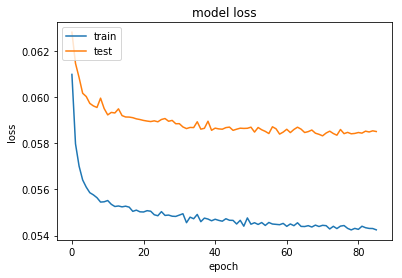

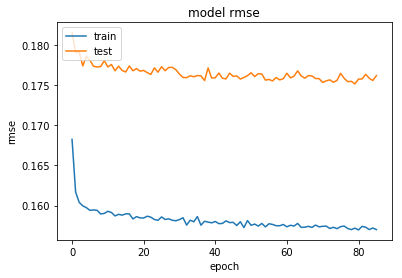

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate performance on validation data to improve model

In [12]:
model.load_weights(experiment_name+'.hdf5')

(6079, 25, 3) (6079, 10, 3)


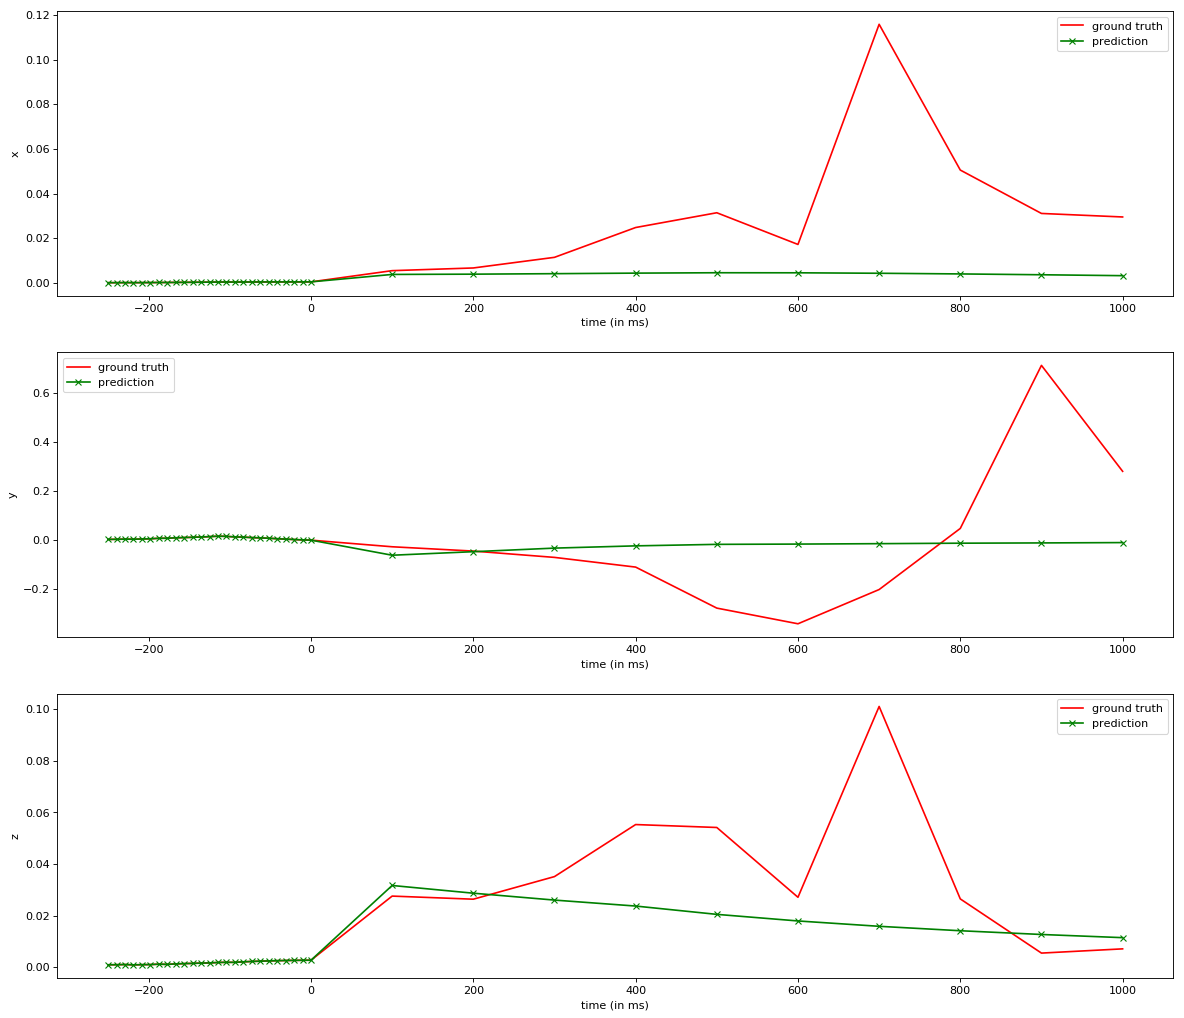

In [13]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_seq2seq_decoder_zeros(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )


predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))

def get_mae(Y1, Y2):
    return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)


start = time.time()
print("Evaluating on validation data...")
count = 0
for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #Y_pred = model.predict([encoder_input, decoder_input], verbose=0)
    Y_pred_diff = model.predict([encoder_input, decoder_input[:, 1:]], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]
        
    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)

    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[:,ind_delay]
        Y_delay_val = Y_val_abs[:,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating on validation data...


Evaluation Time :  71.25919365882874 s =  1.1876532395680746 min =  0.01979422085815006 h


### Metrics

In [15]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05795467961673088
Delay 100 ms: 0.0043381406269452005
Delay 200 ms: 0.012781040850377167
Delay 300 ms: 0.02392670639060036
Delay 400 ms: 0.036424281293564204
Delay 500 ms: 0.049605273998653915
Delay 600 ms: 0.06317606723103229
Delay 700 ms: 0.07688815858810384
Delay 800 ms: 0.09060836418834087
Delay 900 ms: 0.10420793575989518
Delay 1000 ms: 0.11759082723979582

RMSE
Average rmse: 0.12206671460485487
Delay 100 ms: 0.011545966970917348
Delay 200 ms: 0.02711904145478398
Delay 300 ms: 0.047339450967825825
Delay 400 ms: 0.06946445838167682
Delay 500 ms: 0.09223523600567168
Delay 600 ms: 0.11514502815658333
Delay 700 ms: 0.1378222239463471
Delay 800 ms: 0.16007300642412234
Delay 900 ms: 0.18178419625331727
Delay 1000 ms: 0.2028294345499445

SMAPE
Average smape: 14.248963570017695
Delay 100 ms: 2.2273342875473903
Delay 200 ms: 5.315381504307279
Delay 300 ms: 8.371051773925817
Delay 400 ms: 11.221456703979433
Delay 500 ms: 13.82135637281274
Delay 600 ms: 16.21404918327013
D